# MLP with the Laplace Beltrami Spectrum
## Binary Classification: Males vs. Females
Here we are going to see if we can create a multi-layer perceptron (fully connected neural network) that can accurately classify a subject as male or female based on the shape (LB spectrum) of their white matter tracts.

### Import libraries
First, let's import the libraries we will use.

In [1]:
#to read in the data
import pickle
#for plotting, numbers etc.
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#for splitting the data
from sklearn.model_selection import train_test_split
#keras functions
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import np_utils, plot_model, to_categorical
from keras.optimizers import Adam

#normalize the data
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegressionCV 

/home/pestillilab/anaconda2/envs/tf1.4py2.7/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Import and check the data
Now let's read in the data using pickle and double check everything is as it should be. The data was previously processed in python and saved down using pickle.

In [2]:
# eigenvalue dictionary with entry for eact tract, 600 evs per tract
tractev_dict_600 = pickle.load(open("tract_ev_dict_600.pk",'rb'))
# list of tracts we want to use
tractstouse = pickle.load(open('tractstouse.pk','rb'))
# subject list
HCP_subj_list = pickle.load(open('HCP_subj_list.pk','rb'))
# list of subject gender 1 = male, 2 = female
gender_id = pickle.load(open('gender_id.pk','rb'))

Let's see what the variables look like.

In [3]:
print tractstouse[0:5]
print len(tractstouse)

['Corpus_Callosum_surf', 'Forceps_Major_surf', 'Forceps_Minor_surf', 'Left_Arcuate_surf', 'Left_Aslant_surf']
48


By printing out the length of the variable `tractstouse` we can see that we have LB eigenvalues for 48 tracts. 

In [4]:
print HCP_subj_list[0:5]
print len(HCP_subj_list)
print gender_id[0:5]
print len(gender_id)

['100206', '100307', '100408', '100610', '101006']
1013
[1, 2, 1, 1, 2]
1013


By printing out the length of the variable `HCP_subj_list` we can see that we have data for 1013 subjects. We check that the `gender_id` variable is the same length just to be sure. We can also see that the genders of the subjects are encoded as either 1 (male) or 2 (female). We will need to change this to be one-hot encoding. 

Let's now check the individual tract data. Let's print out the shape of the dictionary entry for the first tract in the list, the corpus callosum.

In [5]:
tractev_dict_600[tractstouse[0]].shape

(1013, 600)

We can see that we have a row per subject and a column per eigenvalue. For each tract we have 600 eigenvalues. 

I am satisfied that the data is correct and we can move on to preprocessing.

### Preprocess the data

The eigenvalue data is already in a vector format, so we do not need to vectorize it. However, we will need to combine the vectors of all the tracts so that we have a single vector per subject. 

We also need to normalize the data so that each set of eigenvalues has a mean of 0 and a standard deviation of 1. We will write a function to do this using sklearn's `StandardScaler` function.

**Normalize the data**

In [5]:
def scale_ev_dict(ev_dict):
    scaled_dict = {}
    for tract in ev_dict.keys():
        scaler = StandardScaler()
        scaled_dict[tract] = scaler.fit_transform(ev_dict[tract])
    return scaled_dict


First let's plot some of the non-scaled eigenvalues so we can check the normalization is done properly.

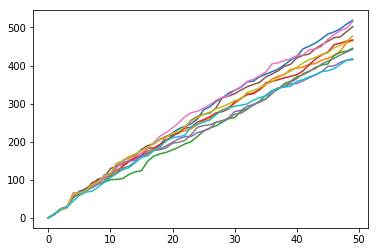

In [7]:
# plot the first 50 eigenvalues of 10 subjects to see how the data looks originally
%matplotlib inline 
#ensures the plots are shown in the notebook
for i in range(10):
    plt.plot(tractev_dict_600[tractstouse[0]][i][0:50])
plt.show()

Now let's actually normalize the data and compare it to the original data.

In [6]:
# normalize all of the tracts so that each ev is centered on 0.
tractev_dict_600_scaled = scale_ev_dict(tractev_dict_600)

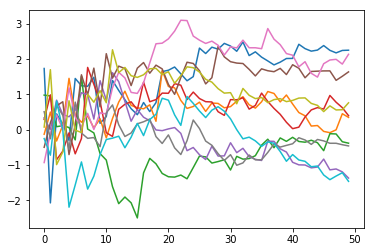

In [7]:
# plot the normalized first 50 eigenvalues of 10 subjects
for i in range(10):
    plt.plot(tractev_dict_600_scaled[tractstouse[0]][i][0:50])
plt.show()

We can see that the relationships between the lines is preserved, they are just centered on 0 and scaled to have a standard deviation of 1. 

**Reorganize the data**

Currently the data is a dictionary of 2D matrices, we want to reorganize this into a single 2D matrix with the shape `(1013, n * 48)`, where n is the number of eigenvalues we are using. It is likely that 600 eigenvalues is way more than we need, but we do not know how many eigenvalues is optimal. We will write a function to do this reorganization so we can easily try multiple amounts of eigenvalues. 

In [8]:
# change the organization to be one vector per subject with all evs for all tracts
def reorganize_spectrums(ev_dict_scaled, numev, HCP_subj_list=HCP_subj_list, tractstouse=tractstouse):
    # create an empty numpy array of the shape we want
    # numev is the number of eigenvalues we want per tract
    allsubjs_alltracts_scaled = np.zeros([len(HCP_subj_list), numev*len(tractstouse)])
    for i in range(len(tractstouse)):
        allsubjs_alltracts_scaled[:, i*numev:i*numev+numev] = ev_dict_scaled[tractstouse[i]][:, 0:numev]
    return allsubjs_alltracts_scaled


In [9]:
numev=200
allsubjs_alltracts_scaled = reorganize_spectrums(tractev_dict_600_scaled, numev)

In [10]:
allsubjs_alltracts_scaled.shape

(1013, 9600)

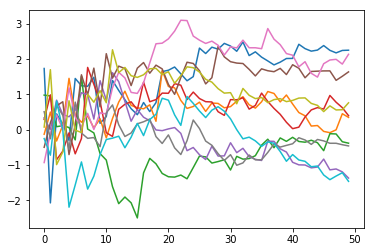

In [13]:
# plot the first 50 eigenvalues of 10 subjects to check 
for i in range(10):
    plt.plot(allsubjs_alltracts_scaled[i,0:50])
plt.show()

**One hot encoding the labels**

To one hot encoding these labels all we need to do is simple subtract 1 from every entry. Now 0 = male and 1 = female

In [11]:
# one-hot encoding for the gender ID
genderid_ohe = np.asarray(gender_id) - 1

In [12]:
genderid_ohe[0:5]

array([0, 1, 0, 0, 1])

**Check datatype**

Finally, we need to make sure all inputs are of datatype `float32`

In [13]:
allsubjs_alltracts_scaled = allsubjs_alltracts_scaled.astype('float32')
genderid_ohe = genderid_ohe.astype('float32')

In [14]:
allsubjs_alltracts_scaled[0,0:5]

array([ 1.7365031 , -2.073661  ,  0.44813645,  0.16624592, -0.30131266],
      dtype=float32)

In [15]:
genderid_ohe[0:5]

array([0., 1., 0., 0., 1.], dtype=float32)

### Split the data

The input data is now preprocessed and ready to be input into a neural network. However, we first have to split the data into training, validation, and testing sets. We do not have a ton of samples, so we will try splitting the data into 3 subsets first and then explore other cross validation options.

In [16]:
X = allsubjs_alltracts_scaled
Y = genderid_ohe

#first split the training/validation data from the testing data
trainX, testX, trainY, testY = train_test_split(X, Y, train_size  = .8, test_size = .2, random_state=0)

print len(trainX) 
print len(testX)

810
203


In [17]:
#second split the validation data from the training data
trainX, valX, trainY, valY = train_test_split(trainX, trainY, train_size  = .75, test_size = .25, random_state=0)

print len(trainX)
print len(valX)

607
203


Now we have 3 subsets of data. Testing data with 607 samples, validation data with 203 samples, and testing data with 203 samples. Again, this may be too few samples for training and if so we can employ other cross validation methods.

### Try Logistic Regression Classifier from sklearn for comparison

One of the reasons we are trying deep learning with this data is to see if we can improve upon 'basic' machine learning algorithms. Lets try this data with a simple Logistic Regression classifier so we have something to compare the deep learning accuracy to.

In [18]:
#train on training data
lr = LogisticRegressionCV()
lr.fit(trainX, trainY)

#evaluate with validation data
print("Accuracy = {:.2f}".format(lr.score(valX, valY)))

Accuracy = 0.81


### Set up the MLP
Our goal is to try and train a MLP to get an accuracy value higher than 81%.
We are going to first try a very basic MLP.

In [22]:
model = Sequential()
model.add(Dense(64, input_dim=allsubjs_alltracts_scaled.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

history = model.fit(trainX, trainY, epochs = 20, batch_size = 20, validation_data=(valX, valY))

# loss, accuracy = model.evaluate(testX, testY, verbose=0)
# print("Accuracy = {:.2f}".format(accuracy))


Train on 607 samples, validate on 203 samples
Epoch 1/20
607/607 [==============================] - 1s 1ms/step - loss: 1.9225 - acc: 0.6178 - val_loss: 0.7852 - val_acc: 0.7783
Epoch 2/20
607/607 [==============================] - 0s 239us/step - loss: 1.4669 - acc: 0.7084 - val_loss: 0.9197 - val_acc: 0.8128
Epoch 3/20
607/607 [==============================] - 0s 238us/step - loss: 1.5057 - acc: 0.7249 - val_loss: 0.9366 - val_acc: 0.8030
Epoch 4/20
607/607 [==============================] - 0s 242us/step - loss: 1.4392 - acc: 0.7232 - val_loss: 0.9793 - val_acc: 0.8030
Epoch 5/20
607/607 [==============================] - 0s 250us/step - loss: 1.4493 - acc: 0.7496 - val_loss: 0.9924 - val_acc: 0.8128
Epoch 6/20
607/607 [==============================] - 0s 238us/step - loss: 1.2589 - acc: 0.7595 - val_loss: 1.0337 - val_acc: 0.7882
Epoch 7/20
607/607 [==============================] - 0s 245us/step - loss: 1.2249 - acc: 0.7875 - val_loss: 0.9094 - val_acc: 0.7783
Epoch 8/20
607/607

Because we are saving the history output of the model, we can plot the loss and accuracy changes during training. 

In [41]:
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training','Validation'])
    
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.plot(network_history.history['acc'])
    plt.plot(network_history.history['val_acc'])
    plt.legend(['Training','Validation'])
    plt.show()

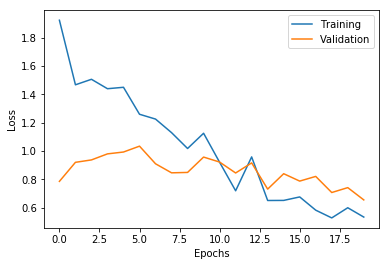

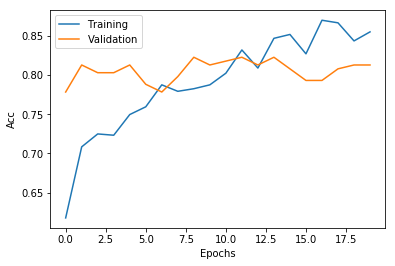

In [24]:
plot_history(history)

Right away, this model does pretty well, but we can see that the model starts overfitting at about 13-15 epochs, when the training accuracy becomes higher than the validation accuracy. Still, it hits a best accuracy of 83%, which is higher than 81% already. Let's see if we can do better.

Because we are going to test a few different parameters, we are going to write a function to set up the model.

In [21]:
# hidden_units = 64
# dropout_prop = 0.5
# optim = 'rmsprop'
# epochs = 20
# batch = 20
#plot=True
def make_model(hidden_units, dropout_prop, optim, epochs, batch, plot=False):
    model = Sequential()
    model.add(Dense(hidden_units, input_dim=allsubjs_alltracts_scaled.shape[1], activation='relu'))
    model.add(Dropout(dropout_prop))
    model.add(Dense(hidden_units, activation='relu'))
    model.add(Dropout(dropout_prop))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer=optim,
                  metrics=['accuracy'])

    history = model.fit(trainX, trainY, epochs = epochs, batch_size = batch, validation_data=(valX, valY))
    if plot:
        plot_history(history)
    return model

Train on 607 samples, validate on 203 samples
Epoch 1/40
607/607 [==============================] - 0s 701us/step - loss: 3.2425 - acc: 0.5815 - val_loss: 1.1533 - val_acc: 0.7438
Epoch 2/40
607/607 [==============================] - 0s 241us/step - loss: 3.2575 - acc: 0.6293 - val_loss: 1.0569 - val_acc: 0.7635
Epoch 3/40
607/607 [==============================] - 0s 241us/step - loss: 3.4117 - acc: 0.6376 - val_loss: 1.3145 - val_acc: 0.8128
Epoch 4/40
607/607 [==============================] - 0s 235us/step - loss: 3.1454 - acc: 0.6771 - val_loss: 1.5174 - val_acc: 0.7882
Epoch 5/40
607/607 [==============================] - 0s 245us/step - loss: 2.6362 - acc: 0.7232 - val_loss: 1.6808 - val_acc: 0.8030
Epoch 6/40
607/607 [==============================] - 0s 247us/step - loss: 2.9273 - acc: 0.7002 - val_loss: 1.5991 - val_acc: 0.8030
Epoch 7/40
607/607 [==============================] - 0s 241us/step - loss: 3.3840 - acc: 0.6755 - val_loss: 1.6553 - val_acc: 0.8128
Epoch 8/40
607/6

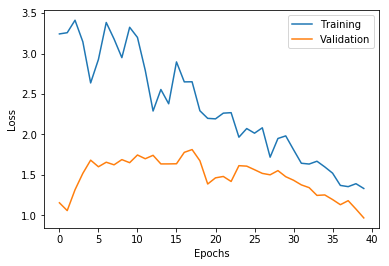

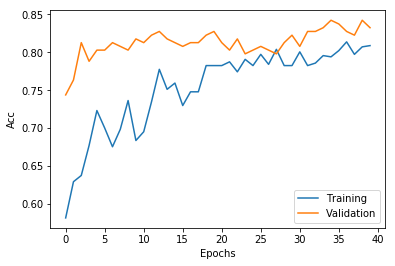

In [26]:
hidden_units = 64
dropout_prop = 0.7
optim = 'rmsprop'
epochs = 40
batch = 20
plot = True
model = make_model(hidden_units, dropout_prop, optim, epochs, batch, plot)

# model = Sequential()
# model.add(Dense(64, input_dim=allsubjs_alltracts_scaled.shape[1], activation='relu'))
# model.add(Dropout(0.7))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.7))
# model.add(Dense(1, activation='sigmoid'))

# model.compile(loss='binary_crossentropy',
#               optimizer='rmsprop',
#               metrics=['accuracy'])

# history = model.fit(trainX, trainY, epochs = 20, batch_size = 20, validation_data=(testX, testY))


Let's try adjusting the learning rate of the rmsprop optimizer

In [19]:
from keras.optimizers import RMSprop

rms = RMSprop(lr=.0001)

In [22]:
hidden_units = 32
dropout_prop = 0.7
optim = rms
epochs = 120
batch = 40
plot = True
model = make_model(hidden_units, dropout_prop, optim, epochs, batch, plot)


Train on 607 samples, validate on 203 samples
Epoch 1/120
607/607 [==============================] - 1s 1ms/step - loss: 1.1488 - acc: 0.5420 - val_loss: 0.6256 - val_acc: 0.6552
Epoch 2/120
607/607 [==============================] - 0s 135us/step - loss: 1.0089 - acc: 0.5733 - val_loss: 0.5760 - val_acc: 0.7143
Epoch 3/120
607/607 [==============================] - 0s 127us/step - loss: 0.9970 - acc: 0.5700 - val_loss: 0.5516 - val_acc: 0.7340
Epoch 4/120
607/607 [==============================] - 0s 128us/step - loss: 0.9481 - acc: 0.5881 - val_loss: 0.5445 - val_acc: 0.7488
Epoch 5/120
607/607 [==============================] - 0s 138us/step - loss: 0.7592 - acc: 0.6623 - val_loss: 0.5362 - val_acc: 0.7685
Epoch 6/120
607/607 [==============================] - 0s 132us/step - loss: 0.8250 - acc: 0.6326 - val_loss: 0.5140 - val_acc: 0.7833
Epoch 7/120
607/607 [==============================] - 0s 130us/step - loss: 0.8120 - acc: 0.6376 - val_loss: 0.5313 - val_acc: 0.7685
Epoch 8/120

Epoch 61/120
607/607 [==============================] - 0s 129us/step - loss: 0.4817 - acc: 0.7677 - val_loss: 0.4735 - val_acc: 0.8030
Epoch 62/120
607/607 [==============================] - 0s 128us/step - loss: 0.4788 - acc: 0.7727 - val_loss: 0.4633 - val_acc: 0.8128
Epoch 63/120
607/607 [==============================] - 0s 133us/step - loss: 0.4765 - acc: 0.7331 - val_loss: 0.4610 - val_acc: 0.8177
Epoch 64/120
607/607 [==============================] - 0s 130us/step - loss: 0.4611 - acc: 0.7644 - val_loss: 0.4783 - val_acc: 0.8079
Epoch 65/120
607/607 [==============================] - 0s 127us/step - loss: 0.4633 - acc: 0.7611 - val_loss: 0.4779 - val_acc: 0.8177
Epoch 66/120
607/607 [==============================] - 0s 130us/step - loss: 0.4799 - acc: 0.7727 - val_loss: 0.4850 - val_acc: 0.8177
Epoch 67/120
607/607 [==============================] - 0s 134us/step - loss: 0.4528 - acc: 0.7595 - val_loss: 0.4918 - val_acc: 0.8177
Epoch 68/120
607/607 [==========================

NameError: global name 'plot_history' is not defined

The best we have seen is 84-85%, not bad! Let's try some parameter searching to avoid checking all of this manually. 

### Grid search

In [23]:
def make_model_compile(hidden_units, dropout_prop, optim, epochs, batch, plot=False):
    model = Sequential()
    model.add(Dense(hidden_units, input_dim=allsubjs_alltracts_scaled.shape[1], activation='relu'))
    model.add(Dropout(dropout_prop))
    model.add(Dense(hidden_units, activation='relu'))
    model.add(Dropout(dropout_prop))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer=optim,
                  metrics=['accuracy'])
    return model
    

In [24]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras import backend as K
import gc

In [69]:
K.clear_session()
gc.collect()

154455

In [26]:
my_classifier = KerasClassifier(make_model_compile)

#define the grid search 
validator = GridSearchCV(my_classifier,
                         param_grid={'hidden_units': [32, 64],
                                     'dropout_prop': [0.5, 0.6, 0.7, 0.8], 
                                     'optim': [RMSprop(lr=.001), RMSprop(lr=.0001),RMSprop(lr=.00001)], 
                                     'epochs':[20,40,60,100], 
                                     'batch': [5,10,20,40]})
validator.fit(trainX, trainY)

Epoch 1/20
404/404 [==============================] - 0s 744us/step - loss: 1.5302 - acc: 0.6386
Epoch 2/20
404/404 [==============================] - 0s 139us/step - loss: 1.7198 - acc: 0.6312
Epoch 3/20
404/404 [==============================] - 0s 133us/step - loss: 1.6960 - acc: 0.6634
Epoch 4/20
404/404 [==============================] - 0s 142us/step - loss: 1.3967 - acc: 0.6980
Epoch 5/20
404/404 [==============================] - 0s 135us/step - loss: 1.7124 - acc: 0.6807
Epoch 6/20
404/404 [==============================] - 0s 141us/step - loss: 1.3426 - acc: 0.7426
Epoch 7/20
404/404 [==============================] - 0s 129us/step - loss: 1.3743 - acc: 0.7277
Epoch 8/20
404/404 [==============================] - 0s 132us/step - loss: 1.2379 - acc: 0.7302
Epoch 9/20
404/404 [==============================] - 0s 142us/step - loss: 1.1034 - acc: 0.7748
Epoch 10/20
404/404 [==============================] - 0s 131us/step - loss: 1.2315 - acc: 0.7450
Epoch 11/20
404/404 [========

404/404 [==============================] - 0s 62us/step
Epoch 1/20
405/405 [==============================] - 0s 837us/step - loss: 0.9133 - acc: 0.5778
Epoch 2/20
405/405 [==============================] - 0s 128us/step - loss: 0.7471 - acc: 0.6519
Epoch 3/20
405/405 [==============================] - 0s 136us/step - loss: 0.6480 - acc: 0.6642
Epoch 4/20
405/405 [==============================] - 0s 136us/step - loss: 0.5967 - acc: 0.7037
Epoch 5/20
405/405 [==============================] - 0s 137us/step - loss: 0.6062 - acc: 0.6963
Epoch 6/20
405/405 [==============================] - 0s 133us/step - loss: 0.6022 - acc: 0.6864
Epoch 7/20
405/405 [==============================] - 0s 136us/step - loss: 0.5238 - acc: 0.7506
Epoch 8/20
405/405 [==============================] - 0s 137us/step - loss: 0.5086 - acc: 0.7506
Epoch 9/20
405/405 [==============================] - 0s 129us/step - loss: 0.4746 - acc: 0.7704
Epoch 10/20
405/405 [==============================] - 0s 132us/step - 

405/405 [==============================] - 0s 64us/step
Epoch 1/20
405/405 [==============================] - 0s 1ms/step - loss: 0.9521 - acc: 0.5259
Epoch 2/20
405/405 [==============================] - 0s 131us/step - loss: 0.9764 - acc: 0.5185
Epoch 3/20
405/405 [==============================] - 0s 127us/step - loss: 0.9120 - acc: 0.5284
Epoch 4/20
405/405 [==============================] - 0s 128us/step - loss: 0.8092 - acc: 0.5728
Epoch 5/20
405/405 [==============================] - 0s 131us/step - loss: 0.7697 - acc: 0.5679
Epoch 6/20
405/405 [==============================] - 0s 136us/step - loss: 0.7935 - acc: 0.5778
Epoch 7/20
405/405 [==============================] - 0s 132us/step - loss: 0.7746 - acc: 0.5926
Epoch 8/20
405/405 [==============================] - 0s 136us/step - loss: 0.7954 - acc: 0.6247
Epoch 9/20
405/405 [==============================] - 0s 128us/step - loss: 0.7486 - acc: 0.5975
Epoch 10/20
405/405 [==============================] - 0s 132us/step - lo

405/405 [==============================] - 0s 150us/step - loss: 0.4905 - acc: 0.8815
Epoch 20/20
405/405 [==============================] - 0s 56us/step
Epoch 1/20
404/404 [==============================] - 1s 1ms/step - loss: 0.7714 - acc: 0.5965
Epoch 2/20
404/404 [==============================] - 0s 139us/step - loss: 0.6723 - acc: 0.6955
Epoch 3/20
404/404 [==============================] - 0s 141us/step - loss: 0.5221 - acc: 0.7698
Epoch 4/20
404/404 [==============================] - 0s 138us/step - loss: 0.4969 - acc: 0.7525
Epoch 5/20
404/404 [==============================] - 0s 136us/step - loss: 0.4579 - acc: 0.7946
Epoch 6/20
404/404 [==============================] - 0s 139us/step - loss: 0.4491 - acc: 0.7698
Epoch 7/20
404/404 [==============================] - 0s 138us/step - loss: 0.4248 - acc: 0.7871
Epoch 8/20
404/404 [==============================] - 0s 142us/step - loss: 0.4289 - acc: 0.8267
Epoch 9/20
404/404 [==============================] - 0s 140us/step - lo

404/404 [==============================] - 0s 142us/step - loss: 0.7041 - acc: 0.6485
Epoch 19/20
404/404 [==============================] - 0s 142us/step - loss: 0.8089 - acc: 0.5916
Epoch 20/20
404/404 [==============================] - 0s 57us/step
Epoch 1/20
405/405 [==============================] - 1s 2ms/step - loss: 0.9575 - acc: 0.5259
Epoch 2/20
405/405 [==============================] - 0s 133us/step - loss: 0.9513 - acc: 0.5309
Epoch 3/20
405/405 [==============================] - 0s 140us/step - loss: 0.8571 - acc: 0.5704
Epoch 4/20
405/405 [==============================] - 0s 138us/step - loss: 0.7651 - acc: 0.6198
Epoch 5/20
405/405 [==============================] - 0s 133us/step - loss: 0.7565 - acc: 0.6222
Epoch 6/20
405/405 [==============================] - 0s 150us/step - loss: 0.7557 - acc: 0.6198
Epoch 7/20
405/405 [==============================] - 0s 150us/step - loss: 0.7256 - acc: 0.6148
Epoch 8/20
405/405 [==============================] - 0s 143us/step - l

404/404 [==============================] - 0s 139us/step - loss: 0.1883 - acc: 0.9431
Epoch 39/40
404/404 [==============================] - 0s 136us/step - loss: 0.2140 - acc: 0.9282
Epoch 40/40
404/404 [==============================] - 0s 59us/step
Epoch 1/40
405/405 [==============================] - 1s 2ms/step - loss: 1.5231 - acc: 0.6123
Epoch 2/40
405/405 [==============================] - 0s 138us/step - loss: 1.4828 - acc: 0.6617
Epoch 3/40
405/405 [==============================] - 0s 136us/step - loss: 1.4859 - acc: 0.6741
Epoch 4/40
405/405 [==============================] - 0s 135us/step - loss: 1.4105 - acc: 0.6593
Epoch 5/40
405/405 [==============================] - 0s 140us/step - loss: 1.2008 - acc: 0.7037
Epoch 6/40
405/405 [==============================] - 0s 140us/step - loss: 1.1950 - acc: 0.7235
Epoch 7/40
405/405 [==============================] - 0s 135us/step - loss: 1.4862 - acc: 0.6716
Epoch 8/40
405/405 [==============================] - 0s 136us/step - l

405/405 [==============================] - 0s 132us/step - loss: 0.2749 - acc: 0.9062
Epoch 40/40
405/405 [==============================] - 0s 57us/step
Epoch 1/40
404/404 [==============================] - 1s 2ms/step - loss: 1.1444 - acc: 0.5371
Epoch 2/40
404/404 [==============================] - 0s 134us/step - loss: 0.8719 - acc: 0.5965
Epoch 3/40
404/404 [==============================] - 0s 142us/step - loss: 0.7222 - acc: 0.6436
Epoch 4/40
404/404 [==============================] - 0s 136us/step - loss: 0.6575 - acc: 0.6881
Epoch 5/40
404/404 [==============================] - 0s 139us/step - loss: 0.6411 - acc: 0.6931
Epoch 6/40
404/404 [==============================] - 0s 134us/step - loss: 0.6614 - acc: 0.6411
Epoch 7/40
404/404 [==============================] - 0s 139us/step - loss: 0.5522 - acc: 0.7079
Epoch 8/40
404/404 [==============================] - 0s 138us/step - loss: 0.5310 - acc: 0.7302
Epoch 9/40
404/404 [==============================] - 0s 136us/step - lo

405/405 [==============================] - 0s 61us/step
Epoch 1/40
405/405 [==============================] - 1s 2ms/step - loss: 0.8646 - acc: 0.5728
Epoch 2/40
405/405 [==============================] - 0s 136us/step - loss: 0.7801 - acc: 0.6148
Epoch 3/40
405/405 [==============================] - 0s 133us/step - loss: 0.6792 - acc: 0.6568
Epoch 4/40
405/405 [==============================] - 0s 137us/step - loss: 0.6540 - acc: 0.6889
Epoch 5/40
405/405 [==============================] - 0s 136us/step - loss: 0.5998 - acc: 0.7037
Epoch 6/40
405/405 [==============================] - 0s 128us/step - loss: 0.6140 - acc: 0.6988
Epoch 7/40
405/405 [==============================] - 0s 135us/step - loss: 0.5461 - acc: 0.7407
Epoch 8/40
405/405 [==============================] - 0s 133us/step - loss: 0.5378 - acc: 0.7235
Epoch 9/40
405/405 [==============================] - 0s 138us/step - loss: 0.4765 - acc: 0.7531
Epoch 10/40
405/405 [==============================] - 0s 132us/step - lo

404/404 [==============================] - 0s 63us/step
Epoch 1/40
405/405 [==============================] - 1s 2ms/step - loss: 1.0846 - acc: 0.5062
Epoch 2/40
405/405 [==============================] - 0s 138us/step - loss: 1.0466 - acc: 0.4864
Epoch 3/40
405/405 [==============================] - 0s 138us/step - loss: 0.9520 - acc: 0.5136
Epoch 4/40
405/405 [==============================] - 0s 142us/step - loss: 0.9652 - acc: 0.5111
Epoch 5/40
405/405 [==============================] - 0s 137us/step - loss: 0.9058 - acc: 0.5309
Epoch 6/40
405/405 [==============================] - 0s 145us/step - loss: 0.8966 - acc: 0.5185
Epoch 7/40
405/405 [==============================] - 0s 137us/step - loss: 0.9008 - acc: 0.5605
Epoch 8/40
405/405 [==============================] - 0s 143us/step - loss: 0.8618 - acc: 0.5432
Epoch 9/40
405/405 [==============================] - 0s 139us/step - loss: 0.7863 - acc: 0.6074
Epoch 10/40
405/405 [==============================] - 0s 130us/step - lo

404/404 [==============================] - 0s 145us/step - loss: 1.9887 - acc: 0.6782
Epoch 3/40
404/404 [==============================] - 0s 153us/step - loss: 1.4330 - acc: 0.7302
Epoch 4/40
404/404 [==============================] - 0s 145us/step - loss: 1.5481 - acc: 0.7252
Epoch 5/40
404/404 [==============================] - 0s 144us/step - loss: 1.1671 - acc: 0.7698
Epoch 6/40
404/404 [==============================] - 0s 141us/step - loss: 1.1190 - acc: 0.7723
Epoch 7/40
404/404 [==============================] - 0s 151us/step - loss: 1.2443 - acc: 0.7896
Epoch 8/40
404/404 [==============================] - 0s 143us/step - loss: 0.9678 - acc: 0.8144
Epoch 9/40
404/404 [==============================] - 0s 155us/step - loss: 0.9760 - acc: 0.8243
Epoch 10/40
404/404 [==============================] - 0s 145us/step - loss: 0.8105 - acc: 0.8342
Epoch 11/40
404/404 [==============================] - 0s 145us/step - loss: 0.9134 - acc: 0.8292
Epoch 12/40
404/404 [==================

405/405 [==============================] - 0s 143us/step - loss: 1.2451 - acc: 0.7333
Epoch 4/40
405/405 [==============================] - 0s 144us/step - loss: 1.3526 - acc: 0.7457
Epoch 5/40
405/405 [==============================] - 0s 142us/step - loss: 1.1164 - acc: 0.7605
Epoch 6/40
405/405 [==============================] - 0s 150us/step - loss: 1.4730 - acc: 0.7383
Epoch 7/40
405/405 [==============================] - 0s 138us/step - loss: 1.0548 - acc: 0.8099
Epoch 8/40
405/405 [==============================] - 0s 152us/step - loss: 1.0617 - acc: 0.7778
Epoch 9/40
405/405 [==============================] - 0s 144us/step - loss: 0.8148 - acc: 0.8198
Epoch 10/40
405/405 [==============================] - 0s 154us/step - loss: 0.8415 - acc: 0.8272
Epoch 11/40
405/405 [==============================] - 0s 143us/step - loss: 0.8980 - acc: 0.8272
Epoch 12/40
405/405 [==============================] - 0s 145us/step - loss: 0.8516 - acc: 0.8247
Epoch 13/40
405/405 [=================

405/405 [==============================] - 0s 154us/step - loss: 0.5737 - acc: 0.7407
Epoch 5/40
405/405 [==============================] - 0s 154us/step - loss: 0.4803 - acc: 0.7877
Epoch 6/40
405/405 [==============================] - 0s 155us/step - loss: 0.5122 - acc: 0.7753
Epoch 7/40
405/405 [==============================] - 0s 154us/step - loss: 0.5136 - acc: 0.7704
Epoch 8/40
405/405 [==============================] - 0s 153us/step - loss: 0.4721 - acc: 0.8025
Epoch 9/40
405/405 [==============================] - 0s 143us/step - loss: 0.4787 - acc: 0.7753
Epoch 10/40
405/405 [==============================] - 0s 154us/step - loss: 0.4134 - acc: 0.8099
Epoch 11/40
405/405 [==============================] - 0s 146us/step - loss: 0.3805 - acc: 0.8173
Epoch 12/40
405/405 [==============================] - 0s 154us/step - loss: 0.4217 - acc: 0.8000
Epoch 13/40
405/405 [==============================] - 0s 146us/step - loss: 0.3605 - acc: 0.8420
Epoch 14/40
405/405 [================

404/404 [==============================] - 0s 140us/step - loss: 0.8014 - acc: 0.6163
Epoch 6/40
404/404 [==============================] - 0s 154us/step - loss: 0.7293 - acc: 0.6312
Epoch 7/40
404/404 [==============================] - 0s 154us/step - loss: 0.7446 - acc: 0.5891
Epoch 8/40
404/404 [==============================] - 0s 150us/step - loss: 0.6567 - acc: 0.6782
Epoch 9/40
404/404 [==============================] - 0s 146us/step - loss: 0.7131 - acc: 0.6510
Epoch 10/40
404/404 [==============================] - 0s 143us/step - loss: 0.6537 - acc: 0.6634
Epoch 11/40
404/404 [==============================] - 0s 142us/step - loss: 0.6087 - acc: 0.7005
Epoch 12/40
404/404 [==============================] - 0s 139us/step - loss: 0.6150 - acc: 0.6955
Epoch 13/40
404/404 [==============================] - 0s 140us/step - loss: 0.5780 - acc: 0.6980
Epoch 14/40
404/404 [==============================] - 0s 136us/step - loss: 0.6800 - acc: 0.6782
Epoch 15/40
404/404 [===============

405/405 [==============================] - 0s 145us/step - loss: 0.8468 - acc: 0.5630
Epoch 7/40
405/405 [==============================] - 0s 149us/step - loss: 0.8632 - acc: 0.5580
Epoch 8/40
405/405 [==============================] - 0s 146us/step - loss: 0.7998 - acc: 0.5901
Epoch 9/40
405/405 [==============================] - 0s 152us/step - loss: 0.7330 - acc: 0.6716
Epoch 10/40
405/405 [==============================] - 0s 143us/step - loss: 0.6749 - acc: 0.6420
Epoch 11/40
405/405 [==============================] - 0s 143us/step - loss: 0.6768 - acc: 0.6667
Epoch 12/40
405/405 [==============================] - 0s 139us/step - loss: 0.7353 - acc: 0.6346
Epoch 13/40
405/405 [==============================] - 0s 143us/step - loss: 0.7074 - acc: 0.6617
Epoch 14/40
405/405 [==============================] - 0s 158us/step - loss: 0.6618 - acc: 0.6815
Epoch 15/40
405/405 [==============================] - 0s 153us/step - loss: 0.6224 - acc: 0.6765
Epoch 16/40
405/405 [==============

404/404 [==============================] - 0s 127us/step - loss: 0.1413 - acc: 0.9455
Epoch 49/60
404/404 [==============================] - 0s 137us/step - loss: 0.1666 - acc: 0.9332
Epoch 50/60
404/404 [==============================] - 0s 134us/step - loss: 0.1827 - acc: 0.9431
Epoch 51/60
404/404 [==============================] - 0s 134us/step - loss: 0.2097 - acc: 0.9431
Epoch 52/60
404/404 [==============================] - 0s 142us/step - loss: 0.1677 - acc: 0.9406
Epoch 53/60
404/404 [==============================] - 0s 139us/step - loss: 0.1483 - acc: 0.9480
Epoch 54/60
404/404 [==============================] - 0s 132us/step - loss: 0.2038 - acc: 0.9406
Epoch 55/60
404/404 [==============================] - 0s 138us/step - loss: 0.1598 - acc: 0.9381
Epoch 56/60
404/404 [==============================] - 0s 137us/step - loss: 0.1246 - acc: 0.9431
Epoch 57/60
404/404 [==============================] - 0s 136us/step - loss: 0.2126 - acc: 0.9381
Epoch 58/60
404/404 [===========

405/405 [==============================] - 0s 135us/step - loss: 1.0027 - acc: 0.7728
Epoch 10/60
405/405 [==============================] - 0s 139us/step - loss: 1.0147 - acc: 0.7827
Epoch 11/60
405/405 [==============================] - 0s 142us/step - loss: 0.8911 - acc: 0.7728
Epoch 12/60
405/405 [==============================] - 0s 140us/step - loss: 0.7769 - acc: 0.7753
Epoch 13/60
405/405 [==============================] - 0s 135us/step - loss: 0.7572 - acc: 0.8173
Epoch 14/60
405/405 [==============================] - 0s 135us/step - loss: 0.7362 - acc: 0.8247
Epoch 15/60
405/405 [==============================] - 0s 136us/step - loss: 0.7446 - acc: 0.8000
Epoch 16/60
405/405 [==============================] - 0s 130us/step - loss: 0.7098 - acc: 0.8494
Epoch 17/60
405/405 [==============================] - 0s 136us/step - loss: 0.7002 - acc: 0.8346
Epoch 18/60
405/405 [==============================] - 0s 136us/step - loss: 0.7564 - acc: 0.8123
Epoch 19/60
405/405 [===========

404/404 [==============================] - 0s 137us/step - loss: 0.3351 - acc: 0.8391
Epoch 32/60
404/404 [==============================] - 0s 131us/step - loss: 0.3300 - acc: 0.8292
Epoch 33/60
404/404 [==============================] - 0s 138us/step - loss: 0.3112 - acc: 0.8540
Epoch 34/60
404/404 [==============================] - 0s 135us/step - loss: 0.2836 - acc: 0.8787
Epoch 35/60
404/404 [==============================] - 0s 130us/step - loss: 0.2576 - acc: 0.8837
Epoch 36/60
404/404 [==============================] - 0s 138us/step - loss: 0.3155 - acc: 0.8441
Epoch 37/60
404/404 [==============================] - 0s 132us/step - loss: 0.3269 - acc: 0.8366
Epoch 38/60
404/404 [==============================] - 0s 138us/step - loss: 0.2816 - acc: 0.8614
Epoch 39/60
404/404 [==============================] - 0s 137us/step - loss: 0.2535 - acc: 0.8812
Epoch 40/60
404/404 [==============================] - 0s 128us/step - loss: 0.2704 - acc: 0.8663
Epoch 41/60
404/404 [===========

405/405 [==============================] - 0s 136us/step - loss: 0.2240 - acc: 0.9062
Epoch 54/60
405/405 [==============================] - 0s 143us/step - loss: 0.2206 - acc: 0.8988
Epoch 55/60
405/405 [==============================] - 0s 137us/step - loss: 0.1662 - acc: 0.9333
Epoch 56/60
405/405 [==============================] - 0s 142us/step - loss: 0.1872 - acc: 0.9235
Epoch 57/60
405/405 [==============================] - 0s 138us/step - loss: 0.1560 - acc: 0.9309
Epoch 58/60
405/405 [==============================] - 0s 132us/step - loss: 0.1590 - acc: 0.9185
Epoch 59/60
405/405 [==============================] - 0s 149us/step - loss: 0.1857 - acc: 0.9086
Epoch 60/60
405/405 [==============================] - 0s 73us/step
Epoch 1/60
405/405 [==============================] - 1s 3ms/step - loss: 0.8081 - acc: 0.5852
Epoch 2/60
405/405 [==============================] - 0s 141us/step - loss: 0.7253 - acc: 0.6494
Epoch 3/60
405/405 [==============================] - 0s 138us/ste

404/404 [==============================] - 0s 136us/step - loss: 0.6866 - acc: 0.6287
Epoch 15/60
404/404 [==============================] - 0s 141us/step - loss: 0.6623 - acc: 0.6559
Epoch 16/60
404/404 [==============================] - 0s 139us/step - loss: 0.6972 - acc: 0.6386
Epoch 17/60
404/404 [==============================] - 0s 137us/step - loss: 0.6282 - acc: 0.6584
Epoch 18/60
404/404 [==============================] - 0s 136us/step - loss: 0.6278 - acc: 0.6980
Epoch 19/60
404/404 [==============================] - 0s 138us/step - loss: 0.6583 - acc: 0.6411
Epoch 20/60
404/404 [==============================] - 0s 151us/step - loss: 0.6444 - acc: 0.6386
Epoch 21/60
404/404 [==============================] - 0s 141us/step - loss: 0.5835 - acc: 0.7030
Epoch 22/60
404/404 [==============================] - 0s 142us/step - loss: 0.5906 - acc: 0.6906
Epoch 23/60
404/404 [==============================] - 0s 136us/step - loss: 0.6081 - acc: 0.6312
Epoch 24/60
404/404 [===========

405/405 [==============================] - 0s 138us/step - loss: 0.5332 - acc: 0.7111
Epoch 37/60
405/405 [==============================] - 0s 137us/step - loss: 0.5251 - acc: 0.7531
Epoch 38/60
405/405 [==============================] - 0s 140us/step - loss: 0.5074 - acc: 0.7407
Epoch 39/60
405/405 [==============================] - 0s 142us/step - loss: 0.4831 - acc: 0.7605
Epoch 40/60
405/405 [==============================] - 0s 142us/step - loss: 0.5119 - acc: 0.7333
Epoch 41/60
405/405 [==============================] - 0s 140us/step - loss: 0.5464 - acc: 0.7259
Epoch 42/60
405/405 [==============================] - 0s 139us/step - loss: 0.4666 - acc: 0.7704
Epoch 43/60
405/405 [==============================] - 0s 132us/step - loss: 0.4932 - acc: 0.7457
Epoch 44/60
405/405 [==============================] - 0s 140us/step - loss: 0.5107 - acc: 0.7432
Epoch 45/60
405/405 [==============================] - 0s 136us/step - loss: 0.4706 - acc: 0.7556
Epoch 46/60
405/405 [===========

405/405 [==============================] - 0s 136us/step - loss: 0.4793 - acc: 0.7580
Epoch 59/60
405/405 [==============================] - 0s 140us/step - loss: 0.5062 - acc: 0.7457
Epoch 60/60
405/405 [==============================] - 0s 64us/step
Epoch 1/60
404/404 [==============================] - 1s 3ms/step - loss: 1.5934 - acc: 0.6460
Epoch 2/60
404/404 [==============================] - 0s 145us/step - loss: 1.5355 - acc: 0.6535
Epoch 3/60
404/404 [==============================] - 0s 143us/step - loss: 1.1390 - acc: 0.7649
Epoch 4/60
404/404 [==============================] - 0s 150us/step - loss: 1.4420 - acc: 0.7376
Epoch 5/60
404/404 [==============================] - 0s 142us/step - loss: 1.4167 - acc: 0.7351
Epoch 6/60
404/404 [==============================] - 0s 154us/step - loss: 0.9878 - acc: 0.7550
Epoch 7/60
404/404 [==============================] - 0s 154us/step - loss: 1.1317 - acc: 0.8069
Epoch 8/60
404/404 [==============================] - 0s 150us/step - l

405/405 [==============================] - 0s 145us/step - loss: 0.4997 - acc: 0.8765
Epoch 20/60
405/405 [==============================] - 0s 144us/step - loss: 0.7690 - acc: 0.8543
Epoch 21/60
405/405 [==============================] - 0s 152us/step - loss: 0.5768 - acc: 0.8914
Epoch 22/60
405/405 [==============================] - 0s 153us/step - loss: 0.4406 - acc: 0.9160
Epoch 23/60
405/405 [==============================] - 0s 151us/step - loss: 0.4739 - acc: 0.8864
Epoch 24/60
405/405 [==============================] - 0s 145us/step - loss: 0.6108 - acc: 0.8642
Epoch 25/60
405/405 [==============================] - 0s 151us/step - loss: 0.4240 - acc: 0.8840
Epoch 26/60
405/405 [==============================] - 0s 152us/step - loss: 0.4986 - acc: 0.8963
Epoch 27/60
405/405 [==============================] - 0s 156us/step - loss: 0.4627 - acc: 0.9037
Epoch 28/60
405/405 [==============================] - 0s 153us/step - loss: 0.4626 - acc: 0.8765
Epoch 29/60
405/405 [===========

405/405 [==============================] - 0s 154us/step - loss: 0.2247 - acc: 0.9481
Epoch 42/60
405/405 [==============================] - 0s 149us/step - loss: 0.2352 - acc: 0.9531
Epoch 43/60
405/405 [==============================] - 0s 151us/step - loss: 0.1880 - acc: 0.9556
Epoch 44/60
405/405 [==============================] - 0s 152us/step - loss: 0.1121 - acc: 0.9580
Epoch 45/60
405/405 [==============================] - 0s 146us/step - loss: 0.1766 - acc: 0.9358
Epoch 46/60
405/405 [==============================] - 0s 144us/step - loss: 0.2194 - acc: 0.9358
Epoch 47/60
405/405 [==============================] - 0s 155us/step - loss: 0.2643 - acc: 0.9457
Epoch 48/60
405/405 [==============================] - 0s 155us/step - loss: 0.1256 - acc: 0.9654
Epoch 49/60
405/405 [==============================] - 0s 143us/step - loss: 0.1953 - acc: 0.9481
Epoch 50/60
405/405 [==============================] - 0s 137us/step - loss: 0.1440 - acc: 0.9580
Epoch 51/60
405/405 [===========

405/405 [==============================] - 0s 146us/step - loss: 0.6427 - acc: 0.7185
Epoch 3/60
405/405 [==============================] - 0s 154us/step - loss: 0.5951 - acc: 0.7407
Epoch 4/60
405/405 [==============================] - 0s 153us/step - loss: 0.5642 - acc: 0.7457
Epoch 5/60
405/405 [==============================] - 0s 153us/step - loss: 0.4785 - acc: 0.7556
Epoch 6/60
405/405 [==============================] - 0s 152us/step - loss: 0.4601 - acc: 0.7506
Epoch 7/60
405/405 [==============================] - 0s 145us/step - loss: 0.4825 - acc: 0.7926
Epoch 8/60
405/405 [==============================] - 0s 151us/step - loss: 0.3757 - acc: 0.8222
Epoch 9/60
405/405 [==============================] - 0s 144us/step - loss: 0.3856 - acc: 0.8370
Epoch 10/60
405/405 [==============================] - 0s 151us/step - loss: 0.3746 - acc: 0.8370
Epoch 11/60
405/405 [==============================] - 0s 151us/step - loss: 0.3548 - acc: 0.8420
Epoch 12/60
405/405 [==================

405/405 [==============================] - 0s 156us/step - loss: 0.2544 - acc: 0.8963
Epoch 25/60
405/405 [==============================] - 0s 152us/step - loss: 0.2072 - acc: 0.9062
Epoch 26/60
405/405 [==============================] - 0s 155us/step - loss: 0.1923 - acc: 0.9284
Epoch 27/60
405/405 [==============================] - 0s 153us/step - loss: 0.1619 - acc: 0.9407
Epoch 28/60
405/405 [==============================] - 0s 144us/step - loss: 0.1670 - acc: 0.9358
Epoch 29/60
405/405 [==============================] - 0s 156us/step - loss: 0.1565 - acc: 0.9333
Epoch 30/60
405/405 [==============================] - 0s 145us/step - loss: 0.1408 - acc: 0.9358
Epoch 31/60
405/405 [==============================] - 0s 144us/step - loss: 0.1618 - acc: 0.9235
Epoch 32/60
405/405 [==============================] - 0s 143us/step - loss: 0.1432 - acc: 0.9457
Epoch 33/60
405/405 [==============================] - 0s 145us/step - loss: 0.1668 - acc: 0.9358
Epoch 34/60
405/405 [===========

404/404 [==============================] - 0s 143us/step - loss: 0.4685 - acc: 0.7723
Epoch 47/60
404/404 [==============================] - 0s 155us/step - loss: 0.3848 - acc: 0.8119
Epoch 48/60
404/404 [==============================] - 0s 140us/step - loss: 0.4329 - acc: 0.7896
Epoch 49/60
404/404 [==============================] - 0s 146us/step - loss: 0.4499 - acc: 0.7822
Epoch 50/60
404/404 [==============================] - 0s 154us/step - loss: 0.4118 - acc: 0.7871
Epoch 51/60
404/404 [==============================] - 0s 153us/step - loss: 0.4260 - acc: 0.7921
Epoch 52/60
404/404 [==============================] - 0s 144us/step - loss: 0.3950 - acc: 0.8342
Epoch 53/60
404/404 [==============================] - 0s 145us/step - loss: 0.3950 - acc: 0.8119
Epoch 54/60
404/404 [==============================] - 0s 154us/step - loss: 0.4246 - acc: 0.7946
Epoch 55/60
404/404 [==============================] - 0s 147us/step - loss: 0.3414 - acc: 0.8465
Epoch 56/60
404/404 [===========

405/405 [==============================] - 0s 152us/step - loss: 0.8203 - acc: 0.6049
Epoch 8/60
405/405 [==============================] - 0s 145us/step - loss: 0.7569 - acc: 0.5827
Epoch 9/60
405/405 [==============================] - 0s 151us/step - loss: 0.7258 - acc: 0.6198
Epoch 10/60
405/405 [==============================] - 0s 145us/step - loss: 0.7634 - acc: 0.6173
Epoch 11/60
405/405 [==============================] - 0s 151us/step - loss: 0.7114 - acc: 0.6296
Epoch 12/60
405/405 [==============================] - 0s 146us/step - loss: 0.7300 - acc: 0.6123
Epoch 13/60
405/405 [==============================] - 0s 139us/step - loss: 0.7259 - acc: 0.6198
Epoch 14/60
405/405 [==============================] - 0s 152us/step - loss: 0.6520 - acc: 0.6815
Epoch 15/60
405/405 [==============================] - 0s 153us/step - loss: 0.6445 - acc: 0.7037
Epoch 16/60
405/405 [==============================] - 0s 150us/step - loss: 0.6224 - acc: 0.6914
Epoch 17/60
405/405 [=============

404/404 [==============================] - 0s 144us/step - loss: 0.2667 - acc: 0.9158
Epoch 30/100
404/404 [==============================] - 0s 146us/step - loss: 0.2205 - acc: 0.9183
Epoch 31/100
404/404 [==============================] - 0s 138us/step - loss: 0.2607 - acc: 0.8985
Epoch 32/100
404/404 [==============================] - 0s 139us/step - loss: 0.2280 - acc: 0.9406
Epoch 33/100
404/404 [==============================] - 0s 152us/step - loss: 0.2297 - acc: 0.9406
Epoch 34/100
404/404 [==============================] - 0s 154us/step - loss: 0.2601 - acc: 0.9183
Epoch 35/100
404/404 [==============================] - 0s 142us/step - loss: 0.2335 - acc: 0.9109
Epoch 36/100
404/404 [==============================] - 0s 158us/step - loss: 0.2278 - acc: 0.9158
Epoch 37/100
404/404 [==============================] - 0s 143us/step - loss: 0.3173 - acc: 0.9158
Epoch 38/100
404/404 [==============================] - 0s 144us/step - loss: 0.2436 - acc: 0.9307
Epoch 39/100
404/404 [=

405/405 [==============================] - 0s 138us/step - loss: 0.8937 - acc: 0.7926
Epoch 11/100
405/405 [==============================] - 0s 141us/step - loss: 0.8740 - acc: 0.8000
Epoch 12/100
405/405 [==============================] - 0s 140us/step - loss: 1.1122 - acc: 0.7852
Epoch 13/100
405/405 [==============================] - 0s 142us/step - loss: 0.8555 - acc: 0.7852
Epoch 14/100
405/405 [==============================] - 0s 143us/step - loss: 0.8395 - acc: 0.8148
Epoch 15/100
405/405 [==============================] - 0s 137us/step - loss: 0.5753 - acc: 0.8272
Epoch 16/100
405/405 [==============================] - 0s 135us/step - loss: 0.5757 - acc: 0.8420
Epoch 17/100
405/405 [==============================] - 0s 135us/step - loss: 0.8655 - acc: 0.8173
Epoch 18/100
405/405 [==============================] - 0s 136us/step - loss: 0.9556 - acc: 0.7753
Epoch 19/100
405/405 [==============================] - 0s 134us/step - loss: 0.6177 - acc: 0.8198
Epoch 20/100
405/405 [=

405/405 [==============================] - 0s 144us/step - loss: 0.0839 - acc: 0.9654
Epoch 93/100
405/405 [==============================] - 0s 145us/step - loss: 0.1151 - acc: 0.9704
Epoch 94/100
405/405 [==============================] - 0s 148us/step - loss: 0.0938 - acc: 0.9679
Epoch 95/100
405/405 [==============================] - 0s 152us/step - loss: 0.0975 - acc: 0.9654
Epoch 96/100
405/405 [==============================] - 0s 140us/step - loss: 0.0695 - acc: 0.9728
Epoch 97/100
405/405 [==============================] - 0s 141us/step - loss: 0.1155 - acc: 0.9679
Epoch 98/100
405/405 [==============================] - 0s 139us/step - loss: 0.0802 - acc: 0.9827
Epoch 99/100
405/405 [==============================] - 0s 142us/step - loss: 0.0918 - acc: 0.9802
Epoch 100/100
405/405 [==============================] - 0s 65us/step
Epoch 1/100
405/405 [==============================] - 2s 4ms/step - loss: 2.3116 - acc: 0.5235
Epoch 2/100
405/405 [==============================] - 

405/405 [==============================] - 0s 142us/step - loss: 0.0814 - acc: 0.9654
Epoch 74/100
405/405 [==============================] - 0s 152us/step - loss: 0.1737 - acc: 0.9333
Epoch 75/100
405/405 [==============================] - 0s 149us/step - loss: 0.1330 - acc: 0.9432
Epoch 76/100
405/405 [==============================] - 0s 144us/step - loss: 0.1911 - acc: 0.9407
Epoch 77/100
405/405 [==============================] - 0s 141us/step - loss: 0.0833 - acc: 0.9704
Epoch 78/100
405/405 [==============================] - 0s 144us/step - loss: 0.1854 - acc: 0.9333
Epoch 79/100
405/405 [==============================] - 0s 145us/step - loss: 0.0957 - acc: 0.9605
Epoch 80/100
405/405 [==============================] - 0s 149us/step - loss: 0.1076 - acc: 0.9654
Epoch 81/100
405/405 [==============================] - 0s 141us/step - loss: 0.1211 - acc: 0.9605
Epoch 82/100
405/405 [==============================] - 0s 151us/step - loss: 0.0706 - acc: 0.9654
Epoch 83/100
405/405 [=

404/404 [==============================] - 0s 145us/step - loss: 0.1963 - acc: 0.9035
Epoch 55/100
404/404 [==============================] - 0s 135us/step - loss: 0.1558 - acc: 0.9208
Epoch 56/100
404/404 [==============================] - 0s 145us/step - loss: 0.1561 - acc: 0.9406
Epoch 57/100
404/404 [==============================] - 0s 139us/step - loss: 0.1780 - acc: 0.9208
Epoch 58/100
404/404 [==============================] - 0s 139us/step - loss: 0.1854 - acc: 0.9084
Epoch 59/100
404/404 [==============================] - 0s 150us/step - loss: 0.1629 - acc: 0.9257
Epoch 60/100
404/404 [==============================] - 0s 145us/step - loss: 0.1996 - acc: 0.9035
Epoch 61/100
404/404 [==============================] - 0s 140us/step - loss: 0.1904 - acc: 0.9208
Epoch 62/100
404/404 [==============================] - 0s 154us/step - loss: 0.1585 - acc: 0.9381
Epoch 63/100
404/404 [==============================] - 0s 147us/step - loss: 0.1438 - acc: 0.9356
Epoch 64/100
404/404 [=

405/405 [==============================] - 0s 142us/step - loss: 0.2793 - acc: 0.8716
Epoch 36/100
405/405 [==============================] - 0s 142us/step - loss: 0.2588 - acc: 0.8889
Epoch 37/100
405/405 [==============================] - 0s 150us/step - loss: 0.2511 - acc: 0.8790
Epoch 38/100
405/405 [==============================] - 0s 144us/step - loss: 0.2420 - acc: 0.8914
Epoch 39/100
405/405 [==============================] - 0s 154us/step - loss: 0.2373 - acc: 0.8938
Epoch 40/100
405/405 [==============================] - 0s 153us/step - loss: 0.2108 - acc: 0.8938
Epoch 41/100
405/405 [==============================] - 0s 140us/step - loss: 0.1896 - acc: 0.9185
Epoch 42/100
405/405 [==============================] - 0s 154us/step - loss: 0.2267 - acc: 0.9086
Epoch 43/100
405/405 [==============================] - 0s 145us/step - loss: 0.2129 - acc: 0.9086
Epoch 44/100
405/405 [==============================] - 0s 135us/step - loss: 0.1818 - acc: 0.9457
Epoch 45/100
405/405 [=

405/405 [==============================] - 0s 143us/step - loss: 0.4016 - acc: 0.7926
Epoch 17/100
405/405 [==============================] - 0s 141us/step - loss: 0.3550 - acc: 0.8321
Epoch 18/100
405/405 [==============================] - 0s 150us/step - loss: 0.3474 - acc: 0.8370
Epoch 19/100
405/405 [==============================] - 0s 143us/step - loss: 0.3256 - acc: 0.8617
Epoch 20/100
405/405 [==============================] - 0s 137us/step - loss: 0.3703 - acc: 0.8123
Epoch 21/100
405/405 [==============================] - 0s 143us/step - loss: 0.3609 - acc: 0.8370
Epoch 22/100
405/405 [==============================] - 0s 133us/step - loss: 0.3553 - acc: 0.8395
Epoch 23/100
405/405 [==============================] - 0s 145us/step - loss: 0.3227 - acc: 0.8593
Epoch 24/100
405/405 [==============================] - 0s 137us/step - loss: 0.3009 - acc: 0.8568
Epoch 25/100
405/405 [==============================] - 0s 139us/step - loss: 0.2719 - acc: 0.8642
Epoch 26/100
405/405 [=

405/405 [==============================] - 0s 144us/step - loss: 0.0813 - acc: 0.9654
Epoch 99/100
405/405 [==============================] - 0s 144us/step - loss: 0.0881 - acc: 0.9679
Epoch 100/100
405/405 [==============================] - 0s 66us/step
Epoch 1/100
404/404 [==============================] - 2s 4ms/step - loss: 0.8854 - acc: 0.4926
Epoch 2/100
404/404 [==============================] - 0s 134us/step - loss: 1.0076 - acc: 0.4530
Epoch 3/100
404/404 [==============================] - 0s 139us/step - loss: 0.8777 - acc: 0.5000
Epoch 4/100
404/404 [==============================] - 0s 150us/step - loss: 0.9245 - acc: 0.5000
Epoch 5/100
404/404 [==============================] - 0s 142us/step - loss: 0.8714 - acc: 0.5272
Epoch 6/100
404/404 [==============================] - 0s 150us/step - loss: 0.8172 - acc: 0.5272
Epoch 7/100
404/404 [==============================] - 0s 144us/step - loss: 0.7871 - acc: 0.5569
Epoch 8/100
404/404 [==============================] - 0s 137

404/404 [==============================] - 0s 138us/step - loss: 0.4296 - acc: 0.7723
Epoch 80/100
404/404 [==============================] - 0s 141us/step - loss: 0.4518 - acc: 0.7772
Epoch 81/100
404/404 [==============================] - 0s 144us/step - loss: 0.4562 - acc: 0.7252
Epoch 82/100
404/404 [==============================] - 0s 145us/step - loss: 0.4549 - acc: 0.7574
Epoch 83/100
404/404 [==============================] - 0s 138us/step - loss: 0.4525 - acc: 0.7475
Epoch 84/100
404/404 [==============================] - 0s 136us/step - loss: 0.4363 - acc: 0.7649
Epoch 85/100
404/404 [==============================] - 0s 140us/step - loss: 0.4452 - acc: 0.7649
Epoch 86/100
404/404 [==============================] - 0s 141us/step - loss: 0.4685 - acc: 0.7302
Epoch 87/100
404/404 [==============================] - 0s 144us/step - loss: 0.4539 - acc: 0.7426
Epoch 88/100
404/404 [==============================] - 0s 143us/step - loss: 0.4522 - acc: 0.7673
Epoch 89/100
404/404 [=

405/405 [==============================] - 0s 131us/step - loss: 0.5627 - acc: 0.6938
Epoch 61/100
405/405 [==============================] - 0s 141us/step - loss: 0.5292 - acc: 0.6815
Epoch 62/100
405/405 [==============================] - 0s 142us/step - loss: 0.5041 - acc: 0.7185
Epoch 63/100
405/405 [==============================] - 0s 139us/step - loss: 0.4847 - acc: 0.7407
Epoch 64/100
405/405 [==============================] - 0s 139us/step - loss: 0.5165 - acc: 0.7284
Epoch 65/100
405/405 [==============================] - 0s 136us/step - loss: 0.4825 - acc: 0.7235
Epoch 66/100
405/405 [==============================] - 0s 140us/step - loss: 0.5309 - acc: 0.7358
Epoch 67/100
405/405 [==============================] - 0s 138us/step - loss: 0.4995 - acc: 0.7358
Epoch 68/100
405/405 [==============================] - 0s 143us/step - loss: 0.5014 - acc: 0.7235
Epoch 69/100
405/405 [==============================] - 0s 142us/step - loss: 0.5253 - acc: 0.7185
Epoch 70/100
405/405 [=

405/405 [==============================] - 0s 147us/step - loss: 0.5353 - acc: 0.7136
Epoch 42/100
405/405 [==============================] - 0s 153us/step - loss: 0.5173 - acc: 0.7185
Epoch 43/100
405/405 [==============================] - 0s 150us/step - loss: 0.5106 - acc: 0.7086
Epoch 44/100
405/405 [==============================] - 0s 143us/step - loss: 0.4992 - acc: 0.7383
Epoch 45/100
405/405 [==============================] - 0s 151us/step - loss: 0.5246 - acc: 0.7210
Epoch 46/100
405/405 [==============================] - 0s 140us/step - loss: 0.4772 - acc: 0.7284
Epoch 47/100
405/405 [==============================] - 0s 146us/step - loss: 0.4516 - acc: 0.7728
Epoch 48/100
405/405 [==============================] - 0s 138us/step - loss: 0.5118 - acc: 0.7383
Epoch 49/100
405/405 [==============================] - 0s 139us/step - loss: 0.5086 - acc: 0.7407
Epoch 50/100
405/405 [==============================] - 0s 143us/step - loss: 0.5170 - acc: 0.7086
Epoch 51/100
405/405 [=

404/404 [==============================] - 0s 156us/step - loss: 0.4363 - acc: 0.8985
Epoch 23/100
404/404 [==============================] - 0s 144us/step - loss: 0.5360 - acc: 0.8861
Epoch 24/100
404/404 [==============================] - 0s 152us/step - loss: 0.4036 - acc: 0.9035
Epoch 25/100
404/404 [==============================] - 0s 152us/step - loss: 0.4040 - acc: 0.9158
Epoch 26/100
404/404 [==============================] - 0s 155us/step - loss: 0.4651 - acc: 0.8985
Epoch 27/100
404/404 [==============================] - 0s 144us/step - loss: 0.3581 - acc: 0.9010
Epoch 28/100
404/404 [==============================] - 0s 159us/step - loss: 0.4031 - acc: 0.9208
Epoch 29/100
404/404 [==============================] - 0s 146us/step - loss: 0.2780 - acc: 0.9307
Epoch 30/100
404/404 [==============================] - 0s 153us/step - loss: 0.2839 - acc: 0.9158
Epoch 31/100
404/404 [==============================] - 0s 157us/step - loss: 0.2569 - acc: 0.9233
Epoch 32/100
404/404 [=

405/405 [==============================] - 0s 144us/step - loss: 1.4508 - acc: 0.7407
Epoch 4/100
405/405 [==============================] - 0s 158us/step - loss: 1.1955 - acc: 0.7753
Epoch 5/100
405/405 [==============================] - 0s 157us/step - loss: 1.2936 - acc: 0.7802
Epoch 6/100
405/405 [==============================] - 0s 154us/step - loss: 1.1460 - acc: 0.8025
Epoch 7/100
405/405 [==============================] - 0s 158us/step - loss: 1.3109 - acc: 0.8099
Epoch 8/100
405/405 [==============================] - 0s 151us/step - loss: 1.4336 - acc: 0.7704
Epoch 9/100
405/405 [==============================] - 0s 155us/step - loss: 1.1487 - acc: 0.7975
Epoch 10/100
405/405 [==============================] - 0s 153us/step - loss: 1.1017 - acc: 0.8198
Epoch 11/100
405/405 [==============================] - 0s 155us/step - loss: 1.0149 - acc: 0.8321
Epoch 12/100
405/405 [==============================] - 0s 159us/step - loss: 0.7518 - acc: 0.8444
Epoch 13/100
405/405 [=======

Epoch 86/100
405/405 [==============================] - 0s 145us/step - loss: 0.1401 - acc: 0.9778
Epoch 87/100
405/405 [==============================] - 0s 153us/step - loss: 0.1574 - acc: 0.9802
Epoch 88/100
405/405 [==============================] - 0s 153us/step - loss: 0.2700 - acc: 0.9630
Epoch 89/100
405/405 [==============================] - 0s 151us/step - loss: 0.1184 - acc: 0.9778
Epoch 90/100
405/405 [==============================] - 0s 157us/step - loss: 0.0460 - acc: 0.9827
Epoch 91/100
405/405 [==============================] - 0s 148us/step - loss: 0.0390 - acc: 0.9827
Epoch 92/100
405/405 [==============================] - 0s 143us/step - loss: 0.0844 - acc: 0.9827
Epoch 93/100
405/405 [==============================] - 0s 157us/step - loss: 0.0859 - acc: 0.9778
Epoch 94/100
405/405 [==============================] - 0s 154us/step - loss: 0.1866 - acc: 0.9704
Epoch 95/100
405/405 [==============================] - 0s 156us/step - loss: 0.1448 - acc: 0.9679
Epoch 96/1

405/405 [==============================] - 0s 144us/step - loss: 0.0943 - acc: 0.9679
Epoch 68/100
405/405 [==============================] - 0s 152us/step - loss: 0.0814 - acc: 0.9704
Epoch 69/100
405/405 [==============================] - 0s 151us/step - loss: 0.0724 - acc: 0.9802
Epoch 70/100
405/405 [==============================] - 0s 158us/step - loss: 0.1104 - acc: 0.9753
Epoch 71/100
405/405 [==============================] - 0s 155us/step - loss: 0.0490 - acc: 0.9877
Epoch 72/100
405/405 [==============================] - 0s 153us/step - loss: 0.0406 - acc: 0.9827
Epoch 73/100
405/405 [==============================] - 0s 155us/step - loss: 0.0888 - acc: 0.9778
Epoch 74/100
405/405 [==============================] - 0s 145us/step - loss: 0.0536 - acc: 0.9802
Epoch 75/100
405/405 [==============================] - 0s 145us/step - loss: 0.1030 - acc: 0.9753
Epoch 76/100
405/405 [==============================] - 0s 142us/step - loss: 0.0667 - acc: 0.9852
Epoch 77/100
405/405 [=

404/404 [==============================] - 0s 156us/step - loss: 0.0742 - acc: 0.9678
Epoch 49/100
404/404 [==============================] - 0s 154us/step - loss: 0.1054 - acc: 0.9629
Epoch 50/100
404/404 [==============================] - 0s 154us/step - loss: 0.1059 - acc: 0.9678
Epoch 51/100
404/404 [==============================] - 0s 153us/step - loss: 0.0650 - acc: 0.9777
Epoch 52/100
404/404 [==============================] - 0s 144us/step - loss: 0.0895 - acc: 0.9678
Epoch 53/100
404/404 [==============================] - 0s 155us/step - loss: 0.0585 - acc: 0.9876
Epoch 54/100
404/404 [==============================] - 0s 157us/step - loss: 0.0826 - acc: 0.9604
Epoch 55/100
404/404 [==============================] - 0s 158us/step - loss: 0.0688 - acc: 0.9728
Epoch 56/100
404/404 [==============================] - 0s 161us/step - loss: 0.0496 - acc: 0.9876
Epoch 57/100
404/404 [==============================] - 0s 155us/step - loss: 0.0614 - acc: 0.9752
Epoch 58/100
404/404 [=

405/405 [==============================] - 0s 156us/step - loss: 0.2049 - acc: 0.9037
Epoch 30/100
405/405 [==============================] - 0s 157us/step - loss: 0.1327 - acc: 0.9481
Epoch 31/100
405/405 [==============================] - 0s 152us/step - loss: 0.1717 - acc: 0.9383
Epoch 32/100
405/405 [==============================] - 0s 151us/step - loss: 0.1593 - acc: 0.9235
Epoch 33/100
405/405 [==============================] - 0s 153us/step - loss: 0.1619 - acc: 0.9210
Epoch 34/100
405/405 [==============================] - 0s 155us/step - loss: 0.1298 - acc: 0.9556
Epoch 35/100
405/405 [==============================] - 0s 160us/step - loss: 0.1585 - acc: 0.9333
Epoch 36/100
405/405 [==============================] - 0s 155us/step - loss: 0.1588 - acc: 0.9333
Epoch 37/100
405/405 [==============================] - 0s 154us/step - loss: 0.1453 - acc: 0.9383
Epoch 38/100
405/405 [==============================] - 0s 141us/step - loss: 0.1629 - acc: 0.9235
Epoch 39/100
405/405 [=

405/405 [==============================] - 0s 157us/step - loss: 0.4209 - acc: 0.8099
Epoch 11/100
405/405 [==============================] - 0s 155us/step - loss: 0.3634 - acc: 0.8148
Epoch 12/100
405/405 [==============================] - 0s 144us/step - loss: 0.3855 - acc: 0.8296
Epoch 13/100
405/405 [==============================] - 0s 161us/step - loss: 0.3673 - acc: 0.8198
Epoch 14/100
405/405 [==============================] - 0s 160us/step - loss: 0.3700 - acc: 0.8296
Epoch 15/100
405/405 [==============================] - 0s 152us/step - loss: 0.3114 - acc: 0.8617
Epoch 16/100
405/405 [==============================] - 0s 157us/step - loss: 0.3125 - acc: 0.8494
Epoch 17/100
405/405 [==============================] - 0s 156us/step - loss: 0.2933 - acc: 0.8642
Epoch 18/100
405/405 [==============================] - 0s 160us/step - loss: 0.2761 - acc: 0.8815
Epoch 19/100
405/405 [==============================] - 0s 154us/step - loss: 0.2899 - acc: 0.8716
Epoch 20/100
405/405 [=

405/405 [==============================] - 0s 155us/step - loss: 0.0381 - acc: 0.9852
Epoch 93/100
405/405 [==============================] - 0s 153us/step - loss: 0.0514 - acc: 0.9802
Epoch 94/100
405/405 [==============================] - 0s 162us/step - loss: 0.0317 - acc: 0.9901
Epoch 95/100
405/405 [==============================] - 0s 145us/step - loss: 0.0324 - acc: 0.9852
Epoch 96/100
405/405 [==============================] - 0s 153us/step - loss: 0.0371 - acc: 0.9877
Epoch 97/100
405/405 [==============================] - 0s 160us/step - loss: 0.0193 - acc: 1.0000
Epoch 98/100
405/405 [==============================] - 0s 155us/step - loss: 0.0179 - acc: 0.9951
Epoch 99/100
405/405 [==============================] - 0s 143us/step - loss: 0.0197 - acc: 0.9951
Epoch 100/100
405/405 [==============================] - 0s 69us/step
Epoch 1/100
404/404 [==============================] - 2s 5ms/step - loss: 0.9104 - acc: 0.5347
Epoch 2/100
404/404 [==============================] - 

404/404 [==============================] - 0s 164us/step - loss: 0.3700 - acc: 0.8292
Epoch 74/100
404/404 [==============================] - 0s 160us/step - loss: 0.3482 - acc: 0.8416
Epoch 75/100
404/404 [==============================] - 0s 156us/step - loss: 0.3269 - acc: 0.8490
Epoch 76/100
404/404 [==============================] - 0s 154us/step - loss: 0.3368 - acc: 0.8589
Epoch 77/100
404/404 [==============================] - 0s 145us/step - loss: 0.3230 - acc: 0.8614
Epoch 78/100
404/404 [==============================] - 0s 158us/step - loss: 0.3111 - acc: 0.8515
Epoch 79/100
404/404 [==============================] - 0s 156us/step - loss: 0.3286 - acc: 0.8342
Epoch 80/100
404/404 [==============================] - 0s 155us/step - loss: 0.3655 - acc: 0.8193
Epoch 81/100
404/404 [==============================] - 0s 159us/step - loss: 0.3374 - acc: 0.8441
Epoch 82/100
404/404 [==============================] - 0s 158us/step - loss: 0.3191 - acc: 0.8639
Epoch 83/100
404/404 [=

405/405 [==============================] - 0s 153us/step - loss: 0.4209 - acc: 0.8025
Epoch 55/100
405/405 [==============================] - 0s 152us/step - loss: 0.4494 - acc: 0.7630
Epoch 56/100
405/405 [==============================] - 0s 158us/step - loss: 0.4325 - acc: 0.7679
Epoch 57/100
405/405 [==============================] - 0s 157us/step - loss: 0.4506 - acc: 0.7901
Epoch 58/100
405/405 [==============================] - 0s 159us/step - loss: 0.4418 - acc: 0.7704
Epoch 59/100
405/405 [==============================] - 0s 156us/step - loss: 0.4379 - acc: 0.7852
Epoch 60/100
405/405 [==============================] - 0s 161us/step - loss: 0.4345 - acc: 0.7852
Epoch 61/100
405/405 [==============================] - 0s 156us/step - loss: 0.3875 - acc: 0.8049
Epoch 62/100
405/405 [==============================] - 0s 147us/step - loss: 0.4418 - acc: 0.7556
Epoch 63/100
405/405 [==============================] - 0s 153us/step - loss: 0.4777 - acc: 0.7654
Epoch 64/100
405/405 [=

405/405 [==============================] - 0s 158us/step - loss: 0.4158 - acc: 0.8173
Epoch 36/100
405/405 [==============================] - 0s 156us/step - loss: 0.4333 - acc: 0.7827
Epoch 37/100
405/405 [==============================] - 0s 149us/step - loss: 0.4360 - acc: 0.8099
Epoch 38/100
405/405 [==============================] - 0s 155us/step - loss: 0.4441 - acc: 0.7778
Epoch 39/100
405/405 [==============================] - 0s 154us/step - loss: 0.4369 - acc: 0.7951
Epoch 40/100
405/405 [==============================] - 0s 143us/step - loss: 0.4691 - acc: 0.7728
Epoch 41/100
405/405 [==============================] - 0s 152us/step - loss: 0.4229 - acc: 0.8198
Epoch 42/100
405/405 [==============================] - 0s 154us/step - loss: 0.4343 - acc: 0.7877
Epoch 43/100
405/405 [==============================] - 0s 155us/step - loss: 0.4565 - acc: 0.7827
Epoch 44/100
405/405 [==============================] - 0s 156us/step - loss: 0.4467 - acc: 0.7802
Epoch 45/100
405/405 [=

404/404 [==============================] - 0s 137us/step - loss: 1.1963 - acc: 0.7649
Epoch 18/20
404/404 [==============================] - 0s 139us/step - loss: 1.1064 - acc: 0.7475
Epoch 19/20
404/404 [==============================] - 0s 143us/step - loss: 0.9061 - acc: 0.7624
Epoch 20/20
404/404 [==============================] - 0s 71us/step
Epoch 1/20
405/405 [==============================] - 2s 5ms/step - loss: 2.2355 - acc: 0.6025
Epoch 2/20
405/405 [==============================] - 0s 162us/step - loss: 2.0418 - acc: 0.6370
Epoch 3/20
405/405 [==============================] - 0s 146us/step - loss: 1.9708 - acc: 0.6543
Epoch 4/20
405/405 [==============================] - 0s 144us/step - loss: 2.1288 - acc: 0.6741
Epoch 5/20
405/405 [==============================] - 0s 139us/step - loss: 1.9933 - acc: 0.6642
Epoch 6/20
405/405 [==============================] - 0s 146us/step - loss: 2.0485 - acc: 0.6815
Epoch 7/20
405/405 [==============================] - 0s 138us/step - 

405/405 [==============================] - 0s 154us/step - loss: 0.6148 - acc: 0.6938
Epoch 17/20
405/405 [==============================] - 0s 145us/step - loss: 0.6119 - acc: 0.7235
Epoch 18/20
405/405 [==============================] - 0s 143us/step - loss: 0.5378 - acc: 0.7259
Epoch 19/20
405/405 [==============================] - 0s 145us/step - loss: 0.5339 - acc: 0.7506
Epoch 20/20
405/405 [==============================] - 0s 75us/step
Epoch 1/20
405/405 [==============================] - 2s 5ms/step - loss: 1.0369 - acc: 0.5309
Epoch 2/20
405/405 [==============================] - 0s 144us/step - loss: 0.9131 - acc: 0.5877
Epoch 3/20
405/405 [==============================] - 0s 146us/step - loss: 0.7081 - acc: 0.6370
Epoch 4/20
405/405 [==============================] - 0s 143us/step - loss: 0.7428 - acc: 0.6198
Epoch 5/20
405/405 [==============================] - 0s 159us/step - loss: 0.7419 - acc: 0.6099
Epoch 6/20
405/405 [==============================] - 0s 151us/step -

405/405 [==============================] - 0s 145us/step - loss: 0.7781 - acc: 0.5901
Epoch 16/20
405/405 [==============================] - 0s 144us/step - loss: 0.7772 - acc: 0.6049
Epoch 17/20
405/405 [==============================] - 0s 149us/step - loss: 0.8046 - acc: 0.5926
Epoch 18/20
405/405 [==============================] - 0s 141us/step - loss: 0.6924 - acc: 0.6741
Epoch 19/20
405/405 [==============================] - 0s 150us/step - loss: 0.7454 - acc: 0.6222
Epoch 20/20
405/405 [==============================] - 0s 72us/step
Epoch 1/20
404/404 [==============================] - 2s 5ms/step - loss: 2.4227 - acc: 0.5916
Epoch 2/20
404/404 [==============================] - 0s 155us/step - loss: 2.1932 - acc: 0.6782
Epoch 3/20
404/404 [==============================] - 0s 151us/step - loss: 1.9049 - acc: 0.7153
Epoch 4/20
404/404 [==============================] - 0s 155us/step - loss: 1.5893 - acc: 0.7624
Epoch 5/20
404/404 [==============================] - 0s 160us/step 

404/404 [==============================] - 0s 157us/step - loss: 0.5567 - acc: 0.7599
Epoch 14/20
404/404 [==============================] - 0s 156us/step - loss: 0.5518 - acc: 0.7574
Epoch 15/20
404/404 [==============================] - 0s 160us/step - loss: 0.4697 - acc: 0.7871
Epoch 16/20
404/404 [==============================] - 0s 157us/step - loss: 0.4706 - acc: 0.7946
Epoch 17/20
404/404 [==============================] - 0s 158us/step - loss: 0.4743 - acc: 0.7550
Epoch 18/20
404/404 [==============================] - 0s 142us/step - loss: 0.4489 - acc: 0.7822
Epoch 19/20
404/404 [==============================] - 0s 151us/step - loss: 0.4411 - acc: 0.8069
Epoch 20/20
404/404 [==============================] - 0s 68us/step
Epoch 1/20
405/405 [==============================] - 2s 5ms/step - loss: 0.9865 - acc: 0.5605
Epoch 2/20
405/405 [==============================] - 0s 155us/step - loss: 0.8408 - acc: 0.6272
Epoch 3/20
405/405 [==============================] - 0s 154us/ste

405/405 [==============================] - 0s 155us/step - loss: 0.7553 - acc: 0.6494
Epoch 13/20
405/405 [==============================] - 0s 154us/step - loss: 0.8359 - acc: 0.6247
Epoch 14/20
405/405 [==============================] - 0s 156us/step - loss: 0.8884 - acc: 0.6247
Epoch 15/20
405/405 [==============================] - 0s 162us/step - loss: 0.8008 - acc: 0.6543
Epoch 16/20
405/405 [==============================] - 0s 162us/step - loss: 0.9070 - acc: 0.5901
Epoch 17/20
405/405 [==============================] - 0s 161us/step - loss: 0.7691 - acc: 0.6420
Epoch 18/20
405/405 [==============================] - 0s 157us/step - loss: 0.8118 - acc: 0.6543
Epoch 19/20
405/405 [==============================] - 0s 151us/step - loss: 0.8068 - acc: 0.6148
Epoch 20/20
405/405 [==============================] - 0s 71us/step
Epoch 1/20
405/405 [==============================] - 2s 6ms/step - loss: 1.2460 - acc: 0.5037
Epoch 2/20
405/405 [==============================] - 0s 146us/st

405/405 [==============================] - 0s 143us/step - loss: 1.4280 - acc: 0.7185
Epoch 13/40
405/405 [==============================] - 0s 143us/step - loss: 1.3288 - acc: 0.7185
Epoch 14/40
405/405 [==============================] - 0s 141us/step - loss: 1.2600 - acc: 0.7185
Epoch 15/40
405/405 [==============================] - 0s 157us/step - loss: 1.3757 - acc: 0.7383
Epoch 16/40
405/405 [==============================] - 0s 146us/step - loss: 1.1188 - acc: 0.7432
Epoch 17/40
405/405 [==============================] - 0s 153us/step - loss: 1.0502 - acc: 0.7778
Epoch 18/40
405/405 [==============================] - 0s 143us/step - loss: 1.2415 - acc: 0.7432
Epoch 19/40
405/405 [==============================] - 0s 156us/step - loss: 1.0826 - acc: 0.7630
Epoch 20/40
405/405 [==============================] - 0s 145us/step - loss: 1.3092 - acc: 0.7284
Epoch 21/40
405/405 [==============================] - 0s 142us/step - loss: 0.8048 - acc: 0.7827
Epoch 22/40
405/405 [===========

404/404 [==============================] - 0s 158us/step - loss: 0.5380 - acc: 0.7277
Epoch 14/40
404/404 [==============================] - 0s 149us/step - loss: 0.5958 - acc: 0.6955
Epoch 15/40
404/404 [==============================] - 0s 144us/step - loss: 0.5713 - acc: 0.7030
Epoch 16/40
404/404 [==============================] - 0s 147us/step - loss: 0.5472 - acc: 0.7104
Epoch 17/40
404/404 [==============================] - 0s 142us/step - loss: 0.5516 - acc: 0.7351
Epoch 18/40
404/404 [==============================] - 0s 152us/step - loss: 0.5061 - acc: 0.7550
Epoch 19/40
404/404 [==============================] - 0s 151us/step - loss: 0.5175 - acc: 0.7302
Epoch 20/40
404/404 [==============================] - 0s 153us/step - loss: 0.4476 - acc: 0.7698
Epoch 21/40
404/404 [==============================] - 0s 156us/step - loss: 0.4624 - acc: 0.7475
Epoch 22/40
404/404 [==============================] - 0s 148us/step - loss: 0.4654 - acc: 0.7550
Epoch 23/40
404/404 [===========

405/405 [==============================] - 0s 152us/step - loss: 0.5453 - acc: 0.7457
Epoch 15/40
405/405 [==============================] - 0s 155us/step - loss: 0.5889 - acc: 0.7136
Epoch 16/40
405/405 [==============================] - 0s 157us/step - loss: 0.5282 - acc: 0.7358
Epoch 17/40
405/405 [==============================] - 0s 145us/step - loss: 0.4962 - acc: 0.7506
Epoch 18/40
405/405 [==============================] - 0s 142us/step - loss: 0.4815 - acc: 0.7852
Epoch 19/40
405/405 [==============================] - 0s 156us/step - loss: 0.4732 - acc: 0.7531
Epoch 20/40
405/405 [==============================] - 0s 143us/step - loss: 0.4794 - acc: 0.7704
Epoch 21/40
405/405 [==============================] - 0s 144us/step - loss: 0.4430 - acc: 0.7580
Epoch 22/40
405/405 [==============================] - 0s 140us/step - loss: 0.4582 - acc: 0.7827
Epoch 23/40
405/405 [==============================] - 0s 145us/step - loss: 0.4742 - acc: 0.7728
Epoch 24/40
405/405 [===========

405/405 [==============================] - 0s 158us/step - loss: 0.7659 - acc: 0.5975
Epoch 16/40
405/405 [==============================] - 0s 145us/step - loss: 0.8064 - acc: 0.5679
Epoch 17/40
405/405 [==============================] - 0s 152us/step - loss: 0.8421 - acc: 0.5753
Epoch 18/40
405/405 [==============================] - 0s 156us/step - loss: 0.7875 - acc: 0.5802
Epoch 19/40
405/405 [==============================] - 0s 160us/step - loss: 0.8390 - acc: 0.5580
Epoch 20/40
405/405 [==============================] - 0s 155us/step - loss: 0.7894 - acc: 0.5728
Epoch 21/40
405/405 [==============================] - 0s 160us/step - loss: 0.7908 - acc: 0.5630
Epoch 22/40
405/405 [==============================] - 0s 157us/step - loss: 0.7450 - acc: 0.5901
Epoch 23/40
405/405 [==============================] - 0s 156us/step - loss: 0.8371 - acc: 0.5580
Epoch 24/40
405/405 [==============================] - 0s 151us/step - loss: 0.7986 - acc: 0.5778
Epoch 25/40
405/405 [===========

404/404 [==============================] - 0s 143us/step - loss: 1.3236 - acc: 0.8045
Epoch 17/40
404/404 [==============================] - 0s 158us/step - loss: 1.1735 - acc: 0.8267
Epoch 18/40
404/404 [==============================] - 0s 146us/step - loss: 1.1342 - acc: 0.8267
Epoch 19/40
404/404 [==============================] - 0s 153us/step - loss: 1.0527 - acc: 0.8243
Epoch 20/40
404/404 [==============================] - 0s 159us/step - loss: 0.9772 - acc: 0.8416
Epoch 21/40
404/404 [==============================] - 0s 157us/step - loss: 1.2391 - acc: 0.8267
Epoch 22/40
404/404 [==============================] - 0s 163us/step - loss: 0.9627 - acc: 0.8342
Epoch 23/40
404/404 [==============================] - 0s 164us/step - loss: 1.1617 - acc: 0.8119
Epoch 24/40
404/404 [==============================] - 0s 164us/step - loss: 0.8503 - acc: 0.8762
Epoch 25/40
404/404 [==============================] - 0s 166us/step - loss: 0.9032 - acc: 0.8688
Epoch 26/40
404/404 [===========

405/405 [==============================] - 0s 163us/step - loss: 1.3360 - acc: 0.8173
Epoch 18/40
405/405 [==============================] - 0s 160us/step - loss: 1.4403 - acc: 0.8025
Epoch 19/40
405/405 [==============================] - 0s 168us/step - loss: 1.0076 - acc: 0.8420
Epoch 20/40
405/405 [==============================] - 0s 157us/step - loss: 1.0034 - acc: 0.8296
Epoch 21/40
405/405 [==============================] - 0s 156us/step - loss: 1.0007 - acc: 0.8444
Epoch 22/40
405/405 [==============================] - 0s 160us/step - loss: 1.2660 - acc: 0.8272
Epoch 23/40
405/405 [==============================] - 0s 155us/step - loss: 1.0944 - acc: 0.8543
Epoch 24/40
405/405 [==============================] - 0s 155us/step - loss: 1.0582 - acc: 0.8321
Epoch 25/40
405/405 [==============================] - 0s 166us/step - loss: 0.9201 - acc: 0.8494
Epoch 26/40
405/405 [==============================] - 0s 165us/step - loss: 1.1094 - acc: 0.8519
Epoch 27/40
405/405 [===========

405/405 [==============================] - 0s 157us/step - loss: 0.4916 - acc: 0.7926
Epoch 19/40
405/405 [==============================] - 0s 155us/step - loss: 0.4192 - acc: 0.8025
Epoch 20/40
405/405 [==============================] - 0s 158us/step - loss: 0.4302 - acc: 0.8272
Epoch 21/40
405/405 [==============================] - 0s 156us/step - loss: 0.4001 - acc: 0.8173
Epoch 22/40
405/405 [==============================] - 0s 164us/step - loss: 0.3971 - acc: 0.8247
Epoch 23/40
405/405 [==============================] - 0s 156us/step - loss: 0.4020 - acc: 0.8272
Epoch 24/40
405/405 [==============================] - 0s 161us/step - loss: 0.3522 - acc: 0.8519
Epoch 25/40
405/405 [==============================] - 0s 156us/step - loss: 0.3874 - acc: 0.8272
Epoch 26/40
405/405 [==============================] - 0s 142us/step - loss: 0.2932 - acc: 0.8642
Epoch 27/40
405/405 [==============================] - 0s 145us/step - loss: 0.3760 - acc: 0.8395
Epoch 28/40
405/405 [===========

404/404 [==============================] - 0s 163us/step - loss: 0.7593 - acc: 0.6411
Epoch 20/40
404/404 [==============================] - 0s 171us/step - loss: 0.8572 - acc: 0.6262
Epoch 21/40
404/404 [==============================] - 0s 168us/step - loss: 0.8264 - acc: 0.6064
Epoch 22/40
404/404 [==============================] - 0s 160us/step - loss: 0.7654 - acc: 0.6337
Epoch 23/40
404/404 [==============================] - 0s 160us/step - loss: 0.7630 - acc: 0.6485
Epoch 24/40
404/404 [==============================] - 0s 159us/step - loss: 0.7871 - acc: 0.6238
Epoch 25/40
404/404 [==============================] - 0s 165us/step - loss: 0.7442 - acc: 0.6559
Epoch 26/40
404/404 [==============================] - 0s 164us/step - loss: 0.7309 - acc: 0.6485
Epoch 27/40
404/404 [==============================] - 0s 168us/step - loss: 0.8238 - acc: 0.6238
Epoch 28/40
404/404 [==============================] - 0s 166us/step - loss: 0.7543 - acc: 0.6634
Epoch 29/40
404/404 [===========

405/405 [==============================] - 0s 163us/step - loss: 0.7785 - acc: 0.6519
Epoch 21/40
405/405 [==============================] - 0s 165us/step - loss: 0.7024 - acc: 0.6716
Epoch 22/40
405/405 [==============================] - 0s 164us/step - loss: 0.6625 - acc: 0.6765
Epoch 23/40
405/405 [==============================] - 0s 161us/step - loss: 0.6579 - acc: 0.6543
Epoch 24/40
405/405 [==============================] - 0s 161us/step - loss: 0.7093 - acc: 0.6642
Epoch 25/40
405/405 [==============================] - 0s 159us/step - loss: 0.6516 - acc: 0.6963
Epoch 26/40
405/405 [==============================] - ETA: 0s - loss: 0.7515 - acc: 0.687 - 0s 164us/step - loss: 0.7334 - acc: 0.6938
Epoch 27/40
405/405 [==============================] - 0s 169us/step - loss: 0.6914 - acc: 0.6691
Epoch 28/40
405/405 [==============================] - 0s 156us/step - loss: 0.6390 - acc: 0.6938
Epoch 29/40
405/405 [==============================] - 0s 160us/step - loss: 0.6352 - acc: 0

405/405 [==============================] - 3s 7ms/step - loss: 2.2264 - acc: 0.5506
Epoch 2/60
405/405 [==============================] - 0s 154us/step - loss: 2.2105 - acc: 0.6148
Epoch 3/60
405/405 [==============================] - 0s 154us/step - loss: 1.9419 - acc: 0.6741
Epoch 4/60
405/405 [==============================] - 0s 161us/step - loss: 1.5860 - acc: 0.7235
Epoch 5/60
405/405 [==============================] - 0s 142us/step - loss: 1.5851 - acc: 0.7062
Epoch 6/60
405/405 [==============================] - 0s 147us/step - loss: 1.9281 - acc: 0.7062
Epoch 7/60
405/405 [==============================] - 0s 144us/step - loss: 1.9493 - acc: 0.6593
Epoch 8/60
405/405 [==============================] - 0s 151us/step - loss: 1.4036 - acc: 0.7012
Epoch 9/60
405/405 [==============================] - 0s 146us/step - loss: 1.4154 - acc: 0.7136
Epoch 10/60
405/405 [==============================] - 0s 157us/step - loss: 1.5622 - acc: 0.7259
Epoch 11/60
405/405 [=====================

405/405 [==============================] - 0s 140us/step - loss: 1.1593 - acc: 0.7580
Epoch 24/60
405/405 [==============================] - 0s 144us/step - loss: 0.8079 - acc: 0.8321
Epoch 25/60
405/405 [==============================] - 0s 156us/step - loss: 0.9391 - acc: 0.8074
Epoch 26/60
405/405 [==============================] - 0s 147us/step - loss: 0.9529 - acc: 0.8123
Epoch 27/60
405/405 [==============================] - 0s 145us/step - loss: 0.9724 - acc: 0.8074
Epoch 28/60
405/405 [==============================] - 0s 155us/step - loss: 1.0819 - acc: 0.7926
Epoch 29/60
405/405 [==============================] - 0s 154us/step - loss: 0.9191 - acc: 0.7975
Epoch 30/60
405/405 [==============================] - 0s 155us/step - loss: 0.8904 - acc: 0.8321
Epoch 31/60
405/405 [==============================] - 0s 153us/step - loss: 0.9342 - acc: 0.8198
Epoch 32/60
405/405 [==============================] - 0s 146us/step - loss: 0.8040 - acc: 0.8049
Epoch 33/60
405/405 [===========

404/404 [==============================] - 0s 152us/step - loss: 0.3171 - acc: 0.8441
Epoch 46/60
404/404 [==============================] - 0s 159us/step - loss: 0.3021 - acc: 0.8515
Epoch 47/60
404/404 [==============================] - 0s 156us/step - loss: 0.3355 - acc: 0.8540
Epoch 48/60
404/404 [==============================] - 0s 161us/step - loss: 0.3378 - acc: 0.8441
Epoch 49/60
404/404 [==============================] - 0s 145us/step - loss: 0.2651 - acc: 0.8762
Epoch 50/60
404/404 [==============================] - 0s 156us/step - loss: 0.2705 - acc: 0.8589
Epoch 51/60
404/404 [==============================] - 0s 159us/step - loss: 0.3366 - acc: 0.8292
Epoch 52/60
404/404 [==============================] - 0s 159us/step - loss: 0.2911 - acc: 0.8589
Epoch 53/60
404/404 [==============================] - 0s 153us/step - loss: 0.3113 - acc: 0.8490
Epoch 54/60
404/404 [==============================] - 0s 153us/step - loss: 0.2323 - acc: 0.8713
Epoch 55/60
404/404 [===========

405/405 [==============================] - 0s 146us/step - loss: 0.6976 - acc: 0.6593
Epoch 7/60
405/405 [==============================] - 0s 153us/step - loss: 0.7241 - acc: 0.6691
Epoch 8/60
405/405 [==============================] - 0s 156us/step - loss: 0.6774 - acc: 0.6543
Epoch 9/60
405/405 [==============================] - 0s 144us/step - loss: 0.6220 - acc: 0.6765
Epoch 10/60
405/405 [==============================] - 0s 152us/step - loss: 0.6331 - acc: 0.6716
Epoch 11/60
405/405 [==============================] - 0s 150us/step - loss: 0.4983 - acc: 0.7333
Epoch 12/60
405/405 [==============================] - 0s 157us/step - loss: 0.6201 - acc: 0.7210
Epoch 13/60
405/405 [==============================] - 0s 153us/step - loss: 0.5634 - acc: 0.7210
Epoch 14/60
405/405 [==============================] - 0s 142us/step - loss: 0.6167 - acc: 0.7136
Epoch 15/60
405/405 [==============================] - 0s 156us/step - loss: 0.5780 - acc: 0.7185
Epoch 16/60
405/405 [==============

404/404 [==============================] - 0s 153us/step - loss: 0.6085 - acc: 0.7104
Epoch 29/60
404/404 [==============================] - 0s 155us/step - loss: 0.6751 - acc: 0.6708
Epoch 30/60
404/404 [==============================] - 0s 158us/step - loss: 0.6946 - acc: 0.6460
Epoch 31/60
404/404 [==============================] - 0s 156us/step - loss: 0.6934 - acc: 0.6485
Epoch 32/60
404/404 [==============================] - 0s 154us/step - loss: 0.6823 - acc: 0.6436
Epoch 33/60
404/404 [==============================] - 0s 153us/step - loss: 0.6468 - acc: 0.6683
Epoch 34/60
404/404 [==============================] - 0s 145us/step - loss: 0.6305 - acc: 0.6559
Epoch 35/60
404/404 [==============================] - 0s 158us/step - loss: 0.6251 - acc: 0.6931
Epoch 36/60
404/404 [==============================] - 0s 157us/step - loss: 0.6215 - acc: 0.6832
Epoch 37/60
404/404 [==============================] - 0s 146us/step - loss: 0.6324 - acc: 0.7153
Epoch 38/60
404/404 [===========

405/405 [==============================] - 0s 154us/step - loss: 0.7973 - acc: 0.6049
Epoch 51/60
405/405 [==============================] - 0s 149us/step - loss: 0.7377 - acc: 0.6198
Epoch 52/60
405/405 [==============================] - 0s 147us/step - loss: 0.8136 - acc: 0.5605
Epoch 53/60
405/405 [==============================] - 0s 146us/step - loss: 0.6668 - acc: 0.6370
Epoch 54/60
405/405 [==============================] - 0s 144us/step - loss: 0.6553 - acc: 0.6568
Epoch 55/60
405/405 [==============================] - 0s 141us/step - loss: 0.7413 - acc: 0.6025
Epoch 56/60
405/405 [==============================] - 0s 157us/step - loss: 0.6707 - acc: 0.6272
Epoch 57/60
405/405 [==============================] - 0s 145us/step - loss: 0.6552 - acc: 0.6444
Epoch 58/60
405/405 [==============================] - 0s 159us/step - loss: 0.5930 - acc: 0.6914
Epoch 59/60
405/405 [==============================] - 0s 166us/step - loss: 0.6867 - acc: 0.6272
Epoch 60/60
405/405 [===========

404/404 [==============================] - 0s 168us/step - loss: 1.5448 - acc: 0.7723
Epoch 12/60
404/404 [==============================] - 0s 164us/step - loss: 1.4591 - acc: 0.7946
Epoch 13/60
404/404 [==============================] - 0s 156us/step - loss: 1.4717 - acc: 0.7970
Epoch 14/60
404/404 [==============================] - 0s 172us/step - loss: 1.3938 - acc: 0.8069
Epoch 15/60
404/404 [==============================] - 0s 161us/step - loss: 1.0896 - acc: 0.8168
Epoch 16/60
404/404 [==============================] - 0s 164us/step - loss: 1.3345 - acc: 0.8020
Epoch 17/60
404/404 [==============================] - 0s 160us/step - loss: 1.1907 - acc: 0.8094
Epoch 18/60
404/404 [==============================] - 0s 163us/step - loss: 1.1271 - acc: 0.8391
Epoch 19/60
404/404 [==============================] - 0s 159us/step - loss: 1.1723 - acc: 0.8218
Epoch 20/60
404/404 [==============================] - 0s 155us/step - loss: 1.1962 - acc: 0.8243
Epoch 21/60
404/404 [===========

405/405 [==============================] - 0s 159us/step - loss: 0.5845 - acc: 0.8716
Epoch 34/60
405/405 [==============================] - 0s 156us/step - loss: 0.5861 - acc: 0.8864
Epoch 35/60
405/405 [==============================] - 0s 159us/step - loss: 0.4887 - acc: 0.8840
Epoch 36/60
405/405 [==============================] - 0s 161us/step - loss: 0.4273 - acc: 0.8988
Epoch 37/60
405/405 [==============================] - 0s 158us/step - loss: 0.5524 - acc: 0.8914
Epoch 38/60
405/405 [==============================] - 0s 162us/step - loss: 0.4335 - acc: 0.9086
Epoch 39/60
405/405 [==============================] - 0s 160us/step - loss: 0.6251 - acc: 0.8815
Epoch 40/60
405/405 [==============================] - 0s 153us/step - loss: 0.4911 - acc: 0.8889
Epoch 41/60
405/405 [==============================] - 0s 160us/step - loss: 0.4716 - acc: 0.9012
Epoch 42/60
405/405 [==============================] - 0s 159us/step - loss: 0.3593 - acc: 0.9160
Epoch 43/60
405/405 [===========

405/405 [==============================] - 0s 170us/step - loss: 0.1260 - acc: 0.9580
Epoch 56/60
405/405 [==============================] - 0s 154us/step - loss: 0.2645 - acc: 0.9309
Epoch 57/60
405/405 [==============================] - ETA: 0s - loss: 0.2261 - acc: 0.945 - 0s 163us/step - loss: 0.2360 - acc: 0.9432
Epoch 58/60
405/405 [==============================] - 0s 165us/step - loss: 0.2882 - acc: 0.9284
Epoch 59/60
405/405 [==============================] - 0s 159us/step - loss: 0.2628 - acc: 0.9284
Epoch 60/60
405/405 [==============================] - 0s 74us/step
Epoch 1/60
404/404 [==============================] - 3s 7ms/step - loss: 0.9491 - acc: 0.5495
Epoch 2/60
404/404 [==============================] - 0s 157us/step - loss: 0.7683 - acc: 0.6757
Epoch 3/60
404/404 [==============================] - 0s 162us/step - loss: 0.8136 - acc: 0.6436
Epoch 4/60
404/404 [==============================] - 0s 163us/step - loss: 0.6244 - acc: 0.7228
Epoch 5/60
404/404 [==========

405/405 [==============================] - 0s 175us/step - loss: 0.4298 - acc: 0.7951
Epoch 16/60
405/405 [==============================] - 0s 175us/step - loss: 0.4534 - acc: 0.7852
Epoch 17/60
405/405 [==============================] - 0s 171us/step - loss: 0.4775 - acc: 0.7926
Epoch 18/60
405/405 [==============================] - 0s 160us/step - loss: 0.4386 - acc: 0.8296
Epoch 19/60
405/405 [==============================] - 0s 156us/step - loss: 0.4392 - acc: 0.8148
Epoch 20/60
405/405 [==============================] - 0s 160us/step - loss: 0.4745 - acc: 0.7778
Epoch 21/60
405/405 [==============================] - 0s 165us/step - loss: 0.4574 - acc: 0.8173
Epoch 22/60
405/405 [==============================] - 0s 166us/step - loss: 0.3687 - acc: 0.8247
Epoch 23/60
405/405 [==============================] - 0s 165us/step - loss: 0.3730 - acc: 0.8543
Epoch 24/60
405/405 [==============================] - 0s 163us/step - loss: 0.3784 - acc: 0.8568
Epoch 25/60
405/405 [===========

405/405 [==============================] - 0s 179us/step - loss: 0.3747 - acc: 0.8395
Epoch 38/60
405/405 [==============================] - 0s 173us/step - loss: 0.2854 - acc: 0.8765
Epoch 39/60
405/405 [==============================] - 0s 165us/step - loss: 0.3076 - acc: 0.8568
Epoch 40/60
405/405 [==============================] - 0s 169us/step - loss: 0.2757 - acc: 0.8691
Epoch 41/60
405/405 [==============================] - 0s 173us/step - loss: 0.3052 - acc: 0.8840
Epoch 42/60
405/405 [==============================] - 0s 152us/step - loss: 0.2920 - acc: 0.8741
Epoch 43/60
405/405 [==============================] - 0s 166us/step - loss: 0.2825 - acc: 0.8691
Epoch 44/60
405/405 [==============================] - 0s 159us/step - loss: 0.2375 - acc: 0.8914
Epoch 45/60
405/405 [==============================] - 0s 168us/step - loss: 0.2549 - acc: 0.8741
Epoch 46/60
405/405 [==============================] - 0s 167us/step - loss: 0.2766 - acc: 0.8938
Epoch 47/60
405/405 [===========

404/404 [==============================] - 0s 176us/step - loss: 0.4841 - acc: 0.7772
Epoch 60/60
404/404 [==============================] - 0s 80us/step
Epoch 1/60
405/405 [==============================] - 3s 8ms/step - loss: 1.1194 - acc: 0.4864
Epoch 2/60
405/405 [==============================] - 0s 179us/step - loss: 1.0844 - acc: 0.4988
Epoch 3/60
405/405 [==============================] - 0s 164us/step - loss: 1.1098 - acc: 0.5012
Epoch 4/60
405/405 [==============================] - 0s 163us/step - loss: 0.9837 - acc: 0.5556
Epoch 5/60
405/405 [==============================] - 0s 172us/step - loss: 0.9692 - acc: 0.5679
Epoch 6/60
405/405 [==============================] - 0s 168us/step - loss: 1.0213 - acc: 0.5556
Epoch 7/60
405/405 [==============================] - 0s 169us/step - loss: 0.9001 - acc: 0.5753
Epoch 8/60
405/405 [==============================] - 0s 165us/step - loss: 0.9602 - acc: 0.5654
Epoch 9/60
405/405 [==============================] - 0s 168us/step - lo

405/405 [==============================] - 0s 164us/step - loss: 0.9886 - acc: 0.5778
Epoch 21/60
405/405 [==============================] - 0s 162us/step - loss: 0.9658 - acc: 0.5778
Epoch 22/60
405/405 [==============================] - 0s 166us/step - loss: 0.9205 - acc: 0.5802
Epoch 23/60
405/405 [==============================] - 0s 158us/step - loss: 0.8836 - acc: 0.6000
Epoch 24/60
405/405 [==============================] - 0s 160us/step - loss: 0.9295 - acc: 0.5926
Epoch 25/60
405/405 [==============================] - 0s 165us/step - loss: 0.8572 - acc: 0.5926
Epoch 26/60
405/405 [==============================] - 0s 162us/step - loss: 0.8323 - acc: 0.6420
Epoch 27/60
405/405 [==============================] - 0s 162us/step - loss: 0.8579 - acc: 0.6198
Epoch 28/60
405/405 [==============================] - 0s 157us/step - loss: 0.9106 - acc: 0.5975
Epoch 29/60
405/405 [==============================] - 0s 159us/step - loss: 0.8516 - acc: 0.6222
Epoch 30/60
405/405 [===========

404/404 [==============================] - 0s 151us/step - loss: 0.4877 - acc: 0.8787
Epoch 43/100
404/404 [==============================] - 0s 160us/step - loss: 0.5943 - acc: 0.8540
Epoch 44/100
404/404 [==============================] - 0s 144us/step - loss: 0.5684 - acc: 0.8663
Epoch 45/100
404/404 [==============================] - 0s 148us/step - loss: 0.5338 - acc: 0.8515
Epoch 46/100
404/404 [==============================] - 0s 154us/step - loss: 0.6400 - acc: 0.8515
Epoch 47/100
404/404 [==============================] - 0s 153us/step - loss: 0.4730 - acc: 0.8614
Epoch 48/100
404/404 [==============================] - 0s 160us/step - loss: 0.6426 - acc: 0.8490
Epoch 49/100
404/404 [==============================] - 0s 159us/step - loss: 0.6265 - acc: 0.8515
Epoch 50/100
404/404 [==============================] - 0s 157us/step - loss: 0.5094 - acc: 0.8639
Epoch 51/100
404/404 [==============================] - 0s 155us/step - loss: 0.4624 - acc: 0.8639
Epoch 52/100
404/404 [=

405/405 [==============================] - 0s 151us/step - loss: 0.6791 - acc: 0.8074
Epoch 24/100
405/405 [==============================] - 0s 146us/step - loss: 0.6507 - acc: 0.8198
Epoch 25/100
405/405 [==============================] - 0s 153us/step - loss: 0.7031 - acc: 0.8148
Epoch 26/100
405/405 [==============================] - 0s 145us/step - loss: 0.6260 - acc: 0.8123
Epoch 27/100
405/405 [==============================] - 0s 160us/step - loss: 0.6066 - acc: 0.8272
Epoch 28/100
405/405 [==============================] - 0s 158us/step - loss: 0.6060 - acc: 0.8000
Epoch 29/100
405/405 [==============================] - 0s 156us/step - loss: 0.6066 - acc: 0.8123
Epoch 30/100
405/405 [==============================] - 0s 144us/step - loss: 0.4694 - acc: 0.8494
Epoch 31/100
405/405 [==============================] - 0s 153us/step - loss: 0.5095 - acc: 0.8469
Epoch 32/100
405/405 [==============================] - 0s 159us/step - loss: 0.5982 - acc: 0.8222
Epoch 33/100
405/405 [=

405/405 [==============================] - 0s 162us/step - loss: 1.9926 - acc: 0.6420
Epoch 5/100
405/405 [==============================] - 0s 158us/step - loss: 1.6212 - acc: 0.6938
Epoch 6/100
405/405 [==============================] - 0s 165us/step - loss: 2.1085 - acc: 0.6642
Epoch 7/100
405/405 [==============================] - 0s 171us/step - loss: 1.8682 - acc: 0.6914
Epoch 8/100
405/405 [==============================] - 0s 162us/step - loss: 1.6311 - acc: 0.7309
Epoch 9/100
405/405 [==============================] - 0s 167us/step - loss: 1.8269 - acc: 0.6988
Epoch 10/100
405/405 [==============================] - ETA: 0s - loss: 1.6800 - acc: 0.705 - 0s 152us/step - loss: 1.7724 - acc: 0.6988
Epoch 11/100
405/405 [==============================] - 0s 160us/step - loss: 1.4400 - acc: 0.7235
Epoch 12/100
405/405 [==============================] - 0s 168us/step - loss: 1.6298 - acc: 0.7086
Epoch 13/100
405/405 [==============================] - 0s 146us/step - loss: 1.6075 - ac

405/405 [==============================] - 0s 160us/step - loss: 0.1242 - acc: 0.9407
Epoch 87/100
405/405 [==============================] - 0s 156us/step - loss: 0.1640 - acc: 0.9259
Epoch 88/100
405/405 [==============================] - 0s 160us/step - loss: 0.1029 - acc: 0.9580
Epoch 89/100
405/405 [==============================] - 0s 157us/step - loss: 0.1803 - acc: 0.9259
Epoch 90/100
405/405 [==============================] - 0s 157us/step - loss: 0.1584 - acc: 0.9457
Epoch 91/100
405/405 [==============================] - 0s 157us/step - loss: 0.1791 - acc: 0.9407
Epoch 92/100
405/405 [==============================] - 0s 159us/step - loss: 0.1070 - acc: 0.9556
Epoch 93/100
405/405 [==============================] - 0s 156us/step - loss: 0.1397 - acc: 0.9432
Epoch 94/100
405/405 [==============================] - 0s 159us/step - loss: 0.0996 - acc: 0.9556
Epoch 95/100
405/405 [==============================] - 0s 153us/step - loss: 0.1911 - acc: 0.9407
Epoch 96/100
405/405 [=

404/404 [==============================] - 0s 158us/step - loss: 0.2586 - acc: 0.8812
Epoch 68/100
404/404 [==============================] - ETA: 0s - loss: 0.2532 - acc: 0.877 - 0s 170us/step - loss: 0.2458 - acc: 0.8787
Epoch 69/100
404/404 [==============================] - 0s 156us/step - loss: 0.2468 - acc: 0.8936
Epoch 70/100
404/404 [==============================] - 0s 169us/step - loss: 0.2155 - acc: 0.9134
Epoch 71/100
404/404 [==============================] - 0s 165us/step - loss: 0.2189 - acc: 0.8886
Epoch 72/100
404/404 [==============================] - 0s 164us/step - loss: 0.2709 - acc: 0.8738
Epoch 73/100
404/404 [==============================] - 0s 145us/step - loss: 0.2125 - acc: 0.9134
Epoch 74/100
404/404 [==============================] - 0s 141us/step - loss: 0.2458 - acc: 0.8713
Epoch 75/100
404/404 [==============================] - 0s 154us/step - loss: 0.1884 - acc: 0.9035
Epoch 76/100
404/404 [==============================] - 0s 160us/step - loss: 0.2285

405/405 [==============================] - 0s 158us/step - loss: 0.3106 - acc: 0.8346
Epoch 49/100
405/405 [==============================] - 0s 163us/step - loss: 0.3050 - acc: 0.8543
Epoch 50/100
405/405 [==============================] - 0s 158us/step - loss: 0.2472 - acc: 0.8840
Epoch 51/100
405/405 [==============================] - 0s 159us/step - loss: 0.3421 - acc: 0.8247
Epoch 52/100
405/405 [==============================] - 0s 153us/step - loss: 0.3003 - acc: 0.8370
Epoch 53/100
405/405 [==============================] - 0s 159us/step - loss: 0.2834 - acc: 0.8519
Epoch 54/100
405/405 [==============================] - 0s 146us/step - loss: 0.2818 - acc: 0.8617
Epoch 55/100
405/405 [==============================] - 0s 156us/step - loss: 0.2855 - acc: 0.8741
Epoch 56/100
405/405 [==============================] - 0s 154us/step - loss: 0.3037 - acc: 0.8420
Epoch 57/100
405/405 [==============================] - 0s 160us/step - loss: 0.2761 - acc: 0.8642
Epoch 58/100
405/405 [=

405/405 [==============================] - 0s 157us/step - loss: 0.4628 - acc: 0.7877
Epoch 30/100
405/405 [==============================] - 0s 144us/step - loss: 0.4285 - acc: 0.7753
Epoch 31/100
405/405 [==============================] - 0s 157us/step - loss: 0.4031 - acc: 0.8099
Epoch 32/100
405/405 [==============================] - 0s 140us/step - loss: 0.4060 - acc: 0.8099
Epoch 33/100
405/405 [==============================] - 0s 151us/step - loss: 0.3890 - acc: 0.8272
Epoch 34/100
405/405 [==============================] - 0s 151us/step - loss: 0.4346 - acc: 0.7852
Epoch 35/100
405/405 [==============================] - 0s 158us/step - loss: 0.3894 - acc: 0.8247
Epoch 36/100
405/405 [==============================] - 0s 145us/step - loss: 0.4028 - acc: 0.8000
Epoch 37/100
405/405 [==============================] - 0s 164us/step - loss: 0.3860 - acc: 0.8222
Epoch 38/100
405/405 [==============================] - 0s 147us/step - loss: 0.4049 - acc: 0.8247
Epoch 39/100
405/405 [=

404/404 [==============================] - 0s 160us/step - loss: 0.8578 - acc: 0.5668
Epoch 11/100
404/404 [==============================] - 0s 156us/step - loss: 0.8378 - acc: 0.5916
Epoch 12/100
404/404 [==============================] - 0s 169us/step - loss: 0.8845 - acc: 0.6114
Epoch 13/100
404/404 [==============================] - 0s 157us/step - loss: 0.8231 - acc: 0.5866
Epoch 14/100
404/404 [==============================] - 0s 150us/step - loss: 0.7346 - acc: 0.6337
Epoch 15/100
404/404 [==============================] - 0s 162us/step - loss: 0.7420 - acc: 0.6312
Epoch 16/100
404/404 [==============================] - 0s 158us/step - loss: 0.9319 - acc: 0.5842
Epoch 17/100
404/404 [==============================] - 0s 154us/step - loss: 0.8108 - acc: 0.6139
Epoch 18/100
404/404 [==============================] - 0s 162us/step - loss: 0.8419 - acc: 0.6089
Epoch 19/100
404/404 [==============================] - 0s 163us/step - loss: 0.8299 - acc: 0.5941
Epoch 20/100
404/404 [=

404/404 [==============================] - 0s 158us/step - loss: 0.5443 - acc: 0.7203
Epoch 93/100
404/404 [==============================] - 0s 158us/step - loss: 0.5187 - acc: 0.7475
Epoch 94/100
404/404 [==============================] - 0s 154us/step - loss: 0.5417 - acc: 0.7153
Epoch 95/100
404/404 [==============================] - 0s 154us/step - loss: 0.5117 - acc: 0.6931
Epoch 96/100
404/404 [==============================] - 0s 157us/step - loss: 0.5161 - acc: 0.7203
Epoch 97/100
404/404 [==============================] - 0s 155us/step - loss: 0.5569 - acc: 0.7178
Epoch 98/100
404/404 [==============================] - 0s 160us/step - loss: 0.4608 - acc: 0.7599
Epoch 99/100
404/404 [==============================] - 0s 159us/step - loss: 0.5771 - acc: 0.7054
Epoch 100/100
404/404 [==============================] - 0s 80us/step
Epoch 1/100
405/405 [==============================] - 3s 8ms/step - loss: 1.1367 - acc: 0.4914
Epoch 2/100
405/405 [==============================] - 

405/405 [==============================] - 0s 157us/step - loss: 0.6490 - acc: 0.6691
Epoch 74/100
405/405 [==============================] - 0s 160us/step - loss: 0.5846 - acc: 0.7037
Epoch 75/100
405/405 [==============================] - 0s 157us/step - loss: 0.5420 - acc: 0.7062
Epoch 76/100
405/405 [==============================] - 0s 159us/step - loss: 0.5918 - acc: 0.6889
Epoch 77/100
405/405 [==============================] - 0s 158us/step - loss: 0.5739 - acc: 0.7062
Epoch 78/100
405/405 [==============================] - 0s 150us/step - loss: 0.5910 - acc: 0.6914
Epoch 79/100
405/405 [==============================] - 0s 159us/step - loss: 0.5765 - acc: 0.6914
Epoch 80/100
405/405 [==============================] - 0s 170us/step - loss: 0.5612 - acc: 0.7012
Epoch 81/100
405/405 [==============================] - 0s 155us/step - loss: 0.5650 - acc: 0.7086
Epoch 82/100
405/405 [==============================] - 0s 163us/step - loss: 0.5606 - acc: 0.7086
Epoch 83/100
405/405 [=

405/405 [==============================] - 0s 170us/step - loss: 0.5869 - acc: 0.6938
Epoch 55/100
405/405 [==============================] - 0s 162us/step - loss: 0.5821 - acc: 0.6691
Epoch 56/100
405/405 [==============================] - 0s 158us/step - loss: 0.5453 - acc: 0.7062
Epoch 57/100
405/405 [==============================] - 0s 160us/step - loss: 0.6074 - acc: 0.6988
Epoch 58/100
405/405 [==============================] - 0s 159us/step - loss: 0.5718 - acc: 0.6667
Epoch 59/100
405/405 [==============================] - 0s 153us/step - loss: 0.5933 - acc: 0.6642
Epoch 60/100
405/405 [==============================] - 0s 160us/step - loss: 0.6267 - acc: 0.6444
Epoch 61/100
405/405 [==============================] - 0s 159us/step - loss: 0.5741 - acc: 0.6840
Epoch 62/100
405/405 [==============================] - 0s 162us/step - loss: 0.5544 - acc: 0.7012
Epoch 63/100
405/405 [==============================] - 0s 168us/step - loss: 0.5845 - acc: 0.6889
Epoch 64/100
405/405 [=

404/404 [==============================] - 0s 174us/step - loss: 0.4722 - acc: 0.9010
Epoch 36/100
404/404 [==============================] - 0s 169us/step - loss: 0.3803 - acc: 0.9010
Epoch 37/100
404/404 [==============================] - 0s 169us/step - loss: 0.3907 - acc: 0.9208
Epoch 38/100
404/404 [==============================] - 0s 170us/step - loss: 0.3174 - acc: 0.9109
Epoch 39/100
404/404 [==============================] - 0s 169us/step - loss: 0.4308 - acc: 0.8787
Epoch 40/100
404/404 [==============================] - 0s 156us/step - loss: 0.3419 - acc: 0.9109
Epoch 41/100
404/404 [==============================] - 0s 173us/step - loss: 0.4402 - acc: 0.8960
Epoch 42/100
404/404 [==============================] - 0s 165us/step - loss: 0.4726 - acc: 0.9035
Epoch 43/100
404/404 [==============================] - 0s 169us/step - loss: 0.4100 - acc: 0.9084
Epoch 44/100
404/404 [==============================] - 0s 175us/step - loss: 0.2696 - acc: 0.9307
Epoch 45/100
404/404 [=

405/405 [==============================] - 0s 180us/step - loss: 1.2730 - acc: 0.8296
Epoch 17/100
405/405 [==============================] - 0s 179us/step - loss: 1.4362 - acc: 0.8173
Epoch 18/100
405/405 [==============================] - 0s 168us/step - loss: 1.1948 - acc: 0.8173
Epoch 19/100
405/405 [==============================] - 0s 170us/step - loss: 0.9096 - acc: 0.8444
Epoch 20/100
405/405 [==============================] - 0s 173us/step - loss: 1.0293 - acc: 0.8395
Epoch 21/100
405/405 [==============================] - 0s 172us/step - loss: 1.1475 - acc: 0.8519
Epoch 22/100
405/405 [==============================] - 0s 164us/step - loss: 0.9095 - acc: 0.8568
Epoch 23/100
405/405 [==============================] - 0s 165us/step - loss: 1.0878 - acc: 0.8420
Epoch 24/100
405/405 [==============================] - 0s 168us/step - loss: 0.9360 - acc: 0.8716
Epoch 25/100
405/405 [==============================] - 0s 167us/step - loss: 1.2120 - acc: 0.8321
Epoch 26/100
405/405 [=

405/405 [==============================] - 0s 162us/step - loss: 0.0998 - acc: 0.9506
Epoch 99/100
405/405 [==============================] - 0s 171us/step - loss: 0.1366 - acc: 0.9580
Epoch 100/100
405/405 [==============================] - 0s 79us/step
Epoch 1/100
405/405 [==============================] - 3s 8ms/step - loss: 2.0502 - acc: 0.6123
Epoch 2/100
405/405 [==============================] - 0s 172us/step - loss: 2.0725 - acc: 0.6519
Epoch 3/100
405/405 [==============================] - 0s 168us/step - loss: 1.9927 - acc: 0.6815
Epoch 4/100
405/405 [==============================] - 0s 166us/step - loss: 2.1245 - acc: 0.6889
Epoch 5/100
405/405 [==============================] - 0s 177us/step - loss: 1.7752 - acc: 0.7531
Epoch 6/100
405/405 [==============================] - 0s 173us/step - loss: 2.0191 - acc: 0.6938
Epoch 7/100
405/405 [==============================] - 0s 163us/step - loss: 1.7463 - acc: 0.7309
Epoch 8/100
405/405 [==============================] - 0s 164

405/405 [==============================] - 0s 162us/step - loss: 0.1036 - acc: 0.9605
Epoch 80/100
405/405 [==============================] - 0s 164us/step - loss: 0.1260 - acc: 0.9580
Epoch 81/100
405/405 [==============================] - 0s 162us/step - loss: 0.1260 - acc: 0.9605
Epoch 82/100
405/405 [==============================] - 0s 162us/step - loss: 0.1443 - acc: 0.9654
Epoch 83/100
405/405 [==============================] - 0s 164us/step - loss: 0.1496 - acc: 0.9630
Epoch 84/100
405/405 [==============================] - 0s 164us/step - loss: 0.0439 - acc: 0.9802
Epoch 85/100
405/405 [==============================] - 0s 166us/step - loss: 0.1380 - acc: 0.9630
Epoch 86/100
405/405 [==============================] - 0s 161us/step - loss: 0.0962 - acc: 0.9630
Epoch 87/100
405/405 [==============================] - 0s 166us/step - loss: 0.0908 - acc: 0.9728
Epoch 88/100
405/405 [==============================] - 0s 159us/step - loss: 0.0526 - acc: 0.9852
Epoch 89/100
405/405 [=

404/404 [==============================] - 0s 168us/step - loss: 0.1667 - acc: 0.9332
Epoch 61/100
404/404 [==============================] - 0s 168us/step - loss: 0.1318 - acc: 0.9455
Epoch 62/100
404/404 [==============================] - 0s 161us/step - loss: 0.1351 - acc: 0.9480
Epoch 63/100
404/404 [==============================] - 0s 166us/step - loss: 0.1421 - acc: 0.9455
Epoch 64/100
404/404 [==============================] - 0s 170us/step - loss: 0.1848 - acc: 0.9158
Epoch 65/100
404/404 [==============================] - 0s 164us/step - loss: 0.1525 - acc: 0.9282
Epoch 66/100
404/404 [==============================] - 0s 168us/step - loss: 0.1353 - acc: 0.9332
Epoch 67/100
404/404 [==============================] - 0s 177us/step - loss: 0.1664 - acc: 0.9257
Epoch 68/100
404/404 [==============================] - 0s 169us/step - loss: 0.1490 - acc: 0.9307
Epoch 69/100
404/404 [==============================] - 0s 172us/step - loss: 0.1622 - acc: 0.9381
Epoch 70/100
404/404 [=

405/405 [==============================] - 0s 156us/step - loss: 0.2401 - acc: 0.9037
Epoch 42/100
405/405 [==============================] - 0s 165us/step - loss: 0.2462 - acc: 0.8988
Epoch 43/100
405/405 [==============================] - 0s 154us/step - loss: 0.2707 - acc: 0.8840
Epoch 44/100
405/405 [==============================] - 0s 158us/step - loss: 0.2158 - acc: 0.8988
Epoch 45/100
405/405 [==============================] - 0s 173us/step - loss: 0.1531 - acc: 0.9358
Epoch 46/100
405/405 [==============================] - 0s 169us/step - loss: 0.1884 - acc: 0.9111
Epoch 47/100
405/405 [==============================] - 0s 171us/step - loss: 0.2361 - acc: 0.9111
Epoch 48/100
405/405 [==============================] - 0s 159us/step - loss: 0.2224 - acc: 0.9086
Epoch 49/100
405/405 [==============================] - 0s 167us/step - loss: 0.1991 - acc: 0.9160
Epoch 50/100
405/405 [==============================] - 0s 164us/step - loss: 0.1750 - acc: 0.9284
Epoch 51/100
405/405 [=

405/405 [==============================] - 0s 171us/step - loss: 0.3824 - acc: 0.8247
Epoch 23/100
405/405 [==============================] - 0s 175us/step - loss: 0.4083 - acc: 0.8123
Epoch 24/100
405/405 [==============================] - 0s 173us/step - loss: 0.4553 - acc: 0.7951
Epoch 25/100
405/405 [==============================] - 0s 174us/step - loss: 0.4677 - acc: 0.8049
Epoch 26/100
405/405 [==============================] - 0s 173us/step - loss: 0.4250 - acc: 0.8346
Epoch 27/100
405/405 [==============================] - 0s 170us/step - loss: 0.3501 - acc: 0.8370
Epoch 28/100
405/405 [==============================] - 0s 177us/step - loss: 0.3829 - acc: 0.8296
Epoch 29/100
405/405 [==============================] - 0s 171us/step - loss: 0.3462 - acc: 0.8444
Epoch 30/100
405/405 [==============================] - 0s 173us/step - loss: 0.3167 - acc: 0.8469
Epoch 31/100
405/405 [==============================] - 0s 174us/step - loss: 0.3497 - acc: 0.8444
Epoch 32/100
405/405 [=

404/404 [==============================] - 0s 160us/step - loss: 0.9773 - acc: 0.5545
Epoch 4/100
404/404 [==============================] - 0s 179us/step - loss: 0.9038 - acc: 0.5619
Epoch 5/100
404/404 [==============================] - 0s 174us/step - loss: 0.8776 - acc: 0.5272
Epoch 6/100
404/404 [==============================] - 0s 173us/step - loss: 0.8223 - acc: 0.5941
Epoch 7/100
404/404 [==============================] - 0s 169us/step - loss: 0.8395 - acc: 0.6064
Epoch 8/100
404/404 [==============================] - 0s 182us/step - loss: 0.7446 - acc: 0.6163
Epoch 9/100
404/404 [==============================] - 0s 179us/step - loss: 0.8230 - acc: 0.5817
Epoch 10/100
404/404 [==============================] - 0s 190us/step - loss: 0.8842 - acc: 0.5545
Epoch 11/100
404/404 [==============================] - 0s 178us/step - loss: 0.7767 - acc: 0.6262
Epoch 12/100
404/404 [==============================] - 0s 174us/step - loss: 0.8143 - acc: 0.6411
Epoch 13/100
404/404 [=======

404/404 [==============================] - 0s 173us/step - loss: 0.4645 - acc: 0.7599
Epoch 86/100
404/404 [==============================] - 0s 164us/step - loss: 0.4263 - acc: 0.7970
Epoch 87/100
404/404 [==============================] - 0s 167us/step - loss: 0.4478 - acc: 0.7797
Epoch 88/100
404/404 [==============================] - 0s 159us/step - loss: 0.4424 - acc: 0.7921
Epoch 89/100
404/404 [==============================] - 0s 163us/step - loss: 0.4519 - acc: 0.7698
Epoch 90/100
404/404 [==============================] - 0s 162us/step - loss: 0.4442 - acc: 0.7871
Epoch 91/100
404/404 [==============================] - 0s 158us/step - loss: 0.4320 - acc: 0.7970
Epoch 92/100
404/404 [==============================] - 0s 172us/step - loss: 0.4444 - acc: 0.7698
Epoch 93/100
404/404 [==============================] - 0s 167us/step - loss: 0.4027 - acc: 0.8144
Epoch 94/100
404/404 [==============================] - 0s 159us/step - loss: 0.4702 - acc: 0.7673
Epoch 95/100
404/404 [=

405/405 [==============================] - 0s 168us/step - loss: 0.5444 - acc: 0.7531
Epoch 67/100
405/405 [==============================] - 0s 167us/step - loss: 0.5211 - acc: 0.7506
Epoch 68/100
405/405 [==============================] - 0s 159us/step - loss: 0.5333 - acc: 0.7432
Epoch 69/100
405/405 [==============================] - 0s 175us/step - loss: 0.5453 - acc: 0.7531
Epoch 70/100
405/405 [==============================] - 0s 162us/step - loss: 0.4285 - acc: 0.7877
Epoch 71/100
405/405 [==============================] - 0s 162us/step - loss: 0.4756 - acc: 0.7704
Epoch 72/100
405/405 [==============================] - 0s 164us/step - loss: 0.5128 - acc: 0.7605
Epoch 73/100
405/405 [==============================] - 0s 171us/step - loss: 0.4601 - acc: 0.7852
Epoch 74/100
405/405 [==============================] - 0s 169us/step - loss: 0.5298 - acc: 0.7679
Epoch 75/100
405/405 [==============================] - 0s 162us/step - loss: 0.4609 - acc: 0.7728
Epoch 76/100
405/405 [=

405/405 [==============================] - 0s 158us/step - loss: 0.5014 - acc: 0.7432
Epoch 48/100
405/405 [==============================] - 0s 166us/step - loss: 0.5954 - acc: 0.7185
Epoch 49/100
405/405 [==============================] - 0s 157us/step - loss: 0.5256 - acc: 0.7432
Epoch 50/100
405/405 [==============================] - 0s 172us/step - loss: 0.5869 - acc: 0.7333
Epoch 51/100
405/405 [==============================] - 0s 180us/step - loss: 0.6050 - acc: 0.7012
Epoch 52/100
405/405 [==============================] - 0s 176us/step - loss: 0.5403 - acc: 0.7383
Epoch 53/100
405/405 [==============================] - 0s 172us/step - loss: 0.4960 - acc: 0.7531
Epoch 54/100
405/405 [==============================] - 0s 173us/step - loss: 0.5282 - acc: 0.7432
Epoch 55/100
405/405 [==============================] - 0s 173us/step - loss: 0.6053 - acc: 0.7136
Epoch 56/100
405/405 [==============================] - 0s 173us/step - loss: 0.5889 - acc: 0.7358
Epoch 57/100
405/405 [=

405/405 [==============================] - 0s 163us/step - loss: 2.7074 - acc: 0.6272
Epoch 9/20
405/405 [==============================] - 0s 164us/step - loss: 2.5240 - acc: 0.6222
Epoch 10/20
405/405 [==============================] - 0s 161us/step - loss: 2.1283 - acc: 0.6469
Epoch 11/20
405/405 [==============================] - 0s 159us/step - loss: 2.4514 - acc: 0.6272
Epoch 12/20
405/405 [==============================] - 0s 154us/step - loss: 2.4898 - acc: 0.6420
Epoch 13/20
405/405 [==============================] - 0s 159us/step - loss: 2.0957 - acc: 0.7012
Epoch 14/20
405/405 [==============================] - 0s 162us/step - loss: 2.2991 - acc: 0.6173
Epoch 15/20
405/405 [==============================] - 0s 161us/step - loss: 1.9456 - acc: 0.6642
Epoch 16/20
405/405 [==============================] - 0s 153us/step - loss: 1.9774 - acc: 0.6765
Epoch 17/20
405/405 [==============================] - 0s 146us/step - loss: 2.1622 - acc: 0.6617
Epoch 18/20
405/405 [============

405/405 [==============================] - 0s 168us/step - loss: 1.0147 - acc: 0.5852
Epoch 8/20
405/405 [==============================] - 0s 160us/step - loss: 0.8907 - acc: 0.6222
Epoch 9/20
405/405 [==============================] - 0s 161us/step - loss: 0.8659 - acc: 0.6444
Epoch 10/20
405/405 [==============================] - 0s 169us/step - loss: 0.9588 - acc: 0.6247
Epoch 11/20
405/405 [==============================] - 0s 169us/step - loss: 0.9782 - acc: 0.6222
Epoch 12/20
405/405 [==============================] - 0s 162us/step - loss: 0.9986 - acc: 0.5926
Epoch 13/20
405/405 [==============================] - 0s 170us/step - loss: 0.8614 - acc: 0.6123
Epoch 14/20
405/405 [==============================] - 0s 166us/step - loss: 0.7996 - acc: 0.6691
Epoch 15/20
405/405 [==============================] - 0s 173us/step - loss: 0.8724 - acc: 0.6444
Epoch 16/20
405/405 [==============================] - 0s 168us/step - loss: 0.8285 - acc: 0.6593
Epoch 17/20
405/405 [=============

404/404 [==============================] - 0s 164us/step - loss: 3.0674 - acc: 0.6782
Epoch 7/20
404/404 [==============================] - 0s 171us/step - loss: 2.6372 - acc: 0.7129
Epoch 8/20
404/404 [==============================] - 0s 165us/step - loss: 2.6242 - acc: 0.7005
Epoch 9/20
404/404 [==============================] - 0s 170us/step - loss: 2.4932 - acc: 0.7252
Epoch 10/20
404/404 [==============================] - 0s 164us/step - loss: 2.1910 - acc: 0.7599
Epoch 11/20
404/404 [==============================] - 0s 163us/step - loss: 2.5614 - acc: 0.7129
Epoch 12/20
404/404 [==============================] - 0s 164us/step - loss: 2.3466 - acc: 0.7351
Epoch 13/20
404/404 [==============================] - 0s 161us/step - loss: 2.7971 - acc: 0.7302
Epoch 14/20
404/404 [==============================] - 0s 164us/step - loss: 2.5675 - acc: 0.7252
Epoch 15/20
404/404 [==============================] - 0s 163us/step - loss: 2.1668 - acc: 0.7475
Epoch 16/20
404/404 [==============

405/405 [==============================] - 0s 161us/step - loss: 0.9771 - acc: 0.6123
Epoch 6/20
405/405 [==============================] - 0s 158us/step - loss: 1.0914 - acc: 0.6346
Epoch 7/20
405/405 [==============================] - 0s 165us/step - loss: 0.8952 - acc: 0.6765
Epoch 8/20
405/405 [==============================] - 0s 161us/step - loss: 0.8578 - acc: 0.6864
Epoch 9/20
405/405 [==============================] - 0s 165us/step - loss: 0.9597 - acc: 0.6395
Epoch 10/20
405/405 [==============================] - 0s 173us/step - loss: 0.8394 - acc: 0.6568
Epoch 11/20
405/405 [==============================] - 0s 170us/step - loss: 0.8003 - acc: 0.6988
Epoch 12/20
405/405 [==============================] - 0s 170us/step - loss: 0.7942 - acc: 0.6963
Epoch 13/20
405/405 [==============================] - 0s 162us/step - loss: 0.9512 - acc: 0.6815
Epoch 14/20
405/405 [==============================] - 0s 167us/step - loss: 0.8432 - acc: 0.6938
Epoch 15/20
405/405 [===============

405/405 [==============================] - 0s 164us/step - loss: 1.2122 - acc: 0.5259
Epoch 5/20
405/405 [==============================] - 0s 180us/step - loss: 1.2256 - acc: 0.5358
Epoch 6/20
405/405 [==============================] - 0s 177us/step - loss: 1.2484 - acc: 0.5407
Epoch 7/20
405/405 [==============================] - 0s 170us/step - loss: 1.2842 - acc: 0.5185
Epoch 8/20
405/405 [==============================] - 0s 173us/step - loss: 1.1951 - acc: 0.5506
Epoch 9/20
405/405 [==============================] - 0s 170us/step - loss: 1.2107 - acc: 0.5506
Epoch 10/20
405/405 [==============================] - 0s 183us/step - loss: 1.0064 - acc: 0.6099
Epoch 11/20
405/405 [==============================] - 0s 170us/step - loss: 1.1660 - acc: 0.5160
Epoch 12/20
405/405 [==============================] - 0s 172us/step - loss: 1.0451 - acc: 0.5778
Epoch 13/20
405/405 [==============================] - 0s 180us/step - loss: 1.0586 - acc: 0.5407
Epoch 14/20
405/405 [================

405/405 [==============================] - 0s 171us/step - loss: 1.5288 - acc: 0.7037
Epoch 26/40
405/405 [==============================] - 0s 160us/step - loss: 1.4532 - acc: 0.7086
Epoch 27/40
405/405 [==============================] - 0s 161us/step - loss: 1.3643 - acc: 0.7136
Epoch 28/40
405/405 [==============================] - 0s 167us/step - loss: 1.3096 - acc: 0.7457
Epoch 29/40
405/405 [==============================] - 0s 165us/step - loss: 1.1677 - acc: 0.7753
Epoch 30/40
405/405 [==============================] - 0s 167us/step - loss: 1.0193 - acc: 0.7457
Epoch 31/40
405/405 [==============================] - 0s 158us/step - loss: 1.0599 - acc: 0.7457
Epoch 32/40
405/405 [==============================] - 0s 180us/step - loss: 1.0900 - acc: 0.7605
Epoch 33/40
405/405 [==============================] - 0s 168us/step - loss: 1.1520 - acc: 0.7358
Epoch 34/40
405/405 [==============================] - 0s 168us/step - loss: 1.0957 - acc: 0.7728
Epoch 35/40
405/405 [===========

404/404 [==============================] - 0s 165us/step - loss: 0.6289 - acc: 0.6881
Epoch 27/40
404/404 [==============================] - 0s 163us/step - loss: 0.6295 - acc: 0.6832
Epoch 28/40
404/404 [==============================] - 0s 165us/step - loss: 0.6690 - acc: 0.6634
Epoch 29/40
404/404 [==============================] - 0s 166us/step - loss: 0.6084 - acc: 0.7030
Epoch 30/40
404/404 [==============================] - 0s 165us/step - loss: 0.6477 - acc: 0.6832
Epoch 31/40
404/404 [==============================] - 0s 165us/step - loss: 0.6161 - acc: 0.6906
Epoch 32/40
404/404 [==============================] - 0s 160us/step - loss: 0.6757 - acc: 0.6757
Epoch 33/40
404/404 [==============================] - 0s 173us/step - loss: 0.5149 - acc: 0.7475
Epoch 34/40
404/404 [==============================] - 0s 178us/step - loss: 0.6502 - acc: 0.6832
Epoch 35/40
404/404 [==============================] - 0s 168us/step - loss: 0.6361 - acc: 0.6634
Epoch 36/40
404/404 [===========

405/405 [==============================] - 0s 167us/step - loss: 0.6831 - acc: 0.7012
Epoch 28/40
405/405 [==============================] - 0s 168us/step - loss: 0.6417 - acc: 0.6815
Epoch 29/40
405/405 [==============================] - 0s 160us/step - loss: 0.7117 - acc: 0.6790
Epoch 30/40
405/405 [==============================] - 0s 161us/step - loss: 0.6417 - acc: 0.6938
Epoch 31/40
405/405 [==============================] - 0s 167us/step - loss: 0.6413 - acc: 0.7185
Epoch 32/40
405/405 [==============================] - 0s 165us/step - loss: 0.6955 - acc: 0.7037
Epoch 33/40
405/405 [==============================] - 0s 163us/step - loss: 0.6751 - acc: 0.7037
Epoch 34/40
405/405 [==============================] - 0s 163us/step - loss: 0.6989 - acc: 0.7037
Epoch 35/40
405/405 [==============================] - 0s 163us/step - loss: 0.7442 - acc: 0.6815
Epoch 36/40
405/405 [==============================] - 0s 164us/step - loss: 0.6208 - acc: 0.6840
Epoch 37/40
405/405 [===========

405/405 [==============================] - 0s 159us/step - loss: 0.9193 - acc: 0.6025
Epoch 29/40
405/405 [==============================] - 0s 170us/step - loss: 0.9472 - acc: 0.6000
Epoch 30/40
405/405 [==============================] - 0s 164us/step - loss: 0.9273 - acc: 0.6049
Epoch 31/40
405/405 [==============================] - 0s 159us/step - loss: 0.9350 - acc: 0.5531
Epoch 32/40
405/405 [==============================] - 0s 162us/step - loss: 0.9203 - acc: 0.6123
Epoch 33/40
405/405 [==============================] - 0s 157us/step - loss: 0.9226 - acc: 0.6099
Epoch 34/40
405/405 [==============================] - 0s 169us/step - loss: 0.9145 - acc: 0.6198
Epoch 35/40
405/405 [==============================] - 0s 165us/step - loss: 0.9352 - acc: 0.5975
Epoch 36/40
405/405 [==============================] - 0s 172us/step - loss: 0.9562 - acc: 0.5926
Epoch 37/40
405/405 [==============================] - 0s 157us/step - loss: 0.8843 - acc: 0.5753
Epoch 38/40
405/405 [===========

404/404 [==============================] - 0s 164us/step - loss: 1.3971 - acc: 0.8193
Epoch 30/40
404/404 [==============================] - 0s 168us/step - loss: 1.7544 - acc: 0.7871
Epoch 31/40
404/404 [==============================] - 0s 167us/step - loss: 1.4913 - acc: 0.8292
Epoch 32/40
404/404 [==============================] - 0s 163us/step - loss: 1.9077 - acc: 0.8020
Epoch 33/40
404/404 [==============================] - 0s 164us/step - loss: 2.0250 - acc: 0.7748
Epoch 34/40
404/404 [==============================] - 0s 169us/step - loss: 1.3509 - acc: 0.8168
Epoch 35/40
404/404 [==============================] - 0s 168us/step - loss: 1.6624 - acc: 0.8094
Epoch 36/40
404/404 [==============================] - 0s 171us/step - loss: 1.6561 - acc: 0.8193
Epoch 37/40
404/404 [==============================] - 0s 176us/step - loss: 1.4131 - acc: 0.8069
Epoch 38/40
404/404 [==============================] - 0s 172us/step - loss: 1.2595 - acc: 0.8292
Epoch 39/40
404/404 [===========

405/405 [==============================] - 0s 176us/step - loss: 1.3955 - acc: 0.8247
Epoch 31/40
405/405 [==============================] - 0s 173us/step - loss: 1.4664 - acc: 0.7827
Epoch 32/40
405/405 [==============================] - 0s 174us/step - loss: 1.4700 - acc: 0.7877
Epoch 33/40
405/405 [==============================] - 0s 172us/step - loss: 1.4975 - acc: 0.7852
Epoch 34/40
405/405 [==============================] - 0s 174us/step - loss: 1.1123 - acc: 0.8123
Epoch 35/40
405/405 [==============================] - 0s 172us/step - loss: 1.0556 - acc: 0.8099
Epoch 36/40
405/405 [==============================] - 0s 171us/step - loss: 1.4382 - acc: 0.8099
Epoch 37/40
405/405 [==============================] - 0s 177us/step - loss: 1.3404 - acc: 0.8000
Epoch 38/40
405/405 [==============================] - 0s 174us/step - loss: 1.2201 - acc: 0.8123
Epoch 39/40
405/405 [==============================] - 0s 166us/step - loss: 1.1329 - acc: 0.8321
Epoch 40/40
405/405 [===========

405/405 [==============================] - 0s 177us/step - loss: 0.5753 - acc: 0.7580
Epoch 32/40
405/405 [==============================] - 0s 173us/step - loss: 0.5031 - acc: 0.7802
Epoch 33/40
405/405 [==============================] - 0s 175us/step - loss: 0.4167 - acc: 0.8074
Epoch 34/40
405/405 [==============================] - 0s 171us/step - loss: 0.5276 - acc: 0.7753
Epoch 35/40
405/405 [==============================] - 0s 165us/step - loss: 0.5675 - acc: 0.7580
Epoch 36/40
405/405 [==============================] - 0s 168us/step - loss: 0.5495 - acc: 0.7580
Epoch 37/40
405/405 [==============================] - 0s 167us/step - loss: 0.4334 - acc: 0.8074
Epoch 38/40
405/405 [==============================] - 0s 175us/step - loss: 0.4932 - acc: 0.7951
Epoch 39/40
405/405 [==============================] - 0s 175us/step - loss: 0.4877 - acc: 0.8123
Epoch 40/40
405/405 [==============================] - 0s 84us/step
Epoch 1/40
405/405 [==============================] - 4s 11ms/

404/404 [==============================] - 0s 183us/step - loss: 1.0424 - acc: 0.5965
Epoch 33/40
404/404 [==============================] - 0s 182us/step - loss: 0.9544 - acc: 0.6361
Epoch 34/40
404/404 [==============================] - 0s 176us/step - loss: 1.0795 - acc: 0.6188
Epoch 35/40
404/404 [==============================] - 0s 183us/step - loss: 1.0899 - acc: 0.6213
Epoch 36/40
404/404 [==============================] - 0s 171us/step - loss: 0.9548 - acc: 0.6361
Epoch 37/40
404/404 [==============================] - 0s 180us/step - loss: 0.8229 - acc: 0.6584
Epoch 38/40
404/404 [==============================] - 0s 179us/step - loss: 1.0706 - acc: 0.6163
Epoch 39/40
404/404 [==============================] - 0s 187us/step - loss: 1.0839 - acc: 0.5718
Epoch 40/40
404/404 [==============================] - 0s 91us/step
Epoch 1/40
405/405 [==============================] - 4s 11ms/step - loss: 1.4520 - acc: 0.5259
Epoch 2/40
405/405 [==============================] - 0s 177us/s

405/405 [==============================] - 0s 172us/step - loss: 1.0035 - acc: 0.5630
Epoch 34/40
405/405 [==============================] - 0s 178us/step - loss: 0.8991 - acc: 0.6296
Epoch 35/40
405/405 [==============================] - 0s 175us/step - loss: 0.8335 - acc: 0.5852
Epoch 36/40
405/405 [==============================] - 0s 180us/step - loss: 0.9963 - acc: 0.5852
Epoch 37/40
405/405 [==============================] - 0s 175us/step - loss: 0.9070 - acc: 0.6198
Epoch 38/40
405/405 [==============================] - 0s 179us/step - loss: 0.9089 - acc: 0.6346
Epoch 39/40
405/405 [==============================] - 0s 178us/step - loss: 0.8682 - acc: 0.6049
Epoch 40/40
405/405 [==============================] - 0s 90us/step
Epoch 1/60
404/404 [==============================] - 4s 11ms/step - loss: 2.6254 - acc: 0.5446
Epoch 2/60
404/404 [==============================] - 0s 171us/step - loss: 3.6956 - acc: 0.5594
Epoch 3/60
404/404 [==============================] - 0s 170us/st

405/405 [==============================] - 0s 172us/step - loss: 1.8189 - acc: 0.7012
Epoch 15/60
405/405 [==============================] - 0s 162us/step - loss: 1.4819 - acc: 0.7309
Epoch 16/60
405/405 [==============================] - 0s 171us/step - loss: 1.6376 - acc: 0.7185
Epoch 17/60
405/405 [==============================] - 0s 169us/step - loss: 1.6011 - acc: 0.7284
Epoch 18/60
405/405 [==============================] - 0s 166us/step - loss: 1.4227 - acc: 0.7531
Epoch 19/60
405/405 [==============================] - 0s 169us/step - loss: 1.4204 - acc: 0.7531
Epoch 20/60
405/405 [==============================] - 0s 162us/step - loss: 1.5440 - acc: 0.7432
Epoch 21/60
405/405 [==============================] - 0s 164us/step - loss: 1.6203 - acc: 0.7037
Epoch 22/60
405/405 [==============================] - 0s 161us/step - loss: 1.5065 - acc: 0.7383
Epoch 23/60
405/405 [==============================] - 0s 170us/step - loss: 1.4879 - acc: 0.7432
Epoch 24/60
405/405 [===========

405/405 [==============================] - 0s 164us/step - loss: 0.8397 - acc: 0.7753
Epoch 37/60
405/405 [==============================] - 0s 161us/step - loss: 1.2762 - acc: 0.7012
Epoch 38/60
405/405 [==============================] - 0s 161us/step - loss: 1.1171 - acc: 0.7086
Epoch 39/60
405/405 [==============================] - 0s 172us/step - loss: 0.9296 - acc: 0.7506
Epoch 40/60
405/405 [==============================] - 0s 169us/step - loss: 1.1400 - acc: 0.7185
Epoch 41/60
405/405 [==============================] - 0s 161us/step - loss: 0.7452 - acc: 0.7827
Epoch 42/60
405/405 [==============================] - 0s 166us/step - loss: 0.8593 - acc: 0.7704
Epoch 43/60
405/405 [==============================] - 0s 160us/step - loss: 0.7583 - acc: 0.7531
Epoch 44/60
405/405 [==============================] - 0s 158us/step - loss: 0.8404 - acc: 0.7531
Epoch 45/60
405/405 [==============================] - 0s 167us/step - loss: 0.7934 - acc: 0.7679
Epoch 46/60
405/405 [===========

404/404 [==============================] - 0s 159us/step - loss: 0.5929 - acc: 0.7450
Epoch 59/60
404/404 [==============================] - 0s 164us/step - loss: 0.4747 - acc: 0.7450
Epoch 60/60
404/404 [==============================] - 0s 93us/step
Epoch 1/60
405/405 [==============================] - 4s 11ms/step - loss: 1.1708 - acc: 0.5136
Epoch 2/60
405/405 [==============================] - 0s 172us/step - loss: 1.0783 - acc: 0.5926
Epoch 3/60
405/405 [==============================] - 0s 170us/step - loss: 1.0803 - acc: 0.5951
Epoch 4/60
405/405 [==============================] - 0s 175us/step - loss: 0.9216 - acc: 0.6198
Epoch 5/60
405/405 [==============================] - 0s 167us/step - loss: 0.8455 - acc: 0.6123
Epoch 6/60
405/405 [==============================] - 0s 173us/step - loss: 0.9673 - acc: 0.6049
Epoch 7/60
405/405 [==============================] - 0s 175us/step - loss: 1.0263 - acc: 0.6025
Epoch 8/60
405/405 [==============================] - 0s 173us/step - 

405/405 [==============================] - 0s 170us/step - loss: 0.5891 - acc: 0.6914
Epoch 20/60
405/405 [==============================] - 0s 171us/step - loss: 0.7677 - acc: 0.6272
Epoch 21/60
405/405 [==============================] - 0s 173us/step - loss: 0.7542 - acc: 0.6494
Epoch 22/60
405/405 [==============================] - 0s 171us/step - loss: 0.6552 - acc: 0.6420
Epoch 23/60
405/405 [==============================] - 0s 167us/step - loss: 0.7148 - acc: 0.6296
Epoch 24/60
405/405 [==============================] - 0s 169us/step - loss: 0.6599 - acc: 0.6691
Epoch 25/60
405/405 [==============================] - 0s 164us/step - loss: 0.5757 - acc: 0.7037
Epoch 26/60
405/405 [==============================] - 0s 163us/step - loss: 0.5863 - acc: 0.6988
Epoch 27/60
405/405 [==============================] - 0s 168us/step - loss: 0.6207 - acc: 0.7037
Epoch 28/60
405/405 [==============================] - 0s 174us/step - loss: 0.6164 - acc: 0.7309
Epoch 29/60
405/405 [===========

404/404 [==============================] - 0s 161us/step - loss: 0.7632 - acc: 0.6089
Epoch 42/60
404/404 [==============================] - 0s 161us/step - loss: 0.7162 - acc: 0.6584
Epoch 43/60
404/404 [==============================] - 0s 172us/step - loss: 0.7697 - acc: 0.6262
Epoch 44/60
404/404 [==============================] - 0s 158us/step - loss: 0.7771 - acc: 0.6238
Epoch 45/60
404/404 [==============================] - 0s 168us/step - loss: 0.7209 - acc: 0.6485
Epoch 46/60
404/404 [==============================] - 0s 161us/step - loss: 0.7377 - acc: 0.5965
Epoch 47/60
404/404 [==============================] - 0s 165us/step - loss: 0.7584 - acc: 0.6262
Epoch 48/60
404/404 [==============================] - 0s 163us/step - loss: 0.7765 - acc: 0.6213
Epoch 49/60
404/404 [==============================] - 0s 166us/step - loss: 0.7680 - acc: 0.6188
Epoch 50/60
404/404 [==============================] - 0s 165us/step - loss: 0.7452 - acc: 0.5965
Epoch 51/60
404/404 [===========

405/405 [==============================] - 0s 176us/step - loss: 1.2389 - acc: 0.5210
Epoch 3/60
405/405 [==============================] - 0s 182us/step - loss: 1.2743 - acc: 0.5235
Epoch 4/60
405/405 [==============================] - 0s 179us/step - loss: 1.2956 - acc: 0.5481
Epoch 5/60
405/405 [==============================] - 0s 179us/step - loss: 1.2851 - acc: 0.5407
Epoch 6/60
405/405 [==============================] - 0s 176us/step - loss: 1.1475 - acc: 0.5901
Epoch 7/60
405/405 [==============================] - 0s 182us/step - loss: 1.2084 - acc: 0.5012
Epoch 8/60
405/405 [==============================] - 0s 172us/step - loss: 1.0918 - acc: 0.5333
Epoch 9/60
405/405 [==============================] - 0s 171us/step - loss: 1.1635 - acc: 0.5506
Epoch 10/60
405/405 [==============================] - 0s 177us/step - loss: 1.1754 - acc: 0.5111
Epoch 11/60
405/405 [==============================] - 0s 180us/step - loss: 1.1713 - acc: 0.5185
Epoch 12/60
405/405 [==================

404/404 [==============================] - 0s 178us/step - loss: 2.3773 - acc: 0.7822
Epoch 25/60
404/404 [==============================] - 0s 182us/step - loss: 1.8946 - acc: 0.8045
Epoch 26/60
404/404 [==============================] - 0s 176us/step - loss: 2.0048 - acc: 0.7970
Epoch 27/60
404/404 [==============================] - 0s 180us/step - loss: 2.1272 - acc: 0.7723
Epoch 28/60
404/404 [==============================] - 0s 173us/step - loss: 1.8010 - acc: 0.8168
Epoch 29/60
404/404 [==============================] - 0s 184us/step - loss: 2.0944 - acc: 0.7847
Epoch 30/60
404/404 [==============================] - 0s 172us/step - loss: 1.7939 - acc: 0.8317
Epoch 31/60
404/404 [==============================] - 0s 175us/step - loss: 2.0813 - acc: 0.7772
Epoch 32/60
404/404 [==============================] - 0s 180us/step - loss: 1.7784 - acc: 0.8069
Epoch 33/60
404/404 [==============================] - 0s 170us/step - loss: 1.9209 - acc: 0.7995
Epoch 34/60
404/404 [===========

405/405 [==============================] - 0s 180us/step - loss: 0.9861 - acc: 0.8222
Epoch 47/60
405/405 [==============================] - 0s 180us/step - loss: 1.1581 - acc: 0.8148
Epoch 48/60
405/405 [==============================] - 0s 176us/step - loss: 0.9044 - acc: 0.8198
Epoch 49/60
405/405 [==============================] - 0s 175us/step - loss: 0.6474 - acc: 0.8667
Epoch 50/60
405/405 [==============================] - 0s 174us/step - loss: 0.9205 - acc: 0.8519
Epoch 51/60
405/405 [==============================] - 0s 174us/step - loss: 0.7369 - acc: 0.8568
Epoch 52/60
405/405 [==============================] - 0s 177us/step - loss: 0.7222 - acc: 0.8667
Epoch 53/60
405/405 [==============================] - 0s 180us/step - loss: 0.5828 - acc: 0.8815
Epoch 54/60
405/405 [==============================] - 0s 183us/step - loss: 0.9097 - acc: 0.8222
Epoch 55/60
405/405 [==============================] - 0s 175us/step - loss: 0.7520 - acc: 0.8469
Epoch 56/60
405/405 [===========

404/404 [==============================] - 0s 185us/step - loss: 0.8136 - acc: 0.6535
Epoch 8/60
404/404 [==============================] - 0s 191us/step - loss: 0.8221 - acc: 0.6832
Epoch 9/60
404/404 [==============================] - 0s 184us/step - loss: 0.8454 - acc: 0.7203
Epoch 10/60
404/404 [==============================] - 0s 184us/step - loss: 0.7424 - acc: 0.7104
Epoch 11/60
404/404 [==============================] - 0s 178us/step - loss: 0.8370 - acc: 0.6757
Epoch 12/60
404/404 [==============================] - 0s 177us/step - loss: 0.6547 - acc: 0.7574
Epoch 13/60
404/404 [==============================] - 0s 184us/step - loss: 0.7436 - acc: 0.7054
Epoch 14/60
404/404 [==============================] - 0s 176us/step - loss: 0.7811 - acc: 0.6980
Epoch 15/60
404/404 [==============================] - 0s 184us/step - loss: 0.6464 - acc: 0.7426
Epoch 16/60
404/404 [==============================] - 0s 184us/step - loss: 0.6113 - acc: 0.7550
Epoch 17/60
404/404 [=============

405/405 [==============================] - 0s 174us/step - loss: 0.5858 - acc: 0.7827
Epoch 30/60
405/405 [==============================] - 0s 188us/step - loss: 0.5401 - acc: 0.7802
Epoch 31/60
405/405 [==============================] - 0s 188us/step - loss: 0.5126 - acc: 0.7926
Epoch 32/60
405/405 [==============================] - 0s 190us/step - loss: 0.5439 - acc: 0.7728
Epoch 33/60
405/405 [==============================] - 0s 185us/step - loss: 0.5658 - acc: 0.7778
Epoch 34/60
405/405 [==============================] - 0s 188us/step - loss: 0.4903 - acc: 0.7877
Epoch 35/60
405/405 [==============================] - 0s 194us/step - loss: 0.4660 - acc: 0.8173
Epoch 36/60
405/405 [==============================] - 0s 182us/step - loss: 0.4562 - acc: 0.7901
Epoch 37/60
405/405 [==============================] - 0s 182us/step - loss: 0.4730 - acc: 0.8099
Epoch 38/60
405/405 [==============================] - 0s 183us/step - loss: 0.3825 - acc: 0.8247
Epoch 39/60
405/405 [===========

405/405 [==============================] - 0s 185us/step - loss: 0.3810 - acc: 0.8346
Epoch 52/60
405/405 [==============================] - 0s 183us/step - loss: 0.3981 - acc: 0.8247
Epoch 53/60
405/405 [==============================] - 0s 182us/step - loss: 0.3641 - acc: 0.8444
Epoch 54/60
405/405 [==============================] - 0s 184us/step - loss: 0.3738 - acc: 0.8247
Epoch 55/60
405/405 [==============================] - 0s 183us/step - loss: 0.3483 - acc: 0.8420
Epoch 56/60
405/405 [==============================] - 0s 177us/step - loss: 0.3954 - acc: 0.8346
Epoch 57/60
405/405 [==============================] - 0s 182us/step - loss: 0.2866 - acc: 0.8741
Epoch 58/60
405/405 [==============================] - 0s 184us/step - loss: 0.4066 - acc: 0.8519
Epoch 59/60
405/405 [==============================] - 0s 182us/step - loss: 0.3761 - acc: 0.8543
Epoch 60/60
405/405 [==============================] - 0s 93us/step
Epoch 1/60
404/404 [==============================] - 5s 12ms/

405/405 [==============================] - 0s 189us/step - loss: 1.1948 - acc: 0.5506
Epoch 13/60
405/405 [==============================] - 0s 189us/step - loss: 1.0853 - acc: 0.5951
Epoch 14/60
405/405 [==============================] - 0s 184us/step - loss: 1.1155 - acc: 0.5728
Epoch 15/60
405/405 [==============================] - 0s 180us/step - loss: 0.9679 - acc: 0.5877
Epoch 16/60
405/405 [==============================] - 0s 174us/step - loss: 1.0951 - acc: 0.5827
Epoch 17/60
405/405 [==============================] - 0s 188us/step - loss: 1.0518 - acc: 0.5802
Epoch 18/60
405/405 [==============================] - 0s 187us/step - loss: 0.9848 - acc: 0.5951
Epoch 19/60
405/405 [==============================] - 0s 182us/step - loss: 1.0741 - acc: 0.5605
Epoch 20/60
405/405 [==============================] - 0s 183us/step - loss: 0.9894 - acc: 0.5926
Epoch 21/60
405/405 [==============================] - 0s 183us/step - loss: 1.0151 - acc: 0.5802
Epoch 22/60
405/405 [===========

405/405 [==============================] - 0s 194us/step - loss: 0.9227 - acc: 0.6519
Epoch 35/60
405/405 [==============================] - 0s 181us/step - loss: 0.8329 - acc: 0.6420
Epoch 36/60
405/405 [==============================] - 0s 185us/step - loss: 1.0044 - acc: 0.5926
Epoch 37/60
405/405 [==============================] - 0s 189us/step - loss: 0.9542 - acc: 0.6321
Epoch 38/60
405/405 [==============================] - 0s 186us/step - loss: 0.8877 - acc: 0.6272
Epoch 39/60
405/405 [==============================] - 0s 178us/step - loss: 0.9182 - acc: 0.6198
Epoch 40/60
405/405 [==============================] - 0s 189us/step - loss: 0.8727 - acc: 0.6395
Epoch 41/60
405/405 [==============================] - 0s 185us/step - loss: 0.8386 - acc: 0.6444
Epoch 42/60
405/405 [==============================] - 0s 186us/step - loss: 0.8568 - acc: 0.6617
Epoch 43/60
405/405 [==============================] - 0s 185us/step - loss: 0.8502 - acc: 0.6543
Epoch 44/60
405/405 [===========

404/404 [==============================] - 0s 182us/step - loss: 1.0033 - acc: 0.7970
Epoch 57/100
404/404 [==============================] - 0s 178us/step - loss: 0.9296 - acc: 0.7847
Epoch 58/100
404/404 [==============================] - 0s 177us/step - loss: 0.9269 - acc: 0.7946
Epoch 59/100
404/404 [==============================] - 0s 177us/step - loss: 0.7807 - acc: 0.8168
Epoch 60/100
404/404 [==============================] - 0s 187us/step - loss: 0.9075 - acc: 0.7847
Epoch 61/100
404/404 [==============================] - 0s 184us/step - loss: 0.7812 - acc: 0.8045
Epoch 62/100
404/404 [==============================] - 0s 180us/step - loss: 0.8273 - acc: 0.7871
Epoch 63/100
404/404 [==============================] - 0s 177us/step - loss: 0.9437 - acc: 0.8020
Epoch 64/100
404/404 [==============================] - 0s 179us/step - loss: 0.9200 - acc: 0.7822
Epoch 65/100
404/404 [==============================] - 0s 183us/step - loss: 0.8874 - acc: 0.7698
Epoch 66/100
404/404 [=

405/405 [==============================] - 0s 182us/step - loss: 1.2742 - acc: 0.7827
Epoch 38/100
405/405 [==============================] - 0s 174us/step - loss: 1.3444 - acc: 0.7235
Epoch 39/100
405/405 [==============================] - 0s 172us/step - loss: 1.0755 - acc: 0.7605
Epoch 40/100
405/405 [==============================] - 0s 169us/step - loss: 0.8406 - acc: 0.8099
Epoch 41/100
405/405 [==============================] - 0s 171us/step - loss: 0.9882 - acc: 0.7753
Epoch 42/100
405/405 [==============================] - 0s 170us/step - loss: 1.0295 - acc: 0.7802
Epoch 43/100
405/405 [==============================] - 0s 161us/step - loss: 0.8974 - acc: 0.7728
Epoch 44/100
405/405 [==============================] - 0s 163us/step - loss: 1.0060 - acc: 0.7827
Epoch 45/100
405/405 [==============================] - 0s 169us/step - loss: 0.9509 - acc: 0.7877
Epoch 46/100
405/405 [==============================] - 0s 175us/step - loss: 0.8859 - acc: 0.7679
Epoch 47/100
405/405 [=

405/405 [==============================] - 0s 187us/step - loss: 1.7184 - acc: 0.6815
Epoch 19/100
405/405 [==============================] - 0s 184us/step - loss: 1.8391 - acc: 0.6938
Epoch 20/100
405/405 [==============================] - 0s 172us/step - loss: 1.9213 - acc: 0.6593
Epoch 21/100
405/405 [==============================] - 0s 183us/step - loss: 1.4775 - acc: 0.7086
Epoch 22/100
405/405 [==============================] - 0s 181us/step - loss: 1.5849 - acc: 0.6963
Epoch 23/100
405/405 [==============================] - 0s 183us/step - loss: 1.4642 - acc: 0.7037
Epoch 24/100
405/405 [==============================] - 0s 186us/step - loss: 1.4421 - acc: 0.7210
Epoch 25/100
405/405 [==============================] - 0s 184us/step - loss: 1.3663 - acc: 0.7185
Epoch 26/100
405/405 [==============================] - 0s 175us/step - loss: 1.2105 - acc: 0.7531
Epoch 27/100
405/405 [==============================] - 0s 178us/step - loss: 1.4000 - acc: 0.7062
Epoch 28/100
405/405 [=

405/405 [==============================] - 0s 93us/step
Epoch 1/100
404/404 [==============================] - 5s 12ms/step - loss: 1.2962 - acc: 0.4802
Epoch 2/100
404/404 [==============================] - 0s 170us/step - loss: 1.0865 - acc: 0.5520
Epoch 3/100
404/404 [==============================] - 0s 170us/step - loss: 1.0850 - acc: 0.5619
Epoch 4/100
404/404 [==============================] - 0s 174us/step - loss: 1.1040 - acc: 0.5668
Epoch 5/100
404/404 [==============================] - 0s 171us/step - loss: 1.0928 - acc: 0.5495
Epoch 6/100
404/404 [==============================] - 0s 167us/step - loss: 1.0163 - acc: 0.5817
Epoch 7/100
404/404 [==============================] - 0s 171us/step - loss: 0.8654 - acc: 0.6064
Epoch 8/100
404/404 [==============================] - 0s 172us/step - loss: 0.9155 - acc: 0.6188
Epoch 9/100
404/404 [==============================] - 0s 168us/step - loss: 0.8435 - acc: 0.6163
Epoch 10/100
404/404 [==============================] - 0s 170u

404/404 [==============================] - 0s 177us/step - loss: 0.4280 - acc: 0.7797
Epoch 82/100
404/404 [==============================] - 0s 183us/step - loss: 0.4000 - acc: 0.8416
Epoch 83/100
404/404 [==============================] - 0s 172us/step - loss: 0.3868 - acc: 0.8045
Epoch 84/100
404/404 [==============================] - 0s 174us/step - loss: 0.3910 - acc: 0.7946
Epoch 85/100
404/404 [==============================] - 0s 182us/step - loss: 0.4109 - acc: 0.8045
Epoch 86/100
404/404 [==============================] - 0s 172us/step - loss: 0.4042 - acc: 0.7946
Epoch 87/100
404/404 [==============================] - 0s 173us/step - loss: 0.4835 - acc: 0.8168
Epoch 88/100
404/404 [==============================] - 0s 183us/step - loss: 0.3707 - acc: 0.8243
Epoch 89/100
404/404 [==============================] - 0s 170us/step - loss: 0.4256 - acc: 0.7772
Epoch 90/100
404/404 [==============================] - 0s 175us/step - loss: 0.3862 - acc: 0.8391
Epoch 91/100
404/404 [=

405/405 [==============================] - 0s 166us/step - loss: 0.6142 - acc: 0.6963
Epoch 63/100
405/405 [==============================] - 0s 172us/step - loss: 0.5455 - acc: 0.7654
Epoch 64/100
405/405 [==============================] - 0s 174us/step - loss: 0.5135 - acc: 0.7383
Epoch 65/100
405/405 [==============================] - 0s 164us/step - loss: 0.5202 - acc: 0.7160
Epoch 66/100
405/405 [==============================] - 0s 177us/step - loss: 0.5514 - acc: 0.7432
Epoch 67/100
405/405 [==============================] - 0s 176us/step - loss: 0.4507 - acc: 0.7753
Epoch 68/100
405/405 [==============================] - 0s 173us/step - loss: 0.5617 - acc: 0.6938
Epoch 69/100
405/405 [==============================] - 0s 172us/step - loss: 0.4382 - acc: 0.7531
Epoch 70/100
405/405 [==============================] - 0s 176us/step - loss: 0.5217 - acc: 0.7358
Epoch 71/100
405/405 [==============================] - 0s 172us/step - loss: 0.5021 - acc: 0.7630
Epoch 72/100
405/405 [=

405/405 [==============================] - 0s 179us/step - loss: 0.6024 - acc: 0.6988
Epoch 44/100
405/405 [==============================] - 0s 156us/step - loss: 0.5694 - acc: 0.7333
Epoch 45/100
405/405 [==============================] - 0s 180us/step - loss: 0.5964 - acc: 0.7012
Epoch 46/100
405/405 [==============================] - 0s 174us/step - loss: 0.5390 - acc: 0.7210
Epoch 47/100
405/405 [==============================] - 0s 164us/step - loss: 0.5735 - acc: 0.7012
Epoch 48/100
405/405 [==============================] - 0s 182us/step - loss: 0.5303 - acc: 0.7580
Epoch 49/100
405/405 [==============================] - 0s 179us/step - loss: 0.5550 - acc: 0.7210
Epoch 50/100
405/405 [==============================] - 0s 178us/step - loss: 0.5803 - acc: 0.7235
Epoch 51/100
405/405 [==============================] - 0s 179us/step - loss: 0.5739 - acc: 0.7432
Epoch 52/100
405/405 [==============================] - 0s 173us/step - loss: 0.5633 - acc: 0.7160
Epoch 53/100
405/405 [=

404/404 [==============================] - 0s 185us/step - loss: 0.9210 - acc: 0.5470
Epoch 25/100
404/404 [==============================] - 0s 173us/step - loss: 0.9257 - acc: 0.5619
Epoch 26/100
404/404 [==============================] - 0s 177us/step - loss: 0.8661 - acc: 0.6064
Epoch 27/100
404/404 [==============================] - 0s 179us/step - loss: 0.7638 - acc: 0.6238
Epoch 28/100
404/404 [==============================] - 0s 175us/step - loss: 0.9216 - acc: 0.5718
Epoch 29/100
404/404 [==============================] - 0s 182us/step - loss: 0.8431 - acc: 0.5941
Epoch 30/100
404/404 [==============================] - 0s 183us/step - loss: 0.9450 - acc: 0.5718
Epoch 31/100
404/404 [==============================] - 0s 180us/step - loss: 0.9442 - acc: 0.5668
Epoch 32/100
404/404 [==============================] - 0s 188us/step - loss: 0.8161 - acc: 0.5842
Epoch 33/100
404/404 [==============================] - 0s 176us/step - loss: 0.7636 - acc: 0.6139
Epoch 34/100
404/404 [=

405/405 [==============================] - 0s 181us/step - loss: 1.3246 - acc: 0.5506
Epoch 6/100
405/405 [==============================] - 0s 168us/step - loss: 1.2925 - acc: 0.5111
Epoch 7/100
405/405 [==============================] - 0s 176us/step - loss: 1.2509 - acc: 0.4963
Epoch 8/100
405/405 [==============================] - 0s 174us/step - loss: 1.3125 - acc: 0.5037
Epoch 9/100
405/405 [==============================] - 0s 178us/step - loss: 1.1218 - acc: 0.5802
Epoch 10/100
405/405 [==============================] - 0s 168us/step - loss: 1.1283 - acc: 0.5506
Epoch 11/100
405/405 [==============================] - 0s 174us/step - loss: 1.1298 - acc: 0.5704
Epoch 12/100
405/405 [==============================] - 0s 174us/step - loss: 1.0527 - acc: 0.5852
Epoch 13/100
405/405 [==============================] - 0s 180us/step - loss: 1.0520 - acc: 0.5506
Epoch 14/100
405/405 [==============================] - 0s 182us/step - loss: 1.1650 - acc: 0.5481
Epoch 15/100
405/405 [=====

405/405 [==============================] - 0s 177us/step - loss: 0.7793 - acc: 0.6123
Epoch 88/100
405/405 [==============================] - 0s 179us/step - loss: 0.6596 - acc: 0.6494
Epoch 89/100
405/405 [==============================] - 0s 177us/step - loss: 0.7732 - acc: 0.6000
Epoch 90/100
405/405 [==============================] - 0s 169us/step - loss: 0.7218 - acc: 0.6420
Epoch 91/100
405/405 [==============================] - 0s 174us/step - loss: 0.6584 - acc: 0.6691
Epoch 92/100
405/405 [==============================] - 0s 170us/step - loss: 0.7739 - acc: 0.6370
Epoch 93/100
405/405 [==============================] - 0s 171us/step - loss: 0.7104 - acc: 0.6469
Epoch 94/100
405/405 [==============================] - 0s 173us/step - loss: 0.7489 - acc: 0.6420
Epoch 95/100
405/405 [==============================] - 0s 167us/step - loss: 0.8460 - acc: 0.6049
Epoch 96/100
405/405 [==============================] - 0s 172us/step - loss: 0.7743 - acc: 0.6173
Epoch 97/100
405/405 [=

405/405 [==============================] - 0s 171us/step - loss: 0.7653 - acc: 0.5827
Epoch 69/100
405/405 [==============================] - 0s 167us/step - loss: 0.7547 - acc: 0.5877
Epoch 70/100
405/405 [==============================] - 0s 181us/step - loss: 0.7827 - acc: 0.5951
Epoch 71/100
405/405 [==============================] - 0s 182us/step - loss: 0.7898 - acc: 0.6049
Epoch 72/100
405/405 [==============================] - 0s 173us/step - loss: 0.7628 - acc: 0.5852
Epoch 73/100
405/405 [==============================] - 0s 170us/step - loss: 0.7300 - acc: 0.6247
Epoch 74/100
405/405 [==============================] - 0s 170us/step - loss: 0.8038 - acc: 0.5531
Epoch 75/100
405/405 [==============================] - 0s 172us/step - loss: 0.8044 - acc: 0.5877
Epoch 76/100
405/405 [==============================] - 0s 167us/step - loss: 0.7666 - acc: 0.6049
Epoch 77/100
405/405 [==============================] - 0s 176us/step - loss: 0.7611 - acc: 0.6025
Epoch 78/100
405/405 [=

404/404 [==============================] - 0s 182us/step - loss: 1.0238 - acc: 0.8540
Epoch 50/100
404/404 [==============================] - 0s 177us/step - loss: 1.1524 - acc: 0.8193
Epoch 51/100
404/404 [==============================] - 0s 185us/step - loss: 0.9391 - acc: 0.8688
Epoch 52/100
404/404 [==============================] - 0s 179us/step - loss: 0.8362 - acc: 0.8713
Epoch 53/100
404/404 [==============================] - 0s 175us/step - loss: 1.0440 - acc: 0.8589
Epoch 54/100
404/404 [==============================] - 0s 179us/step - loss: 0.8134 - acc: 0.8614
Epoch 55/100
404/404 [==============================] - 0s 178us/step - loss: 0.7027 - acc: 0.8639
Epoch 56/100
404/404 [==============================] - 0s 175us/step - loss: 0.7615 - acc: 0.8837
Epoch 57/100
404/404 [==============================] - 0s 179us/step - loss: 0.6984 - acc: 0.8663
Epoch 58/100
404/404 [==============================] - 0s 175us/step - loss: 0.6598 - acc: 0.8787
Epoch 59/100
404/404 [=

405/405 [==============================] - 0s 178us/step - loss: 1.8468 - acc: 0.8025
Epoch 31/100
405/405 [==============================] - 0s 184us/step - loss: 2.1453 - acc: 0.7802
Epoch 32/100
405/405 [==============================] - 0s 183us/step - loss: 1.7139 - acc: 0.7901
Epoch 33/100
405/405 [==============================] - 0s 186us/step - loss: 1.8067 - acc: 0.7901
Epoch 34/100
405/405 [==============================] - 0s 183us/step - loss: 1.9754 - acc: 0.7926
Epoch 35/100
405/405 [==============================] - 0s 184us/step - loss: 1.8147 - acc: 0.7975
Epoch 36/100
405/405 [==============================] - 0s 182us/step - loss: 1.5726 - acc: 0.8321
Epoch 37/100
405/405 [==============================] - 0s 182us/step - loss: 1.5992 - acc: 0.8247
Epoch 38/100
405/405 [==============================] - 0s 176us/step - loss: 1.7860 - acc: 0.8173
Epoch 39/100
405/405 [==============================] - 0s 175us/step - loss: 1.8893 - acc: 0.8025
Epoch 40/100
405/405 [=

405/405 [==============================] - 0s 188us/step - loss: 2.4185 - acc: 0.7309
Epoch 12/100
405/405 [==============================] - 0s 182us/step - loss: 2.4083 - acc: 0.7259
Epoch 13/100
405/405 [==============================] - 0s 179us/step - loss: 2.3707 - acc: 0.7210
Epoch 14/100
405/405 [==============================] - 0s 187us/step - loss: 2.5425 - acc: 0.7210
Epoch 15/100
405/405 [==============================] - 0s 184us/step - loss: 2.4267 - acc: 0.7111
Epoch 16/100
405/405 [==============================] - 0s 186us/step - loss: 2.5243 - acc: 0.7457
Epoch 17/100
405/405 [==============================] - 0s 184us/step - loss: 2.3564 - acc: 0.7383
Epoch 18/100
405/405 [==============================] - 0s 189us/step - loss: 2.8002 - acc: 0.6963
Epoch 19/100
405/405 [==============================] - 0s 186us/step - loss: 2.3002 - acc: 0.7383
Epoch 20/100
405/405 [==============================] - 0s 188us/step - loss: 2.2674 - acc: 0.7383
Epoch 21/100
405/405 [=

405/405 [==============================] - 0s 184us/step - loss: 0.2134 - acc: 0.9333
Epoch 94/100
405/405 [==============================] - 0s 188us/step - loss: 0.1869 - acc: 0.9383
Epoch 95/100
405/405 [==============================] - 0s 190us/step - loss: 0.2066 - acc: 0.9481
Epoch 96/100
405/405 [==============================] - 0s 188us/step - loss: 0.2316 - acc: 0.9309
Epoch 97/100
405/405 [==============================] - 0s 181us/step - loss: 0.1944 - acc: 0.9407
Epoch 98/100
405/405 [==============================] - 0s 188us/step - loss: 0.1479 - acc: 0.9605
Epoch 99/100
405/405 [==============================] - 0s 188us/step - loss: 0.2759 - acc: 0.9358
Epoch 100/100
405/405 [==============================] - 0s 92us/step
Epoch 1/100
404/404 [==============================] - 5s 13ms/step - loss: 1.0619 - acc: 0.5619
Epoch 2/100
404/404 [==============================] - 0s 191us/step - loss: 0.9928 - acc: 0.5916
Epoch 3/100
404/404 [==============================] - 

404/404 [==============================] - 0s 185us/step - loss: 0.3061 - acc: 0.8663
Epoch 75/100
404/404 [==============================] - 0s 180us/step - loss: 0.2484 - acc: 0.8639
Epoch 76/100
404/404 [==============================] - 0s 186us/step - loss: 0.3176 - acc: 0.8762
Epoch 77/100
404/404 [==============================] - 0s 181us/step - loss: 0.3158 - acc: 0.8465
Epoch 78/100
404/404 [==============================] - 0s 181us/step - loss: 0.2651 - acc: 0.8688
Epoch 79/100
404/404 [==============================] - 0s 182us/step - loss: 0.3355 - acc: 0.8441
Epoch 80/100
404/404 [==============================] - 0s 185us/step - loss: 0.2839 - acc: 0.8812
Epoch 81/100
404/404 [==============================] - 0s 181us/step - loss: 0.2912 - acc: 0.8663
Epoch 82/100
404/404 [==============================] - 0s 182us/step - loss: 0.2642 - acc: 0.8960
Epoch 83/100
404/404 [==============================] - 0s 184us/step - loss: 0.2813 - acc: 0.8762
Epoch 84/100
404/404 [=

405/405 [==============================] - 0s 179us/step - loss: 0.3472 - acc: 0.8494
Epoch 56/100
405/405 [==============================] - 0s 185us/step - loss: 0.3770 - acc: 0.8049
Epoch 57/100
405/405 [==============================] - 0s 169us/step - loss: 0.3388 - acc: 0.8593
Epoch 58/100
405/405 [==============================] - 0s 180us/step - loss: 0.4246 - acc: 0.8370
Epoch 59/100
405/405 [==============================] - 0s 183us/step - loss: 0.4353 - acc: 0.8099
Epoch 60/100
405/405 [==============================] - 0s 173us/step - loss: 0.3999 - acc: 0.8198
Epoch 61/100
405/405 [==============================] - 0s 176us/step - loss: 0.3978 - acc: 0.8395
Epoch 62/100
405/405 [==============================] - 0s 173us/step - loss: 0.3281 - acc: 0.8543
Epoch 63/100
405/405 [==============================] - 0s 177us/step - loss: 0.3701 - acc: 0.8617
Epoch 64/100
405/405 [==============================] - 0s 180us/step - loss: 0.3296 - acc: 0.8568
Epoch 65/100
405/405 [=

405/405 [==============================] - 0s 181us/step - loss: 0.4871 - acc: 0.8148
Epoch 37/100
405/405 [==============================] - 0s 180us/step - loss: 0.4934 - acc: 0.8099
Epoch 38/100
405/405 [==============================] - 0s 179us/step - loss: 0.5496 - acc: 0.7728
Epoch 39/100
405/405 [==============================] - 0s 185us/step - loss: 0.5647 - acc: 0.7926
Epoch 40/100
405/405 [==============================] - 0s 190us/step - loss: 0.4987 - acc: 0.8000
Epoch 41/100
405/405 [==============================] - 0s 183us/step - loss: 0.4836 - acc: 0.7951
Epoch 42/100
405/405 [==============================] - 0s 183us/step - loss: 0.4237 - acc: 0.8099
Epoch 43/100
405/405 [==============================] - 0s 192us/step - loss: 0.5219 - acc: 0.8025
Epoch 44/100
405/405 [==============================] - 0s 177us/step - loss: 0.4452 - acc: 0.8247
Epoch 45/100
405/405 [==============================] - 0s 191us/step - loss: 0.3481 - acc: 0.8444
Epoch 46/100
405/405 [=

404/404 [==============================] - 0s 181us/step - loss: 0.9189 - acc: 0.6163
Epoch 18/100
404/404 [==============================] - 0s 175us/step - loss: 0.9010 - acc: 0.6337
Epoch 19/100
404/404 [==============================] - 0s 175us/step - loss: 0.9901 - acc: 0.5916
Epoch 20/100
404/404 [==============================] - 0s 185us/step - loss: 0.8938 - acc: 0.6114
Epoch 21/100
404/404 [==============================] - 0s 186us/step - loss: 0.9723 - acc: 0.6015
Epoch 22/100
404/404 [==============================] - 0s 183us/step - loss: 0.8955 - acc: 0.6337
Epoch 23/100
404/404 [==============================] - 0s 183us/step - loss: 0.9658 - acc: 0.6114
Epoch 24/100
404/404 [==============================] - 0s 185us/step - loss: 0.8277 - acc: 0.6510
Epoch 25/100
404/404 [==============================] - 0s 188us/step - loss: 0.9416 - acc: 0.5891
Epoch 26/100
404/404 [==============================] - 0s 176us/step - loss: 0.9795 - acc: 0.5990
Epoch 27/100
404/404 [=

404/404 [==============================] - 0s 180us/step - loss: 0.5805 - acc: 0.7153
Epoch 100/100
404/404 [==============================] - 0s 92us/step
Epoch 1/100
405/405 [==============================] - 5s 13ms/step - loss: 1.3166 - acc: 0.5185
Epoch 2/100
405/405 [==============================] - 0s 184us/step - loss: 1.4316 - acc: 0.5284
Epoch 3/100
405/405 [==============================] - 0s 186us/step - loss: 1.3291 - acc: 0.5111
Epoch 4/100
405/405 [==============================] - 0s 193us/step - loss: 1.3926 - acc: 0.5086
Epoch 5/100
405/405 [==============================] - 0s 192us/step - loss: 1.3482 - acc: 0.4938
Epoch 6/100
405/405 [==============================] - 0s 191us/step - loss: 1.2312 - acc: 0.5630
Epoch 7/100
405/405 [==============================] - 0s 190us/step - loss: 1.2486 - acc: 0.5235
Epoch 8/100
405/405 [==============================] - 0s 177us/step - loss: 1.3551 - acc: 0.5481
Epoch 9/100
405/405 [==============================] - 0s 181

405/405 [==============================] - 0s 182us/step - loss: 0.6862 - acc: 0.7012
Epoch 81/100
405/405 [==============================] - 0s 187us/step - loss: 0.6729 - acc: 0.6691
Epoch 82/100
405/405 [==============================] - 0s 174us/step - loss: 0.6713 - acc: 0.6938
Epoch 83/100
405/405 [==============================] - 0s 181us/step - loss: 0.7279 - acc: 0.6420
Epoch 84/100
405/405 [==============================] - 0s 189us/step - loss: 0.7361 - acc: 0.6519
Epoch 85/100
405/405 [==============================] - 0s 179us/step - loss: 0.7333 - acc: 0.6593
Epoch 86/100
405/405 [==============================] - 0s 186us/step - loss: 0.7464 - acc: 0.6741
Epoch 87/100
405/405 [==============================] - 0s 178us/step - loss: 0.6809 - acc: 0.6840
Epoch 88/100
405/405 [==============================] - 0s 187us/step - loss: 0.6978 - acc: 0.6691
Epoch 89/100
405/405 [==============================] - 0s 178us/step - loss: 0.6901 - acc: 0.6815
Epoch 90/100
405/405 [=

405/405 [==============================] - 0s 183us/step - loss: 0.7463 - acc: 0.6667
Epoch 62/100
405/405 [==============================] - 0s 187us/step - loss: 0.7026 - acc: 0.6914
Epoch 63/100
405/405 [==============================] - 0s 171us/step - loss: 0.6671 - acc: 0.6864
Epoch 64/100
405/405 [==============================] - 0s 185us/step - loss: 0.7189 - acc: 0.6716
Epoch 65/100
405/405 [==============================] - 0s 188us/step - loss: 0.7530 - acc: 0.6617
Epoch 66/100
405/405 [==============================] - 0s 183us/step - loss: 0.7357 - acc: 0.6741
Epoch 67/100
405/405 [==============================] - 0s 186us/step - loss: 0.8110 - acc: 0.6469
Epoch 68/100
405/405 [==============================] - 0s 186us/step - loss: 0.7008 - acc: 0.6444
Epoch 69/100
405/405 [==============================] - 0s 182us/step - loss: 0.6984 - acc: 0.6815
Epoch 70/100
405/405 [==============================] - 0s 181us/step - loss: 0.6561 - acc: 0.7086
Epoch 71/100
405/405 [=

405/405 [==============================] - 5s 13ms/step - loss: 2.9912 - acc: 0.5580
Epoch 2/20
405/405 [==============================] - 0s 191us/step - loss: 3.3888 - acc: 0.5284
Epoch 3/20
405/405 [==============================] - 0s 180us/step - loss: 3.4728 - acc: 0.5704
Epoch 4/20
405/405 [==============================] - 0s 182us/step - loss: 3.2095 - acc: 0.5580
Epoch 5/20
405/405 [==============================] - 0s 178us/step - loss: 3.2651 - acc: 0.5506
Epoch 6/20
405/405 [==============================] - 0s 179us/step - loss: 3.4244 - acc: 0.5679
Epoch 7/20
405/405 [==============================] - 0s 175us/step - loss: 3.4695 - acc: 0.5704
Epoch 8/20
405/405 [==============================] - 0s 184us/step - loss: 3.5311 - acc: 0.5802
Epoch 9/20
405/405 [==============================] - 0s 185us/step - loss: 3.3355 - acc: 0.5580
Epoch 10/20
405/405 [==============================] - 0s 175us/step - loss: 3.1778 - acc: 0.5901
Epoch 11/20
405/405 [====================

405/405 [==============================] - 0s 96us/step
Epoch 1/20
404/404 [==============================] - 5s 13ms/step - loss: 1.8221 - acc: 0.5198
Epoch 2/20
404/404 [==============================] - 0s 170us/step - loss: 1.8193 - acc: 0.5495
Epoch 3/20
404/404 [==============================] - 0s 172us/step - loss: 1.4458 - acc: 0.5619
Epoch 4/20
404/404 [==============================] - 0s 173us/step - loss: 1.7722 - acc: 0.5173
Epoch 5/20
404/404 [==============================] - 0s 174us/step - loss: 1.5860 - acc: 0.5619
Epoch 6/20
404/404 [==============================] - 0s 177us/step - loss: 1.3351 - acc: 0.5594
Epoch 7/20
404/404 [==============================] - 0s 174us/step - loss: 1.8215 - acc: 0.5099
Epoch 8/20
404/404 [==============================] - 0s 178us/step - loss: 1.5795 - acc: 0.5594
Epoch 9/20
404/404 [==============================] - 0s 175us/step - loss: 1.6004 - acc: 0.5248
Epoch 10/20
404/404 [==============================] - 0s 172us/step - l

404/404 [==============================] - 0s 99us/step
Epoch 1/20
405/405 [==============================] - 5s 13ms/step - loss: 3.6167 - acc: 0.5753
Epoch 2/20
405/405 [==============================] - 0s 195us/step - loss: 4.9618 - acc: 0.5235
Epoch 3/20
405/405 [==============================] - 0s 190us/step - loss: 4.9083 - acc: 0.5284
Epoch 4/20
405/405 [==============================] - 0s 191us/step - loss: 4.7501 - acc: 0.5679
Epoch 5/20
405/405 [==============================] - 0s 196us/step - loss: 4.4308 - acc: 0.5852
Epoch 6/20
405/405 [==============================] - 0s 200us/step - loss: 4.7378 - acc: 0.5728
Epoch 7/20
405/405 [==============================] - 0s 197us/step - loss: 4.6153 - acc: 0.5877
Epoch 8/20
405/405 [==============================] - 0s 194us/step - loss: 5.2051 - acc: 0.5457
Epoch 9/20
405/405 [==============================] - 0s 189us/step - loss: 4.4162 - acc: 0.6025
Epoch 10/20
405/405 [==============================] - 0s 190us/step - l

405/405 [==============================] - 0s 197us/step - loss: 1.3980 - acc: 0.6173
Epoch 20/20
405/405 [==============================] - 0s 101us/step
Epoch 1/20
405/405 [==============================] - 6s 14ms/step - loss: 1.7794 - acc: 0.4840
Epoch 2/20
405/405 [==============================] - 0s 195us/step - loss: 1.5857 - acc: 0.5605
Epoch 3/20
405/405 [==============================] - 0s 194us/step - loss: 1.4896 - acc: 0.5481
Epoch 4/20
405/405 [==============================] - 0s 189us/step - loss: 1.6498 - acc: 0.5654
Epoch 5/20
405/405 [==============================] - 0s 190us/step - loss: 1.6106 - acc: 0.5654
Epoch 6/20
405/405 [==============================] - 0s 191us/step - loss: 1.5835 - acc: 0.5185
Epoch 7/20
405/405 [==============================] - 0s 195us/step - loss: 1.4410 - acc: 0.5605
Epoch 8/20
405/405 [==============================] - 0s 194us/step - loss: 1.2162 - acc: 0.5753
Epoch 9/20
405/405 [==============================] - 0s 196us/step - 

405/405 [==============================] - 0s 190us/step - loss: 1.5332 - acc: 0.5580
Epoch 19/20
405/405 [==============================] - 0s 184us/step - loss: 1.3913 - acc: 0.5728
Epoch 20/20
405/405 [==============================] - 0s 98us/step
Epoch 1/40
404/404 [==============================] - 6s 14ms/step - loss: 3.1547 - acc: 0.5421
Epoch 2/40
404/404 [==============================] - 0s 181us/step - loss: 3.6407 - acc: 0.5347
Epoch 3/40
404/404 [==============================] - 0s 174us/step - loss: 3.5953 - acc: 0.5421
Epoch 4/40
404/404 [==============================] - 0s 185us/step - loss: 3.4735 - acc: 0.5965
Epoch 5/40
404/404 [==============================] - 0s 178us/step - loss: 3.4118 - acc: 0.5941
Epoch 6/40
404/404 [==============================] - 0s 177us/step - loss: 3.8048 - acc: 0.5347
Epoch 7/40
404/404 [==============================] - 0s 183us/step - loss: 3.4697 - acc: 0.5644
Epoch 8/40
404/404 [==============================] - 0s 180us/step - 

405/405 [==============================] - 0s 200us/step - loss: 2.7695 - acc: 0.6617
Epoch 40/40
405/405 [==============================] - 0s 104us/step
Epoch 1/40
405/405 [==============================] - 6s 14ms/step - loss: 3.5939 - acc: 0.5185
Epoch 2/40
405/405 [==============================] - 0s 186us/step - loss: 3.4256 - acc: 0.5654
Epoch 3/40
405/405 [==============================] - 0s 180us/step - loss: 3.6774 - acc: 0.5259
Epoch 4/40
405/405 [==============================] - 0s 189us/step - loss: 3.5147 - acc: 0.5432
Epoch 5/40
405/405 [==============================] - 0s 192us/step - loss: 3.5530 - acc: 0.5654
Epoch 6/40
405/405 [==============================] - 0s 186us/step - loss: 3.5441 - acc: 0.5827
Epoch 7/40
405/405 [==============================] - 0s 180us/step - loss: 3.6799 - acc: 0.5259
Epoch 8/40
405/405 [==============================] - 0s 181us/step - loss: 3.6658 - acc: 0.5679
Epoch 9/40
405/405 [==============================] - 0s 181us/step - 

404/404 [==============================] - 0s 113us/step
Epoch 1/40
405/405 [==============================] - 6s 14ms/step - loss: 1.8014 - acc: 0.4864
Epoch 2/40
405/405 [==============================] - 0s 184us/step - loss: 1.7516 - acc: 0.5160
Epoch 3/40
405/405 [==============================] - 0s 185us/step - loss: 1.7289 - acc: 0.5630
Epoch 4/40
405/405 [==============================] - 0s 179us/step - loss: 1.5003 - acc: 0.5506
Epoch 5/40
405/405 [==============================] - 0s 186us/step - loss: 1.2502 - acc: 0.6148
Epoch 6/40
405/405 [==============================] - 0s 188us/step - loss: 1.4180 - acc: 0.5852
Epoch 7/40
405/405 [==============================] - 0s 182us/step - loss: 1.6376 - acc: 0.5580
Epoch 8/40
405/405 [==============================] - 0s 189us/step - loss: 1.5457 - acc: 0.5704
Epoch 9/40
405/405 [==============================] - 0s 194us/step - loss: 1.5940 - acc: 0.6049
Epoch 10/40
405/405 [==============================] - 0s 187us/step - 

405/405 [==============================] - 0s 104us/step
Epoch 1/40
404/404 [==============================] - 6s 14ms/step - loss: 1.9262 - acc: 0.5272
Epoch 2/40
404/404 [==============================] - 0s 175us/step - loss: 1.6082 - acc: 0.5173
Epoch 3/40
404/404 [==============================] - 0s 185us/step - loss: 1.7078 - acc: 0.4901
Epoch 4/40
404/404 [==============================] - 0s 186us/step - loss: 1.8128 - acc: 0.4703
Epoch 5/40
404/404 [==============================] - 0s 186us/step - loss: 1.7595 - acc: 0.5198
Epoch 6/40
404/404 [==============================] - 0s 181us/step - loss: 1.7210 - acc: 0.4579
Epoch 7/40
404/404 [==============================] - 0s 184us/step - loss: 1.5426 - acc: 0.5371
Epoch 8/40
404/404 [==============================] - 0s 177us/step - loss: 1.5612 - acc: 0.5000
Epoch 9/40
404/404 [==============================] - 0s 180us/step - loss: 1.5161 - acc: 0.5347
Epoch 10/40
404/404 [==============================] - 0s 181us/step - 

405/405 [==============================] - 6s 14ms/step - loss: 1.5497 - acc: 0.4790
Epoch 2/40
405/405 [==============================] - 0s 188us/step - loss: 1.7252 - acc: 0.5062
Epoch 3/40
405/405 [==============================] - 0s 186us/step - loss: 1.7801 - acc: 0.4864
Epoch 4/40
405/405 [==============================] - 0s 195us/step - loss: 1.5086 - acc: 0.5210
Epoch 5/40
405/405 [==============================] - 0s 171us/step - loss: 1.6500 - acc: 0.5062
Epoch 6/40
405/405 [==============================] - 0s 190us/step - loss: 1.5321 - acc: 0.5407
Epoch 7/40
405/405 [==============================] - 0s 182us/step - loss: 1.5485 - acc: 0.5136
Epoch 8/40
405/405 [==============================] - 0s 179us/step - loss: 1.4651 - acc: 0.5309
Epoch 9/40
405/405 [==============================] - 0s 181us/step - loss: 1.5477 - acc: 0.4938
Epoch 10/40
405/405 [==============================] - 0s 190us/step - loss: 1.4314 - acc: 0.5531
Epoch 11/40
405/405 [====================

405/405 [==============================] - 0s 205us/step - loss: 4.3948 - acc: 0.5383
Epoch 3/40
405/405 [==============================] - 0s 194us/step - loss: 4.3445 - acc: 0.5654
Epoch 4/40
405/405 [==============================] - 0s 199us/step - loss: 4.6886 - acc: 0.5728
Epoch 5/40
405/405 [==============================] - 0s 196us/step - loss: 4.1621 - acc: 0.6074
Epoch 6/40
405/405 [==============================] - 0s 195us/step - loss: 4.1151 - acc: 0.6074
Epoch 7/40
405/405 [==============================] - 0s 195us/step - loss: 3.6307 - acc: 0.6321
Epoch 8/40
405/405 [==============================] - 0s 188us/step - loss: 4.0596 - acc: 0.6148
Epoch 9/40
405/405 [==============================] - 0s 189us/step - loss: 4.1296 - acc: 0.6123
Epoch 10/40
405/405 [==============================] - 0s 196us/step - loss: 4.0141 - acc: 0.6617
Epoch 11/40
405/405 [==============================] - 0s 190us/step - loss: 3.9663 - acc: 0.6444
Epoch 12/40
405/405 [==================

404/404 [==============================] - 0s 178us/step - loss: 1.5152 - acc: 0.5569
Epoch 4/40
404/404 [==============================] - 0s 185us/step - loss: 1.6389 - acc: 0.5594
Epoch 5/40
404/404 [==============================] - 0s 185us/step - loss: 1.4564 - acc: 0.6188
Epoch 6/40
404/404 [==============================] - 0s 188us/step - loss: 1.5245 - acc: 0.5916
Epoch 7/40
404/404 [==============================] - 0s 182us/step - loss: 1.4905 - acc: 0.5693
Epoch 8/40
404/404 [==============================] - 0s 184us/step - loss: 1.1974 - acc: 0.6262
Epoch 9/40
404/404 [==============================] - 0s 188us/step - loss: 1.2459 - acc: 0.6213
Epoch 10/40
404/404 [==============================] - 0s 190us/step - loss: 1.0903 - acc: 0.6386
Epoch 11/40
404/404 [==============================] - 0s 193us/step - loss: 1.4055 - acc: 0.6163
Epoch 12/40
404/404 [==============================] - 0s 187us/step - loss: 1.3455 - acc: 0.6089
Epoch 13/40
404/404 [=================

405/405 [==============================] - 0s 196us/step - loss: 1.6880 - acc: 0.5679
Epoch 5/40
405/405 [==============================] - 0s 197us/step - loss: 1.7873 - acc: 0.5531
Epoch 6/40
405/405 [==============================] - 0s 199us/step - loss: 1.4985 - acc: 0.6000
Epoch 7/40
405/405 [==============================] - 0s 197us/step - loss: 1.5805 - acc: 0.5556
Epoch 8/40
405/405 [==============================] - 0s 192us/step - loss: 1.4805 - acc: 0.6198
Epoch 9/40
405/405 [==============================] - 0s 195us/step - loss: 1.4514 - acc: 0.6148
Epoch 10/40
405/405 [==============================] - 0s 202us/step - loss: 1.3926 - acc: 0.6272
Epoch 11/40
405/405 [==============================] - 0s 193us/step - loss: 1.5081 - acc: 0.5926
Epoch 12/40
405/405 [==============================] - 0s 196us/step - loss: 1.6150 - acc: 0.5926
Epoch 13/40
405/405 [==============================] - 0s 193us/step - loss: 1.5364 - acc: 0.6198
Epoch 14/40
405/405 [================

405/405 [==============================] - 0s 206us/step - loss: 1.7278 - acc: 0.5679
Epoch 6/40
405/405 [==============================] - 0s 198us/step - loss: 1.8434 - acc: 0.4963
Epoch 7/40
405/405 [==============================] - 0s 200us/step - loss: 2.0810 - acc: 0.5136
Epoch 8/40
405/405 [==============================] - 0s 195us/step - loss: 1.7946 - acc: 0.5383
Epoch 9/40
405/405 [==============================] - 0s 200us/step - loss: 1.7095 - acc: 0.5383
Epoch 10/40
405/405 [==============================] - 0s 199us/step - loss: 1.7363 - acc: 0.5407
Epoch 11/40
405/405 [==============================] - 0s 188us/step - loss: 1.8352 - acc: 0.5037
Epoch 12/40
405/405 [==============================] - 0s 199us/step - loss: 1.8240 - acc: 0.4988
Epoch 13/40
405/405 [==============================] - 0s 195us/step - loss: 1.8466 - acc: 0.5333
Epoch 14/40
405/405 [==============================] - 0s 196us/step - loss: 1.7114 - acc: 0.5259
Epoch 15/40
405/405 [===============

404/404 [==============================] - 0s 187us/step - loss: 3.7353 - acc: 0.5767
Epoch 7/60
404/404 [==============================] - 0s 176us/step - loss: 3.6522 - acc: 0.5743
Epoch 8/60
404/404 [==============================] - 0s 191us/step - loss: 3.5053 - acc: 0.5817
Epoch 9/60
404/404 [==============================] - 0s 180us/step - loss: 3.7827 - acc: 0.6015
Epoch 10/60
404/404 [==============================] - 0s 184us/step - loss: 3.6765 - acc: 0.5842
Epoch 11/60
404/404 [==============================] - 0s 174us/step - loss: 3.2691 - acc: 0.5990
Epoch 12/60
404/404 [==============================] - 0s 185us/step - loss: 3.8665 - acc: 0.5594
Epoch 13/60
404/404 [==============================] - 0s 173us/step - loss: 3.1986 - acc: 0.6089
Epoch 14/60
404/404 [==============================] - 0s 178us/step - loss: 2.6399 - acc: 0.6386
Epoch 15/60
404/404 [==============================] - 0s 193us/step - loss: 3.5936 - acc: 0.6064
Epoch 16/60
404/404 [==============

405/405 [==============================] - 0s 176us/step - loss: 4.0258 - acc: 0.5457
Epoch 29/60
405/405 [==============================] - 0s 184us/step - loss: 3.4622 - acc: 0.5901
Epoch 30/60
405/405 [==============================] - 0s 184us/step - loss: 3.4425 - acc: 0.6148
Epoch 31/60
405/405 [==============================] - 0s 180us/step - loss: 3.8757 - acc: 0.5778
Epoch 32/60
405/405 [==============================] - 0s 178us/step - loss: 3.3600 - acc: 0.6000
Epoch 33/60
405/405 [==============================] - 0s 181us/step - loss: 3.3064 - acc: 0.6370
Epoch 34/60
405/405 [==============================] - 0s 185us/step - loss: 3.1311 - acc: 0.6346
Epoch 35/60
405/405 [==============================] - 0s 179us/step - loss: 3.6282 - acc: 0.5728
Epoch 36/60
405/405 [==============================] - 0s 177us/step - loss: 3.2335 - acc: 0.6321
Epoch 37/60
405/405 [==============================] - 0s 186us/step - loss: 2.8132 - acc: 0.6444
Epoch 38/60
405/405 [===========

405/405 [==============================] - 0s 177us/step - loss: 1.4254 - acc: 0.7210
Epoch 51/60
405/405 [==============================] - 0s 181us/step - loss: 1.3357 - acc: 0.7062
Epoch 52/60
405/405 [==============================] - 0s 189us/step - loss: 1.2325 - acc: 0.7333
Epoch 53/60
405/405 [==============================] - 0s 184us/step - loss: 1.4812 - acc: 0.7037
Epoch 54/60
405/405 [==============================] - 0s 172us/step - loss: 0.9752 - acc: 0.7432
Epoch 55/60
405/405 [==============================] - 0s 181us/step - loss: 1.7784 - acc: 0.6938
Epoch 56/60
405/405 [==============================] - 0s 190us/step - loss: 1.2352 - acc: 0.7358
Epoch 57/60
405/405 [==============================] - 0s 190us/step - loss: 1.0451 - acc: 0.7358
Epoch 58/60
405/405 [==============================] - 0s 201us/step - loss: 1.1792 - acc: 0.7210
Epoch 59/60
405/405 [==============================] - 0s 192us/step - loss: 1.1049 - acc: 0.7160
Epoch 60/60
405/405 [===========

405/405 [==============================] - 0s 176us/step - loss: 1.1215 - acc: 0.6247
Epoch 12/60
405/405 [==============================] - 0s 183us/step - loss: 1.2782 - acc: 0.5827
Epoch 13/60
405/405 [==============================] - 0s 184us/step - loss: 1.4139 - acc: 0.5679
Epoch 14/60
405/405 [==============================] - 0s 180us/step - loss: 1.3337 - acc: 0.5654
Epoch 15/60
405/405 [==============================] - 0s 189us/step - loss: 1.3301 - acc: 0.5728
Epoch 16/60
405/405 [==============================] - 0s 178us/step - loss: 1.0465 - acc: 0.5901
Epoch 17/60
405/405 [==============================] - 0s 176us/step - loss: 1.3366 - acc: 0.5605
Epoch 18/60
405/405 [==============================] - 0s 185us/step - loss: 1.2714 - acc: 0.6247
Epoch 19/60
405/405 [==============================] - 0s 178us/step - loss: 1.1480 - acc: 0.6198
Epoch 20/60
405/405 [==============================] - 0s 172us/step - loss: 1.2133 - acc: 0.5630
Epoch 21/60
405/405 [===========

405/405 [==============================] - 0s 178us/step - loss: 0.9848 - acc: 0.5901
Epoch 34/60
405/405 [==============================] - 0s 185us/step - loss: 1.0658 - acc: 0.5877
Epoch 35/60
405/405 [==============================] - 0s 187us/step - loss: 1.0109 - acc: 0.6173
Epoch 36/60
405/405 [==============================] - 0s 177us/step - loss: 0.9600 - acc: 0.5877
Epoch 37/60
405/405 [==============================] - 0s 188us/step - loss: 1.0174 - acc: 0.6272
Epoch 38/60
405/405 [==============================] - 0s 181us/step - loss: 0.8859 - acc: 0.6198
Epoch 39/60
405/405 [==============================] - 0s 186us/step - loss: 1.0716 - acc: 0.6148
Epoch 40/60
405/405 [==============================] - 0s 177us/step - loss: 1.0538 - acc: 0.6173
Epoch 41/60
405/405 [==============================] - 0s 184us/step - loss: 1.1222 - acc: 0.6222
Epoch 42/60
405/405 [==============================] - 0s 184us/step - loss: 0.9967 - acc: 0.6173
Epoch 43/60
405/405 [===========

404/404 [==============================] - 0s 188us/step - loss: 1.2560 - acc: 0.5545
Epoch 56/60
404/404 [==============================] - 0s 187us/step - loss: 1.0889 - acc: 0.5990
Epoch 57/60
404/404 [==============================] - 0s 186us/step - loss: 1.1237 - acc: 0.5693
Epoch 58/60
404/404 [==============================] - 0s 184us/step - loss: 0.9699 - acc: 0.5619
Epoch 59/60
404/404 [==============================] - 0s 183us/step - loss: 1.2893 - acc: 0.5470
Epoch 60/60
404/404 [==============================] - 0s 89us/step
Epoch 1/60
405/405 [==============================] - 6s 15ms/step - loss: 2.0366 - acc: 0.4691
Epoch 2/60
405/405 [==============================] - 0s 190us/step - loss: 1.9379 - acc: 0.4741
Epoch 3/60
405/405 [==============================] - 0s 193us/step - loss: 2.0058 - acc: 0.4790
Epoch 4/60
405/405 [==============================] - 0s 195us/step - loss: 1.9663 - acc: 0.4790
Epoch 5/60
405/405 [==============================] - 0s 190us/step

405/405 [==============================] - 0s 188us/step - loss: 1.5192 - acc: 0.4938
Epoch 17/60
405/405 [==============================] - 0s 187us/step - loss: 1.2950 - acc: 0.5358
Epoch 18/60
405/405 [==============================] - 0s 195us/step - loss: 1.4277 - acc: 0.4938
Epoch 19/60
405/405 [==============================] - 0s 193us/step - loss: 1.2412 - acc: 0.5802
Epoch 20/60
405/405 [==============================] - 0s 197us/step - loss: 1.4118 - acc: 0.5309
Epoch 21/60
405/405 [==============================] - 0s 186us/step - loss: 1.4798 - acc: 0.5235
Epoch 22/60
405/405 [==============================] - 0s 195us/step - loss: 1.5201 - acc: 0.5086
Epoch 23/60
405/405 [==============================] - 0s 186us/step - loss: 1.2082 - acc: 0.4963
Epoch 24/60
405/405 [==============================] - 0s 187us/step - loss: 1.5355 - acc: 0.4815
Epoch 25/60
405/405 [==============================] - 0s 189us/step - loss: 1.2575 - acc: 0.5827
Epoch 26/60
405/405 [===========

404/404 [==============================] - 0s 196us/step - loss: 4.3418 - acc: 0.6337
Epoch 39/60
404/404 [==============================] - 0s 189us/step - loss: 3.9035 - acc: 0.6955
Epoch 40/60
404/404 [==============================] - 0s 198us/step - loss: 4.1389 - acc: 0.6535
Epoch 41/60
404/404 [==============================] - 0s 190us/step - loss: 3.6131 - acc: 0.7153
Epoch 42/60
404/404 [==============================] - 0s 192us/step - loss: 3.6973 - acc: 0.6782
Epoch 43/60
404/404 [==============================] - 0s 192us/step - loss: 3.8621 - acc: 0.6856
Epoch 44/60
404/404 [==============================] - 0s 197us/step - loss: 3.5431 - acc: 0.6856
Epoch 45/60
404/404 [==============================] - 0s 192us/step - loss: 3.9714 - acc: 0.6931
Epoch 46/60
404/404 [==============================] - 0s 201us/step - loss: 3.8844 - acc: 0.6906
Epoch 47/60
404/404 [==============================] - 0s 193us/step - loss: 3.6032 - acc: 0.6832
Epoch 48/60
404/404 [===========

405/405 [==============================] - 0s 105us/step
Epoch 1/60
405/405 [==============================] - 6s 16ms/step - loss: 3.6217 - acc: 0.5531
Epoch 2/60
405/405 [==============================] - 0s 194us/step - loss: 4.2406 - acc: 0.5309
Epoch 3/60
405/405 [==============================] - 0s 191us/step - loss: 4.1020 - acc: 0.5407
Epoch 4/60
405/405 [==============================] - 0s 194us/step - loss: 4.4561 - acc: 0.5630
Epoch 5/60
405/405 [==============================] - 0s 190us/step - loss: 4.5167 - acc: 0.5580
Epoch 6/60
405/405 [==============================] - 0s 191us/step - loss: 4.3019 - acc: 0.5852
Epoch 7/60
405/405 [==============================] - 0s 196us/step - loss: 4.5345 - acc: 0.5457
Epoch 8/60
405/405 [==============================] - 0s 195us/step - loss: 3.9613 - acc: 0.6123
Epoch 9/60
405/405 [==============================] - 0s 196us/step - loss: 4.5834 - acc: 0.5605
Epoch 10/60
405/405 [==============================] - 0s 200us/step - 

404/404 [==============================] - 0s 195us/step - loss: 1.0571 - acc: 0.6411
Epoch 22/60
404/404 [==============================] - 0s 192us/step - loss: 1.2109 - acc: 0.6114
Epoch 23/60
404/404 [==============================] - 0s 195us/step - loss: 1.1839 - acc: 0.6312
Epoch 24/60
404/404 [==============================] - 0s 187us/step - loss: 1.1753 - acc: 0.6535
Epoch 25/60
404/404 [==============================] - 0s 180us/step - loss: 0.9534 - acc: 0.6510
Epoch 26/60
404/404 [==============================] - 0s 192us/step - loss: 1.1304 - acc: 0.6584
Epoch 27/60
404/404 [==============================] - 0s 190us/step - loss: 1.1471 - acc: 0.6337
Epoch 28/60
404/404 [==============================] - 0s 193us/step - loss: 1.1748 - acc: 0.6386
Epoch 29/60
404/404 [==============================] - 0s 196us/step - loss: 1.1567 - acc: 0.6485
Epoch 30/60
404/404 [==============================] - 0s 194us/step - loss: 1.0245 - acc: 0.6658
Epoch 31/60
404/404 [===========

405/405 [==============================] - 0s 195us/step - loss: 1.0657 - acc: 0.6346
Epoch 44/60
405/405 [==============================] - 0s 201us/step - loss: 1.0199 - acc: 0.6691
Epoch 45/60
405/405 [==============================] - 0s 191us/step - loss: 1.0647 - acc: 0.6642
Epoch 46/60
405/405 [==============================] - 0s 189us/step - loss: 0.9978 - acc: 0.6395
Epoch 47/60
405/405 [==============================] - 0s 187us/step - loss: 1.0630 - acc: 0.6741
Epoch 48/60
405/405 [==============================] - 0s 190us/step - loss: 0.8448 - acc: 0.6840
Epoch 49/60
405/405 [==============================] - 0s 191us/step - loss: 0.9295 - acc: 0.6741
Epoch 50/60
405/405 [==============================] - 0s 193us/step - loss: 0.9062 - acc: 0.6642
Epoch 51/60
405/405 [==============================] - 0s 193us/step - loss: 0.9715 - acc: 0.6568
Epoch 52/60
405/405 [==============================] - 0s 186us/step - loss: 1.0102 - acc: 0.6790
Epoch 53/60
405/405 [===========

404/404 [==============================] - 0s 193us/step - loss: 1.7928 - acc: 0.5198
Epoch 5/60
404/404 [==============================] - 0s 188us/step - loss: 1.9182 - acc: 0.4653
Epoch 6/60
404/404 [==============================] - 0s 196us/step - loss: 1.5271 - acc: 0.5495
Epoch 7/60
404/404 [==============================] - 0s 196us/step - loss: 1.7641 - acc: 0.5074
Epoch 8/60
404/404 [==============================] - 0s 190us/step - loss: 1.7398 - acc: 0.5173
Epoch 9/60
404/404 [==============================] - 0s 194us/step - loss: 1.3868 - acc: 0.5693
Epoch 10/60
404/404 [==============================] - 0s 201us/step - loss: 1.7700 - acc: 0.5099
Epoch 11/60
404/404 [==============================] - 0s 194us/step - loss: 1.7333 - acc: 0.5223
Epoch 12/60
404/404 [==============================] - 0s 195us/step - loss: 1.6781 - acc: 0.5272
Epoch 13/60
404/404 [==============================] - 0s 199us/step - loss: 1.5485 - acc: 0.5124
Epoch 14/60
404/404 [================

405/405 [==============================] - 0s 190us/step - loss: 1.6743 - acc: 0.5259
Epoch 27/60
405/405 [==============================] - 0s 193us/step - loss: 1.6224 - acc: 0.5333
Epoch 28/60
405/405 [==============================] - 0s 187us/step - loss: 1.5348 - acc: 0.5778
Epoch 29/60
405/405 [==============================] - 0s 189us/step - loss: 1.6376 - acc: 0.5210
Epoch 30/60
405/405 [==============================] - 0s 191us/step - loss: 1.5927 - acc: 0.5531
Epoch 31/60
405/405 [==============================] - 0s 194us/step - loss: 1.5489 - acc: 0.5333
Epoch 32/60
405/405 [==============================] - 0s 195us/step - loss: 1.4363 - acc: 0.5556
Epoch 33/60
405/405 [==============================] - 0s 200us/step - loss: 1.5991 - acc: 0.5333
Epoch 34/60
405/405 [==============================] - 0s 192us/step - loss: 1.7632 - acc: 0.5333
Epoch 35/60
405/405 [==============================] - 0s 194us/step - loss: 1.2580 - acc: 0.5852
Epoch 36/60
405/405 [===========

405/405 [==============================] - 0s 193us/step - loss: 1.1515 - acc: 0.6321
Epoch 49/60
405/405 [==============================] - 0s 180us/step - loss: 1.3353 - acc: 0.6049
Epoch 50/60
405/405 [==============================] - 0s 201us/step - loss: 1.4210 - acc: 0.5556
Epoch 51/60
405/405 [==============================] - 0s 194us/step - loss: 1.3742 - acc: 0.5556
Epoch 52/60
405/405 [==============================] - 0s 188us/step - loss: 1.1949 - acc: 0.6123
Epoch 53/60
405/405 [==============================] - 0s 188us/step - loss: 1.3887 - acc: 0.5259
Epoch 54/60
405/405 [==============================] - 0s 183us/step - loss: 1.5370 - acc: 0.5679
Epoch 55/60
405/405 [==============================] - 0s 193us/step - loss: 1.1926 - acc: 0.6148
Epoch 56/60
405/405 [==============================] - 0s 193us/step - loss: 1.1613 - acc: 0.6074
Epoch 57/60
405/405 [==============================] - 0s 196us/step - loss: 1.2662 - acc: 0.5901
Epoch 58/60
405/405 [===========

Epoch 70/100
404/404 [==============================] - 0s 198us/step - loss: 0.9757 - acc: 0.6807
Epoch 71/100
404/404 [==============================] - 0s 184us/step - loss: 0.9420 - acc: 0.6931
Epoch 72/100
404/404 [==============================] - 0s 178us/step - loss: 1.0304 - acc: 0.6856
Epoch 73/100
404/404 [==============================] - 0s 188us/step - loss: 0.8643 - acc: 0.6782
Epoch 74/100
404/404 [==============================] - 0s 192us/step - loss: 0.9234 - acc: 0.7153
Epoch 75/100
404/404 [==============================] - 0s 185us/step - loss: 1.0531 - acc: 0.7030
Epoch 76/100
404/404 [==============================] - 0s 186us/step - loss: 1.0532 - acc: 0.6931
Epoch 77/100
404/404 [==============================] - 0s 183us/step - loss: 1.0440 - acc: 0.6807
Epoch 78/100
404/404 [==============================] - 0s 180us/step - loss: 0.7109 - acc: 0.6955
Epoch 79/100
404/404 [==============================] - 0s 179us/step - loss: 0.8183 - acc: 0.7277
Epoch 80/1

405/405 [==============================] - 0s 181us/step - loss: 1.7023 - acc: 0.6494
Epoch 52/100
405/405 [==============================] - 0s 181us/step - loss: 1.7355 - acc: 0.6593
Epoch 53/100
405/405 [==============================] - 0s 181us/step - loss: 2.0329 - acc: 0.6099
Epoch 54/100
405/405 [==============================] - 0s 181us/step - loss: 1.7041 - acc: 0.6370
Epoch 55/100
405/405 [==============================] - 0s 190us/step - loss: 1.8270 - acc: 0.6296
Epoch 56/100
405/405 [==============================] - 0s 195us/step - loss: 1.3003 - acc: 0.6593
Epoch 57/100
405/405 [==============================] - 0s 192us/step - loss: 1.5124 - acc: 0.6469
Epoch 58/100
405/405 [==============================] - 0s 192us/step - loss: 1.5842 - acc: 0.6148
Epoch 59/100
405/405 [==============================] - 0s 189us/step - loss: 1.2725 - acc: 0.6790
Epoch 60/100
405/405 [==============================] - 0s 194us/step - loss: 1.4131 - acc: 0.6617
Epoch 61/100
405/405 [=

405/405 [==============================] - 0s 189us/step - loss: 3.6007 - acc: 0.5679
Epoch 33/100
405/405 [==============================] - 0s 176us/step - loss: 2.8657 - acc: 0.6321
Epoch 34/100
405/405 [==============================] - 0s 184us/step - loss: 3.1209 - acc: 0.6198
Epoch 35/100
405/405 [==============================] - 0s 183us/step - loss: 3.0758 - acc: 0.6173
Epoch 36/100
405/405 [==============================] - 0s 189us/step - loss: 2.5223 - acc: 0.6296
Epoch 37/100
405/405 [==============================] - 0s 182us/step - loss: 2.4395 - acc: 0.6222
Epoch 38/100
405/405 [==============================] - 0s 181us/step - loss: 2.8387 - acc: 0.6296
Epoch 39/100
405/405 [==============================] - 0s 190us/step - loss: 2.8790 - acc: 0.6395
Epoch 40/100
405/405 [==============================] - 0s 188us/step - loss: 2.7394 - acc: 0.6074
Epoch 41/100
405/405 [==============================] - 0s 190us/step - loss: 2.3528 - acc: 0.6667
Epoch 42/100
405/405 [=

404/404 [==============================] - 0s 188us/step - loss: 1.5658 - acc: 0.5693
Epoch 14/100
404/404 [==============================] - 0s 191us/step - loss: 1.5616 - acc: 0.5817
Epoch 15/100
404/404 [==============================] - 0s 177us/step - loss: 1.7630 - acc: 0.5767
Epoch 16/100
404/404 [==============================] - 0s 180us/step - loss: 1.4941 - acc: 0.5767
Epoch 17/100
404/404 [==============================] - 0s 184us/step - loss: 1.5645 - acc: 0.5965
Epoch 18/100
404/404 [==============================] - 0s 186us/step - loss: 1.5896 - acc: 0.6287
Epoch 19/100
404/404 [==============================] - 0s 191us/step - loss: 1.3871 - acc: 0.6114
Epoch 20/100
404/404 [==============================] - 0s 183us/step - loss: 1.3597 - acc: 0.5668
Epoch 21/100
404/404 [==============================] - 0s 184us/step - loss: 1.4878 - acc: 0.5990
Epoch 22/100
404/404 [==============================] - 0s 184us/step - loss: 1.5008 - acc: 0.6139
Epoch 23/100
404/404 [=

404/404 [==============================] - 0s 189us/step - loss: 0.8878 - acc: 0.7228
Epoch 96/100
404/404 [==============================] - 0s 185us/step - loss: 0.8718 - acc: 0.7030
Epoch 97/100
404/404 [==============================] - 0s 195us/step - loss: 0.8821 - acc: 0.6931
Epoch 98/100
404/404 [==============================] - 0s 188us/step - loss: 0.7921 - acc: 0.6832
Epoch 99/100
404/404 [==============================] - 0s 193us/step - loss: 0.7729 - acc: 0.7153
Epoch 100/100
404/404 [==============================] - 0s 114us/step
Epoch 1/100
405/405 [==============================] - 7s 16ms/step - loss: 1.4625 - acc: 0.4840
Epoch 2/100
405/405 [==============================] - 0s 195us/step - loss: 1.3532 - acc: 0.4864
Epoch 3/100
405/405 [==============================] - 0s 182us/step - loss: 1.4120 - acc: 0.5531
Epoch 4/100
405/405 [==============================] - 0s 189us/step - loss: 1.2877 - acc: 0.5407
Epoch 5/100
405/405 [==============================] - 0

405/405 [==============================] - 0s 190us/step - loss: 0.8182 - acc: 0.6691
Epoch 77/100
405/405 [==============================] - 0s 190us/step - loss: 0.9040 - acc: 0.6222
Epoch 78/100
405/405 [==============================] - 0s 190us/step - loss: 0.7512 - acc: 0.6395
Epoch 79/100
405/405 [==============================] - 0s 181us/step - loss: 0.7224 - acc: 0.6346
Epoch 80/100
405/405 [==============================] - 0s 192us/step - loss: 0.6468 - acc: 0.6617
Epoch 81/100
405/405 [==============================] - 0s 191us/step - loss: 0.7306 - acc: 0.6346
Epoch 82/100
405/405 [==============================] - 0s 187us/step - loss: 0.7510 - acc: 0.6864
Epoch 83/100
405/405 [==============================] - 0s 187us/step - loss: 0.6723 - acc: 0.6321
Epoch 84/100
405/405 [==============================] - 0s 187us/step - loss: 0.6999 - acc: 0.6815
Epoch 85/100
405/405 [==============================] - 0s 194us/step - loss: 0.7249 - acc: 0.6469
Epoch 86/100
405/405 [=

405/405 [==============================] - 0s 187us/step - loss: 0.8730 - acc: 0.6074
Epoch 58/100
405/405 [==============================] - 0s 190us/step - loss: 0.9223 - acc: 0.6469
Epoch 59/100
405/405 [==============================] - 0s 188us/step - loss: 0.9388 - acc: 0.6099
Epoch 60/100
405/405 [==============================] - 0s 194us/step - loss: 0.8212 - acc: 0.6272
Epoch 61/100
405/405 [==============================] - 0s 187us/step - loss: 0.8467 - acc: 0.6346
Epoch 62/100
405/405 [==============================] - 0s 187us/step - loss: 0.7774 - acc: 0.6840
Epoch 63/100
405/405 [==============================] - 0s 189us/step - loss: 1.0198 - acc: 0.6296
Epoch 64/100
405/405 [==============================] - 0s 190us/step - loss: 0.8304 - acc: 0.6296
Epoch 65/100
405/405 [==============================] - 0s 186us/step - loss: 0.8687 - acc: 0.6346
Epoch 66/100
405/405 [==============================] - 0s 191us/step - loss: 0.8712 - acc: 0.5704
Epoch 67/100
405/405 [=

404/404 [==============================] - 0s 187us/step - loss: 1.1010 - acc: 0.6139
Epoch 39/100
404/404 [==============================] - 0s 187us/step - loss: 1.2205 - acc: 0.5371
Epoch 40/100
404/404 [==============================] - 0s 195us/step - loss: 1.4130 - acc: 0.5446
Epoch 41/100
404/404 [==============================] - 0s 190us/step - loss: 1.0389 - acc: 0.5792
Epoch 42/100
404/404 [==============================] - 0s 184us/step - loss: 1.2242 - acc: 0.5693
Epoch 43/100
404/404 [==============================] - 0s 193us/step - loss: 1.0343 - acc: 0.6163
Epoch 44/100
404/404 [==============================] - 0s 190us/step - loss: 1.2177 - acc: 0.5470
Epoch 45/100
404/404 [==============================] - 0s 187us/step - loss: 1.2052 - acc: 0.5619
Epoch 46/100
404/404 [==============================] - 0s 187us/step - loss: 1.1472 - acc: 0.5693
Epoch 47/100
404/404 [==============================] - 0s 190us/step - loss: 1.2180 - acc: 0.5842
Epoch 48/100
404/404 [=

405/405 [==============================] - 0s 187us/step - loss: 1.5484 - acc: 0.5333
Epoch 20/100
405/405 [==============================] - 0s 179us/step - loss: 1.6974 - acc: 0.4914
Epoch 21/100
405/405 [==============================] - 0s 181us/step - loss: 1.5619 - acc: 0.5432
Epoch 22/100
405/405 [==============================] - 0s 186us/step - loss: 1.6884 - acc: 0.4914
Epoch 23/100
405/405 [==============================] - 0s 184us/step - loss: 1.4259 - acc: 0.5728
Epoch 24/100
405/405 [==============================] - 0s 181us/step - loss: 1.5234 - acc: 0.5333
Epoch 25/100
405/405 [==============================] - 0s 185us/step - loss: 1.5427 - acc: 0.5235
Epoch 26/100
405/405 [==============================] - 0s 185us/step - loss: 1.4495 - acc: 0.5407
Epoch 27/100
405/405 [==============================] - 0s 184us/step - loss: 1.6162 - acc: 0.5407
Epoch 28/100
405/405 [==============================] - 0s 185us/step - loss: 1.4923 - acc: 0.4988
Epoch 29/100
405/405 [=

405/405 [==============================] - 0s 117us/step
Epoch 1/100
405/405 [==============================] - 7s 17ms/step - loss: 1.5594 - acc: 0.5062
Epoch 2/100
405/405 [==============================] - 0s 196us/step - loss: 1.4944 - acc: 0.5210
Epoch 3/100
405/405 [==============================] - 0s 181us/step - loss: 1.5139 - acc: 0.5210
Epoch 4/100
405/405 [==============================] - 0s 181us/step - loss: 1.7161 - acc: 0.4790
Epoch 5/100
405/405 [==============================] - 0s 189us/step - loss: 1.4249 - acc: 0.5333
Epoch 6/100
405/405 [==============================] - 0s 184us/step - loss: 1.4716 - acc: 0.4815
Epoch 7/100
405/405 [==============================] - 0s 189us/step - loss: 1.5651 - acc: 0.4914
Epoch 8/100
405/405 [==============================] - 0s 178us/step - loss: 1.4183 - acc: 0.5160
Epoch 9/100
405/405 [==============================] - 0s 183us/step - loss: 1.3830 - acc: 0.5654
Epoch 10/100
405/405 [==============================] - 0s 188

405/405 [==============================] - 0s 191us/step - loss: 0.9836 - acc: 0.5259
Epoch 84/100
405/405 [==============================] - 0s 191us/step - loss: 1.1208 - acc: 0.4963
Epoch 85/100
405/405 [==============================] - 0s 193us/step - loss: 1.0488 - acc: 0.5481
Epoch 86/100
405/405 [==============================] - 0s 192us/step - loss: 0.9913 - acc: 0.5580
Epoch 87/100
405/405 [==============================] - 0s 194us/step - loss: 1.0136 - acc: 0.5333
Epoch 88/100
405/405 [==============================] - 0s 194us/step - loss: 0.9486 - acc: 0.5926
Epoch 89/100
405/405 [==============================] - 0s 193us/step - loss: 1.1072 - acc: 0.5432
Epoch 90/100
405/405 [==============================] - 0s 199us/step - loss: 0.9242 - acc: 0.5753
Epoch 91/100
405/405 [==============================] - 0s 194us/step - loss: 1.0539 - acc: 0.5284
Epoch 92/100
405/405 [==============================] - 0s 200us/step - loss: 0.9865 - acc: 0.5679
Epoch 93/100
405/405 [=

404/404 [==============================] - 0s 194us/step - loss: 0.9416 - acc: 0.7649
Epoch 65/100
404/404 [==============================] - 0s 197us/step - loss: 1.0434 - acc: 0.7599
Epoch 66/100
404/404 [==============================] - 0s 198us/step - loss: 0.9973 - acc: 0.7475
Epoch 67/100
404/404 [==============================] - 0s 188us/step - loss: 0.8841 - acc: 0.7946
Epoch 68/100
404/404 [==============================] - 0s 191us/step - loss: 0.8141 - acc: 0.7723
Epoch 69/100
404/404 [==============================] - 0s 199us/step - loss: 0.6672 - acc: 0.8119
Epoch 70/100
404/404 [==============================] - 0s 205us/step - loss: 0.7874 - acc: 0.7772
Epoch 71/100
404/404 [==============================] - 0s 201us/step - loss: 0.4973 - acc: 0.7896
Epoch 72/100
404/404 [==============================] - 0s 189us/step - loss: 0.8146 - acc: 0.7847
Epoch 73/100
404/404 [==============================] - 0s 191us/step - loss: 0.6249 - acc: 0.8020
Epoch 74/100
404/404 [=

405/405 [==============================] - 0s 199us/step - loss: 3.0956 - acc: 0.7235
Epoch 46/100
405/405 [==============================] - 0s 202us/step - loss: 3.7135 - acc: 0.6938
Epoch 47/100
405/405 [==============================] - 0s 197us/step - loss: 3.7042 - acc: 0.6864
Epoch 48/100
405/405 [==============================] - 0s 200us/step - loss: 3.0682 - acc: 0.7210
Epoch 49/100
405/405 [==============================] - 0s 190us/step - loss: 3.0244 - acc: 0.7407
Epoch 50/100
405/405 [==============================] - 0s 192us/step - loss: 3.1305 - acc: 0.7259
Epoch 51/100
405/405 [==============================] - 0s 198us/step - loss: 3.4508 - acc: 0.7037
Epoch 52/100
405/405 [==============================] - 0s 212us/step - loss: 3.1591 - acc: 0.7111
Epoch 53/100
405/405 [==============================] - 0s 196us/step - loss: 3.0872 - acc: 0.7333
Epoch 54/100
405/405 [==============================] - 0s 204us/step - loss: 3.2911 - acc: 0.7160
Epoch 55/100
405/405 [=

405/405 [==============================] - 0s 193us/step - loss: 3.8149 - acc: 0.6395
Epoch 27/100
405/405 [==============================] - 0s 198us/step - loss: 3.3003 - acc: 0.6840
Epoch 28/100
405/405 [==============================] - 0s 201us/step - loss: 3.8905 - acc: 0.6370
Epoch 29/100
405/405 [==============================] - 0s 203us/step - loss: 3.4392 - acc: 0.6765
Epoch 30/100
405/405 [==============================] - 0s 197us/step - loss: 3.2208 - acc: 0.6840
Epoch 31/100
405/405 [==============================] - 0s 195us/step - loss: 3.4386 - acc: 0.6914
Epoch 32/100
405/405 [==============================] - 0s 195us/step - loss: 3.3729 - acc: 0.6864
Epoch 33/100
405/405 [==============================] - 0s 197us/step - loss: 3.1787 - acc: 0.6864
Epoch 34/100
405/405 [==============================] - 0s 194us/step - loss: 3.4580 - acc: 0.6765
Epoch 35/100
405/405 [==============================] - 0s 198us/step - loss: 3.1513 - acc: 0.7086
Epoch 36/100
405/405 [=

404/404 [==============================] - 0s 195us/step - loss: 1.5963 - acc: 0.5569
Epoch 8/100
404/404 [==============================] - 0s 194us/step - loss: 1.6219 - acc: 0.5223
Epoch 9/100
404/404 [==============================] - 0s 201us/step - loss: 1.5246 - acc: 0.5520
Epoch 10/100
404/404 [==============================] - 0s 201us/step - loss: 1.5643 - acc: 0.5297
Epoch 11/100
404/404 [==============================] - 0s 193us/step - loss: 1.5246 - acc: 0.5297
Epoch 12/100
404/404 [==============================] - 0s 193us/step - loss: 1.4993 - acc: 0.5396
Epoch 13/100
404/404 [==============================] - 0s 206us/step - loss: 1.4597 - acc: 0.5743
Epoch 14/100
404/404 [==============================] - 0s 198us/step - loss: 1.3377 - acc: 0.5767
Epoch 15/100
404/404 [==============================] - 0s 199us/step - loss: 1.3843 - acc: 0.5792
Epoch 16/100
404/404 [==============================] - 0s 202us/step - loss: 1.1693 - acc: 0.6015
Epoch 17/100
404/404 [===

404/404 [==============================] - 0s 204us/step - loss: 0.6988 - acc: 0.7426
Epoch 90/100
404/404 [==============================] - 0s 197us/step - loss: 0.7675 - acc: 0.7376
Epoch 91/100
404/404 [==============================] - 0s 200us/step - loss: 0.6298 - acc: 0.7277
Epoch 92/100
404/404 [==============================] - 0s 192us/step - loss: 0.7339 - acc: 0.7277
Epoch 93/100
404/404 [==============================] - 0s 211us/step - loss: 0.9329 - acc: 0.6906
Epoch 94/100
404/404 [==============================] - 0s 199us/step - loss: 0.9056 - acc: 0.7005
Epoch 95/100
404/404 [==============================] - 0s 196us/step - loss: 0.6171 - acc: 0.7698
Epoch 96/100
404/404 [==============================] - 0s 214us/step - loss: 0.6939 - acc: 0.7327
Epoch 97/100
404/404 [==============================] - 0s 199us/step - loss: 0.7392 - acc: 0.7203
Epoch 98/100
404/404 [==============================] - 0s 203us/step - loss: 0.5532 - acc: 0.7574
Epoch 99/100
404/404 [=

405/405 [==============================] - 0s 196us/step - loss: 0.8129 - acc: 0.7037
Epoch 71/100
405/405 [==============================] - 0s 202us/step - loss: 0.8687 - acc: 0.7012
Epoch 72/100
405/405 [==============================] - 0s 202us/step - loss: 0.7698 - acc: 0.7160
Epoch 73/100
405/405 [==============================] - 0s 199us/step - loss: 0.6441 - acc: 0.7481
Epoch 74/100
405/405 [==============================] - 0s 200us/step - loss: 0.7361 - acc: 0.7062
Epoch 75/100
405/405 [==============================] - 0s 207us/step - loss: 0.6889 - acc: 0.7457
Epoch 76/100
405/405 [==============================] - 0s 197us/step - loss: 0.8476 - acc: 0.7235
Epoch 77/100
405/405 [==============================] - 0s 200us/step - loss: 0.7921 - acc: 0.6938
Epoch 78/100
405/405 [==============================] - 0s 210us/step - loss: 0.6938 - acc: 0.7383
Epoch 79/100
405/405 [==============================] - 0s 205us/step - loss: 0.8399 - acc: 0.6963
Epoch 80/100
405/405 [=

405/405 [==============================] - 0s 196us/step - loss: 0.8187 - acc: 0.6938
Epoch 52/100
405/405 [==============================] - 0s 200us/step - loss: 0.9184 - acc: 0.6765
Epoch 53/100
405/405 [==============================] - 0s 201us/step - loss: 0.7739 - acc: 0.7012
Epoch 54/100
405/405 [==============================] - 0s 196us/step - loss: 0.8684 - acc: 0.6840
Epoch 55/100
405/405 [==============================] - 0s 200us/step - loss: 0.8167 - acc: 0.6691
Epoch 56/100
405/405 [==============================] - 0s 196us/step - loss: 0.9442 - acc: 0.7086
Epoch 57/100
405/405 [==============================] - 0s 191us/step - loss: 0.7433 - acc: 0.7358
Epoch 58/100
405/405 [==============================] - 0s 195us/step - loss: 0.8623 - acc: 0.7086
Epoch 59/100
405/405 [==============================] - 0s 194us/step - loss: 0.7755 - acc: 0.6840
Epoch 60/100
405/405 [==============================] - 0s 189us/step - loss: 0.7848 - acc: 0.7037
Epoch 61/100
405/405 [=

404/404 [==============================] - 0s 203us/step - loss: 1.2791 - acc: 0.5718
Epoch 33/100
404/404 [==============================] - 0s 202us/step - loss: 1.2598 - acc: 0.5965
Epoch 34/100
404/404 [==============================] - 0s 200us/step - loss: 1.3461 - acc: 0.5693
Epoch 35/100
404/404 [==============================] - 0s 188us/step - loss: 1.3782 - acc: 0.5743
Epoch 36/100
404/404 [==============================] - 0s 190us/step - loss: 1.2075 - acc: 0.5990
Epoch 37/100
404/404 [==============================] - 0s 202us/step - loss: 1.3374 - acc: 0.5644
Epoch 38/100
404/404 [==============================] - 0s 203us/step - loss: 1.2992 - acc: 0.5941
Epoch 39/100
404/404 [==============================] - 0s 209us/step - loss: 1.3900 - acc: 0.5347
Epoch 40/100
404/404 [==============================] - 0s 196us/step - loss: 1.2462 - acc: 0.5470
Epoch 41/100
404/404 [==============================] - 0s 201us/step - loss: 1.4655 - acc: 0.5149
Epoch 42/100
404/404 [=

405/405 [==============================] - 0s 211us/step - loss: 1.5560 - acc: 0.5062
Epoch 14/100
405/405 [==============================] - 0s 200us/step - loss: 1.3585 - acc: 0.5556
Epoch 15/100
405/405 [==============================] - 0s 193us/step - loss: 1.4988 - acc: 0.5407
Epoch 16/100
405/405 [==============================] - 0s 200us/step - loss: 1.3362 - acc: 0.5654
Epoch 17/100
405/405 [==============================] - 0s 189us/step - loss: 1.4825 - acc: 0.5679
Epoch 18/100
405/405 [==============================] - 0s 192us/step - loss: 1.4466 - acc: 0.5802
Epoch 19/100
405/405 [==============================] - 0s 193us/step - loss: 1.3035 - acc: 0.5556
Epoch 20/100
405/405 [==============================] - 0s 197us/step - loss: 1.3642 - acc: 0.5679
Epoch 21/100
405/405 [==============================] - 0s 195us/step - loss: 1.1107 - acc: 0.5630
Epoch 22/100
405/405 [==============================] - 0s 192us/step - loss: 1.4321 - acc: 0.5210
Epoch 23/100
405/405 [=

405/405 [==============================] - 0s 202us/step - loss: 0.9364 - acc: 0.6148
Epoch 96/100
405/405 [==============================] - 0s 207us/step - loss: 0.9923 - acc: 0.6074
Epoch 97/100
405/405 [==============================] - 0s 205us/step - loss: 0.9611 - acc: 0.6247
Epoch 98/100
405/405 [==============================] - 0s 209us/step - loss: 0.9639 - acc: 0.6123
Epoch 99/100
405/405 [==============================] - 0s 204us/step - loss: 0.9629 - acc: 0.6272
Epoch 100/100
405/405 [==============================] - 0s 110us/step
Epoch 1/100
405/405 [==============================] - 7s 17ms/step - loss: 1.7944 - acc: 0.5160
Epoch 2/100
405/405 [==============================] - 0s 196us/step - loss: 1.7566 - acc: 0.5284
Epoch 3/100
405/405 [==============================] - 0s 199us/step - loss: 1.8338 - acc: 0.4889
Epoch 4/100
405/405 [==============================] - 0s 200us/step - loss: 1.9628 - acc: 0.4914
Epoch 5/100
405/405 [==============================] - 0

405/405 [==============================] - 0s 197us/step - loss: 1.3551 - acc: 0.5580
Epoch 77/100
405/405 [==============================] - 0s 210us/step - loss: 1.2392 - acc: 0.5901
Epoch 78/100
405/405 [==============================] - 0s 203us/step - loss: 1.1308 - acc: 0.5802
Epoch 79/100
405/405 [==============================] - 0s 200us/step - loss: 1.2430 - acc: 0.5753
Epoch 80/100
405/405 [==============================] - 0s 203us/step - loss: 1.2494 - acc: 0.5457
Epoch 81/100
405/405 [==============================] - 0s 198us/step - loss: 1.1210 - acc: 0.5679
Epoch 82/100
405/405 [==============================] - 0s 205us/step - loss: 1.3256 - acc: 0.5556
Epoch 83/100
405/405 [==============================] - 0s 186us/step - loss: 1.2734 - acc: 0.5778
Epoch 84/100
405/405 [==============================] - 0s 198us/step - loss: 1.1667 - acc: 0.5877
Epoch 85/100
405/405 [==============================] - 0s 199us/step - loss: 1.2253 - acc: 0.5630
Epoch 86/100
405/405 [=

405/405 [==============================] - 0s 191us/step - loss: 0.9583 - acc: 0.8123
Epoch 17/20
405/405 [==============================] - 0s 185us/step - loss: 0.7137 - acc: 0.8420
Epoch 18/20
405/405 [==============================] - 0s 183us/step - loss: 0.9471 - acc: 0.8099
Epoch 19/20
405/405 [==============================] - 0s 188us/step - loss: 0.7903 - acc: 0.8321
Epoch 20/20
405/405 [==============================] - 0s 102us/step
Epoch 1/20
404/404 [==============================] - 7s 17ms/step - loss: 0.7716 - acc: 0.6188
Epoch 2/20
404/404 [==============================] - 0s 188us/step - loss: 0.6817 - acc: 0.6584
Epoch 3/20
404/404 [==============================] - 0s 195us/step - loss: 0.5889 - acc: 0.7005
Epoch 4/20
404/404 [==============================] - 0s 199us/step - loss: 0.5789 - acc: 0.6931
Epoch 5/20
404/404 [==============================] - 0s 204us/step - loss: 0.4825 - acc: 0.7797
Epoch 6/20
404/404 [==============================] - 0s 200us/step

404/404 [==============================] - 0s 200us/step - loss: 0.7030 - acc: 0.6337
Epoch 16/20
404/404 [==============================] - 0s 185us/step - loss: 0.6172 - acc: 0.6535
Epoch 17/20
404/404 [==============================] - 0s 191us/step - loss: 0.6087 - acc: 0.6832
Epoch 18/20
404/404 [==============================] - 0s 192us/step - loss: 0.6417 - acc: 0.6634
Epoch 19/20
404/404 [==============================] - 0s 191us/step - loss: 0.5852 - acc: 0.7079
Epoch 20/20
404/404 [==============================] - 0s 107us/step
Epoch 1/20
405/405 [==============================] - 7s 17ms/step - loss: 1.1656 - acc: 0.4667
Epoch 2/20
405/405 [==============================] - 0s 194us/step - loss: 1.0696 - acc: 0.5481
Epoch 3/20
405/405 [==============================] - 0s 190us/step - loss: 1.0955 - acc: 0.5358
Epoch 4/20
405/405 [==============================] - 0s 193us/step - loss: 0.9818 - acc: 0.5728
Epoch 5/20
405/405 [==============================] - 0s 194us/ste

405/405 [==============================] - 0s 195us/step - loss: 0.7162 - acc: 0.8716
Epoch 15/20
405/405 [==============================] - 0s 194us/step - loss: 0.6911 - acc: 0.8815
Epoch 16/20
405/405 [==============================] - 0s 193us/step - loss: 0.6954 - acc: 0.8420
Epoch 17/20
405/405 [==============================] - 0s 197us/step - loss: 0.7996 - acc: 0.8691
Epoch 18/20
405/405 [==============================] - 0s 187us/step - loss: 0.8974 - acc: 0.8568
Epoch 19/20
405/405 [==============================] - 0s 198us/step - loss: 0.4842 - acc: 0.9037
Epoch 20/20
405/405 [==============================] - 0s 99us/step
Epoch 1/20
405/405 [==============================] - 7s 18ms/step - loss: 2.2707 - acc: 0.5679
Epoch 2/20
405/405 [==============================] - 0s 201us/step - loss: 1.6308 - acc: 0.6938
Epoch 3/20
405/405 [==============================] - 0s 198us/step - loss: 1.5980 - acc: 0.7012
Epoch 4/20
405/405 [==============================] - 0s 197us/ste

405/405 [==============================] - 0s 206us/step - loss: 0.3007 - acc: 0.8593
Epoch 14/20
405/405 [==============================] - 0s 203us/step - loss: 0.3403 - acc: 0.8444
Epoch 15/20
405/405 [==============================] - 0s 199us/step - loss: 0.3221 - acc: 0.8494
Epoch 16/20
405/405 [==============================] - 0s 195us/step - loss: 0.3164 - acc: 0.8617
Epoch 17/20
405/405 [==============================] - 0s 195us/step - loss: 0.3349 - acc: 0.8272
Epoch 18/20
405/405 [==============================] - 0s 208us/step - loss: 0.2557 - acc: 0.8914
Epoch 19/20
405/405 [==============================] - 0s 204us/step - loss: 0.2479 - acc: 0.9012
Epoch 20/20
405/405 [==============================] - 0s 111us/step
Epoch 1/20
404/404 [==============================] - 7s 18ms/step - loss: 0.8468 - acc: 0.5025
Epoch 2/20
404/404 [==============================] - 0s 201us/step - loss: 0.8304 - acc: 0.5767
Epoch 3/20
404/404 [==============================] - 0s 196us/s

404/404 [==============================] - 0s 192us/step - loss: 1.0743 - acc: 0.8020
Epoch 13/40
404/404 [==============================] - 0s 194us/step - loss: 0.8640 - acc: 0.8094
Epoch 14/40
404/404 [==============================] - 0s 189us/step - loss: 1.2062 - acc: 0.8020
Epoch 15/40
404/404 [==============================] - 0s 193us/step - loss: 0.8886 - acc: 0.8243
Epoch 16/40
404/404 [==============================] - 0s 191us/step - loss: 0.7363 - acc: 0.8193
Epoch 17/40
404/404 [==============================] - 0s 195us/step - loss: 0.7065 - acc: 0.8589
Epoch 18/40
404/404 [==============================] - 0s 190us/step - loss: 0.6329 - acc: 0.8738
Epoch 19/40
404/404 [==============================] - 0s 198us/step - loss: 0.7056 - acc: 0.8540
Epoch 20/40
404/404 [==============================] - 0s 188us/step - loss: 0.6741 - acc: 0.8342
Epoch 21/40
404/404 [==============================] - 0s 187us/step - loss: 0.6041 - acc: 0.8490
Epoch 22/40
404/404 [===========

405/405 [==============================] - 0s 189us/step - loss: 0.9340 - acc: 0.8000
Epoch 14/40
405/405 [==============================] - 0s 189us/step - loss: 0.6560 - acc: 0.8469
Epoch 15/40
405/405 [==============================] - 0s 191us/step - loss: 0.6576 - acc: 0.8617
Epoch 16/40
405/405 [==============================] - 0s 192us/step - loss: 0.6583 - acc: 0.8420
Epoch 17/40
405/405 [==============================] - 0s 184us/step - loss: 0.6342 - acc: 0.8346
Epoch 18/40
405/405 [==============================] - 0s 187us/step - loss: 0.5359 - acc: 0.8617
Epoch 19/40
405/405 [==============================] - 0s 194us/step - loss: 0.4696 - acc: 0.8691
Epoch 20/40
405/405 [==============================] - 0s 195us/step - loss: 0.5287 - acc: 0.8790
Epoch 21/40
405/405 [==============================] - 0s 194us/step - loss: 0.4911 - acc: 0.8568
Epoch 22/40
405/405 [==============================] - 0s 185us/step - loss: 0.3604 - acc: 0.8741
Epoch 23/40
405/405 [===========

405/405 [==============================] - 0s 194us/step - loss: 0.4486 - acc: 0.7802
Epoch 15/40
405/405 [==============================] - 0s 190us/step - loss: 0.4242 - acc: 0.7901
Epoch 16/40
405/405 [==============================] - 0s 192us/step - loss: 0.3485 - acc: 0.8321
Epoch 17/40
405/405 [==============================] - 0s 191us/step - loss: 0.4029 - acc: 0.8321
Epoch 18/40
405/405 [==============================] - 0s 189us/step - loss: 0.3762 - acc: 0.8123
Epoch 19/40
405/405 [==============================] - 0s 198us/step - loss: 0.3360 - acc: 0.8370
Epoch 20/40
405/405 [==============================] - 0s 197us/step - loss: 0.3507 - acc: 0.8173
Epoch 21/40
405/405 [==============================] - 0s 192us/step - loss: 0.3343 - acc: 0.8395
Epoch 22/40
405/405 [==============================] - 0s 196us/step - loss: 0.3500 - acc: 0.8420
Epoch 23/40
405/405 [==============================] - 0s 187us/step - loss: 0.3471 - acc: 0.8099
Epoch 24/40
405/405 [===========

404/404 [==============================] - 0s 197us/step - loss: 0.6729 - acc: 0.6782
Epoch 16/40
404/404 [==============================] - 0s 188us/step - loss: 0.6935 - acc: 0.6584
Epoch 17/40
404/404 [==============================] - 0s 191us/step - loss: 0.6254 - acc: 0.6881
Epoch 18/40
404/404 [==============================] - 0s 191us/step - loss: 0.7150 - acc: 0.6535
Epoch 19/40
404/404 [==============================] - 0s 193us/step - loss: 0.6407 - acc: 0.6906
Epoch 20/40
404/404 [==============================] - 0s 195us/step - loss: 0.6598 - acc: 0.6708
Epoch 21/40
404/404 [==============================] - 0s 194us/step - loss: 0.6050 - acc: 0.7054
Epoch 22/40
404/404 [==============================] - 0s 197us/step - loss: 0.6225 - acc: 0.6980
Epoch 23/40
404/404 [==============================] - 0s 195us/step - loss: 0.6006 - acc: 0.7129
Epoch 24/40
404/404 [==============================] - 0s 197us/step - loss: 0.5684 - acc: 0.7054
Epoch 25/40
404/404 [===========

405/405 [==============================] - 0s 192us/step - loss: 0.6865 - acc: 0.6099
Epoch 17/40
405/405 [==============================] - 0s 196us/step - loss: 0.7010 - acc: 0.6568
Epoch 18/40
405/405 [==============================] - 0s 195us/step - loss: 0.6583 - acc: 0.6593
Epoch 19/40
405/405 [==============================] - 0s 190us/step - loss: 0.6357 - acc: 0.6469
Epoch 20/40
405/405 [==============================] - 0s 200us/step - loss: 0.7158 - acc: 0.6247
Epoch 21/40
405/405 [==============================] - 0s 194us/step - loss: 0.6457 - acc: 0.6716
Epoch 22/40
405/405 [==============================] - 0s 201us/step - loss: 0.6385 - acc: 0.6914
Epoch 23/40
405/405 [==============================] - 0s 197us/step - loss: 0.6416 - acc: 0.6198
Epoch 24/40
405/405 [==============================] - 0s 190us/step - loss: 0.6213 - acc: 0.6617
Epoch 25/40
405/405 [==============================] - 0s 194us/step - loss: 0.6326 - acc: 0.6741
Epoch 26/40
405/405 [===========

405/405 [==============================] - 0s 197us/step - loss: 0.6223 - acc: 0.8395
Epoch 18/40
405/405 [==============================] - 0s 202us/step - loss: 0.4177 - acc: 0.8790
Epoch 19/40
405/405 [==============================] - 0s 198us/step - loss: 0.4471 - acc: 0.9037
Epoch 20/40
405/405 [==============================] - 0s 209us/step - loss: 0.3524 - acc: 0.8889
Epoch 21/40
405/405 [==============================] - 0s 214us/step - loss: 0.4368 - acc: 0.8938
Epoch 22/40
405/405 [==============================] - 0s 208us/step - loss: 0.4490 - acc: 0.8914
Epoch 23/40
405/405 [==============================] - 0s 208us/step - loss: 0.3406 - acc: 0.9062
Epoch 24/40
405/405 [==============================] - 0s 204us/step - loss: 0.4178 - acc: 0.9086
Epoch 25/40
405/405 [==============================] - 0s 202us/step - loss: 0.2894 - acc: 0.9111
Epoch 26/40
405/405 [==============================] - 0s 217us/step - loss: 0.3567 - acc: 0.9086
Epoch 27/40
405/405 [===========

404/404 [==============================] - 0s 198us/step - loss: 0.2573 - acc: 0.8911
Epoch 19/40
404/404 [==============================] - 0s 201us/step - loss: 0.2588 - acc: 0.8812
Epoch 20/40
404/404 [==============================] - 0s 206us/step - loss: 0.2430 - acc: 0.8960
Epoch 21/40
404/404 [==============================] - 0s 199us/step - loss: 0.2002 - acc: 0.9134
Epoch 22/40
404/404 [==============================] - 0s 203us/step - loss: 0.1626 - acc: 0.9356
Epoch 23/40
404/404 [==============================] - 0s 193us/step - loss: 0.2346 - acc: 0.9084
Epoch 24/40
404/404 [==============================] - 0s 198us/step - loss: 0.2411 - acc: 0.8936
Epoch 25/40
404/404 [==============================] - 0s 201us/step - loss: 0.1608 - acc: 0.9332
Epoch 26/40
404/404 [==============================] - 0s 199us/step - loss: 0.1876 - acc: 0.9257
Epoch 27/40
404/404 [==============================] - 0s 191us/step - loss: 0.1721 - acc: 0.9406
Epoch 28/40
404/404 [===========

405/405 [==============================] - 0s 194us/step - loss: 0.3049 - acc: 0.8642
Epoch 20/40
405/405 [==============================] - 0s 198us/step - loss: 0.2839 - acc: 0.8667
Epoch 21/40
405/405 [==============================] - 0s 205us/step - loss: 0.2174 - acc: 0.9111
Epoch 22/40
405/405 [==============================] - 0s 218us/step - loss: 0.2586 - acc: 0.8889
Epoch 23/40
405/405 [==============================] - 0s 203us/step - loss: 0.2441 - acc: 0.8938
Epoch 24/40
405/405 [==============================] - 0s 205us/step - loss: 0.2466 - acc: 0.8864
Epoch 25/40
405/405 [==============================] - 0s 199us/step - loss: 0.2187 - acc: 0.9062
Epoch 26/40
405/405 [==============================] - 0s 204us/step - loss: 0.1946 - acc: 0.9136
Epoch 27/40
405/405 [==============================] - 0s 208us/step - loss: 0.1741 - acc: 0.9185
Epoch 28/40
405/405 [==============================] - 0s 202us/step - loss: 0.1717 - acc: 0.9210
Epoch 29/40
405/405 [===========

405/405 [==============================] - 0s 201us/step - loss: 0.6472 - acc: 0.6790
Epoch 21/40
405/405 [==============================] - 0s 205us/step - loss: 0.6033 - acc: 0.6914
Epoch 22/40
405/405 [==============================] - 0s 204us/step - loss: 0.6467 - acc: 0.6938
Epoch 23/40
405/405 [==============================] - 0s 207us/step - loss: 0.5701 - acc: 0.7062
Epoch 24/40
405/405 [==============================] - 0s 195us/step - loss: 0.5906 - acc: 0.7012
Epoch 25/40
405/405 [==============================] - 0s 203us/step - loss: 0.5365 - acc: 0.7605
Epoch 26/40
405/405 [==============================] - 0s 206us/step - loss: 0.5887 - acc: 0.7309
Epoch 27/40
405/405 [==============================] - 0s 204us/step - loss: 0.5828 - acc: 0.7037
Epoch 28/40
405/405 [==============================] - 0s 203us/step - loss: 0.5177 - acc: 0.7457
Epoch 29/40
405/405 [==============================] - 0s 205us/step - loss: 0.5637 - acc: 0.7160
Epoch 30/40
405/405 [===========

404/404 [==============================] - 0s 190us/step - loss: 0.7032 - acc: 0.8391
Epoch 22/60
404/404 [==============================] - 0s 197us/step - loss: 0.7611 - acc: 0.8589
Epoch 23/60
404/404 [==============================] - 0s 197us/step - loss: 0.7207 - acc: 0.8366
Epoch 24/60
404/404 [==============================] - 0s 193us/step - loss: 0.5636 - acc: 0.8614
Epoch 25/60
404/404 [==============================] - 0s 199us/step - loss: 0.6941 - acc: 0.8837
Epoch 26/60
404/404 [==============================] - 0s 201us/step - loss: 0.8250 - acc: 0.8515
Epoch 27/60
404/404 [==============================] - 0s 207us/step - loss: 0.4785 - acc: 0.8911
Epoch 28/60
404/404 [==============================] - 0s 193us/step - loss: 0.4798 - acc: 0.8713
Epoch 29/60
404/404 [==============================] - 0s 202us/step - loss: 0.4977 - acc: 0.8738
Epoch 30/60
404/404 [==============================] - 0s 213us/step - loss: 0.4757 - acc: 0.9084
Epoch 31/60
404/404 [===========

405/405 [==============================] - 0s 194us/step - loss: 0.1694 - acc: 0.9358
Epoch 44/60
405/405 [==============================] - 0s 206us/step - loss: 0.2325 - acc: 0.9210
Epoch 45/60
405/405 [==============================] - 0s 200us/step - loss: 0.2008 - acc: 0.9457
Epoch 46/60
405/405 [==============================] - 0s 194us/step - loss: 0.2205 - acc: 0.9407
Epoch 47/60
405/405 [==============================] - 0s 200us/step - loss: 0.1714 - acc: 0.9333
Epoch 48/60
405/405 [==============================] - 0s 197us/step - loss: 0.1578 - acc: 0.9383
Epoch 49/60
405/405 [==============================] - 0s 191us/step - loss: 0.1652 - acc: 0.9358
Epoch 50/60
405/405 [==============================] - 0s 196us/step - loss: 0.1919 - acc: 0.9284
Epoch 51/60
405/405 [==============================] - 0s 198us/step - loss: 0.1673 - acc: 0.9358
Epoch 52/60
405/405 [==============================] - 0s 197us/step - loss: 0.2044 - acc: 0.9358
Epoch 53/60
405/405 [===========

404/404 [==============================] - 0s 191us/step - loss: 0.6247 - acc: 0.6931
Epoch 5/60
404/404 [==============================] - 0s 195us/step - loss: 0.5540 - acc: 0.7178
Epoch 6/60
404/404 [==============================] - 0s 202us/step - loss: 0.5788 - acc: 0.6931
Epoch 7/60
404/404 [==============================] - 0s 197us/step - loss: 0.4914 - acc: 0.7525
Epoch 8/60
404/404 [==============================] - 0s 205us/step - loss: 0.4920 - acc: 0.7376
Epoch 9/60
404/404 [==============================] - 0s 195us/step - loss: 0.5115 - acc: 0.7624
Epoch 10/60
404/404 [==============================] - 0s 198us/step - loss: 0.4251 - acc: 0.7896
Epoch 11/60
404/404 [==============================] - 0s 196us/step - loss: 0.4339 - acc: 0.7921
Epoch 12/60
404/404 [==============================] - 0s 193us/step - loss: 0.4473 - acc: 0.7847
Epoch 13/60
404/404 [==============================] - 0s 197us/step - loss: 0.4028 - acc: 0.8243
Epoch 14/60
404/404 [================

405/405 [==============================] - 0s 201us/step - loss: 0.3875 - acc: 0.8123
Epoch 27/60
405/405 [==============================] - 0s 198us/step - loss: 0.3311 - acc: 0.8469
Epoch 28/60
405/405 [==============================] - 0s 196us/step - loss: 0.3343 - acc: 0.8370
Epoch 29/60
405/405 [==============================] - 0s 201us/step - loss: 0.2968 - acc: 0.8543
Epoch 30/60
405/405 [==============================] - 0s 193us/step - loss: 0.3134 - acc: 0.8642
Epoch 31/60
405/405 [==============================] - 0s 200us/step - loss: 0.3189 - acc: 0.8642
Epoch 32/60
405/405 [==============================] - 0s 197us/step - loss: 0.3508 - acc: 0.8148
Epoch 33/60
405/405 [==============================] - 0s 204us/step - loss: 0.3070 - acc: 0.8543
Epoch 34/60
405/405 [==============================] - 0s 205us/step - loss: 0.2674 - acc: 0.8840
Epoch 35/60
405/405 [==============================] - 0s 198us/step - loss: 0.2636 - acc: 0.8741
Epoch 36/60
405/405 [===========

405/405 [==============================] - 0s 206us/step - loss: 0.1675 - acc: 0.9284
Epoch 49/60
405/405 [==============================] - 0s 204us/step - loss: 0.1646 - acc: 0.9259
Epoch 50/60
405/405 [==============================] - 0s 205us/step - loss: 0.1481 - acc: 0.9358
Epoch 51/60
405/405 [==============================] - 0s 212us/step - loss: 0.2214 - acc: 0.8988
Epoch 52/60
405/405 [==============================] - 0s 211us/step - loss: 0.1359 - acc: 0.9481
Epoch 53/60
405/405 [==============================] - 0s 208us/step - loss: 0.1404 - acc: 0.9358
Epoch 54/60
405/405 [==============================] - 0s 202us/step - loss: 0.1393 - acc: 0.9481
Epoch 55/60
405/405 [==============================] - 0s 206us/step - loss: 0.1422 - acc: 0.9235
Epoch 56/60
405/405 [==============================] - 0s 215us/step - loss: 0.1180 - acc: 0.9556
Epoch 57/60
405/405 [==============================] - 0s 197us/step - loss: 0.1888 - acc: 0.9160
Epoch 58/60
405/405 [===========

405/405 [==============================] - 0s 201us/step - loss: 0.7233 - acc: 0.6519
Epoch 10/60
405/405 [==============================] - 0s 200us/step - loss: 0.8271 - acc: 0.6198
Epoch 11/60
405/405 [==============================] - 0s 191us/step - loss: 0.7727 - acc: 0.6099
Epoch 12/60
405/405 [==============================] - 0s 198us/step - loss: 0.6411 - acc: 0.6691
Epoch 13/60
405/405 [==============================] - 0s 196us/step - loss: 0.6716 - acc: 0.6519
Epoch 14/60
405/405 [==============================] - 0s 207us/step - loss: 0.7199 - acc: 0.6395
Epoch 15/60
405/405 [==============================] - 0s 194us/step - loss: 0.6464 - acc: 0.6716
Epoch 16/60
405/405 [==============================] - 0s 194us/step - loss: 0.7110 - acc: 0.6444
Epoch 17/60
405/405 [==============================] - 0s 197us/step - loss: 0.6131 - acc: 0.6790
Epoch 18/60
405/405 [==============================] - 0s 203us/step - loss: 0.6566 - acc: 0.6765
Epoch 19/60
405/405 [===========

405/405 [==============================] - 0s 200us/step - loss: 0.5465 - acc: 0.7136
Epoch 32/60
405/405 [==============================] - 0s 197us/step - loss: 0.5504 - acc: 0.7210
Epoch 33/60
405/405 [==============================] - 0s 198us/step - loss: 0.5065 - acc: 0.7506
Epoch 34/60
405/405 [==============================] - 0s 203us/step - loss: 0.5040 - acc: 0.7481
Epoch 35/60
405/405 [==============================] - 0s 199us/step - loss: 0.5101 - acc: 0.7358
Epoch 36/60
405/405 [==============================] - 0s 200us/step - loss: 0.4919 - acc: 0.7481
Epoch 37/60
405/405 [==============================] - 0s 193us/step - loss: 0.4461 - acc: 0.7926
Epoch 38/60
405/405 [==============================] - 0s 202us/step - loss: 0.5018 - acc: 0.7407
Epoch 39/60
405/405 [==============================] - 0s 195us/step - loss: 0.5090 - acc: 0.7284
Epoch 40/60
405/405 [==============================] - 0s 195us/step - loss: 0.5007 - acc: 0.7432
Epoch 41/60
405/405 [===========

404/404 [==============================] - 0s 205us/step - loss: 0.0468 - acc: 0.9876
Epoch 54/60
404/404 [==============================] - 0s 218us/step - loss: 0.1289 - acc: 0.9678
Epoch 55/60
404/404 [==============================] - 0s 223us/step - loss: 0.2238 - acc: 0.9604
Epoch 56/60
404/404 [==============================] - 0s 219us/step - loss: 0.0938 - acc: 0.9728
Epoch 57/60
404/404 [==============================] - 0s 220us/step - loss: 0.1262 - acc: 0.9678
Epoch 58/60
404/404 [==============================] - 0s 215us/step - loss: 0.1339 - acc: 0.9629
Epoch 59/60
404/404 [==============================] - 0s 217us/step - loss: 0.0922 - acc: 0.9851
Epoch 60/60
404/404 [==============================] - 0s 122us/step
Epoch 1/60
405/405 [==============================] - 8s 20ms/step - loss: 2.0035 - acc: 0.6099
Epoch 2/60
405/405 [==============================] - 0s 208us/step - loss: 1.6740 - acc: 0.7160
Epoch 3/60
405/405 [==============================] - 0s 209us/s

405/405 [==============================] - 0s 204us/step - loss: 0.7208 - acc: 0.8667
Epoch 15/60
405/405 [==============================] - 0s 209us/step - loss: 0.8348 - acc: 0.8346
Epoch 16/60
405/405 [==============================] - 0s 198us/step - loss: 0.7423 - acc: 0.8519
Epoch 17/60
405/405 [==============================] - 0s 206us/step - loss: 0.6750 - acc: 0.8765
Epoch 18/60
405/405 [==============================] - 0s 203us/step - loss: 0.5967 - acc: 0.8815
Epoch 19/60
405/405 [==============================] - 0s 211us/step - loss: 0.5259 - acc: 0.8889
Epoch 20/60
405/405 [==============================] - 0s 208us/step - loss: 0.6122 - acc: 0.8593
Epoch 21/60
405/405 [==============================] - 0s 203us/step - loss: 0.6036 - acc: 0.8691
Epoch 22/60
405/405 [==============================] - 0s 205us/step - loss: 0.4513 - acc: 0.9111
Epoch 23/60
405/405 [==============================] - 0s 208us/step - loss: 0.4330 - acc: 0.9012
Epoch 24/60
405/405 [===========

404/404 [==============================] - 0s 201us/step - loss: 0.0946 - acc: 0.9604
Epoch 37/60
404/404 [==============================] - 0s 203us/step - loss: 0.1204 - acc: 0.9604
Epoch 38/60
404/404 [==============================] - 0s 204us/step - loss: 0.1220 - acc: 0.9530
Epoch 39/60
404/404 [==============================] - 0s 204us/step - loss: 0.1379 - acc: 0.9505
Epoch 40/60
404/404 [==============================] - 0s 208us/step - loss: 0.1439 - acc: 0.9431
Epoch 41/60
404/404 [==============================] - 0s 212us/step - loss: 0.1013 - acc: 0.9579
Epoch 42/60
404/404 [==============================] - 0s 209us/step - loss: 0.1207 - acc: 0.9356
Epoch 43/60
404/404 [==============================] - 0s 209us/step - loss: 0.1124 - acc: 0.9480
Epoch 44/60
404/404 [==============================] - 0s 207us/step - loss: 0.1028 - acc: 0.9604
Epoch 45/60
404/404 [==============================] - 0s 207us/step - loss: 0.0928 - acc: 0.9530
Epoch 46/60
404/404 [===========

405/405 [==============================] - 0s 213us/step - loss: 0.0646 - acc: 0.9728
Epoch 59/60
405/405 [==============================] - 0s 219us/step - loss: 0.0781 - acc: 0.9753
Epoch 60/60
405/405 [==============================] - 0s 127us/step
Epoch 1/60
405/405 [==============================] - 8s 20ms/step - loss: 0.8671 - acc: 0.6000
Epoch 2/60
405/405 [==============================] - 0s 210us/step - loss: 0.7173 - acc: 0.6519
Epoch 3/60
405/405 [==============================] - 0s 212us/step - loss: 0.6741 - acc: 0.6938
Epoch 4/60
405/405 [==============================] - 0s 215us/step - loss: 0.5446 - acc: 0.7333
Epoch 5/60
405/405 [==============================] - 0s 211us/step - loss: 0.5789 - acc: 0.7136
Epoch 6/60
405/405 [==============================] - 0s 214us/step - loss: 0.5037 - acc: 0.7556
Epoch 7/60
405/405 [==============================] - 0s 217us/step - loss: 0.4722 - acc: 0.7580
Epoch 8/60
405/405 [==============================] - 0s 221us/step -

404/404 [==============================] - 0s 214us/step - loss: 0.6529 - acc: 0.6980
Epoch 20/60
404/404 [==============================] - 0s 218us/step - loss: 0.5770 - acc: 0.7129
Epoch 21/60
404/404 [==============================] - 0s 208us/step - loss: 0.6023 - acc: 0.7104
Epoch 22/60
404/404 [==============================] - 0s 215us/step - loss: 0.6642 - acc: 0.6832
Epoch 23/60
404/404 [==============================] - 0s 212us/step - loss: 0.6551 - acc: 0.6906
Epoch 24/60
404/404 [==============================] - 0s 208us/step - loss: 0.5645 - acc: 0.7178
Epoch 25/60
404/404 [==============================] - 0s 212us/step - loss: 0.5880 - acc: 0.7005
Epoch 26/60
404/404 [==============================] - 0s 216us/step - loss: 0.5918 - acc: 0.7030
Epoch 27/60
404/404 [==============================] - 0s 213us/step - loss: 0.5239 - acc: 0.7500
Epoch 28/60
404/404 [==============================] - 0s 213us/step - loss: 0.5479 - acc: 0.7450
Epoch 29/60
404/404 [===========

405/405 [==============================] - 0s 205us/step - loss: 0.4566 - acc: 0.7704
Epoch 42/60
405/405 [==============================] - 0s 210us/step - loss: 0.4360 - acc: 0.7753
Epoch 43/60
405/405 [==============================] - 0s 209us/step - loss: 0.5094 - acc: 0.7605
Epoch 44/60
405/405 [==============================] - 0s 209us/step - loss: 0.4785 - acc: 0.7654
Epoch 45/60
405/405 [==============================] - 0s 207us/step - loss: 0.4639 - acc: 0.7654
Epoch 46/60
405/405 [==============================] - 0s 212us/step - loss: 0.4660 - acc: 0.8049
Epoch 47/60
405/405 [==============================] - 0s 216us/step - loss: 0.4455 - acc: 0.7654
Epoch 48/60
405/405 [==============================] - 0s 210us/step - loss: 0.4609 - acc: 0.7802
Epoch 49/60
405/405 [==============================] - 0s 206us/step - loss: 0.4049 - acc: 0.8000
Epoch 50/60
405/405 [==============================] - 0s 207us/step - loss: 0.4431 - acc: 0.8074
Epoch 51/60
405/405 [===========

404/404 [==============================] - 0s 205us/step - loss: 1.5624 - acc: 0.6485
Epoch 3/100
404/404 [==============================] - 0s 202us/step - loss: 1.1721 - acc: 0.7401
Epoch 4/100
404/404 [==============================] - 0s 204us/step - loss: 1.5159 - acc: 0.6881
Epoch 5/100
404/404 [==============================] - 0s 198us/step - loss: 1.1468 - acc: 0.7475
Epoch 6/100
404/404 [==============================] - 0s 205us/step - loss: 1.1596 - acc: 0.7327
Epoch 7/100
404/404 [==============================] - 0s 195us/step - loss: 1.0096 - acc: 0.7401
Epoch 8/100
404/404 [==============================] - 0s 206us/step - loss: 0.9439 - acc: 0.7772
Epoch 9/100
404/404 [==============================] - 0s 201us/step - loss: 0.9291 - acc: 0.7946
Epoch 10/100
404/404 [==============================] - 0s 196us/step - loss: 0.9831 - acc: 0.7896
Epoch 11/100
404/404 [==============================] - 0s 203us/step - loss: 1.0425 - acc: 0.7649
Epoch 12/100
404/404 [========

Epoch 85/100
404/404 [==============================] - 0s 205us/step - loss: 0.0780 - acc: 0.9728
Epoch 86/100
404/404 [==============================] - 0s 199us/step - loss: 0.0701 - acc: 0.9728
Epoch 87/100
404/404 [==============================] - 0s 200us/step - loss: 0.0797 - acc: 0.9777
Epoch 88/100
404/404 [==============================] - 0s 201us/step - loss: 0.0382 - acc: 0.9752
Epoch 89/100
404/404 [==============================] - 0s 202us/step - loss: 0.0527 - acc: 0.9752
Epoch 90/100
404/404 [==============================] - 0s 212us/step - loss: 0.0759 - acc: 0.9752
Epoch 91/100
404/404 [==============================] - 0s 210us/step - loss: 0.0716 - acc: 0.9752
Epoch 92/100
404/404 [==============================] - 0s 204us/step - loss: 0.0844 - acc: 0.9802
Epoch 93/100
404/404 [==============================] - 0s 210us/step - loss: 0.0845 - acc: 0.9678
Epoch 94/100
404/404 [==============================] - 0s 208us/step - loss: 0.1155 - acc: 0.9554
Epoch 95/1

405/405 [==============================] - 0s 196us/step - loss: 0.1262 - acc: 0.9432
Epoch 67/100
405/405 [==============================] - 0s 196us/step - loss: 0.0946 - acc: 0.9704
Epoch 68/100
405/405 [==============================] - 0s 193us/step - loss: 0.0985 - acc: 0.9630
Epoch 69/100
405/405 [==============================] - 0s 204us/step - loss: 0.1241 - acc: 0.9654
Epoch 70/100
405/405 [==============================] - 0s 210us/step - loss: 0.1011 - acc: 0.9580
Epoch 71/100
405/405 [==============================] - 0s 203us/step - loss: 0.0467 - acc: 0.9753
Epoch 72/100
405/405 [==============================] - 0s 197us/step - loss: 0.1091 - acc: 0.9580
Epoch 73/100
405/405 [==============================] - 0s 198us/step - loss: 0.0896 - acc: 0.9704
Epoch 74/100
405/405 [==============================] - 0s 211us/step - loss: 0.1246 - acc: 0.9753
Epoch 75/100
405/405 [==============================] - 0s 204us/step - loss: 0.1119 - acc: 0.9556
Epoch 76/100
405/405 [=

405/405 [==============================] - 0s 200us/step - loss: 0.1985 - acc: 0.9457
Epoch 48/100
405/405 [==============================] - 0s 200us/step - loss: 0.1545 - acc: 0.9259
Epoch 49/100
405/405 [==============================] - 0s 204us/step - loss: 0.1559 - acc: 0.9457
Epoch 50/100
405/405 [==============================] - 0s 201us/step - loss: 0.2048 - acc: 0.9333
Epoch 51/100
405/405 [==============================] - 0s 201us/step - loss: 0.1045 - acc: 0.9556
Epoch 52/100
405/405 [==============================] - 0s 209us/step - loss: 0.1417 - acc: 0.9481
Epoch 53/100
405/405 [==============================] - 0s 202us/step - loss: 0.1530 - acc: 0.9432
Epoch 54/100
405/405 [==============================] - 0s 201us/step - loss: 0.1066 - acc: 0.9506
Epoch 55/100
405/405 [==============================] - 0s 201us/step - loss: 0.1320 - acc: 0.9506
Epoch 56/100
405/405 [==============================] - 0s 207us/step - loss: 0.1428 - acc: 0.9407
Epoch 57/100
405/405 [=

404/404 [==============================] - 0s 205us/step - loss: 0.3272 - acc: 0.8366
Epoch 29/100
404/404 [==============================] - 0s 208us/step - loss: 0.2965 - acc: 0.8614
Epoch 30/100
404/404 [==============================] - 0s 201us/step - loss: 0.2934 - acc: 0.8614
Epoch 31/100
404/404 [==============================] - 0s 195us/step - loss: 0.3101 - acc: 0.8515
Epoch 32/100
404/404 [==============================] - 0s 202us/step - loss: 0.3034 - acc: 0.8490
Epoch 33/100
404/404 [==============================] - 0s 200us/step - loss: 0.3043 - acc: 0.8391
Epoch 34/100
404/404 [==============================] - 0s 201us/step - loss: 0.2480 - acc: 0.8837
Epoch 35/100
404/404 [==============================] - 0s 193us/step - loss: 0.2809 - acc: 0.8812
Epoch 36/100
404/404 [==============================] - 0s 199us/step - loss: 0.2600 - acc: 0.8787
Epoch 37/100
404/404 [==============================] - 0s 202us/step - loss: 0.2296 - acc: 0.8861
Epoch 38/100
404/404 [=

405/405 [==============================] - 0s 211us/step - loss: 0.4611 - acc: 0.7901
Epoch 10/100
405/405 [==============================] - 0s 201us/step - loss: 0.4354 - acc: 0.7926
Epoch 11/100
405/405 [==============================] - 0s 204us/step - loss: 0.4387 - acc: 0.7901
Epoch 12/100
405/405 [==============================] - 0s 200us/step - loss: 0.4344 - acc: 0.7926
Epoch 13/100
405/405 [==============================] - 0s 202us/step - loss: 0.3759 - acc: 0.8247
Epoch 14/100
405/405 [==============================] - 0s 209us/step - loss: 0.3940 - acc: 0.8123
Epoch 15/100
405/405 [==============================] - 0s 203us/step - loss: 0.3927 - acc: 0.8296
Epoch 16/100
405/405 [==============================] - 0s 204us/step - loss: 0.3419 - acc: 0.8444
Epoch 17/100
405/405 [==============================] - 0s 199us/step - loss: 0.3751 - acc: 0.8123
Epoch 18/100
405/405 [==============================] - 0s 198us/step - loss: 0.3790 - acc: 0.8296
Epoch 19/100
405/405 [=

405/405 [==============================] - 0s 208us/step - loss: 0.1260 - acc: 0.9457
Epoch 92/100
405/405 [==============================] - 0s 212us/step - loss: 0.1189 - acc: 0.9432
Epoch 93/100
405/405 [==============================] - 0s 211us/step - loss: 0.0922 - acc: 0.9605
Epoch 94/100
405/405 [==============================] - 0s 200us/step - loss: 0.1089 - acc: 0.9457
Epoch 95/100
405/405 [==============================] - 0s 205us/step - loss: 0.0874 - acc: 0.9728
Epoch 96/100
405/405 [==============================] - 0s 201us/step - loss: 0.0803 - acc: 0.9728
Epoch 97/100
405/405 [==============================] - 0s 207us/step - loss: 0.0899 - acc: 0.9580
Epoch 98/100
405/405 [==============================] - 0s 205us/step - loss: 0.0729 - acc: 0.9654
Epoch 99/100
405/405 [==============================] - 0s 210us/step - loss: 0.0818 - acc: 0.9728
Epoch 100/100
405/405 [==============================] - 0s 120us/step
Epoch 1/100
405/405 [==============================

405/405 [==============================] - 0s 195us/step - loss: 0.1289 - acc: 0.9407
Epoch 73/100
405/405 [==============================] - 0s 196us/step - loss: 0.1301 - acc: 0.9358
Epoch 74/100
405/405 [==============================] - 0s 204us/step - loss: 0.1282 - acc: 0.9333
Epoch 75/100
405/405 [==============================] - 0s 198us/step - loss: 0.1194 - acc: 0.9383
Epoch 76/100
405/405 [==============================] - 0s 200us/step - loss: 0.1373 - acc: 0.9383
Epoch 77/100
405/405 [==============================] - 0s 199us/step - loss: 0.1335 - acc: 0.9407
Epoch 78/100
405/405 [==============================] - 0s 189us/step - loss: 0.1195 - acc: 0.9457
Epoch 79/100
405/405 [==============================] - 0s 211us/step - loss: 0.1378 - acc: 0.9358
Epoch 80/100
405/405 [==============================] - 0s 196us/step - loss: 0.1377 - acc: 0.9432
Epoch 81/100
405/405 [==============================] - 0s 203us/step - loss: 0.0816 - acc: 0.9654
Epoch 82/100
405/405 [=

404/404 [==============================] - 0s 205us/step - loss: 0.4671 - acc: 0.7624
Epoch 54/100
404/404 [==============================] - 0s 198us/step - loss: 0.5252 - acc: 0.7376
Epoch 55/100
404/404 [==============================] - 0s 200us/step - loss: 0.4315 - acc: 0.7822
Epoch 56/100
404/404 [==============================] - 0s 198us/step - loss: 0.4556 - acc: 0.7847
Epoch 57/100
404/404 [==============================] - 0s 198us/step - loss: 0.4520 - acc: 0.7772
Epoch 58/100
404/404 [==============================] - 0s 206us/step - loss: 0.4756 - acc: 0.7574
Epoch 59/100
404/404 [==============================] - 0s 201us/step - loss: 0.4551 - acc: 0.7698
Epoch 60/100
404/404 [==============================] - 0s 199us/step - loss: 0.4544 - acc: 0.7847
Epoch 61/100
404/404 [==============================] - 0s 203us/step - loss: 0.4615 - acc: 0.7649
Epoch 62/100
404/404 [==============================] - 0s 200us/step - loss: 0.4546 - acc: 0.7723
Epoch 63/100
404/404 [=

405/405 [==============================] - 0s 210us/step - loss: 0.5669 - acc: 0.7284
Epoch 35/100
405/405 [==============================] - 0s 208us/step - loss: 0.5831 - acc: 0.7210
Epoch 36/100
405/405 [==============================] - 0s 208us/step - loss: 0.5557 - acc: 0.7160
Epoch 37/100
405/405 [==============================] - 0s 201us/step - loss: 0.5665 - acc: 0.7210
Epoch 38/100
405/405 [==============================] - 0s 202us/step - loss: 0.5773 - acc: 0.6938
Epoch 39/100
405/405 [==============================] - 0s 200us/step - loss: 0.5381 - acc: 0.7210
Epoch 40/100
405/405 [==============================] - 0s 196us/step - loss: 0.5215 - acc: 0.7333
Epoch 41/100
405/405 [==============================] - 0s 203us/step - loss: 0.5137 - acc: 0.7259
Epoch 42/100
405/405 [==============================] - 0s 204us/step - loss: 0.5749 - acc: 0.7111
Epoch 43/100
405/405 [==============================] - 0s 203us/step - loss: 0.5114 - acc: 0.7407
Epoch 44/100
405/405 [=

405/405 [==============================] - 0s 207us/step - loss: 0.7741 - acc: 0.6247
Epoch 16/100
405/405 [==============================] - 0s 203us/step - loss: 0.7318 - acc: 0.6568
Epoch 17/100
405/405 [==============================] - 0s 212us/step - loss: 0.6469 - acc: 0.6617
Epoch 18/100
405/405 [==============================] - 0s 207us/step - loss: 0.6989 - acc: 0.6395
Epoch 19/100
405/405 [==============================] - 0s 206us/step - loss: 0.6063 - acc: 0.6716
Epoch 20/100
405/405 [==============================] - 0s 206us/step - loss: 0.6593 - acc: 0.6815
Epoch 21/100
405/405 [==============================] - 0s 204us/step - loss: 0.6013 - acc: 0.7062
Epoch 22/100
405/405 [==============================] - 0s 200us/step - loss: 0.6633 - acc: 0.6840
Epoch 23/100
405/405 [==============================] - 0s 203us/step - loss: 0.6047 - acc: 0.7160
Epoch 24/100
405/405 [==============================] - 0s 203us/step - loss: 0.6881 - acc: 0.6617
Epoch 25/100
405/405 [=

405/405 [==============================] - 0s 203us/step - loss: 0.3845 - acc: 0.8000
Epoch 98/100
405/405 [==============================] - 0s 207us/step - loss: 0.3553 - acc: 0.8296
Epoch 99/100
405/405 [==============================] - 0s 189us/step - loss: 0.3676 - acc: 0.8222
Epoch 100/100
405/405 [==============================] - 0s 118us/step
Epoch 1/100
404/404 [==============================] - 8s 21ms/step - loss: 1.6856 - acc: 0.6213
Epoch 2/100
404/404 [==============================] - 0s 199us/step - loss: 1.3132 - acc: 0.7228
Epoch 3/100
404/404 [==============================] - 0s 206us/step - loss: 1.0037 - acc: 0.7723
Epoch 4/100
404/404 [==============================] - 0s 199us/step - loss: 1.1100 - acc: 0.7673
Epoch 5/100
404/404 [==============================] - 0s 213us/step - loss: 0.9029 - acc: 0.8020
Epoch 6/100
404/404 [==============================] - 0s 206us/step - loss: 1.0951 - acc: 0.7896
Epoch 7/100
404/404 [==============================] - 0s 

404/404 [==============================] - 0s 216us/step - loss: 0.0440 - acc: 0.9851
Epoch 79/100
404/404 [==============================] - 0s 213us/step - loss: 0.0784 - acc: 0.9728
Epoch 80/100
404/404 [==============================] - 0s 215us/step - loss: 0.0620 - acc: 0.9802
Epoch 81/100
404/404 [==============================] - 0s 215us/step - loss: 0.0888 - acc: 0.9752
Epoch 82/100
404/404 [==============================] - 0s 221us/step - loss: 0.0163 - acc: 0.9926
Epoch 83/100
404/404 [==============================] - 0s 218us/step - loss: 0.0192 - acc: 0.9926
Epoch 84/100
404/404 [==============================] - 0s 217us/step - loss: 0.0099 - acc: 0.9950
Epoch 85/100
404/404 [==============================] - 0s 219us/step - loss: 0.0760 - acc: 0.9752
Epoch 86/100
404/404 [==============================] - 0s 222us/step - loss: 0.1604 - acc: 0.9728
Epoch 87/100
404/404 [==============================] - 0s 213us/step - loss: 0.0643 - acc: 0.9876
Epoch 88/100
404/404 [=

405/405 [==============================] - 0s 215us/step - loss: 0.1333 - acc: 0.9654
Epoch 60/100
405/405 [==============================] - 0s 211us/step - loss: 0.1494 - acc: 0.9704
Epoch 61/100
405/405 [==============================] - 0s 214us/step - loss: 0.1970 - acc: 0.9654
Epoch 62/100
405/405 [==============================] - 0s 220us/step - loss: 0.1382 - acc: 0.9679
Epoch 63/100
405/405 [==============================] - 0s 218us/step - loss: 0.2101 - acc: 0.9556
Epoch 64/100
405/405 [==============================] - 0s 208us/step - loss: 0.1599 - acc: 0.9704
Epoch 65/100
405/405 [==============================] - 0s 213us/step - loss: 0.1162 - acc: 0.9728
Epoch 66/100
405/405 [==============================] - 0s 219us/step - loss: 0.1015 - acc: 0.9753
Epoch 67/100
405/405 [==============================] - 0s 213us/step - loss: 0.1320 - acc: 0.9679
Epoch 68/100
405/405 [==============================] - 0s 214us/step - loss: 0.1384 - acc: 0.9679
Epoch 69/100
405/405 [=

405/405 [==============================] - 0s 208us/step - loss: 0.2442 - acc: 0.9506
Epoch 41/100
405/405 [==============================] - 0s 206us/step - loss: 0.1584 - acc: 0.9630
Epoch 42/100
405/405 [==============================] - 0s 217us/step - loss: 0.2014 - acc: 0.9531
Epoch 43/100
405/405 [==============================] - 0s 209us/step - loss: 0.1557 - acc: 0.9580
Epoch 44/100
405/405 [==============================] - 0s 218us/step - loss: 0.2641 - acc: 0.9333
Epoch 45/100
405/405 [==============================] - 0s 213us/step - loss: 0.1173 - acc: 0.9630
Epoch 46/100
405/405 [==============================] - 0s 216us/step - loss: 0.2504 - acc: 0.9284
Epoch 47/100
405/405 [==============================] - 0s 220us/step - loss: 0.1346 - acc: 0.9630
Epoch 48/100
405/405 [==============================] - 0s 207us/step - loss: 0.1933 - acc: 0.9407
Epoch 49/100
405/405 [==============================] - 0s 214us/step - loss: 0.0899 - acc: 0.9679
Epoch 50/100
405/405 [=

404/404 [==============================] - 0s 225us/step - loss: 0.2487 - acc: 0.9010
Epoch 22/100
404/404 [==============================] - 0s 221us/step - loss: 0.2117 - acc: 0.9059
Epoch 23/100
404/404 [==============================] - 0s 209us/step - loss: 0.1955 - acc: 0.9134
Epoch 24/100
404/404 [==============================] - 0s 213us/step - loss: 0.2135 - acc: 0.8936
Epoch 25/100
404/404 [==============================] - 0s 210us/step - loss: 0.2215 - acc: 0.9109
Epoch 26/100
404/404 [==============================] - 0s 217us/step - loss: 0.1696 - acc: 0.9208
Epoch 27/100
404/404 [==============================] - 0s 207us/step - loss: 0.2014 - acc: 0.9233
Epoch 28/100
404/404 [==============================] - 0s 217us/step - loss: 0.1969 - acc: 0.9282
Epoch 29/100
404/404 [==============================] - 0s 215us/step - loss: 0.1806 - acc: 0.9158
Epoch 30/100
404/404 [==============================] - 0s 214us/step - loss: 0.1474 - acc: 0.9406
Epoch 31/100
404/404 [=

405/405 [==============================] - 0s 214us/step - loss: 0.6778 - acc: 0.6568
Epoch 3/100
405/405 [==============================] - 0s 221us/step - loss: 0.6046 - acc: 0.6938
Epoch 4/100
405/405 [==============================] - 0s 205us/step - loss: 0.5305 - acc: 0.7679
Epoch 5/100
405/405 [==============================] - 0s 215us/step - loss: 0.5262 - acc: 0.7506
Epoch 6/100
405/405 [==============================] - 0s 203us/step - loss: 0.4750 - acc: 0.7654
Epoch 7/100
405/405 [==============================] - 0s 207us/step - loss: 0.4510 - acc: 0.7901
Epoch 8/100
405/405 [==============================] - 0s 212us/step - loss: 0.4431 - acc: 0.8025
Epoch 9/100
405/405 [==============================] - 0s 219us/step - loss: 0.3643 - acc: 0.8519
Epoch 10/100
405/405 [==============================] - 0s 203us/step - loss: 0.4010 - acc: 0.7975
Epoch 11/100
405/405 [==============================] - 0s 210us/step - loss: 0.3519 - acc: 0.8247
Epoch 12/100
405/405 [========

Epoch 85/100
405/405 [==============================] - 0s 204us/step - loss: 0.0412 - acc: 0.9901
Epoch 86/100
405/405 [==============================] - 0s 202us/step - loss: 0.0516 - acc: 0.9827
Epoch 87/100
405/405 [==============================] - 0s 210us/step - loss: 0.0595 - acc: 0.9704
Epoch 88/100
405/405 [==============================] - 0s 210us/step - loss: 0.0389 - acc: 0.9852
Epoch 89/100
405/405 [==============================] - 0s 219us/step - loss: 0.0459 - acc: 0.9827
Epoch 90/100
405/405 [==============================] - 0s 202us/step - loss: 0.0439 - acc: 0.9827
Epoch 91/100
405/405 [==============================] - 0s 207us/step - loss: 0.0364 - acc: 0.9877
Epoch 92/100
405/405 [==============================] - 0s 212us/step - loss: 0.0479 - acc: 0.9827
Epoch 93/100
405/405 [==============================] - 0s 212us/step - loss: 0.0344 - acc: 0.9827
Epoch 94/100
405/405 [==============================] - 0s 213us/step - loss: 0.0444 - acc: 0.9753
Epoch 95/1

405/405 [==============================] - 0s 221us/step - loss: 0.0503 - acc: 0.9802
Epoch 67/100
405/405 [==============================] - 0s 216us/step - loss: 0.0471 - acc: 0.9877
Epoch 68/100
405/405 [==============================] - 0s 218us/step - loss: 0.0586 - acc: 0.9753
Epoch 69/100
405/405 [==============================] - 0s 219us/step - loss: 0.0624 - acc: 0.9778
Epoch 70/100
405/405 [==============================] - 0s 213us/step - loss: 0.0627 - acc: 0.9728
Epoch 71/100
405/405 [==============================] - 0s 217us/step - loss: 0.0910 - acc: 0.9704
Epoch 72/100
405/405 [==============================] - 0s 212us/step - loss: 0.0643 - acc: 0.9704
Epoch 73/100
405/405 [==============================] - 0s 210us/step - loss: 0.0799 - acc: 0.9753
Epoch 74/100
405/405 [==============================] - 0s 204us/step - loss: 0.0504 - acc: 0.9827
Epoch 75/100
405/405 [==============================] - 0s 209us/step - loss: 0.0576 - acc: 0.9827
Epoch 76/100
405/405 [=

404/404 [==============================] - 0s 219us/step - loss: 0.3778 - acc: 0.8292
Epoch 48/100
404/404 [==============================] - 0s 220us/step - loss: 0.3966 - acc: 0.7822
Epoch 49/100
404/404 [==============================] - 0s 207us/step - loss: 0.3807 - acc: 0.8119
Epoch 50/100
404/404 [==============================] - 0s 213us/step - loss: 0.3826 - acc: 0.8342
Epoch 51/100
404/404 [==============================] - 0s 213us/step - loss: 0.3928 - acc: 0.7822
Epoch 52/100
404/404 [==============================] - 0s 217us/step - loss: 0.3630 - acc: 0.8292
Epoch 53/100
404/404 [==============================] - 0s 209us/step - loss: 0.3693 - acc: 0.8045
Epoch 54/100
404/404 [==============================] - 0s 211us/step - loss: 0.3539 - acc: 0.8366
Epoch 55/100
404/404 [==============================] - 0s 211us/step - loss: 0.3327 - acc: 0.8391
Epoch 56/100
404/404 [==============================] - 0s 218us/step - loss: 0.3574 - acc: 0.8218
Epoch 57/100
404/404 [=

405/405 [==============================] - 0s 224us/step - loss: 0.4865 - acc: 0.7605
Epoch 29/100
405/405 [==============================] - 0s 220us/step - loss: 0.5578 - acc: 0.7086
Epoch 30/100
405/405 [==============================] - 0s 216us/step - loss: 0.4844 - acc: 0.7704
Epoch 31/100
405/405 [==============================] - 0s 219us/step - loss: 0.5027 - acc: 0.7358
Epoch 32/100
405/405 [==============================] - 0s 213us/step - loss: 0.4969 - acc: 0.7432
Epoch 33/100
405/405 [==============================] - 0s 217us/step - loss: 0.4544 - acc: 0.7827
Epoch 34/100
405/405 [==============================] - 0s 209us/step - loss: 0.4358 - acc: 0.7951
Epoch 35/100
405/405 [==============================] - 0s 218us/step - loss: 0.4668 - acc: 0.7630
Epoch 36/100
405/405 [==============================] - 0s 213us/step - loss: 0.4657 - acc: 0.7753
Epoch 37/100
405/405 [==============================] - 0s 207us/step - loss: 0.5057 - acc: 0.7753
Epoch 38/100
405/405 [=

405/405 [==============================] - 0s 222us/step - loss: 0.6463 - acc: 0.6667
Epoch 10/100
405/405 [==============================] - 0s 214us/step - loss: 0.6119 - acc: 0.6889
Epoch 11/100
405/405 [==============================] - 0s 213us/step - loss: 0.7127 - acc: 0.6840
Epoch 12/100
405/405 [==============================] - 0s 214us/step - loss: 0.6337 - acc: 0.6790
Epoch 13/100
405/405 [==============================] - 0s 210us/step - loss: 0.6524 - acc: 0.6543
Epoch 14/100
405/405 [==============================] - 0s 215us/step - loss: 0.6043 - acc: 0.7012
Epoch 15/100
405/405 [==============================] - 0s 207us/step - loss: 0.5692 - acc: 0.7086
Epoch 16/100
405/405 [==============================] - 0s 212us/step - loss: 0.6112 - acc: 0.6938
Epoch 17/100
405/405 [==============================] - 0s 212us/step - loss: 0.5750 - acc: 0.7086
Epoch 18/100
405/405 [==============================] - 0s 215us/step - loss: 0.5849 - acc: 0.7235
Epoch 19/100
405/405 [=

405/405 [==============================] - 0s 217us/step - loss: 0.2877 - acc: 0.8790
Epoch 92/100
405/405 [==============================] - 0s 219us/step - loss: 0.2826 - acc: 0.8642
Epoch 93/100
405/405 [==============================] - 0s 211us/step - loss: 0.2743 - acc: 0.8765
Epoch 94/100
405/405 [==============================] - 0s 220us/step - loss: 0.2786 - acc: 0.8889
Epoch 95/100
405/405 [==============================] - 0s 229us/step - loss: 0.2474 - acc: 0.8988
Epoch 96/100
405/405 [==============================] - 0s 215us/step - loss: 0.2524 - acc: 0.8790
Epoch 97/100
405/405 [==============================] - 0s 225us/step - loss: 0.2987 - acc: 0.8667
Epoch 98/100
405/405 [==============================] - 0s 219us/step - loss: 0.2688 - acc: 0.8840
Epoch 99/100
405/405 [==============================] - 0s 219us/step - loss: 0.2516 - acc: 0.8914
Epoch 100/100
405/405 [==============================] - 0s 130us/step
Epoch 1/20
404/404 [==============================]

404/404 [==============================] - 0s 204us/step - loss: 0.5841 - acc: 0.7104
Epoch 11/20
404/404 [==============================] - 0s 211us/step - loss: 0.5850 - acc: 0.7376
Epoch 12/20
404/404 [==============================] - 0s 210us/step - loss: 0.5299 - acc: 0.7426
Epoch 13/20
404/404 [==============================] - 0s 211us/step - loss: 0.4574 - acc: 0.7822
Epoch 14/20
404/404 [==============================] - 0s 207us/step - loss: 0.5448 - acc: 0.7228
Epoch 15/20
404/404 [==============================] - 0s 212us/step - loss: 0.5339 - acc: 0.7475
Epoch 16/20
404/404 [==============================] - 0s 203us/step - loss: 0.4477 - acc: 0.7946
Epoch 17/20
404/404 [==============================] - 0s 211us/step - loss: 0.5002 - acc: 0.7624
Epoch 18/20
404/404 [==============================] - 0s 210us/step - loss: 0.4853 - acc: 0.7698
Epoch 19/20
404/404 [==============================] - 0s 213us/step - loss: 0.4834 - acc: 0.7797
Epoch 20/20
404/404 [===========

405/405 [==============================] - 0s 217us/step - loss: 0.9413 - acc: 0.5457
Epoch 10/20
405/405 [==============================] - 0s 221us/step - loss: 0.9563 - acc: 0.5457
Epoch 11/20
405/405 [==============================] - 0s 212us/step - loss: 0.8755 - acc: 0.5827
Epoch 12/20
405/405 [==============================] - 0s 212us/step - loss: 0.9130 - acc: 0.5802
Epoch 13/20
405/405 [==============================] - 0s 211us/step - loss: 0.9104 - acc: 0.5827
Epoch 14/20
405/405 [==============================] - 0s 217us/step - loss: 0.8557 - acc: 0.6025
Epoch 15/20
405/405 [==============================] - 0s 216us/step - loss: 0.8130 - acc: 0.6049
Epoch 16/20
405/405 [==============================] - 0s 215us/step - loss: 0.9041 - acc: 0.5852
Epoch 17/20
405/405 [==============================] - 0s 217us/step - loss: 0.8755 - acc: 0.6173
Epoch 18/20
405/405 [==============================] - 0s 216us/step - loss: 0.8430 - acc: 0.5926
Epoch 19/20
405/405 [===========

405/405 [==============================] - 0s 217us/step - loss: 1.5688 - acc: 0.7704
Epoch 9/20
405/405 [==============================] - 0s 221us/step - loss: 1.4189 - acc: 0.7926
Epoch 10/20
405/405 [==============================] - 0s 222us/step - loss: 1.4858 - acc: 0.7531
Epoch 11/20
405/405 [==============================] - 0s 220us/step - loss: 1.6382 - acc: 0.7753
Epoch 12/20
405/405 [==============================] - 0s 211us/step - loss: 1.2754 - acc: 0.7901
Epoch 13/20
405/405 [==============================] - 0s 211us/step - loss: 1.2560 - acc: 0.7877
Epoch 14/20
405/405 [==============================] - 0s 219us/step - loss: 1.1341 - acc: 0.8370
Epoch 15/20
405/405 [==============================] - 0s 218us/step - loss: 1.2545 - acc: 0.8000
Epoch 16/20
405/405 [==============================] - 0s 214us/step - loss: 0.9179 - acc: 0.8469
Epoch 17/20
405/405 [==============================] - 0s 222us/step - loss: 1.4160 - acc: 0.7556
Epoch 18/20
405/405 [============

404/404 [==============================] - 0s 226us/step - loss: 1.2384 - acc: 0.4728
Epoch 8/20
404/404 [==============================] - 0s 212us/step - loss: 1.1938 - acc: 0.5149
Epoch 9/20
404/404 [==============================] - 0s 218us/step - loss: 1.0362 - acc: 0.5198
Epoch 10/20
404/404 [==============================] - 0s 217us/step - loss: 1.1640 - acc: 0.5050
Epoch 11/20
404/404 [==============================] - 0s 226us/step - loss: 1.0638 - acc: 0.5198
Epoch 12/20
404/404 [==============================] - 0s 213us/step - loss: 1.0709 - acc: 0.4901
Epoch 13/20
404/404 [==============================] - 0s 223us/step - loss: 0.9632 - acc: 0.5718
Epoch 14/20
404/404 [==============================] - 0s 224us/step - loss: 1.0186 - acc: 0.5619
Epoch 15/20
404/404 [==============================] - 0s 229us/step - loss: 0.9830 - acc: 0.5297
Epoch 16/20
404/404 [==============================] - 0s 220us/step - loss: 1.1114 - acc: 0.5371
Epoch 17/20
404/404 [=============

404/404 [==============================] - 0s 211us/step - loss: 0.4667 - acc: 0.8243
Epoch 28/40
404/404 [==============================] - 0s 217us/step - loss: 0.5530 - acc: 0.7946
Epoch 29/40
404/404 [==============================] - 0s 213us/step - loss: 0.3993 - acc: 0.8391
Epoch 30/40
404/404 [==============================] - 0s 211us/step - loss: 0.4726 - acc: 0.8465
Epoch 31/40
404/404 [==============================] - 0s 205us/step - loss: 0.4510 - acc: 0.8243
Epoch 32/40
404/404 [==============================] - 0s 215us/step - loss: 0.5502 - acc: 0.8119
Epoch 33/40
404/404 [==============================] - 0s 214us/step - loss: 0.3638 - acc: 0.8366
Epoch 34/40
404/404 [==============================] - 0s 209us/step - loss: 0.3043 - acc: 0.8738
Epoch 35/40
404/404 [==============================] - 0s 209us/step - loss: 0.4149 - acc: 0.8317
Epoch 36/40
404/404 [==============================] - 0s 205us/step - loss: 0.4308 - acc: 0.8515
Epoch 37/40
404/404 [===========

405/405 [==============================] - 0s 204us/step - loss: 0.7644 - acc: 0.7877
Epoch 29/40
405/405 [==============================] - 0s 219us/step - loss: 0.8373 - acc: 0.8222
Epoch 30/40
405/405 [==============================] - 0s 207us/step - loss: 0.8108 - acc: 0.7654
Epoch 31/40
405/405 [==============================] - 0s 210us/step - loss: 0.7785 - acc: 0.7901
Epoch 32/40
405/405 [==============================] - 0s 212us/step - loss: 0.7507 - acc: 0.7926
Epoch 33/40
405/405 [==============================] - 0s 200us/step - loss: 0.7067 - acc: 0.8074
Epoch 34/40
405/405 [==============================] - 0s 209us/step - loss: 0.5473 - acc: 0.8519
Epoch 35/40
405/405 [==============================] - 0s 203us/step - loss: 0.6939 - acc: 0.8296
Epoch 36/40
405/405 [==============================] - 0s 208us/step - loss: 0.5797 - acc: 0.8173
Epoch 37/40
405/405 [==============================] - 0s 209us/step - loss: 0.7198 - acc: 0.8099
Epoch 38/40
405/405 [===========

405/405 [==============================] - 0s 214us/step - loss: 0.4954 - acc: 0.7185
Epoch 30/40
405/405 [==============================] - 0s 219us/step - loss: 0.4683 - acc: 0.7531
Epoch 31/40
405/405 [==============================] - 0s 217us/step - loss: 0.4613 - acc: 0.7827
Epoch 32/40
405/405 [==============================] - 0s 213us/step - loss: 0.4516 - acc: 0.7556
Epoch 33/40
405/405 [==============================] - 0s 223us/step - loss: 0.4988 - acc: 0.7556
Epoch 34/40
405/405 [==============================] - 0s 220us/step - loss: 0.4089 - acc: 0.7901
Epoch 35/40
405/405 [==============================] - 0s 221us/step - loss: 0.4369 - acc: 0.7704
Epoch 36/40
405/405 [==============================] - 0s 221us/step - loss: 0.4307 - acc: 0.7802
Epoch 37/40
405/405 [==============================] - 0s 227us/step - loss: 0.4188 - acc: 0.7852
Epoch 38/40
405/405 [==============================] - 0s 219us/step - loss: 0.4910 - acc: 0.7284
Epoch 39/40
405/405 [===========

404/404 [==============================] - 0s 209us/step - loss: 0.6972 - acc: 0.6757
Epoch 31/40
404/404 [==============================] - 0s 216us/step - loss: 0.6384 - acc: 0.6881
Epoch 32/40
404/404 [==============================] - 0s 207us/step - loss: 0.6498 - acc: 0.6708
Epoch 33/40
404/404 [==============================] - 0s 212us/step - loss: 0.6192 - acc: 0.6906
Epoch 34/40
404/404 [==============================] - 0s 216us/step - loss: 0.6612 - acc: 0.6634
Epoch 35/40
404/404 [==============================] - 0s 206us/step - loss: 0.6620 - acc: 0.6807
Epoch 36/40
404/404 [==============================] - 0s 216us/step - loss: 0.6408 - acc: 0.6733
Epoch 37/40
404/404 [==============================] - 0s 212us/step - loss: 0.6867 - acc: 0.6856
Epoch 38/40
404/404 [==============================] - 0s 212us/step - loss: 0.6980 - acc: 0.6634
Epoch 39/40
404/404 [==============================] - 0s 208us/step - loss: 0.5941 - acc: 0.6807
Epoch 40/40
404/404 [===========

405/405 [==============================] - 0s 208us/step - loss: 0.7503 - acc: 0.6025
Epoch 32/40
405/405 [==============================] - 0s 206us/step - loss: 0.7672 - acc: 0.6198
Epoch 33/40
405/405 [==============================] - 0s 210us/step - loss: 0.7377 - acc: 0.6296
Epoch 34/40
405/405 [==============================] - 0s 210us/step - loss: 0.7256 - acc: 0.6420
Epoch 35/40
405/405 [==============================] - 0s 209us/step - loss: 0.8314 - acc: 0.6000
Epoch 36/40
405/405 [==============================] - 0s 208us/step - loss: 0.6886 - acc: 0.6593
Epoch 37/40
405/405 [==============================] - 0s 215us/step - loss: 0.7960 - acc: 0.5975
Epoch 38/40
405/405 [==============================] - 0s 206us/step - loss: 0.7558 - acc: 0.6272
Epoch 39/40
405/405 [==============================] - 0s 209us/step - loss: 0.7126 - acc: 0.6741
Epoch 40/40
405/405 [==============================] - 0s 139us/step
Epoch 1/40
404/404 [==============================] - 9s 23ms

405/405 [==============================] - 0s 214us/step - loss: 0.6121 - acc: 0.8864
Epoch 33/40
405/405 [==============================] - 0s 222us/step - loss: 0.6199 - acc: 0.8741
Epoch 34/40
405/405 [==============================] - 0s 213us/step - loss: 0.7719 - acc: 0.8667
Epoch 35/40
405/405 [==============================] - 0s 214us/step - loss: 0.6566 - acc: 0.8864
Epoch 36/40
405/405 [==============================] - 0s 210us/step - loss: 0.6603 - acc: 0.8864
Epoch 37/40
405/405 [==============================] - 0s 220us/step - loss: 0.6113 - acc: 0.9086
Epoch 38/40
405/405 [==============================] - 0s 225us/step - loss: 0.6532 - acc: 0.8840
Epoch 39/40
405/405 [==============================] - 0s 219us/step - loss: 0.5601 - acc: 0.9086
Epoch 40/40
405/405 [==============================] - 0s 136us/step
Epoch 1/40
405/405 [==============================] - 9s 23ms/step - loss: 2.0196 - acc: 0.5901
Epoch 2/40
405/405 [==============================] - 0s 216us/

404/404 [==============================] - 0s 221us/step - loss: 0.2800 - acc: 0.8762
Epoch 34/40
404/404 [==============================] - 0s 227us/step - loss: 0.2350 - acc: 0.8886
Epoch 35/40
404/404 [==============================] - 0s 226us/step - loss: 0.2930 - acc: 0.8589
Epoch 36/40
404/404 [==============================] - 0s 224us/step - loss: 0.2886 - acc: 0.8787
Epoch 37/40
404/404 [==============================] - 0s 214us/step - loss: 0.3206 - acc: 0.8614
Epoch 38/40
404/404 [==============================] - 0s 221us/step - loss: 0.2674 - acc: 0.8911
Epoch 39/40
404/404 [==============================] - 0s 222us/step - loss: 0.2392 - acc: 0.9010
Epoch 40/40
404/404 [==============================] - 0s 144us/step
Epoch 1/40
405/405 [==============================] - 10s 23ms/step - loss: 0.9542 - acc: 0.5753
Epoch 2/40
405/405 [==============================] - 0s 222us/step - loss: 0.9117 - acc: 0.6049
Epoch 3/40
405/405 [==============================] - 0s 230us/

405/405 [==============================] - 0s 224us/step - loss: 0.2886 - acc: 0.9012
Epoch 35/40
405/405 [==============================] - 0s 220us/step - loss: 0.3730 - acc: 0.8395
Epoch 36/40
405/405 [==============================] - 0s 211us/step - loss: 0.2470 - acc: 0.8840
Epoch 37/40
405/405 [==============================] - 0s 220us/step - loss: 0.2629 - acc: 0.8765
Epoch 38/40
405/405 [==============================] - 0s 219us/step - loss: 0.2749 - acc: 0.8790
Epoch 39/40
405/405 [==============================] - 0s 216us/step - loss: 0.2466 - acc: 0.8988
Epoch 40/40
405/405 [==============================] - 0s 132us/step
Epoch 1/40
404/404 [==============================] - 10s 24ms/step - loss: 1.0904 - acc: 0.5297
Epoch 2/40
404/404 [==============================] - 0s 210us/step - loss: 1.0848 - acc: 0.5074
Epoch 3/40
404/404 [==============================] - 0s 226us/step - loss: 1.0842 - acc: 0.5198
Epoch 4/40
404/404 [==============================] - 0s 219us/s

405/405 [==============================] - 0s 222us/step - loss: 0.6709 - acc: 0.6617
Epoch 36/40
405/405 [==============================] - 0s 219us/step - loss: 0.7964 - acc: 0.6370
Epoch 37/40
405/405 [==============================] - 0s 219us/step - loss: 0.6945 - acc: 0.6914
Epoch 38/40
405/405 [==============================] - 0s 225us/step - loss: 0.6854 - acc: 0.6568
Epoch 39/40
405/405 [==============================] - 0s 212us/step - loss: 0.6736 - acc: 0.6914
Epoch 40/40
405/405 [==============================] - 0s 142us/step
Epoch 1/40
405/405 [==============================] - 10s 23ms/step - loss: 0.9957 - acc: 0.5333
Epoch 2/40
405/405 [==============================] - 0s 220us/step - loss: 1.0770 - acc: 0.5259
Epoch 3/40
405/405 [==============================] - 0s 219us/step - loss: 0.9638 - acc: 0.5506
Epoch 4/40
405/405 [==============================] - 0s 231us/step - loss: 0.9279 - acc: 0.5383
Epoch 5/40
405/405 [==============================] - 0s 214us/st

404/404 [==============================] - 0s 215us/step - loss: 0.6128 - acc: 0.8540
Epoch 37/60
404/404 [==============================] - 0s 211us/step - loss: 0.6811 - acc: 0.8490
Epoch 38/60
404/404 [==============================] - 0s 217us/step - loss: 0.6498 - acc: 0.8317
Epoch 39/60
404/404 [==============================] - 0s 218us/step - loss: 0.6159 - acc: 0.8441
Epoch 40/60
404/404 [==============================] - 0s 224us/step - loss: 0.5804 - acc: 0.8787
Epoch 41/60
404/404 [==============================] - 0s 223us/step - loss: 0.7098 - acc: 0.8441
Epoch 42/60
404/404 [==============================] - 0s 221us/step - loss: 0.6925 - acc: 0.8366
Epoch 43/60
404/404 [==============================] - 0s 212us/step - loss: 0.6160 - acc: 0.8218
Epoch 44/60
404/404 [==============================] - 0s 221us/step - loss: 0.6039 - acc: 0.8490
Epoch 45/60
404/404 [==============================] - 0s 218us/step - loss: 0.5361 - acc: 0.8663
Epoch 46/60
404/404 [===========

405/405 [==============================] - 0s 217us/step - loss: 0.2144 - acc: 0.9309
Epoch 59/60
405/405 [==============================] - 0s 212us/step - loss: 0.2396 - acc: 0.9062
Epoch 60/60
405/405 [==============================] - 0s 139us/step
Epoch 1/60
405/405 [==============================] - 10s 24ms/step - loss: 1.9269 - acc: 0.6198
Epoch 2/60
405/405 [==============================] - 0s 209us/step - loss: 2.1459 - acc: 0.6173
Epoch 3/60
405/405 [==============================] - 0s 217us/step - loss: 1.6957 - acc: 0.6494
Epoch 4/60
405/405 [==============================] - 0s 220us/step - loss: 1.6252 - acc: 0.6938
Epoch 5/60
405/405 [==============================] - 0s 214us/step - loss: 1.6148 - acc: 0.7062
Epoch 6/60
405/405 [==============================] - 0s 219us/step - loss: 1.3739 - acc: 0.7185
Epoch 7/60
405/405 [==============================] - 0s 221us/step - loss: 1.6039 - acc: 0.6790
Epoch 8/60
405/405 [==============================] - 0s 222us/step 

404/404 [==============================] - 0s 215us/step - loss: 0.4898 - acc: 0.7772
Epoch 20/60
404/404 [==============================] - 0s 217us/step - loss: 0.4653 - acc: 0.7574
Epoch 21/60
404/404 [==============================] - 0s 214us/step - loss: 0.5353 - acc: 0.7550
Epoch 22/60
404/404 [==============================] - 0s 209us/step - loss: 0.4092 - acc: 0.7847
Epoch 23/60
404/404 [==============================] - 0s 210us/step - loss: 0.4644 - acc: 0.7624
Epoch 24/60
404/404 [==============================] - 0s 208us/step - loss: 0.4028 - acc: 0.8020
Epoch 25/60
404/404 [==============================] - 0s 215us/step - loss: 0.4007 - acc: 0.8119
Epoch 26/60
404/404 [==============================] - 0s 220us/step - loss: 0.4372 - acc: 0.7847
Epoch 27/60
404/404 [==============================] - 0s 219us/step - loss: 0.3787 - acc: 0.8391
Epoch 28/60
404/404 [==============================] - 0s 218us/step - loss: 0.4902 - acc: 0.7475
Epoch 29/60
404/404 [===========

405/405 [==============================] - 0s 224us/step - loss: 0.3613 - acc: 0.8420
Epoch 42/60
405/405 [==============================] - 0s 211us/step - loss: 0.3517 - acc: 0.8222
Epoch 43/60
405/405 [==============================] - 0s 216us/step - loss: 0.3135 - acc: 0.8790
Epoch 44/60
405/405 [==============================] - 0s 213us/step - loss: 0.2777 - acc: 0.8716
Epoch 45/60
405/405 [==============================] - 0s 230us/step - loss: 0.3302 - acc: 0.8395
Epoch 46/60
405/405 [==============================] - 0s 224us/step - loss: 0.3287 - acc: 0.8444
Epoch 47/60
405/405 [==============================] - 0s 223us/step - loss: 0.3098 - acc: 0.8222
Epoch 48/60
405/405 [==============================] - 0s 229us/step - loss: 0.3092 - acc: 0.8568
Epoch 49/60
405/405 [==============================] - 0s 234us/step - loss: 0.2755 - acc: 0.8667
Epoch 50/60
405/405 [==============================] - 0s 225us/step - loss: 0.2962 - acc: 0.8667
Epoch 51/60
405/405 [===========

404/404 [==============================] - 0s 208us/step - loss: 1.0476 - acc: 0.4975
Epoch 3/60
404/404 [==============================] - 0s 218us/step - loss: 1.0721 - acc: 0.5074
Epoch 4/60
404/404 [==============================] - 0s 210us/step - loss: 1.0375 - acc: 0.5124
Epoch 5/60
404/404 [==============================] - 0s 222us/step - loss: 0.9576 - acc: 0.5272
Epoch 6/60
404/404 [==============================] - 0s 232us/step - loss: 1.0549 - acc: 0.4604
Epoch 7/60
404/404 [==============================] - 0s 228us/step - loss: 0.9824 - acc: 0.5025
Epoch 8/60
404/404 [==============================] - 0s 233us/step - loss: 0.9686 - acc: 0.5371
Epoch 9/60
404/404 [==============================] - 0s 229us/step - loss: 0.8827 - acc: 0.5446
Epoch 10/60
404/404 [==============================] - 0s 232us/step - loss: 0.9023 - acc: 0.5644
Epoch 11/60
404/404 [==============================] - 0s 228us/step - loss: 0.9561 - acc: 0.5272
Epoch 12/60
404/404 [==================

405/405 [==============================] - 0s 225us/step - loss: 0.7583 - acc: 0.6395
Epoch 25/60
405/405 [==============================] - 0s 218us/step - loss: 0.7163 - acc: 0.6370
Epoch 26/60
405/405 [==============================] - 0s 227us/step - loss: 0.6799 - acc: 0.6617
Epoch 27/60
405/405 [==============================] - 0s 224us/step - loss: 0.7097 - acc: 0.6370
Epoch 28/60
405/405 [==============================] - 0s 220us/step - loss: 0.6575 - acc: 0.6741
Epoch 29/60
405/405 [==============================] - 0s 216us/step - loss: 0.6704 - acc: 0.6593
Epoch 30/60
405/405 [==============================] - 0s 220us/step - loss: 0.6955 - acc: 0.6469
Epoch 31/60
405/405 [==============================] - 0s 220us/step - loss: 0.6958 - acc: 0.6914
Epoch 32/60
405/405 [==============================] - 0s 227us/step - loss: 0.7368 - acc: 0.6519
Epoch 33/60
405/405 [==============================] - 0s 217us/step - loss: 0.6694 - acc: 0.6790
Epoch 34/60
405/405 [===========

405/405 [==============================] - 0s 216us/step - loss: 0.6606 - acc: 0.6444
Epoch 47/60
405/405 [==============================] - 0s 206us/step - loss: 0.6105 - acc: 0.6716
Epoch 48/60
405/405 [==============================] - 0s 204us/step - loss: 0.6056 - acc: 0.6963
Epoch 49/60
405/405 [==============================] - 0s 215us/step - loss: 0.6363 - acc: 0.6765
Epoch 50/60
405/405 [==============================] - 0s 215us/step - loss: 0.6204 - acc: 0.6642
Epoch 51/60
405/405 [==============================] - 0s 217us/step - loss: 0.6602 - acc: 0.6543
Epoch 52/60
405/405 [==============================] - 0s 218us/step - loss: 0.5865 - acc: 0.6963
Epoch 53/60
405/405 [==============================] - 0s 212us/step - loss: 0.6346 - acc: 0.6741
Epoch 54/60
405/405 [==============================] - 0s 213us/step - loss: 0.6108 - acc: 0.6840
Epoch 55/60
405/405 [==============================] - 0s 205us/step - loss: 0.5799 - acc: 0.7086
Epoch 56/60
405/405 [===========

405/405 [==============================] - 0s 221us/step - loss: 1.7150 - acc: 0.7457
Epoch 8/60
405/405 [==============================] - 0s 222us/step - loss: 1.7553 - acc: 0.7802
Epoch 9/60
405/405 [==============================] - 0s 221us/step - loss: 1.5031 - acc: 0.7827
Epoch 10/60
405/405 [==============================] - 0s 223us/step - loss: 1.4667 - acc: 0.7481
Epoch 11/60
405/405 [==============================] - 0s 222us/step - loss: 1.8860 - acc: 0.7432
Epoch 12/60
405/405 [==============================] - 0s 220us/step - loss: 1.4580 - acc: 0.7778
Epoch 13/60
405/405 [==============================] - 0s 223us/step - loss: 1.3902 - acc: 0.8049
Epoch 14/60
405/405 [==============================] - 0s 221us/step - loss: 1.0751 - acc: 0.8395
Epoch 15/60
405/405 [==============================] - 0s 222us/step - loss: 1.0762 - acc: 0.8519
Epoch 16/60
405/405 [==============================] - 0s 222us/step - loss: 1.1410 - acc: 0.8272
Epoch 17/60
405/405 [=============

405/405 [==============================] - 0s 222us/step - loss: 0.5327 - acc: 0.8642
Epoch 30/60
405/405 [==============================] - 0s 225us/step - loss: 0.7196 - acc: 0.8444
Epoch 31/60
405/405 [==============================] - 0s 225us/step - loss: 0.5353 - acc: 0.8765
Epoch 32/60
405/405 [==============================] - 0s 226us/step - loss: 0.4351 - acc: 0.8914
Epoch 33/60
405/405 [==============================] - 0s 223us/step - loss: 0.4293 - acc: 0.8938
Epoch 34/60
405/405 [==============================] - 0s 226us/step - loss: 0.4856 - acc: 0.8914
Epoch 35/60
405/405 [==============================] - 0s 216us/step - loss: 0.5089 - acc: 0.8914
Epoch 36/60
405/405 [==============================] - 0s 225us/step - loss: 0.4014 - acc: 0.9111
Epoch 37/60
405/405 [==============================] - 0s 220us/step - loss: 0.4607 - acc: 0.8914
Epoch 38/60
405/405 [==============================] - 0s 224us/step - loss: 0.4092 - acc: 0.8815
Epoch 39/60
405/405 [===========

404/404 [==============================] - 0s 225us/step - loss: 0.1652 - acc: 0.9257
Epoch 52/60
404/404 [==============================] - 0s 229us/step - loss: 0.2078 - acc: 0.8985
Epoch 53/60
404/404 [==============================] - 0s 223us/step - loss: 0.1674 - acc: 0.9455
Epoch 54/60
404/404 [==============================] - 0s 229us/step - loss: 0.1288 - acc: 0.9480
Epoch 55/60
404/404 [==============================] - 0s 221us/step - loss: 0.1457 - acc: 0.9381
Epoch 56/60
404/404 [==============================] - 0s 228us/step - loss: 0.1675 - acc: 0.9208
Epoch 57/60
404/404 [==============================] - 0s 222us/step - loss: 0.1781 - acc: 0.9158
Epoch 58/60
404/404 [==============================] - 0s 230us/step - loss: 0.1160 - acc: 0.9480
Epoch 59/60
404/404 [==============================] - 0s 226us/step - loss: 0.1695 - acc: 0.9208
Epoch 60/60
404/404 [==============================] - 0s 139us/step
Epoch 1/60
405/405 [==============================] - 10s 24m

405/405 [==============================] - 0s 219us/step - loss: 0.6334 - acc: 0.7284
Epoch 13/60
405/405 [==============================] - 0s 221us/step - loss: 0.5923 - acc: 0.7358
Epoch 14/60
405/405 [==============================] - 0s 218us/step - loss: 0.5333 - acc: 0.7506
Epoch 15/60
405/405 [==============================] - 0s 225us/step - loss: 0.5312 - acc: 0.7679
Epoch 16/60
405/405 [==============================] - 0s 226us/step - loss: 0.4700 - acc: 0.7852
Epoch 17/60
405/405 [==============================] - 0s 228us/step - loss: 0.5378 - acc: 0.7457
Epoch 18/60
405/405 [==============================] - 0s 222us/step - loss: 0.4313 - acc: 0.8198
Epoch 19/60
405/405 [==============================] - 0s 221us/step - loss: 0.4104 - acc: 0.8099
Epoch 20/60
405/405 [==============================] - 0s 221us/step - loss: 0.4201 - acc: 0.8049
Epoch 21/60
405/405 [==============================] - 0s 224us/step - loss: 0.4371 - acc: 0.8074
Epoch 22/60
405/405 [===========

404/404 [==============================] - 0s 230us/step - loss: 0.7322 - acc: 0.6559
Epoch 35/60
404/404 [==============================] - 0s 224us/step - loss: 0.7334 - acc: 0.6460
Epoch 36/60
404/404 [==============================] - 0s 225us/step - loss: 0.6921 - acc: 0.6708
Epoch 37/60
404/404 [==============================] - 0s 225us/step - loss: 0.6984 - acc: 0.6708
Epoch 38/60
404/404 [==============================] - 0s 228us/step - loss: 0.5992 - acc: 0.7079
Epoch 39/60
404/404 [==============================] - 0s 220us/step - loss: 0.6692 - acc: 0.6832
Epoch 40/60
404/404 [==============================] - 0s 225us/step - loss: 0.6180 - acc: 0.7104
Epoch 41/60
404/404 [==============================] - 0s 223us/step - loss: 0.6914 - acc: 0.6782
Epoch 42/60
404/404 [==============================] - 0s 227us/step - loss: 0.6382 - acc: 0.6931
Epoch 43/60
404/404 [==============================] - 0s 230us/step - loss: 0.5966 - acc: 0.7005
Epoch 44/60
404/404 [===========

405/405 [==============================] - 0s 225us/step - loss: 0.5859 - acc: 0.7284
Epoch 57/60
405/405 [==============================] - 0s 227us/step - loss: 0.5106 - acc: 0.7753
Epoch 58/60
405/405 [==============================] - 0s 227us/step - loss: 0.5445 - acc: 0.7333
Epoch 59/60
405/405 [==============================] - 0s 224us/step - loss: 0.5642 - acc: 0.7210
Epoch 60/60
405/405 [==============================] - 0s 150us/step
Epoch 1/60
405/405 [==============================] - 10s 25ms/step - loss: 1.2276 - acc: 0.4988
Epoch 2/60
405/405 [==============================] - 0s 222us/step - loss: 1.2249 - acc: 0.5160
Epoch 3/60
405/405 [==============================] - 0s 227us/step - loss: 1.1748 - acc: 0.5358
Epoch 4/60
405/405 [==============================] - 0s 229us/step - loss: 1.1527 - acc: 0.5654
Epoch 5/60
405/405 [==============================] - 0s 217us/step - loss: 1.1000 - acc: 0.5605
Epoch 6/60
405/405 [==============================] - 0s 227us/ste

404/404 [==============================] - 0s 225us/step - loss: 1.2274 - acc: 0.7624
Epoch 18/100
404/404 [==============================] - 0s 221us/step - loss: 1.0937 - acc: 0.7748
Epoch 19/100
404/404 [==============================] - 0s 213us/step - loss: 1.1554 - acc: 0.7723
Epoch 20/100
404/404 [==============================] - 0s 214us/step - loss: 0.9176 - acc: 0.7946
Epoch 21/100
404/404 [==============================] - 0s 214us/step - loss: 0.9548 - acc: 0.7772
Epoch 22/100
404/404 [==============================] - 0s 211us/step - loss: 0.9406 - acc: 0.7772
Epoch 23/100
404/404 [==============================] - 0s 218us/step - loss: 0.9506 - acc: 0.7772
Epoch 24/100
404/404 [==============================] - 0s 212us/step - loss: 0.8481 - acc: 0.7995
Epoch 25/100
404/404 [==============================] - 0s 218us/step - loss: 0.7165 - acc: 0.8193
Epoch 26/100
404/404 [==============================] - 0s 211us/step - loss: 0.9092 - acc: 0.8168
Epoch 27/100
404/404 [=

404/404 [==============================] - 0s 217us/step - loss: 0.1231 - acc: 0.9530
Epoch 100/100
404/404 [==============================] - 0s 142us/step
Epoch 1/100
405/405 [==============================] - 10s 25ms/step - loss: 1.8647 - acc: 0.5481
Epoch 2/100
405/405 [==============================] - 0s 226us/step - loss: 1.9798 - acc: 0.6025
Epoch 3/100
405/405 [==============================] - 0s 219us/step - loss: 2.1322 - acc: 0.5802
Epoch 4/100
405/405 [==============================] - 0s 228us/step - loss: 2.1172 - acc: 0.5580
Epoch 5/100
405/405 [==============================] - 0s 219us/step - loss: 1.5428 - acc: 0.6642
Epoch 6/100
405/405 [==============================] - 0s 215us/step - loss: 1.5858 - acc: 0.6519
Epoch 7/100
405/405 [==============================] - 0s 216us/step - loss: 1.3124 - acc: 0.6642
Epoch 8/100
405/405 [==============================] - 0s 218us/step - loss: 1.4747 - acc: 0.6716
Epoch 9/100
405/405 [==============================] - 0s 2

405/405 [==============================] - 0s 224us/step - loss: 0.1107 - acc: 0.9506
Epoch 81/100
405/405 [==============================] - 0s 204us/step - loss: 0.1486 - acc: 0.9407
Epoch 82/100
405/405 [==============================] - 0s 210us/step - loss: 0.1271 - acc: 0.9358
Epoch 83/100
405/405 [==============================] - 0s 209us/step - loss: 0.1302 - acc: 0.9481
Epoch 84/100
405/405 [==============================] - 0s 216us/step - loss: 0.1554 - acc: 0.9383
Epoch 85/100
405/405 [==============================] - 0s 214us/step - loss: 0.1150 - acc: 0.9457
Epoch 86/100
405/405 [==============================] - 0s 206us/step - loss: 0.1172 - acc: 0.9630
Epoch 87/100
405/405 [==============================] - 0s 209us/step - loss: 0.1016 - acc: 0.9531
Epoch 88/100
405/405 [==============================] - 0s 217us/step - loss: 0.1328 - acc: 0.9358
Epoch 89/100
405/405 [==============================] - 0s 213us/step - loss: 0.1422 - acc: 0.9506
Epoch 90/100
405/405 [=

405/405 [==============================] - 0s 209us/step - loss: 0.1923 - acc: 0.9210
Epoch 62/100
405/405 [==============================] - 0s 224us/step - loss: 0.1622 - acc: 0.9333
Epoch 63/100
405/405 [==============================] - 0s 227us/step - loss: 0.1881 - acc: 0.9185
Epoch 64/100
405/405 [==============================] - 0s 220us/step - loss: 0.1993 - acc: 0.9259
Epoch 65/100
405/405 [==============================] - 0s 221us/step - loss: 0.2080 - acc: 0.9086
Epoch 66/100
405/405 [==============================] - 0s 214us/step - loss: 0.2242 - acc: 0.9333
Epoch 67/100
405/405 [==============================] - 0s 212us/step - loss: 0.1891 - acc: 0.9259
Epoch 68/100
405/405 [==============================] - 0s 218us/step - loss: 0.1991 - acc: 0.9210
Epoch 69/100
405/405 [==============================] - 0s 218us/step - loss: 0.1511 - acc: 0.9481
Epoch 70/100
405/405 [==============================] - 0s 222us/step - loss: 0.2098 - acc: 0.9111
Epoch 71/100
405/405 [=

404/404 [==============================] - 0s 217us/step - loss: 0.4050 - acc: 0.8168
Epoch 43/100
404/404 [==============================] - 0s 218us/step - loss: 0.3944 - acc: 0.8069
Epoch 44/100
404/404 [==============================] - 0s 207us/step - loss: 0.4030 - acc: 0.8144
Epoch 45/100
404/404 [==============================] - 0s 212us/step - loss: 0.3551 - acc: 0.8342
Epoch 46/100
404/404 [==============================] - 0s 210us/step - loss: 0.3385 - acc: 0.8614
Epoch 47/100
404/404 [==============================] - 0s 209us/step - loss: 0.3358 - acc: 0.8317
Epoch 48/100
404/404 [==============================] - 0s 218us/step - loss: 0.3596 - acc: 0.8193
Epoch 49/100
404/404 [==============================] - 0s 215us/step - loss: 0.3772 - acc: 0.8144
Epoch 50/100
404/404 [==============================] - 0s 219us/step - loss: 0.4345 - acc: 0.8045
Epoch 51/100
404/404 [==============================] - 0s 216us/step - loss: 0.3592 - acc: 0.8465
Epoch 52/100
404/404 [=

405/405 [==============================] - 0s 214us/step - loss: 0.4433 - acc: 0.7630
Epoch 24/100
405/405 [==============================] - 0s 215us/step - loss: 0.4706 - acc: 0.7753
Epoch 25/100
405/405 [==============================] - 0s 221us/step - loss: 0.4636 - acc: 0.7778
Epoch 26/100
405/405 [==============================] - 0s 217us/step - loss: 0.4511 - acc: 0.7827
Epoch 27/100
405/405 [==============================] - 0s 217us/step - loss: 0.3870 - acc: 0.8049
Epoch 28/100
405/405 [==============================] - 0s 213us/step - loss: 0.4013 - acc: 0.8099
Epoch 29/100
405/405 [==============================] - 0s 209us/step - loss: 0.4027 - acc: 0.8173
Epoch 30/100
405/405 [==============================] - 0s 213us/step - loss: 0.4420 - acc: 0.7975
Epoch 31/100
405/405 [==============================] - 0s 215us/step - loss: 0.3944 - acc: 0.8247
Epoch 32/100
405/405 [==============================] - 0s 211us/step - loss: 0.3697 - acc: 0.8272
Epoch 33/100
405/405 [=

405/405 [==============================] - 0s 214us/step - loss: 0.7391 - acc: 0.6617
Epoch 5/100
405/405 [==============================] - 0s 209us/step - loss: 0.7407 - acc: 0.6272
Epoch 6/100
405/405 [==============================] - 0s 206us/step - loss: 0.7269 - acc: 0.6494
Epoch 7/100
405/405 [==============================] - 0s 215us/step - loss: 0.6720 - acc: 0.6173
Epoch 8/100
405/405 [==============================] - 0s 210us/step - loss: 0.6382 - acc: 0.6444
Epoch 9/100
405/405 [==============================] - 0s 204us/step - loss: 0.6343 - acc: 0.6765
Epoch 10/100
405/405 [==============================] - 0s 209us/step - loss: 0.6452 - acc: 0.6840
Epoch 11/100
405/405 [==============================] - 0s 219us/step - loss: 0.5822 - acc: 0.6864
Epoch 12/100
405/405 [==============================] - 0s 217us/step - loss: 0.6295 - acc: 0.6938
Epoch 13/100
405/405 [==============================] - 0s 218us/step - loss: 0.5637 - acc: 0.7111
Epoch 14/100
405/405 [======

405/405 [==============================] - 0s 223us/step - loss: 0.2027 - acc: 0.9111
Epoch 87/100
405/405 [==============================] - 0s 219us/step - loss: 0.1711 - acc: 0.9210
Epoch 88/100
405/405 [==============================] - 0s 227us/step - loss: 0.2450 - acc: 0.9062
Epoch 89/100
405/405 [==============================] - 0s 222us/step - loss: 0.1793 - acc: 0.9185
Epoch 90/100
405/405 [==============================] - 0s 223us/step - loss: 0.2056 - acc: 0.9086
Epoch 91/100
405/405 [==============================] - 0s 218us/step - loss: 0.1782 - acc: 0.9160
Epoch 92/100
405/405 [==============================] - 0s 225us/step - loss: 0.2360 - acc: 0.8765
Epoch 93/100
405/405 [==============================] - 0s 216us/step - loss: 0.1611 - acc: 0.9259
Epoch 94/100
405/405 [==============================] - 0s 217us/step - loss: 0.2317 - acc: 0.8864
Epoch 95/100
405/405 [==============================] - 0s 216us/step - loss: 0.1903 - acc: 0.9160
Epoch 96/100
405/405 [=

404/404 [==============================] - 0s 225us/step - loss: 0.5316 - acc: 0.7054
Epoch 68/100
404/404 [==============================] - 0s 224us/step - loss: 0.5763 - acc: 0.6807
Epoch 69/100
404/404 [==============================] - 0s 222us/step - loss: 0.5853 - acc: 0.7327
Epoch 70/100
404/404 [==============================] - 0s 221us/step - loss: 0.5986 - acc: 0.6856
Epoch 71/100
404/404 [==============================] - 0s 227us/step - loss: 0.5342 - acc: 0.7252
Epoch 72/100
404/404 [==============================] - 0s 215us/step - loss: 0.5445 - acc: 0.7153
Epoch 73/100
404/404 [==============================] - 0s 223us/step - loss: 0.5512 - acc: 0.7129
Epoch 74/100
404/404 [==============================] - 0s 214us/step - loss: 0.5042 - acc: 0.7351
Epoch 75/100
404/404 [==============================] - 0s 225us/step - loss: 0.5514 - acc: 0.6980
Epoch 76/100
404/404 [==============================] - 0s 213us/step - loss: 0.5222 - acc: 0.7574
Epoch 77/100
404/404 [=

405/405 [==============================] - 0s 222us/step - loss: 0.5950 - acc: 0.6889
Epoch 49/100
405/405 [==============================] - 0s 226us/step - loss: 0.6027 - acc: 0.7062
Epoch 50/100
405/405 [==============================] - 0s 218us/step - loss: 0.6802 - acc: 0.6568
Epoch 51/100
405/405 [==============================] - 0s 218us/step - loss: 0.5969 - acc: 0.6815
Epoch 52/100
405/405 [==============================] - 0s 215us/step - loss: 0.6291 - acc: 0.6938
Epoch 53/100
405/405 [==============================] - 0s 231us/step - loss: 0.5430 - acc: 0.7185
Epoch 54/100
405/405 [==============================] - 0s 227us/step - loss: 0.6121 - acc: 0.6691
Epoch 55/100
405/405 [==============================] - 0s 220us/step - loss: 0.5801 - acc: 0.6938
Epoch 56/100
405/405 [==============================] - 0s 210us/step - loss: 0.5524 - acc: 0.7481
Epoch 57/100
405/405 [==============================] - 0s 215us/step - loss: 0.6328 - acc: 0.6790
Epoch 58/100
405/405 [=

405/405 [==============================] - 0s 221us/step - loss: 0.7572 - acc: 0.5926
Epoch 30/100
405/405 [==============================] - 0s 219us/step - loss: 0.7245 - acc: 0.6469
Epoch 31/100
405/405 [==============================] - 0s 233us/step - loss: 0.7721 - acc: 0.6148
Epoch 32/100
405/405 [==============================] - 0s 231us/step - loss: 0.7112 - acc: 0.6296
Epoch 33/100
405/405 [==============================] - 0s 224us/step - loss: 0.7652 - acc: 0.6099
Epoch 34/100
405/405 [==============================] - 0s 232us/step - loss: 0.7585 - acc: 0.6123
Epoch 35/100
405/405 [==============================] - 0s 230us/step - loss: 0.6614 - acc: 0.6370
Epoch 36/100
405/405 [==============================] - 0s 227us/step - loss: 0.7101 - acc: 0.6593
Epoch 37/100
405/405 [==============================] - 0s 225us/step - loss: 0.7234 - acc: 0.6222
Epoch 38/100
405/405 [==============================] - 0s 234us/step - loss: 0.7054 - acc: 0.6370
Epoch 39/100
405/405 [=

404/404 [==============================] - 0s 218us/step - loss: 1.4082 - acc: 0.8020
Epoch 11/100
404/404 [==============================] - 0s 233us/step - loss: 1.2994 - acc: 0.8020
Epoch 12/100
404/404 [==============================] - 0s 230us/step - loss: 1.2953 - acc: 0.7797
Epoch 13/100
404/404 [==============================] - 0s 218us/step - loss: 0.9910 - acc: 0.8119
Epoch 14/100
404/404 [==============================] - 0s 220us/step - loss: 1.3740 - acc: 0.7970
Epoch 15/100
404/404 [==============================] - 0s 234us/step - loss: 1.1673 - acc: 0.8045
Epoch 16/100
404/404 [==============================] - 0s 231us/step - loss: 1.1137 - acc: 0.8168
Epoch 17/100
404/404 [==============================] - 0s 226us/step - loss: 1.2356 - acc: 0.8069
Epoch 18/100
404/404 [==============================] - 0s 227us/step - loss: 1.0350 - acc: 0.8515
Epoch 19/100
404/404 [==============================] - 0s 222us/step - loss: 1.1051 - acc: 0.8243
Epoch 20/100
404/404 [=

404/404 [==============================] - 0s 243us/step - loss: 0.1578 - acc: 0.9480
Epoch 93/100
404/404 [==============================] - 0s 230us/step - loss: 0.0866 - acc: 0.9728
Epoch 94/100
404/404 [==============================] - 0s 230us/step - loss: 0.1347 - acc: 0.9530
Epoch 95/100
404/404 [==============================] - 0s 225us/step - loss: 0.1661 - acc: 0.9579
Epoch 96/100
404/404 [==============================] - 0s 224us/step - loss: 0.0938 - acc: 0.9653
Epoch 97/100
404/404 [==============================] - 0s 218us/step - loss: 0.1145 - acc: 0.9703
Epoch 98/100
404/404 [==============================] - 0s 225us/step - loss: 0.1020 - acc: 0.9629
Epoch 99/100
404/404 [==============================] - 0s 238us/step - loss: 0.0773 - acc: 0.9728
Epoch 100/100
404/404 [==============================] - 0s 153us/step
Epoch 1/100
405/405 [==============================] - 10s 25ms/step - loss: 1.7327 - acc: 0.6568
Epoch 2/100
405/405 [==============================]

405/405 [==============================] - 0s 238us/step - loss: 0.1210 - acc: 0.9531
Epoch 74/100
405/405 [==============================] - 0s 236us/step - loss: 0.1872 - acc: 0.9432
Epoch 75/100
405/405 [==============================] - 0s 234us/step - loss: 0.1371 - acc: 0.9630
Epoch 76/100
405/405 [==============================] - 0s 246us/step - loss: 0.1319 - acc: 0.9630
Epoch 77/100
405/405 [==============================] - 0s 232us/step - loss: 0.1008 - acc: 0.9679
Epoch 78/100
405/405 [==============================] - 0s 229us/step - loss: 0.1739 - acc: 0.9383
Epoch 79/100
405/405 [==============================] - 0s 228us/step - loss: 0.0866 - acc: 0.9728
Epoch 80/100
405/405 [==============================] - 0s 232us/step - loss: 0.1048 - acc: 0.9704
Epoch 81/100
405/405 [==============================] - 0s 230us/step - loss: 0.1179 - acc: 0.9654
Epoch 82/100
405/405 [==============================] - 0s 229us/step - loss: 0.1700 - acc: 0.9605
Epoch 83/100
405/405 [=

405/405 [==============================] - 0s 231us/step - loss: 0.2114 - acc: 0.9383
Epoch 55/100
405/405 [==============================] - 0s 224us/step - loss: 0.2947 - acc: 0.9210
Epoch 56/100
405/405 [==============================] - 0s 230us/step - loss: 0.1746 - acc: 0.9506
Epoch 57/100
405/405 [==============================] - 0s 225us/step - loss: 0.1721 - acc: 0.9531
Epoch 58/100
405/405 [==============================] - 0s 232us/step - loss: 0.1342 - acc: 0.9457
Epoch 59/100
405/405 [==============================] - 0s 228us/step - loss: 0.1998 - acc: 0.9333
Epoch 60/100
405/405 [==============================] - 0s 228us/step - loss: 0.2543 - acc: 0.9432
Epoch 61/100
405/405 [==============================] - 0s 223us/step - loss: 0.1145 - acc: 0.9580
Epoch 62/100
405/405 [==============================] - 0s 233us/step - loss: 0.3424 - acc: 0.9210
Epoch 63/100
405/405 [==============================] - 0s 230us/step - loss: 0.2458 - acc: 0.9358
Epoch 64/100
405/405 [=

404/404 [==============================] - 0s 231us/step - loss: 0.2458 - acc: 0.8787
Epoch 36/100
404/404 [==============================] - 0s 230us/step - loss: 0.2702 - acc: 0.8886
Epoch 37/100
404/404 [==============================] - 0s 246us/step - loss: 0.2576 - acc: 0.8960
Epoch 38/100
404/404 [==============================] - 0s 237us/step - loss: 0.2004 - acc: 0.9233
Epoch 39/100
404/404 [==============================] - 0s 249us/step - loss: 0.2726 - acc: 0.8936
Epoch 40/100
404/404 [==============================] - 0s 231us/step - loss: 0.2156 - acc: 0.8985
Epoch 41/100
404/404 [==============================] - 0s 246us/step - loss: 0.2592 - acc: 0.8960
Epoch 42/100
404/404 [==============================] - 0s 235us/step - loss: 0.2156 - acc: 0.9035
Epoch 43/100
404/404 [==============================] - 0s 225us/step - loss: 0.2074 - acc: 0.9158
Epoch 44/100
404/404 [==============================] - 0s 240us/step - loss: 0.2230 - acc: 0.8911
Epoch 45/100
404/404 [=

405/405 [==============================] - 0s 226us/step - loss: 0.5325 - acc: 0.7827
Epoch 17/100
405/405 [==============================] - 0s 225us/step - loss: 0.4524 - acc: 0.7951
Epoch 18/100
405/405 [==============================] - 0s 230us/step - loss: 0.3838 - acc: 0.8420
Epoch 19/100
405/405 [==============================] - 0s 234us/step - loss: 0.4160 - acc: 0.8173
Epoch 20/100
405/405 [==============================] - 0s 230us/step - loss: 0.4031 - acc: 0.8148
Epoch 21/100
405/405 [==============================] - 0s 235us/step - loss: 0.4182 - acc: 0.8123
Epoch 22/100
405/405 [==============================] - 0s 234us/step - loss: 0.3991 - acc: 0.8296
Epoch 23/100
405/405 [==============================] - 0s 232us/step - loss: 0.3630 - acc: 0.8370
Epoch 24/100
405/405 [==============================] - 0s 240us/step - loss: 0.3584 - acc: 0.8099
Epoch 25/100
405/405 [==============================] - 0s 236us/step - loss: 0.3811 - acc: 0.8222
Epoch 26/100
405/405 [=

405/405 [==============================] - 0s 228us/step - loss: 0.0839 - acc: 0.9654
Epoch 99/100
405/405 [==============================] - 0s 225us/step - loss: 0.0739 - acc: 0.9728
Epoch 100/100
405/405 [==============================] - 0s 141us/step
Epoch 1/100
405/405 [==============================] - 10s 26ms/step - loss: 1.1224 - acc: 0.5259
Epoch 2/100
405/405 [==============================] - 0s 214us/step - loss: 1.0459 - acc: 0.5827
Epoch 3/100
405/405 [==============================] - 0s 221us/step - loss: 0.8229 - acc: 0.6519
Epoch 4/100
405/405 [==============================] - 0s 224us/step - loss: 0.8493 - acc: 0.6395
Epoch 5/100
405/405 [==============================] - 0s 226us/step - loss: 0.8092 - acc: 0.6790
Epoch 6/100
405/405 [==============================] - 0s 228us/step - loss: 0.7539 - acc: 0.7037
Epoch 7/100
405/405 [==============================] - 0s 222us/step - loss: 0.6474 - acc: 0.7062
Epoch 8/100
405/405 [==============================] - 0s 

405/405 [==============================] - 0s 233us/step - loss: 0.1356 - acc: 0.9358
Epoch 80/100
405/405 [==============================] - 0s 229us/step - loss: 0.1434 - acc: 0.9457
Epoch 81/100
405/405 [==============================] - 0s 233us/step - loss: 0.1161 - acc: 0.9556
Epoch 82/100
405/405 [==============================] - 0s 237us/step - loss: 0.1287 - acc: 0.9556
Epoch 83/100
405/405 [==============================] - 0s 227us/step - loss: 0.1104 - acc: 0.9556
Epoch 84/100
405/405 [==============================] - 0s 231us/step - loss: 0.0866 - acc: 0.9704
Epoch 85/100
405/405 [==============================] - 0s 227us/step - loss: 0.1223 - acc: 0.9457
Epoch 86/100
405/405 [==============================] - 0s 231us/step - loss: 0.1075 - acc: 0.9506
Epoch 87/100
405/405 [==============================] - 0s 231us/step - loss: 0.1131 - acc: 0.9556
Epoch 88/100
405/405 [==============================] - 0s 222us/step - loss: 0.1444 - acc: 0.9481
Epoch 89/100
405/405 [=

404/404 [==============================] - 0s 226us/step - loss: 0.4945 - acc: 0.7698
Epoch 61/100
404/404 [==============================] - 0s 230us/step - loss: 0.4943 - acc: 0.7797
Epoch 62/100
404/404 [==============================] - 0s 234us/step - loss: 0.4863 - acc: 0.7772
Epoch 63/100
404/404 [==============================] - 0s 238us/step - loss: 0.5218 - acc: 0.7500
Epoch 64/100
404/404 [==============================] - 0s 242us/step - loss: 0.5196 - acc: 0.7450
Epoch 65/100
404/404 [==============================] - 0s 235us/step - loss: 0.4564 - acc: 0.7921
Epoch 66/100
404/404 [==============================] - 0s 234us/step - loss: 0.4380 - acc: 0.7847
Epoch 67/100
404/404 [==============================] - 0s 235us/step - loss: 0.4436 - acc: 0.8094
Epoch 68/100
404/404 [==============================] - 0s 229us/step - loss: 0.4667 - acc: 0.8168
Epoch 69/100
404/404 [==============================] - 0s 234us/step - loss: 0.4822 - acc: 0.7847
Epoch 70/100
404/404 [=

405/405 [==============================] - 0s 230us/step - loss: 0.6275 - acc: 0.6938
Epoch 42/100
405/405 [==============================] - 0s 235us/step - loss: 0.6600 - acc: 0.6889
Epoch 43/100
405/405 [==============================] - 0s 231us/step - loss: 0.5996 - acc: 0.7136
Epoch 44/100
405/405 [==============================] - 0s 228us/step - loss: 0.5424 - acc: 0.7432
Epoch 45/100
405/405 [==============================] - 0s 224us/step - loss: 0.6178 - acc: 0.6914
Epoch 46/100
405/405 [==============================] - 0s 227us/step - loss: 0.6315 - acc: 0.6963
Epoch 47/100
405/405 [==============================] - 0s 229us/step - loss: 0.5577 - acc: 0.7185
Epoch 48/100
405/405 [==============================] - 0s 234us/step - loss: 0.6011 - acc: 0.7210
Epoch 49/100
405/405 [==============================] - 0s 228us/step - loss: 0.5393 - acc: 0.7481
Epoch 50/100
405/405 [==============================] - 0s 230us/step - loss: 0.5917 - acc: 0.7012
Epoch 51/100
405/405 [=

405/405 [==============================] - 0s 231us/step - loss: 0.7290 - acc: 0.7062
Epoch 23/100
405/405 [==============================] - 0s 219us/step - loss: 0.7367 - acc: 0.6889
Epoch 24/100
405/405 [==============================] - 0s 226us/step - loss: 0.8099 - acc: 0.7062
Epoch 25/100
405/405 [==============================] - 0s 222us/step - loss: 0.7206 - acc: 0.6938
Epoch 26/100
405/405 [==============================] - 0s 227us/step - loss: 0.6523 - acc: 0.7136
Epoch 27/100
405/405 [==============================] - 0s 225us/step - loss: 0.6938 - acc: 0.6864
Epoch 28/100
405/405 [==============================] - 0s 234us/step - loss: 0.6724 - acc: 0.6914
Epoch 29/100
405/405 [==============================] - 0s 257us/step - loss: 0.5858 - acc: 0.7556
Epoch 30/100
405/405 [==============================] - 0s 231us/step - loss: 0.5964 - acc: 0.7284
Epoch 31/100
405/405 [==============================] - 0s 231us/step - loss: 0.6634 - acc: 0.7086
Epoch 32/100
405/405 [=

404/404 [==============================] - 0s 238us/step - loss: 2.8217 - acc: 0.5668
Epoch 4/20
404/404 [==============================] - 0s 231us/step - loss: 2.6138 - acc: 0.5916
Epoch 5/20
404/404 [==============================] - 0s 233us/step - loss: 2.7019 - acc: 0.5866
Epoch 6/20
404/404 [==============================] - 0s 234us/step - loss: 2.2279 - acc: 0.6064
Epoch 7/20
404/404 [==============================] - 0s 229us/step - loss: 2.2474 - acc: 0.6188
Epoch 8/20
404/404 [==============================] - 0s 230us/step - loss: 2.3920 - acc: 0.6064
Epoch 9/20
404/404 [==============================] - 0s 232us/step - loss: 1.8322 - acc: 0.6733
Epoch 10/20
404/404 [==============================] - 0s 236us/step - loss: 2.3510 - acc: 0.6460
Epoch 11/20
404/404 [==============================] - 0s 228us/step - loss: 2.5481 - acc: 0.5990
Epoch 12/20
404/404 [==============================] - 0s 222us/step - loss: 2.0517 - acc: 0.6683
Epoch 13/20
404/404 [=================

405/405 [==============================] - 0s 226us/step - loss: 1.0249 - acc: 0.5111
Epoch 3/20
405/405 [==============================] - 0s 230us/step - loss: 0.9521 - acc: 0.5728
Epoch 4/20
405/405 [==============================] - 0s 229us/step - loss: 0.9413 - acc: 0.5654
Epoch 5/20
405/405 [==============================] - 0s 226us/step - loss: 0.8617 - acc: 0.5926
Epoch 6/20
405/405 [==============================] - 0s 224us/step - loss: 0.9067 - acc: 0.5975
Epoch 7/20
405/405 [==============================] - 0s 217us/step - loss: 1.0120 - acc: 0.5309
Epoch 8/20
405/405 [==============================] - 0s 218us/step - loss: 0.7939 - acc: 0.6395
Epoch 9/20
405/405 [==============================] - 0s 225us/step - loss: 0.8389 - acc: 0.5877
Epoch 10/20
405/405 [==============================] - 0s 222us/step - loss: 0.8504 - acc: 0.5704
Epoch 11/20
405/405 [==============================] - 0s 216us/step - loss: 0.7706 - acc: 0.5852
Epoch 12/20
405/405 [==================

405/405 [==============================] - 11s 26ms/step - loss: 1.3001 - acc: 0.5432
Epoch 2/20
405/405 [==============================] - 0s 228us/step - loss: 1.2874 - acc: 0.5333
Epoch 3/20
405/405 [==============================] - 0s 227us/step - loss: 1.0952 - acc: 0.5432
Epoch 4/20
405/405 [==============================] - 0s 229us/step - loss: 1.1336 - acc: 0.5630
Epoch 5/20
405/405 [==============================] - 0s 225us/step - loss: 1.1263 - acc: 0.5309
Epoch 6/20
405/405 [==============================] - 0s 226us/step - loss: 1.1236 - acc: 0.5605
Epoch 7/20
405/405 [==============================] - 0s 221us/step - loss: 1.1424 - acc: 0.5679
Epoch 8/20
405/405 [==============================] - 0s 220us/step - loss: 1.0861 - acc: 0.5753
Epoch 9/20
405/405 [==============================] - 0s 226us/step - loss: 1.1630 - acc: 0.5506
Epoch 10/20
405/405 [==============================] - 0s 222us/step - loss: 1.1147 - acc: 0.5778
Epoch 11/20
405/405 [===================

405/405 [==============================] - 0s 139us/step
Epoch 1/20
404/404 [==============================] - 11s 26ms/step - loss: 1.1931 - acc: 0.5644
Epoch 2/20
404/404 [==============================] - 0s 234us/step - loss: 1.1342 - acc: 0.5916
Epoch 3/20
404/404 [==============================] - 0s 234us/step - loss: 1.1107 - acc: 0.6015
Epoch 4/20
404/404 [==============================] - 0s 236us/step - loss: 0.9044 - acc: 0.6683
Epoch 5/20
404/404 [==============================] - 0s 231us/step - loss: 0.9983 - acc: 0.6559
Epoch 6/20
404/404 [==============================] - 0s 238us/step - loss: 0.7783 - acc: 0.7153
Epoch 7/20
404/404 [==============================] - 0s 229us/step - loss: 0.8771 - acc: 0.6584
Epoch 8/20
404/404 [==============================] - 0s 227us/step - loss: 0.8713 - acc: 0.6658
Epoch 9/20
404/404 [==============================] - 0s 238us/step - loss: 0.7862 - acc: 0.7005
Epoch 10/20
404/404 [==============================] - 0s 237us/step -

404/404 [==============================] - 0s 165us/step
Epoch 1/20
405/405 [==============================] - 11s 27ms/step - loss: 1.1793 - acc: 0.5062
Epoch 2/20
405/405 [==============================] - 0s 222us/step - loss: 1.2034 - acc: 0.5235
Epoch 3/20
405/405 [==============================] - 0s 230us/step - loss: 1.0355 - acc: 0.5531
Epoch 4/20
405/405 [==============================] - 0s 227us/step - loss: 1.0350 - acc: 0.5210
Epoch 5/20
405/405 [==============================] - 0s 224us/step - loss: 1.0413 - acc: 0.5136
Epoch 6/20
405/405 [==============================] - 0s 227us/step - loss: 1.0047 - acc: 0.5481
Epoch 7/20
405/405 [==============================] - 0s 224us/step - loss: 1.0943 - acc: 0.5457
Epoch 8/20
405/405 [==============================] - 0s 230us/step - loss: 1.1779 - acc: 0.5012
Epoch 9/20
405/405 [==============================] - 0s 231us/step - loss: 1.0394 - acc: 0.5679
Epoch 10/20
405/405 [==============================] - 0s 229us/step -

404/404 [==============================] - 0s 148us/step
Epoch 1/40
405/405 [==============================] - 11s 27ms/step - loss: 2.9305 - acc: 0.5407
Epoch 2/40
405/405 [==============================] - 0s 236us/step - loss: 3.0955 - acc: 0.5383
Epoch 3/40
405/405 [==============================] - 0s 230us/step - loss: 3.1423 - acc: 0.5827
Epoch 4/40
405/405 [==============================] - 0s 238us/step - loss: 2.5019 - acc: 0.6395
Epoch 5/40
405/405 [==============================] - 0s 231us/step - loss: 2.9033 - acc: 0.6321
Epoch 6/40
405/405 [==============================] - 0s 226us/step - loss: 2.9802 - acc: 0.5951
Epoch 7/40
405/405 [==============================] - 0s 229us/step - loss: 3.4892 - acc: 0.6074
Epoch 8/40
405/405 [==============================] - 0s 225us/step - loss: 2.8050 - acc: 0.6494
Epoch 9/40
405/405 [==============================] - 0s 220us/step - loss: 3.0476 - acc: 0.6074
Epoch 10/40
405/405 [==============================] - 0s 226us/step -

405/405 [==============================] - 0s 157us/step
Epoch 1/40
404/404 [==============================] - 11s 27ms/step - loss: 1.2900 - acc: 0.5396
Epoch 2/40
404/404 [==============================] - 0s 226us/step - loss: 1.1693 - acc: 0.5619
Epoch 3/40
404/404 [==============================] - 0s 219us/step - loss: 1.1316 - acc: 0.5842
Epoch 4/40
404/404 [==============================] - 0s 235us/step - loss: 1.1012 - acc: 0.5470
Epoch 5/40
404/404 [==============================] - 0s 226us/step - loss: 0.9531 - acc: 0.5891
Epoch 6/40
404/404 [==============================] - 0s 234us/step - loss: 0.9162 - acc: 0.5990
Epoch 7/40
404/404 [==============================] - 0s 233us/step - loss: 0.8510 - acc: 0.5941
Epoch 8/40
404/404 [==============================] - 0s 225us/step - loss: 0.9196 - acc: 0.6089
Epoch 9/40
404/404 [==============================] - 0s 232us/step - loss: 0.9033 - acc: 0.6238
Epoch 10/40
404/404 [==============================] - 0s 236us/step -

405/405 [==============================] - 11s 27ms/step - loss: 1.2685 - acc: 0.5284
Epoch 2/40
405/405 [==============================] - 0s 235us/step - loss: 0.9459 - acc: 0.5951
Epoch 3/40
405/405 [==============================] - 0s 229us/step - loss: 1.1084 - acc: 0.6074
Epoch 4/40
405/405 [==============================] - 0s 231us/step - loss: 0.9766 - acc: 0.6099
Epoch 5/40
405/405 [==============================] - 0s 231us/step - loss: 0.8620 - acc: 0.6296
Epoch 6/40
405/405 [==============================] - 0s 232us/step - loss: 1.0458 - acc: 0.5951
Epoch 7/40
405/405 [==============================] - 0s 232us/step - loss: 0.9354 - acc: 0.6346
Epoch 8/40
405/405 [==============================] - 0s 227us/step - loss: 0.9765 - acc: 0.5951
Epoch 9/40
405/405 [==============================] - 0s 226us/step - loss: 0.9787 - acc: 0.6148
Epoch 10/40
405/405 [==============================] - 0s 226us/step - loss: 0.8978 - acc: 0.6198
Epoch 11/40
405/405 [===================

405/405 [==============================] - 0s 228us/step - loss: 1.3439 - acc: 0.5432
Epoch 3/40
405/405 [==============================] - 0s 229us/step - loss: 1.2691 - acc: 0.5383
Epoch 4/40
405/405 [==============================] - 0s 224us/step - loss: 1.1783 - acc: 0.5506
Epoch 5/40
405/405 [==============================] - 0s 221us/step - loss: 1.2479 - acc: 0.5235
Epoch 6/40
405/405 [==============================] - 0s 222us/step - loss: 1.1785 - acc: 0.5235
Epoch 7/40
405/405 [==============================] - 0s 227us/step - loss: 1.1506 - acc: 0.5679
Epoch 8/40
405/405 [==============================] - 0s 225us/step - loss: 1.1270 - acc: 0.5136
Epoch 9/40
405/405 [==============================] - 0s 223us/step - loss: 1.0594 - acc: 0.5333
Epoch 10/40
405/405 [==============================] - 0s 223us/step - loss: 1.0222 - acc: 0.5531
Epoch 11/40
405/405 [==============================] - 0s 227us/step - loss: 1.0114 - acc: 0.5753
Epoch 12/40
405/405 [==================

404/404 [==============================] - 0s 243us/step - loss: 2.5895 - acc: 0.6906
Epoch 4/40
404/404 [==============================] - 0s 240us/step - loss: 2.7325 - acc: 0.6510
Epoch 5/40
404/404 [==============================] - 0s 231us/step - loss: 2.4322 - acc: 0.7104
Epoch 6/40
404/404 [==============================] - 0s 243us/step - loss: 2.7945 - acc: 0.6708
Epoch 7/40
404/404 [==============================] - 0s 241us/step - loss: 2.2070 - acc: 0.7203
Epoch 8/40
404/404 [==============================] - 0s 241us/step - loss: 2.2985 - acc: 0.7302
Epoch 9/40
404/404 [==============================] - 0s 250us/step - loss: 2.3127 - acc: 0.7129
Epoch 10/40
404/404 [==============================] - 0s 244us/step - loss: 2.4475 - acc: 0.7178
Epoch 11/40
404/404 [==============================] - 0s 234us/step - loss: 2.2063 - acc: 0.7351
Epoch 12/40
404/404 [==============================] - 0s 238us/step - loss: 2.0951 - acc: 0.7500
Epoch 13/40
404/404 [=================

405/405 [==============================] - 0s 245us/step - loss: 2.9571 - acc: 0.6469
Epoch 5/40
405/405 [==============================] - 0s 238us/step - loss: 3.0034 - acc: 0.6519
Epoch 6/40
405/405 [==============================] - 0s 238us/step - loss: 3.4183 - acc: 0.6568
Epoch 7/40
405/405 [==============================] - 0s 241us/step - loss: 3.4874 - acc: 0.6691
Epoch 8/40
405/405 [==============================] - 0s 238us/step - loss: 2.9604 - acc: 0.6889
Epoch 9/40
405/405 [==============================] - 0s 232us/step - loss: 2.5255 - acc: 0.7037
Epoch 10/40
405/405 [==============================] - 0s 238us/step - loss: 2.7026 - acc: 0.7210
Epoch 11/40
405/405 [==============================] - 0s 227us/step - loss: 2.6318 - acc: 0.7185
Epoch 12/40
405/405 [==============================] - 0s 240us/step - loss: 2.3287 - acc: 0.7432
Epoch 13/40
405/405 [==============================] - 0s 234us/step - loss: 2.4837 - acc: 0.7481
Epoch 14/40
405/405 [================

405/405 [==============================] - 0s 244us/step - loss: 0.9671 - acc: 0.6765
Epoch 6/40
405/405 [==============================] - 0s 238us/step - loss: 0.9273 - acc: 0.6123
Epoch 7/40
405/405 [==============================] - 0s 244us/step - loss: 0.8676 - acc: 0.6370
Epoch 8/40
405/405 [==============================] - 0s 251us/step - loss: 0.8565 - acc: 0.6617
Epoch 9/40
405/405 [==============================] - 0s 243us/step - loss: 0.8827 - acc: 0.6617
Epoch 10/40
405/405 [==============================] - 0s 243us/step - loss: 0.8702 - acc: 0.6815
Epoch 11/40
405/405 [==============================] - 0s 238us/step - loss: 0.7965 - acc: 0.6988
Epoch 12/40
405/405 [==============================] - 0s 250us/step - loss: 0.7907 - acc: 0.6593
Epoch 13/40
405/405 [==============================] - 0s 237us/step - loss: 0.7141 - acc: 0.7012
Epoch 14/40
405/405 [==============================] - 0s 232us/step - loss: 0.7870 - acc: 0.7309
Epoch 15/40
405/405 [===============

404/404 [==============================] - 0s 235us/step - loss: 1.3813 - acc: 0.5866
Epoch 7/40
404/404 [==============================] - 0s 231us/step - loss: 1.3414 - acc: 0.5248
Epoch 8/40
404/404 [==============================] - 0s 237us/step - loss: 1.4501 - acc: 0.5421
Epoch 9/40
404/404 [==============================] - 0s 235us/step - loss: 1.3579 - acc: 0.5421
Epoch 10/40
404/404 [==============================] - 0s 224us/step - loss: 1.3936 - acc: 0.5470
Epoch 11/40
404/404 [==============================] - 0s 235us/step - loss: 1.3517 - acc: 0.5520
Epoch 12/40
404/404 [==============================] - 0s 232us/step - loss: 1.1749 - acc: 0.6015
Epoch 13/40
404/404 [==============================] - 0s 230us/step - loss: 1.1967 - acc: 0.5322
Epoch 14/40
404/404 [==============================] - 0s 229us/step - loss: 1.1053 - acc: 0.6064
Epoch 15/40
404/404 [==============================] - 0s 241us/step - loss: 1.1183 - acc: 0.5891
Epoch 16/40
404/404 [==============

405/405 [==============================] - 0s 232us/step - loss: 1.1072 - acc: 0.5654
Epoch 8/40
405/405 [==============================] - 0s 233us/step - loss: 1.1235 - acc: 0.5481
Epoch 9/40
405/405 [==============================] - 0s 235us/step - loss: 1.2112 - acc: 0.5605
Epoch 10/40
405/405 [==============================] - 0s 238us/step - loss: 1.1330 - acc: 0.5531
Epoch 11/40
405/405 [==============================] - 0s 242us/step - loss: 1.0270 - acc: 0.5926
Epoch 12/40
405/405 [==============================] - 0s 245us/step - loss: 1.1619 - acc: 0.5259
Epoch 13/40
405/405 [==============================] - 0s 246us/step - loss: 0.9964 - acc: 0.6123
Epoch 14/40
405/405 [==============================] - 0s 240us/step - loss: 1.0214 - acc: 0.5852
Epoch 15/40
405/405 [==============================] - 0s 255us/step - loss: 1.0286 - acc: 0.5728
Epoch 16/40
405/405 [==============================] - 0s 249us/step - loss: 1.0499 - acc: 0.5580
Epoch 17/40
405/405 [=============

404/404 [==============================] - 0s 240us/step - loss: 0.5644 - acc: 0.8168
Epoch 50/60
404/404 [==============================] - 0s 233us/step - loss: 0.6009 - acc: 0.8144
Epoch 51/60
404/404 [==============================] - 0s 233us/step - loss: 0.5633 - acc: 0.8218
Epoch 52/60
404/404 [==============================] - 0s 237us/step - loss: 0.6156 - acc: 0.7970
Epoch 53/60
404/404 [==============================] - 0s 239us/step - loss: 0.6382 - acc: 0.8168
Epoch 54/60
404/404 [==============================] - 0s 241us/step - loss: 0.4984 - acc: 0.8119
Epoch 55/60
404/404 [==============================] - 0s 233us/step - loss: 0.6136 - acc: 0.8416
Epoch 56/60
404/404 [==============================] - 0s 229us/step - loss: 0.5448 - acc: 0.8094
Epoch 57/60
404/404 [==============================] - 0s 225us/step - loss: 0.4553 - acc: 0.8416
Epoch 58/60
404/404 [==============================] - 0s 230us/step - loss: 0.5652 - acc: 0.7995
Epoch 59/60
404/404 [===========

405/405 [==============================] - 0s 233us/step - loss: 2.3898 - acc: 0.6420
Epoch 11/60
405/405 [==============================] - 0s 230us/step - loss: 2.5023 - acc: 0.5901
Epoch 12/60
405/405 [==============================] - 0s 234us/step - loss: 2.1799 - acc: 0.6173
Epoch 13/60
405/405 [==============================] - 0s 232us/step - loss: 2.0429 - acc: 0.6370
Epoch 14/60
405/405 [==============================] - 0s 229us/step - loss: 2.2981 - acc: 0.5951
Epoch 15/60
405/405 [==============================] - 0s 226us/step - loss: 1.9513 - acc: 0.6519
Epoch 16/60
405/405 [==============================] - 0s 232us/step - loss: 2.1706 - acc: 0.6346
Epoch 17/60
405/405 [==============================] - 0s 228us/step - loss: 1.7934 - acc: 0.6494
Epoch 18/60
405/405 [==============================] - 0s 232us/step - loss: 1.7181 - acc: 0.6593
Epoch 19/60
405/405 [==============================] - 0s 231us/step - loss: 1.5884 - acc: 0.6469
Epoch 20/60
405/405 [===========

404/404 [==============================] - 0s 236us/step - loss: 0.5618 - acc: 0.6955
Epoch 33/60
404/404 [==============================] - 0s 232us/step - loss: 0.7004 - acc: 0.6658
Epoch 34/60
404/404 [==============================] - 0s 235us/step - loss: 0.5965 - acc: 0.7054
Epoch 35/60
404/404 [==============================] - 0s 235us/step - loss: 0.6250 - acc: 0.6931
Epoch 36/60
404/404 [==============================] - 0s 232us/step - loss: 0.5487 - acc: 0.7277
Epoch 37/60
404/404 [==============================] - 0s 226us/step - loss: 0.6384 - acc: 0.6955
Epoch 38/60
404/404 [==============================] - 0s 237us/step - loss: 0.5853 - acc: 0.7426
Epoch 39/60
404/404 [==============================] - 0s 233us/step - loss: 0.5295 - acc: 0.7376
Epoch 40/60
404/404 [==============================] - 0s 238us/step - loss: 0.7024 - acc: 0.6856
Epoch 41/60
404/404 [==============================] - 0s 235us/step - loss: 0.6945 - acc: 0.6584
Epoch 42/60
404/404 [===========

405/405 [==============================] - 0s 250us/step - loss: 0.5303 - acc: 0.7086
Epoch 55/60
405/405 [==============================] - 0s 238us/step - loss: 0.4505 - acc: 0.7877
Epoch 56/60
405/405 [==============================] - 0s 239us/step - loss: 0.4823 - acc: 0.7333
Epoch 57/60
405/405 [==============================] - 0s 241us/step - loss: 0.4804 - acc: 0.7802
Epoch 58/60
405/405 [==============================] - 0s 243us/step - loss: 0.5128 - acc: 0.7630
Epoch 59/60
405/405 [==============================] - 0s 238us/step - loss: 0.4875 - acc: 0.7704
Epoch 60/60
405/405 [==============================] - 0s 162us/step
Epoch 1/60
405/405 [==============================] - 11s 28ms/step - loss: 1.3326 - acc: 0.5259
Epoch 2/60
405/405 [==============================] - 0s 225us/step - loss: 1.2958 - acc: 0.4988
Epoch 3/60
405/405 [==============================] - 0s 230us/step - loss: 1.0488 - acc: 0.5827
Epoch 4/60
405/405 [==============================] - 0s 239us/s

404/404 [==============================] - 0s 228us/step - loss: 1.2408 - acc: 0.4901
Epoch 16/60
404/404 [==============================] - 0s 228us/step - loss: 1.1009 - acc: 0.5396
Epoch 17/60
404/404 [==============================] - 0s 231us/step - loss: 1.1641 - acc: 0.5396
Epoch 18/60
404/404 [==============================] - 0s 248us/step - loss: 1.1200 - acc: 0.5446
Epoch 19/60
404/404 [==============================] - ETA: 0s - loss: 1.0399 - acc: 0.570 - 0s 244us/step - loss: 1.0810 - acc: 0.5619
Epoch 20/60
404/404 [==============================] - 0s 245us/step - loss: 1.1130 - acc: 0.5149
Epoch 21/60
404/404 [==============================] - 0s 246us/step - loss: 1.1051 - acc: 0.5347
Epoch 22/60
404/404 [==============================] - 0s 229us/step - loss: 1.0751 - acc: 0.5644
Epoch 23/60
404/404 [==============================] - 0s 241us/step - loss: 0.9948 - acc: 0.5644
Epoch 24/60
404/404 [==============================] - 0s 234us/step - loss: 1.0345 - acc: 0

405/405 [==============================] - 0s 239us/step - loss: 1.0255 - acc: 0.5481
Epoch 38/60
405/405 [==============================] - 0s 230us/step - loss: 0.8921 - acc: 0.6074
Epoch 39/60
405/405 [==============================] - 0s 235us/step - loss: 0.8884 - acc: 0.5852
Epoch 40/60
405/405 [==============================] - 0s 235us/step - loss: 0.9617 - acc: 0.5877
Epoch 41/60
405/405 [==============================] - 0s 232us/step - loss: 0.8828 - acc: 0.5827
Epoch 42/60
405/405 [==============================] - 0s 233us/step - loss: 0.8855 - acc: 0.5877
Epoch 43/60
405/405 [==============================] - 0s 231us/step - loss: 0.8135 - acc: 0.6099
Epoch 44/60
405/405 [==============================] - 0s 234us/step - loss: 0.9074 - acc: 0.5778
Epoch 45/60
405/405 [==============================] - 0s 235us/step - loss: 0.9285 - acc: 0.6049
Epoch 46/60
405/405 [==============================] - 0s 239us/step - loss: 0.8551 - acc: 0.5778
Epoch 47/60
405/405 [===========

405/405 [==============================] - 0s 235us/step - loss: 0.6911 - acc: 0.6543
Epoch 60/60
405/405 [==============================] - 0s 143us/step
Epoch 1/60
404/404 [==============================] - 11s 28ms/step - loss: 3.7565 - acc: 0.5050
Epoch 2/60
404/404 [==============================] - 0s 245us/step - loss: 3.0924 - acc: 0.5965
Epoch 3/60
404/404 [==============================] - 0s 246us/step - loss: 2.9595 - acc: 0.6089
Epoch 4/60
404/404 [==============================] - 0s 247us/step - loss: 3.4446 - acc: 0.5842
Epoch 5/60
404/404 [==============================] - 0s 239us/step - loss: 3.0413 - acc: 0.6337
Epoch 6/60
404/404 [==============================] - 0s 247us/step - loss: 2.7483 - acc: 0.6609
Epoch 7/60
404/404 [==============================] - 0s 247us/step - loss: 2.8082 - acc: 0.6708
Epoch 8/60
404/404 [==============================] - 0s 233us/step - loss: 2.4371 - acc: 0.7104
Epoch 9/60
404/404 [==============================] - 0s 240us/step -

405/405 [==============================] - 0s 249us/step - loss: 1.7755 - acc: 0.8025
Epoch 21/60
405/405 [==============================] - 0s 246us/step - loss: 1.9678 - acc: 0.7778
Epoch 22/60
405/405 [==============================] - 0s 241us/step - loss: 1.8067 - acc: 0.7728
Epoch 23/60
405/405 [==============================] - 0s 245us/step - loss: 2.0092 - acc: 0.7506
Epoch 24/60
405/405 [==============================] - 0s 243us/step - loss: 2.2836 - acc: 0.7827
Epoch 25/60
405/405 [==============================] - 0s 233us/step - loss: 1.7406 - acc: 0.8049
Epoch 26/60
405/405 [==============================] - 0s 248us/step - loss: 2.0508 - acc: 0.7728
Epoch 27/60
405/405 [==============================] - 0s 247us/step - loss: 2.0867 - acc: 0.7654
Epoch 28/60
405/405 [==============================] - 0s 241us/step - loss: 1.6382 - acc: 0.8049
Epoch 29/60
405/405 [==============================] - 0s 244us/step - loss: 1.9123 - acc: 0.7654
Epoch 30/60
405/405 [===========

405/405 [==============================] - 0s 247us/step - loss: 1.8280 - acc: 0.8148
Epoch 43/60
405/405 [==============================] - 0s 243us/step - loss: 1.6828 - acc: 0.8296
Epoch 44/60
405/405 [==============================] - 0s 229us/step - loss: 1.8828 - acc: 0.7827
Epoch 45/60
405/405 [==============================] - 0s 236us/step - loss: 1.1034 - acc: 0.8568
Epoch 46/60
405/405 [==============================] - 0s 239us/step - loss: 1.5016 - acc: 0.8420
Epoch 47/60
405/405 [==============================] - 0s 240us/step - loss: 1.4643 - acc: 0.8617
Epoch 48/60
405/405 [==============================] - 0s 238us/step - loss: 1.3368 - acc: 0.8691
Epoch 49/60
405/405 [==============================] - 0s 241us/step - loss: 1.5392 - acc: 0.8444
Epoch 50/60
405/405 [==============================] - 0s 243us/step - loss: 1.5962 - acc: 0.8420
Epoch 51/60
405/405 [==============================] - 0s 239us/step - loss: 1.2845 - acc: 0.8469
Epoch 52/60
405/405 [===========

405/405 [==============================] - 0s 247us/step - loss: 1.2494 - acc: 0.5901
Epoch 4/60
405/405 [==============================] - 0s 239us/step - loss: 1.2876 - acc: 0.6148
Epoch 5/60
405/405 [==============================] - 0s 239us/step - loss: 1.0977 - acc: 0.6000
Epoch 6/60
405/405 [==============================] - 0s 247us/step - loss: 0.9960 - acc: 0.6741
Epoch 7/60
405/405 [==============================] - 0s 245us/step - loss: 1.0145 - acc: 0.6568
Epoch 8/60
405/405 [==============================] - 0s 242us/step - loss: 0.9864 - acc: 0.6790
Epoch 9/60
405/405 [==============================] - 0s 236us/step - loss: 0.9801 - acc: 0.6593
Epoch 10/60
405/405 [==============================] - 0s 240us/step - loss: 0.8398 - acc: 0.6790
Epoch 11/60
405/405 [==============================] - 0s 245us/step - loss: 0.8867 - acc: 0.6765
Epoch 12/60
405/405 [==============================] - 0s 245us/step - loss: 0.8529 - acc: 0.6938
Epoch 13/60
405/405 [=================

405/405 [==============================] - 0s 253us/step - loss: 0.6561 - acc: 0.7111
Epoch 26/60
405/405 [==============================] - 0s 244us/step - loss: 0.6815 - acc: 0.7259
Epoch 27/60
405/405 [==============================] - 0s 251us/step - loss: 0.5578 - acc: 0.7679
Epoch 28/60
405/405 [==============================] - 0s 254us/step - loss: 0.5102 - acc: 0.7852
Epoch 29/60
405/405 [==============================] - 0s 258us/step - loss: 0.5280 - acc: 0.7630
Epoch 30/60
405/405 [==============================] - 0s 249us/step - loss: 0.5615 - acc: 0.7778
Epoch 31/60
405/405 [==============================] - 0s 258us/step - loss: 0.5022 - acc: 0.7802
Epoch 32/60
405/405 [==============================] - 0s 245us/step - loss: 0.5602 - acc: 0.7432
Epoch 33/60
405/405 [==============================] - 0s 257us/step - loss: 0.5716 - acc: 0.7210
Epoch 34/60
405/405 [==============================] - 0s 254us/step - loss: 0.5671 - acc: 0.7728
Epoch 35/60
405/405 [===========

404/404 [==============================] - 0s 248us/step - loss: 0.7733 - acc: 0.6832
Epoch 48/60
404/404 [==============================] - 0s 245us/step - loss: 0.7716 - acc: 0.6881
Epoch 49/60
404/404 [==============================] - 0s 246us/step - loss: 0.8667 - acc: 0.6436
Epoch 50/60
404/404 [==============================] - 0s 243us/step - loss: 0.8546 - acc: 0.6535
Epoch 51/60
404/404 [==============================] - 0s 243us/step - loss: 0.8808 - acc: 0.6262
Epoch 52/60
404/404 [==============================] - 0s 242us/step - loss: 0.7382 - acc: 0.6535
Epoch 53/60
404/404 [==============================] - 0s 244us/step - loss: 0.7340 - acc: 0.6733
Epoch 54/60
404/404 [==============================] - 0s 248us/step - loss: 0.7609 - acc: 0.6460
Epoch 55/60
404/404 [==============================] - 0s 247us/step - loss: 0.7814 - acc: 0.6535
Epoch 56/60
404/404 [==============================] - 0s 245us/step - loss: 0.8166 - acc: 0.6584
Epoch 57/60
404/404 [===========

405/405 [==============================] - 0s 243us/step - loss: 1.0359 - acc: 0.5506
Epoch 9/60
405/405 [==============================] - 0s 239us/step - loss: 1.1196 - acc: 0.5605
Epoch 10/60
405/405 [==============================] - 0s 246us/step - loss: 1.1641 - acc: 0.5580
Epoch 11/60
405/405 [==============================] - 0s 240us/step - loss: 1.0033 - acc: 0.5901
Epoch 12/60
405/405 [==============================] - 0s 246us/step - loss: 1.0370 - acc: 0.5802
Epoch 13/60
405/405 [==============================] - 0s 239us/step - loss: 1.0842 - acc: 0.5877
Epoch 14/60
405/405 [==============================] - 0s 241us/step - loss: 1.0946 - acc: 0.5753
Epoch 15/60
405/405 [==============================] - 0s 237us/step - loss: 0.9916 - acc: 0.6173
Epoch 16/60
405/405 [==============================] - 0s 233us/step - loss: 1.0717 - acc: 0.5728
Epoch 17/60
405/405 [==============================] - 0s 232us/step - loss: 1.0470 - acc: 0.5926
Epoch 18/60
405/405 [============

404/404 [==============================] - 0s 239us/step - loss: 1.3550 - acc: 0.7550
Epoch 31/100
404/404 [==============================] - 0s 238us/step - loss: 1.2963 - acc: 0.7376
Epoch 32/100
404/404 [==============================] - 0s 242us/step - loss: 1.3127 - acc: 0.7550
Epoch 33/100
404/404 [==============================] - 0s 247us/step - loss: 1.4041 - acc: 0.7302
Epoch 34/100
404/404 [==============================] - 0s 235us/step - loss: 1.4775 - acc: 0.7574
Epoch 35/100
404/404 [==============================] - 0s 240us/step - loss: 1.4147 - acc: 0.7228
Epoch 36/100
404/404 [==============================] - 0s 233us/step - loss: 1.3544 - acc: 0.7500
Epoch 37/100
404/404 [==============================] - 0s 233us/step - loss: 1.2170 - acc: 0.7748
Epoch 38/100
404/404 [==============================] - 0s 241us/step - loss: 1.1954 - acc: 0.7351
Epoch 39/100
404/404 [==============================] - 0s 245us/step - loss: 0.9839 - acc: 0.7673
Epoch 40/100
404/404 [=

405/405 [==============================] - 0s 239us/step - loss: 2.8664 - acc: 0.6296
Epoch 12/100
405/405 [==============================] - 0s 231us/step - loss: 2.8136 - acc: 0.6346
Epoch 13/100
405/405 [==============================] - 0s 233us/step - loss: 2.2227 - acc: 0.6914
Epoch 14/100
405/405 [==============================] - 0s 229us/step - loss: 2.8591 - acc: 0.6222
Epoch 15/100
405/405 [==============================] - 0s 235us/step - loss: 2.7784 - acc: 0.6494
Epoch 16/100
405/405 [==============================] - 0s 234us/step - loss: 2.4653 - acc: 0.6914
Epoch 17/100
405/405 [==============================] - 0s 241us/step - loss: 2.4298 - acc: 0.6741
Epoch 18/100
405/405 [==============================] - 0s 227us/step - loss: 2.5770 - acc: 0.6420
Epoch 19/100
405/405 [==============================] - 0s 233us/step - loss: 2.3253 - acc: 0.6716
Epoch 20/100
405/405 [==============================] - 0s 233us/step - loss: 2.0802 - acc: 0.6815
Epoch 21/100
405/405 [=

405/405 [==============================] - 0s 237us/step - loss: 0.2629 - acc: 0.8889
Epoch 94/100
405/405 [==============================] - 0s 237us/step - loss: 0.3305 - acc: 0.8716
Epoch 95/100
405/405 [==============================] - 0s 234us/step - loss: 0.2644 - acc: 0.8790
Epoch 96/100
405/405 [==============================] - 0s 241us/step - loss: 0.3361 - acc: 0.8617
Epoch 97/100
405/405 [==============================] - 0s 234us/step - loss: 0.2673 - acc: 0.9012
Epoch 98/100
405/405 [==============================] - 0s 241us/step - loss: 0.2621 - acc: 0.8938
Epoch 99/100
405/405 [==============================] - 0s 236us/step - loss: 0.3025 - acc: 0.8765
Epoch 100/100
405/405 [==============================] - 0s 175us/step
Epoch 1/100
405/405 [==============================] - 12s 29ms/step - loss: 3.4388 - acc: 0.5358
Epoch 2/100
405/405 [==============================] - 0s 232us/step - loss: 3.0938 - acc: 0.6099
Epoch 3/100
405/405 [==============================] 

405/405 [==============================] - 0s 232us/step - loss: 0.5774 - acc: 0.8420
Epoch 75/100
405/405 [==============================] - 0s 234us/step - loss: 0.5598 - acc: 0.8247
Epoch 76/100
405/405 [==============================] - 0s 241us/step - loss: 0.7649 - acc: 0.8370
Epoch 77/100
405/405 [==============================] - 0s 229us/step - loss: 0.6723 - acc: 0.8247
Epoch 78/100
405/405 [==============================] - 0s 232us/step - loss: 0.4911 - acc: 0.8247
Epoch 79/100
405/405 [==============================] - 0s 230us/step - loss: 0.6632 - acc: 0.8099
Epoch 80/100
405/405 [==============================] - 0s 231us/step - loss: 0.4573 - acc: 0.8543
Epoch 81/100
405/405 [==============================] - 0s 232us/step - loss: 0.5048 - acc: 0.8469
Epoch 82/100
405/405 [==============================] - 0s 222us/step - loss: 0.5284 - acc: 0.8519
Epoch 83/100
405/405 [==============================] - 0s 222us/step - loss: 0.5664 - acc: 0.8123
Epoch 84/100
405/405 [=

404/404 [==============================] - 0s 246us/step - loss: 0.6391 - acc: 0.6832
Epoch 56/100
404/404 [==============================] - 0s 245us/step - loss: 0.5891 - acc: 0.7277
Epoch 57/100
404/404 [==============================] - 0s 240us/step - loss: 0.5421 - acc: 0.7376
Epoch 58/100
404/404 [==============================] - 0s 239us/step - loss: 0.5661 - acc: 0.7203
Epoch 59/100
404/404 [==============================] - 0s 244us/step - loss: 0.5934 - acc: 0.7178
Epoch 60/100
404/404 [==============================] - 0s 238us/step - loss: 0.5503 - acc: 0.7030
Epoch 61/100
404/404 [==============================] - 0s 243us/step - loss: 0.5273 - acc: 0.7228
Epoch 62/100
404/404 [==============================] - 0s 236us/step - loss: 0.5370 - acc: 0.7525
Epoch 63/100
404/404 [==============================] - 0s 235us/step - loss: 0.6101 - acc: 0.6980
Epoch 64/100
404/404 [==============================] - 0s 234us/step - loss: 0.6226 - acc: 0.7228
Epoch 65/100
404/404 [=

405/405 [==============================] - 0s 232us/step - loss: 0.6269 - acc: 0.6815
Epoch 37/100
405/405 [==============================] - 0s 230us/step - loss: 0.6115 - acc: 0.7654
Epoch 38/100
405/405 [==============================] - 0s 237us/step - loss: 0.7097 - acc: 0.7160
Epoch 39/100
405/405 [==============================] - 0s 237us/step - loss: 0.5920 - acc: 0.7333
Epoch 40/100
405/405 [==============================] - 0s 239us/step - loss: 0.6227 - acc: 0.7136
Epoch 41/100
405/405 [==============================] - 0s 226us/step - loss: 0.6012 - acc: 0.7333
Epoch 42/100
405/405 [==============================] - 0s 242us/step - loss: 0.6059 - acc: 0.7012
Epoch 43/100
405/405 [==============================] - 0s 229us/step - loss: 0.5220 - acc: 0.7481
Epoch 44/100
405/405 [==============================] - 0s 233us/step - loss: 0.6256 - acc: 0.6963
Epoch 45/100
405/405 [==============================] - 0s 233us/step - loss: 0.5636 - acc: 0.7333
Epoch 46/100
405/405 [=

405/405 [==============================] - 0s 232us/step - loss: 0.7962 - acc: 0.6716
Epoch 18/100
405/405 [==============================] - 0s 235us/step - loss: 0.7184 - acc: 0.6790
Epoch 19/100
405/405 [==============================] - 0s 237us/step - loss: 0.8261 - acc: 0.6716
Epoch 20/100
405/405 [==============================] - 0s 227us/step - loss: 0.7647 - acc: 0.6617
Epoch 21/100
405/405 [==============================] - 0s 231us/step - loss: 0.6593 - acc: 0.6765
Epoch 22/100
405/405 [==============================] - 0s 226us/step - loss: 0.7624 - acc: 0.6420
Epoch 23/100
405/405 [==============================] - 0s 232us/step - loss: 0.8337 - acc: 0.6346
Epoch 24/100
405/405 [==============================] - 0s 227us/step - loss: 0.7173 - acc: 0.6617
Epoch 25/100
405/405 [==============================] - 0s 238us/step - loss: 0.7301 - acc: 0.6568
Epoch 26/100
405/405 [==============================] - 0s 233us/step - loss: 0.6820 - acc: 0.6790
Epoch 27/100
405/405 [=

405/405 [==============================] - 0s 243us/step - loss: 0.4022 - acc: 0.8247
Epoch 100/100
405/405 [==============================] - 0s 163us/step
Epoch 1/100
404/404 [==============================] - 12s 30ms/step - loss: 1.1785 - acc: 0.5347
Epoch 2/100
404/404 [==============================] - 0s 233us/step - loss: 1.3099 - acc: 0.4950
Epoch 3/100
404/404 [==============================] - 0s 242us/step - loss: 1.1414 - acc: 0.5446
Epoch 4/100
404/404 [==============================] - 0s 246us/step - loss: 1.1090 - acc: 0.5223
Epoch 5/100
404/404 [==============================] - 0s 247us/step - loss: 1.1864 - acc: 0.5272
Epoch 6/100
404/404 [==============================] - 0s 233us/step - loss: 1.0668 - acc: 0.5520
Epoch 7/100
404/404 [==============================] - 0s 244us/step - loss: 1.1588 - acc: 0.5297
Epoch 8/100
404/404 [==============================] - 0s 246us/step - loss: 1.1004 - acc: 0.5644
Epoch 9/100
404/404 [==============================] - 0s 2

404/404 [==============================] - 0s 253us/step - loss: 0.6985 - acc: 0.6213
Epoch 81/100
404/404 [==============================] - 0s 243us/step - loss: 0.7095 - acc: 0.6386
Epoch 82/100
404/404 [==============================] - 0s 239us/step - loss: 0.7271 - acc: 0.6238
Epoch 83/100
404/404 [==============================] - 0s 243us/step - loss: 0.7499 - acc: 0.6510
Epoch 84/100
404/404 [==============================] - 0s 246us/step - loss: 0.6982 - acc: 0.6411
Epoch 85/100
404/404 [==============================] - 0s 248us/step - loss: 0.6374 - acc: 0.6436
Epoch 86/100
404/404 [==============================] - 0s 246us/step - loss: 0.7144 - acc: 0.6634
Epoch 87/100
404/404 [==============================] - 0s 249us/step - loss: 0.7447 - acc: 0.6411
Epoch 88/100
404/404 [==============================] - 0s 253us/step - loss: 0.7142 - acc: 0.6312
Epoch 89/100
404/404 [==============================] - 0s 251us/step - loss: 0.7173 - acc: 0.6188
Epoch 90/100
404/404 [=

405/405 [==============================] - 0s 237us/step - loss: 0.7375 - acc: 0.6346
Epoch 62/100
405/405 [==============================] - 0s 232us/step - loss: 0.7850 - acc: 0.6000
Epoch 63/100
405/405 [==============================] - 0s 232us/step - loss: 0.7016 - acc: 0.6765
Epoch 64/100
405/405 [==============================] - 0s 227us/step - loss: 0.7681 - acc: 0.6395
Epoch 65/100
405/405 [==============================] - 0s 243us/step - loss: 0.7113 - acc: 0.6519
Epoch 66/100
405/405 [==============================] - 0s 236us/step - loss: 0.7645 - acc: 0.6420
Epoch 67/100
405/405 [==============================] - 0s 235us/step - loss: 0.7721 - acc: 0.6049
Epoch 68/100
405/405 [==============================] - 0s 232us/step - loss: 0.7868 - acc: 0.6272
Epoch 69/100
405/405 [==============================] - 0s 239us/step - loss: 0.7213 - acc: 0.6395
Epoch 70/100
405/405 [==============================] - 0s 231us/step - loss: 0.8137 - acc: 0.6247
Epoch 71/100
405/405 [=

405/405 [==============================] - 0s 234us/step - loss: 0.9053 - acc: 0.5802
Epoch 43/100
405/405 [==============================] - 0s 236us/step - loss: 0.8896 - acc: 0.5975
Epoch 44/100
405/405 [==============================] - 0s 229us/step - loss: 0.7686 - acc: 0.6198
Epoch 45/100
405/405 [==============================] - 0s 229us/step - loss: 0.7249 - acc: 0.6444
Epoch 46/100
405/405 [==============================] - 0s 236us/step - loss: 0.8939 - acc: 0.5951
Epoch 47/100
405/405 [==============================] - 0s 231us/step - loss: 0.8064 - acc: 0.6099
Epoch 48/100
405/405 [==============================] - 0s 234us/step - loss: 0.8435 - acc: 0.6074
Epoch 49/100
405/405 [==============================] - 0s 228us/step - loss: 0.8652 - acc: 0.5901
Epoch 50/100
405/405 [==============================] - 0s 228us/step - loss: 0.8194 - acc: 0.5852
Epoch 51/100
405/405 [==============================] - 0s 238us/step - loss: 0.8115 - acc: 0.6247
Epoch 52/100
405/405 [=

404/404 [==============================] - 0s 232us/step - loss: 2.1246 - acc: 0.7450
Epoch 24/100
404/404 [==============================] - 0s 252us/step - loss: 1.6689 - acc: 0.7847
Epoch 25/100
404/404 [==============================] - 0s 250us/step - loss: 1.8220 - acc: 0.7574
Epoch 26/100
404/404 [==============================] - 0s 237us/step - loss: 1.8604 - acc: 0.7822
Epoch 27/100
404/404 [==============================] - 0s 247us/step - loss: 1.9052 - acc: 0.7871
Epoch 28/100
404/404 [==============================] - 0s 241us/step - loss: 1.4669 - acc: 0.8069
Epoch 29/100
404/404 [==============================] - 0s 241us/step - loss: 1.4661 - acc: 0.8119
Epoch 30/100
404/404 [==============================] - 0s 248us/step - loss: 1.7439 - acc: 0.7921
Epoch 31/100
404/404 [==============================] - 0s 241us/step - loss: 1.5610 - acc: 0.7970
Epoch 32/100
404/404 [==============================] - 0s 244us/step - loss: 1.4558 - acc: 0.8069
Epoch 33/100
404/404 [=

405/405 [==============================] - 0s 270us/step - loss: 2.9453 - acc: 0.6420
Epoch 5/100
405/405 [==============================] - 0s 249us/step - loss: 2.7038 - acc: 0.6296
Epoch 6/100
405/405 [==============================] - 0s 251us/step - loss: 2.4327 - acc: 0.7037
Epoch 7/100
405/405 [==============================] - 0s 251us/step - loss: 2.9086 - acc: 0.6815
Epoch 8/100
405/405 [==============================] - 0s 252us/step - loss: 2.9634 - acc: 0.6765
Epoch 9/100
405/405 [==============================] - 0s 251us/step - loss: 2.8978 - acc: 0.6790
Epoch 10/100
405/405 [==============================] - 0s 253us/step - loss: 2.2823 - acc: 0.7407
Epoch 11/100
405/405 [==============================] - 0s 257us/step - loss: 2.5451 - acc: 0.7235
Epoch 12/100
405/405 [==============================] - 0s 261us/step - loss: 2.4348 - acc: 0.7111
Epoch 13/100
405/405 [==============================] - 0s 253us/step - loss: 2.8312 - acc: 0.6988
Epoch 14/100
405/405 [======

Epoch 87/100
405/405 [==============================] - 0s 260us/step - loss: 0.3225 - acc: 0.9309
Epoch 88/100
405/405 [==============================] - 0s 251us/step - loss: 0.4561 - acc: 0.8889
Epoch 89/100
405/405 [==============================] - 0s 255us/step - loss: 0.4776 - acc: 0.8938
Epoch 90/100
405/405 [==============================] - 0s 254us/step - loss: 0.3601 - acc: 0.9012
Epoch 91/100
405/405 [==============================] - 0s 244us/step - loss: 0.3412 - acc: 0.9185
Epoch 92/100
405/405 [==============================] - 0s 254us/step - loss: 0.2903 - acc: 0.9111
Epoch 93/100
405/405 [==============================] - 0s 252us/step - loss: 0.2331 - acc: 0.9185
Epoch 94/100
405/405 [==============================] - 0s 249us/step - loss: 0.3428 - acc: 0.9037
Epoch 95/100
405/405 [==============================] - 0s 253us/step - loss: 0.2124 - acc: 0.9383
Epoch 96/100
405/405 [==============================] - 0s 255us/step - loss: 0.2844 - acc: 0.9210
Epoch 97/1

405/405 [==============================] - 0s 243us/step - loss: 0.9970 - acc: 0.8691
Epoch 69/100
405/405 [==============================] - 0s 245us/step - loss: 0.7581 - acc: 0.8691
Epoch 70/100
405/405 [==============================] - 0s 254us/step - loss: 0.7996 - acc: 0.8938
Epoch 71/100
405/405 [==============================] - 0s 248us/step - loss: 0.9088 - acc: 0.8691
Epoch 72/100
405/405 [==============================] - 0s 249us/step - loss: 0.5039 - acc: 0.9235
Epoch 73/100
405/405 [==============================] - 0s 239us/step - loss: 0.6141 - acc: 0.8988
Epoch 74/100
405/405 [==============================] - 0s 245us/step - loss: 0.6610 - acc: 0.8988
Epoch 75/100
405/405 [==============================] - 0s 247us/step - loss: 0.6379 - acc: 0.8914
Epoch 76/100
405/405 [==============================] - 0s 245us/step - loss: 0.7001 - acc: 0.8889
Epoch 77/100
405/405 [==============================] - 0s 243us/step - loss: 0.6243 - acc: 0.9160
Epoch 78/100
405/405 [=

404/404 [==============================] - 0s 258us/step - loss: 0.3384 - acc: 0.8639
Epoch 50/100
404/404 [==============================] - 0s 263us/step - loss: 0.3595 - acc: 0.8688
Epoch 51/100
404/404 [==============================] - 0s 252us/step - loss: 0.3855 - acc: 0.8391
Epoch 52/100
404/404 [==============================] - 0s 256us/step - loss: 0.3797 - acc: 0.8218
Epoch 53/100
404/404 [==============================] - 0s 248us/step - loss: 0.3477 - acc: 0.8292
Epoch 54/100
404/404 [==============================] - 0s 250us/step - loss: 0.3307 - acc: 0.8663
Epoch 55/100
404/404 [==============================] - 0s 258us/step - loss: 0.3564 - acc: 0.8465
Epoch 56/100
404/404 [==============================] - 0s 247us/step - loss: 0.3479 - acc: 0.8589
Epoch 57/100
404/404 [==============================] - 0s 257us/step - loss: 0.3620 - acc: 0.8589
Epoch 58/100
404/404 [==============================] - 0s 253us/step - loss: 0.3235 - acc: 0.8614
Epoch 59/100
404/404 [=

405/405 [==============================] - 0s 261us/step - loss: 0.6554 - acc: 0.7506
Epoch 31/100
405/405 [==============================] - 0s 262us/step - loss: 0.6177 - acc: 0.7383
Epoch 32/100
405/405 [==============================] - 0s 260us/step - loss: 0.7005 - acc: 0.7062
Epoch 33/100
405/405 [==============================] - 0s 269us/step - loss: 0.6802 - acc: 0.7333
Epoch 34/100
405/405 [==============================] - 0s 260us/step - loss: 0.6356 - acc: 0.7556
Epoch 35/100
405/405 [==============================] - 0s 259us/step - loss: 0.6007 - acc: 0.7580
Epoch 36/100
405/405 [==============================] - 0s 271us/step - loss: 0.6574 - acc: 0.7506
Epoch 37/100
405/405 [==============================] - 0s 259us/step - loss: 0.6598 - acc: 0.7432
Epoch 38/100
405/405 [==============================] - 0s 255us/step - loss: 0.6406 - acc: 0.7407
Epoch 39/100
405/405 [==============================] - 0s 263us/step - loss: 0.6263 - acc: 0.7531
Epoch 40/100
405/405 [=

405/405 [==============================] - 0s 246us/step - loss: 0.7806 - acc: 0.7259
Epoch 12/100
405/405 [==============================] - 0s 244us/step - loss: 0.7162 - acc: 0.6765
Epoch 13/100
405/405 [==============================] - 0s 240us/step - loss: 0.7238 - acc: 0.7235
Epoch 14/100
405/405 [==============================] - 0s 247us/step - loss: 0.7114 - acc: 0.7037
Epoch 15/100
405/405 [==============================] - 0s 244us/step - loss: 0.8227 - acc: 0.7037
Epoch 16/100
405/405 [==============================] - 0s 239us/step - loss: 0.6739 - acc: 0.7210
Epoch 17/100
405/405 [==============================] - 0s 242us/step - loss: 0.7056 - acc: 0.7506
Epoch 18/100
405/405 [==============================] - 0s 247us/step - loss: 0.5884 - acc: 0.7704
Epoch 19/100
405/405 [==============================] - 0s 250us/step - loss: 0.6377 - acc: 0.7185
Epoch 20/100
405/405 [==============================] - 0s 255us/step - loss: 0.6911 - acc: 0.7210
Epoch 21/100
405/405 [=

405/405 [==============================] - 0s 231us/step - loss: 0.2071 - acc: 0.9012
Epoch 94/100
405/405 [==============================] - 0s 244us/step - loss: 0.2417 - acc: 0.8963
Epoch 95/100
405/405 [==============================] - 0s 245us/step - loss: 0.2145 - acc: 0.9259
Epoch 96/100
405/405 [==============================] - 0s 241us/step - loss: 0.2557 - acc: 0.8840
Epoch 97/100
405/405 [==============================] - 0s 244us/step - loss: 0.2195 - acc: 0.9136
Epoch 98/100
405/405 [==============================] - 0s 238us/step - loss: 0.1844 - acc: 0.9136
Epoch 99/100
405/405 [==============================] - 0s 250us/step - loss: 0.1689 - acc: 0.9358
Epoch 100/100
405/405 [==============================] - 0s 167us/step
Epoch 1/100
404/404 [==============================] - 12s 30ms/step - loss: 1.2411 - acc: 0.5025
Epoch 2/100
404/404 [==============================] - 0s 232us/step - loss: 1.2254 - acc: 0.4926
Epoch 3/100
404/404 [==============================] 

404/404 [==============================] - 0s 245us/step - loss: 0.7424 - acc: 0.6634
Epoch 75/100
404/404 [==============================] - 0s 252us/step - loss: 0.6990 - acc: 0.6683
Epoch 76/100
404/404 [==============================] - 0s 241us/step - loss: 0.6858 - acc: 0.6757
Epoch 77/100
404/404 [==============================] - 0s 246us/step - loss: 0.6156 - acc: 0.7005
Epoch 78/100
404/404 [==============================] - 0s 242us/step - loss: 0.6530 - acc: 0.7104
Epoch 79/100
404/404 [==============================] - 0s 255us/step - loss: 0.6568 - acc: 0.6807
Epoch 80/100
404/404 [==============================] - 0s 241us/step - loss: 0.7136 - acc: 0.6807
Epoch 81/100
404/404 [==============================] - 0s 239us/step - loss: 0.6125 - acc: 0.6980
Epoch 82/100
404/404 [==============================] - 0s 239us/step - loss: 0.6662 - acc: 0.7054
Epoch 83/100
404/404 [==============================] - 0s 235us/step - loss: 0.6920 - acc: 0.6733
Epoch 84/100
404/404 [=

405/405 [==============================] - 0s 256us/step - loss: 0.7528 - acc: 0.6691
Epoch 56/100
405/405 [==============================] - 0s 257us/step - loss: 0.9095 - acc: 0.6420
Epoch 57/100
405/405 [==============================] - 0s 242us/step - loss: 0.7627 - acc: 0.7111
Epoch 58/100
405/405 [==============================] - 0s 247us/step - loss: 0.8050 - acc: 0.6519
Epoch 59/100
405/405 [==============================] - 0s 249us/step - loss: 0.7463 - acc: 0.6790
Epoch 60/100
405/405 [==============================] - 0s 244us/step - loss: 0.7423 - acc: 0.6667
Epoch 61/100
405/405 [==============================] - 0s 244us/step - loss: 0.7821 - acc: 0.6568
Epoch 62/100
405/405 [==============================] - 0s 250us/step - loss: 0.6454 - acc: 0.6938
Epoch 63/100
405/405 [==============================] - 0s 244us/step - loss: 0.7808 - acc: 0.6617
Epoch 64/100
405/405 [==============================] - 0s 244us/step - loss: 0.8005 - acc: 0.6494
Epoch 65/100
405/405 [=

405/405 [==============================] - 0s 248us/step - loss: 0.9292 - acc: 0.6519
Epoch 37/100
405/405 [==============================] - 0s 250us/step - loss: 0.8234 - acc: 0.6049
Epoch 38/100
405/405 [==============================] - 0s 248us/step - loss: 0.9418 - acc: 0.6173
Epoch 39/100
405/405 [==============================] - 0s 245us/step - loss: 0.8220 - acc: 0.6420
Epoch 40/100
405/405 [==============================] - 0s 246us/step - loss: 0.8631 - acc: 0.6716 0s - loss: 0.8599 - acc: 0.644
Epoch 41/100
405/405 [==============================] - 0s 242us/step - loss: 0.8386 - acc: 0.6296
Epoch 42/100
405/405 [==============================] - 0s 248us/step - loss: 0.7083 - acc: 0.6543
Epoch 43/100
405/405 [==============================] - 0s 244us/step - loss: 0.8634 - acc: 0.6049
Epoch 44/100
405/405 [==============================] - 0s 239us/step - loss: 0.8230 - acc: 0.6222
Epoch 45/100
405/405 [==============================] - 0s 250us/step - loss: 0.7871 - acc:

404/404 [==============================] - 0s 249us/step - loss: 3.2378 - acc: 0.5817
Epoch 18/20
404/404 [==============================] - 0s 247us/step - loss: 3.1183 - acc: 0.6238
Epoch 19/20
404/404 [==============================] - 0s 239us/step - loss: 3.1260 - acc: 0.6312
Epoch 20/20
404/404 [==============================] - 0s 163us/step
Epoch 1/20
405/405 [==============================] - 12s 30ms/step - loss: 2.8477 - acc: 0.5506
Epoch 2/20
405/405 [==============================] - 0s 237us/step - loss: 3.2163 - acc: 0.5383
Epoch 3/20
405/405 [==============================] - 0s 236us/step - loss: 3.2094 - acc: 0.5679
Epoch 4/20
405/405 [==============================] - 0s 243us/step - loss: 3.1494 - acc: 0.5481
Epoch 5/20
405/405 [==============================] - 0s 245us/step - loss: 3.5026 - acc: 0.5580
Epoch 6/20
405/405 [==============================] - 0s 240us/step - loss: 3.5120 - acc: 0.5235
Epoch 7/20
405/405 [==============================] - 0s 248us/step

405/405 [==============================] - 0s 239us/step - loss: 1.5761 - acc: 0.4963
Epoch 17/20
405/405 [==============================] - 0s 232us/step - loss: 1.2663 - acc: 0.5679
Epoch 18/20
405/405 [==============================] - 0s 237us/step - loss: 1.1423 - acc: 0.5728
Epoch 19/20
405/405 [==============================] - 0s 240us/step - loss: 1.3851 - acc: 0.5877
Epoch 20/20
405/405 [==============================] - 0s 170us/step
Epoch 1/20
405/405 [==============================] - 12s 30ms/step - loss: 1.8903 - acc: 0.4716
Epoch 2/20
405/405 [==============================] - 0s 229us/step - loss: 1.9213 - acc: 0.5037
Epoch 3/20
405/405 [==============================] - 0s 230us/step - loss: 1.5396 - acc: 0.5185
Epoch 4/20
405/405 [==============================] - 0s 237us/step - loss: 1.6742 - acc: 0.5259
Epoch 5/20
405/405 [==============================] - 0s 247us/step - loss: 1.6110 - acc: 0.5630
Epoch 6/20
405/405 [==============================] - 0s 237us/ste

405/405 [==============================] - 0s 235us/step - loss: 1.2942 - acc: 0.5284
Epoch 16/20
405/405 [==============================] - 0s 245us/step - loss: 1.3694 - acc: 0.4864
Epoch 17/20
405/405 [==============================] - 0s 245us/step - loss: 1.3786 - acc: 0.4938
Epoch 18/20
405/405 [==============================] - 0s 240us/step - loss: 1.1758 - acc: 0.5383
Epoch 19/20
405/405 [==============================] - 0s 233us/step - loss: 1.2561 - acc: 0.5383
Epoch 20/20
405/405 [==============================] - 0s 151us/step
Epoch 1/20
404/404 [==============================] - 13s 31ms/step - loss: 3.7408 - acc: 0.5421
Epoch 2/20
404/404 [==============================] - 0s 253us/step - loss: 3.7041 - acc: 0.5644
Epoch 3/20
404/404 [==============================] - 0s 249us/step - loss: 3.5565 - acc: 0.6089
Epoch 4/20
404/404 [==============================] - 0s 257us/step - loss: 3.5830 - acc: 0.5792
Epoch 5/20
404/404 [==============================] - 0s 247us/st

404/404 [==============================] - 0s 252us/step - loss: 1.3259 - acc: 0.6386
Epoch 15/20
404/404 [==============================] - 0s 251us/step - loss: 1.3546 - acc: 0.6213
Epoch 16/20
404/404 [==============================] - 0s 260us/step - loss: 1.3326 - acc: 0.6139
Epoch 17/20
404/404 [==============================] - 0s 261us/step - loss: 1.3751 - acc: 0.6213
Epoch 18/20
404/404 [==============================] - 0s 252us/step - loss: 1.4589 - acc: 0.5767
Epoch 19/20
404/404 [==============================] - 0s 258us/step - loss: 1.2045 - acc: 0.6436
Epoch 20/20
404/404 [==============================] - 0s 163us/step
Epoch 1/20
405/405 [==============================] - 12s 31ms/step - loss: 1.6904 - acc: 0.5556
Epoch 2/20
405/405 [==============================] - 0s 244us/step - loss: 1.7174 - acc: 0.5506
Epoch 3/20
405/405 [==============================] - 0s 241us/step - loss: 1.5188 - acc: 0.5284
Epoch 4/20
405/405 [==============================] - 0s 239us/s

405/405 [==============================] - 0s 245us/step - loss: 1.6789 - acc: 0.5531
Epoch 14/20
405/405 [==============================] - 0s 244us/step - loss: 1.5251 - acc: 0.5556
Epoch 15/20
405/405 [==============================] - 0s 249us/step - loss: 1.6235 - acc: 0.5654
Epoch 16/20
405/405 [==============================] - 0s 235us/step - loss: 1.6531 - acc: 0.5556
Epoch 17/20
405/405 [==============================] - 0s 240us/step - loss: 1.3726 - acc: 0.5877
Epoch 18/20
405/405 [==============================] - 0s 250us/step - loss: 1.7586 - acc: 0.5333
Epoch 19/20
405/405 [==============================] - 0s 240us/step - loss: 1.4573 - acc: 0.5704
Epoch 20/20
405/405 [==============================] - 0s 164us/step
Epoch 1/20
405/405 [==============================] - 13s 31ms/step - loss: 1.7798 - acc: 0.5111
Epoch 2/20
405/405 [==============================] - 0s 241us/step - loss: 1.5961 - acc: 0.5481
Epoch 3/20
405/405 [==============================] - 0s 255us/

405/405 [==============================] - 0s 255us/step - loss: 3.1432 - acc: 0.6395
Epoch 14/40
405/405 [==============================] - 0s 246us/step - loss: 3.6400 - acc: 0.5975
Epoch 15/40
405/405 [==============================] - 0s 233us/step - loss: 3.5244 - acc: 0.6074
Epoch 16/40
405/405 [==============================] - 0s 237us/step - loss: 3.0969 - acc: 0.6370
Epoch 17/40
405/405 [==============================] - 0s 245us/step - loss: 3.3027 - acc: 0.6519
Epoch 18/40
405/405 [==============================] - 0s 247us/step - loss: 3.0990 - acc: 0.6617
Epoch 19/40
405/405 [==============================] - 0s 235us/step - loss: 3.2979 - acc: 0.6148
Epoch 20/40
405/405 [==============================] - 0s 249us/step - loss: 2.8506 - acc: 0.6716
Epoch 21/40
405/405 [==============================] - 0s 249us/step - loss: 3.6638 - acc: 0.6148
Epoch 22/40
405/405 [==============================] - 0s 238us/step - loss: 3.4298 - acc: 0.6395
Epoch 23/40
405/405 [===========

404/404 [==============================] - 0s 258us/step - loss: 1.0167 - acc: 0.6114
Epoch 15/40
404/404 [==============================] - 0s 259us/step - loss: 1.0591 - acc: 0.5817
Epoch 16/40
404/404 [==============================] - 0s 257us/step - loss: 1.1241 - acc: 0.5916
Epoch 17/40
404/404 [==============================] - 0s 264us/step - loss: 1.1104 - acc: 0.5792
Epoch 18/40
404/404 [==============================] - 0s 244us/step - loss: 1.0259 - acc: 0.5990
Epoch 19/40
404/404 [==============================] - 0s 237us/step - loss: 1.0723 - acc: 0.6163
Epoch 20/40
404/404 [==============================] - 0s 245us/step - loss: 0.8835 - acc: 0.6436
Epoch 21/40
404/404 [==============================] - 0s 236us/step - loss: 0.8687 - acc: 0.6089
Epoch 22/40
404/404 [==============================] - 0s 246us/step - loss: 0.9199 - acc: 0.6312
Epoch 23/40
404/404 [==============================] - 0s 248us/step - loss: 1.0906 - acc: 0.6213
Epoch 24/40
404/404 [===========

405/405 [==============================] - 0s 244us/step - loss: 1.5567 - acc: 0.5679
Epoch 16/40
405/405 [==============================] - 0s 246us/step - loss: 1.2070 - acc: 0.6148
Epoch 17/40
405/405 [==============================] - 0s 243us/step - loss: 1.3591 - acc: 0.5778
Epoch 18/40
405/405 [==============================] - 0s 240us/step - loss: 1.0140 - acc: 0.6296
Epoch 19/40
405/405 [==============================] - 0s 240us/step - loss: 1.2259 - acc: 0.6025
Epoch 20/40
405/405 [==============================] - 0s 240us/step - loss: 1.2148 - acc: 0.5556
Epoch 21/40
405/405 [==============================] - 0s 247us/step - loss: 0.9448 - acc: 0.6247
Epoch 22/40
405/405 [==============================] - 0s 243us/step - loss: 1.1387 - acc: 0.5827
Epoch 23/40
405/405 [==============================] - 0s 251us/step - loss: 1.1767 - acc: 0.6049
Epoch 24/40
405/405 [==============================] - 0s 235us/step - loss: 1.2339 - acc: 0.6123
Epoch 25/40
405/405 [===========

405/405 [==============================] - 0s 239us/step - loss: 1.4469 - acc: 0.5802
Epoch 17/40
405/405 [==============================] - 0s 243us/step - loss: 1.4513 - acc: 0.5259
Epoch 18/40
405/405 [==============================] - 0s 245us/step - loss: 1.4370 - acc: 0.5531
Epoch 19/40
405/405 [==============================] - 0s 241us/step - loss: 1.3843 - acc: 0.5383
Epoch 20/40
405/405 [==============================] - 0s 239us/step - loss: 1.3639 - acc: 0.5160
Epoch 21/40
405/405 [==============================] - 0s 247us/step - loss: 1.3076 - acc: 0.5605
Epoch 22/40
405/405 [==============================] - 0s 247us/step - loss: 1.5280 - acc: 0.5358
Epoch 23/40
405/405 [==============================] - 0s 253us/step - loss: 1.3216 - acc: 0.5654
Epoch 24/40
405/405 [==============================] - 0s 238us/step - loss: 1.3730 - acc: 0.5753
Epoch 25/40
405/405 [==============================] - 0s 246us/step - loss: 1.2860 - acc: 0.5605
Epoch 26/40
405/405 [===========

404/404 [==============================] - 0s 245us/step - loss: 4.0477 - acc: 0.6361
Epoch 18/40
404/404 [==============================] - 0s 248us/step - loss: 3.4558 - acc: 0.6955
Epoch 19/40
404/404 [==============================] - 0s 251us/step - loss: 3.9955 - acc: 0.6386
Epoch 20/40
404/404 [==============================] - 0s 245us/step - loss: 3.9400 - acc: 0.6535
Epoch 21/40
404/404 [==============================] - 0s 250us/step - loss: 3.8294 - acc: 0.6634
Epoch 22/40
404/404 [==============================] - 0s 253us/step - loss: 3.4985 - acc: 0.6757
Epoch 23/40
404/404 [==============================] - 0s 246us/step - loss: 3.7142 - acc: 0.6782
Epoch 24/40
404/404 [==============================] - 0s 252us/step - loss: 3.6453 - acc: 0.6683
Epoch 25/40
404/404 [==============================] - 0s 265us/step - loss: 3.6755 - acc: 0.6856
Epoch 26/40
404/404 [==============================] - 0s 251us/step - loss: 3.4761 - acc: 0.6906
Epoch 27/40
404/404 [===========

405/405 [==============================] - 0s 248us/step - loss: 3.6835 - acc: 0.6790
Epoch 19/40
405/405 [==============================] - 0s 250us/step - loss: 3.6488 - acc: 0.6617
Epoch 20/40
405/405 [==============================] - 0s 253us/step - loss: 3.8868 - acc: 0.6593
Epoch 21/40
405/405 [==============================] - 0s 262us/step - loss: 4.0631 - acc: 0.6494
Epoch 22/40
405/405 [==============================] - 0s 266us/step - loss: 3.1873 - acc: 0.7012
Epoch 23/40
405/405 [==============================] - 0s 260us/step - loss: 4.1949 - acc: 0.6395
Epoch 24/40
405/405 [==============================] - 0s 255us/step - loss: 3.8962 - acc: 0.6790
Epoch 25/40
405/405 [==============================] - 0s 262us/step - loss: 3.9913 - acc: 0.6395
Epoch 26/40
405/405 [==============================] - 0s 261us/step - loss: 3.4540 - acc: 0.6790
Epoch 27/40
405/405 [==============================] - 0s 268us/step - loss: 3.5398 - acc: 0.6914
Epoch 28/40
405/405 [===========

405/405 [==============================] - 0s 248us/step - loss: 1.2000 - acc: 0.6148
Epoch 20/40
405/405 [==============================] - 0s 258us/step - loss: 1.1823 - acc: 0.6272
Epoch 21/40
405/405 [==============================] - 0s 244us/step - loss: 1.0299 - acc: 0.6543
Epoch 22/40
405/405 [==============================] - 0s 254us/step - loss: 1.2064 - acc: 0.6395
Epoch 23/40
405/405 [==============================] - 0s 244us/step - loss: 1.0956 - acc: 0.6346
Epoch 24/40
405/405 [==============================] - 0s 251us/step - loss: 0.8930 - acc: 0.6691
Epoch 25/40
405/405 [==============================] - 0s 248us/step - loss: 1.0855 - acc: 0.6420
Epoch 26/40
405/405 [==============================] - 0s 251us/step - loss: 1.1522 - acc: 0.6099
Epoch 27/40
405/405 [==============================] - 0s 255us/step - loss: 0.9269 - acc: 0.6790
Epoch 28/40
405/405 [==============================] - 0s 251us/step - loss: 0.9817 - acc: 0.6667
Epoch 29/40
405/405 [===========

404/404 [==============================] - 0s 256us/step - loss: 1.2105 - acc: 0.5520
Epoch 21/40
404/404 [==============================] - 0s 247us/step - loss: 1.6134 - acc: 0.5149
Epoch 22/40
404/404 [==============================] - 0s 247us/step - loss: 1.1333 - acc: 0.5866
Epoch 23/40
404/404 [==============================] - 0s 251us/step - loss: 1.0744 - acc: 0.6040
Epoch 24/40
404/404 [==============================] - 0s 258us/step - loss: 1.2854 - acc: 0.5446
Epoch 25/40
404/404 [==============================] - 0s 264us/step - loss: 1.3953 - acc: 0.5545
Epoch 26/40
404/404 [==============================] - 0s 265us/step - loss: 1.2689 - acc: 0.5767
Epoch 27/40
404/404 [==============================] - 0s 261us/step - loss: 1.2310 - acc: 0.5792
Epoch 28/40
404/404 [==============================] - 0s 257us/step - loss: 1.1900 - acc: 0.5693
Epoch 29/40
404/404 [==============================] - 0s 255us/step - loss: 1.2134 - acc: 0.5866
Epoch 30/40
404/404 [===========

405/405 [==============================] - 0s 250us/step - loss: 1.4668 - acc: 0.5506
Epoch 22/40
405/405 [==============================] - 0s 248us/step - loss: 1.5549 - acc: 0.5630
Epoch 23/40
405/405 [==============================] - 0s 262us/step - loss: 1.6742 - acc: 0.5383
Epoch 24/40
405/405 [==============================] - 0s 249us/step - loss: 1.7154 - acc: 0.5037
Epoch 25/40
405/405 [==============================] - 0s 246us/step - loss: 1.5887 - acc: 0.5704
Epoch 26/40
405/405 [==============================] - 0s 253us/step - loss: 1.6369 - acc: 0.5407
Epoch 27/40
405/405 [==============================] - 0s 253us/step - loss: 1.7388 - acc: 0.5012
Epoch 28/40
405/405 [==============================] - 0s 246us/step - loss: 1.6683 - acc: 0.5111
Epoch 29/40
405/405 [==============================] - 0s 245us/step - loss: 1.6972 - acc: 0.5136
Epoch 30/40
405/405 [==============================] - 0s 243us/step - loss: 1.6561 - acc: 0.4864
Epoch 31/40
405/405 [===========

405/405 [==============================] - 0s 243us/step - loss: 3.9859 - acc: 0.5086
Epoch 3/60
405/405 [==============================] - 0s 242us/step - loss: 4.3699 - acc: 0.5136
Epoch 4/60
405/405 [==============================] - 0s 243us/step - loss: 4.0967 - acc: 0.5654
Epoch 5/60
405/405 [==============================] - 0s 249us/step - loss: 3.5662 - acc: 0.5704
Epoch 6/60
405/405 [==============================] - 0s 252us/step - loss: 4.3692 - acc: 0.5333
Epoch 7/60
405/405 [==============================] - 0s 248us/step - loss: 4.1254 - acc: 0.5432
Epoch 8/60
405/405 [==============================] - 0s 248us/step - loss: 3.9182 - acc: 0.5728
Epoch 9/60
405/405 [==============================] - 0s 251us/step - loss: 3.8997 - acc: 0.5531
Epoch 10/60
405/405 [==============================] - 0s 254us/step - loss: 3.6565 - acc: 0.5877
Epoch 11/60
405/405 [==============================] - 0s 248us/step - loss: 3.3626 - acc: 0.6272
Epoch 12/60
405/405 [==================

405/405 [==============================] - 0s 253us/step - loss: 3.5940 - acc: 0.6222
Epoch 25/60
405/405 [==============================] - 0s 244us/step - loss: 3.8121 - acc: 0.6049
Epoch 26/60
405/405 [==============================] - 0s 252us/step - loss: 3.7255 - acc: 0.5827
Epoch 27/60
405/405 [==============================] - 0s 241us/step - loss: 3.3866 - acc: 0.6099
Epoch 28/60
405/405 [==============================] - 0s 249us/step - loss: 3.6489 - acc: 0.5901
Epoch 29/60
405/405 [==============================] - 0s 244us/step - loss: 2.9635 - acc: 0.6420
Epoch 30/60
405/405 [==============================] - 0s 242us/step - loss: 2.9951 - acc: 0.6247
Epoch 31/60
405/405 [==============================] - 0s 256us/step - loss: 3.4217 - acc: 0.5852
Epoch 32/60
405/405 [==============================] - 0s 253us/step - loss: 3.4754 - acc: 0.6074
Epoch 33/60
405/405 [==============================] - 0s 241us/step - loss: 3.0092 - acc: 0.6469
Epoch 34/60
405/405 [===========

404/404 [==============================] - 0s 256us/step - loss: 1.0891 - acc: 0.6163
Epoch 46/60
404/404 [==============================] - 0s 252us/step - loss: 1.0965 - acc: 0.6238
Epoch 47/60
404/404 [==============================] - 0s 249us/step - loss: 1.0414 - acc: 0.5866
Epoch 48/60
404/404 [==============================] - 0s 247us/step - loss: 1.1195 - acc: 0.5941
Epoch 49/60
404/404 [==============================] - 0s 246us/step - loss: 0.9660 - acc: 0.6114
Epoch 50/60
404/404 [==============================] - 0s 247us/step - loss: 1.0029 - acc: 0.6386
Epoch 51/60
404/404 [==============================] - 0s 237us/step - loss: 0.8221 - acc: 0.6436
Epoch 52/60
404/404 [==============================] - 0s 245us/step - loss: 0.9607 - acc: 0.6139
Epoch 53/60
404/404 [==============================] - 0s 245us/step - loss: 0.9535 - acc: 0.6238
Epoch 54/60
404/404 [==============================] - 0s 241us/step - loss: 1.0012 - acc: 0.6188
Epoch 55/60
404/404 [===========

405/405 [==============================] - 0s 265us/step - loss: 1.7106 - acc: 0.5358
Epoch 7/60
405/405 [==============================] - 0s 272us/step - loss: 1.6291 - acc: 0.5580
Epoch 8/60
405/405 [==============================] - 0s 264us/step - loss: 1.6837 - acc: 0.5037
Epoch 9/60
405/405 [==============================] - 0s 256us/step - loss: 1.4671 - acc: 0.5827
Epoch 10/60
405/405 [==============================] - 0s 256us/step - loss: 1.2810 - acc: 0.5975
Epoch 11/60
405/405 [==============================] - 0s 251us/step - loss: 1.5542 - acc: 0.5901
Epoch 12/60
405/405 [==============================] - 0s 257us/step - loss: 1.2347 - acc: 0.5753
Epoch 13/60
405/405 [==============================] - 0s 260us/step - loss: 1.3594 - acc: 0.5827
Epoch 14/60
405/405 [==============================] - 0s 258us/step - loss: 1.4371 - acc: 0.5605
Epoch 15/60
405/405 [==============================] - 0s 254us/step - loss: 1.3604 - acc: 0.5556
Epoch 16/60
405/405 [==============

404/404 [==============================] - 0s 241us/step - loss: 1.3440 - acc: 0.5569
Epoch 29/60
404/404 [==============================] - 0s 252us/step - loss: 1.3150 - acc: 0.5470
Epoch 30/60
404/404 [==============================] - 0s 262us/step - loss: 1.2353 - acc: 0.5668
Epoch 31/60
404/404 [==============================] - 0s 256us/step - loss: 1.2468 - acc: 0.5817
Epoch 32/60
404/404 [==============================] - 0s 250us/step - loss: 1.1854 - acc: 0.5470
Epoch 33/60
404/404 [==============================] - 0s 253us/step - loss: 1.1960 - acc: 0.5693
Epoch 34/60
404/404 [==============================] - 0s 257us/step - loss: 1.2801 - acc: 0.5495
Epoch 35/60
404/404 [==============================] - 0s 258us/step - loss: 1.2117 - acc: 0.5470
Epoch 36/60
404/404 [==============================] - 0s 259us/step - loss: 1.3450 - acc: 0.5470
Epoch 37/60
404/404 [==============================] - 0s 262us/step - loss: 1.4025 - acc: 0.5594
Epoch 38/60
404/404 [===========

405/405 [==============================] - 0s 244us/step - loss: 1.3788 - acc: 0.5210
Epoch 51/60
405/405 [==============================] - 0s 265us/step - loss: 1.1327 - acc: 0.5975
Epoch 52/60
405/405 [==============================] - 0s 261us/step - loss: 1.2903 - acc: 0.5235
Epoch 53/60
405/405 [==============================] - 0s 257us/step - loss: 1.1876 - acc: 0.5457
Epoch 54/60
405/405 [==============================] - 0s 259us/step - loss: 1.0163 - acc: 0.5704
Epoch 55/60
405/405 [==============================] - 0s 265us/step - loss: 1.2852 - acc: 0.5284
Epoch 56/60
405/405 [==============================] - 0s 263us/step - loss: 1.2880 - acc: 0.5136
Epoch 57/60
405/405 [==============================] - 0s 260us/step - loss: 1.2969 - acc: 0.5309
Epoch 58/60
405/405 [==============================] - 0s 257us/step - loss: 1.2398 - acc: 0.5728
Epoch 59/60
405/405 [==============================] - 0s 268us/step - loss: 1.2392 - acc: 0.4963
Epoch 60/60
405/405 [===========

404/404 [==============================] - 0s 255us/step - loss: 4.3983 - acc: 0.6015
Epoch 12/60
404/404 [==============================] - 0s 258us/step - loss: 4.0773 - acc: 0.6040
Epoch 13/60
404/404 [==============================] - 0s 251us/step - loss: 3.7374 - acc: 0.6485
Epoch 14/60
404/404 [==============================] - 0s 256us/step - loss: 3.6663 - acc: 0.6163
Epoch 15/60
404/404 [==============================] - 0s 253us/step - loss: 3.8374 - acc: 0.6609
Epoch 16/60
404/404 [==============================] - 0s 244us/step - loss: 3.2421 - acc: 0.6535
Epoch 17/60
404/404 [==============================] - 0s 253us/step - loss: 4.2765 - acc: 0.6238
Epoch 18/60
404/404 [==============================] - 0s 257us/step - loss: 3.5129 - acc: 0.6460
Epoch 19/60
404/404 [==============================] - 0s 252us/step - loss: 3.5489 - acc: 0.6856
Epoch 20/60
404/404 [==============================] - 0s 254us/step - loss: 3.4425 - acc: 0.6658
Epoch 21/60
404/404 [===========

405/405 [==============================] - 0s 263us/step - loss: 3.5010 - acc: 0.6840
Epoch 34/60
405/405 [==============================] - 0s 255us/step - loss: 4.1606 - acc: 0.6321
Epoch 35/60
405/405 [==============================] - 0s 255us/step - loss: 3.4741 - acc: 0.6914
Epoch 36/60
405/405 [==============================] - 0s 249us/step - loss: 3.1818 - acc: 0.7111
Epoch 37/60
405/405 [==============================] - 0s 255us/step - loss: 3.1939 - acc: 0.6840
Epoch 38/60
405/405 [==============================] - 0s 254us/step - loss: 3.3766 - acc: 0.6840
Epoch 39/60
405/405 [==============================] - 0s 263us/step - loss: 2.9320 - acc: 0.7111
Epoch 40/60
405/405 [==============================] - 0s 251us/step - loss: 3.5005 - acc: 0.6914
Epoch 41/60
405/405 [==============================] - 0s 250us/step - loss: 3.1839 - acc: 0.6914
Epoch 42/60
405/405 [==============================] - 0s 261us/step - loss: 3.2646 - acc: 0.6938
Epoch 43/60
405/405 [===========

405/405 [==============================] - 0s 258us/step - loss: 2.5339 - acc: 0.7556
Epoch 56/60
405/405 [==============================] - 0s 262us/step - loss: 2.6931 - acc: 0.7358
Epoch 57/60
405/405 [==============================] - 0s 255us/step - loss: 2.7830 - acc: 0.7309
Epoch 58/60
405/405 [==============================] - 0s 266us/step - loss: 2.6872 - acc: 0.7457
Epoch 59/60
405/405 [==============================] - 0s 256us/step - loss: 2.3107 - acc: 0.7605
Epoch 60/60
405/405 [==============================] - 0s 168us/step
Epoch 1/60
404/404 [==============================] - 13s 33ms/step - loss: 1.6097 - acc: 0.5470
Epoch 2/60
404/404 [==============================] - 0s 255us/step - loss: 1.7724 - acc: 0.5545
Epoch 3/60
404/404 [==============================] - 0s 266us/step - loss: 1.8602 - acc: 0.5124
Epoch 4/60
404/404 [==============================] - 0s 260us/step - loss: 1.4658 - acc: 0.5644
Epoch 5/60
404/404 [==============================] - 0s 257us/st

405/405 [==============================] - 0s 266us/step - loss: 1.5127 - acc: 0.5728
Epoch 17/60
405/405 [==============================] - 0s 257us/step - loss: 1.3760 - acc: 0.6025
Epoch 18/60
405/405 [==============================] - 0s 263us/step - loss: 1.2256 - acc: 0.6025
Epoch 19/60
405/405 [==============================] - 0s 268us/step - loss: 1.3520 - acc: 0.5580
Epoch 20/60
405/405 [==============================] - 0s 262us/step - loss: 1.1345 - acc: 0.6272
Epoch 21/60
405/405 [==============================] - 0s 262us/step - loss: 1.3146 - acc: 0.6025
Epoch 22/60
405/405 [==============================] - 0s 266us/step - loss: 1.1536 - acc: 0.6074
Epoch 23/60
405/405 [==============================] - 0s 262us/step - loss: 1.1955 - acc: 0.6469
Epoch 24/60
405/405 [==============================] - 0s 265us/step - loss: 1.1776 - acc: 0.6123
Epoch 25/60
405/405 [==============================] - 0s 271us/step - loss: 1.3750 - acc: 0.6074
Epoch 26/60
405/405 [===========

405/405 [==============================] - 0s 258us/step - loss: 0.9882 - acc: 0.6370
Epoch 39/60
405/405 [==============================] - 0s 259us/step - loss: 1.0882 - acc: 0.6025
Epoch 40/60
405/405 [==============================] - 0s 259us/step - loss: 1.0306 - acc: 0.6123
Epoch 41/60
405/405 [==============================] - 0s 257us/step - loss: 0.9900 - acc: 0.6494
Epoch 42/60
405/405 [==============================] - 0s 257us/step - loss: 0.9678 - acc: 0.6494
Epoch 43/60
405/405 [==============================] - 0s 262us/step - loss: 0.9064 - acc: 0.6691
Epoch 44/60
405/405 [==============================] - 0s 263us/step - loss: 0.9427 - acc: 0.6494
Epoch 45/60
405/405 [==============================] - 0s 256us/step - loss: 0.8235 - acc: 0.6444
Epoch 46/60
405/405 [==============================] - 0s 259us/step - loss: 0.9375 - acc: 0.6593
Epoch 47/60
405/405 [==============================] - 0s 263us/step - loss: 0.9338 - acc: 0.6222
Epoch 48/60
405/405 [===========

404/404 [==============================] - 0s 175us/step
Epoch 1/60
405/405 [==============================] - 13s 33ms/step - loss: 1.6109 - acc: 0.5062
Epoch 2/60
405/405 [==============================] - 0s 254us/step - loss: 1.5319 - acc: 0.5556
Epoch 3/60
405/405 [==============================] - 0s 266us/step - loss: 1.9056 - acc: 0.4494
Epoch 4/60
405/405 [==============================] - 0s 268us/step - loss: 1.7456 - acc: 0.5037
Epoch 5/60
405/405 [==============================] - 0s 260us/step - loss: 1.7664 - acc: 0.5407
Epoch 6/60
405/405 [==============================] - 0s 252us/step - loss: 1.4903 - acc: 0.5160
Epoch 7/60
405/405 [==============================] - 0s 255us/step - loss: 1.5209 - acc: 0.5333
Epoch 8/60
405/405 [==============================] - 0s 254us/step - loss: 1.6307 - acc: 0.5062
Epoch 9/60
405/405 [==============================] - 0s 257us/step - loss: 1.4459 - acc: 0.5259
Epoch 10/60
405/405 [==============================] - 0s 264us/step -

405/405 [==============================] - 0s 260us/step - loss: 1.5025 - acc: 0.5358
Epoch 22/60
405/405 [==============================] - 0s 257us/step - loss: 1.4553 - acc: 0.5457
Epoch 23/60
405/405 [==============================] - 0s 257us/step - loss: 1.6910 - acc: 0.5383
Epoch 24/60
405/405 [==============================] - 0s 254us/step - loss: 1.6577 - acc: 0.4988
Epoch 25/60
405/405 [==============================] - 0s 263us/step - loss: 1.3874 - acc: 0.5432
Epoch 26/60
405/405 [==============================] - 0s 261us/step - loss: 1.4047 - acc: 0.5506
Epoch 27/60
405/405 [==============================] - 0s 258us/step - loss: 1.3677 - acc: 0.5679
Epoch 28/60
405/405 [==============================] - 0s 256us/step - loss: 1.3187 - acc: 0.5506
Epoch 29/60
405/405 [==============================] - 0s 260us/step - loss: 1.5250 - acc: 0.5432
Epoch 30/60
405/405 [==============================] - 0s 262us/step - loss: 1.3586 - acc: 0.5358
Epoch 31/60
405/405 [===========

404/404 [==============================] - 0s 267us/step - loss: 3.2551 - acc: 0.6411
Epoch 44/100
404/404 [==============================] - 0s 255us/step - loss: 3.0733 - acc: 0.6262
Epoch 45/100
404/404 [==============================] - 0s 259us/step - loss: 2.6359 - acc: 0.6782
Epoch 46/100
404/404 [==============================] - 0s 253us/step - loss: 3.4765 - acc: 0.6262
Epoch 47/100
404/404 [==============================] - 0s 256us/step - loss: 2.8749 - acc: 0.6064
Epoch 48/100
404/404 [==============================] - 0s 252us/step - loss: 3.2431 - acc: 0.6139
Epoch 49/100
404/404 [==============================] - 0s 261us/step - loss: 2.7240 - acc: 0.6510
Epoch 50/100
404/404 [==============================] - 0s 250us/step - loss: 3.1431 - acc: 0.5842
Epoch 51/100
404/404 [==============================] - 0s 251us/step - loss: 3.0892 - acc: 0.6337
Epoch 52/100
404/404 [==============================] - 0s 253us/step - loss: 3.1873 - acc: 0.6386
Epoch 53/100
404/404 [=

405/405 [==============================] - 0s 258us/step - loss: 3.4711 - acc: 0.6272
Epoch 25/100
405/405 [==============================] - 0s 254us/step - loss: 2.8180 - acc: 0.6691
Epoch 26/100
405/405 [==============================] - 0s 255us/step - loss: 3.1588 - acc: 0.6099
Epoch 27/100
405/405 [==============================] - 0s 256us/step - loss: 3.3358 - acc: 0.6025
Epoch 28/100
405/405 [==============================] - 0s 256us/step - loss: 3.4585 - acc: 0.5901
Epoch 29/100
405/405 [==============================] - 0s 259us/step - loss: 2.5541 - acc: 0.6864
Epoch 30/100
405/405 [==============================] - 0s 253us/step - loss: 3.1339 - acc: 0.6420
Epoch 31/100
405/405 [==============================] - 0s 254us/step - loss: 3.0632 - acc: 0.6444
Epoch 32/100
405/405 [==============================] - 0s 256us/step - loss: 2.9969 - acc: 0.6840
Epoch 33/100
405/405 [==============================] - 0s 257us/step - loss: 3.2037 - acc: 0.6370
Epoch 34/100
405/405 [=

405/405 [==============================] - 0s 253us/step - loss: 3.7053 - acc: 0.5753
Epoch 6/100
405/405 [==============================] - 0s 261us/step - loss: 3.9350 - acc: 0.5654
Epoch 7/100
405/405 [==============================] - 0s 250us/step - loss: 4.4938 - acc: 0.5210
Epoch 8/100
405/405 [==============================] - 0s 258us/step - loss: 4.2893 - acc: 0.5630
Epoch 9/100
405/405 [==============================] - 0s 254us/step - loss: 4.1948 - acc: 0.5506
Epoch 10/100
405/405 [==============================] - 0s 260us/step - loss: 3.8841 - acc: 0.5852
Epoch 11/100
405/405 [==============================] - 0s 267us/step - loss: 3.5415 - acc: 0.5901
Epoch 12/100
405/405 [==============================] - 0s 263us/step - loss: 4.1095 - acc: 0.5605
Epoch 13/100
405/405 [==============================] - 0s 266us/step - loss: 4.4691 - acc: 0.5556
Epoch 14/100
405/405 [==============================] - 0s 263us/step - loss: 4.0405 - acc: 0.5457
Epoch 15/100
405/405 [=====

405/405 [==============================] - 0s 268us/step - loss: 1.6210 - acc: 0.6469
Epoch 88/100
405/405 [==============================] - 0s 266us/step - loss: 1.5151 - acc: 0.6519
Epoch 89/100
405/405 [==============================] - 0s 273us/step - loss: 1.2751 - acc: 0.6716
Epoch 90/100
405/405 [==============================] - 0s 259us/step - loss: 1.5303 - acc: 0.6914
Epoch 91/100
405/405 [==============================] - 0s 256us/step - loss: 1.3304 - acc: 0.7012
Epoch 92/100
405/405 [==============================] - 0s 258us/step - loss: 1.7182 - acc: 0.6519
Epoch 93/100
405/405 [==============================] - 0s 259us/step - loss: 1.2878 - acc: 0.6963
Epoch 94/100
405/405 [==============================] - 0s 252us/step - loss: 1.5754 - acc: 0.6667
Epoch 95/100
405/405 [==============================] - 0s 267us/step - loss: 1.0921 - acc: 0.7037
Epoch 96/100
405/405 [==============================] - 0s 257us/step - loss: 1.2328 - acc: 0.6667
Epoch 97/100
405/405 [=

404/404 [==============================] - 0s 264us/step - loss: 0.9290 - acc: 0.6238
Epoch 69/100
404/404 [==============================] - 0s 254us/step - loss: 1.0176 - acc: 0.6114
Epoch 70/100
404/404 [==============================] - 0s 259us/step - loss: 0.8806 - acc: 0.6337
Epoch 71/100
404/404 [==============================] - 0s 254us/step - loss: 0.9592 - acc: 0.5842
Epoch 72/100
404/404 [==============================] - 0s 253us/step - loss: 0.7886 - acc: 0.6287
Epoch 73/100
404/404 [==============================] - 0s 258us/step - loss: 0.9477 - acc: 0.5842
Epoch 74/100
404/404 [==============================] - 0s 257us/step - loss: 1.0117 - acc: 0.5767
Epoch 75/100
404/404 [==============================] - 0s 262us/step - loss: 0.8998 - acc: 0.6411
Epoch 76/100
404/404 [==============================] - 0s 253us/step - loss: 1.0130 - acc: 0.6361
Epoch 77/100
404/404 [==============================] - 0s 262us/step - loss: 0.8324 - acc: 0.6386
Epoch 78/100
404/404 [=

405/405 [==============================] - 0s 259us/step - loss: 0.9132 - acc: 0.6840
Epoch 50/100
405/405 [==============================] - 0s 253us/step - loss: 1.0455 - acc: 0.6395
Epoch 51/100
405/405 [==============================] - 0s 255us/step - loss: 0.9694 - acc: 0.6321
Epoch 52/100
405/405 [==============================] - 0s 255us/step - loss: 0.8699 - acc: 0.6840
Epoch 53/100
405/405 [==============================] - 0s 262us/step - loss: 0.9842 - acc: 0.6914
Epoch 54/100
405/405 [==============================] - 0s 256us/step - loss: 0.9201 - acc: 0.6519
Epoch 55/100
405/405 [==============================] - 0s 259us/step - loss: 0.9510 - acc: 0.6321
Epoch 56/100
405/405 [==============================] - 0s 249us/step - loss: 1.0073 - acc: 0.6963
Epoch 57/100
405/405 [==============================] - 0s 254us/step - loss: 0.8783 - acc: 0.6716
Epoch 58/100
405/405 [==============================] - 0s 247us/step - loss: 0.9297 - acc: 0.6469
Epoch 59/100
405/405 [=

405/405 [==============================] - 0s 253us/step - loss: 0.9560 - acc: 0.5654
Epoch 31/100
405/405 [==============================] - 0s 248us/step - loss: 0.9042 - acc: 0.6173
Epoch 32/100
405/405 [==============================] - 0s 255us/step - loss: 0.9017 - acc: 0.5926
Epoch 33/100
405/405 [==============================] - 0s 255us/step - loss: 0.8599 - acc: 0.6198
Epoch 34/100
405/405 [==============================] - 0s 258us/step - loss: 1.0374 - acc: 0.6049
Epoch 35/100
405/405 [==============================] - 0s 251us/step - loss: 0.9906 - acc: 0.5753
Epoch 36/100
405/405 [==============================] - 0s 248us/step - loss: 0.9490 - acc: 0.5481
Epoch 37/100
405/405 [==============================] - 0s 253us/step - loss: 0.9322 - acc: 0.6173
Epoch 38/100
405/405 [==============================] - 0s 251us/step - loss: 0.9229 - acc: 0.6025
Epoch 39/100
405/405 [==============================] - 0s 251us/step - loss: 0.9163 - acc: 0.6099
Epoch 40/100
405/405 [=

404/404 [==============================] - 0s 255us/step - loss: 1.9258 - acc: 0.5248
Epoch 12/100
404/404 [==============================] - 0s 262us/step - loss: 1.6797 - acc: 0.5149
Epoch 13/100
404/404 [==============================] - 0s 249us/step - loss: 1.5703 - acc: 0.5644
Epoch 14/100
404/404 [==============================] - 0s 267us/step - loss: 1.5092 - acc: 0.5446
Epoch 15/100
404/404 [==============================] - 0s 266us/step - loss: 1.5508 - acc: 0.5149
Epoch 16/100
404/404 [==============================] - 0s 263us/step - loss: 1.7112 - acc: 0.5470
Epoch 17/100
404/404 [==============================] - 0s 255us/step - loss: 1.6867 - acc: 0.5371
Epoch 18/100
404/404 [==============================] - 0s 255us/step - loss: 1.6117 - acc: 0.5223
Epoch 19/100
404/404 [==============================] - 0s 259us/step - loss: 1.6467 - acc: 0.5248
Epoch 20/100
404/404 [==============================] - 0s 263us/step - loss: 1.4182 - acc: 0.5272
Epoch 21/100
404/404 [=

404/404 [==============================] - 0s 259us/step - loss: 1.2667 - acc: 0.5149
Epoch 94/100
404/404 [==============================] - 0s 251us/step - loss: 1.1305 - acc: 0.5619
Epoch 95/100
404/404 [==============================] - 0s 255us/step - loss: 0.9870 - acc: 0.5842
Epoch 96/100
404/404 [==============================] - 0s 250us/step - loss: 1.3331 - acc: 0.5495
Epoch 97/100
404/404 [==============================] - 0s 259us/step - loss: 1.1517 - acc: 0.5817
Epoch 98/100
404/404 [==============================] - 0s 262us/step - loss: 1.1103 - acc: 0.5619
Epoch 99/100
404/404 [==============================] - 0s 265us/step - loss: 1.0382 - acc: 0.5322
Epoch 100/100
404/404 [==============================] - 0s 184us/step
Epoch 1/100
405/405 [==============================] - 14s 34ms/step - loss: 2.0219 - acc: 0.4790
Epoch 2/100
405/405 [==============================] - 0s 261us/step - loss: 2.0025 - acc: 0.4988
Epoch 3/100
405/405 [==============================] 

405/405 [==============================] - 0s 264us/step - loss: 1.2553 - acc: 0.5605
Epoch 75/100
405/405 [==============================] - 0s 272us/step - loss: 1.2670 - acc: 0.5333
Epoch 76/100
405/405 [==============================] - 0s 262us/step - loss: 1.3626 - acc: 0.5506
Epoch 77/100
405/405 [==============================] - 0s 260us/step - loss: 1.3766 - acc: 0.5753
Epoch 78/100
405/405 [==============================] - 0s 268us/step - loss: 1.1521 - acc: 0.5753
Epoch 79/100
405/405 [==============================] - 0s 266us/step - loss: 1.1756 - acc: 0.5679
Epoch 80/100
405/405 [==============================] - 0s 265us/step - loss: 1.1742 - acc: 0.5704
Epoch 81/100
405/405 [==============================] - 0s 264us/step - loss: 1.2087 - acc: 0.5259
Epoch 82/100
405/405 [==============================] - 0s 263us/step - loss: 1.0623 - acc: 0.5679
Epoch 83/100
405/405 [==============================] - 0s 265us/step - loss: 1.2276 - acc: 0.5506
Epoch 84/100
405/405 [=

405/405 [==============================] - 0s 258us/step - loss: 0.9828 - acc: 0.5432
Epoch 56/100
405/405 [==============================] - 0s 252us/step - loss: 0.9439 - acc: 0.5630
Epoch 57/100
405/405 [==============================] - 0s 254us/step - loss: 0.9528 - acc: 0.5605
Epoch 58/100
405/405 [==============================] - 0s 252us/step - loss: 0.8984 - acc: 0.5605
Epoch 59/100
405/405 [==============================] - 0s 256us/step - loss: 0.8751 - acc: 0.5654
Epoch 60/100
405/405 [==============================] - 0s 253us/step - loss: 0.9126 - acc: 0.5407
Epoch 61/100
405/405 [==============================] - 0s 258us/step - loss: 0.9866 - acc: 0.5383
Epoch 62/100
405/405 [==============================] - 0s 247us/step - loss: 0.9016 - acc: 0.5827
Epoch 63/100
405/405 [==============================] - 0s 253us/step - loss: 0.8808 - acc: 0.6025
Epoch 64/100
405/405 [==============================] - 0s 249us/step - loss: 0.9182 - acc: 0.5728
Epoch 65/100
405/405 [=

404/404 [==============================] - 0s 270us/step - loss: 3.8583 - acc: 0.6559
Epoch 37/100
404/404 [==============================] - 0s 270us/step - loss: 3.8135 - acc: 0.6708
Epoch 38/100
404/404 [==============================] - 0s 269us/step - loss: 3.9852 - acc: 0.6535
Epoch 39/100
404/404 [==============================] - 0s 266us/step - loss: 3.6213 - acc: 0.6683
Epoch 40/100
404/404 [==============================] - 0s 264us/step - loss: 3.5175 - acc: 0.6807
Epoch 41/100
404/404 [==============================] - 0s 271us/step - loss: 3.1842 - acc: 0.7054
Epoch 42/100
404/404 [==============================] - 0s 266us/step - loss: 3.4504 - acc: 0.6658
Epoch 43/100
404/404 [==============================] - 0s 268us/step - loss: 3.2038 - acc: 0.7228
Epoch 44/100
404/404 [==============================] - 0s 275us/step - loss: 3.2254 - acc: 0.7054
Epoch 45/100
404/404 [==============================] - 0s 277us/step - loss: 3.1981 - acc: 0.7178
Epoch 46/100
404/404 [=

405/405 [==============================] - 0s 250us/step - loss: 4.3541 - acc: 0.6568
Epoch 18/100
405/405 [==============================] - 0s 256us/step - loss: 4.2070 - acc: 0.6321
Epoch 19/100
405/405 [==============================] - 0s 255us/step - loss: 3.6764 - acc: 0.6889
Epoch 20/100
405/405 [==============================] - 0s 252us/step - loss: 4.0138 - acc: 0.6667
Epoch 21/100
405/405 [==============================] - 0s 258us/step - loss: 3.9406 - acc: 0.6519
Epoch 22/100
405/405 [==============================] - 0s 260us/step - loss: 4.4430 - acc: 0.6321
Epoch 23/100
405/405 [==============================] - 0s 255us/step - loss: 3.8762 - acc: 0.6790
Epoch 24/100
405/405 [==============================] - 0s 267us/step - loss: 3.6193 - acc: 0.6914
Epoch 25/100
405/405 [==============================] - 0s 257us/step - loss: 3.5792 - acc: 0.6864
Epoch 26/100
405/405 [==============================] - 0s 254us/step - loss: 4.0274 - acc: 0.6716
Epoch 27/100
405/405 [=

405/405 [==============================] - 0s 256us/step - loss: 1.7159 - acc: 0.8123
Epoch 100/100
405/405 [==============================] - 0s 163us/step
Epoch 1/100
405/405 [==============================] - 14s 34ms/step - loss: 4.3201 - acc: 0.5111
Epoch 2/100
405/405 [==============================] - 0s 256us/step - loss: 5.4079 - acc: 0.5111
Epoch 3/100
405/405 [==============================] - 0s 258us/step - loss: 4.8241 - acc: 0.5605
Epoch 4/100
405/405 [==============================] - 0s 256us/step - loss: 4.7983 - acc: 0.5778
Epoch 5/100
405/405 [==============================] - 0s 261us/step - loss: 4.7065 - acc: 0.5704
Epoch 6/100
405/405 [==============================] - 0s 256us/step - loss: 4.5846 - acc: 0.5951
Epoch 7/100
405/405 [==============================] - 0s 259us/step - loss: 4.4784 - acc: 0.5877
Epoch 8/100
405/405 [==============================] - 0s 260us/step - loss: 4.2774 - acc: 0.6148
Epoch 9/100
405/405 [==============================] - 0s 2

405/405 [==============================] - 0s 278us/step - loss: 3.0673 - acc: 0.7506
Epoch 81/100
405/405 [==============================] - 0s 268us/step - loss: 3.0298 - acc: 0.7432
Epoch 82/100
405/405 [==============================] - 0s 268us/step - loss: 3.0264 - acc: 0.7383
Epoch 83/100
405/405 [==============================] - 0s 264us/step - loss: 2.9648 - acc: 0.7383
Epoch 84/100
405/405 [==============================] - 0s 263us/step - loss: 3.3694 - acc: 0.7259
Epoch 85/100
405/405 [==============================] - 0s 279us/step - loss: 2.4727 - acc: 0.7852
Epoch 86/100
405/405 [==============================] - 0s 280us/step - loss: 2.3484 - acc: 0.7951
Epoch 87/100
405/405 [==============================] - 0s 272us/step - loss: 3.0154 - acc: 0.7407
Epoch 88/100
405/405 [==============================] - 0s 264us/step - loss: 2.6769 - acc: 0.7654
Epoch 89/100
405/405 [==============================] - 0s 272us/step - loss: 2.5834 - acc: 0.7877
Epoch 90/100
405/405 [=

404/404 [==============================] - 0s 274us/step - loss: 0.8223 - acc: 0.6906
Epoch 62/100
404/404 [==============================] - 0s 274us/step - loss: 0.8515 - acc: 0.6980
Epoch 63/100
404/404 [==============================] - 0s 264us/step - loss: 1.0334 - acc: 0.6609
Epoch 64/100
404/404 [==============================] - 0s 277us/step - loss: 0.8520 - acc: 0.6955
Epoch 65/100
404/404 [==============================] - 0s 263us/step - loss: 0.7757 - acc: 0.7104
Epoch 66/100
404/404 [==============================] - 0s 252us/step - loss: 0.9190 - acc: 0.7104
Epoch 67/100
404/404 [==============================] - 0s 260us/step - loss: 0.9241 - acc: 0.6807
Epoch 68/100
404/404 [==============================] - 0s 265us/step - loss: 0.7744 - acc: 0.6906
Epoch 69/100
404/404 [==============================] - 0s 258us/step - loss: 0.7124 - acc: 0.7178
Epoch 70/100
404/404 [==============================] - 0s 256us/step - loss: 0.6789 - acc: 0.7277
Epoch 71/100
404/404 [=

405/405 [==============================] - 0s 266us/step - loss: 1.3370 - acc: 0.6025
Epoch 43/100
405/405 [==============================] - 0s 268us/step - loss: 1.1756 - acc: 0.5827
Epoch 44/100
405/405 [==============================] - 0s 267us/step - loss: 1.2769 - acc: 0.6198
Epoch 45/100
405/405 [==============================] - 0s 261us/step - loss: 1.1748 - acc: 0.6148
Epoch 46/100
405/405 [==============================] - 0s 263us/step - loss: 1.0484 - acc: 0.6346
Epoch 47/100
405/405 [==============================] - 0s 264us/step - loss: 1.1241 - acc: 0.6123
Epoch 48/100
405/405 [==============================] - 0s 264us/step - loss: 1.0470 - acc: 0.6469
Epoch 49/100
405/405 [==============================] - 0s 271us/step - loss: 0.9987 - acc: 0.6346
Epoch 50/100
405/405 [==============================] - 0s 264us/step - loss: 1.1104 - acc: 0.6420
Epoch 51/100
405/405 [==============================] - 0s 257us/step - loss: 1.0713 - acc: 0.6296
Epoch 52/100
405/405 [=

405/405 [==============================] - 0s 266us/step - loss: 1.2340 - acc: 0.6247
Epoch 24/100
405/405 [==============================] - 0s 267us/step - loss: 1.3488 - acc: 0.6099
Epoch 25/100
405/405 [==============================] - 0s 257us/step - loss: 1.2451 - acc: 0.6148
Epoch 26/100
405/405 [==============================] - 0s 261us/step - loss: 1.2486 - acc: 0.6000
Epoch 27/100
405/405 [==============================] - 0s 271us/step - loss: 1.0967 - acc: 0.6741
Epoch 28/100
405/405 [==============================] - 0s 262us/step - loss: 1.0968 - acc: 0.6321
Epoch 29/100
405/405 [==============================] - 0s 262us/step - loss: 1.2089 - acc: 0.6148
Epoch 30/100
405/405 [==============================] - 0s 259us/step - loss: 1.0585 - acc: 0.6370
Epoch 31/100
405/405 [==============================] - 0s 267us/step - loss: 1.0686 - acc: 0.6543
Epoch 32/100
405/405 [==============================] - 0s 263us/step - loss: 1.1394 - acc: 0.6469
Epoch 33/100
405/405 [=

404/404 [==============================] - 0s 264us/step - loss: 2.1823 - acc: 0.5074
Epoch 5/100
404/404 [==============================] - 0s 269us/step - loss: 2.5651 - acc: 0.4530
Epoch 6/100
404/404 [==============================] - 0s 260us/step - loss: 2.2450 - acc: 0.5173
Epoch 7/100
404/404 [==============================] - 0s 265us/step - loss: 2.3184 - acc: 0.4653
Epoch 8/100
404/404 [==============================] - 0s 264us/step - loss: 2.3049 - acc: 0.4728
Epoch 9/100
404/404 [==============================] - 0s 274us/step - loss: 2.2059 - acc: 0.5248
Epoch 10/100
404/404 [==============================] - 0s 262us/step - loss: 2.1895 - acc: 0.5050
Epoch 11/100
404/404 [==============================] - 0s 261us/step - loss: 2.3559 - acc: 0.4629
Epoch 12/100
404/404 [==============================] - 0s 265us/step - loss: 2.4924 - acc: 0.4950
Epoch 13/100
404/404 [==============================] - 0s 274us/step - loss: 1.9399 - acc: 0.4777
Epoch 14/100
404/404 [======

Epoch 87/100
404/404 [==============================] - 0s 263us/step - loss: 1.1597 - acc: 0.5693
Epoch 88/100
404/404 [==============================] - 0s 268us/step - loss: 1.2421 - acc: 0.6139
Epoch 89/100
404/404 [==============================] - 0s 260us/step - loss: 1.2698 - acc: 0.5495
Epoch 90/100
404/404 [==============================] - 0s 260us/step - loss: 1.3568 - acc: 0.5545
Epoch 91/100
404/404 [==============================] - 0s 273us/step - loss: 1.1862 - acc: 0.5470
Epoch 92/100
404/404 [==============================] - 0s 265us/step - loss: 1.1509 - acc: 0.5594
Epoch 93/100
404/404 [==============================] - 0s 263us/step - loss: 1.3372 - acc: 0.5644
Epoch 94/100
404/404 [==============================] - 0s 267us/step - loss: 1.2166 - acc: 0.5668
Epoch 95/100
404/404 [==============================] - 0s 280us/step - loss: 1.2543 - acc: 0.6064
Epoch 96/100
404/404 [==============================] - 0s 269us/step - loss: 1.1788 - acc: 0.5619
Epoch 97/1

405/405 [==============================] - 0s 263us/step - loss: 1.2210 - acc: 0.5457
Epoch 69/100
405/405 [==============================] - 0s 268us/step - loss: 1.1888 - acc: 0.5679
Epoch 70/100
405/405 [==============================] - 0s 259us/step - loss: 1.1623 - acc: 0.5852
Epoch 71/100
405/405 [==============================] - 0s 261us/step - loss: 1.2575 - acc: 0.5901
Epoch 72/100
405/405 [==============================] - 0s 265us/step - loss: 1.3141 - acc: 0.5556
Epoch 73/100
405/405 [==============================] - 0s 265us/step - loss: 1.3116 - acc: 0.5383
Epoch 74/100
405/405 [==============================] - 0s 267us/step - loss: 1.1142 - acc: 0.5901
Epoch 75/100
405/405 [==============================] - 0s 262us/step - loss: 1.1519 - acc: 0.5407
Epoch 76/100
405/405 [==============================] - 0s 265us/step - loss: 1.0997 - acc: 0.5901
Epoch 77/100
405/405 [==============================] - 0s 262us/step - loss: 1.1881 - acc: 0.5605
Epoch 78/100
405/405 [=

405/405 [==============================] - 0s 263us/step - loss: 1.2589 - acc: 0.5877
Epoch 50/100
405/405 [==============================] - 0s 265us/step - loss: 1.2415 - acc: 0.6173
Epoch 51/100
405/405 [==============================] - 0s 262us/step - loss: 1.2009 - acc: 0.6222
Epoch 52/100
405/405 [==============================] - 0s 265us/step - loss: 1.4045 - acc: 0.5506
Epoch 53/100
405/405 [==============================] - 0s 258us/step - loss: 1.1181 - acc: 0.5975
Epoch 54/100
405/405 [==============================] - 0s 262us/step - loss: 1.1607 - acc: 0.6000
Epoch 55/100
405/405 [==============================] - 0s 267us/step - loss: 1.1610 - acc: 0.6074
Epoch 56/100
405/405 [==============================] - 0s 266us/step - loss: 1.1777 - acc: 0.6049
Epoch 57/100
405/405 [==============================] - 0s 258us/step - loss: 1.2328 - acc: 0.5728
Epoch 58/100
405/405 [==============================] - 0s 258us/step - loss: 1.1607 - acc: 0.6099
Epoch 59/100
405/405 [=

405/405 [==============================] - 0s 265us/step - loss: 0.8704 - acc: 0.7802
Epoch 11/20
405/405 [==============================] - 0s 258us/step - loss: 0.6829 - acc: 0.7951
Epoch 12/20
405/405 [==============================] - 0s 263us/step - loss: 0.7695 - acc: 0.8000
Epoch 13/20
405/405 [==============================] - 0s 259us/step - loss: 0.8491 - acc: 0.7901
Epoch 14/20
405/405 [==============================] - 0s 258us/step - loss: 0.8016 - acc: 0.7975
Epoch 15/20
405/405 [==============================] - 0s 260us/step - loss: 0.7576 - acc: 0.8074
Epoch 16/20
405/405 [==============================] - 0s 274us/step - loss: 0.7684 - acc: 0.7975
Epoch 17/20
405/405 [==============================] - 0s 276us/step - loss: 0.5276 - acc: 0.8543
Epoch 18/20
405/405 [==============================] - 0s 261us/step - loss: 0.5995 - acc: 0.8321
Epoch 19/20
405/405 [==============================] - 0s 266us/step - loss: 0.5817 - acc: 0.8543
Epoch 20/20
405/405 [===========

405/405 [==============================] - 0s 262us/step - loss: 0.5431 - acc: 0.7358
Epoch 10/20
405/405 [==============================] - 0s 261us/step - loss: 0.5025 - acc: 0.7531
Epoch 11/20
405/405 [==============================] - 0s 265us/step - loss: 0.4681 - acc: 0.7728
Epoch 12/20
405/405 [==============================] - 0s 267us/step - loss: 0.4754 - acc: 0.7679
Epoch 13/20
405/405 [==============================] - 0s 268us/step - loss: 0.4574 - acc: 0.7630
Epoch 14/20
405/405 [==============================] - 0s 273us/step - loss: 0.4557 - acc: 0.7704
Epoch 15/20
405/405 [==============================] - 0s 262us/step - loss: 0.4072 - acc: 0.8074
Epoch 16/20
405/405 [==============================] - 0s 260us/step - loss: 0.4089 - acc: 0.7753
Epoch 17/20
405/405 [==============================] - 0s 256us/step - loss: 0.3748 - acc: 0.8272
Epoch 18/20
405/405 [==============================] - 0s 255us/step - loss: 0.4254 - acc: 0.7778
Epoch 19/20
405/405 [===========

404/404 [==============================] - 0s 271us/step - loss: 1.0311 - acc: 0.7896
Epoch 9/20
404/404 [==============================] - 0s 277us/step - loss: 0.9895 - acc: 0.7970
Epoch 10/20
404/404 [==============================] - 0s 272us/step - loss: 0.9185 - acc: 0.8267
Epoch 11/20
404/404 [==============================] - 0s 263us/step - loss: 0.8616 - acc: 0.8218
Epoch 12/20
404/404 [==============================] - 0s 271us/step - loss: 0.8877 - acc: 0.8193
Epoch 13/20
404/404 [==============================] - 0s 270us/step - loss: 1.0238 - acc: 0.8020
Epoch 14/20
404/404 [==============================] - 0s 272us/step - loss: 0.6178 - acc: 0.8762
Epoch 15/20
404/404 [==============================] - 0s 265us/step - loss: 0.6849 - acc: 0.8441
Epoch 16/20
404/404 [==============================] - 0s 263us/step - loss: 0.5996 - acc: 0.8688
Epoch 17/20
404/404 [==============================] - 0s 273us/step - loss: 0.6059 - acc: 0.8639
Epoch 18/20
404/404 [============

405/405 [==============================] - 0s 274us/step - loss: 0.4867 - acc: 0.7728
Epoch 8/20
405/405 [==============================] - 0s 274us/step - loss: 0.4858 - acc: 0.7630
Epoch 9/20
405/405 [==============================] - 0s 275us/step - loss: 0.4391 - acc: 0.8148
Epoch 10/20
405/405 [==============================] - 0s 267us/step - loss: 0.3780 - acc: 0.8395
Epoch 11/20
405/405 [==============================] - 0s 266us/step - loss: 0.3874 - acc: 0.8296
Epoch 12/20
405/405 [==============================] - 0s 264us/step - loss: 0.4122 - acc: 0.8198
Epoch 13/20
405/405 [==============================] - 0s 264us/step - loss: 0.3519 - acc: 0.8272
Epoch 14/20
405/405 [==============================] - 0s 276us/step - loss: 0.2897 - acc: 0.8938
Epoch 15/20
405/405 [==============================] - 0s 274us/step - loss: 0.3149 - acc: 0.8593
Epoch 16/20
405/405 [==============================] - 0s 267us/step - loss: 0.3398 - acc: 0.8370
Epoch 17/20
405/405 [=============

405/405 [==============================] - 0s 269us/step - loss: 0.7764 - acc: 0.6049
Epoch 7/20
405/405 [==============================] - 0s 256us/step - loss: 0.7783 - acc: 0.5926
Epoch 8/20
405/405 [==============================] - 0s 263us/step - loss: 0.7628 - acc: 0.6074
Epoch 9/20
405/405 [==============================] - 0s 263us/step - loss: 0.7485 - acc: 0.6321
Epoch 10/20
405/405 [==============================] - 0s 265us/step - loss: 0.7472 - acc: 0.6395
Epoch 11/20
405/405 [==============================] - 0s 281us/step - loss: 0.6589 - acc: 0.6642
Epoch 12/20
405/405 [==============================] - 0s 266us/step - loss: 0.6583 - acc: 0.6642
Epoch 13/20
405/405 [==============================] - 0s 270us/step - loss: 0.6649 - acc: 0.6716
Epoch 14/20
405/405 [==============================] - 0s 271us/step - loss: 0.5930 - acc: 0.6963
Epoch 15/20
405/405 [==============================] - 0s 282us/step - loss: 0.6456 - acc: 0.6691
Epoch 16/20
405/405 [==============

405/405 [==============================] - 0s 269us/step - loss: 0.3619 - acc: 0.8864
Epoch 28/40
405/405 [==============================] - 0s 254us/step - loss: 0.3101 - acc: 0.8988
Epoch 29/40
405/405 [==============================] - 0s 254us/step - loss: 0.3929 - acc: 0.8765
Epoch 30/40
405/405 [==============================] - 0s 258us/step - loss: 0.4109 - acc: 0.8716
Epoch 31/40
405/405 [==============================] - 0s 253us/step - loss: 0.3699 - acc: 0.8765
Epoch 32/40
405/405 [==============================] - 0s 263us/step - loss: 0.2247 - acc: 0.9111
Epoch 33/40
405/405 [==============================] - 0s 256us/step - loss: 0.2970 - acc: 0.8864
Epoch 34/40
405/405 [==============================] - 0s 255us/step - loss: 0.3788 - acc: 0.8568
Epoch 35/40
405/405 [==============================] - 0s 254us/step - loss: 0.2622 - acc: 0.9012
Epoch 36/40
405/405 [==============================] - 0s 264us/step - loss: 0.3299 - acc: 0.9111
Epoch 37/40
405/405 [===========

404/404 [==============================] - 0s 263us/step - loss: 0.3933 - acc: 0.8168
Epoch 29/40
404/404 [==============================] - 0s 262us/step - loss: 0.3521 - acc: 0.8144
Epoch 30/40
404/404 [==============================] - 0s 264us/step - loss: 0.3746 - acc: 0.8292
Epoch 31/40
404/404 [==============================] - 0s 261us/step - loss: 0.3067 - acc: 0.8391
Epoch 32/40
404/404 [==============================] - 0s 264us/step - loss: 0.3291 - acc: 0.8193
Epoch 33/40
404/404 [==============================] - 0s 261us/step - loss: 0.3729 - acc: 0.8193
Epoch 34/40
404/404 [==============================] - 0s 256us/step - loss: 0.3137 - acc: 0.8540
Epoch 35/40
404/404 [==============================] - 0s 268us/step - loss: 0.3171 - acc: 0.8639
Epoch 36/40
404/404 [==============================] - 0s 264us/step - loss: 0.2859 - acc: 0.8589
Epoch 37/40
404/404 [==============================] - 0s 263us/step - loss: 0.2989 - acc: 0.8564
Epoch 38/40
404/404 [===========

405/405 [==============================] - 0s 268us/step - loss: 0.2872 - acc: 0.8667
Epoch 30/40
405/405 [==============================] - 0s 272us/step - loss: 0.2316 - acc: 0.9037
Epoch 31/40
405/405 [==============================] - 0s 280us/step - loss: 0.2073 - acc: 0.8988
Epoch 32/40
405/405 [==============================] - 0s 267us/step - loss: 0.2400 - acc: 0.8815
Epoch 33/40
405/405 [==============================] - 0s 270us/step - loss: 0.2180 - acc: 0.8988
Epoch 34/40
405/405 [==============================] - 0s 268us/step - loss: 0.2192 - acc: 0.9062
Epoch 35/40
405/405 [==============================] - 0s 273us/step - loss: 0.2278 - acc: 0.8864
Epoch 36/40
405/405 [==============================] - 0s 274us/step - loss: 0.2066 - acc: 0.9086
Epoch 37/40
405/405 [==============================] - 0s 269us/step - loss: 0.2552 - acc: 0.8864
Epoch 38/40
405/405 [==============================] - 0s 271us/step - loss: 0.2023 - acc: 0.9037
Epoch 39/40
405/405 [===========

405/405 [==============================] - 0s 265us/step - loss: 0.5658 - acc: 0.7160
Epoch 31/40
405/405 [==============================] - 0s 252us/step - loss: 0.5779 - acc: 0.7235
Epoch 32/40
405/405 [==============================] - 0s 261us/step - loss: 0.5386 - acc: 0.7531
Epoch 33/40
405/405 [==============================] - 0s 267us/step - loss: 0.4860 - acc: 0.7383
Epoch 34/40
405/405 [==============================] - 0s 261us/step - loss: 0.5684 - acc: 0.7062
Epoch 35/40
405/405 [==============================] - 0s 265us/step - loss: 0.5392 - acc: 0.7210
Epoch 36/40
405/405 [==============================] - 0s 268us/step - loss: 0.5405 - acc: 0.7333
Epoch 37/40
405/405 [==============================] - 0s 273us/step - loss: 0.5257 - acc: 0.7383
Epoch 38/40
405/405 [==============================] - 0s 271us/step - loss: 0.5214 - acc: 0.7210
Epoch 39/40
405/405 [==============================] - 0s 276us/step - loss: 0.4945 - acc: 0.7333
Epoch 40/40
405/405 [===========

404/404 [==============================] - 0s 260us/step - loss: 0.3986 - acc: 0.8985
Epoch 32/40
404/404 [==============================] - 0s 266us/step - loss: 0.2919 - acc: 0.9233
Epoch 33/40
404/404 [==============================] - 0s 262us/step - loss: 0.2325 - acc: 0.9282
Epoch 34/40
404/404 [==============================] - 0s 265us/step - loss: 0.2701 - acc: 0.9406
Epoch 35/40
404/404 [==============================] - 0s 265us/step - loss: 0.2261 - acc: 0.9455
Epoch 36/40
404/404 [==============================] - 0s 269us/step - loss: 0.2330 - acc: 0.9356
Epoch 37/40
404/404 [==============================] - 0s 259us/step - loss: 0.1363 - acc: 0.9530
Epoch 38/40
404/404 [==============================] - 0s 264us/step - loss: 0.1870 - acc: 0.9406
Epoch 39/40
404/404 [==============================] - 0s 268us/step - loss: 0.2056 - acc: 0.9554
Epoch 40/40
404/404 [==============================] - 0s 188us/step
Epoch 1/40
405/405 [==============================] - 15s 36m

405/405 [==============================] - 0s 273us/step - loss: 0.2542 - acc: 0.9111
Epoch 33/40
405/405 [==============================] - 0s 261us/step - loss: 0.2683 - acc: 0.9333
Epoch 34/40
405/405 [==============================] - 0s 276us/step - loss: 0.2187 - acc: 0.9407
Epoch 35/40
405/405 [==============================] - 0s 271us/step - loss: 0.3088 - acc: 0.9309
Epoch 36/40
405/405 [==============================] - 0s 269us/step - loss: 0.1673 - acc: 0.9383
Epoch 37/40
405/405 [==============================] - 0s 271us/step - loss: 0.1420 - acc: 0.9605
Epoch 38/40
405/405 [==============================] - 0s 261us/step - loss: 0.2045 - acc: 0.9432
Epoch 39/40
405/405 [==============================] - 0s 265us/step - loss: 0.2150 - acc: 0.9531
Epoch 40/40
405/405 [==============================] - 0s 201us/step
Epoch 1/40
404/404 [==============================] - 15s 36ms/step - loss: 0.8132 - acc: 0.6040
Epoch 2/40
404/404 [==============================] - 0s 265us

405/405 [==============================] - 0s 261us/step - loss: 0.1704 - acc: 0.9358
Epoch 34/40
405/405 [==============================] - 0s 273us/step - loss: 0.1247 - acc: 0.9432
Epoch 35/40
405/405 [==============================] - 0s 272us/step - loss: 0.1492 - acc: 0.9358
Epoch 36/40
405/405 [==============================] - 0s 267us/step - loss: 0.1452 - acc: 0.9309
Epoch 37/40
405/405 [==============================] - 0s 268us/step - loss: 0.1135 - acc: 0.9580
Epoch 38/40
405/405 [==============================] - 0s 267us/step - loss: 0.1218 - acc: 0.9531
Epoch 39/40
405/405 [==============================] - 0s 266us/step - loss: 0.1148 - acc: 0.9556
Epoch 40/40
405/405 [==============================] - 0s 184us/step
Epoch 1/40
405/405 [==============================] - 15s 36ms/step - loss: 0.8500 - acc: 0.6272
Epoch 2/40
405/405 [==============================] - 0s 263us/step - loss: 0.7751 - acc: 0.6691
Epoch 3/40
405/405 [==============================] - 0s 269us/

404/404 [==============================] - 0s 269us/step - loss: 0.4977 - acc: 0.7450
Epoch 35/40
404/404 [==============================] - 0s 263us/step - loss: 0.5250 - acc: 0.7302
Epoch 36/40
404/404 [==============================] - 0s 269us/step - loss: 0.4446 - acc: 0.7896
Epoch 37/40
404/404 [==============================] - 0s 272us/step - loss: 0.4728 - acc: 0.7970
Epoch 38/40
404/404 [==============================] - 0s 261us/step - loss: 0.5124 - acc: 0.7550
Epoch 39/40
404/404 [==============================] - 0s 263us/step - loss: 0.5394 - acc: 0.7426
Epoch 40/40
404/404 [==============================] - 0s 197us/step
Epoch 1/40
405/405 [==============================] - 15s 37ms/step - loss: 1.2761 - acc: 0.4864
Epoch 2/40
405/405 [==============================] - 0s 267us/step - loss: 1.3040 - acc: 0.4691
Epoch 3/40
405/405 [==============================] - 0s 270us/step - loss: 1.1785 - acc: 0.5037
Epoch 4/40
405/405 [==============================] - 0s 267us/s

405/405 [==============================] - 0s 272us/step - loss: 0.5176 - acc: 0.7432
Epoch 36/40
405/405 [==============================] - 0s 271us/step - loss: 0.5071 - acc: 0.7457
Epoch 37/40
405/405 [==============================] - 0s 267us/step - loss: 0.4957 - acc: 0.7481
Epoch 38/40
405/405 [==============================] - 0s 265us/step - loss: 0.5498 - acc: 0.7309
Epoch 39/40
405/405 [==============================] - 0s 273us/step - loss: 0.5437 - acc: 0.7358
Epoch 40/40
405/405 [==============================] - 0s 165us/step
Epoch 1/60
404/404 [==============================] - 16s 38ms/step - loss: 1.3767 - acc: 0.6485
Epoch 2/60
404/404 [==============================] - 0s 263us/step - loss: 1.7045 - acc: 0.6634
Epoch 3/60
404/404 [==============================] - 0s 258us/step - loss: 1.3965 - acc: 0.7277
Epoch 4/60
404/404 [==============================] - 0s 262us/step - loss: 1.1637 - acc: 0.7401
Epoch 5/60
404/404 [==============================] - 0s 257us/st

405/405 [==============================] - 0s 266us/step - loss: 0.8082 - acc: 0.8074
Epoch 17/60
405/405 [==============================] - 0s 271us/step - loss: 0.7609 - acc: 0.8420
Epoch 18/60
405/405 [==============================] - 0s 278us/step - loss: 0.5175 - acc: 0.8321
Epoch 19/60
405/405 [==============================] - 0s 277us/step - loss: 0.7295 - acc: 0.8198
Epoch 20/60
405/405 [==============================] - 0s 271us/step - loss: 0.6530 - acc: 0.8321
Epoch 21/60
405/405 [==============================] - 0s 275us/step - loss: 0.7030 - acc: 0.8667
Epoch 22/60
405/405 [==============================] - 0s 280us/step - loss: 0.5747 - acc: 0.8543
Epoch 23/60
405/405 [==============================] - 0s 274us/step - loss: 0.7317 - acc: 0.8272
Epoch 24/60
405/405 [==============================] - 0s 276us/step - loss: 0.6697 - acc: 0.8173
Epoch 25/60
405/405 [==============================] - 0s 276us/step - loss: 0.5643 - acc: 0.8395
Epoch 26/60
405/405 [===========

405/405 [==============================] - 0s 268us/step - loss: 0.1925 - acc: 0.9210
Epoch 39/60
405/405 [==============================] - 0s 264us/step - loss: 0.1476 - acc: 0.9481
Epoch 40/60
405/405 [==============================] - 0s 269us/step - loss: 0.1556 - acc: 0.9358
Epoch 41/60
405/405 [==============================] - 0s 262us/step - loss: 0.1812 - acc: 0.9333
Epoch 42/60
405/405 [==============================] - 0s 267us/step - loss: 0.1880 - acc: 0.9333
Epoch 43/60
405/405 [==============================] - 0s 270us/step - loss: 0.2328 - acc: 0.9259
Epoch 44/60
405/405 [==============================] - 0s 264us/step - loss: 0.1293 - acc: 0.9481
Epoch 45/60
405/405 [==============================] - 0s 271us/step - loss: 0.1440 - acc: 0.9407
Epoch 46/60
405/405 [==============================] - 0s 259us/step - loss: 0.1964 - acc: 0.9432
Epoch 47/60
405/405 [==============================] - 0s 278us/step - loss: 0.1807 - acc: 0.9407
Epoch 48/60
405/405 [===========

404/404 [==============================] - 0s 194us/step
Epoch 1/60
405/405 [==============================] - 15s 36ms/step - loss: 0.9580 - acc: 0.5185
Epoch 2/60
405/405 [==============================] - 0s 265us/step - loss: 0.8423 - acc: 0.5753
Epoch 3/60
405/405 [==============================] - 0s 265us/step - loss: 0.7710 - acc: 0.6173
Epoch 4/60
405/405 [==============================] - 0s 259us/step - loss: 0.6037 - acc: 0.6864
Epoch 5/60
405/405 [==============================] - 0s 265us/step - loss: 0.6916 - acc: 0.6716
Epoch 6/60
405/405 [==============================] - 0s 276us/step - loss: 0.6036 - acc: 0.6988
Epoch 7/60
405/405 [==============================] - 0s 258us/step - loss: 0.6123 - acc: 0.6864
Epoch 8/60
405/405 [==============================] - 0s 257us/step - loss: 0.5096 - acc: 0.7185
Epoch 9/60
405/405 [==============================] - 0s 263us/step - loss: 0.5376 - acc: 0.7136
Epoch 10/60
405/405 [==============================] - 0s 269us/step -

405/405 [==============================] - 0s 274us/step - loss: 0.3732 - acc: 0.8123
Epoch 22/60
405/405 [==============================] - 0s 285us/step - loss: 0.3655 - acc: 0.8444
Epoch 23/60
405/405 [==============================] - 0s 277us/step - loss: 0.3353 - acc: 0.8296
Epoch 24/60
405/405 [==============================] - 0s 276us/step - loss: 0.3613 - acc: 0.8296
Epoch 25/60
405/405 [==============================] - 0s 275us/step - loss: 0.3388 - acc: 0.8370
Epoch 26/60
405/405 [==============================] - 0s 274us/step - loss: 0.2994 - acc: 0.8889
Epoch 27/60
405/405 [==============================] - 0s 277us/step - loss: 0.3025 - acc: 0.8519
Epoch 28/60
405/405 [==============================] - 0s 271us/step - loss: 0.2663 - acc: 0.8790
Epoch 29/60
405/405 [==============================] - 0s 275us/step - loss: 0.3108 - acc: 0.8691
Epoch 30/60
405/405 [==============================] - 0s 272us/step - loss: 0.2535 - acc: 0.8914
Epoch 31/60
405/405 [===========

404/404 [==============================] - 0s 274us/step - loss: 0.5345 - acc: 0.6931
Epoch 44/60
404/404 [==============================] - 0s 272us/step - loss: 0.4944 - acc: 0.7178
Epoch 45/60
404/404 [==============================] - 0s 270us/step - loss: 0.4923 - acc: 0.7351
Epoch 46/60
404/404 [==============================] - 0s 271us/step - loss: 0.4872 - acc: 0.7153
Epoch 47/60
404/404 [==============================] - 0s 262us/step - loss: 0.4736 - acc: 0.7698
Epoch 48/60
404/404 [==============================] - 0s 265us/step - loss: 0.5285 - acc: 0.7104
Epoch 49/60
404/404 [==============================] - 0s 260us/step - loss: 0.4601 - acc: 0.7574
Epoch 50/60
404/404 [==============================] - 0s 259us/step - loss: 0.4972 - acc: 0.7228
Epoch 51/60
404/404 [==============================] - 0s 267us/step - loss: 0.4861 - acc: 0.7252
Epoch 52/60
404/404 [==============================] - 0s 261us/step - loss: 0.5135 - acc: 0.7129
Epoch 53/60
404/404 [===========

405/405 [==============================] - 0s 266us/step - loss: 0.8059 - acc: 0.5778
Epoch 5/60
405/405 [==============================] - 0s 265us/step - loss: 0.8069 - acc: 0.5753
Epoch 6/60
405/405 [==============================] - 0s 267us/step - loss: 0.7656 - acc: 0.5877
Epoch 7/60
405/405 [==============================] - 0s 260us/step - loss: 0.7685 - acc: 0.6049
Epoch 8/60
405/405 [==============================] - 0s 261us/step - loss: 0.6862 - acc: 0.6296
Epoch 9/60
405/405 [==============================] - 0s 270us/step - loss: 0.7717 - acc: 0.6370
Epoch 10/60
405/405 [==============================] - 0s 264us/step - loss: 0.6985 - acc: 0.6074
Epoch 11/60
405/405 [==============================] - 0s 277us/step - loss: 0.6670 - acc: 0.6543
Epoch 12/60
405/405 [==============================] - 0s 266us/step - loss: 0.7479 - acc: 0.6272
Epoch 13/60
405/405 [==============================] - 0s 264us/step - loss: 0.6765 - acc: 0.6617
Epoch 14/60
405/405 [================

404/404 [==============================] - 0s 280us/step - loss: 0.4601 - acc: 0.9010
Epoch 27/60
404/404 [==============================] - 0s 270us/step - loss: 0.4596 - acc: 0.9158
Epoch 28/60
404/404 [==============================] - 0s 271us/step - loss: 0.4491 - acc: 0.9208
Epoch 29/60
404/404 [==============================] - 0s 274us/step - loss: 0.4479 - acc: 0.9010
Epoch 30/60
404/404 [==============================] - 0s 270us/step - loss: 0.3517 - acc: 0.9257
Epoch 31/60
404/404 [==============================] - 0s 281us/step - loss: 0.3177 - acc: 0.9356
Epoch 32/60
404/404 [==============================] - 0s 285us/step - loss: 0.3702 - acc: 0.9282
Epoch 33/60
404/404 [==============================] - 0s 278us/step - loss: 0.2609 - acc: 0.9505
Epoch 34/60
404/404 [==============================] - 0s 283us/step - loss: 0.2849 - acc: 0.9307
Epoch 35/60
404/404 [==============================] - 0s 280us/step - loss: 0.3404 - acc: 0.9183
Epoch 36/60
404/404 [===========

405/405 [==============================] - 0s 289us/step - loss: 0.0914 - acc: 0.9679
Epoch 49/60
405/405 [==============================] - 0s 286us/step - loss: 0.1257 - acc: 0.9605
Epoch 50/60
405/405 [==============================] - 0s 283us/step - loss: 0.1042 - acc: 0.9728
Epoch 51/60
405/405 [==============================] - 0s 285us/step - loss: 0.1251 - acc: 0.9704
Epoch 52/60
405/405 [==============================] - 0s 289us/step - loss: 0.1729 - acc: 0.9605
Epoch 53/60
405/405 [==============================] - 0s 286us/step - loss: 0.1178 - acc: 0.9556
Epoch 54/60
405/405 [==============================] - 0s 288us/step - loss: 0.0637 - acc: 0.9778
Epoch 55/60
405/405 [==============================] - 0s 287us/step - loss: 0.1645 - acc: 0.9630
Epoch 56/60
405/405 [==============================] - 0s 285us/step - loss: 0.0623 - acc: 0.9728
Epoch 57/60
405/405 [==============================] - 0s 284us/step - loss: 0.0868 - acc: 0.9704
Epoch 58/60
405/405 [===========

404/404 [==============================] - 0s 289us/step - loss: 0.3925 - acc: 0.8193
Epoch 10/60
404/404 [==============================] - 0s 283us/step - loss: 0.3988 - acc: 0.8243
Epoch 11/60
404/404 [==============================] - 0s 294us/step - loss: 0.3134 - acc: 0.8688
Epoch 12/60
404/404 [==============================] - 0s 282us/step - loss: 0.3432 - acc: 0.8391
Epoch 13/60
404/404 [==============================] - 0s 282us/step - loss: 0.3414 - acc: 0.8416
Epoch 14/60
404/404 [==============================] - 0s 283us/step - loss: 0.3189 - acc: 0.8564
Epoch 15/60
404/404 [==============================] - 0s 297us/step - loss: 0.3108 - acc: 0.8589
Epoch 16/60
404/404 [==============================] - 0s 283us/step - loss: 0.2677 - acc: 0.8911
Epoch 17/60
404/404 [==============================] - 0s 287us/step - loss: 0.2969 - acc: 0.8564
Epoch 18/60
404/404 [==============================] - 0s 281us/step - loss: 0.2936 - acc: 0.8861
Epoch 19/60
404/404 [===========

405/405 [==============================] - 0s 275us/step - loss: 0.1651 - acc: 0.9235
Epoch 32/60
405/405 [==============================] - 0s 277us/step - loss: 0.1839 - acc: 0.9160
Epoch 33/60
405/405 [==============================] - 0s 281us/step - loss: 0.1183 - acc: 0.9630
Epoch 34/60
405/405 [==============================] - 0s 279us/step - loss: 0.1737 - acc: 0.9358
Epoch 35/60
405/405 [==============================] - 0s 271us/step - loss: 0.1065 - acc: 0.9580
Epoch 36/60
405/405 [==============================] - 0s 272us/step - loss: 0.1576 - acc: 0.9333
Epoch 37/60
405/405 [==============================] - 0s 274us/step - loss: 0.1441 - acc: 0.9383
Epoch 38/60
405/405 [==============================] - 0s 279us/step - loss: 0.1139 - acc: 0.9531
Epoch 39/60
405/405 [==============================] - 0s 285us/step - loss: 0.1320 - acc: 0.9556
Epoch 40/60
405/405 [==============================] - 0s 286us/step - loss: 0.1216 - acc: 0.9457
Epoch 41/60
405/405 [===========

405/405 [==============================] - 0s 278us/step - loss: 0.0517 - acc: 0.9852
Epoch 54/60
405/405 [==============================] - 0s 274us/step - loss: 0.0700 - acc: 0.9679
Epoch 55/60
405/405 [==============================] - 0s 275us/step - loss: 0.0539 - acc: 0.9877
Epoch 56/60
405/405 [==============================] - 0s 277us/step - loss: 0.0668 - acc: 0.9704
Epoch 57/60
405/405 [==============================] - 0s 273us/step - loss: 0.0564 - acc: 0.9827
Epoch 58/60
405/405 [==============================] - 0s 291us/step - loss: 0.0826 - acc: 0.9753
Epoch 59/60
405/405 [==============================] - 0s 280us/step - loss: 0.0471 - acc: 0.9877
Epoch 60/60
405/405 [==============================] - 0s 195us/step
Epoch 1/60
404/404 [==============================] - 15s 38ms/step - loss: 0.9339 - acc: 0.5099
Epoch 2/60
404/404 [==============================] - 0s 290us/step - loss: 0.8692 - acc: 0.5693
Epoch 3/60
404/404 [==============================] - 0s 282us/

405/405 [==============================] - 0s 286us/step - loss: 0.6965 - acc: 0.6494
Epoch 15/60
405/405 [==============================] - 0s 287us/step - loss: 0.6526 - acc: 0.6543
Epoch 16/60
405/405 [==============================] - 0s 284us/step - loss: 0.6083 - acc: 0.6914
Epoch 17/60
405/405 [==============================] - 0s 288us/step - loss: 0.5981 - acc: 0.7062
Epoch 18/60
405/405 [==============================] - 0s 287us/step - loss: 0.6324 - acc: 0.7037
Epoch 19/60
405/405 [==============================] - 0s 286us/step - loss: 0.6119 - acc: 0.6938
Epoch 20/60
405/405 [==============================] - 0s 288us/step - loss: 0.5812 - acc: 0.7383
Epoch 21/60
405/405 [==============================] - 0s 283us/step - loss: 0.5759 - acc: 0.7210
Epoch 22/60
405/405 [==============================] - 0s 284us/step - loss: 0.5868 - acc: 0.7309
Epoch 23/60
405/405 [==============================] - 0s 291us/step - loss: 0.5857 - acc: 0.7160
Epoch 24/60
405/405 [===========

405/405 [==============================] - 0s 270us/step - loss: 0.4603 - acc: 0.7877
Epoch 37/60
405/405 [==============================] - 0s 276us/step - loss: 0.4776 - acc: 0.7926
Epoch 38/60
405/405 [==============================] - 0s 279us/step - loss: 0.5225 - acc: 0.7358
Epoch 39/60
405/405 [==============================] - 0s 279us/step - loss: 0.4440 - acc: 0.7951
Epoch 40/60
405/405 [==============================] - 0s 277us/step - loss: 0.4308 - acc: 0.8099
Epoch 41/60
405/405 [==============================] - 0s 266us/step - loss: 0.5114 - acc: 0.7432
Epoch 42/60
405/405 [==============================] - 0s 268us/step - loss: 0.4476 - acc: 0.7753
Epoch 43/60
405/405 [==============================] - 0s 275us/step - loss: 0.4355 - acc: 0.8049
Epoch 44/60
405/405 [==============================] - 0s 268us/step - loss: 0.4608 - acc: 0.7630
Epoch 45/60
405/405 [==============================] - 0s 276us/step - loss: 0.4214 - acc: 0.8074
Epoch 46/60
405/405 [===========

404/404 [==============================] - 0s 270us/step - loss: 0.1829 - acc: 0.9431
Epoch 59/100
404/404 [==============================] - 0s 261us/step - loss: 0.1495 - acc: 0.9406
Epoch 60/100
404/404 [==============================] - 0s 274us/step - loss: 0.1954 - acc: 0.9381
Epoch 61/100
404/404 [==============================] - 0s 274us/step - loss: 0.1663 - acc: 0.9381
Epoch 62/100
404/404 [==============================] - 0s 266us/step - loss: 0.1621 - acc: 0.9431
Epoch 63/100
404/404 [==============================] - 0s 284us/step - loss: 0.2406 - acc: 0.9233
Epoch 64/100
404/404 [==============================] - 0s 272us/step - loss: 0.1117 - acc: 0.9406
Epoch 65/100
404/404 [==============================] - 0s 274us/step - loss: 0.2611 - acc: 0.9282
Epoch 66/100
404/404 [==============================] - 0s 268us/step - loss: 0.1436 - acc: 0.9307
Epoch 67/100
404/404 [==============================] - 0s 273us/step - loss: 0.1830 - acc: 0.9257
Epoch 68/100
404/404 [=

405/405 [==============================] - 0s 268us/step - loss: 0.3119 - acc: 0.8889
Epoch 40/100
405/405 [==============================] - 0s 275us/step - loss: 0.2717 - acc: 0.9111
Epoch 41/100
405/405 [==============================] - 0s 267us/step - loss: 0.2380 - acc: 0.9136
Epoch 42/100
405/405 [==============================] - 0s 265us/step - loss: 0.2468 - acc: 0.9086
Epoch 43/100
405/405 [==============================] - 0s 269us/step - loss: 0.2781 - acc: 0.9062
Epoch 44/100
405/405 [==============================] - 0s 278us/step - loss: 0.2556 - acc: 0.8988
Epoch 45/100
405/405 [==============================] - 0s 273us/step - loss: 0.3032 - acc: 0.9136
Epoch 46/100
405/405 [==============================] - 0s 268us/step - loss: 0.2704 - acc: 0.9136
Epoch 47/100
405/405 [==============================] - 0s 272us/step - loss: 0.2512 - acc: 0.9160
Epoch 48/100
405/405 [==============================] - 0s 276us/step - loss: 0.2596 - acc: 0.9235
Epoch 49/100
405/405 [=

405/405 [==============================] - 0s 281us/step - loss: 0.5009 - acc: 0.8790
Epoch 21/100
405/405 [==============================] - 0s 271us/step - loss: 0.4864 - acc: 0.8444
Epoch 22/100
405/405 [==============================] - 0s 265us/step - loss: 0.6075 - acc: 0.8444
Epoch 23/100
405/405 [==============================] - 0s 265us/step - loss: 0.4049 - acc: 0.8593
Epoch 24/100
405/405 [==============================] - 0s 274us/step - loss: 0.5866 - acc: 0.8469
Epoch 25/100
405/405 [==============================] - 0s 274us/step - loss: 0.5011 - acc: 0.8790
Epoch 26/100
405/405 [==============================] - 0s 262us/step - loss: 0.4159 - acc: 0.8790
Epoch 27/100
405/405 [==============================] - 0s 269us/step - loss: 0.3621 - acc: 0.8889
Epoch 28/100
405/405 [==============================] - 0s 273us/step - loss: 0.4025 - acc: 0.8815
Epoch 29/100
405/405 [==============================] - 0s 266us/step - loss: 0.4821 - acc: 0.8765
Epoch 30/100
405/405 [=

404/404 [==============================] - 15s 38ms/step - loss: 0.8089 - acc: 0.5990
Epoch 2/100
404/404 [==============================] - 0s 264us/step - loss: 0.6546 - acc: 0.6436
Epoch 3/100
404/404 [==============================] - 0s 262us/step - loss: 0.5919 - acc: 0.6906
Epoch 4/100
404/404 [==============================] - 0s 266us/step - loss: 0.5306 - acc: 0.7302
Epoch 5/100
404/404 [==============================] - 0s 273us/step - loss: 0.5495 - acc: 0.7351
Epoch 6/100
404/404 [==============================] - 0s 264us/step - loss: 0.4679 - acc: 0.7822
Epoch 7/100
404/404 [==============================] - 0s 278us/step - loss: 0.4599 - acc: 0.7970
Epoch 8/100
404/404 [==============================] - 0s 270us/step - loss: 0.3893 - acc: 0.8193
Epoch 9/100
404/404 [==============================] - 0s 260us/step - loss: 0.3723 - acc: 0.8342
Epoch 10/100
404/404 [==============================] - 0s 270us/step - loss: 0.3967 - acc: 0.8218
Epoch 11/100
404/404 [=========

Epoch 84/100
404/404 [==============================] - 0s 289us/step - loss: 0.0816 - acc: 0.9653
Epoch 85/100
404/404 [==============================] - 0s 284us/step - loss: 0.0856 - acc: 0.9480
Epoch 86/100
404/404 [==============================] - 0s 273us/step - loss: 0.0754 - acc: 0.9678
Epoch 87/100
404/404 [==============================] - 0s 276us/step - loss: 0.0976 - acc: 0.9530
Epoch 88/100
404/404 [==============================] - 0s 279us/step - loss: 0.0809 - acc: 0.9604
Epoch 89/100
404/404 [==============================] - 0s 294us/step - loss: 0.0774 - acc: 0.9579
Epoch 90/100
404/404 [==============================] - 0s 282us/step - loss: 0.0659 - acc: 0.9728
Epoch 91/100
404/404 [==============================] - 0s 279us/step - loss: 0.0554 - acc: 0.9827
Epoch 92/100
404/404 [==============================] - 0s 275us/step - loss: 0.0553 - acc: 0.9752
Epoch 93/100
404/404 [==============================] - 0s 282us/step - loss: 0.0707 - acc: 0.9554
Epoch 94/1

405/405 [==============================] - 0s 275us/step - loss: 0.1347 - acc: 0.9333
Epoch 66/100
405/405 [==============================] - 0s 267us/step - loss: 0.2055 - acc: 0.9086
Epoch 67/100
405/405 [==============================] - 0s 276us/step - loss: 0.1614 - acc: 0.9062
Epoch 68/100
405/405 [==============================] - 0s 273us/step - loss: 0.1722 - acc: 0.9086
Epoch 69/100
405/405 [==============================] - 0s 270us/step - loss: 0.1401 - acc: 0.9333
Epoch 70/100
405/405 [==============================] - 0s 266us/step - loss: 0.1356 - acc: 0.9259
Epoch 71/100
405/405 [==============================] - 0s 272us/step - loss: 0.1470 - acc: 0.9309
Epoch 72/100
405/405 [==============================] - 0s 265us/step - loss: 0.1708 - acc: 0.9136
Epoch 73/100
405/405 [==============================] - 0s 270us/step - loss: 0.1129 - acc: 0.9432
Epoch 74/100
405/405 [==============================] - 0s 272us/step - loss: 0.1300 - acc: 0.9457
Epoch 75/100
405/405 [=

405/405 [==============================] - 0s 278us/step - loss: 0.2095 - acc: 0.9111
Epoch 47/100
405/405 [==============================] - 0s 277us/step - loss: 0.1843 - acc: 0.9111
Epoch 48/100
405/405 [==============================] - 0s 274us/step - loss: 0.1690 - acc: 0.9185
Epoch 49/100
405/405 [==============================] - 0s 275us/step - loss: 0.1896 - acc: 0.9235
Epoch 50/100
405/405 [==============================] - 0s 263us/step - loss: 0.1899 - acc: 0.9012
Epoch 51/100
405/405 [==============================] - 0s 266us/step - loss: 0.1767 - acc: 0.9062
Epoch 52/100
405/405 [==============================] - 0s 269us/step - loss: 0.1769 - acc: 0.9086
Epoch 53/100
405/405 [==============================] - 0s 272us/step - loss: 0.1559 - acc: 0.9185
Epoch 54/100
405/405 [==============================] - 0s 263us/step - loss: 0.1922 - acc: 0.9235
Epoch 55/100
405/405 [==============================] - 0s 278us/step - loss: 0.1931 - acc: 0.8914
Epoch 56/100
405/405 [=

404/404 [==============================] - 0s 270us/step - loss: 0.6583 - acc: 0.6238
Epoch 28/100
404/404 [==============================] - 0s 270us/step - loss: 0.6692 - acc: 0.6584
Epoch 29/100
404/404 [==============================] - 0s 273us/step - loss: 0.6801 - acc: 0.6287
Epoch 30/100
404/404 [==============================] - 0s 274us/step - loss: 0.6184 - acc: 0.6782
Epoch 31/100
404/404 [==============================] - 0s 267us/step - loss: 0.6618 - acc: 0.6411
Epoch 32/100
404/404 [==============================] - 0s 275us/step - loss: 0.6439 - acc: 0.6460
Epoch 33/100
404/404 [==============================] - 0s 273us/step - loss: 0.6147 - acc: 0.6658
Epoch 34/100
404/404 [==============================] - 0s 272us/step - loss: 0.6109 - acc: 0.6535
Epoch 35/100
404/404 [==============================] - 0s 284us/step - loss: 0.6295 - acc: 0.6411
Epoch 36/100
404/404 [==============================] - 0s 267us/step - loss: 0.6109 - acc: 0.6609
Epoch 37/100
404/404 [=

405/405 [==============================] - 0s 269us/step - loss: 0.8379 - acc: 0.5778
Epoch 9/100
405/405 [==============================] - 0s 277us/step - loss: 0.7424 - acc: 0.6074
Epoch 10/100
405/405 [==============================] - 0s 264us/step - loss: 0.7573 - acc: 0.6346
Epoch 11/100
405/405 [==============================] - 0s 267us/step - loss: 0.7134 - acc: 0.6074
Epoch 12/100
405/405 [==============================] - 0s 270us/step - loss: 0.7212 - acc: 0.6247
Epoch 13/100
405/405 [==============================] - 0s 271us/step - loss: 0.7238 - acc: 0.6395
Epoch 14/100
405/405 [==============================] - 0s 262us/step - loss: 0.7995 - acc: 0.5926
Epoch 15/100
405/405 [==============================] - 0s 267us/step - loss: 0.7625 - acc: 0.6173
Epoch 16/100
405/405 [==============================] - 0s 268us/step - loss: 0.7232 - acc: 0.6617
Epoch 17/100
405/405 [==============================] - 0s 274us/step - loss: 0.6849 - acc: 0.6346
Epoch 18/100
405/405 [==

405/405 [==============================] - 0s 281us/step - loss: 0.3845 - acc: 0.8123
Epoch 91/100
405/405 [==============================] - 0s 274us/step - loss: 0.4093 - acc: 0.7926
Epoch 92/100
405/405 [==============================] - 0s 274us/step - loss: 0.4154 - acc: 0.7951
Epoch 93/100
405/405 [==============================] - 0s 273us/step - loss: 0.4154 - acc: 0.7926
Epoch 94/100
405/405 [==============================] - 0s 278us/step - loss: 0.3672 - acc: 0.8272
Epoch 95/100
405/405 [==============================] - 0s 273us/step - loss: 0.4111 - acc: 0.7778
Epoch 96/100
405/405 [==============================] - 0s 266us/step - loss: 0.3883 - acc: 0.8247
Epoch 97/100
405/405 [==============================] - 0s 275us/step - loss: 0.4039 - acc: 0.8123
Epoch 98/100
405/405 [==============================] - 0s 268us/step - loss: 0.3752 - acc: 0.8074
Epoch 99/100
405/405 [==============================] - 0s 274us/step - loss: 0.3446 - acc: 0.8469
Epoch 100/100
405/405 [

405/405 [==============================] - 0s 268us/step - loss: 0.5187 - acc: 0.7333
Epoch 72/100
405/405 [==============================] - 0s 267us/step - loss: 0.4591 - acc: 0.7580
Epoch 73/100
405/405 [==============================] - 0s 273us/step - loss: 0.4587 - acc: 0.7753
Epoch 74/100
405/405 [==============================] - 0s 279us/step - loss: 0.4288 - acc: 0.7877
Epoch 75/100
405/405 [==============================] - 0s 273us/step - loss: 0.4697 - acc: 0.7531
Epoch 76/100
405/405 [==============================] - 0s 270us/step - loss: 0.4618 - acc: 0.7753
Epoch 77/100
405/405 [==============================] - 0s 276us/step - loss: 0.4675 - acc: 0.7630
Epoch 78/100
405/405 [==============================] - 0s 280us/step - loss: 0.4703 - acc: 0.7580
Epoch 79/100
405/405 [==============================] - 0s 281us/step - loss: 0.4415 - acc: 0.7951
Epoch 80/100
405/405 [==============================] - 0s 273us/step - loss: 0.4957 - acc: 0.7309
Epoch 81/100
405/405 [=

404/404 [==============================] - 0s 293us/step - loss: 0.1001 - acc: 0.9728
Epoch 53/100
404/404 [==============================] - 0s 279us/step - loss: 0.1377 - acc: 0.9703
Epoch 54/100
404/404 [==============================] - 0s 280us/step - loss: 0.0881 - acc: 0.9728
Epoch 55/100
404/404 [==============================] - 0s 276us/step - loss: 0.1178 - acc: 0.9703
Epoch 56/100
404/404 [==============================] - 0s 289us/step - loss: 0.1174 - acc: 0.9703
Epoch 57/100
404/404 [==============================] - 0s 282us/step - loss: 0.1466 - acc: 0.9579
Epoch 58/100
404/404 [==============================] - 0s 277us/step - loss: 0.2131 - acc: 0.9406
Epoch 59/100
404/404 [==============================] - 0s 279us/step - loss: 0.1072 - acc: 0.9629
Epoch 60/100
404/404 [==============================] - 0s 289us/step - loss: 0.1704 - acc: 0.9604
Epoch 61/100
404/404 [==============================] - 0s 286us/step - loss: 0.1216 - acc: 0.9653
Epoch 62/100
404/404 [=

405/405 [==============================] - 0s 272us/step - loss: 0.2558 - acc: 0.9284
Epoch 34/100
405/405 [==============================] - 0s 283us/step - loss: 0.2828 - acc: 0.9160
Epoch 35/100
405/405 [==============================] - 0s 281us/step - loss: 0.2211 - acc: 0.9457
Epoch 36/100
405/405 [==============================] - 0s 278us/step - loss: 0.2371 - acc: 0.9383
Epoch 37/100
405/405 [==============================] - 0s 285us/step - loss: 0.2492 - acc: 0.9481
Epoch 38/100
405/405 [==============================] - 0s 272us/step - loss: 0.2161 - acc: 0.9580
Epoch 39/100
405/405 [==============================] - 0s 278us/step - loss: 0.1686 - acc: 0.9506
Epoch 40/100
405/405 [==============================] - 0s 279us/step - loss: 0.1288 - acc: 0.9531
Epoch 41/100
405/405 [==============================] - 0s 273us/step - loss: 0.3034 - acc: 0.9210
Epoch 42/100
405/405 [==============================] - 0s 276us/step - loss: 0.1194 - acc: 0.9580
Epoch 43/100
405/405 [=

405/405 [==============================] - 0s 285us/step - loss: 0.5984 - acc: 0.8691
Epoch 15/100
405/405 [==============================] - 0s 272us/step - loss: 0.7547 - acc: 0.8519
Epoch 16/100
405/405 [==============================] - 0s 282us/step - loss: 0.7259 - acc: 0.8469
Epoch 17/100
405/405 [==============================] - 0s 289us/step - loss: 0.6345 - acc: 0.8691
Epoch 18/100
405/405 [==============================] - 0s 275us/step - loss: 0.5916 - acc: 0.8519
Epoch 19/100
405/405 [==============================] - 0s 285us/step - loss: 0.5641 - acc: 0.8864
Epoch 20/100
405/405 [==============================] - 0s 282us/step - loss: 0.5981 - acc: 0.8815
Epoch 21/100
405/405 [==============================] - 0s 284us/step - loss: 0.4878 - acc: 0.9160
Epoch 22/100
405/405 [==============================] - 0s 279us/step - loss: 0.3500 - acc: 0.9185
Epoch 23/100
405/405 [==============================] - 0s 281us/step - loss: 0.4712 - acc: 0.8938
Epoch 24/100
405/405 [=

405/405 [==============================] - 0s 290us/step - loss: 0.0700 - acc: 0.9877
Epoch 97/100
405/405 [==============================] - 0s 284us/step - loss: 0.0496 - acc: 0.9852
Epoch 98/100
405/405 [==============================] - 0s 285us/step - loss: 0.0245 - acc: 0.9901
Epoch 99/100
405/405 [==============================] - 0s 279us/step - loss: 0.0351 - acc: 0.9951
Epoch 100/100
405/405 [==============================] - 0s 201us/step
Epoch 1/100
404/404 [==============================] - 16s 39ms/step - loss: 0.9264 - acc: 0.5668
Epoch 2/100
404/404 [==============================] - 0s 278us/step - loss: 0.6312 - acc: 0.7178
Epoch 3/100
404/404 [==============================] - 0s 282us/step - loss: 0.6545 - acc: 0.6980
Epoch 4/100
404/404 [==============================] - 0s 288us/step - loss: 0.5349 - acc: 0.7252
Epoch 5/100
404/404 [==============================] - 0s 280us/step - loss: 0.5013 - acc: 0.7772
Epoch 6/100
404/404 [==============================] - 0

404/404 [==============================] - 0s 295us/step - loss: 0.0669 - acc: 0.9728
Epoch 78/100
404/404 [==============================] - 0s 294us/step - loss: 0.0500 - acc: 0.9728
Epoch 79/100
404/404 [==============================] - 0s 285us/step - loss: 0.0313 - acc: 0.9901
Epoch 80/100
404/404 [==============================] - 0s 303us/step - loss: 0.0364 - acc: 0.9876
Epoch 81/100
404/404 [==============================] - 0s 287us/step - loss: 0.0401 - acc: 0.9802
Epoch 82/100
404/404 [==============================] - 0s 292us/step - loss: 0.0227 - acc: 0.9901
Epoch 83/100
404/404 [==============================] - 0s 289us/step - loss: 0.0574 - acc: 0.9827
Epoch 84/100
404/404 [==============================] - 0s 306us/step - loss: 0.0361 - acc: 0.9851
Epoch 85/100
404/404 [==============================] - 0s 292us/step - loss: 0.0406 - acc: 0.9851
Epoch 86/100
404/404 [==============================] - 0s 297us/step - loss: 0.0445 - acc: 0.9851
Epoch 87/100
404/404 [=

405/405 [==============================] - 0s 288us/step - loss: 0.0711 - acc: 0.9778
Epoch 59/100
405/405 [==============================] - 0s 277us/step - loss: 0.0684 - acc: 0.9753
Epoch 60/100
405/405 [==============================] - 0s 289us/step - loss: 0.0826 - acc: 0.9630
Epoch 61/100
405/405 [==============================] - 0s 280us/step - loss: 0.0642 - acc: 0.9778
Epoch 62/100
405/405 [==============================] - 0s 285us/step - loss: 0.0580 - acc: 0.9704
Epoch 63/100
405/405 [==============================] - 0s 285us/step - loss: 0.0653 - acc: 0.9827
Epoch 64/100
405/405 [==============================] - 0s 287us/step - loss: 0.0682 - acc: 0.9704
Epoch 65/100
405/405 [==============================] - 0s 281us/step - loss: 0.0569 - acc: 0.9778
Epoch 66/100
405/405 [==============================] - 0s 287us/step - loss: 0.0421 - acc: 0.9852
Epoch 67/100
405/405 [==============================] - 0s 285us/step - loss: 0.0524 - acc: 0.9778
Epoch 68/100
405/405 [=

405/405 [==============================] - 0s 284us/step - loss: 0.1231 - acc: 0.9481
Epoch 40/100
405/405 [==============================] - 0s 273us/step - loss: 0.1326 - acc: 0.9531
Epoch 41/100
405/405 [==============================] - 0s 278us/step - loss: 0.1007 - acc: 0.9605
Epoch 42/100
405/405 [==============================] - 0s 287us/step - loss: 0.1065 - acc: 0.9556
Epoch 43/100
405/405 [==============================] - 0s 281us/step - loss: 0.0915 - acc: 0.9679
Epoch 44/100
405/405 [==============================] - 0s 279us/step - loss: 0.0983 - acc: 0.9704
Epoch 45/100
405/405 [==============================] - 0s 280us/step - loss: 0.0867 - acc: 0.9630
Epoch 46/100
405/405 [==============================] - 0s 274us/step - loss: 0.0755 - acc: 0.9802
Epoch 47/100
405/405 [==============================] - 0s 274us/step - loss: 0.1013 - acc: 0.9630
Epoch 48/100
405/405 [==============================] - 0s 287us/step - loss: 0.0674 - acc: 0.9704
Epoch 49/100
405/405 [=

404/404 [==============================] - 0s 279us/step - loss: 0.5275 - acc: 0.7475
Epoch 21/100
404/404 [==============================] - 0s 282us/step - loss: 0.5448 - acc: 0.7450
Epoch 22/100
404/404 [==============================] - 0s 284us/step - loss: 0.5026 - acc: 0.7500
Epoch 23/100
404/404 [==============================] - 0s 285us/step - loss: 0.4854 - acc: 0.7599
Epoch 24/100
404/404 [==============================] - 0s 281us/step - loss: 0.5452 - acc: 0.7203
Epoch 25/100
404/404 [==============================] - 0s 273us/step - loss: 0.4921 - acc: 0.7228
Epoch 26/100
404/404 [==============================] - 0s 277us/step - loss: 0.4894 - acc: 0.7599
Epoch 27/100
404/404 [==============================] - 0s 284us/step - loss: 0.5108 - acc: 0.7426
Epoch 28/100
404/404 [==============================] - 0s 287us/step - loss: 0.4940 - acc: 0.7748
Epoch 29/100
404/404 [==============================] - 0s 282us/step - loss: 0.4726 - acc: 0.7748
Epoch 30/100
404/404 [=

405/405 [==============================] - 15s 38ms/step - loss: 0.9738 - acc: 0.4914
Epoch 2/100
405/405 [==============================] - 0s 293us/step - loss: 0.8813 - acc: 0.5284
Epoch 3/100
405/405 [==============================] - 0s 294us/step - loss: 0.8497 - acc: 0.5481
Epoch 4/100
405/405 [==============================] - 0s 295us/step - loss: 0.7420 - acc: 0.6296
Epoch 5/100
405/405 [==============================] - 0s 292us/step - loss: 0.8188 - acc: 0.5877
Epoch 6/100
405/405 [==============================] - 0s 288us/step - loss: 0.6738 - acc: 0.6617
Epoch 7/100
405/405 [==============================] - 0s 283us/step - loss: 0.7285 - acc: 0.6346
Epoch 8/100
405/405 [==============================] - 0s 283us/step - loss: 0.7317 - acc: 0.6370
Epoch 9/100
405/405 [==============================] - 0s 275us/step - loss: 0.6977 - acc: 0.6469
Epoch 10/100
405/405 [==============================] - 0s 274us/step - loss: 0.7098 - acc: 0.6469
Epoch 11/100
405/405 [=========

Epoch 84/100
405/405 [==============================] - 0s 281us/step - loss: 0.3071 - acc: 0.8617
Epoch 85/100
405/405 [==============================] - 0s 298us/step - loss: 0.2922 - acc: 0.8790
Epoch 86/100
405/405 [==============================] - 0s 290us/step - loss: 0.2768 - acc: 0.8889
Epoch 87/100
405/405 [==============================] - 0s 290us/step - loss: 0.2915 - acc: 0.8617
Epoch 88/100
405/405 [==============================] - 0s 281us/step - loss: 0.2484 - acc: 0.9086
Epoch 89/100
405/405 [==============================] - 0s 289us/step - loss: 0.2606 - acc: 0.8988
Epoch 90/100
405/405 [==============================] - 0s 283us/step - loss: 0.2736 - acc: 0.8864
Epoch 91/100
405/405 [==============================] - 0s 289us/step - loss: 0.2806 - acc: 0.8716
Epoch 92/100
405/405 [==============================] - 0s 289us/step - loss: 0.2665 - acc: 0.8914
Epoch 93/100
405/405 [==============================] - 0s 282us/step - loss: 0.2710 - acc: 0.8938
Epoch 94/1

405/405 [==============================] - 0s 293us/step - loss: 0.3486 - acc: 0.8123
Epoch 66/100
405/405 [==============================] - 0s 300us/step - loss: 0.3679 - acc: 0.8272
Epoch 67/100
405/405 [==============================] - 0s 294us/step - loss: 0.3574 - acc: 0.8519
Epoch 68/100
405/405 [==============================] - 0s 296us/step - loss: 0.3349 - acc: 0.8568
Epoch 69/100
405/405 [==============================] - 0s 290us/step - loss: 0.3215 - acc: 0.8568
Epoch 70/100
405/405 [==============================] - 0s 299us/step - loss: 0.3512 - acc: 0.8469
Epoch 71/100
405/405 [==============================] - 0s 288us/step - loss: 0.3370 - acc: 0.8469
Epoch 72/100
405/405 [==============================] - 0s 285us/step - loss: 0.3320 - acc: 0.8370
Epoch 73/100
405/405 [==============================] - 0s 291us/step - loss: 0.3013 - acc: 0.8642
Epoch 74/100
405/405 [==============================] - 0s 286us/step - loss: 0.3619 - acc: 0.8370
Epoch 75/100
405/405 [=

405/405 [==============================] - 0s 266us/step - loss: 1.7550 - acc: 0.6593
Epoch 6/20
405/405 [==============================] - 0s 268us/step - loss: 1.5575 - acc: 0.6889
Epoch 7/20
405/405 [==============================] - 0s 261us/step - loss: 1.5625 - acc: 0.6864
Epoch 8/20
405/405 [==============================] - 0s 281us/step - loss: 1.7353 - acc: 0.7037
Epoch 9/20
405/405 [==============================] - 0s 272us/step - loss: 1.3907 - acc: 0.7457
Epoch 10/20
405/405 [==============================] - 0s 273us/step - loss: 1.6459 - acc: 0.6617
Epoch 11/20
405/405 [==============================] - 0s 270us/step - loss: 1.2534 - acc: 0.7827
Epoch 12/20
405/405 [==============================] - 0s 274us/step - loss: 1.7740 - acc: 0.6938
Epoch 13/20
405/405 [==============================] - 0s 274us/step - loss: 1.2587 - acc: 0.7259
Epoch 14/20
405/405 [==============================] - 0s 277us/step - loss: 1.2580 - acc: 0.7457
Epoch 15/20
405/405 [===============

404/404 [==============================] - 0s 277us/step - loss: 1.2725 - acc: 0.4777
Epoch 5/20
404/404 [==============================] - 0s 277us/step - loss: 1.1107 - acc: 0.5099
Epoch 6/20
404/404 [==============================] - 0s 282us/step - loss: 1.1029 - acc: 0.5050
Epoch 7/20
404/404 [==============================] - 0s 287us/step - loss: 1.0990 - acc: 0.5173
Epoch 8/20
404/404 [==============================] - 0s 272us/step - loss: 1.2168 - acc: 0.4876
Epoch 9/20
404/404 [==============================] - 0s 278us/step - loss: 0.9993 - acc: 0.5248
Epoch 10/20
404/404 [==============================] - 0s 276us/step - loss: 1.0482 - acc: 0.5124
Epoch 11/20
404/404 [==============================] - 0s 278us/step - loss: 1.0308 - acc: 0.5124
Epoch 12/20
404/404 [==============================] - 0s 277us/step - loss: 1.0054 - acc: 0.5297
Epoch 13/20
404/404 [==============================] - 0s 277us/step - loss: 0.9441 - acc: 0.5767
Epoch 14/20
404/404 [================

405/405 [==============================] - 0s 280us/step - loss: 2.3182 - acc: 0.6667
Epoch 4/20
405/405 [==============================] - 0s 278us/step - loss: 2.0067 - acc: 0.6889
Epoch 5/20
405/405 [==============================] - 0s 295us/step - loss: 1.4684 - acc: 0.7605
Epoch 6/20
405/405 [==============================] - 0s 284us/step - loss: 1.6604 - acc: 0.7506
Epoch 7/20
405/405 [==============================] - 0s 284us/step - loss: 1.4863 - acc: 0.7630
Epoch 8/20
405/405 [==============================] - 0s 283us/step - loss: 1.8439 - acc: 0.7531
Epoch 9/20
405/405 [==============================] - 0s 285us/step - loss: 1.5767 - acc: 0.7383
Epoch 10/20
405/405 [==============================] - 0s 290us/step - loss: 1.5747 - acc: 0.7802
Epoch 11/20
405/405 [==============================] - 0s 286us/step - loss: 1.6988 - acc: 0.7481
Epoch 12/20
405/405 [==============================] - 0s 276us/step - loss: 1.5736 - acc: 0.7630
Epoch 13/20
405/405 [=================

405/405 [==============================] - 0s 275us/step - loss: 0.8829 - acc: 0.5877
Epoch 3/20
405/405 [==============================] - 0s 280us/step - loss: 0.7747 - acc: 0.6519
Epoch 4/20
405/405 [==============================] - 0s 274us/step - loss: 0.6981 - acc: 0.6864
Epoch 5/20
405/405 [==============================] - 0s 285us/step - loss: 0.6938 - acc: 0.6642
Epoch 6/20
405/405 [==============================] - 0s 276us/step - loss: 0.6760 - acc: 0.6864
Epoch 7/20
405/405 [==============================] - 0s 278us/step - loss: 0.5476 - acc: 0.7605
Epoch 8/20
405/405 [==============================] - 0s 279us/step - loss: 0.5743 - acc: 0.7383
Epoch 9/20
405/405 [==============================] - 0s 275us/step - loss: 0.6094 - acc: 0.7284
Epoch 10/20
405/405 [==============================] - 0s 286us/step - loss: 0.4879 - acc: 0.7778
Epoch 11/20
405/405 [==============================] - 0s 285us/step - loss: 0.4985 - acc: 0.7679
Epoch 12/20
405/405 [==================

404/404 [==============================] - 16s 40ms/step - loss: 1.6563 - acc: 0.5594
Epoch 2/40
404/404 [==============================] - 0s 277us/step - loss: 2.0740 - acc: 0.6015
Epoch 3/40
404/404 [==============================] - 0s 274us/step - loss: 1.7630 - acc: 0.6114
Epoch 4/40
404/404 [==============================] - 0s 278us/step - loss: 1.4372 - acc: 0.6683
Epoch 5/40
404/404 [==============================] - 0s 284us/step - loss: 1.2985 - acc: 0.7005
Epoch 6/40
404/404 [==============================] - 0s 284us/step - loss: 1.4519 - acc: 0.6287
Epoch 7/40
404/404 [==============================] - 0s 278us/step - loss: 1.2929 - acc: 0.7302
Epoch 8/40
404/404 [==============================] - 0s 291us/step - loss: 1.1708 - acc: 0.6881
Epoch 9/40
404/404 [==============================] - 0s 285us/step - loss: 1.3597 - acc: 0.6955
Epoch 10/40
404/404 [==============================] - 0s 291us/step - loss: 1.1455 - acc: 0.7079
Epoch 11/40
404/404 [===================

405/405 [==============================] - 0s 272us/step - loss: 1.9765 - acc: 0.6494
Epoch 3/40
405/405 [==============================] - 0s 275us/step - loss: 1.8714 - acc: 0.6840
Epoch 4/40
405/405 [==============================] - 0s 279us/step - loss: 1.5193 - acc: 0.6741
Epoch 5/40
405/405 [==============================] - 0s 277us/step - loss: 1.8357 - acc: 0.6741
Epoch 6/40
405/405 [==============================] - 0s 276us/step - loss: 1.6993 - acc: 0.6914
Epoch 7/40
405/405 [==============================] - 0s 283us/step - loss: 1.3785 - acc: 0.7284
Epoch 8/40
405/405 [==============================] - 0s 285us/step - loss: 1.5083 - acc: 0.6914
Epoch 9/40
405/405 [==============================] - 0s 271us/step - loss: 1.3308 - acc: 0.7358
Epoch 10/40
405/405 [==============================] - 0s 281us/step - loss: 1.1974 - acc: 0.7580
Epoch 11/40
405/405 [==============================] - 0s 289us/step - loss: 1.7777 - acc: 0.6716
Epoch 12/40
405/405 [==================

405/405 [==============================] - 0s 274us/step - loss: 0.7623 - acc: 0.6395
Epoch 4/40
405/405 [==============================] - 0s 276us/step - loss: 0.6851 - acc: 0.6914
Epoch 5/40
405/405 [==============================] - 0s 278us/step - loss: 0.7884 - acc: 0.6395
Epoch 6/40
405/405 [==============================] - 0s 274us/step - loss: 0.5793 - acc: 0.7457
Epoch 7/40
405/405 [==============================] - 0s 272us/step - loss: 0.5509 - acc: 0.7309
Epoch 8/40
405/405 [==============================] - 0s 278us/step - loss: 0.6046 - acc: 0.7136
Epoch 9/40
405/405 [==============================] - 0s 277us/step - loss: 0.5896 - acc: 0.7235
Epoch 10/40
405/405 [==============================] - 0s 277us/step - loss: 0.4971 - acc: 0.7481
Epoch 11/40
405/405 [==============================] - 0s 276us/step - loss: 0.5083 - acc: 0.7531
Epoch 12/40
405/405 [==============================] - 0s 283us/step - loss: 0.5180 - acc: 0.7506
Epoch 13/40
405/405 [=================

404/404 [==============================] - 0s 275us/step - loss: 0.9401 - acc: 0.5743
Epoch 5/40
404/404 [==============================] - 0s 282us/step - loss: 1.0417 - acc: 0.5371
Epoch 6/40
404/404 [==============================] - 0s 291us/step - loss: 0.9446 - acc: 0.5792
Epoch 7/40
404/404 [==============================] - 0s 280us/step - loss: 0.9785 - acc: 0.5569
Epoch 8/40
404/404 [==============================] - 0s 284us/step - loss: 0.9409 - acc: 0.5767
Epoch 9/40
404/404 [==============================] - 0s 289us/step - loss: 0.8630 - acc: 0.5817
Epoch 10/40
404/404 [==============================] - 0s 292us/step - loss: 0.8595 - acc: 0.5941
Epoch 11/40
404/404 [==============================] - 0s 279us/step - loss: 0.7820 - acc: 0.5990
Epoch 12/40
404/404 [==============================] - 0s 282us/step - loss: 0.8094 - acc: 0.6114
Epoch 13/40
404/404 [==============================] - 0s 284us/step - loss: 0.8214 - acc: 0.5941
Epoch 14/40
404/404 [================

405/405 [==============================] - 0s 275us/step - loss: 1.1812 - acc: 0.5086
Epoch 6/40
405/405 [==============================] - 0s 269us/step - loss: 1.0493 - acc: 0.5531
Epoch 7/40
405/405 [==============================] - 0s 280us/step - loss: 1.0104 - acc: 0.5556
Epoch 8/40
405/405 [==============================] - 0s 286us/step - loss: 1.0596 - acc: 0.5210
Epoch 9/40
405/405 [==============================] - 0s 279us/step - loss: 1.0771 - acc: 0.5037
Epoch 10/40
405/405 [==============================] - 0s 281us/step - loss: 1.0045 - acc: 0.5333
Epoch 11/40
405/405 [==============================] - 0s 290us/step - loss: 1.0756 - acc: 0.5185
Epoch 12/40
405/405 [==============================] - 0s 288us/step - loss: 1.0173 - acc: 0.5506
Epoch 13/40
405/405 [==============================] - 0s 281us/step - loss: 0.9900 - acc: 0.5284
Epoch 14/40
405/405 [==============================] - 0s 284us/step - loss: 0.9131 - acc: 0.5679
Epoch 15/40
405/405 [===============

405/405 [==============================] - 0s 300us/step - loss: 1.6454 - acc: 0.7432
Epoch 7/40
405/405 [==============================] - 0s 301us/step - loss: 1.5269 - acc: 0.7630
Epoch 8/40
405/405 [==============================] - 0s 303us/step - loss: 1.5584 - acc: 0.7556
Epoch 9/40
405/405 [==============================] - 0s 303us/step - loss: 1.2521 - acc: 0.7679
Epoch 10/40
405/405 [==============================] - 0s 296us/step - loss: 1.6082 - acc: 0.7457
Epoch 11/40
405/405 [==============================] - 0s 290us/step - loss: 1.0771 - acc: 0.8025
Epoch 12/40
405/405 [==============================] - 0s 301us/step - loss: 1.1676 - acc: 0.7852
Epoch 13/40
405/405 [==============================] - 0s 295us/step - loss: 1.1613 - acc: 0.8296
Epoch 14/40
405/405 [==============================] - 0s 298us/step - loss: 1.1450 - acc: 0.7556
Epoch 15/40
405/405 [==============================] - 0s 296us/step - loss: 1.3331 - acc: 0.7951
Epoch 16/40
405/405 [==============

404/404 [==============================] - 0s 282us/step - loss: 0.5937 - acc: 0.7203
Epoch 8/40
404/404 [==============================] - 0s 277us/step - loss: 0.5670 - acc: 0.7525
Epoch 9/40
404/404 [==============================] - 0s 289us/step - loss: 0.5670 - acc: 0.7426
Epoch 10/40
404/404 [==============================] - 0s 286us/step - loss: 0.5723 - acc: 0.7426
Epoch 11/40
404/404 [==============================] - 0s 290us/step - loss: 0.6902 - acc: 0.7327
Epoch 12/40
404/404 [==============================] - 0s 284us/step - loss: 0.5315 - acc: 0.7921
Epoch 13/40
404/404 [==============================] - 0s 277us/step - loss: 0.4673 - acc: 0.7649
Epoch 14/40
404/404 [==============================] - 0s 281us/step - loss: 0.5699 - acc: 0.7673
Epoch 15/40
404/404 [==============================] - 0s 281us/step - loss: 0.5044 - acc: 0.7970
Epoch 16/40
404/404 [==============================] - 0s 281us/step - loss: 0.4778 - acc: 0.7871
Epoch 17/40
404/404 [=============

405/405 [==============================] - 0s 290us/step - loss: 0.6865 - acc: 0.7086
Epoch 9/40
405/405 [==============================] - 0s 292us/step - loss: 0.6879 - acc: 0.7111
Epoch 10/40
405/405 [==============================] - 0s 301us/step - loss: 0.6243 - acc: 0.7111
Epoch 11/40
405/405 [==============================] - 0s 287us/step - loss: 0.5969 - acc: 0.7407
Epoch 12/40
405/405 [==============================] - 0s 290us/step - loss: 0.6357 - acc: 0.7185
Epoch 13/40
405/405 [==============================] - 0s 287us/step - loss: 0.5851 - acc: 0.7457
Epoch 14/40
405/405 [==============================] - 0s 286us/step - loss: 0.5073 - acc: 0.7753
Epoch 15/40
405/405 [==============================] - 0s 287us/step - loss: 0.5381 - acc: 0.7630
Epoch 16/40
405/405 [==============================] - 0s 285us/step - loss: 0.4786 - acc: 0.7630
Epoch 17/40
405/405 [==============================] - 0s 286us/step - loss: 0.4739 - acc: 0.7605
Epoch 18/40
405/405 [============

405/405 [==============================] - 0s 293us/step - loss: 0.9224 - acc: 0.5852
Epoch 10/40
405/405 [==============================] - 0s 289us/step - loss: 0.9776 - acc: 0.5630
Epoch 11/40
405/405 [==============================] - 0s 286us/step - loss: 0.8817 - acc: 0.6222
Epoch 12/40
405/405 [==============================] - 0s 288us/step - loss: 0.8574 - acc: 0.6444
Epoch 13/40
405/405 [==============================] - 0s 284us/step - loss: 0.8456 - acc: 0.6272
Epoch 14/40
405/405 [==============================] - 0s 289us/step - loss: 0.9291 - acc: 0.5852
Epoch 15/40
405/405 [==============================] - 0s 288us/step - loss: 0.9398 - acc: 0.6049
Epoch 16/40
405/405 [==============================] - 0s 281us/step - loss: 0.7171 - acc: 0.6790
Epoch 17/40
405/405 [==============================] - 0s 285us/step - loss: 0.9271 - acc: 0.6074
Epoch 18/40
405/405 [==============================] - 0s 288us/step - loss: 0.8944 - acc: 0.6025
Epoch 19/40
405/405 [===========

404/404 [==============================] - 0s 282us/step - loss: 1.3926 - acc: 0.7525
Epoch 11/60
404/404 [==============================] - 0s 274us/step - loss: 1.4279 - acc: 0.7252
Epoch 12/60
404/404 [==============================] - 0s 285us/step - loss: 1.1705 - acc: 0.7376
Epoch 13/60
404/404 [==============================] - 0s 290us/step - loss: 1.2655 - acc: 0.7500
Epoch 14/60
404/404 [==============================] - 0s 289us/step - loss: 1.1519 - acc: 0.7946
Epoch 15/60
404/404 [==============================] - 0s 285us/step - loss: 1.2965 - acc: 0.7525
Epoch 16/60
404/404 [==============================] - 0s 279us/step - loss: 1.0205 - acc: 0.7673
Epoch 17/60
404/404 [==============================] - 0s 283us/step - loss: 1.1318 - acc: 0.7772
Epoch 18/60
404/404 [==============================] - 0s 289us/step - loss: 1.1335 - acc: 0.7574
Epoch 19/60
404/404 [==============================] - 0s 282us/step - loss: 1.1177 - acc: 0.7649
Epoch 20/60
404/404 [===========

405/405 [==============================] - 0s 299us/step - loss: 0.6766 - acc: 0.8049
Epoch 33/60
405/405 [==============================] - 0s 279us/step - loss: 0.6105 - acc: 0.8099
Epoch 34/60
405/405 [==============================] - 0s 283us/step - loss: 0.5883 - acc: 0.8444
Epoch 35/60
405/405 [==============================] - 0s 289us/step - loss: 0.7647 - acc: 0.8148
Epoch 36/60
405/405 [==============================] - 0s 287us/step - loss: 0.5419 - acc: 0.8519
Epoch 37/60
405/405 [==============================] - 0s 286us/step - loss: 0.6076 - acc: 0.8420
Epoch 38/60
405/405 [==============================] - 0s 287us/step - loss: 0.4632 - acc: 0.8370
Epoch 39/60
405/405 [==============================] - 0s 293us/step - loss: 0.3778 - acc: 0.8914
Epoch 40/60
405/405 [==============================] - 0s 288us/step - loss: 0.4237 - acc: 0.8593
Epoch 41/60
405/405 [==============================] - 0s 286us/step - loss: 0.4505 - acc: 0.8543
Epoch 42/60
405/405 [===========

405/405 [==============================] - 0s 288us/step - loss: 0.3223 - acc: 0.8716
Epoch 55/60
405/405 [==============================] - 0s 281us/step - loss: 0.3457 - acc: 0.8765
Epoch 56/60
405/405 [==============================] - 0s 286us/step - loss: 0.2661 - acc: 0.8864
Epoch 57/60
405/405 [==============================] - 0s 285us/step - loss: 0.3109 - acc: 0.8988
Epoch 58/60
405/405 [==============================] - 0s 283us/step - loss: 0.3544 - acc: 0.8790
Epoch 59/60
405/405 [==============================] - 0s 277us/step - loss: 0.2387 - acc: 0.9086
Epoch 60/60
405/405 [==============================] - 0s 196us/step
Epoch 1/60
404/404 [==============================] - 17s 41ms/step - loss: 0.9429 - acc: 0.5223
Epoch 2/60
404/404 [==============================] - 0s 283us/step - loss: 0.7698 - acc: 0.6238
Epoch 3/60
404/404 [==============================] - 0s 293us/step - loss: 0.7976 - acc: 0.6089
Epoch 4/60
404/404 [==============================] - 0s 292us/s

405/405 [==============================] - 0s 281us/step - loss: 0.6176 - acc: 0.6889
Epoch 16/60
405/405 [==============================] - 0s 284us/step - loss: 0.5643 - acc: 0.7432
Epoch 17/60
405/405 [==============================] - 0s 289us/step - loss: 0.5497 - acc: 0.7358
Epoch 18/60
405/405 [==============================] - 0s 276us/step - loss: 0.5061 - acc: 0.7333
Epoch 19/60
405/405 [==============================] - 0s 290us/step - loss: 0.5349 - acc: 0.7358
Epoch 20/60
405/405 [==============================] - 0s 286us/step - loss: 0.4661 - acc: 0.7802
Epoch 21/60
405/405 [==============================] - 0s 289us/step - loss: 0.5380 - acc: 0.7309
Epoch 22/60
405/405 [==============================] - 0s 279us/step - loss: 0.5123 - acc: 0.7136
Epoch 23/60
405/405 [==============================] - 0s 285us/step - loss: 0.4681 - acc: 0.7901
Epoch 24/60
405/405 [==============================] - 0s 286us/step - loss: 0.5509 - acc: 0.7111
Epoch 25/60
405/405 [===========

405/405 [==============================] - 0s 296us/step - loss: 0.4510 - acc: 0.7679
Epoch 38/60
405/405 [==============================] - 0s 290us/step - loss: 0.3856 - acc: 0.8099
Epoch 39/60
405/405 [==============================] - 0s 292us/step - loss: 0.4266 - acc: 0.7951
Epoch 40/60
405/405 [==============================] - 0s 289us/step - loss: 0.4028 - acc: 0.8049
Epoch 41/60
405/405 [==============================] - 0s 292us/step - loss: 0.4467 - acc: 0.7753
Epoch 42/60
405/405 [==============================] - 0s 294us/step - loss: 0.4117 - acc: 0.7926
Epoch 43/60
405/405 [==============================] - 0s 304us/step - loss: 0.4226 - acc: 0.7901
Epoch 44/60
405/405 [==============================] - 0s 295us/step - loss: 0.3938 - acc: 0.7852
Epoch 45/60
405/405 [==============================] - 0s 297us/step - loss: 0.4024 - acc: 0.7852
Epoch 46/60
405/405 [==============================] - 0s 299us/step - loss: 0.4286 - acc: 0.8049
Epoch 47/60
405/405 [===========

404/404 [==============================] - 0s 289us/step - loss: 0.5419 - acc: 0.7376
Epoch 60/60
404/404 [==============================] - 0s 203us/step
Epoch 1/60
405/405 [==============================] - 17s 41ms/step - loss: 0.9593 - acc: 0.5185
Epoch 2/60
405/405 [==============================] - 0s 278us/step - loss: 0.9599 - acc: 0.5210
Epoch 3/60
405/405 [==============================] - 0s 280us/step - loss: 0.9219 - acc: 0.5506
Epoch 4/60
405/405 [==============================] - 0s 280us/step - loss: 0.9395 - acc: 0.5531
Epoch 5/60
405/405 [==============================] - 0s 285us/step - loss: 0.8771 - acc: 0.5580
Epoch 6/60
405/405 [==============================] - 0s 279us/step - loss: 0.8946 - acc: 0.5506
Epoch 7/60
405/405 [==============================] - 0s 272us/step - loss: 0.8209 - acc: 0.5728
Epoch 8/60
405/405 [==============================] - 0s 284us/step - loss: 0.8503 - acc: 0.5605
Epoch 9/60
405/405 [==============================] - 0s 291us/step -

405/405 [==============================] - 0s 293us/step - loss: 0.8120 - acc: 0.6247
Epoch 21/60
405/405 [==============================] - 0s 301us/step - loss: 0.7157 - acc: 0.6469
Epoch 22/60
405/405 [==============================] - 0s 299us/step - loss: 0.7526 - acc: 0.6247
Epoch 23/60
405/405 [==============================] - 0s 301us/step - loss: 0.8074 - acc: 0.6074
Epoch 24/60
405/405 [==============================] - 0s 294us/step - loss: 0.8602 - acc: 0.6272
Epoch 25/60
405/405 [==============================] - 0s 296us/step - loss: 0.7407 - acc: 0.6494
Epoch 26/60
405/405 [==============================] - 0s 300us/step - loss: 0.7717 - acc: 0.6123
Epoch 27/60
405/405 [==============================] - 0s 305us/step - loss: 0.7278 - acc: 0.6593
Epoch 28/60
405/405 [==============================] - 0s 296us/step - loss: 0.7678 - acc: 0.5901
Epoch 29/60
405/405 [==============================] - 0s 295us/step - loss: 0.7914 - acc: 0.6074
Epoch 30/60
405/405 [===========

404/404 [==============================] - 0s 292us/step - loss: 0.4973 - acc: 0.8985
Epoch 43/60
404/404 [==============================] - 0s 294us/step - loss: 0.4321 - acc: 0.9134
Epoch 44/60
404/404 [==============================] - 0s 291us/step - loss: 0.4932 - acc: 0.9134
Epoch 45/60
404/404 [==============================] - 0s 292us/step - loss: 0.3505 - acc: 0.9257
Epoch 46/60
404/404 [==============================] - 0s 286us/step - loss: 0.4397 - acc: 0.9208
Epoch 47/60
404/404 [==============================] - 0s 301us/step - loss: 0.4754 - acc: 0.9010
Epoch 48/60
404/404 [==============================] - 0s 299us/step - loss: 0.4338 - acc: 0.9084
Epoch 49/60
404/404 [==============================] - 0s 290us/step - loss: 0.4954 - acc: 0.9109
Epoch 50/60
404/404 [==============================] - 0s 296us/step - loss: 0.4843 - acc: 0.8985
Epoch 51/60
404/404 [==============================] - 0s 291us/step - loss: 0.4989 - acc: 0.9084
Epoch 52/60
404/404 [===========

405/405 [==============================] - 0s 292us/step - loss: 2.2345 - acc: 0.6840
Epoch 4/60
405/405 [==============================] - 0s 292us/step - loss: 1.9968 - acc: 0.7309
Epoch 5/60
405/405 [==============================] - 0s 291us/step - loss: 1.9694 - acc: 0.7210
Epoch 6/60
405/405 [==============================] - 0s 292us/step - loss: 2.2085 - acc: 0.6938
Epoch 7/60
405/405 [==============================] - 0s 294us/step - loss: 1.9405 - acc: 0.6815
Epoch 8/60
405/405 [==============================] - 0s 286us/step - loss: 1.7291 - acc: 0.7728
Epoch 9/60
405/405 [==============================] - 0s 298us/step - loss: 1.8708 - acc: 0.7235
Epoch 10/60
405/405 [==============================] - 0s 293us/step - loss: 1.7554 - acc: 0.7358
Epoch 11/60
405/405 [==============================] - 0s 289us/step - loss: 1.4505 - acc: 0.7975
Epoch 12/60
405/405 [==============================] - 0s 287us/step - loss: 1.3708 - acc: 0.7753
Epoch 13/60
405/405 [=================

404/404 [==============================] - 0s 296us/step - loss: 0.3590 - acc: 0.8391
Epoch 26/60
404/404 [==============================] - 0s 284us/step - loss: 0.3084 - acc: 0.8614
Epoch 27/60
404/404 [==============================] - 0s 286us/step - loss: 0.2976 - acc: 0.8762
Epoch 28/60
404/404 [==============================] - 0s 294us/step - loss: 0.3782 - acc: 0.8243
Epoch 29/60
404/404 [==============================] - 0s 284us/step - loss: 0.3759 - acc: 0.8366
Epoch 30/60
404/404 [==============================] - 0s 293us/step - loss: 0.3278 - acc: 0.8515
Epoch 31/60
404/404 [==============================] - 0s 288us/step - loss: 0.3224 - acc: 0.8614
Epoch 32/60
404/404 [==============================] - 0s 288us/step - loss: 0.3225 - acc: 0.8441
Epoch 33/60
404/404 [==============================] - 0s 288us/step - loss: 0.2697 - acc: 0.8663
Epoch 34/60
404/404 [==============================] - 0s 284us/step - loss: 0.3033 - acc: 0.8564
Epoch 35/60
404/404 [===========

405/405 [==============================] - 0s 298us/step - loss: 0.1895 - acc: 0.9111
Epoch 48/60
405/405 [==============================] - 0s 292us/step - loss: 0.1573 - acc: 0.9309
Epoch 49/60
405/405 [==============================] - 0s 289us/step - loss: 0.1624 - acc: 0.9358
Epoch 50/60
405/405 [==============================] - 0s 290us/step - loss: 0.1759 - acc: 0.9185
Epoch 51/60
405/405 [==============================] - 0s 293us/step - loss: 0.1771 - acc: 0.9210
Epoch 52/60
405/405 [==============================] - 0s 297us/step - loss: 0.1521 - acc: 0.9185
Epoch 53/60
405/405 [==============================] - 0s 296us/step - loss: 0.1682 - acc: 0.9259
Epoch 54/60
405/405 [==============================] - 0s 292us/step - loss: 0.1280 - acc: 0.9309
Epoch 55/60
405/405 [==============================] - 0s 290us/step - loss: 0.1455 - acc: 0.9383
Epoch 56/60
405/405 [==============================] - 0s 298us/step - loss: 0.1867 - acc: 0.9160
Epoch 57/60
405/405 [===========

404/404 [==============================] - 0s 300us/step - loss: 0.8791 - acc: 0.6114
Epoch 9/60
404/404 [==============================] - 0s 307us/step - loss: 0.8481 - acc: 0.6139
Epoch 10/60
404/404 [==============================] - 0s 299us/step - loss: 0.8057 - acc: 0.6411
Epoch 11/60
404/404 [==============================] - 0s 306us/step - loss: 0.8062 - acc: 0.6238
Epoch 12/60
404/404 [==============================] - 0s 296us/step - loss: 0.8327 - acc: 0.6015
Epoch 13/60
404/404 [==============================] - 0s 302us/step - loss: 0.6863 - acc: 0.7005
Epoch 14/60
404/404 [==============================] - 0s 302us/step - loss: 0.7915 - acc: 0.6262
Epoch 15/60
404/404 [==============================] - 0s 308us/step - loss: 0.7832 - acc: 0.6559
Epoch 16/60
404/404 [==============================] - 0s 307us/step - loss: 0.7565 - acc: 0.6535
Epoch 17/60
404/404 [==============================] - 0s 305us/step - loss: 0.6592 - acc: 0.6881
Epoch 18/60
404/404 [============

405/405 [==============================] - 0s 292us/step - loss: 0.6965 - acc: 0.6741
Epoch 31/60
405/405 [==============================] - 0s 296us/step - loss: 0.7087 - acc: 0.6444
Epoch 32/60
405/405 [==============================] - 0s 295us/step - loss: 0.7637 - acc: 0.6790
Epoch 33/60
405/405 [==============================] - 0s 288us/step - loss: 0.5815 - acc: 0.7235
Epoch 34/60
405/405 [==============================] - 0s 287us/step - loss: 0.6519 - acc: 0.6864
Epoch 35/60
405/405 [==============================] - 0s 288us/step - loss: 0.7285 - acc: 0.6543
Epoch 36/60
405/405 [==============================] - 0s 291us/step - loss: 0.6534 - acc: 0.6988
Epoch 37/60
405/405 [==============================] - 0s 294us/step - loss: 0.6495 - acc: 0.7012
Epoch 38/60
405/405 [==============================] - 0s 297us/step - loss: 0.6221 - acc: 0.7136
Epoch 39/60
405/405 [==============================] - 0s 294us/step - loss: 0.5731 - acc: 0.7210
Epoch 40/60
405/405 [===========

405/405 [==============================] - 0s 296us/step - loss: 0.6902 - acc: 0.6716
Epoch 53/60
405/405 [==============================] - 0s 289us/step - loss: 0.6721 - acc: 0.6815
Epoch 54/60
405/405 [==============================] - 0s 288us/step - loss: 0.6801 - acc: 0.6444
Epoch 55/60
405/405 [==============================] - 0s 296us/step - loss: 0.7922 - acc: 0.6074
Epoch 56/60
405/405 [==============================] - 0s 294us/step - loss: 0.6436 - acc: 0.7136
Epoch 57/60
405/405 [==============================] - 0s 282us/step - loss: 0.6215 - acc: 0.7062
Epoch 58/60
405/405 [==============================] - 0s 291us/step - loss: 0.5950 - acc: 0.6765
Epoch 59/60
405/405 [==============================] - 0s 289us/step - loss: 0.6058 - acc: 0.7012
Epoch 60/60
405/405 [==============================] - 0s 196us/step
Epoch 1/100
404/404 [==============================] - 17s 42ms/step - loss: 2.3192 - acc: 0.5495
Epoch 2/100
404/404 [==============================] - 0s 277

404/404 [==============================] - 0s 291us/step - loss: 0.2543 - acc: 0.8985
Epoch 74/100
404/404 [==============================] - 0s 284us/step - loss: 0.1800 - acc: 0.9183
Epoch 75/100
404/404 [==============================] - 0s 295us/step - loss: 0.2866 - acc: 0.9233
Epoch 76/100
404/404 [==============================] - 0s 291us/step - loss: 0.1698 - acc: 0.9307
Epoch 77/100
404/404 [==============================] - 0s 293us/step - loss: 0.1586 - acc: 0.9183
Epoch 78/100
404/404 [==============================] - 0s 288us/step - loss: 0.2716 - acc: 0.9084
Epoch 79/100
404/404 [==============================] - 0s 287us/step - loss: 0.1430 - acc: 0.9381
Epoch 80/100
404/404 [==============================] - 0s 323us/step - loss: 0.1807 - acc: 0.9356
Epoch 81/100
404/404 [==============================] - 0s 308us/step - loss: 0.1590 - acc: 0.9381
Epoch 82/100
404/404 [==============================] - 0s 305us/step - loss: 0.1946 - acc: 0.9406
Epoch 83/100
404/404 [=

405/405 [==============================] - 0s 313us/step - loss: 0.3487 - acc: 0.8864
Epoch 55/100
405/405 [==============================] - 0s 300us/step - loss: 0.2687 - acc: 0.9062
Epoch 56/100
405/405 [==============================] - 0s 300us/step - loss: 0.2512 - acc: 0.9160
Epoch 57/100
405/405 [==============================] - 0s 302us/step - loss: 0.3171 - acc: 0.8716
Epoch 58/100
405/405 [==============================] - 0s 302us/step - loss: 0.2178 - acc: 0.9383
Epoch 59/100
405/405 [==============================] - 0s 324us/step - loss: 0.2433 - acc: 0.9309
Epoch 60/100
405/405 [==============================] - 0s 301us/step - loss: 0.2023 - acc: 0.9062
Epoch 61/100
405/405 [==============================] - 0s 303us/step - loss: 0.2669 - acc: 0.9012
Epoch 62/100
405/405 [==============================] - 0s 302us/step - loss: 0.2460 - acc: 0.9309
Epoch 63/100
405/405 [==============================] - 0s 298us/step - loss: 0.1869 - acc: 0.9160
Epoch 64/100
405/405 [=

405/405 [==============================] - 0s 290us/step - loss: 0.4739 - acc: 0.8370
Epoch 36/100
405/405 [==============================] - 0s 288us/step - loss: 0.4930 - acc: 0.8395
Epoch 37/100
405/405 [==============================] - 0s 290us/step - loss: 0.4991 - acc: 0.8568
Epoch 38/100
405/405 [==============================] - 0s 291us/step - loss: 0.4298 - acc: 0.8765
Epoch 39/100
405/405 [==============================] - 0s 285us/step - loss: 0.3493 - acc: 0.8469
Epoch 40/100
405/405 [==============================] - 0s 288us/step - loss: 0.4458 - acc: 0.8543
Epoch 41/100
405/405 [==============================] - 0s 292us/step - loss: 0.4122 - acc: 0.8543
Epoch 42/100
405/405 [==============================] - 0s 289us/step - loss: 0.3708 - acc: 0.8691
Epoch 43/100
405/405 [==============================] - 0s 287us/step - loss: 0.2839 - acc: 0.8593
Epoch 44/100
405/405 [==============================] - 0s 295us/step - loss: 0.2347 - acc: 0.9111
Epoch 45/100
405/405 [=

404/404 [==============================] - 0s 293us/step - loss: 0.5784 - acc: 0.7178
Epoch 17/100
404/404 [==============================] - 0s 289us/step - loss: 0.5889 - acc: 0.6856
Epoch 18/100
404/404 [==============================] - 0s 288us/step - loss: 0.5420 - acc: 0.7104
Epoch 19/100
404/404 [==============================] - 0s 286us/step - loss: 0.5225 - acc: 0.7129
Epoch 20/100
404/404 [==============================] - 0s 291us/step - loss: 0.5156 - acc: 0.7401
Epoch 21/100
404/404 [==============================] - 0s 280us/step - loss: 0.5115 - acc: 0.7376
Epoch 22/100
404/404 [==============================] - 0s 292us/step - loss: 0.5121 - acc: 0.7178
Epoch 23/100
404/404 [==============================] - 0s 290us/step - loss: 0.5133 - acc: 0.7178
Epoch 24/100
404/404 [==============================] - 0s 288us/step - loss: 0.5021 - acc: 0.7426
Epoch 25/100
404/404 [==============================] - 0s 289us/step - loss: 0.4942 - acc: 0.7525
Epoch 26/100
404/404 [=

404/404 [==============================] - 0s 291us/step - loss: 0.2173 - acc: 0.9035
Epoch 99/100
404/404 [==============================] - 0s 289us/step - loss: 0.2037 - acc: 0.9109
Epoch 100/100
404/404 [==============================] - 0s 208us/step
Epoch 1/100
405/405 [==============================] - 17s 42ms/step - loss: 1.1477 - acc: 0.5432
Epoch 2/100
405/405 [==============================] - 0s 286us/step - loss: 0.9351 - acc: 0.5975
Epoch 3/100
405/405 [==============================] - 0s 286us/step - loss: 0.8657 - acc: 0.6123
Epoch 4/100
405/405 [==============================] - 0s 286us/step - loss: 0.8773 - acc: 0.6173
Epoch 5/100
405/405 [==============================] - 0s 289us/step - loss: 0.8276 - acc: 0.6148
Epoch 6/100
405/405 [==============================] - 0s 300us/step - loss: 0.7992 - acc: 0.6494
Epoch 7/100
405/405 [==============================] - 0s 293us/step - loss: 0.8459 - acc: 0.6198
Epoch 8/100
405/405 [==============================] - 0s 

405/405 [==============================] - 0s 291us/step - loss: 0.2217 - acc: 0.8963
Epoch 80/100
405/405 [==============================] - 0s 291us/step - loss: 0.2577 - acc: 0.8691
Epoch 81/100
405/405 [==============================] - 0s 290us/step - loss: 0.2672 - acc: 0.8889
Epoch 82/100
405/405 [==============================] - 0s 289us/step - loss: 0.2479 - acc: 0.8938
Epoch 83/100
405/405 [==============================] - 0s 299us/step - loss: 0.2708 - acc: 0.8765
Epoch 84/100
405/405 [==============================] - 0s 296us/step - loss: 0.2777 - acc: 0.8691
Epoch 85/100
405/405 [==============================] - 0s 294us/step - loss: 0.2002 - acc: 0.9037
Epoch 86/100
405/405 [==============================] - 0s 291us/step - loss: 0.1980 - acc: 0.8988
Epoch 87/100
405/405 [==============================] - 0s 307us/step - loss: 0.2507 - acc: 0.8889
Epoch 88/100
405/405 [==============================] - 0s 293us/step - loss: 0.2382 - acc: 0.8963
Epoch 89/100
405/405 [=

405/405 [==============================] - 0s 300us/step - loss: 0.3100 - acc: 0.8716
Epoch 61/100
405/405 [==============================] - 0s 297us/step - loss: 0.2977 - acc: 0.8642
Epoch 62/100
405/405 [==============================] - 0s 302us/step - loss: 0.2792 - acc: 0.8617
Epoch 63/100
405/405 [==============================] - 0s 302us/step - loss: 0.2666 - acc: 0.8716
Epoch 64/100
405/405 [==============================] - 0s 300us/step - loss: 0.3119 - acc: 0.8370
Epoch 65/100
405/405 [==============================] - 0s 291us/step - loss: 0.3129 - acc: 0.8444
Epoch 66/100
405/405 [==============================] - 0s 307us/step - loss: 0.2545 - acc: 0.8593
Epoch 67/100
405/405 [==============================] - 0s 301us/step - loss: 0.2896 - acc: 0.8741
Epoch 68/100
405/405 [==============================] - 0s 297us/step - loss: 0.3180 - acc: 0.8642
Epoch 69/100
405/405 [==============================] - 0s 297us/step - loss: 0.2884 - acc: 0.8543
Epoch 70/100
405/405 [=

404/404 [==============================] - 0s 283us/step - loss: 0.5805 - acc: 0.6955
Epoch 42/100
404/404 [==============================] - 0s 292us/step - loss: 0.5909 - acc: 0.6980
Epoch 43/100
404/404 [==============================] - 0s 299us/step - loss: 0.5792 - acc: 0.6906
Epoch 44/100
404/404 [==============================] - 0s 294us/step - loss: 0.5749 - acc: 0.7129
Epoch 45/100
404/404 [==============================] - 0s 292us/step - loss: 0.5862 - acc: 0.7079
Epoch 46/100
404/404 [==============================] - 0s 295us/step - loss: 0.5802 - acc: 0.7030
Epoch 47/100
404/404 [==============================] - 0s 293us/step - loss: 0.5651 - acc: 0.6931
Epoch 48/100
404/404 [==============================] - 0s 290us/step - loss: 0.5550 - acc: 0.6881
Epoch 49/100
404/404 [==============================] - 0s 292us/step - loss: 0.6059 - acc: 0.6856
Epoch 50/100
404/404 [==============================] - 0s 289us/step - loss: 0.5610 - acc: 0.6733
Epoch 51/100
404/404 [=

405/405 [==============================] - 0s 311us/step - loss: 0.8241 - acc: 0.6395
Epoch 23/100
405/405 [==============================] - 0s 288us/step - loss: 0.8002 - acc: 0.6148
Epoch 24/100
405/405 [==============================] - 0s 291us/step - loss: 0.7498 - acc: 0.6519
Epoch 25/100
405/405 [==============================] - 0s 301us/step - loss: 0.7613 - acc: 0.6173
Epoch 26/100
405/405 [==============================] - 0s 297us/step - loss: 0.7918 - acc: 0.6296
Epoch 27/100
405/405 [==============================] - 0s 289us/step - loss: 0.8148 - acc: 0.6123
Epoch 28/100
405/405 [==============================] - 0s 288us/step - loss: 0.6790 - acc: 0.6691
Epoch 29/100
405/405 [==============================] - 0s 286us/step - loss: 0.6616 - acc: 0.6444
Epoch 30/100
405/405 [==============================] - 0s 288us/step - loss: 0.6849 - acc: 0.6741
Epoch 31/100
405/405 [==============================] - 0s 294us/step - loss: 0.7552 - acc: 0.6543
Epoch 32/100
405/405 [=

405/405 [==============================] - 0s 283us/step - loss: 1.0564 - acc: 0.5407
Epoch 4/100
405/405 [==============================] - 0s 293us/step - loss: 0.9854 - acc: 0.5284
Epoch 5/100
405/405 [==============================] - 0s 289us/step - loss: 0.9431 - acc: 0.5383
Epoch 6/100
405/405 [==============================] - 0s 286us/step - loss: 0.9374 - acc: 0.5753
Epoch 7/100
405/405 [==============================] - 0s 282us/step - loss: 0.9568 - acc: 0.5975
Epoch 8/100
405/405 [==============================] - 0s 291us/step - loss: 0.9461 - acc: 0.5704
Epoch 9/100
405/405 [==============================] - 0s 292us/step - loss: 0.9362 - acc: 0.5358
Epoch 10/100
405/405 [==============================] - 0s 285us/step - loss: 0.8960 - acc: 0.5407
Epoch 11/100
405/405 [==============================] - 0s 284us/step - loss: 0.8559 - acc: 0.5852
Epoch 12/100
405/405 [==============================] - 0s 297us/step - loss: 0.8956 - acc: 0.5358
Epoch 13/100
405/405 [=======

Epoch 86/100
405/405 [==============================] - 0s 296us/step - loss: 0.5198 - acc: 0.7136
Epoch 87/100
405/405 [==============================] - 0s 288us/step - loss: 0.5525 - acc: 0.7136
Epoch 88/100
405/405 [==============================] - 0s 293us/step - loss: 0.5293 - acc: 0.7432
Epoch 89/100
405/405 [==============================] - 0s 285us/step - loss: 0.5506 - acc: 0.7259
Epoch 90/100
405/405 [==============================] - 0s 287us/step - loss: 0.5498 - acc: 0.6963
Epoch 91/100
405/405 [==============================] - 0s 288us/step - loss: 0.5220 - acc: 0.7432
Epoch 92/100
405/405 [==============================] - 0s 292us/step - loss: 0.5231 - acc: 0.7407
Epoch 93/100
405/405 [==============================] - 0s 298us/step - loss: 0.5130 - acc: 0.7432
Epoch 94/100
405/405 [==============================] - 0s 285us/step - loss: 0.5594 - acc: 0.7259
Epoch 95/100
405/405 [==============================] - 0s 284us/step - loss: 0.4820 - acc: 0.7407
Epoch 96/1

404/404 [==============================] - 0s 291us/step - loss: 0.2217 - acc: 0.9480
Epoch 68/100
404/404 [==============================] - 0s 301us/step - loss: 0.1333 - acc: 0.9653
Epoch 69/100
404/404 [==============================] - 0s 293us/step - loss: 0.1817 - acc: 0.9406
Epoch 70/100
404/404 [==============================] - 0s 297us/step - loss: 0.2661 - acc: 0.9332
Epoch 71/100
404/404 [==============================] - 0s 295us/step - loss: 0.2193 - acc: 0.9381
Epoch 72/100
404/404 [==============================] - 0s 293us/step - loss: 0.1006 - acc: 0.9653
Epoch 73/100
404/404 [==============================] - 0s 297us/step - loss: 0.1194 - acc: 0.9530
Epoch 74/100
404/404 [==============================] - 0s 296us/step - loss: 0.1261 - acc: 0.9629
Epoch 75/100
404/404 [==============================] - 0s 288us/step - loss: 0.2231 - acc: 0.9431
Epoch 76/100
404/404 [==============================] - 0s 299us/step - loss: 0.0822 - acc: 0.9604
Epoch 77/100
404/404 [=

405/405 [==============================] - 0s 291us/step - loss: 0.6781 - acc: 0.8864
Epoch 49/100
405/405 [==============================] - 0s 297us/step - loss: 0.7941 - acc: 0.9012
Epoch 50/100
405/405 [==============================] - 0s 304us/step - loss: 0.5506 - acc: 0.8938
Epoch 51/100
405/405 [==============================] - 0s 303us/step - loss: 0.5152 - acc: 0.9160
Epoch 52/100
405/405 [==============================] - 0s 303us/step - loss: 0.6261 - acc: 0.9111
Epoch 53/100
405/405 [==============================] - 0s 305us/step - loss: 0.5810 - acc: 0.9086
Epoch 54/100
405/405 [==============================] - 0s 318us/step - loss: 0.3644 - acc: 0.9259
Epoch 55/100
405/405 [==============================] - 0s 317us/step - loss: 0.5711 - acc: 0.9086
Epoch 56/100
405/405 [==============================] - 0s 306us/step - loss: 0.4708 - acc: 0.9062
Epoch 57/100
405/405 [==============================] - 0s 302us/step - loss: 0.6068 - acc: 0.8914
Epoch 58/100
405/405 [=

405/405 [==============================] - 0s 303us/step - loss: 0.5356 - acc: 0.8889
Epoch 30/100
405/405 [==============================] - 0s 300us/step - loss: 0.7070 - acc: 0.8543
Epoch 31/100
405/405 [==============================] - 0s 303us/step - loss: 0.7266 - acc: 0.8568
Epoch 32/100
405/405 [==============================] - 0s 299us/step - loss: 0.3559 - acc: 0.9012
Epoch 33/100
405/405 [==============================] - 0s 310us/step - loss: 0.5518 - acc: 0.8741
Epoch 34/100
405/405 [==============================] - 0s 291us/step - loss: 0.4775 - acc: 0.8716
Epoch 35/100
405/405 [==============================] - 0s 306us/step - loss: 0.3958 - acc: 0.8938
Epoch 36/100
405/405 [==============================] - 0s 296us/step - loss: 0.3593 - acc: 0.8765
Epoch 37/100
405/405 [==============================] - 0s 292us/step - loss: 0.3199 - acc: 0.9086
Epoch 38/100
405/405 [==============================] - 0s 301us/step - loss: 0.4866 - acc: 0.8988
Epoch 39/100
405/405 [=

404/404 [==============================] - 0s 292us/step - loss: 0.5707 - acc: 0.7723
Epoch 11/100
404/404 [==============================] - 0s 289us/step - loss: 0.5149 - acc: 0.7525
Epoch 12/100
404/404 [==============================] - 0s 291us/step - loss: 0.5551 - acc: 0.7673
Epoch 13/100
404/404 [==============================] - 0s 298us/step - loss: 0.4981 - acc: 0.7797
Epoch 14/100
404/404 [==============================] - 0s 296us/step - loss: 0.4807 - acc: 0.7748
Epoch 15/100
404/404 [==============================] - 0s 289us/step - loss: 0.4888 - acc: 0.8045
Epoch 16/100
404/404 [==============================] - 0s 293us/step - loss: 0.4664 - acc: 0.8144
Epoch 17/100
404/404 [==============================] - 0s 297us/step - loss: 0.4972 - acc: 0.7822
Epoch 18/100
404/404 [==============================] - 0s 302us/step - loss: 0.3924 - acc: 0.8218
Epoch 19/100
404/404 [==============================] - 0s 294us/step - loss: 0.4234 - acc: 0.8218
Epoch 20/100
404/404 [=

404/404 [==============================] - 0s 292us/step - loss: 0.1015 - acc: 0.9505
Epoch 93/100
404/404 [==============================] - 0s 302us/step - loss: 0.0768 - acc: 0.9653
Epoch 94/100
404/404 [==============================] - 0s 297us/step - loss: 0.1069 - acc: 0.9604
Epoch 95/100
404/404 [==============================] - 0s 296us/step - loss: 0.1036 - acc: 0.9604
Epoch 96/100
404/404 [==============================] - 0s 297us/step - loss: 0.1417 - acc: 0.9455
Epoch 97/100
404/404 [==============================] - 0s 296us/step - loss: 0.0904 - acc: 0.9653
Epoch 98/100
404/404 [==============================] - 0s 297us/step - loss: 0.0739 - acc: 0.9579
Epoch 99/100
404/404 [==============================] - 0s 299us/step - loss: 0.0809 - acc: 0.9678
Epoch 100/100
404/404 [==============================] - 0s 213us/step
Epoch 1/100
405/405 [==============================] - 17s 42ms/step - loss: 0.9100 - acc: 0.5901
Epoch 2/100
405/405 [==============================]

405/405 [==============================] - 0s 323us/step - loss: 0.1063 - acc: 0.9506
Epoch 74/100
405/405 [==============================] - 0s 298us/step - loss: 0.1391 - acc: 0.9383
Epoch 75/100
405/405 [==============================] - 0s 298us/step - loss: 0.1216 - acc: 0.9704
Epoch 76/100
405/405 [==============================] - 0s 302us/step - loss: 0.1120 - acc: 0.9531
Epoch 77/100
405/405 [==============================] - 0s 299us/step - loss: 0.1571 - acc: 0.9457
Epoch 78/100
405/405 [==============================] - 0s 305us/step - loss: 0.1268 - acc: 0.9556
Epoch 79/100
405/405 [==============================] - 0s 301us/step - loss: 0.0988 - acc: 0.9531
Epoch 80/100
405/405 [==============================] - 0s 299us/step - loss: 0.1180 - acc: 0.9531
Epoch 81/100
405/405 [==============================] - 0s 303us/step - loss: 0.1364 - acc: 0.9432
Epoch 82/100
405/405 [==============================] - 0s 292us/step - loss: 0.1182 - acc: 0.9457
Epoch 83/100
405/405 [=

405/405 [==============================] - 0s 300us/step - loss: 0.2084 - acc: 0.9210
Epoch 55/100
405/405 [==============================] - 0s 291us/step - loss: 0.1664 - acc: 0.9235
Epoch 56/100
405/405 [==============================] - 0s 293us/step - loss: 0.1907 - acc: 0.9160
Epoch 57/100
405/405 [==============================] - 0s 302us/step - loss: 0.1972 - acc: 0.9111
Epoch 58/100
405/405 [==============================] - 0s 301us/step - loss: 0.2196 - acc: 0.9037
Epoch 59/100
405/405 [==============================] - 0s 291us/step - loss: 0.1476 - acc: 0.9383
Epoch 60/100
405/405 [==============================] - 0s 298us/step - loss: 0.1754 - acc: 0.9160
Epoch 61/100
405/405 [==============================] - 0s 295us/step - loss: 0.1322 - acc: 0.9506
Epoch 62/100
405/405 [==============================] - 0s 305us/step - loss: 0.1504 - acc: 0.9259
Epoch 63/100
405/405 [==============================] - 0s 296us/step - loss: 0.1796 - acc: 0.9235
Epoch 64/100
405/405 [=

404/404 [==============================] - 0s 304us/step - loss: 0.6055 - acc: 0.7030
Epoch 36/100
404/404 [==============================] - 0s 306us/step - loss: 0.6347 - acc: 0.6807
Epoch 37/100
404/404 [==============================] - 0s 308us/step - loss: 0.5555 - acc: 0.7574
Epoch 38/100
404/404 [==============================] - 0s 300us/step - loss: 0.6371 - acc: 0.7030
Epoch 39/100
404/404 [==============================] - 0s 298us/step - loss: 0.6303 - acc: 0.7129
Epoch 40/100
404/404 [==============================] - 0s 304us/step - loss: 0.5771 - acc: 0.7129
Epoch 41/100
404/404 [==============================] - 0s 303us/step - loss: 0.6302 - acc: 0.6955
Epoch 42/100
404/404 [==============================] - 0s 297us/step - loss: 0.5664 - acc: 0.7327
Epoch 43/100
404/404 [==============================] - 0s 303us/step - loss: 0.6111 - acc: 0.7005
Epoch 44/100
404/404 [==============================] - 0s 316us/step - loss: 0.5742 - acc: 0.7302
Epoch 45/100
404/404 [=

405/405 [==============================] - 0s 290us/step - loss: 0.8066 - acc: 0.6494
Epoch 17/100
405/405 [==============================] - 0s 294us/step - loss: 0.8554 - acc: 0.6370
Epoch 18/100
405/405 [==============================] - 0s 303us/step - loss: 0.8277 - acc: 0.6222
Epoch 19/100
405/405 [==============================] - 0s 306us/step - loss: 0.7085 - acc: 0.6519
Epoch 20/100
405/405 [==============================] - 0s 298us/step - loss: 0.8478 - acc: 0.6395
Epoch 21/100
405/405 [==============================] - 0s 305us/step - loss: 0.7816 - acc: 0.6469
Epoch 22/100
405/405 [==============================] - 0s 303us/step - loss: 0.8082 - acc: 0.6469
Epoch 23/100
405/405 [==============================] - 0s 307us/step - loss: 0.7608 - acc: 0.6691
Epoch 24/100
405/405 [==============================] - 0s 299us/step - loss: 0.7159 - acc: 0.6864
Epoch 25/100
405/405 [==============================] - 0s 301us/step - loss: 0.7026 - acc: 0.6840
Epoch 26/100
405/405 [=

405/405 [==============================] - 0s 300us/step - loss: 0.3747 - acc: 0.8148
Epoch 99/100
405/405 [==============================] - 0s 298us/step - loss: 0.4160 - acc: 0.7778
Epoch 100/100
405/405 [==============================] - 0s 216us/step
Epoch 1/100
405/405 [==============================] - 17s 43ms/step - loss: 1.1266 - acc: 0.5235
Epoch 2/100
405/405 [==============================] - 0s 320us/step - loss: 1.1296 - acc: 0.5086
Epoch 3/100
405/405 [==============================] - 0s 304us/step - loss: 1.1543 - acc: 0.4864
Epoch 4/100
405/405 [==============================] - 0s 310us/step - loss: 1.0935 - acc: 0.5284
Epoch 5/100
405/405 [==============================] - 0s 298us/step - loss: 1.1073 - acc: 0.5506
Epoch 6/100
405/405 [==============================] - 0s 300us/step - loss: 1.1531 - acc: 0.5160
Epoch 7/100
405/405 [==============================] - 0s 300us/step - loss: 0.9425 - acc: 0.5654
Epoch 8/100
405/405 [==============================] - 0s 

405/405 [==============================] - 0s 309us/step - loss: 0.5088 - acc: 0.7457
Epoch 80/100
405/405 [==============================] - 0s 309us/step - loss: 0.4876 - acc: 0.7630
Epoch 81/100
405/405 [==============================] - 0s 303us/step - loss: 0.4851 - acc: 0.7679
Epoch 82/100
405/405 [==============================] - 0s 305us/step - loss: 0.5599 - acc: 0.7235
Epoch 83/100
405/405 [==============================] - 0s 308us/step - loss: 0.4345 - acc: 0.7827
Epoch 84/100
405/405 [==============================] - 0s 307us/step - loss: 0.4409 - acc: 0.8025
Epoch 85/100
405/405 [==============================] - 0s 301us/step - loss: 0.4527 - acc: 0.7778
Epoch 86/100
405/405 [==============================] - 0s 300us/step - loss: 0.4784 - acc: 0.7630
Epoch 87/100
405/405 [==============================] - 0s 302us/step - loss: 0.4739 - acc: 0.8099
Epoch 88/100
405/405 [==============================] - 0s 313us/step - loss: 0.4397 - acc: 0.7630
Epoch 89/100
405/405 [=

405/405 [==============================] - 0s 313us/step - loss: 2.2424 - acc: 0.6568
Epoch 20/20
405/405 [==============================] - 0s 221us/step
Epoch 1/20
404/404 [==============================] - 17s 43ms/step - loss: 1.5561 - acc: 0.5248
Epoch 2/20
404/404 [==============================] - 0s 301us/step - loss: 1.3563 - acc: 0.5891
Epoch 3/20
404/404 [==============================] - 0s 292us/step - loss: 1.1717 - acc: 0.5965
Epoch 4/20
404/404 [==============================] - 0s 300us/step - loss: 1.2075 - acc: 0.5866
Epoch 5/20
404/404 [==============================] - 0s 291us/step - loss: 1.0998 - acc: 0.6411
Epoch 6/20
404/404 [==============================] - 0s 308us/step - loss: 1.0347 - acc: 0.6139
Epoch 7/20
404/404 [==============================] - 0s 289us/step - loss: 1.0268 - acc: 0.6411
Epoch 8/20
404/404 [==============================] - 0s 298us/step - loss: 0.9332 - acc: 0.6535
Epoch 9/20
404/404 [==============================] - 0s 295us/step -

404/404 [==============================] - 0s 300us/step - loss: 1.0058 - acc: 0.5223
Epoch 19/20
404/404 [==============================] - 0s 313us/step - loss: 1.0262 - acc: 0.5396
Epoch 20/20
404/404 [==============================] - 0s 224us/step
Epoch 1/20
405/405 [==============================] - 18s 43ms/step - loss: 1.6916 - acc: 0.4914
Epoch 2/20
405/405 [==============================] - 0s 294us/step - loss: 1.3350 - acc: 0.5358
Epoch 3/20
405/405 [==============================] - 0s 299us/step - loss: 1.4657 - acc: 0.5556
Epoch 4/20
405/405 [==============================] - 0s 303us/step - loss: 1.3791 - acc: 0.5062
Epoch 5/20
405/405 [==============================] - 0s 308us/step - loss: 1.4558 - acc: 0.5062
Epoch 6/20
405/405 [==============================] - 0s 308us/step - loss: 1.3111 - acc: 0.5210
Epoch 7/20
405/405 [==============================] - 0s 307us/step - loss: 1.1777 - acc: 0.5481
Epoch 8/20
405/405 [==============================] - 0s 302us/step 

405/405 [==============================] - 0s 307us/step - loss: 1.9924 - acc: 0.7753
Epoch 18/20
405/405 [==============================] - 0s 299us/step - loss: 1.8143 - acc: 0.7506
Epoch 19/20
405/405 [==============================] - 0s 306us/step - loss: 2.0814 - acc: 0.7778
Epoch 20/20
405/405 [==============================] - 0s 219us/step
Epoch 1/20
405/405 [==============================] - 18s 44ms/step - loss: 2.6168 - acc: 0.5605
Epoch 2/20
405/405 [==============================] - 0s 312us/step - loss: 2.9075 - acc: 0.6198
Epoch 3/20
405/405 [==============================] - 0s 303us/step - loss: 2.8995 - acc: 0.6543
Epoch 4/20
405/405 [==============================] - 0s 305us/step - loss: 3.2399 - acc: 0.6198
Epoch 5/20
405/405 [==============================] - 0s 301us/step - loss: 3.0584 - acc: 0.6716
Epoch 6/20
405/405 [==============================] - 0s 299us/step - loss: 2.7590 - acc: 0.6988
Epoch 7/20
405/405 [==============================] - 0s 295us/step

405/405 [==============================] - 0s 295us/step - loss: 0.6060 - acc: 0.7506
Epoch 17/20
405/405 [==============================] - 0s 300us/step - loss: 0.7515 - acc: 0.7012
Epoch 18/20
405/405 [==============================] - 0s 295us/step - loss: 0.7941 - acc: 0.6864
Epoch 19/20
405/405 [==============================] - 0s 303us/step - loss: 0.6836 - acc: 0.7136
Epoch 20/20
405/405 [==============================] - 0s 219us/step
Epoch 1/20
404/404 [==============================] - 18s 44ms/step - loss: 1.2752 - acc: 0.5569
Epoch 2/20
404/404 [==============================] - 0s 306us/step - loss: 1.0961 - acc: 0.5792
Epoch 3/20
404/404 [==============================] - 0s 301us/step - loss: 1.1592 - acc: 0.5520
Epoch 4/20
404/404 [==============================] - 0s 304us/step - loss: 1.2147 - acc: 0.5718
Epoch 5/20
404/404 [==============================] - 0s 308us/step - loss: 1.0343 - acc: 0.5644
Epoch 6/20
404/404 [==============================] - 0s 311us/ste

404/404 [==============================] - 0s 295us/step - loss: 2.4907 - acc: 0.6609
Epoch 16/40
404/404 [==============================] - 0s 317us/step - loss: 1.9560 - acc: 0.7203
Epoch 17/40
404/404 [==============================] - 0s 287us/step - loss: 2.3693 - acc: 0.6634
Epoch 18/40
404/404 [==============================] - 0s 294us/step - loss: 1.9490 - acc: 0.7153
Epoch 19/40
404/404 [==============================] - 0s 294us/step - loss: 2.3331 - acc: 0.6807
Epoch 20/40
404/404 [==============================] - 0s 291us/step - loss: 2.3743 - acc: 0.6683
Epoch 21/40
404/404 [==============================] - 0s 288us/step - loss: 2.0689 - acc: 0.7005
Epoch 22/40
404/404 [==============================] - 0s 289us/step - loss: 2.0650 - acc: 0.6931
Epoch 23/40
404/404 [==============================] - 0s 289us/step - loss: 1.7440 - acc: 0.7426
Epoch 24/40
404/404 [==============================] - 0s 289us/step - loss: 1.9107 - acc: 0.7178
Epoch 25/40
404/404 [===========

405/405 [==============================] - 0s 295us/step - loss: 1.6975 - acc: 0.7284
Epoch 17/40
405/405 [==============================] - 0s 304us/step - loss: 2.0492 - acc: 0.6741
Epoch 18/40
405/405 [==============================] - 0s 295us/step - loss: 1.9738 - acc: 0.6864
Epoch 19/40
405/405 [==============================] - 0s 291us/step - loss: 2.0573 - acc: 0.6741
Epoch 20/40
405/405 [==============================] - 0s 298us/step - loss: 2.0284 - acc: 0.6494
Epoch 21/40
405/405 [==============================] - 0s 295us/step - loss: 2.0476 - acc: 0.6840
Epoch 22/40
405/405 [==============================] - 0s 298us/step - loss: 2.0495 - acc: 0.6691
Epoch 23/40
405/405 [==============================] - 0s 301us/step - loss: 2.0598 - acc: 0.6914
Epoch 24/40
405/405 [==============================] - 0s 296us/step - loss: 2.1064 - acc: 0.6914
Epoch 25/40
405/405 [==============================] - 0s 293us/step - loss: 1.7236 - acc: 0.7062
Epoch 26/40
405/405 [===========

405/405 [==============================] - 0s 292us/step - loss: 0.8578 - acc: 0.6642
Epoch 18/40
405/405 [==============================] - 0s 291us/step - loss: 0.8688 - acc: 0.6494
Epoch 19/40
405/405 [==============================] - 0s 293us/step - loss: 0.8178 - acc: 0.6420
Epoch 20/40
405/405 [==============================] - 0s 291us/step - loss: 0.9039 - acc: 0.6494
Epoch 21/40
405/405 [==============================] - 0s 291us/step - loss: 0.7858 - acc: 0.6568
Epoch 22/40
405/405 [==============================] - 0s 291us/step - loss: 0.9154 - acc: 0.6321
Epoch 23/40
405/405 [==============================] - 0s 295us/step - loss: 0.7376 - acc: 0.6642
Epoch 24/40
405/405 [==============================] - 0s 292us/step - loss: 0.8079 - acc: 0.6321
Epoch 25/40
405/405 [==============================] - 0s 291us/step - loss: 0.7610 - acc: 0.6864
Epoch 26/40
405/405 [==============================] - 0s 300us/step - loss: 0.8060 - acc: 0.6198
Epoch 27/40
405/405 [===========

404/404 [==============================] - 0s 288us/step - loss: 1.0670 - acc: 0.5842
Epoch 19/40
404/404 [==============================] - 0s 303us/step - loss: 1.0637 - acc: 0.5495
Epoch 20/40
404/404 [==============================] - 0s 293us/step - loss: 0.8907 - acc: 0.6361
Epoch 21/40
404/404 [==============================] - 0s 298us/step - loss: 0.9187 - acc: 0.5891
Epoch 22/40
404/404 [==============================] - 0s 294us/step - loss: 1.0196 - acc: 0.6040
Epoch 23/40
404/404 [==============================] - 0s 303us/step - loss: 0.9879 - acc: 0.6064
Epoch 24/40
404/404 [==============================] - 0s 291us/step - loss: 0.9862 - acc: 0.5693
Epoch 25/40
404/404 [==============================] - 0s 297us/step - loss: 0.9909 - acc: 0.5718
Epoch 26/40
404/404 [==============================] - 0s 303us/step - loss: 1.0247 - acc: 0.5743
Epoch 27/40
404/404 [==============================] - 0s 289us/step - loss: 0.8849 - acc: 0.5990
Epoch 28/40
404/404 [===========

405/405 [==============================] - 0s 288us/step - loss: 0.9141 - acc: 0.5802
Epoch 20/40
405/405 [==============================] - 0s 296us/step - loss: 1.0048 - acc: 0.5556
Epoch 21/40
405/405 [==============================] - 0s 290us/step - loss: 1.1002 - acc: 0.5654
Epoch 22/40
405/405 [==============================] - 0s 290us/step - loss: 1.0498 - acc: 0.5753
Epoch 23/40
405/405 [==============================] - 0s 285us/step - loss: 0.9595 - acc: 0.5852
Epoch 24/40
405/405 [==============================] - 0s 292us/step - loss: 0.9738 - acc: 0.6049
Epoch 25/40
405/405 [==============================] - 0s 296us/step - loss: 0.8376 - acc: 0.6222
Epoch 26/40
405/405 [==============================] - 0s 306us/step - loss: 1.1947 - acc: 0.5383
Epoch 27/40
405/405 [==============================] - 0s 294us/step - loss: 0.9396 - acc: 0.6123
Epoch 28/40
405/405 [==============================] - 0s 306us/step - loss: 0.9861 - acc: 0.5383
Epoch 29/40
405/405 [===========

405/405 [==============================] - 0s 322us/step - loss: 1.9651 - acc: 0.7778
Epoch 21/40
405/405 [==============================] - 0s 320us/step - loss: 1.8588 - acc: 0.8074
Epoch 22/40
405/405 [==============================] - 0s 317us/step - loss: 2.0114 - acc: 0.7802
Epoch 23/40
405/405 [==============================] - 0s 321us/step - loss: 1.9163 - acc: 0.7926
Epoch 24/40
405/405 [==============================] - 0s 307us/step - loss: 1.9264 - acc: 0.7778
Epoch 25/40
405/405 [==============================] - 0s 307us/step - loss: 2.0498 - acc: 0.7728
Epoch 26/40
405/405 [==============================] - 0s 313us/step - loss: 1.9384 - acc: 0.7852
Epoch 27/40
405/405 [==============================] - 0s 311us/step - loss: 1.7185 - acc: 0.8247
Epoch 28/40
405/405 [==============================] - 0s 330us/step - loss: 1.6421 - acc: 0.8049
Epoch 29/40
405/405 [==============================] - 0s 322us/step - loss: 1.5535 - acc: 0.8025
Epoch 30/40
405/405 [===========

404/404 [==============================] - 0s 299us/step - loss: 0.7729 - acc: 0.6906
Epoch 22/40
404/404 [==============================] - 0s 308us/step - loss: 0.6069 - acc: 0.7550
Epoch 23/40
404/404 [==============================] - 0s 303us/step - loss: 0.7027 - acc: 0.7129
Epoch 24/40
404/404 [==============================] - 0s 305us/step - loss: 0.7293 - acc: 0.7252
Epoch 25/40
404/404 [==============================] - 0s 303us/step - loss: 0.5849 - acc: 0.7550
Epoch 26/40
404/404 [==============================] - 0s 304us/step - loss: 0.6572 - acc: 0.7302
Epoch 27/40
404/404 [==============================] - 0s 299us/step - loss: 0.5366 - acc: 0.7698
Epoch 28/40
404/404 [==============================] - 0s 307us/step - loss: 0.6139 - acc: 0.7673
Epoch 29/40
404/404 [==============================] - 0s 303us/step - loss: 0.6392 - acc: 0.7624
Epoch 30/40
404/404 [==============================] - 0s 304us/step - loss: 0.5963 - acc: 0.7426
Epoch 31/40
404/404 [===========

405/405 [==============================] - 0s 302us/step - loss: 0.7640 - acc: 0.6741
Epoch 23/40
405/405 [==============================] - 0s 301us/step - loss: 0.7109 - acc: 0.7086
Epoch 24/40
405/405 [==============================] - 0s 305us/step - loss: 0.7190 - acc: 0.7185
Epoch 25/40
405/405 [==============================] - 0s 305us/step - loss: 0.7386 - acc: 0.7160
Epoch 26/40
405/405 [==============================] - 0s 317us/step - loss: 0.5688 - acc: 0.7506
Epoch 27/40
405/405 [==============================] - 0s 303us/step - loss: 0.6974 - acc: 0.6889
Epoch 28/40
405/405 [==============================] - 0s 308us/step - loss: 0.6405 - acc: 0.7481
Epoch 29/40
405/405 [==============================] - 0s 303us/step - loss: 0.7013 - acc: 0.7481
Epoch 30/40
405/405 [==============================] - 0s 304us/step - loss: 0.6124 - acc: 0.7432
Epoch 31/40
405/405 [==============================] - 0s 307us/step - loss: 0.6264 - acc: 0.7457
Epoch 32/40
405/405 [===========

405/405 [==============================] - 0s 321us/step - loss: 1.0048 - acc: 0.5951
Epoch 24/40
405/405 [==============================] - 0s 307us/step - loss: 1.1020 - acc: 0.5926
Epoch 25/40
405/405 [==============================] - 0s 316us/step - loss: 1.0072 - acc: 0.5753
Epoch 26/40
405/405 [==============================] - 0s 311us/step - loss: 1.0966 - acc: 0.5481
Epoch 27/40
405/405 [==============================] - 0s 306us/step - loss: 1.1093 - acc: 0.5481
Epoch 28/40
405/405 [==============================] - 0s 303us/step - loss: 1.0160 - acc: 0.6025
Epoch 29/40
405/405 [==============================] - 0s 312us/step - loss: 0.9636 - acc: 0.6000
Epoch 30/40
405/405 [==============================] - 0s 312us/step - loss: 0.9662 - acc: 0.6074
Epoch 31/40
405/405 [==============================] - 0s 301us/step - loss: 0.9656 - acc: 0.6025
Epoch 32/40
405/405 [==============================] - 0s 309us/step - loss: 0.9975 - acc: 0.6000
Epoch 33/40
405/405 [===========

404/404 [==============================] - 0s 331us/step - loss: 1.6977 - acc: 0.7228
Epoch 25/60
404/404 [==============================] - 0s 325us/step - loss: 1.8713 - acc: 0.6757
Epoch 26/60
404/404 [==============================] - 0s 330us/step - loss: 1.6239 - acc: 0.7302
Epoch 27/60
404/404 [==============================] - 0s 308us/step - loss: 1.6939 - acc: 0.7054
Epoch 28/60
404/404 [==============================] - 0s 324us/step - loss: 1.5335 - acc: 0.7079
Epoch 29/60
404/404 [==============================] - 0s 320us/step - loss: 1.2323 - acc: 0.7500
Epoch 30/60
404/404 [==============================] - 0s 323us/step - loss: 1.5926 - acc: 0.7030
Epoch 31/60
404/404 [==============================] - 0s 313us/step - loss: 1.2414 - acc: 0.7327
Epoch 32/60
404/404 [==============================] - 0s 309us/step - loss: 1.3442 - acc: 0.7277
Epoch 33/60
404/404 [==============================] - 0s 309us/step - loss: 1.2955 - acc: 0.7500
Epoch 34/60
404/404 [===========

405/405 [==============================] - 0s 298us/step - loss: 0.7079 - acc: 0.7728
Epoch 47/60
405/405 [==============================] - 0s 296us/step - loss: 0.5899 - acc: 0.7951
Epoch 48/60
405/405 [==============================] - 0s 303us/step - loss: 0.5777 - acc: 0.8272
Epoch 49/60
405/405 [==============================] - 0s 302us/step - loss: 0.5110 - acc: 0.7951
Epoch 50/60
405/405 [==============================] - 0s 296us/step - loss: 0.6171 - acc: 0.7877
Epoch 51/60
405/405 [==============================] - 0s 296us/step - loss: 0.4972 - acc: 0.7975
Epoch 52/60
405/405 [==============================] - 0s 300us/step - loss: 0.4448 - acc: 0.8173
Epoch 53/60
405/405 [==============================] - 0s 299us/step - loss: 0.4291 - acc: 0.8370
Epoch 54/60
405/405 [==============================] - 0s 301us/step - loss: 0.5049 - acc: 0.7975
Epoch 55/60
405/405 [==============================] - 0s 301us/step - loss: 0.5623 - acc: 0.8074
Epoch 56/60
405/405 [===========

404/404 [==============================] - 0s 297us/step - loss: 0.9942 - acc: 0.6064
Epoch 8/60
404/404 [==============================] - 0s 300us/step - loss: 1.0880 - acc: 0.5520
Epoch 9/60
404/404 [==============================] - 0s 309us/step - loss: 1.0924 - acc: 0.5619
Epoch 10/60
404/404 [==============================] - 0s 303us/step - loss: 0.9135 - acc: 0.5941
Epoch 11/60
404/404 [==============================] - 0s 305us/step - loss: 0.9420 - acc: 0.5842
Epoch 12/60
404/404 [==============================] - 0s 301us/step - loss: 0.9703 - acc: 0.5990
Epoch 13/60
404/404 [==============================] - 0s 296us/step - loss: 0.8359 - acc: 0.6312
Epoch 14/60
404/404 [==============================] - 0s 306us/step - loss: 0.8738 - acc: 0.6040
Epoch 15/60
404/404 [==============================] - 0s 297us/step - loss: 0.9770 - acc: 0.5941
Epoch 16/60
404/404 [==============================] - 0s 301us/step - loss: 0.8192 - acc: 0.6312
Epoch 17/60
404/404 [=============

405/405 [==============================] - 0s 309us/step - loss: 0.7432 - acc: 0.6395
Epoch 30/60
405/405 [==============================] - 0s 306us/step - loss: 0.7168 - acc: 0.6765
Epoch 31/60
405/405 [==============================] - 0s 309us/step - loss: 0.6642 - acc: 0.6593
Epoch 32/60
405/405 [==============================] - 0s 294us/step - loss: 0.7230 - acc: 0.6370
Epoch 33/60
405/405 [==============================] - 0s 302us/step - loss: 0.6260 - acc: 0.6988
Epoch 34/60
405/405 [==============================] - 0s 309us/step - loss: 0.6417 - acc: 0.6815
Epoch 35/60
405/405 [==============================] - 0s 312us/step - loss: 0.7233 - acc: 0.6691
Epoch 36/60
405/405 [==============================] - 0s 297us/step - loss: 0.6049 - acc: 0.7086
Epoch 37/60
405/405 [==============================] - 0s 300us/step - loss: 0.6383 - acc: 0.6617
Epoch 38/60
405/405 [==============================] - 0s 299us/step - loss: 0.6437 - acc: 0.6815
Epoch 39/60
405/405 [===========

405/405 [==============================] - 0s 306us/step - loss: 0.5593 - acc: 0.7160
Epoch 52/60
405/405 [==============================] - 0s 314us/step - loss: 0.4842 - acc: 0.7506
Epoch 53/60
405/405 [==============================] - 0s 320us/step - loss: 0.4155 - acc: 0.7778
Epoch 54/60
405/405 [==============================] - 0s 306us/step - loss: 0.5647 - acc: 0.7333
Epoch 55/60
405/405 [==============================] - 0s 304us/step - loss: 0.4537 - acc: 0.7951
Epoch 56/60
405/405 [==============================] - 0s 302us/step - loss: 0.4958 - acc: 0.7580
Epoch 57/60
405/405 [==============================] - 0s 306us/step - loss: 0.5415 - acc: 0.7580
Epoch 58/60
405/405 [==============================] - 0s 310us/step - loss: 0.6116 - acc: 0.7358
Epoch 59/60
405/405 [==============================] - 0s 317us/step - loss: 0.5363 - acc: 0.7605
Epoch 60/60
405/405 [==============================] - 0s 226us/step
Epoch 1/60
404/404 [==============================] - 18s 45m

405/405 [==============================] - 0s 309us/step - loss: 1.0109 - acc: 0.5457
Epoch 13/60
405/405 [==============================] - 0s 305us/step - loss: 1.0754 - acc: 0.5037
Epoch 14/60
405/405 [==============================] - 0s 301us/step - loss: 0.9934 - acc: 0.5728
Epoch 15/60
405/405 [==============================] - 0s 315us/step - loss: 1.0315 - acc: 0.5358
Epoch 16/60
405/405 [==============================] - 0s 309us/step - loss: 0.9279 - acc: 0.5654
Epoch 17/60
405/405 [==============================] - 0s 301us/step - loss: 0.9392 - acc: 0.5284
Epoch 18/60
405/405 [==============================] - 0s 308us/step - loss: 0.9732 - acc: 0.5778
Epoch 19/60
405/405 [==============================] - 0s 319us/step - loss: 0.8881 - acc: 0.6025
Epoch 20/60
405/405 [==============================] - 0s 304us/step - loss: 0.8826 - acc: 0.5630
Epoch 21/60
405/405 [==============================] - 0s 304us/step - loss: 0.9175 - acc: 0.5827
Epoch 22/60
405/405 [===========

405/405 [==============================] - 0s 308us/step - loss: 1.0476 - acc: 0.5432
Epoch 35/60
405/405 [==============================] - 0s 319us/step - loss: 0.9209 - acc: 0.5852
Epoch 36/60
405/405 [==============================] - 0s 307us/step - loss: 0.9089 - acc: 0.5432
Epoch 37/60
405/405 [==============================] - 0s 309us/step - loss: 0.9003 - acc: 0.5901
Epoch 38/60
405/405 [==============================] - 0s 309us/step - loss: 0.9327 - acc: 0.5630
Epoch 39/60
405/405 [==============================] - 0s 304us/step - loss: 0.7699 - acc: 0.5901
Epoch 40/60
405/405 [==============================] - 0s 308us/step - loss: 0.9177 - acc: 0.5580
Epoch 41/60
405/405 [==============================] - 0s 299us/step - loss: 0.7528 - acc: 0.6222
Epoch 42/60
405/405 [==============================] - 0s 296us/step - loss: 0.9654 - acc: 0.5580
Epoch 43/60
405/405 [==============================] - 0s 303us/step - loss: 0.8466 - acc: 0.5827
Epoch 44/60
405/405 [===========

404/404 [==============================] - 0s 311us/step - loss: 0.6933 - acc: 0.8738
Epoch 57/60
404/404 [==============================] - 0s 310us/step - loss: 0.6646 - acc: 0.8713
Epoch 58/60
404/404 [==============================] - 0s 310us/step - loss: 0.5427 - acc: 0.8911
Epoch 59/60
404/404 [==============================] - 0s 314us/step - loss: 0.6894 - acc: 0.8960
Epoch 60/60
404/404 [==============================] - 0s 211us/step
Epoch 1/60
405/405 [==============================] - 18s 45ms/step - loss: 3.0903 - acc: 0.5802
Epoch 2/60
405/405 [==============================] - 0s 303us/step - loss: 3.6057 - acc: 0.5852
Epoch 3/60
405/405 [==============================] - 0s 326us/step - loss: 3.7214 - acc: 0.6123
Epoch 4/60
405/405 [==============================] - 0s 308us/step - loss: 3.2454 - acc: 0.6395
Epoch 5/60
405/405 [==============================] - 0s 300us/step - loss: 3.2911 - acc: 0.6543
Epoch 6/60
405/405 [==============================] - 0s 320us/ste

405/405 [==============================] - 0s 321us/step - loss: 1.9159 - acc: 0.7827
Epoch 18/60
405/405 [==============================] - 0s 308us/step - loss: 1.6768 - acc: 0.7679
Epoch 19/60
405/405 [==============================] - 0s 305us/step - loss: 2.1477 - acc: 0.7654
Epoch 20/60
405/405 [==============================] - 0s 315us/step - loss: 2.1276 - acc: 0.7432
Epoch 21/60
405/405 [==============================] - 0s 315us/step - loss: 2.1051 - acc: 0.7432
Epoch 22/60
405/405 [==============================] - 0s 311us/step - loss: 1.7130 - acc: 0.7679
Epoch 23/60
405/405 [==============================] - 0s 323us/step - loss: 1.8336 - acc: 0.7704
Epoch 24/60
405/405 [==============================] - 0s 310us/step - loss: 2.0393 - acc: 0.7556
Epoch 25/60
405/405 [==============================] - 0s 339us/step - loss: 1.5844 - acc: 0.7926
Epoch 26/60
405/405 [==============================] - 0s 307us/step - loss: 1.5354 - acc: 0.7877
Epoch 27/60
405/405 [===========

404/404 [==============================] - 0s 319us/step - loss: 0.5505 - acc: 0.7673
Epoch 40/60
404/404 [==============================] - 0s 310us/step - loss: 0.4139 - acc: 0.7970
Epoch 41/60
404/404 [==============================] - 0s 316us/step - loss: 0.4361 - acc: 0.8243
Epoch 42/60
404/404 [==============================] - 0s 317us/step - loss: 0.5711 - acc: 0.7921
Epoch 43/60
404/404 [==============================] - 0s 316us/step - loss: 0.4352 - acc: 0.8218
Epoch 44/60
404/404 [==============================] - 0s 302us/step - loss: 0.4458 - acc: 0.8168
Epoch 45/60
404/404 [==============================] - 0s 305us/step - loss: 0.5005 - acc: 0.8168
Epoch 46/60
404/404 [==============================] - 0s 307us/step - loss: 0.5093 - acc: 0.7921
Epoch 47/60
404/404 [==============================] - 0s 325us/step - loss: 0.3904 - acc: 0.8342
Epoch 48/60
404/404 [==============================] - 0s 313us/step - loss: 0.5206 - acc: 0.8020
Epoch 49/60
404/404 [===========

405/405 [==============================] - 0s 229us/step
Epoch 1/60
405/405 [==============================] - 19s 46ms/step - loss: 1.2856 - acc: 0.5333
Epoch 2/60
405/405 [==============================] - 0s 333us/step - loss: 0.9999 - acc: 0.5975
Epoch 3/60
405/405 [==============================] - 0s 338us/step - loss: 0.9087 - acc: 0.6395
Epoch 4/60
405/405 [==============================] - 0s 343us/step - loss: 0.9778 - acc: 0.6296
Epoch 5/60
405/405 [==============================] - 0s 346us/step - loss: 0.8641 - acc: 0.6494
Epoch 6/60
405/405 [==============================] - 0s 336us/step - loss: 0.9015 - acc: 0.6667
Epoch 7/60
405/405 [==============================] - 0s 327us/step - loss: 0.9489 - acc: 0.6321
Epoch 8/60
405/405 [==============================] - 0s 334us/step - loss: 0.8409 - acc: 0.6642
Epoch 9/60
405/405 [==============================] - 0s 334us/step - loss: 0.8824 - acc: 0.6593
Epoch 10/60
405/405 [==============================] - 0s 332us/step -

404/404 [==============================] - 0s 310us/step - loss: 0.8347 - acc: 0.6559
Epoch 23/60
404/404 [==============================] - 0s 322us/step - loss: 0.8291 - acc: 0.6361
Epoch 24/60
404/404 [==============================] - 0s 306us/step - loss: 0.9181 - acc: 0.6238
Epoch 25/60
404/404 [==============================] - 0s 320us/step - loss: 0.8505 - acc: 0.6510
Epoch 26/60
404/404 [==============================] - 0s 313us/step - loss: 0.8468 - acc: 0.6460
Epoch 27/60
404/404 [==============================] - 0s 306us/step - loss: 0.9384 - acc: 0.5842
Epoch 28/60
404/404 [==============================] - 0s 306us/step - loss: 0.8110 - acc: 0.6609
Epoch 29/60
404/404 [==============================] - 0s 310us/step - loss: 0.8544 - acc: 0.6436
Epoch 30/60
404/404 [==============================] - 0s 320us/step - loss: 0.7675 - acc: 0.6807
Epoch 31/60
404/404 [==============================] - 0s 309us/step - loss: 0.7859 - acc: 0.6535
Epoch 32/60
404/404 [===========

405/405 [==============================] - 0s 339us/step - loss: 0.8190 - acc: 0.6420
Epoch 45/60
405/405 [==============================] - 0s 324us/step - loss: 0.8276 - acc: 0.6444
Epoch 46/60
405/405 [==============================] - 0s 325us/step - loss: 0.8314 - acc: 0.6519
Epoch 47/60
405/405 [==============================] - 0s 313us/step - loss: 0.9089 - acc: 0.6395
Epoch 48/60
405/405 [==============================] - 0s 322us/step - loss: 0.8277 - acc: 0.6593
Epoch 49/60
405/405 [==============================] - 0s 327us/step - loss: 0.7297 - acc: 0.6815
Epoch 50/60
405/405 [==============================] - 0s 337us/step - loss: 0.8286 - acc: 0.6593
Epoch 51/60
405/405 [==============================] - 0s 314us/step - loss: 0.9021 - acc: 0.6148
Epoch 52/60
405/405 [==============================] - 0s 330us/step - loss: 0.9048 - acc: 0.6346
Epoch 53/60
405/405 [==============================] - 0s 337us/step - loss: 0.8634 - acc: 0.6296 0s - loss: 0.7907 - acc: 0.66
Ep

404/404 [==============================] - 0s 324us/step - loss: 2.9233 - acc: 0.5866
Epoch 6/100
404/404 [==============================] - 0s 303us/step - loss: 2.7195 - acc: 0.6139
Epoch 7/100
404/404 [==============================] - 0s 305us/step - loss: 2.7766 - acc: 0.6312
Epoch 8/100
404/404 [==============================] - 0s 300us/step - loss: 2.6562 - acc: 0.6485
Epoch 9/100
404/404 [==============================] - 0s 305us/step - loss: 3.1039 - acc: 0.6089
Epoch 10/100
404/404 [==============================] - 0s 313us/step - loss: 2.8385 - acc: 0.6139
Epoch 11/100
404/404 [==============================] - 0s 314us/step - loss: 2.2871 - acc: 0.6609
Epoch 12/100
404/404 [==============================] - 0s 312us/step - loss: 2.3632 - acc: 0.6782
Epoch 13/100
404/404 [==============================] - 0s 306us/step - loss: 2.2303 - acc: 0.6881
Epoch 14/100
404/404 [==============================] - 0s 309us/step - loss: 2.3984 - acc: 0.6634
Epoch 15/100
404/404 [=====

404/404 [==============================] - 0s 321us/step - loss: 0.3294 - acc: 0.8688
Epoch 88/100
404/404 [==============================] - 0s 307us/step - loss: 0.2363 - acc: 0.9010
Epoch 89/100
404/404 [==============================] - 0s 309us/step - loss: 0.2779 - acc: 0.8837
Epoch 90/100
404/404 [==============================] - 0s 301us/step - loss: 0.2921 - acc: 0.8812
Epoch 91/100
404/404 [==============================] - 0s 309us/step - loss: 0.2581 - acc: 0.8911
Epoch 92/100
404/404 [==============================] - 0s 305us/step - loss: 0.2562 - acc: 0.8837
Epoch 93/100
404/404 [==============================] - 0s 299us/step - loss: 0.3116 - acc: 0.8713
Epoch 94/100
404/404 [==============================] - 0s 312us/step - loss: 0.3137 - acc: 0.8787
Epoch 95/100
404/404 [==============================] - 0s 309us/step - loss: 0.2001 - acc: 0.9183
Epoch 96/100
404/404 [==============================] - 0s 310us/step - loss: 0.2875 - acc: 0.8787
Epoch 97/100
404/404 [=

405/405 [==============================] - 0s 318us/step - loss: 0.3664 - acc: 0.8469
Epoch 69/100
405/405 [==============================] - 0s 326us/step - loss: 0.3911 - acc: 0.8519
Epoch 70/100
405/405 [==============================] - 0s 302us/step - loss: 0.4398 - acc: 0.8420
Epoch 71/100
405/405 [==============================] - 0s 304us/step - loss: 0.3929 - acc: 0.8395
Epoch 72/100
405/405 [==============================] - 0s 317us/step - loss: 0.3309 - acc: 0.8469
Epoch 73/100
405/405 [==============================] - 0s 301us/step - loss: 0.3568 - acc: 0.8568
Epoch 74/100
405/405 [==============================] - 0s 306us/step - loss: 0.3109 - acc: 0.8593
Epoch 75/100
405/405 [==============================] - 0s 316us/step - loss: 0.2515 - acc: 0.8716
Epoch 76/100
405/405 [==============================] - 0s 314us/step - loss: 0.3334 - acc: 0.8543
Epoch 77/100
405/405 [==============================] - 0s 308us/step - loss: 0.3002 - acc: 0.8494
Epoch 78/100
405/405 [=

405/405 [==============================] - 0s 306us/step - loss: 0.9596 - acc: 0.8099
Epoch 50/100
405/405 [==============================] - 0s 296us/step - loss: 1.0314 - acc: 0.8000
Epoch 51/100
405/405 [==============================] - 0s 322us/step - loss: 1.1855 - acc: 0.7728
Epoch 52/100
405/405 [==============================] - 0s 308us/step - loss: 1.0839 - acc: 0.7679
Epoch 53/100
405/405 [==============================] - 0s 323us/step - loss: 0.8769 - acc: 0.8198
Epoch 54/100
405/405 [==============================] - 0s 313us/step - loss: 1.1615 - acc: 0.7580
Epoch 55/100
405/405 [==============================] - 0s 328us/step - loss: 0.9424 - acc: 0.8148
Epoch 56/100
405/405 [==============================] - 0s 313us/step - loss: 0.8328 - acc: 0.8148
Epoch 57/100
405/405 [==============================] - 0s 321us/step - loss: 0.8938 - acc: 0.8173
Epoch 58/100
405/405 [==============================] - 0s 326us/step - loss: 0.8752 - acc: 0.8247
Epoch 59/100
405/405 [=

404/404 [==============================] - 0s 308us/step - loss: 0.5537 - acc: 0.6980
Epoch 31/100
404/404 [==============================] - 0s 315us/step - loss: 0.6566 - acc: 0.7178
Epoch 32/100
404/404 [==============================] - 0s 310us/step - loss: 0.6275 - acc: 0.7129
Epoch 33/100
404/404 [==============================] - 0s 312us/step - loss: 0.6156 - acc: 0.6757
Epoch 34/100
404/404 [==============================] - 0s 325us/step - loss: 0.5517 - acc: 0.7228
Epoch 35/100
404/404 [==============================] - 0s 313us/step - loss: 0.5928 - acc: 0.7153
Epoch 36/100
404/404 [==============================] - 0s 307us/step - loss: 0.5918 - acc: 0.7030
Epoch 37/100
404/404 [==============================] - 0s 321us/step - loss: 0.5870 - acc: 0.6980
Epoch 38/100
404/404 [==============================] - 0s 312us/step - loss: 0.5822 - acc: 0.7005
Epoch 39/100
404/404 [==============================] - 0s 313us/step - loss: 0.5027 - acc: 0.7450
Epoch 40/100
404/404 [=

405/405 [==============================] - 0s 301us/step - loss: 0.6884 - acc: 0.6420
Epoch 12/100
405/405 [==============================] - 0s 305us/step - loss: 0.6204 - acc: 0.6889
Epoch 13/100
405/405 [==============================] - 0s 309us/step - loss: 0.5728 - acc: 0.7210
Epoch 14/100
405/405 [==============================] - 0s 306us/step - loss: 0.6497 - acc: 0.7062
Epoch 15/100
405/405 [==============================] - 0s 313us/step - loss: 0.6787 - acc: 0.6790
Epoch 16/100
405/405 [==============================] - 0s 299us/step - loss: 0.5890 - acc: 0.6815
Epoch 17/100
405/405 [==============================] - 0s 306us/step - loss: 0.6731 - acc: 0.6642
Epoch 18/100
405/405 [==============================] - 0s 307us/step - loss: 0.5858 - acc: 0.7136
Epoch 19/100
405/405 [==============================] - 0s 303us/step - loss: 0.6568 - acc: 0.7111
Epoch 20/100
405/405 [==============================] - 0s 308us/step - loss: 0.6002 - acc: 0.7160
Epoch 21/100
405/405 [=

405/405 [==============================] - 0s 294us/step - loss: 0.3337 - acc: 0.8395
Epoch 94/100
405/405 [==============================] - 0s 304us/step - loss: 0.3783 - acc: 0.7926
Epoch 95/100
405/405 [==============================] - 0s 305us/step - loss: 0.3469 - acc: 0.8173
Epoch 96/100
405/405 [==============================] - 0s 302us/step - loss: 0.3388 - acc: 0.8370
Epoch 97/100
405/405 [==============================] - 0s 303us/step - loss: 0.3240 - acc: 0.8469
Epoch 98/100
405/405 [==============================] - 0s 299us/step - loss: 0.3098 - acc: 0.8494
Epoch 99/100
405/405 [==============================] - 0s 316us/step - loss: 0.3296 - acc: 0.8222
Epoch 100/100
405/405 [==============================] - 0s 230us/step
Epoch 1/100
405/405 [==============================] - 19s 47ms/step - loss: 1.3039 - acc: 0.4938
Epoch 2/100
405/405 [==============================] - 0s 312us/step - loss: 1.1119 - acc: 0.6000
Epoch 3/100
405/405 [==============================] 

405/405 [==============================] - 0s 304us/step - loss: 0.3695 - acc: 0.8173
Epoch 75/100
405/405 [==============================] - 0s 318us/step - loss: 0.4189 - acc: 0.8049
Epoch 76/100
405/405 [==============================] - 0s 315us/step - loss: 0.4009 - acc: 0.8025
Epoch 77/100
405/405 [==============================] - 0s 314us/step - loss: 0.4295 - acc: 0.7827
Epoch 78/100
405/405 [==============================] - 0s 310us/step - loss: 0.3672 - acc: 0.8370
Epoch 79/100
405/405 [==============================] - 0s 322us/step - loss: 0.3693 - acc: 0.8173
Epoch 80/100
405/405 [==============================] - 0s 328us/step - loss: 0.3849 - acc: 0.8321
Epoch 81/100
405/405 [==============================] - 0s 326us/step - loss: 0.4294 - acc: 0.8099
Epoch 82/100
405/405 [==============================] - 0s 311us/step - loss: 0.3828 - acc: 0.8296
Epoch 83/100
405/405 [==============================] - 0s 322us/step - loss: 0.4015 - acc: 0.8025
Epoch 84/100
405/405 [=

404/404 [==============================] - 0s 303us/step - loss: 0.9005 - acc: 0.5842
Epoch 56/100
404/404 [==============================] - 0s 303us/step - loss: 0.9313 - acc: 0.5792
Epoch 57/100
404/404 [==============================] - 0s 304us/step - loss: 0.8822 - acc: 0.6089
Epoch 58/100
404/404 [==============================] - 0s 308us/step - loss: 0.9058 - acc: 0.5941
Epoch 59/100
404/404 [==============================] - 0s 300us/step - loss: 0.8240 - acc: 0.6361
Epoch 60/100
404/404 [==============================] - 0s 308us/step - loss: 0.9070 - acc: 0.5916
Epoch 61/100
404/404 [==============================] - 0s 305us/step - loss: 0.8864 - acc: 0.5767
Epoch 62/100
404/404 [==============================] - 0s 306us/step - loss: 0.8288 - acc: 0.5916
Epoch 63/100
404/404 [==============================] - 0s 309us/step - loss: 0.7998 - acc: 0.5990
Epoch 64/100
404/404 [==============================] - 0s 306us/step - loss: 0.7491 - acc: 0.6609
Epoch 65/100
404/404 [=

405/405 [==============================] - 0s 305us/step - loss: 1.0832 - acc: 0.5358
Epoch 37/100
405/405 [==============================] - 0s 305us/step - loss: 1.0000 - acc: 0.5704
Epoch 38/100
405/405 [==============================] - 0s 320us/step - loss: 0.9635 - acc: 0.5753
Epoch 39/100
405/405 [==============================] - 0s 309us/step - loss: 0.9579 - acc: 0.6222
Epoch 40/100
405/405 [==============================] - 0s 303us/step - loss: 0.9645 - acc: 0.5728
Epoch 41/100
405/405 [==============================] - 0s 301us/step - loss: 0.8704 - acc: 0.5901
Epoch 42/100
405/405 [==============================] - 0s 297us/step - loss: 1.0527 - acc: 0.5877
Epoch 43/100
405/405 [==============================] - 0s 301us/step - loss: 1.0608 - acc: 0.5630
Epoch 44/100
405/405 [==============================] - 0s 309us/step - loss: 1.0103 - acc: 0.5630
Epoch 45/100
405/405 [==============================] - 0s 305us/step - loss: 0.8766 - acc: 0.5802
Epoch 46/100
405/405 [=

405/405 [==============================] - 0s 302us/step - loss: 1.0319 - acc: 0.5704
Epoch 18/100
405/405 [==============================] - 0s 314us/step - loss: 1.1352 - acc: 0.5160
Epoch 19/100
405/405 [==============================] - 0s 310us/step - loss: 1.1488 - acc: 0.5333
Epoch 20/100
405/405 [==============================] - 0s 312us/step - loss: 1.1295 - acc: 0.5309
Epoch 21/100
405/405 [==============================] - 0s 308us/step - loss: 1.1096 - acc: 0.5556
Epoch 22/100
405/405 [==============================] - 0s 315us/step - loss: 1.0311 - acc: 0.5580
Epoch 23/100
405/405 [==============================] - 0s 299us/step - loss: 1.1460 - acc: 0.5580
Epoch 24/100
405/405 [==============================] - 0s 306us/step - loss: 1.0913 - acc: 0.5407
Epoch 25/100
405/405 [==============================] - 0s 306us/step - loss: 1.1901 - acc: 0.5259
Epoch 26/100
405/405 [==============================] - 0s 306us/step - loss: 1.0302 - acc: 0.5333
Epoch 27/100
405/405 [=

405/405 [==============================] - 0s 337us/step - loss: 0.8018 - acc: 0.6074
Epoch 100/100
405/405 [==============================] - 0s 227us/step
Epoch 1/100
404/404 [==============================] - 19s 47ms/step - loss: 2.9758 - acc: 0.5842
Epoch 2/100
404/404 [==============================] - 0s 310us/step - loss: 3.4413 - acc: 0.5941
Epoch 3/100
404/404 [==============================] - 0s 304us/step - loss: 2.7957 - acc: 0.6485
Epoch 4/100
404/404 [==============================] - 0s 326us/step - loss: 2.6112 - acc: 0.6832
Epoch 5/100
404/404 [==============================] - 0s 327us/step - loss: 2.6776 - acc: 0.6980
Epoch 6/100
404/404 [==============================] - 0s 321us/step - loss: 2.9273 - acc: 0.6856
Epoch 7/100
404/404 [==============================] - 0s 325us/step - loss: 2.4869 - acc: 0.7129
Epoch 8/100
404/404 [==============================] - 0s 329us/step - loss: 2.6393 - acc: 0.7005
Epoch 9/100
404/404 [==============================] - 0s 3

404/404 [==============================] - 0s 345us/step - loss: 0.8492 - acc: 0.8639
Epoch 81/100
404/404 [==============================] - 0s 335us/step - loss: 0.4924 - acc: 0.9109
Epoch 82/100
404/404 [==============================] - 0s 347us/step - loss: 0.6980 - acc: 0.8861
Epoch 83/100
404/404 [==============================] - 0s 341us/step - loss: 0.7006 - acc: 0.8861
Epoch 84/100
404/404 [==============================] - 0s 340us/step - loss: 0.5950 - acc: 0.8639
Epoch 85/100
404/404 [==============================] - 0s 341us/step - loss: 0.6508 - acc: 0.8911
Epoch 86/100
404/404 [==============================] - 0s 341us/step - loss: 0.6579 - acc: 0.8886
Epoch 87/100
404/404 [==============================] - 0s 358us/step - loss: 0.5642 - acc: 0.8985
Epoch 88/100
404/404 [==============================] - 0s 340us/step - loss: 0.7217 - acc: 0.8837
Epoch 89/100
404/404 [==============================] - 0s 339us/step - loss: 0.5955 - acc: 0.9109
Epoch 90/100
404/404 [=

405/405 [==============================] - 0s 342us/step - loss: 1.1422 - acc: 0.8642
Epoch 62/100
405/405 [==============================] - 0s 322us/step - loss: 0.8314 - acc: 0.8790
Epoch 63/100
405/405 [==============================] - 0s 317us/step - loss: 0.6539 - acc: 0.8938
Epoch 64/100
405/405 [==============================] - 0s 321us/step - loss: 0.9632 - acc: 0.8741
Epoch 65/100
405/405 [==============================] - 0s 316us/step - loss: 0.7870 - acc: 0.8790
Epoch 66/100
405/405 [==============================] - 0s 327us/step - loss: 0.7814 - acc: 0.8790
Epoch 67/100
405/405 [==============================] - 0s 332us/step - loss: 0.7559 - acc: 0.8815
Epoch 68/100
405/405 [==============================] - 0s 334us/step - loss: 0.8407 - acc: 0.8691
Epoch 69/100
405/405 [==============================] - 0s 332us/step - loss: 0.6832 - acc: 0.8963
Epoch 70/100
405/405 [==============================] - 0s 323us/step - loss: 0.8531 - acc: 0.8593
Epoch 71/100
405/405 [=

405/405 [==============================] - 0s 325us/step - loss: 0.8934 - acc: 0.8173
Epoch 43/100
405/405 [==============================] - 0s 317us/step - loss: 0.8221 - acc: 0.8420
Epoch 44/100
405/405 [==============================] - 0s 320us/step - loss: 0.6685 - acc: 0.8543
Epoch 45/100
405/405 [==============================] - 0s 323us/step - loss: 0.7670 - acc: 0.8370
Epoch 46/100
405/405 [==============================] - 0s 320us/step - loss: 0.7889 - acc: 0.8593
Epoch 47/100
405/405 [==============================] - 0s 321us/step - loss: 0.7132 - acc: 0.8370
Epoch 48/100
405/405 [==============================] - 0s 328us/step - loss: 0.8898 - acc: 0.8444
Epoch 49/100
405/405 [==============================] - 0s 328us/step - loss: 0.7056 - acc: 0.8420
Epoch 50/100
405/405 [==============================] - 0s 336us/step - loss: 0.6775 - acc: 0.8617
Epoch 51/100
405/405 [==============================] - 0s 331us/step - loss: 0.4689 - acc: 0.9062
Epoch 52/100
405/405 [=

404/404 [==============================] - 0s 318us/step - loss: 0.6996 - acc: 0.7277
Epoch 24/100
404/404 [==============================] - 0s 310us/step - loss: 0.7033 - acc: 0.7327
Epoch 25/100
404/404 [==============================] - 0s 311us/step - loss: 0.7236 - acc: 0.7153
Epoch 26/100
404/404 [==============================] - 0s 325us/step - loss: 0.6667 - acc: 0.7252
Epoch 27/100
404/404 [==============================] - 0s 319us/step - loss: 0.6848 - acc: 0.7104
Epoch 28/100
404/404 [==============================] - 0s 316us/step - loss: 0.5639 - acc: 0.7376
Epoch 29/100
404/404 [==============================] - 0s 321us/step - loss: 0.6792 - acc: 0.7203
Epoch 30/100
404/404 [==============================] - 0s 313us/step - loss: 0.6268 - acc: 0.7550
Epoch 31/100
404/404 [==============================] - 0s 319us/step - loss: 0.6894 - acc: 0.7252
Epoch 32/100
404/404 [==============================] - 0s 318us/step - loss: 0.6831 - acc: 0.7351
Epoch 33/100
404/404 [=

405/405 [==============================] - 0s 329us/step - loss: 0.9450 - acc: 0.6568
Epoch 5/100
405/405 [==============================] - 0s 311us/step - loss: 1.1205 - acc: 0.6247
Epoch 6/100
405/405 [==============================] - 0s 308us/step - loss: 0.9447 - acc: 0.6370
Epoch 7/100
405/405 [==============================] - 0s 311us/step - loss: 0.8283 - acc: 0.6790
Epoch 8/100
405/405 [==============================] - 0s 311us/step - loss: 0.8161 - acc: 0.6864
Epoch 9/100
405/405 [==============================] - 0s 321us/step - loss: 0.8910 - acc: 0.6395
Epoch 10/100
405/405 [==============================] - 0s 330us/step - loss: 0.7851 - acc: 0.6642
Epoch 11/100
405/405 [==============================] - 0s 313us/step - loss: 0.7058 - acc: 0.6790
Epoch 12/100
405/405 [==============================] - 0s 312us/step - loss: 0.7485 - acc: 0.6914
Epoch 13/100
405/405 [==============================] - 0s 314us/step - loss: 0.8029 - acc: 0.6864
Epoch 14/100
405/405 [======

Epoch 87/100
405/405 [==============================] - 0s 321us/step - loss: 0.2693 - acc: 0.8864
Epoch 88/100
405/405 [==============================] - 0s 323us/step - loss: 0.2981 - acc: 0.8716
Epoch 89/100
405/405 [==============================] - 0s 325us/step - loss: 0.2596 - acc: 0.8765
Epoch 90/100
405/405 [==============================] - 0s 315us/step - loss: 0.2721 - acc: 0.8642
Epoch 91/100
405/405 [==============================] - 0s 313us/step - loss: 0.2517 - acc: 0.8815
Epoch 92/100
405/405 [==============================] - 0s 325us/step - loss: 0.2112 - acc: 0.9062
Epoch 93/100
405/405 [==============================] - 0s 316us/step - loss: 0.3216 - acc: 0.8494
Epoch 94/100
405/405 [==============================] - 0s 312us/step - loss: 0.3110 - acc: 0.8840
Epoch 95/100
405/405 [==============================] - 0s 324us/step - loss: 0.2563 - acc: 0.8963
Epoch 96/100
405/405 [==============================] - 0s 313us/step - loss: 0.2672 - acc: 0.8790
Epoch 97/1

405/405 [==============================] - 0s 310us/step - loss: 0.3698 - acc: 0.8765
Epoch 69/100
405/405 [==============================] - 0s 332us/step - loss: 0.2850 - acc: 0.8667
Epoch 70/100
405/405 [==============================] - 0s 306us/step - loss: 0.3858 - acc: 0.8642
Epoch 71/100
405/405 [==============================] - 0s 309us/step - loss: 0.3821 - acc: 0.8321
Epoch 72/100
405/405 [==============================] - 0s 305us/step - loss: 0.4136 - acc: 0.8494
Epoch 73/100
405/405 [==============================] - 0s 314us/step - loss: 0.3169 - acc: 0.8617
Epoch 74/100
405/405 [==============================] - 0s 317us/step - loss: 0.3415 - acc: 0.8593
Epoch 75/100
405/405 [==============================] - 0s 318us/step - loss: 0.2965 - acc: 0.8938
Epoch 76/100
405/405 [==============================] - 0s 314us/step - loss: 0.2850 - acc: 0.8815
Epoch 77/100
405/405 [==============================] - 0s 321us/step - loss: 0.3037 - acc: 0.8667
Epoch 78/100
405/405 [=

404/404 [==============================] - 0s 319us/step - loss: 0.8136 - acc: 0.6782
Epoch 50/100
404/404 [==============================] - 0s 330us/step - loss: 0.7448 - acc: 0.6807
Epoch 51/100
404/404 [==============================] - 0s 333us/step - loss: 0.7718 - acc: 0.7005
Epoch 52/100
404/404 [==============================] - 0s 316us/step - loss: 0.7584 - acc: 0.6609
Epoch 53/100
404/404 [==============================] - 0s 318us/step - loss: 0.7464 - acc: 0.6807
Epoch 54/100
404/404 [==============================] - 0s 324us/step - loss: 0.7638 - acc: 0.6782
Epoch 55/100
404/404 [==============================] - 0s 323us/step - loss: 0.8471 - acc: 0.6559
Epoch 56/100
404/404 [==============================] - 0s 315us/step - loss: 0.7791 - acc: 0.6856
Epoch 57/100
404/404 [==============================] - 0s 313us/step - loss: 0.7302 - acc: 0.6757
Epoch 58/100
404/404 [==============================] - 0s 327us/step - loss: 0.7931 - acc: 0.6361
Epoch 59/100
404/404 [=

405/405 [==============================] - 0s 330us/step - loss: 0.6878 - acc: 0.6815
Epoch 31/100
405/405 [==============================] - 0s 327us/step - loss: 0.8235 - acc: 0.6519
Epoch 32/100
405/405 [==============================] - 0s 336us/step - loss: 0.7248 - acc: 0.6198
Epoch 33/100
405/405 [==============================] - 0s 312us/step - loss: 0.7696 - acc: 0.6346
Epoch 34/100
405/405 [==============================] - 0s 318us/step - loss: 0.7894 - acc: 0.6049
Epoch 35/100
405/405 [==============================] - 0s 312us/step - loss: 0.8254 - acc: 0.6148
Epoch 36/100
405/405 [==============================] - 0s 329us/step - loss: 0.8107 - acc: 0.6198
Epoch 37/100
405/405 [==============================] - 0s 339us/step - loss: 0.7746 - acc: 0.6815
Epoch 38/100
405/405 [==============================] - 0s 311us/step - loss: 0.7989 - acc: 0.6543
Epoch 39/100
405/405 [==============================] - 0s 318us/step - loss: 0.7212 - acc: 0.6716
Epoch 40/100
405/405 [=

405/405 [==============================] - 0s 328us/step - loss: 1.2646 - acc: 0.5630
Epoch 12/100
405/405 [==============================] - 0s 332us/step - loss: 1.3083 - acc: 0.5136
Epoch 13/100
405/405 [==============================] - 0s 326us/step - loss: 1.1078 - acc: 0.5630
Epoch 14/100
405/405 [==============================] - 0s 325us/step - loss: 1.0670 - acc: 0.5827
Epoch 15/100
405/405 [==============================] - 0s 325us/step - loss: 1.1102 - acc: 0.6025
Epoch 16/100
405/405 [==============================] - 0s 331us/step - loss: 1.2214 - acc: 0.5457
Epoch 17/100
405/405 [==============================] - 0s 318us/step - loss: 1.0416 - acc: 0.5951
Epoch 18/100
405/405 [==============================] - 0s 312us/step - loss: 1.1077 - acc: 0.5704 0s - loss: 1.1182 - acc: 0.553
Epoch 19/100
405/405 [==============================] - 0s 307us/step - loss: 1.1265 - acc: 0.5827
Epoch 20/100
405/405 [==============================] - 0s 316us/step - loss: 1.1133 - acc:

405/405 [==============================] - 0s 323us/step - loss: 0.7926 - acc: 0.6543
Epoch 94/100
405/405 [==============================] - 0s 323us/step - loss: 0.6531 - acc: 0.7309
Epoch 95/100
405/405 [==============================] - 0s 326us/step - loss: 0.7003 - acc: 0.6370
Epoch 96/100
405/405 [==============================] - 0s 335us/step - loss: 0.7243 - acc: 0.6617
Epoch 97/100
405/405 [==============================] - 0s 330us/step - loss: 0.7709 - acc: 0.6642
Epoch 98/100
405/405 [==============================] - 0s 327us/step - loss: 0.6661 - acc: 0.6914
Epoch 99/100
405/405 [==============================] - 0s 325us/step - loss: 0.7532 - acc: 0.6395
Epoch 100/100
405/405 [==============================] - 0s 241us/step
Epoch 1/20
404/404 [==============================] - 19s 48ms/step - loss: 3.6791 - acc: 0.5767
Epoch 2/20
404/404 [==============================] - 0s 306us/step - loss: 3.4824 - acc: 0.5941
Epoch 3/20
404/404 [==============================] - 0

404/404 [==============================] - 0s 313us/step - loss: 1.2460 - acc: 0.5569
Epoch 13/20
404/404 [==============================] - 0s 314us/step - loss: 1.2186 - acc: 0.5668
Epoch 14/20
404/404 [==============================] - 0s 311us/step - loss: 1.0430 - acc: 0.6213
Epoch 15/20
404/404 [==============================] - 0s 307us/step - loss: 1.2762 - acc: 0.5520
Epoch 16/20
404/404 [==============================] - 0s 309us/step - loss: 1.3650 - acc: 0.5693
Epoch 17/20
404/404 [==============================] - 0s 298us/step - loss: 1.1696 - acc: 0.5545
Epoch 18/20
404/404 [==============================] - 0s 308us/step - loss: 1.1907 - acc: 0.5743
Epoch 19/20
404/404 [==============================] - 0s 306us/step - loss: 1.2400 - acc: 0.5396
Epoch 20/20
404/404 [==============================] - 0s 234us/step
Epoch 1/20
405/405 [==============================] - 20s 49ms/step - loss: 1.7302 - acc: 0.5358
Epoch 2/20
405/405 [==============================] - 0s 316us

405/405 [==============================] - 0s 309us/step - loss: 1.5765 - acc: 0.4840
Epoch 12/20
405/405 [==============================] - 0s 314us/step - loss: 1.3245 - acc: 0.4963
Epoch 13/20
405/405 [==============================] - 0s 316us/step - loss: 1.2799 - acc: 0.5556
Epoch 14/20
405/405 [==============================] - 0s 315us/step - loss: 1.3930 - acc: 0.5185
Epoch 15/20
405/405 [==============================] - 0s 309us/step - loss: 1.3422 - acc: 0.5432
Epoch 16/20
405/405 [==============================] - 0s 308us/step - loss: 1.4788 - acc: 0.5037
Epoch 17/20
405/405 [==============================] - 0s 312us/step - loss: 1.3226 - acc: 0.5506
Epoch 18/20
405/405 [==============================] - 0s 312us/step - loss: 1.2499 - acc: 0.5210
Epoch 19/20
405/405 [==============================] - 0s 305us/step - loss: 1.3890 - acc: 0.5111
Epoch 20/20
405/405 [==============================] - 0s 250us/step
Epoch 1/20
405/405 [==============================] - 20s 48m

405/405 [==============================] - 0s 329us/step - loss: 4.4932 - acc: 0.6074
Epoch 11/20
405/405 [==============================] - 0s 327us/step - loss: 4.2933 - acc: 0.6049
Epoch 12/20
405/405 [==============================] - 0s 325us/step - loss: 4.2941 - acc: 0.6198
Epoch 13/20
405/405 [==============================] - 0s 320us/step - loss: 4.2891 - acc: 0.6099
Epoch 14/20
405/405 [==============================] - 0s 315us/step - loss: 3.8556 - acc: 0.6296
Epoch 15/20
405/405 [==============================] - 0s 321us/step - loss: 4.2552 - acc: 0.6494
Epoch 16/20
405/405 [==============================] - 0s 317us/step - loss: 4.0742 - acc: 0.6420
Epoch 17/20
405/405 [==============================] - 0s 315us/step - loss: 3.6719 - acc: 0.6840
Epoch 18/20
405/405 [==============================] - 0s 331us/step - loss: 3.8508 - acc: 0.6864
Epoch 19/20
405/405 [==============================] - 0s 324us/step - loss: 3.7967 - acc: 0.6543
Epoch 20/20
405/405 [===========

404/404 [==============================] - 0s 324us/step - loss: 1.9135 - acc: 0.5124
Epoch 10/20
404/404 [==============================] - 0s 338us/step - loss: 1.9836 - acc: 0.5272
Epoch 11/20
404/404 [==============================] - 0s 329us/step - loss: 1.9321 - acc: 0.5050
Epoch 12/20
404/404 [==============================] - 0s 328us/step - loss: 1.6542 - acc: 0.5421
Epoch 13/20
404/404 [==============================] - 0s 335us/step - loss: 2.0357 - acc: 0.4752
Epoch 14/20
404/404 [==============================] - 0s 329us/step - loss: 1.6387 - acc: 0.5272
Epoch 15/20
404/404 [==============================] - 0s 322us/step - loss: 1.8802 - acc: 0.4876
Epoch 16/20
404/404 [==============================] - 0s 317us/step - loss: 2.0384 - acc: 0.4579
Epoch 17/20
404/404 [==============================] - 0s 327us/step - loss: 1.7597 - acc: 0.5198
Epoch 18/20
404/404 [==============================] - 0s 341us/step - loss: 1.8466 - acc: 0.5124
Epoch 19/20
404/404 [===========

404/404 [==============================] - 0s 309us/step - loss: 3.3516 - acc: 0.6262
Epoch 30/40
404/404 [==============================] - 0s 321us/step - loss: 2.6361 - acc: 0.6658
Epoch 31/40
404/404 [==============================] - 0s 319us/step - loss: 2.3221 - acc: 0.6832
Epoch 32/40
404/404 [==============================] - 0s 311us/step - loss: 2.6560 - acc: 0.6535
Epoch 33/40
404/404 [==============================] - 0s 310us/step - loss: 2.6301 - acc: 0.6584
Epoch 34/40
404/404 [==============================] - 0s 314us/step - loss: 3.0859 - acc: 0.6559
Epoch 35/40
404/404 [==============================] - 0s 318us/step - loss: 2.3283 - acc: 0.7178
Epoch 36/40
404/404 [==============================] - 0s 303us/step - loss: 2.5955 - acc: 0.6411
Epoch 37/40
404/404 [==============================] - 0s 326us/step - loss: 2.8674 - acc: 0.6386
Epoch 38/40
404/404 [==============================] - 0s 314us/step - loss: 2.3105 - acc: 0.6485
Epoch 39/40
404/404 [===========

405/405 [==============================] - 0s 326us/step - loss: 2.6511 - acc: 0.5926
Epoch 31/40
405/405 [==============================] - 0s 321us/step - loss: 2.3252 - acc: 0.6123
Epoch 32/40
405/405 [==============================] - 0s 332us/step - loss: 2.3628 - acc: 0.6099
Epoch 33/40
405/405 [==============================] - 0s 318us/step - loss: 2.3415 - acc: 0.6370
Epoch 34/40
405/405 [==============================] - 0s 330us/step - loss: 2.0098 - acc: 0.6272
Epoch 35/40
405/405 [==============================] - 0s 344us/step - loss: 2.1266 - acc: 0.6469
Epoch 36/40
405/405 [==============================] - 0s 335us/step - loss: 2.4669 - acc: 0.6395
Epoch 37/40
405/405 [==============================] - 0s 336us/step - loss: 2.2254 - acc: 0.6173
Epoch 38/40
405/405 [==============================] - 0s 312us/step - loss: 1.9542 - acc: 0.6593
Epoch 39/40
405/405 [==============================] - 0s 330us/step - loss: 2.1260 - acc: 0.6198
Epoch 40/40
405/405 [===========

405/405 [==============================] - 0s 319us/step - loss: 1.0997 - acc: 0.5975
Epoch 32/40
405/405 [==============================] - 0s 324us/step - loss: 1.1421 - acc: 0.5901
Epoch 33/40
405/405 [==============================] - 0s 328us/step - loss: 1.0875 - acc: 0.6099
Epoch 34/40
405/405 [==============================] - 0s 330us/step - loss: 0.9964 - acc: 0.5901
Epoch 35/40
405/405 [==============================] - 0s 324us/step - loss: 1.0847 - acc: 0.5802
Epoch 36/40
405/405 [==============================] - 0s 337us/step - loss: 0.9246 - acc: 0.6519
Epoch 37/40
405/405 [==============================] - 0s 332us/step - loss: 1.1265 - acc: 0.6222
Epoch 38/40
405/405 [==============================] - 0s 335us/step - loss: 1.1259 - acc: 0.5580
Epoch 39/40
405/405 [==============================] - 0s 313us/step - loss: 0.9418 - acc: 0.5975
Epoch 40/40
405/405 [==============================] - 0s 253us/step
Epoch 1/40
405/405 [==============================] - 20s 49m

404/404 [==============================] - 0s 329us/step - loss: 1.1732 - acc: 0.5396
Epoch 33/40
404/404 [==============================] - 0s 321us/step - loss: 1.2625 - acc: 0.5272
Epoch 34/40
404/404 [==============================] - 0s 325us/step - loss: 1.3297 - acc: 0.5347
Epoch 35/40
404/404 [==============================] - 0s 324us/step - loss: 1.1871 - acc: 0.5347
Epoch 36/40
404/404 [==============================] - 0s 323us/step - loss: 1.2123 - acc: 0.5074
Epoch 37/40
404/404 [==============================] - 0s 310us/step - loss: 1.2918 - acc: 0.5396
Epoch 38/40
404/404 [==============================] - 0s 328us/step - loss: 1.1453 - acc: 0.5074
Epoch 39/40
404/404 [==============================] - 0s 326us/step - loss: 1.2416 - acc: 0.5545
Epoch 40/40
404/404 [==============================] - 0s 237us/step
Epoch 1/40
405/405 [==============================] - 20s 49ms/step - loss: 1.7179 - acc: 0.5037
Epoch 2/40
405/405 [==============================] - 0s 324us

405/405 [==============================] - 0s 321us/step - loss: 1.5300 - acc: 0.5531
Epoch 34/40
405/405 [==============================] - 0s 318us/step - loss: 1.5336 - acc: 0.5531
Epoch 35/40
405/405 [==============================] - 0s 339us/step - loss: 1.2385 - acc: 0.5457
Epoch 36/40
405/405 [==============================] - 0s 327us/step - loss: 1.2876 - acc: 0.5901
Epoch 37/40
405/405 [==============================] - 0s 323us/step - loss: 1.3084 - acc: 0.5284
Epoch 38/40
405/405 [==============================] - 0s 328us/step - loss: 1.3496 - acc: 0.5333
Epoch 39/40
405/405 [==============================] - 0s 330us/step - loss: 1.3612 - acc: 0.5160
Epoch 40/40
405/405 [==============================] - 0s 241us/step
Epoch 1/40
404/404 [==============================] - 20s 50ms/step - loss: 3.8058 - acc: 0.5322
Epoch 2/40
404/404 [==============================] - 0s 325us/step - loss: 4.4586 - acc: 0.5272
Epoch 3/40
404/404 [==============================] - 0s 317us/

405/405 [==============================] - 0s 329us/step - loss: 2.8924 - acc: 0.7309
Epoch 35/40
405/405 [==============================] - 0s 324us/step - loss: 3.5108 - acc: 0.6840
Epoch 36/40
405/405 [==============================] - 0s 320us/step - loss: 3.1120 - acc: 0.6889
Epoch 37/40
405/405 [==============================] - 0s 333us/step - loss: 2.8994 - acc: 0.7333
Epoch 38/40
405/405 [==============================] - 0s 336us/step - loss: 2.9541 - acc: 0.7111
Epoch 39/40
405/405 [==============================] - 0s 321us/step - loss: 2.7158 - acc: 0.7333
Epoch 40/40
405/405 [==============================] - 0s 240us/step
Epoch 1/40
405/405 [==============================] - 20s 49ms/step - loss: 3.8689 - acc: 0.5358
Epoch 2/40
405/405 [==============================] - 0s 343us/step - loss: 4.6859 - acc: 0.5506
Epoch 3/40
405/405 [==============================] - 0s 353us/step - loss: 4.4223 - acc: 0.5457
Epoch 4/40
405/405 [==============================] - 0s 350us/s

404/404 [==============================] - 0s 348us/step - loss: 1.0048 - acc: 0.6658
Epoch 36/40
404/404 [==============================] - 0s 330us/step - loss: 1.1216 - acc: 0.6312
Epoch 37/40
404/404 [==============================] - 0s 326us/step - loss: 1.0675 - acc: 0.6559
Epoch 38/40
404/404 [==============================] - 0s 327us/step - loss: 1.2990 - acc: 0.6460
Epoch 39/40
404/404 [==============================] - 0s 332us/step - loss: 1.0180 - acc: 0.6460
Epoch 40/40
404/404 [==============================] - 0s 244us/step
Epoch 1/40
405/405 [==============================] - 20s 49ms/step - loss: 1.6284 - acc: 0.4765
Epoch 2/40
405/405 [==============================] - 0s 342us/step - loss: 1.4638 - acc: 0.5531
Epoch 3/40
405/405 [==============================] - 0s 329us/step - loss: 1.4717 - acc: 0.5605
Epoch 4/40
405/405 [==============================] - 0s 341us/step - loss: 1.4855 - acc: 0.5432
Epoch 5/40
405/405 [==============================] - 0s 357us/st

405/405 [==============================] - 0s 330us/step - loss: 0.9670 - acc: 0.6667
Epoch 37/40
405/405 [==============================] - 0s 343us/step - loss: 1.0218 - acc: 0.6593
Epoch 38/40
405/405 [==============================] - 0s 347us/step - loss: 1.0006 - acc: 0.6642
Epoch 39/40
405/405 [==============================] - 0s 329us/step - loss: 1.0349 - acc: 0.6272
Epoch 40/40
405/405 [==============================] - 0s 249us/step
Epoch 1/40
404/404 [==============================] - 20s 50ms/step - loss: 1.9262 - acc: 0.4975
Epoch 2/40
404/404 [==============================] - 0s 343us/step - loss: 1.7762 - acc: 0.5074
Epoch 3/40
404/404 [==============================] - 0s 345us/step - loss: 2.0794 - acc: 0.4876
Epoch 4/40
404/404 [==============================] - 0s 346us/step - loss: 1.8776 - acc: 0.5025
Epoch 5/40
404/404 [==============================] - 0s 351us/step - loss: 1.7578 - acc: 0.5149
Epoch 6/40
404/404 [==============================] - 0s 340us/ste

405/405 [==============================] - 0s 340us/step - loss: 1.7030 - acc: 0.5309
Epoch 38/40
405/405 [==============================] - 0s 340us/step - loss: 1.6550 - acc: 0.5185
Epoch 39/40
405/405 [==============================] - 0s 336us/step - loss: 1.7260 - acc: 0.4790
Epoch 40/40
405/405 [==============================] - 0s 256us/step
Epoch 1/40
405/405 [==============================] - 20s 50ms/step - loss: 2.2053 - acc: 0.4938
Epoch 2/40
405/405 [==============================] - 0s 333us/step - loss: 2.2450 - acc: 0.4790
Epoch 3/40
405/405 [==============================] - 0s 335us/step - loss: 2.2171 - acc: 0.4741
Epoch 4/40
405/405 [==============================] - 0s 336us/step - loss: 2.2505 - acc: 0.4840
Epoch 5/40
405/405 [==============================] - 0s 332us/step - loss: 2.2645 - acc: 0.4864
Epoch 6/40
405/405 [==============================] - 0s 336us/step - loss: 2.2048 - acc: 0.5210
Epoch 7/40
405/405 [==============================] - 0s 360us/step

404/404 [==============================] - 0s 324us/step - loss: 3.4602 - acc: 0.6163
Epoch 39/60
404/404 [==============================] - 0s 317us/step - loss: 3.2054 - acc: 0.6337
Epoch 40/60
404/404 [==============================] - 0s 323us/step - loss: 2.2718 - acc: 0.6757
Epoch 41/60
404/404 [==============================] - 0s 313us/step - loss: 2.8330 - acc: 0.6609
Epoch 42/60
404/404 [==============================] - 0s 327us/step - loss: 2.8237 - acc: 0.6460
Epoch 43/60
404/404 [==============================] - 0s 318us/step - loss: 2.8933 - acc: 0.6535
Epoch 44/60
404/404 [==============================] - 0s 315us/step - loss: 2.9952 - acc: 0.6436
Epoch 45/60
404/404 [==============================] - 0s 315us/step - loss: 2.3688 - acc: 0.6832
Epoch 46/60
404/404 [==============================] - 0s 311us/step - loss: 2.3500 - acc: 0.6980
Epoch 47/60
404/404 [==============================] - 0s 321us/step - loss: 2.6538 - acc: 0.6510
Epoch 48/60
404/404 [===========

405/405 [==============================] - 0s 245us/step
Epoch 1/60
405/405 [==============================] - 20s 50ms/step - loss: 3.2098 - acc: 0.5630
Epoch 2/60
405/405 [==============================] - 0s 315us/step - loss: 4.1018 - acc: 0.5333
Epoch 3/60
405/405 [==============================] - 0s 323us/step - loss: 4.3877 - acc: 0.5358
Epoch 4/60
405/405 [==============================] - 0s 325us/step - loss: 3.7818 - acc: 0.5556
Epoch 5/60
405/405 [==============================] - 0s 339us/step - loss: 4.3971 - acc: 0.5506
Epoch 6/60
405/405 [==============================] - 0s 327us/step - loss: 3.6601 - acc: 0.5827
Epoch 7/60
405/405 [==============================] - 0s 321us/step - loss: 4.2021 - acc: 0.5951
Epoch 8/60
405/405 [==============================] - 0s 335us/step - loss: 4.5987 - acc: 0.5531
Epoch 9/60
405/405 [==============================] - 0s 343us/step - loss: 3.9584 - acc: 0.6074
Epoch 10/60
405/405 [==============================] - 0s 330us/step -

404/404 [==============================] - 0s 343us/step - loss: 1.3038 - acc: 0.5792
Epoch 22/60
404/404 [==============================] - 0s 355us/step - loss: 1.2000 - acc: 0.6188
Epoch 23/60
404/404 [==============================] - 0s 331us/step - loss: 1.1617 - acc: 0.5668
Epoch 24/60
404/404 [==============================] - 0s 339us/step - loss: 1.0690 - acc: 0.6139
Epoch 25/60
404/404 [==============================] - 0s 335us/step - loss: 1.0656 - acc: 0.5842
Epoch 26/60
404/404 [==============================] - 0s 333us/step - loss: 1.3464 - acc: 0.5495
Epoch 27/60
404/404 [==============================] - 0s 335us/step - loss: 1.0408 - acc: 0.5891
Epoch 28/60
404/404 [==============================] - 0s 326us/step - loss: 1.0981 - acc: 0.5990
Epoch 29/60
404/404 [==============================] - 0s 321us/step - loss: 1.0907 - acc: 0.5569
Epoch 30/60
404/404 [==============================] - 0s 322us/step - loss: 1.0527 - acc: 0.6040
Epoch 31/60
404/404 [===========

405/405 [==============================] - 0s 313us/step - loss: 1.0018 - acc: 0.5704
Epoch 44/60
405/405 [==============================] - 0s 334us/step - loss: 0.9502 - acc: 0.5975
Epoch 45/60
405/405 [==============================] - 0s 324us/step - loss: 1.0229 - acc: 0.5802
Epoch 46/60
405/405 [==============================] - 0s 315us/step - loss: 1.0822 - acc: 0.5877
Epoch 47/60
405/405 [==============================] - 0s 328us/step - loss: 1.0163 - acc: 0.5877
Epoch 48/60
405/405 [==============================] - 0s 327us/step - loss: 1.0129 - acc: 0.6000
Epoch 49/60
405/405 [==============================] - 0s 325us/step - loss: 1.0155 - acc: 0.5802
Epoch 50/60
405/405 [==============================] - 0s 312us/step - loss: 0.9248 - acc: 0.5975
Epoch 51/60
405/405 [==============================] - 0s 332us/step - loss: 0.9236 - acc: 0.6173
Epoch 52/60
405/405 [==============================] - 0s 316us/step - loss: 0.8407 - acc: 0.6000
Epoch 53/60
405/405 [===========

404/404 [==============================] - 0s 317us/step - loss: 1.4842 - acc: 0.5347
Epoch 5/60
404/404 [==============================] - 0s 329us/step - loss: 1.4066 - acc: 0.5371
Epoch 6/60
404/404 [==============================] - 0s 322us/step - loss: 1.2693 - acc: 0.5792
Epoch 7/60
404/404 [==============================] - 0s 330us/step - loss: 1.5502 - acc: 0.5099
Epoch 8/60
404/404 [==============================] - 0s 316us/step - loss: 1.4911 - acc: 0.5743
Epoch 9/60
404/404 [==============================] - 0s 325us/step - loss: 1.5431 - acc: 0.5619
Epoch 10/60
404/404 [==============================] - 0s 335us/step - loss: 1.6415 - acc: 0.5396
Epoch 11/60
404/404 [==============================] - 0s 334us/step - loss: 1.3289 - acc: 0.5545
Epoch 12/60
404/404 [==============================] - 0s 316us/step - loss: 1.4378 - acc: 0.5594
Epoch 13/60
404/404 [==============================] - 0s 336us/step - loss: 1.4554 - acc: 0.5446
Epoch 14/60
404/404 [================

405/405 [==============================] - 0s 310us/step - loss: 1.6402 - acc: 0.5556
Epoch 27/60
405/405 [==============================] - 0s 319us/step - loss: 1.4714 - acc: 0.5383
Epoch 28/60
405/405 [==============================] - 0s 315us/step - loss: 1.8509 - acc: 0.4914
Epoch 29/60
405/405 [==============================] - 0s 314us/step - loss: 1.5430 - acc: 0.5407
Epoch 30/60
405/405 [==============================] - 0s 321us/step - loss: 1.7106 - acc: 0.5160
Epoch 31/60
405/405 [==============================] - 0s 327us/step - loss: 1.4527 - acc: 0.5309
Epoch 32/60
405/405 [==============================] - 0s 327us/step - loss: 1.3459 - acc: 0.5506
Epoch 33/60
405/405 [==============================] - 0s 326us/step - loss: 1.3828 - acc: 0.5827
Epoch 34/60
405/405 [==============================] - 0s 322us/step - loss: 1.6820 - acc: 0.5383
Epoch 35/60
405/405 [==============================] - 0s 319us/step - loss: 1.2587 - acc: 0.5630
Epoch 36/60
405/405 [===========

405/405 [==============================] - 0s 325us/step - loss: 1.3708 - acc: 0.5556
Epoch 49/60
405/405 [==============================] - 0s 331us/step - loss: 1.4302 - acc: 0.5654
Epoch 50/60
405/405 [==============================] - 0s 334us/step - loss: 1.2935 - acc: 0.5235
Epoch 51/60
405/405 [==============================] - 0s 332us/step - loss: 1.2836 - acc: 0.5605
Epoch 52/60
405/405 [==============================] - 0s 328us/step - loss: 1.3824 - acc: 0.5358
Epoch 53/60
405/405 [==============================] - 0s 331us/step - loss: 1.2468 - acc: 0.5753
Epoch 54/60
405/405 [==============================] - 0s 330us/step - loss: 1.4071 - acc: 0.5284
Epoch 55/60
405/405 [==============================] - 0s 331us/step - loss: 1.2070 - acc: 0.5210
Epoch 56/60
405/405 [==============================] - 0s 330us/step - loss: 1.3297 - acc: 0.5753
Epoch 57/60
405/405 [==============================] - 0s 312us/step - loss: 1.2205 - acc: 0.6025
Epoch 58/60
405/405 [===========

405/405 [==============================] - 0s 336us/step - loss: 3.3522 - acc: 0.6741
Epoch 10/60
405/405 [==============================] - 0s 340us/step - loss: 3.9016 - acc: 0.6198
Epoch 11/60
405/405 [==============================] - 0s 345us/step - loss: 3.7288 - acc: 0.6568
Epoch 12/60
405/405 [==============================] - 0s 333us/step - loss: 3.9606 - acc: 0.6321
Epoch 13/60
405/405 [==============================] - 0s 336us/step - loss: 4.4272 - acc: 0.6222
Epoch 14/60
405/405 [==============================] - 0s 334us/step - loss: 4.1968 - acc: 0.6099
Epoch 15/60
405/405 [==============================] - 0s 340us/step - loss: 3.6712 - acc: 0.6667
Epoch 16/60
405/405 [==============================] - 0s 331us/step - loss: 4.1273 - acc: 0.6296
Epoch 17/60
405/405 [==============================] - 0s 330us/step - loss: 3.8260 - acc: 0.6593
Epoch 18/60
405/405 [==============================] - 0s 340us/step - loss: 3.7846 - acc: 0.6593
Epoch 19/60
405/405 [===========

405/405 [==============================] - 0s 342us/step - loss: 3.0187 - acc: 0.6840
Epoch 32/60
405/405 [==============================] - 0s 346us/step - loss: 2.9593 - acc: 0.7086
Epoch 33/60
405/405 [==============================] - 0s 339us/step - loss: 3.4552 - acc: 0.6815
Epoch 34/60
405/405 [==============================] - 0s 340us/step - loss: 3.6591 - acc: 0.6667
Epoch 35/60
405/405 [==============================] - 0s 346us/step - loss: 3.0334 - acc: 0.7012
Epoch 36/60
405/405 [==============================] - 0s 342us/step - loss: 3.5382 - acc: 0.6840
Epoch 37/60
405/405 [==============================] - 0s 340us/step - loss: 3.3489 - acc: 0.6864
Epoch 38/60
405/405 [==============================] - 0s 348us/step - loss: 3.6000 - acc: 0.6938
Epoch 39/60
405/405 [==============================] - 0s 355us/step - loss: 3.6240 - acc: 0.6790
Epoch 40/60
405/405 [==============================] - 0s 340us/step - loss: 3.7543 - acc: 0.6642
Epoch 41/60
405/405 [===========

404/404 [==============================] - 0s 344us/step - loss: 1.1099 - acc: 0.6757
Epoch 54/60
404/404 [==============================] - 0s 336us/step - loss: 0.9272 - acc: 0.7129
Epoch 55/60
404/404 [==============================] - 0s 334us/step - loss: 0.9829 - acc: 0.6807
Epoch 56/60
404/404 [==============================] - 0s 340us/step - loss: 1.0065 - acc: 0.7005
Epoch 57/60
404/404 [==============================] - 0s 331us/step - loss: 0.8722 - acc: 0.6906
Epoch 58/60
404/404 [==============================] - 0s 337us/step - loss: 0.9885 - acc: 0.7005
Epoch 59/60
404/404 [==============================] - 0s 343us/step - loss: 0.9992 - acc: 0.6881
Epoch 60/60
404/404 [==============================] - 0s 251us/step
Epoch 1/60
405/405 [==============================] - 20s 50ms/step - loss: 1.9252 - acc: 0.5185
Epoch 2/60
405/405 [==============================] - 0s 336us/step - loss: 1.6025 - acc: 0.5506
Epoch 3/60
405/405 [==============================] - 0s 346us/

405/405 [==============================] - 0s 344us/step - loss: 1.1160 - acc: 0.6420
Epoch 15/60
405/405 [==============================] - 0s 344us/step - loss: 1.2891 - acc: 0.6222
Epoch 16/60
405/405 [==============================] - 0s 333us/step - loss: 1.2666 - acc: 0.6321
Epoch 17/60
405/405 [==============================] - 0s 352us/step - loss: 1.7067 - acc: 0.5383
Epoch 18/60
405/405 [==============================] - 0s 338us/step - loss: 1.2845 - acc: 0.6074
Epoch 19/60
405/405 [==============================] - 0s 339us/step - loss: 1.2207 - acc: 0.6025
Epoch 20/60
405/405 [==============================] - 0s 330us/step - loss: 1.3655 - acc: 0.6173
Epoch 21/60
405/405 [==============================] - 0s 343us/step - loss: 1.4140 - acc: 0.6123
Epoch 22/60
405/405 [==============================] - 0s 339us/step - loss: 1.3170 - acc: 0.5926
Epoch 23/60
405/405 [==============================] - 0s 341us/step - loss: 1.1181 - acc: 0.6370
Epoch 24/60
405/405 [===========

404/404 [==============================] - 0s 344us/step - loss: 1.2768 - acc: 0.5767
Epoch 37/60
404/404 [==============================] - 0s 346us/step - loss: 1.2423 - acc: 0.5792
Epoch 38/60
404/404 [==============================] - 0s 342us/step - loss: 1.3102 - acc: 0.5520
Epoch 39/60
404/404 [==============================] - 0s 350us/step - loss: 1.3703 - acc: 0.6163
Epoch 40/60
404/404 [==============================] - 0s 340us/step - loss: 1.0903 - acc: 0.6089
Epoch 41/60
404/404 [==============================] - 0s 342us/step - loss: 1.2285 - acc: 0.5866
Epoch 42/60
404/404 [==============================] - 0s 333us/step - loss: 1.1332 - acc: 0.5767
Epoch 43/60
404/404 [==============================] - 0s 341us/step - loss: 1.3571 - acc: 0.5792
Epoch 44/60
404/404 [==============================] - 0s 333us/step - loss: 1.2297 - acc: 0.5866
Epoch 45/60
404/404 [==============================] - 0s 336us/step - loss: 1.2686 - acc: 0.5743
Epoch 46/60
404/404 [===========

405/405 [==============================] - 0s 354us/step - loss: 1.2415 - acc: 0.6000
Epoch 59/60
405/405 [==============================] - 0s 356us/step - loss: 1.4944 - acc: 0.5704
Epoch 60/60
405/405 [==============================] - 0s 254us/step
Epoch 1/60
405/405 [==============================] - 21s 51ms/step - loss: 1.7786 - acc: 0.4889
Epoch 2/60
405/405 [==============================] - 0s 340us/step - loss: 1.4717 - acc: 0.5457
Epoch 3/60
405/405 [==============================] - 0s 334us/step - loss: 1.6068 - acc: 0.5136
Epoch 4/60
405/405 [==============================] - 0s 338us/step - loss: 1.5650 - acc: 0.5037
Epoch 5/60
405/405 [==============================] - 0s 336us/step - loss: 1.6660 - acc: 0.5136
Epoch 6/60
405/405 [==============================] - 0s 336us/step - loss: 1.5129 - acc: 0.5185
Epoch 7/60
405/405 [==============================] - 0s 337us/step - loss: 1.6932 - acc: 0.5037
Epoch 8/60
405/405 [==============================] - 0s 336us/step 

404/404 [==============================] - 0s 354us/step - loss: 2.6261 - acc: 0.5941
Epoch 20/100
404/404 [==============================] - 0s 345us/step - loss: 2.7454 - acc: 0.6040
Epoch 21/100
404/404 [==============================] - 0s 335us/step - loss: 2.4278 - acc: 0.6213
Epoch 22/100
404/404 [==============================] - 0s 344us/step - loss: 2.7519 - acc: 0.5619
Epoch 23/100
404/404 [==============================] - 0s 346us/step - loss: 2.1087 - acc: 0.6163
Epoch 24/100
404/404 [==============================] - 0s 342us/step - loss: 2.6962 - acc: 0.5990
Epoch 25/100
404/404 [==============================] - 0s 347us/step - loss: 2.1655 - acc: 0.6460
Epoch 26/100
404/404 [==============================] - 0s 338us/step - loss: 2.5644 - acc: 0.6139
Epoch 27/100
404/404 [==============================] - 0s 342us/step - loss: 1.8732 - acc: 0.6832
Epoch 28/100
404/404 [==============================] - 0s 343us/step - loss: 2.1532 - acc: 0.6658
Epoch 29/100
404/404 [=

404/404 [==============================] - 0s 242us/step
Epoch 1/100
405/405 [==============================] - 21s 51ms/step - loss: 3.2089 - acc: 0.5728
Epoch 2/100
405/405 [==============================] - 0s 332us/step - loss: 4.1183 - acc: 0.5432
Epoch 3/100
405/405 [==============================] - 0s 335us/step - loss: 3.8359 - acc: 0.5704
Epoch 4/100
405/405 [==============================] - 0s 330us/step - loss: 3.9660 - acc: 0.5802
Epoch 5/100
405/405 [==============================] - 0s 326us/step - loss: 4.3467 - acc: 0.5630
Epoch 6/100
405/405 [==============================] - 0s 326us/step - loss: 3.8182 - acc: 0.5877
Epoch 7/100
405/405 [==============================] - 0s 318us/step - loss: 3.8900 - acc: 0.5753
Epoch 8/100
405/405 [==============================] - 0s 313us/step - loss: 4.2393 - acc: 0.5358
Epoch 9/100
405/405 [==============================] - 0s 319us/step - loss: 4.7337 - acc: 0.5160
Epoch 10/100
405/405 [==============================] - 0s 32

405/405 [==============================] - 0s 322us/step - loss: 1.3868 - acc: 0.7111
Epoch 84/100
405/405 [==============================] - 0s 327us/step - loss: 1.1386 - acc: 0.7136
Epoch 85/100
405/405 [==============================] - 0s 353us/step - loss: 1.4944 - acc: 0.6790
Epoch 86/100
405/405 [==============================] - 0s 351us/step - loss: 1.0328 - acc: 0.7185
Epoch 87/100
405/405 [==============================] - 0s 349us/step - loss: 0.9919 - acc: 0.7210
Epoch 88/100
405/405 [==============================] - 0s 352us/step - loss: 1.2420 - acc: 0.6889
Epoch 89/100
405/405 [==============================] - 0s 339us/step - loss: 1.1732 - acc: 0.7136
Epoch 90/100
405/405 [==============================] - 0s 338us/step - loss: 0.9873 - acc: 0.7309
Epoch 91/100
405/405 [==============================] - 0s 331us/step - loss: 0.8065 - acc: 0.7358
Epoch 92/100
405/405 [==============================] - 0s 337us/step - loss: 1.0490 - acc: 0.6765
Epoch 93/100
405/405 [=

405/405 [==============================] - 0s 335us/step - loss: 1.8467 - acc: 0.7086
Epoch 65/100
405/405 [==============================] - 0s 328us/step - loss: 1.8573 - acc: 0.6864
Epoch 66/100
405/405 [==============================] - 0s 325us/step - loss: 1.7434 - acc: 0.6889
Epoch 67/100
405/405 [==============================] - 0s 327us/step - loss: 2.0763 - acc: 0.6617
Epoch 68/100
405/405 [==============================] - 0s 328us/step - loss: 1.8871 - acc: 0.6568
Epoch 69/100
405/405 [==============================] - 0s 337us/step - loss: 1.6676 - acc: 0.7012
Epoch 70/100
405/405 [==============================] - 0s 322us/step - loss: 1.8538 - acc: 0.6765
Epoch 71/100
405/405 [==============================] - 0s 326us/step - loss: 1.6213 - acc: 0.6840
Epoch 72/100
405/405 [==============================] - 0s 326us/step - loss: 1.6164 - acc: 0.6790
Epoch 73/100
405/405 [==============================] - 0s 342us/step - loss: 1.6048 - acc: 0.6765
Epoch 74/100
405/405 [=

404/404 [==============================] - 0s 318us/step - loss: 1.1754 - acc: 0.5990
Epoch 46/100
404/404 [==============================] - 0s 327us/step - loss: 0.9827 - acc: 0.6361
Epoch 47/100
404/404 [==============================] - 0s 331us/step - loss: 0.9365 - acc: 0.6064
Epoch 48/100
404/404 [==============================] - 0s 346us/step - loss: 0.9533 - acc: 0.6510
Epoch 49/100
404/404 [==============================] - 0s 336us/step - loss: 0.9547 - acc: 0.6411
Epoch 50/100
404/404 [==============================] - 0s 336us/step - loss: 0.9613 - acc: 0.6510
Epoch 51/100
404/404 [==============================] - 0s 332us/step - loss: 0.8951 - acc: 0.6460
Epoch 52/100
404/404 [==============================] - 0s 332us/step - loss: 0.9791 - acc: 0.6386
Epoch 53/100
404/404 [==============================] - 0s 347us/step - loss: 0.8574 - acc: 0.6460
Epoch 54/100
404/404 [==============================] - 0s 341us/step - loss: 0.8939 - acc: 0.6436
Epoch 55/100
404/404 [=

405/405 [==============================] - 0s 328us/step - loss: 1.1286 - acc: 0.5951
Epoch 27/100
405/405 [==============================] - 0s 329us/step - loss: 1.0257 - acc: 0.5802
Epoch 28/100
405/405 [==============================] - 0s 337us/step - loss: 1.2441 - acc: 0.5407
Epoch 29/100
405/405 [==============================] - 0s 331us/step - loss: 1.0562 - acc: 0.5926
Epoch 30/100
405/405 [==============================] - 0s 339us/step - loss: 1.2212 - acc: 0.5630
Epoch 31/100
405/405 [==============================] - 0s 349us/step - loss: 1.0182 - acc: 0.5679
Epoch 32/100
405/405 [==============================] - 0s 352us/step - loss: 0.9952 - acc: 0.6321
Epoch 33/100
405/405 [==============================] - 0s 340us/step - loss: 1.0702 - acc: 0.5704
Epoch 34/100
405/405 [==============================] - 0s 331us/step - loss: 1.0059 - acc: 0.6099
Epoch 35/100
405/405 [==============================] - 0s 336us/step - loss: 1.1772 - acc: 0.5679
Epoch 36/100
405/405 [=

405/405 [==============================] - 0s 326us/step - loss: 1.4074 - acc: 0.5531
Epoch 8/100
405/405 [==============================] - 0s 330us/step - loss: 1.5702 - acc: 0.5333
Epoch 9/100
405/405 [==============================] - 0s 326us/step - loss: 1.3655 - acc: 0.5531
Epoch 10/100
405/405 [==============================] - 0s 326us/step - loss: 1.5610 - acc: 0.5160
Epoch 11/100
405/405 [==============================] - 0s 331us/step - loss: 1.2325 - acc: 0.5753
Epoch 12/100
405/405 [==============================] - 0s 333us/step - loss: 1.3301 - acc: 0.5901
Epoch 13/100
405/405 [==============================] - 0s 331us/step - loss: 1.2027 - acc: 0.5728
Epoch 14/100
405/405 [==============================] - 0s 331us/step - loss: 1.3915 - acc: 0.5728
Epoch 15/100
405/405 [==============================] - 0s 331us/step - loss: 1.1501 - acc: 0.5901
Epoch 16/100
405/405 [==============================] - 0s 327us/step - loss: 1.3248 - acc: 0.5556
Epoch 17/100
405/405 [===

405/405 [==============================] - 0s 335us/step - loss: 0.6340 - acc: 0.6716
Epoch 90/100
405/405 [==============================] - 0s 344us/step - loss: 0.7987 - acc: 0.6543
Epoch 91/100
405/405 [==============================] - 0s 333us/step - loss: 0.7562 - acc: 0.6049
Epoch 92/100
405/405 [==============================] - 0s 336us/step - loss: 0.7778 - acc: 0.6519
Epoch 93/100
405/405 [==============================] - 0s 334us/step - loss: 0.8691 - acc: 0.6593
Epoch 94/100
405/405 [==============================] - 0s 330us/step - loss: 0.7817 - acc: 0.6494
Epoch 95/100
405/405 [==============================] - 0s 330us/step - loss: 0.6276 - acc: 0.6667
Epoch 96/100
405/405 [==============================] - 0s 333us/step - loss: 0.6643 - acc: 0.6568
Epoch 97/100
405/405 [==============================] - 0s 330us/step - loss: 0.7311 - acc: 0.6593
Epoch 98/100
405/405 [==============================] - 0s 344us/step - loss: 0.9622 - acc: 0.6123
Epoch 99/100
405/405 [=

404/404 [==============================] - 0s 343us/step - loss: 0.9468 - acc: 0.6064
Epoch 71/100
404/404 [==============================] - 0s 333us/step - loss: 0.9841 - acc: 0.5718
Epoch 72/100
404/404 [==============================] - 0s 357us/step - loss: 1.0910 - acc: 0.5594
Epoch 73/100
404/404 [==============================] - 0s 343us/step - loss: 0.9697 - acc: 0.5817
Epoch 74/100
404/404 [==============================] - 0s 354us/step - loss: 0.9487 - acc: 0.5817
Epoch 75/100
404/404 [==============================] - 0s 343us/step - loss: 1.0386 - acc: 0.5767
Epoch 76/100
404/404 [==============================] - 0s 345us/step - loss: 1.1566 - acc: 0.5074
Epoch 77/100
404/404 [==============================] - 0s 332us/step - loss: 0.8625 - acc: 0.6386
Epoch 78/100
404/404 [==============================] - 0s 331us/step - loss: 0.9332 - acc: 0.5792
Epoch 79/100
404/404 [==============================] - 0s 349us/step - loss: 1.1011 - acc: 0.5668
Epoch 80/100
404/404 [=

405/405 [==============================] - 0s 333us/step - loss: 1.1213 - acc: 0.5704
Epoch 52/100
405/405 [==============================] - 0s 336us/step - loss: 1.1978 - acc: 0.5383
Epoch 53/100
405/405 [==============================] - 0s 343us/step - loss: 1.1267 - acc: 0.5877
Epoch 54/100
405/405 [==============================] - 0s 332us/step - loss: 1.1364 - acc: 0.5802
Epoch 55/100
405/405 [==============================] - 0s 328us/step - loss: 1.1661 - acc: 0.5802
Epoch 56/100
405/405 [==============================] - 0s 330us/step - loss: 1.1365 - acc: 0.5432
Epoch 57/100
405/405 [==============================] - 0s 337us/step - loss: 1.1938 - acc: 0.5753
Epoch 58/100
405/405 [==============================] - 0s 332us/step - loss: 1.1736 - acc: 0.5432
Epoch 59/100
405/405 [==============================] - 0s 332us/step - loss: 1.2005 - acc: 0.5605
Epoch 60/100
405/405 [==============================] - 0s 329us/step - loss: 1.1193 - acc: 0.5556
Epoch 61/100
405/405 [=

405/405 [==============================] - 0s 337us/step - loss: 1.6760 - acc: 0.5086
Epoch 33/100
405/405 [==============================] - 0s 332us/step - loss: 1.3567 - acc: 0.5383
Epoch 34/100
405/405 [==============================] - 0s 326us/step - loss: 1.4170 - acc: 0.5185
Epoch 35/100
405/405 [==============================] - 0s 329us/step - loss: 1.4786 - acc: 0.5210
Epoch 36/100
405/405 [==============================] - 0s 331us/step - loss: 1.4491 - acc: 0.5728
Epoch 37/100
405/405 [==============================] - 0s 333us/step - loss: 1.5708 - acc: 0.5111
Epoch 38/100
405/405 [==============================] - 0s 329us/step - loss: 1.5164 - acc: 0.5481
Epoch 39/100
405/405 [==============================] - 0s 333us/step - loss: 1.3595 - acc: 0.5605
Epoch 40/100
405/405 [==============================] - 0s 333us/step - loss: 1.6121 - acc: 0.5531
Epoch 41/100
405/405 [==============================] - 0s 336us/step - loss: 1.4966 - acc: 0.5605
Epoch 42/100
405/405 [=

404/404 [==============================] - 0s 344us/step - loss: 4.2198 - acc: 0.6386
Epoch 14/100
404/404 [==============================] - 0s 335us/step - loss: 3.7173 - acc: 0.6584
Epoch 15/100
404/404 [==============================] - 0s 340us/step - loss: 3.4558 - acc: 0.6535
Epoch 16/100
404/404 [==============================] - 0s 340us/step - loss: 3.5488 - acc: 0.6683
Epoch 17/100
404/404 [==============================] - 0s 345us/step - loss: 3.5471 - acc: 0.6535
Epoch 18/100
404/404 [==============================] - 0s 349us/step - loss: 3.4643 - acc: 0.6658
Epoch 19/100
404/404 [==============================] - 0s 334us/step - loss: 3.5961 - acc: 0.6436
Epoch 20/100
404/404 [==============================] - 0s 336us/step - loss: 3.0338 - acc: 0.6980
Epoch 21/100
404/404 [==============================] - 0s 338us/step - loss: 3.4554 - acc: 0.6782
Epoch 22/100
404/404 [==============================] - 0s 331us/step - loss: 3.2466 - acc: 0.6559
Epoch 23/100
404/404 [=

404/404 [==============================] - 0s 342us/step - loss: 0.5639 - acc: 0.8391
Epoch 96/100
404/404 [==============================] - 0s 342us/step - loss: 0.5747 - acc: 0.8465
Epoch 97/100
404/404 [==============================] - 0s 343us/step - loss: 0.4786 - acc: 0.8688
Epoch 98/100
404/404 [==============================] - 0s 343us/step - loss: 0.5861 - acc: 0.8416
Epoch 99/100
404/404 [==============================] - 0s 333us/step - loss: 0.5578 - acc: 0.8193
Epoch 100/100
404/404 [==============================] - 0s 265us/step
Epoch 1/100
405/405 [==============================] - 21s 51ms/step - loss: 4.1153 - acc: 0.5309
Epoch 2/100
405/405 [==============================] - 0s 334us/step - loss: 4.7788 - acc: 0.5160
Epoch 3/100
405/405 [==============================] - 0s 336us/step - loss: 4.3057 - acc: 0.5481
Epoch 4/100
405/405 [==============================] - 0s 336us/step - loss: 4.3117 - acc: 0.6025
Epoch 5/100
405/405 [==============================] - 

405/405 [==============================] - 0s 347us/step - loss: 2.1838 - acc: 0.7481
Epoch 77/100
405/405 [==============================] - 0s 350us/step - loss: 2.2270 - acc: 0.7753
Epoch 78/100
405/405 [==============================] - 0s 359us/step - loss: 2.2680 - acc: 0.7679
Epoch 79/100
405/405 [==============================] - 0s 340us/step - loss: 2.1109 - acc: 0.7679
Epoch 80/100
405/405 [==============================] - 0s 343us/step - loss: 2.0988 - acc: 0.7901
Epoch 81/100
405/405 [==============================] - 0s 364us/step - loss: 1.9613 - acc: 0.7926
Epoch 82/100
405/405 [==============================] - 0s 354us/step - loss: 2.1224 - acc: 0.7778
Epoch 83/100
405/405 [==============================] - 0s 357us/step - loss: 1.9447 - acc: 0.7704
Epoch 84/100
405/405 [==============================] - 0s 344us/step - loss: 2.1738 - acc: 0.7679
Epoch 85/100
405/405 [==============================] - 0s 335us/step - loss: 2.8060 - acc: 0.7235
Epoch 86/100
405/405 [=

405/405 [==============================] - 0s 345us/step - loss: 2.7370 - acc: 0.7556
Epoch 58/100
405/405 [==============================] - 0s 348us/step - loss: 2.8572 - acc: 0.7235
Epoch 59/100
405/405 [==============================] - 0s 334us/step - loss: 2.7541 - acc: 0.7284
Epoch 60/100
405/405 [==============================] - 0s 339us/step - loss: 2.9341 - acc: 0.7383
Epoch 61/100
405/405 [==============================] - 0s 342us/step - loss: 2.7493 - acc: 0.7333
Epoch 62/100
405/405 [==============================] - 0s 350us/step - loss: 2.3916 - acc: 0.7506
Epoch 63/100
405/405 [==============================] - 0s 353us/step - loss: 2.5770 - acc: 0.7556
Epoch 64/100
405/405 [==============================] - 0s 347us/step - loss: 2.5382 - acc: 0.7333
Epoch 65/100
405/405 [==============================] - 0s 355us/step - loss: 2.2988 - acc: 0.7630
Epoch 66/100
405/405 [==============================] - 0s 348us/step - loss: 2.2308 - acc: 0.7605
Epoch 67/100
405/405 [=

404/404 [==============================] - 0s 351us/step - loss: 0.8433 - acc: 0.7005
Epoch 39/100
404/404 [==============================] - 0s 350us/step - loss: 0.9838 - acc: 0.6757
Epoch 40/100
404/404 [==============================] - 0s 341us/step - loss: 0.9778 - acc: 0.6658
Epoch 41/100
404/404 [==============================] - 0s 340us/step - loss: 1.0504 - acc: 0.6658
Epoch 42/100
404/404 [==============================] - 0s 339us/step - loss: 0.9582 - acc: 0.6683
Epoch 43/100
404/404 [==============================] - 0s 342us/step - loss: 1.0775 - acc: 0.6906
Epoch 44/100
404/404 [==============================] - 0s 332us/step - loss: 0.9594 - acc: 0.6757
Epoch 45/100
404/404 [==============================] - 0s 336us/step - loss: 1.0628 - acc: 0.6609
Epoch 46/100
404/404 [==============================] - 0s 339us/step - loss: 0.8927 - acc: 0.6782
Epoch 47/100
404/404 [==============================] - 0s 334us/step - loss: 0.8215 - acc: 0.7005
Epoch 48/100
404/404 [=

405/405 [==============================] - 0s 328us/step - loss: 1.2581 - acc: 0.6099
Epoch 20/100
405/405 [==============================] - 0s 337us/step - loss: 1.3380 - acc: 0.6346
Epoch 21/100
405/405 [==============================] - 0s 337us/step - loss: 1.3242 - acc: 0.6420
Epoch 22/100
405/405 [==============================] - 0s 336us/step - loss: 1.1065 - acc: 0.6667
Epoch 23/100
405/405 [==============================] - 0s 340us/step - loss: 1.0415 - acc: 0.6519
Epoch 24/100
405/405 [==============================] - 0s 341us/step - loss: 1.2957 - acc: 0.6395
Epoch 25/100
405/405 [==============================] - 0s 339us/step - loss: 1.3662 - acc: 0.5802
Epoch 26/100
405/405 [==============================] - 0s 337us/step - loss: 1.0986 - acc: 0.6444
Epoch 27/100
405/405 [==============================] - 0s 336us/step - loss: 1.2533 - acc: 0.5926
Epoch 28/100
405/405 [==============================] - 0s 344us/step - loss: 1.3014 - acc: 0.6049
Epoch 29/100
405/405 [=

405/405 [==============================] - 0s 245us/step
Epoch 1/100
405/405 [==============================] - 21s 52ms/step - loss: 1.6223 - acc: 0.5111
Epoch 2/100
405/405 [==============================] - 0s 342us/step - loss: 1.6571 - acc: 0.4938
Epoch 3/100
405/405 [==============================] - 0s 348us/step - loss: 1.3928 - acc: 0.5605
Epoch 4/100
405/405 [==============================] - 0s 341us/step - loss: 1.5661 - acc: 0.5160
Epoch 5/100
405/405 [==============================] - 0s 344us/step - loss: 1.3951 - acc: 0.5728
Epoch 6/100
405/405 [==============================] - 0s 346us/step - loss: 1.1892 - acc: 0.5630
Epoch 7/100
405/405 [==============================] - 0s 348us/step - loss: 1.2644 - acc: 0.5802
Epoch 8/100
405/405 [==============================] - 0s 350us/step - loss: 1.4025 - acc: 0.5630
Epoch 9/100
405/405 [==============================] - 0s 345us/step - loss: 1.2964 - acc: 0.5951
Epoch 10/100
405/405 [==============================] - 0s 33

405/405 [==============================] - 0s 342us/step - loss: 0.7770 - acc: 0.7160
Epoch 84/100
405/405 [==============================] - 0s 344us/step - loss: 0.7329 - acc: 0.6938
Epoch 85/100
405/405 [==============================] - 0s 335us/step - loss: 0.7388 - acc: 0.7235
Epoch 86/100
405/405 [==============================] - 0s 343us/step - loss: 0.7533 - acc: 0.6889
Epoch 87/100
405/405 [==============================] - 0s 335us/step - loss: 0.6155 - acc: 0.7284
Epoch 88/100
405/405 [==============================] - 0s 332us/step - loss: 0.7686 - acc: 0.7160
Epoch 89/100
405/405 [==============================] - 0s 340us/step - loss: 0.7661 - acc: 0.6741
Epoch 90/100
405/405 [==============================] - 0s 336us/step - loss: 0.6339 - acc: 0.7432
Epoch 91/100
405/405 [==============================] - 0s 350us/step - loss: 0.7062 - acc: 0.7481
Epoch 92/100
405/405 [==============================] - 0s 349us/step - loss: 0.6691 - acc: 0.7160
Epoch 93/100
405/405 [=

404/404 [==============================] - 0s 343us/step - loss: 1.1948 - acc: 0.5866
Epoch 65/100
404/404 [==============================] - 0s 351us/step - loss: 1.1052 - acc: 0.5718
Epoch 66/100
404/404 [==============================] - 0s 353us/step - loss: 1.2723 - acc: 0.5421
Epoch 67/100
404/404 [==============================] - 0s 347us/step - loss: 1.1640 - acc: 0.5743
Epoch 68/100
404/404 [==============================] - 0s 341us/step - loss: 1.0676 - acc: 0.6114
Epoch 69/100
404/404 [==============================] - 0s 342us/step - loss: 1.2615 - acc: 0.5693
Epoch 70/100
404/404 [==============================] - 0s 350us/step - loss: 1.1156 - acc: 0.5842
Epoch 71/100
404/404 [==============================] - 0s 340us/step - loss: 1.0614 - acc: 0.6584
Epoch 72/100
404/404 [==============================] - 0s 337us/step - loss: 1.0087 - acc: 0.6064
Epoch 73/100
404/404 [==============================] - 0s 342us/step - loss: 1.0649 - acc: 0.5866
Epoch 74/100
404/404 [=

405/405 [==============================] - 0s 346us/step - loss: 1.3054 - acc: 0.5728
Epoch 46/100
405/405 [==============================] - 0s 350us/step - loss: 1.1566 - acc: 0.6000
Epoch 47/100
405/405 [==============================] - 0s 347us/step - loss: 1.4771 - acc: 0.5926
Epoch 48/100
405/405 [==============================] - 0s 346us/step - loss: 1.3031 - acc: 0.5926
Epoch 49/100
405/405 [==============================] - 0s 345us/step - loss: 1.1349 - acc: 0.5951
Epoch 50/100
405/405 [==============================] - 0s 344us/step - loss: 1.2770 - acc: 0.5877
Epoch 51/100
405/405 [==============================] - 0s 363us/step - loss: 1.3417 - acc: 0.6025
Epoch 52/100
405/405 [==============================] - 0s 347us/step - loss: 1.1995 - acc: 0.5802
Epoch 53/100
405/405 [==============================] - 0s 348us/step - loss: 1.2939 - acc: 0.6049
Epoch 54/100
405/405 [==============================] - 0s 337us/step - loss: 1.3707 - acc: 0.6025
Epoch 55/100
405/405 [=

405/405 [==============================] - 0s 346us/step - loss: 1.5739 - acc: 0.5506
Epoch 27/100
405/405 [==============================] - 0s 338us/step - loss: 1.1941 - acc: 0.6049
Epoch 28/100
405/405 [==============================] - 0s 344us/step - loss: 1.4992 - acc: 0.5975
Epoch 29/100
405/405 [==============================] - 0s 341us/step - loss: 1.5834 - acc: 0.5481
Epoch 30/100
405/405 [==============================] - 0s 345us/step - loss: 1.2941 - acc: 0.5877
Epoch 31/100
405/405 [==============================] - 0s 351us/step - loss: 1.4968 - acc: 0.5457
Epoch 32/100
405/405 [==============================] - 0s 356us/step - loss: 1.4498 - acc: 0.5654
Epoch 33/100
405/405 [==============================] - 0s 345us/step - loss: 1.3551 - acc: 0.6000
Epoch 34/100
405/405 [==============================] - 0s 349us/step - loss: 1.4190 - acc: 0.5531
Epoch 35/100
405/405 [==============================] - 0s 346us/step - loss: 1.5822 - acc: 0.5654
Epoch 36/100
405/405 [=

404/404 [==============================] - 0s 339us/step - loss: 1.0808 - acc: 0.7500
Epoch 8/20
404/404 [==============================] - 0s 342us/step - loss: 1.0064 - acc: 0.7921
Epoch 9/20
404/404 [==============================] - 0s 339us/step - loss: 0.9829 - acc: 0.7723
Epoch 10/20
404/404 [==============================] - 0s 344us/step - loss: 1.2599 - acc: 0.7673
Epoch 11/20
404/404 [==============================] - 0s 336us/step - loss: 0.9772 - acc: 0.8045
Epoch 12/20
404/404 [==============================] - 0s 344us/step - loss: 0.8302 - acc: 0.7896
Epoch 13/20
404/404 [==============================] - 0s 340us/step - loss: 0.9255 - acc: 0.8119
Epoch 14/20
404/404 [==============================] - 0s 336us/step - loss: 0.8817 - acc: 0.7847
Epoch 15/20
404/404 [==============================] - 0s 344us/step - loss: 0.7838 - acc: 0.8168
Epoch 16/20
404/404 [==============================] - 0s 344us/step - loss: 0.8660 - acc: 0.8243
Epoch 17/20
404/404 [=============

405/405 [==============================] - 0s 336us/step - loss: 0.6169 - acc: 0.6790
Epoch 7/20
405/405 [==============================] - 0s 341us/step - loss: 0.5622 - acc: 0.6815
Epoch 8/20
405/405 [==============================] - 0s 343us/step - loss: 0.4996 - acc: 0.7432
Epoch 9/20
405/405 [==============================] - 0s 337us/step - loss: 0.5268 - acc: 0.7185
Epoch 10/20
405/405 [==============================] - 0s 342us/step - loss: 0.5467 - acc: 0.7111
Epoch 11/20
405/405 [==============================] - 0s 352us/step - loss: 0.4662 - acc: 0.7457
Epoch 12/20
405/405 [==============================] - 0s 340us/step - loss: 0.4846 - acc: 0.7704
Epoch 13/20
405/405 [==============================] - 0s 344us/step - loss: 0.4764 - acc: 0.7481
Epoch 14/20
405/405 [==============================] - 0s 339us/step - loss: 0.4602 - acc: 0.7975
Epoch 15/20
405/405 [==============================] - 0s 338us/step - loss: 0.4711 - acc: 0.7679
Epoch 16/20
405/405 [==============

405/405 [==============================] - 0s 349us/step - loss: 0.8675 - acc: 0.5506
Epoch 6/20
405/405 [==============================] - 0s 353us/step - loss: 0.8582 - acc: 0.5432
Epoch 7/20
405/405 [==============================] - 0s 340us/step - loss: 0.7763 - acc: 0.5975
Epoch 8/20
405/405 [==============================] - 0s 342us/step - loss: 0.7776 - acc: 0.6074
Epoch 9/20
405/405 [==============================] - 0s 341us/step - loss: 0.7718 - acc: 0.6000
Epoch 10/20
405/405 [==============================] - 0s 332us/step - loss: 0.7982 - acc: 0.5778
Epoch 11/20
405/405 [==============================] - 0s 341us/step - loss: 0.7791 - acc: 0.6049
Epoch 12/20
405/405 [==============================] - 0s 351us/step - loss: 0.6965 - acc: 0.6025
Epoch 13/20
405/405 [==============================] - 0s 338us/step - loss: 0.7180 - acc: 0.6321
Epoch 14/20
405/405 [==============================] - 0s 338us/step - loss: 0.7486 - acc: 0.6222
Epoch 15/20
405/405 [===============

404/404 [==============================] - 0s 337us/step - loss: 0.5504 - acc: 0.7500
Epoch 5/20
404/404 [==============================] - 0s 332us/step - loss: 0.4914 - acc: 0.7599
Epoch 6/20
404/404 [==============================] - 0s 338us/step - loss: 0.5059 - acc: 0.7599
Epoch 7/20
404/404 [==============================] - 0s 345us/step - loss: 0.4359 - acc: 0.8020
Epoch 8/20
404/404 [==============================] - 0s 342us/step - loss: 0.4675 - acc: 0.7921
Epoch 9/20
404/404 [==============================] - 0s 344us/step - loss: 0.3962 - acc: 0.8045
Epoch 10/20
404/404 [==============================] - 0s 342us/step - loss: 0.3327 - acc: 0.8342
Epoch 11/20
404/404 [==============================] - 0s 352us/step - loss: 0.3682 - acc: 0.8366
Epoch 12/20
404/404 [==============================] - 0s 352us/step - loss: 0.3734 - acc: 0.8317
Epoch 13/20
404/404 [==============================] - 0s 365us/step - loss: 0.3180 - acc: 0.8540
Epoch 14/20
404/404 [================

405/405 [==============================] - 0s 345us/step - loss: 0.8509 - acc: 0.5827
Epoch 4/20
405/405 [==============================] - 0s 346us/step - loss: 0.8075 - acc: 0.5704
Epoch 5/20
405/405 [==============================] - 0s 346us/step - loss: 0.7447 - acc: 0.6198
Epoch 6/20
405/405 [==============================] - 0s 342us/step - loss: 0.7842 - acc: 0.6074
Epoch 7/20
405/405 [==============================] - 0s 344us/step - loss: 0.6994 - acc: 0.6444
Epoch 8/20
405/405 [==============================] - 0s 339us/step - loss: 0.7050 - acc: 0.6469
Epoch 9/20
405/405 [==============================] - 0s 343us/step - loss: 0.7440 - acc: 0.6617
Epoch 10/20
405/405 [==============================] - 0s 340us/step - loss: 0.6731 - acc: 0.6543
Epoch 11/20
405/405 [==============================] - 0s 342us/step - loss: 0.6641 - acc: 0.6815
Epoch 12/20
405/405 [==============================] - 0s 372us/step - loss: 0.7182 - acc: 0.6148
Epoch 13/20
405/405 [=================

405/405 [==============================] - 0s 347us/step - loss: 1.1679 - acc: 0.7111
Epoch 4/40
405/405 [==============================] - 0s 343us/step - loss: 1.1562 - acc: 0.7160
Epoch 5/40
405/405 [==============================] - 0s 341us/step - loss: 1.0276 - acc: 0.7753
Epoch 6/40
405/405 [==============================] - 0s 337us/step - loss: 0.9801 - acc: 0.7802
Epoch 7/40
405/405 [==============================] - 0s 342us/step - loss: 1.2316 - acc: 0.7284
Epoch 8/40
405/405 [==============================] - 0s 339us/step - loss: 0.8705 - acc: 0.7975
Epoch 9/40
405/405 [==============================] - 0s 345us/step - loss: 0.8675 - acc: 0.8148
Epoch 10/40
405/405 [==============================] - 0s 348us/step - loss: 0.8037 - acc: 0.8025
Epoch 11/40
405/405 [==============================] - 0s 342us/step - loss: 0.8904 - acc: 0.8074
Epoch 12/40
405/405 [==============================] - 0s 361us/step - loss: 0.8620 - acc: 0.7975
Epoch 13/40
405/405 [=================

Epoch 4/40
404/404 [==============================] - 0s 340us/step - loss: 0.6197 - acc: 0.6535
Epoch 5/40
404/404 [==============================] - 0s 348us/step - loss: 0.5698 - acc: 0.6906
Epoch 6/40
404/404 [==============================] - 0s 345us/step - loss: 0.5861 - acc: 0.7005
Epoch 7/40
404/404 [==============================] - 0s 349us/step - loss: 0.5402 - acc: 0.7351
Epoch 8/40
404/404 [==============================] - 0s 347us/step - loss: 0.4836 - acc: 0.7475
Epoch 9/40
404/404 [==============================] - 0s 347us/step - loss: 0.4607 - acc: 0.7822
Epoch 10/40
404/404 [==============================] - 0s 347us/step - loss: 0.4569 - acc: 0.7748
Epoch 11/40
404/404 [==============================] - 0s 339us/step - loss: 0.4604 - acc: 0.7748
Epoch 12/40
404/404 [==============================] - 0s 335us/step - loss: 0.4307 - acc: 0.7797
Epoch 13/40
404/404 [==============================] - 0s 338us/step - loss: 0.4456 - acc: 0.7921
Epoch 14/40
404/404 [=====

405/405 [==============================] - 0s 348us/step - loss: 0.6544 - acc: 0.6667
Epoch 6/40
405/405 [==============================] - 0s 334us/step - loss: 0.5994 - acc: 0.6815
Epoch 7/40
405/405 [==============================] - 0s 345us/step - loss: 0.5473 - acc: 0.7037
Epoch 8/40
405/405 [==============================] - 0s 340us/step - loss: 0.5977 - acc: 0.7037
Epoch 9/40
405/405 [==============================] - 0s 348us/step - loss: 0.4987 - acc: 0.7654
Epoch 10/40
405/405 [==============================] - 0s 342us/step - loss: 0.5033 - acc: 0.7531
Epoch 11/40
405/405 [==============================] - 0s 350us/step - loss: 0.5038 - acc: 0.7383
Epoch 12/40
405/405 [==============================] - 0s 339us/step - loss: 0.4477 - acc: 0.7728
Epoch 13/40
405/405 [==============================] - 0s 341us/step - loss: 0.5306 - acc: 0.7383
Epoch 14/40
405/405 [==============================] - 0s 340us/step - loss: 0.4713 - acc: 0.7679
Epoch 15/40
405/405 [===============

405/405 [==============================] - 0s 364us/step - loss: 0.8316 - acc: 0.5951
Epoch 7/40
405/405 [==============================] - 0s 362us/step - loss: 0.9196 - acc: 0.5185
Epoch 8/40
405/405 [==============================] - 0s 360us/step - loss: 0.7910 - acc: 0.6025
Epoch 9/40
405/405 [==============================] - 0s 363us/step - loss: 0.8029 - acc: 0.5778
Epoch 10/40
405/405 [==============================] - 0s 352us/step - loss: 0.7729 - acc: 0.6346
Epoch 11/40
405/405 [==============================] - 0s 352us/step - loss: 0.7391 - acc: 0.6247
Epoch 12/40
405/405 [==============================] - 0s 364us/step - loss: 0.7451 - acc: 0.6123
Epoch 13/40
405/405 [==============================] - 0s 359us/step - loss: 0.7229 - acc: 0.6469
Epoch 14/40
405/405 [==============================] - 0s 356us/step - loss: 0.7307 - acc: 0.6370
Epoch 15/40
405/405 [==============================] - 0s 349us/step - loss: 0.6715 - acc: 0.6667
Epoch 16/40
405/405 [==============

404/404 [==============================] - 0s 354us/step - loss: 0.8405 - acc: 0.7995
Epoch 8/40
404/404 [==============================] - 0s 343us/step - loss: 0.7234 - acc: 0.8069
Epoch 9/40
404/404 [==============================] - 0s 347us/step - loss: 0.8181 - acc: 0.8168
Epoch 10/40
404/404 [==============================] - 0s 359us/step - loss: 0.6279 - acc: 0.8416
Epoch 11/40
404/404 [==============================] - 0s 373us/step - loss: 0.8371 - acc: 0.8342
Epoch 12/40
404/404 [==============================] - 0s 374us/step - loss: 0.6716 - acc: 0.8342
Epoch 13/40
404/404 [==============================] - 0s 362us/step - loss: 0.6820 - acc: 0.8391
Epoch 14/40
404/404 [==============================] - 0s 370us/step - loss: 0.7297 - acc: 0.8416
Epoch 15/40
404/404 [==============================] - 0s 357us/step - loss: 0.6377 - acc: 0.8267
Epoch 16/40
404/404 [==============================] - 0s 370us/step - loss: 0.3899 - acc: 0.8911
Epoch 17/40
404/404 [=============

405/405 [==============================] - 0s 364us/step - loss: 1.2009 - acc: 0.7506
Epoch 9/40
405/405 [==============================] - 0s 369us/step - loss: 0.8668 - acc: 0.8148
Epoch 10/40
405/405 [==============================] - 0s 365us/step - loss: 0.7250 - acc: 0.7975
Epoch 11/40
405/405 [==============================] - 0s 361us/step - loss: 0.7104 - acc: 0.8296
Epoch 12/40
405/405 [==============================] - 0s 367us/step - loss: 0.7209 - acc: 0.8148
Epoch 13/40
405/405 [==============================] - 0s 363us/step - loss: 0.7162 - acc: 0.8543
Epoch 14/40
405/405 [==============================] - 0s 363us/step - loss: 0.5895 - acc: 0.8346
Epoch 15/40
405/405 [==============================] - 0s 354us/step - loss: 0.6480 - acc: 0.8642
Epoch 16/40
405/405 [==============================] - 0s 347us/step - loss: 0.5583 - acc: 0.8617
Epoch 17/40
405/405 [==============================] - 0s 355us/step - loss: 0.6484 - acc: 0.8617
Epoch 18/40
405/405 [============

405/405 [==============================] - 0s 344us/step - loss: 0.3529 - acc: 0.8222
Epoch 10/40
405/405 [==============================] - 0s 350us/step - loss: 0.4155 - acc: 0.8025
Epoch 11/40
405/405 [==============================] - 0s 351us/step - loss: 0.3206 - acc: 0.8593
Epoch 12/40
405/405 [==============================] - 0s 357us/step - loss: 0.3211 - acc: 0.8617
Epoch 13/40
405/405 [==============================] - 0s 349us/step - loss: 0.3145 - acc: 0.8469
Epoch 14/40
405/405 [==============================] - 0s 350us/step - loss: 0.3348 - acc: 0.8593
Epoch 15/40
405/405 [==============================] - 0s 340us/step - loss: 0.3039 - acc: 0.8593
Epoch 16/40
405/405 [==============================] - 0s 350us/step - loss: 0.2090 - acc: 0.9160
Epoch 17/40
405/405 [==============================] - 0s 355us/step - loss: 0.2795 - acc: 0.8938
Epoch 18/40
405/405 [==============================] - 0s 350us/step - loss: 0.2687 - acc: 0.8741
Epoch 19/40
405/405 [===========

404/404 [==============================] - 0s 349us/step - loss: 0.7247 - acc: 0.6238
Epoch 11/40
404/404 [==============================] - 0s 355us/step - loss: 0.7377 - acc: 0.6064
Epoch 12/40
404/404 [==============================] - 0s 354us/step - loss: 0.6748 - acc: 0.6485
Epoch 13/40
404/404 [==============================] - 0s 357us/step - loss: 0.7085 - acc: 0.6312
Epoch 14/40
404/404 [==============================] - 0s 347us/step - loss: 0.6578 - acc: 0.6782
Epoch 15/40
404/404 [==============================] - 0s 353us/step - loss: 0.6763 - acc: 0.6683
Epoch 16/40
404/404 [==============================] - 0s 345us/step - loss: 0.5939 - acc: 0.6856
Epoch 17/40
404/404 [==============================] - 0s 352us/step - loss: 0.6325 - acc: 0.6881
Epoch 18/40
404/404 [==============================] - 0s 346us/step - loss: 0.6486 - acc: 0.6634
Epoch 19/40
404/404 [==============================] - 0s 353us/step - loss: 0.6613 - acc: 0.6906
Epoch 20/40
404/404 [===========

405/405 [==============================] - 0s 356us/step - loss: 0.6868 - acc: 0.6568
Epoch 12/40
405/405 [==============================] - 0s 353us/step - loss: 0.6496 - acc: 0.6593
Epoch 13/40
405/405 [==============================] - 0s 345us/step - loss: 0.7044 - acc: 0.6469
Epoch 14/40
405/405 [==============================] - 0s 348us/step - loss: 0.6795 - acc: 0.6519
Epoch 15/40
405/405 [==============================] - 0s 356us/step - loss: 0.6161 - acc: 0.7037
Epoch 16/40
405/405 [==============================] - 0s 349us/step - loss: 0.7060 - acc: 0.6395
Epoch 17/40
405/405 [==============================] - 0s 350us/step - loss: 0.6632 - acc: 0.6889
Epoch 18/40
405/405 [==============================] - 0s 353us/step - loss: 0.6498 - acc: 0.6988
Epoch 19/40
405/405 [==============================] - 0s 356us/step - loss: 0.6234 - acc: 0.7086
Epoch 20/40
405/405 [==============================] - 0s 350us/step - loss: 0.5651 - acc: 0.7037
Epoch 21/40
405/405 [===========

404/404 [==============================] - 0s 360us/step - loss: 0.1622 - acc: 0.9455
Epoch 54/60
404/404 [==============================] - 0s 360us/step - loss: 0.1109 - acc: 0.9554
Epoch 55/60
404/404 [==============================] - 0s 355us/step - loss: 0.2274 - acc: 0.9406
Epoch 56/60
404/404 [==============================] - 0s 364us/step - loss: 0.1664 - acc: 0.9356
Epoch 57/60
404/404 [==============================] - 0s 362us/step - loss: 0.1973 - acc: 0.9332
Epoch 58/60
404/404 [==============================] - 0s 357us/step - loss: 0.2164 - acc: 0.9332
Epoch 59/60
404/404 [==============================] - 0s 361us/step - loss: 0.1316 - acc: 0.9604
Epoch 60/60
404/404 [==============================] - 0s 272us/step
Epoch 1/60
405/405 [==============================] - 22s 54ms/step - loss: 1.5080 - acc: 0.6025
Epoch 2/60
405/405 [==============================] - 0s 370us/step - loss: 1.4312 - acc: 0.6321
Epoch 3/60
405/405 [==============================] - 0s 372us/

405/405 [==============================] - 0s 352us/step - loss: 0.7954 - acc: 0.8025
Epoch 15/60
405/405 [==============================] - 0s 368us/step - loss: 0.6392 - acc: 0.8198
Epoch 16/60
405/405 [==============================] - 0s 355us/step - loss: 0.5607 - acc: 0.8494
Epoch 17/60
405/405 [==============================] - 0s 357us/step - loss: 0.4697 - acc: 0.8469
Epoch 18/60
405/405 [==============================] - 0s 364us/step - loss: 0.5725 - acc: 0.8395
Epoch 19/60
405/405 [==============================] - 0s 361us/step - loss: 0.6398 - acc: 0.8346
Epoch 20/60
405/405 [==============================] - 0s 357us/step - loss: 0.5782 - acc: 0.8420
Epoch 21/60
405/405 [==============================] - 0s 346us/step - loss: 0.5697 - acc: 0.8395
Epoch 22/60
405/405 [==============================] - 0s 340us/step - loss: 0.5912 - acc: 0.8420
Epoch 23/60
405/405 [==============================] - 0s 349us/step - loss: 0.4354 - acc: 0.8642
Epoch 24/60
405/405 [===========

404/404 [==============================] - 0s 345us/step - loss: 0.2142 - acc: 0.9134
Epoch 37/60
404/404 [==============================] - 0s 337us/step - loss: 0.1861 - acc: 0.9208
Epoch 38/60
404/404 [==============================] - 0s 345us/step - loss: 0.2567 - acc: 0.8985
Epoch 39/60
404/404 [==============================] - 0s 353us/step - loss: 0.2188 - acc: 0.9084
Epoch 40/60
404/404 [==============================] - 0s 353us/step - loss: 0.2202 - acc: 0.9010
Epoch 41/60
404/404 [==============================] - 0s 347us/step - loss: 0.1856 - acc: 0.9208
Epoch 42/60
404/404 [==============================] - 0s 342us/step - loss: 0.1974 - acc: 0.9035
Epoch 43/60
404/404 [==============================] - 0s 334us/step - loss: 0.2117 - acc: 0.8985
Epoch 44/60
404/404 [==============================] - 0s 335us/step - loss: 0.1710 - acc: 0.9233
Epoch 45/60
404/404 [==============================] - 0s 334us/step - loss: 0.1860 - acc: 0.9134
Epoch 46/60
404/404 [===========

405/405 [==============================] - 0s 355us/step - loss: 0.1845 - acc: 0.9037
Epoch 59/60
405/405 [==============================] - 0s 352us/step - loss: 0.1859 - acc: 0.9210
Epoch 60/60
405/405 [==============================] - 0s 284us/step
Epoch 1/60
405/405 [==============================] - 22s 55ms/step - loss: 0.8093 - acc: 0.6074
Epoch 2/60
405/405 [==============================] - 0s 342us/step - loss: 0.7054 - acc: 0.6642
Epoch 3/60
405/405 [==============================] - 0s 340us/step - loss: 0.6522 - acc: 0.6765
Epoch 4/60
405/405 [==============================] - 0s 349us/step - loss: 0.6785 - acc: 0.6593
Epoch 5/60
405/405 [==============================] - 0s 348us/step - loss: 0.5589 - acc: 0.7210
Epoch 6/60
405/405 [==============================] - 0s 353us/step - loss: 0.5668 - acc: 0.7037
Epoch 7/60
405/405 [==============================] - 0s 352us/step - loss: 0.5295 - acc: 0.7333
Epoch 8/60
405/405 [==============================] - 0s 344us/step 

404/404 [==============================] - 0s 343us/step - loss: 0.6239 - acc: 0.6906
Epoch 20/60
404/404 [==============================] - 0s 339us/step - loss: 0.5604 - acc: 0.7178
Epoch 21/60
404/404 [==============================] - 0s 336us/step - loss: 0.6141 - acc: 0.6856
Epoch 22/60
404/404 [==============================] - 0s 339us/step - loss: 0.6217 - acc: 0.6782
Epoch 23/60
404/404 [==============================] - 0s 335us/step - loss: 0.5699 - acc: 0.6906
Epoch 24/60
404/404 [==============================] - 0s 340us/step - loss: 0.5686 - acc: 0.6931
Epoch 25/60
404/404 [==============================] - 0s 336us/step - loss: 0.5617 - acc: 0.7228
Epoch 26/60
404/404 [==============================] - 0s 342us/step - loss: 0.5838 - acc: 0.7054
Epoch 27/60
404/404 [==============================] - 0s 338us/step - loss: 0.5622 - acc: 0.6856
Epoch 28/60
404/404 [==============================] - 0s 334us/step - loss: 0.5674 - acc: 0.6782
Epoch 29/60
404/404 [===========

405/405 [==============================] - 0s 348us/step - loss: 0.5122 - acc: 0.7284
Epoch 42/60
405/405 [==============================] - 0s 345us/step - loss: 0.4912 - acc: 0.7284
Epoch 43/60
405/405 [==============================] - 0s 339us/step - loss: 0.5104 - acc: 0.7827
Epoch 44/60
405/405 [==============================] - 0s 346us/step - loss: 0.4227 - acc: 0.7901
Epoch 45/60
405/405 [==============================] - 0s 355us/step - loss: 0.5347 - acc: 0.7284
Epoch 46/60
405/405 [==============================] - 0s 353us/step - loss: 0.4646 - acc: 0.7679
Epoch 47/60
405/405 [==============================] - 0s 352us/step - loss: 0.4555 - acc: 0.7852
Epoch 48/60
405/405 [==============================] - 0s 343us/step - loss: 0.3993 - acc: 0.8099
Epoch 49/60
405/405 [==============================] - 0s 337us/step - loss: 0.4407 - acc: 0.7531
Epoch 50/60
405/405 [==============================] - 0s 350us/step - loss: 0.4823 - acc: 0.7753
Epoch 51/60
405/405 [===========

404/404 [==============================] - 0s 349us/step - loss: 1.4718 - acc: 0.6980
Epoch 3/60
404/404 [==============================] - 0s 352us/step - loss: 1.3260 - acc: 0.7624
Epoch 4/60
404/404 [==============================] - 0s 350us/step - loss: 1.2874 - acc: 0.7574
Epoch 5/60
404/404 [==============================] - 0s 359us/step - loss: 1.6052 - acc: 0.7376
Epoch 6/60
404/404 [==============================] - 0s 356us/step - loss: 0.9930 - acc: 0.7822
Epoch 7/60
404/404 [==============================] - 0s 349us/step - loss: 0.9724 - acc: 0.8094
Epoch 8/60
404/404 [==============================] - 0s 349us/step - loss: 0.9540 - acc: 0.8119
Epoch 9/60
404/404 [==============================] - 0s 350us/step - loss: 0.9813 - acc: 0.8045
Epoch 10/60
404/404 [==============================] - 0s 354us/step - loss: 1.1152 - acc: 0.8045
Epoch 11/60
404/404 [==============================] - 0s 357us/step - loss: 1.0912 - acc: 0.8094
Epoch 12/60
404/404 [==================

405/405 [==============================] - 0s 354us/step - loss: 0.5722 - acc: 0.8815
Epoch 25/60
405/405 [==============================] - 0s 354us/step - loss: 0.5992 - acc: 0.8790
Epoch 26/60
405/405 [==============================] - 0s 356us/step - loss: 0.4181 - acc: 0.9086
Epoch 27/60
405/405 [==============================] - 0s 361us/step - loss: 0.4538 - acc: 0.9086
Epoch 28/60
405/405 [==============================] - 0s 359us/step - loss: 0.2932 - acc: 0.9457
Epoch 29/60
405/405 [==============================] - 0s 360us/step - loss: 0.3529 - acc: 0.9383
Epoch 30/60
405/405 [==============================] - 0s 357us/step - loss: 0.3925 - acc: 0.9086
Epoch 31/60
405/405 [==============================] - 0s 348us/step - loss: 0.5527 - acc: 0.8938
Epoch 32/60
405/405 [==============================] - 0s 350us/step - loss: 0.3972 - acc: 0.9160
Epoch 33/60
405/405 [==============================] - 0s 358us/step - loss: 0.3237 - acc: 0.9333
Epoch 34/60
405/405 [===========

405/405 [==============================] - 0s 358us/step - loss: 0.2174 - acc: 0.9556
Epoch 47/60
405/405 [==============================] - 0s 354us/step - loss: 0.2555 - acc: 0.9432
Epoch 48/60
405/405 [==============================] - 0s 371us/step - loss: 0.2107 - acc: 0.9407
Epoch 49/60
405/405 [==============================] - 0s 366us/step - loss: 0.2243 - acc: 0.9556
Epoch 50/60
405/405 [==============================] - 0s 366us/step - loss: 0.2083 - acc: 0.9432
Epoch 51/60
405/405 [==============================] - 0s 371us/step - loss: 0.2776 - acc: 0.9556
Epoch 52/60
405/405 [==============================] - 0s 360us/step - loss: 0.1953 - acc: 0.9605
Epoch 53/60
405/405 [==============================] - 0s 358us/step - loss: 0.2220 - acc: 0.9481
Epoch 54/60
405/405 [==============================] - 0s 359us/step - loss: 0.2442 - acc: 0.9383
Epoch 55/60
405/405 [==============================] - 0s 361us/step - loss: 0.2450 - acc: 0.9407
Epoch 56/60
405/405 [===========

405/405 [==============================] - 0s 350us/step - loss: 0.5176 - acc: 0.7679
Epoch 8/60
405/405 [==============================] - 0s 362us/step - loss: 0.4071 - acc: 0.8272
Epoch 9/60
405/405 [==============================] - 0s 356us/step - loss: 0.3749 - acc: 0.8321
Epoch 10/60
405/405 [==============================] - 0s 360us/step - loss: 0.4082 - acc: 0.8296
Epoch 11/60
405/405 [==============================] - 0s 353us/step - loss: 0.3591 - acc: 0.8395
Epoch 12/60
405/405 [==============================] - 0s 352us/step - loss: 0.3493 - acc: 0.8469
Epoch 13/60
405/405 [==============================] - 0s 354us/step - loss: 0.3589 - acc: 0.8444
Epoch 14/60
405/405 [==============================] - 0s 360us/step - loss: 0.2913 - acc: 0.8642
Epoch 15/60
405/405 [==============================] - 0s 357us/step - loss: 0.3233 - acc: 0.8543
Epoch 16/60
405/405 [==============================] - 0s 353us/step - loss: 0.3102 - acc: 0.8667
Epoch 17/60
405/405 [=============

405/405 [==============================] - 0s 351us/step - loss: 0.1847 - acc: 0.9259
Epoch 30/60
405/405 [==============================] - 0s 373us/step - loss: 0.1567 - acc: 0.9284
Epoch 31/60
405/405 [==============================] - 0s 354us/step - loss: 0.2059 - acc: 0.9160
Epoch 32/60
405/405 [==============================] - 0s 355us/step - loss: 0.1517 - acc: 0.9309
Epoch 33/60
405/405 [==============================] - 0s 365us/step - loss: 0.1705 - acc: 0.9383
Epoch 34/60
405/405 [==============================] - 0s 354us/step - loss: 0.1468 - acc: 0.9531 0s - loss: 0.1548 - acc: 0.946
Epoch 35/60
405/405 [==============================] - 0s 355us/step - loss: 0.1571 - acc: 0.9358
Epoch 36/60
405/405 [==============================] - 0s 351us/step - loss: 0.1350 - acc: 0.9556
Epoch 37/60
405/405 [==============================] - 0s 354us/step - loss: 0.1464 - acc: 0.9309
Epoch 38/60
405/405 [==============================] - 0s 355us/step - loss: 0.1163 - acc: 0.9556
E

404/404 [==============================] - 0s 361us/step - loss: 0.4194 - acc: 0.7970
Epoch 52/60
404/404 [==============================] - 0s 358us/step - loss: 0.4165 - acc: 0.8193
Epoch 53/60
404/404 [==============================] - 0s 354us/step - loss: 0.3683 - acc: 0.8094
Epoch 54/60
404/404 [==============================] - 0s 377us/step - loss: 0.3838 - acc: 0.8267
Epoch 55/60
404/404 [==============================] - 0s 367us/step - loss: 0.3665 - acc: 0.8465
Epoch 56/60
404/404 [==============================] - 0s 367us/step - loss: 0.3741 - acc: 0.8663
Epoch 57/60
404/404 [==============================] - 0s 385us/step - loss: 0.3250 - acc: 0.8540
Epoch 58/60
404/404 [==============================] - 0s 362us/step - loss: 0.3917 - acc: 0.8218
Epoch 59/60
404/404 [==============================] - 0s 367us/step - loss: 0.3923 - acc: 0.8342
Epoch 60/60
404/404 [==============================] - 0s 274us/step
Epoch 1/60
405/405 [==============================] - 22s 55m

405/405 [==============================] - 0s 356us/step - loss: 0.6468 - acc: 0.6815
Epoch 13/60
405/405 [==============================] - 0s 356us/step - loss: 0.6278 - acc: 0.6864
Epoch 14/60
405/405 [==============================] - 0s 362us/step - loss: 0.6881 - acc: 0.6593
Epoch 15/60
405/405 [==============================] - 0s 361us/step - loss: 0.6486 - acc: 0.6667
Epoch 16/60
405/405 [==============================] - 0s 363us/step - loss: 0.5655 - acc: 0.7136
Epoch 17/60
405/405 [==============================] - 0s 350us/step - loss: 0.6608 - acc: 0.6914
Epoch 18/60
405/405 [==============================] - 0s 356us/step - loss: 0.6060 - acc: 0.7012
Epoch 19/60
405/405 [==============================] - 0s 354us/step - loss: 0.5695 - acc: 0.7259
Epoch 20/60
405/405 [==============================] - 0s 352us/step - loss: 0.6271 - acc: 0.6790
Epoch 21/60
405/405 [==============================] - 0s 353us/step - loss: 0.5700 - acc: 0.7481
Epoch 22/60
405/405 [===========

404/404 [==============================] - 0s 357us/step - loss: 0.2928 - acc: 0.9109
Epoch 35/100
404/404 [==============================] - 0s 349us/step - loss: 0.3583 - acc: 0.9010
Epoch 36/100
404/404 [==============================] - 0s 354us/step - loss: 0.2892 - acc: 0.9035
Epoch 37/100
404/404 [==============================] - 0s 346us/step - loss: 0.4038 - acc: 0.8861
Epoch 38/100
404/404 [==============================] - 0s 353us/step - loss: 0.2740 - acc: 0.9035
Epoch 39/100
404/404 [==============================] - 0s 352us/step - loss: 0.2186 - acc: 0.9257
Epoch 40/100
404/404 [==============================] - 0s 352us/step - loss: 0.2004 - acc: 0.9381
Epoch 41/100
404/404 [==============================] - 0s 353us/step - loss: 0.1855 - acc: 0.9356
Epoch 42/100
404/404 [==============================] - 0s 361us/step - loss: 0.2414 - acc: 0.9257
Epoch 43/100
404/404 [==============================] - 0s 346us/step - loss: 0.2231 - acc: 0.9183
Epoch 44/100
404/404 [=

405/405 [==============================] - 0s 358us/step - loss: 0.5971 - acc: 0.8074
Epoch 16/100
405/405 [==============================] - 0s 358us/step - loss: 0.6023 - acc: 0.8099
Epoch 17/100
405/405 [==============================] - 0s 365us/step - loss: 0.5856 - acc: 0.8346
Epoch 18/100
405/405 [==============================] - 0s 369us/step - loss: 0.6682 - acc: 0.8123
Epoch 19/100
405/405 [==============================] - 0s 363us/step - loss: 0.4347 - acc: 0.8420
Epoch 20/100
405/405 [==============================] - 0s 366us/step - loss: 0.5530 - acc: 0.8296
Epoch 21/100
405/405 [==============================] - 0s 366us/step - loss: 0.5470 - acc: 0.8198
Epoch 22/100
405/405 [==============================] - 0s 370us/step - loss: 0.5053 - acc: 0.8593
Epoch 23/100
405/405 [==============================] - 0s 363us/step - loss: 0.4293 - acc: 0.8469
Epoch 24/100
405/405 [==============================] - 0s 362us/step - loss: 0.4568 - acc: 0.8519
Epoch 25/100
405/405 [=

405/405 [==============================] - 0s 361us/step - loss: 0.0376 - acc: 0.9778
Epoch 98/100
405/405 [==============================] - 0s 357us/step - loss: 0.0273 - acc: 0.9901
Epoch 99/100
405/405 [==============================] - 0s 355us/step - loss: 0.0533 - acc: 0.9802
Epoch 100/100
405/405 [==============================] - 0s 302us/step
Epoch 1/100
405/405 [==============================] - 23s 56ms/step - loss: 1.6965 - acc: 0.5975
Epoch 2/100
405/405 [==============================] - 0s 349us/step - loss: 1.3234 - acc: 0.6543
Epoch 3/100
405/405 [==============================] - 0s 360us/step - loss: 1.1134 - acc: 0.7062
Epoch 4/100
405/405 [==============================] - 0s 353us/step - loss: 1.2629 - acc: 0.6741
Epoch 5/100
405/405 [==============================] - 0s 356us/step - loss: 1.0914 - acc: 0.7383
Epoch 6/100
405/405 [==============================] - 0s 364us/step - loss: 1.1804 - acc: 0.7259
Epoch 7/100
405/405 [==============================] - 0s

405/405 [==============================] - 0s 360us/step - loss: 0.1054 - acc: 0.9630
Epoch 79/100
405/405 [==============================] - 0s 350us/step - loss: 0.0819 - acc: 0.9654
Epoch 80/100
405/405 [==============================] - 0s 351us/step - loss: 0.0622 - acc: 0.9679
Epoch 81/100
405/405 [==============================] - 0s 351us/step - loss: 0.1064 - acc: 0.9778
Epoch 82/100
405/405 [==============================] - 0s 352us/step - loss: 0.0913 - acc: 0.9704
Epoch 83/100
405/405 [==============================] - 0s 365us/step - loss: 0.0731 - acc: 0.9753
Epoch 84/100
405/405 [==============================] - 0s 356us/step - loss: 0.0599 - acc: 0.9778
Epoch 85/100
405/405 [==============================] - 0s 349us/step - loss: 0.0810 - acc: 0.9679
Epoch 86/100
405/405 [==============================] - 0s 353us/step - loss: 0.1011 - acc: 0.9605
Epoch 87/100
405/405 [==============================] - 0s 370us/step - loss: 0.0691 - acc: 0.9827
Epoch 88/100
405/405 [=

404/404 [==============================] - 0s 354us/step - loss: 0.1963 - acc: 0.9109
Epoch 60/100
404/404 [==============================] - 0s 352us/step - loss: 0.1549 - acc: 0.9381
Epoch 61/100
404/404 [==============================] - 0s 357us/step - loss: 0.1964 - acc: 0.9084
Epoch 62/100
404/404 [==============================] - 0s 352us/step - loss: 0.1526 - acc: 0.9257
Epoch 63/100
404/404 [==============================] - 0s 352us/step - loss: 0.1811 - acc: 0.9208
Epoch 64/100
404/404 [==============================] - 0s 355us/step - loss: 0.1858 - acc: 0.9109
Epoch 65/100
404/404 [==============================] - 0s 352us/step - loss: 0.1417 - acc: 0.9381
Epoch 66/100
404/404 [==============================] - 0s 346us/step - loss: 0.1494 - acc: 0.9381
Epoch 67/100
404/404 [==============================] - 0s 351us/step - loss: 0.1557 - acc: 0.9356
Epoch 68/100
404/404 [==============================] - 0s 355us/step - loss: 0.1564 - acc: 0.9257
Epoch 69/100
404/404 [=

405/405 [==============================] - 0s 344us/step - loss: 0.1753 - acc: 0.9210
Epoch 41/100
405/405 [==============================] - 0s 358us/step - loss: 0.1821 - acc: 0.9160
Epoch 42/100
405/405 [==============================] - 0s 347us/step - loss: 0.2039 - acc: 0.8938
Epoch 43/100
405/405 [==============================] - 0s 346us/step - loss: 0.1912 - acc: 0.9136
Epoch 44/100
405/405 [==============================] - 0s 347us/step - loss: 0.1975 - acc: 0.9136
Epoch 45/100
405/405 [==============================] - 0s 362us/step - loss: 0.1815 - acc: 0.9259
Epoch 46/100
405/405 [==============================] - 0s 369us/step - loss: 0.2186 - acc: 0.8914
Epoch 47/100
405/405 [==============================] - 0s 370us/step - loss: 0.1906 - acc: 0.8988
Epoch 48/100
405/405 [==============================] - 0s 384us/step - loss: 0.1914 - acc: 0.9284
Epoch 49/100
405/405 [==============================] - 0s 367us/step - loss: 0.1732 - acc: 0.9259
Epoch 50/100
405/405 [=

405/405 [==============================] - 0s 362us/step - loss: 0.4087 - acc: 0.7852
Epoch 22/100
405/405 [==============================] - 0s 357us/step - loss: 0.4177 - acc: 0.7827
Epoch 23/100
405/405 [==============================] - 0s 359us/step - loss: 0.4097 - acc: 0.7852
Epoch 24/100
405/405 [==============================] - 0s 349us/step - loss: 0.3903 - acc: 0.7951
Epoch 25/100
405/405 [==============================] - 0s 359us/step - loss: 0.3471 - acc: 0.8049
Epoch 26/100
405/405 [==============================] - 0s 361us/step - loss: 0.3402 - acc: 0.8593
Epoch 27/100
405/405 [==============================] - 0s 361us/step - loss: 0.3387 - acc: 0.8272
Epoch 28/100
405/405 [==============================] - 0s 355us/step - loss: 0.3659 - acc: 0.8099
Epoch 29/100
405/405 [==============================] - 0s 360us/step - loss: 0.3155 - acc: 0.8420
Epoch 30/100
405/405 [==============================] - 0s 352us/step - loss: 0.3436 - acc: 0.8494
Epoch 31/100
405/405 [=

404/404 [==============================] - 0s 352us/step - loss: 0.9695 - acc: 0.5025
Epoch 3/100
404/404 [==============================] - 0s 343us/step - loss: 0.8850 - acc: 0.5396
Epoch 4/100
404/404 [==============================] - 0s 355us/step - loss: 0.8665 - acc: 0.5421
Epoch 5/100
404/404 [==============================] - 0s 354us/step - loss: 0.8141 - acc: 0.5916
Epoch 6/100
404/404 [==============================] - 0s 347us/step - loss: 0.8626 - acc: 0.5223
Epoch 7/100
404/404 [==============================] - 0s 342us/step - loss: 0.7507 - acc: 0.6064
Epoch 8/100
404/404 [==============================] - 0s 352us/step - loss: 0.7605 - acc: 0.5792
Epoch 9/100
404/404 [==============================] - 0s 349us/step - loss: 0.7235 - acc: 0.5990
Epoch 10/100
404/404 [==============================] - 0s 344us/step - loss: 0.7127 - acc: 0.6436
Epoch 11/100
404/404 [==============================] - 0s 348us/step - loss: 0.6787 - acc: 0.6411
Epoch 12/100
404/404 [========

Epoch 85/100
404/404 [==============================] - 0s 362us/step - loss: 0.3723 - acc: 0.7946
Epoch 86/100
404/404 [==============================] - 0s 367us/step - loss: 0.3982 - acc: 0.7970
Epoch 87/100
404/404 [==============================] - 0s 366us/step - loss: 0.3953 - acc: 0.8144
Epoch 88/100
404/404 [==============================] - 0s 369us/step - loss: 0.3772 - acc: 0.8168
Epoch 89/100
404/404 [==============================] - 0s 364us/step - loss: 0.3405 - acc: 0.8564
Epoch 90/100
404/404 [==============================] - 0s 369us/step - loss: 0.3581 - acc: 0.8168
Epoch 91/100
404/404 [==============================] - 0s 367us/step - loss: 0.3515 - acc: 0.8342
Epoch 92/100
404/404 [==============================] - 0s 369us/step - loss: 0.3469 - acc: 0.8317
Epoch 93/100
404/404 [==============================] - 0s 367us/step - loss: 0.3627 - acc: 0.8391
Epoch 94/100
404/404 [==============================] - 0s 364us/step - loss: 0.3399 - acc: 0.8490
Epoch 95/1

405/405 [==============================] - 0s 346us/step - loss: 0.4627 - acc: 0.7778
Epoch 67/100
405/405 [==============================] - 0s 337us/step - loss: 0.4635 - acc: 0.7630
Epoch 68/100
405/405 [==============================] - 0s 346us/step - loss: 0.4719 - acc: 0.7778
Epoch 69/100
405/405 [==============================] - 0s 350us/step - loss: 0.4974 - acc: 0.7457
Epoch 70/100
405/405 [==============================] - 0s 346us/step - loss: 0.4429 - acc: 0.7827
Epoch 71/100
405/405 [==============================] - 0s 346us/step - loss: 0.4799 - acc: 0.7630
Epoch 72/100
405/405 [==============================] - 0s 354us/step - loss: 0.4482 - acc: 0.8000
Epoch 73/100
405/405 [==============================] - 0s 344us/step - loss: 0.4774 - acc: 0.7704
Epoch 74/100
405/405 [==============================] - 0s 350us/step - loss: 0.4595 - acc: 0.7728
Epoch 75/100
405/405 [==============================] - 0s 349us/step - loss: 0.4782 - acc: 0.7506
Epoch 76/100
405/405 [=

405/405 [==============================] - 0s 352us/step - loss: 0.4810 - acc: 0.7481
Epoch 48/100
405/405 [==============================] - 0s 351us/step - loss: 0.4538 - acc: 0.7407
Epoch 49/100
405/405 [==============================] - 0s 354us/step - loss: 0.4499 - acc: 0.7753
Epoch 50/100
405/405 [==============================] - 0s 349us/step - loss: 0.4741 - acc: 0.7654
Epoch 51/100
405/405 [==============================] - 0s 350us/step - loss: 0.4292 - acc: 0.7975
Epoch 52/100
405/405 [==============================] - 0s 345us/step - loss: 0.4766 - acc: 0.7605
Epoch 53/100
405/405 [==============================] - 0s 344us/step - loss: 0.4103 - acc: 0.8222
Epoch 54/100
405/405 [==============================] - 0s 353us/step - loss: 0.4375 - acc: 0.7679
Epoch 55/100
405/405 [==============================] - 0s 356us/step - loss: 0.4561 - acc: 0.7630
Epoch 56/100
405/405 [==============================] - 0s 347us/step - loss: 0.4474 - acc: 0.7877
Epoch 57/100
405/405 [=

404/404 [==============================] - 0s 373us/step - loss: 0.2474 - acc: 0.9109
Epoch 29/100
404/404 [==============================] - 0s 366us/step - loss: 0.3744 - acc: 0.9109
Epoch 30/100
404/404 [==============================] - 0s 356us/step - loss: 0.2038 - acc: 0.9332
Epoch 31/100
404/404 [==============================] - 0s 358us/step - loss: 0.1831 - acc: 0.9431
Epoch 32/100
404/404 [==============================] - 0s 370us/step - loss: 0.2496 - acc: 0.9381
Epoch 33/100
404/404 [==============================] - 0s 368us/step - loss: 0.2106 - acc: 0.9233
Epoch 34/100
404/404 [==============================] - 0s 370us/step - loss: 0.2440 - acc: 0.9183
Epoch 35/100
404/404 [==============================] - 0s 364us/step - loss: 0.1747 - acc: 0.9480
Epoch 36/100
404/404 [==============================] - 0s 363us/step - loss: 0.2037 - acc: 0.9554
Epoch 37/100
404/404 [==============================] - 0s 359us/step - loss: 0.2121 - acc: 0.9282
Epoch 38/100
404/404 [=

405/405 [==============================] - 0s 355us/step - loss: 1.2360 - acc: 0.7778
Epoch 10/100
405/405 [==============================] - 0s 356us/step - loss: 1.0571 - acc: 0.8074
Epoch 11/100
405/405 [==============================] - 0s 353us/step - loss: 0.8709 - acc: 0.8247
Epoch 12/100
405/405 [==============================] - 0s 362us/step - loss: 1.0858 - acc: 0.8321
Epoch 13/100
405/405 [==============================] - 0s 353us/step - loss: 0.9976 - acc: 0.8247
Epoch 14/100
405/405 [==============================] - 0s 362us/step - loss: 0.8577 - acc: 0.8543
Epoch 15/100
405/405 [==============================] - 0s 354us/step - loss: 0.8083 - acc: 0.8543
Epoch 16/100
405/405 [==============================] - 0s 358us/step - loss: 0.9136 - acc: 0.8346
Epoch 17/100
405/405 [==============================] - 0s 357us/step - loss: 0.8231 - acc: 0.8395
Epoch 18/100
405/405 [==============================] - 0s 348us/step - loss: 0.8477 - acc: 0.8568
Epoch 19/100
405/405 [=

405/405 [==============================] - 0s 373us/step - loss: 0.0653 - acc: 0.9802
Epoch 92/100
405/405 [==============================] - 0s 375us/step - loss: 0.0657 - acc: 0.9877
Epoch 93/100
405/405 [==============================] - 0s 369us/step - loss: 0.0541 - acc: 0.9877
Epoch 94/100
405/405 [==============================] - 0s 381us/step - loss: 0.0614 - acc: 0.9827
Epoch 95/100
405/405 [==============================] - 0s 373us/step - loss: 0.0507 - acc: 0.9827
Epoch 96/100
405/405 [==============================] - 0s 375us/step - loss: 0.1086 - acc: 0.9679
Epoch 97/100
405/405 [==============================] - 0s 377us/step - loss: 0.1303 - acc: 0.9778
Epoch 98/100
405/405 [==============================] - 0s 374us/step - loss: 0.0408 - acc: 0.9827
Epoch 99/100
405/405 [==============================] - 0s 382us/step - loss: 0.0761 - acc: 0.9802
Epoch 100/100
405/405 [==============================] - 0s 290us/step
Epoch 1/100
405/405 [==============================

405/405 [==============================] - 0s 357us/step - loss: 0.1030 - acc: 0.9580
Epoch 73/100
405/405 [==============================] - 0s 355us/step - loss: 0.1033 - acc: 0.9753
Epoch 74/100
405/405 [==============================] - 0s 358us/step - loss: 0.0880 - acc: 0.9728
Epoch 75/100
405/405 [==============================] - 0s 363us/step - loss: 0.1123 - acc: 0.9704
Epoch 76/100
405/405 [==============================] - 0s 360us/step - loss: 0.0753 - acc: 0.9753
Epoch 77/100
405/405 [==============================] - 0s 367us/step - loss: 0.1753 - acc: 0.9630
Epoch 78/100
405/405 [==============================] - 0s 379us/step - loss: 0.0704 - acc: 0.9778
Epoch 79/100
405/405 [==============================] - 0s 376us/step - loss: 0.1088 - acc: 0.9802
Epoch 80/100
405/405 [==============================] - 0s 372us/step - loss: 0.0828 - acc: 0.9704
Epoch 81/100
405/405 [==============================] - 0s 380us/step - loss: 0.0342 - acc: 0.9901
Epoch 82/100
405/405 [=

404/404 [==============================] - 0s 352us/step - loss: 0.1001 - acc: 0.9579
Epoch 54/100
404/404 [==============================] - 0s 348us/step - loss: 0.0803 - acc: 0.9703
Epoch 55/100
404/404 [==============================] - 0s 352us/step - loss: 0.0859 - acc: 0.9653
Epoch 56/100
404/404 [==============================] - 0s 356us/step - loss: 0.0711 - acc: 0.9752
Epoch 57/100
404/404 [==============================] - 0s 358us/step - loss: 0.0740 - acc: 0.9678
Epoch 58/100
404/404 [==============================] - 0s 371us/step - loss: 0.0711 - acc: 0.9752
Epoch 59/100
404/404 [==============================] - 0s 353us/step - loss: 0.0895 - acc: 0.9629
Epoch 60/100
404/404 [==============================] - 0s 357us/step - loss: 0.0684 - acc: 0.9629
Epoch 61/100
404/404 [==============================] - 0s 353us/step - loss: 0.0683 - acc: 0.9678
Epoch 62/100
404/404 [==============================] - 0s 343us/step - loss: 0.0634 - acc: 0.9703
Epoch 63/100
404/404 [=

405/405 [==============================] - 0s 342us/step - loss: 0.1522 - acc: 0.9333
Epoch 35/100
405/405 [==============================] - 0s 354us/step - loss: 0.1168 - acc: 0.9605
Epoch 36/100
405/405 [==============================] - 0s 357us/step - loss: 0.1578 - acc: 0.9309
Epoch 37/100
405/405 [==============================] - 0s 352us/step - loss: 0.1568 - acc: 0.9383
Epoch 38/100
405/405 [==============================] - 0s 351us/step - loss: 0.1726 - acc: 0.9259
Epoch 39/100
405/405 [==============================] - 0s 349us/step - loss: 0.1351 - acc: 0.9309
Epoch 40/100
405/405 [==============================] - 0s 357us/step - loss: 0.1497 - acc: 0.9383
Epoch 41/100
405/405 [==============================] - 0s 357us/step - loss: 0.1597 - acc: 0.9457
Epoch 42/100
405/405 [==============================] - 0s 349us/step - loss: 0.1266 - acc: 0.9506
Epoch 43/100
405/405 [==============================] - 0s 352us/step - loss: 0.1029 - acc: 0.9556
Epoch 44/100
405/405 [=

405/405 [==============================] - 0s 359us/step - loss: 0.2828 - acc: 0.8593
Epoch 16/100
405/405 [==============================] - 0s 360us/step - loss: 0.3405 - acc: 0.8272
Epoch 17/100
405/405 [==============================] - 0s 357us/step - loss: 0.2725 - acc: 0.8741
Epoch 18/100
405/405 [==============================] - 0s 361us/step - loss: 0.2465 - acc: 0.8765
Epoch 19/100
405/405 [==============================] - 0s 354us/step - loss: 0.2345 - acc: 0.9210
Epoch 20/100
405/405 [==============================] - 0s 368us/step - loss: 0.2939 - acc: 0.8617
Epoch 21/100
405/405 [==============================] - 0s 357us/step - loss: 0.2206 - acc: 0.9037
Epoch 22/100
405/405 [==============================] - 0s 362us/step - loss: 0.2430 - acc: 0.8840
Epoch 23/100
405/405 [==============================] - 0s 357us/step - loss: 0.2268 - acc: 0.9062
Epoch 24/100
405/405 [==============================] - 0s 358us/step - loss: 0.2362 - acc: 0.8914
Epoch 25/100
405/405 [=

405/405 [==============================] - 0s 358us/step - loss: 0.0288 - acc: 0.9926
Epoch 98/100
405/405 [==============================] - 0s 367us/step - loss: 0.0205 - acc: 0.9951
Epoch 99/100
405/405 [==============================] - 0s 348us/step - loss: 0.0317 - acc: 0.9926
Epoch 100/100
405/405 [==============================] - 0s 256us/step
Epoch 1/100
404/404 [==============================] - 23s 56ms/step - loss: 1.0022 - acc: 0.4678
Epoch 2/100
404/404 [==============================] - 0s 365us/step - loss: 0.8416 - acc: 0.5421
Epoch 3/100
404/404 [==============================] - 0s 361us/step - loss: 0.8355 - acc: 0.5520
Epoch 4/100
404/404 [==============================] - 0s 359us/step - loss: 0.8571 - acc: 0.5619
Epoch 5/100
404/404 [==============================] - 0s 362us/step - loss: 0.7216 - acc: 0.5990
Epoch 6/100
404/404 [==============================] - 0s 360us/step - loss: 0.7098 - acc: 0.6064
Epoch 7/100
404/404 [==============================] - 0s

404/404 [==============================] - 0s 363us/step - loss: 0.3458 - acc: 0.8614
Epoch 79/100
404/404 [==============================] - 0s 360us/step - loss: 0.3154 - acc: 0.8663
Epoch 80/100
404/404 [==============================] - 0s 361us/step - loss: 0.3451 - acc: 0.8366
Epoch 81/100
404/404 [==============================] - 0s 367us/step - loss: 0.3159 - acc: 0.8441
Epoch 82/100
404/404 [==============================] - 0s 366us/step - loss: 0.3023 - acc: 0.8639
Epoch 83/100
404/404 [==============================] - 0s 361us/step - loss: 0.3414 - acc: 0.8342
Epoch 84/100
404/404 [==============================] - 0s 358us/step - loss: 0.3003 - acc: 0.8639
Epoch 85/100
404/404 [==============================] - 0s 375us/step - loss: 0.2901 - acc: 0.8713
Epoch 86/100
404/404 [==============================] - 0s 364us/step - loss: 0.3188 - acc: 0.8490
Epoch 87/100
404/404 [==============================] - 0s 381us/step - loss: 0.3004 - acc: 0.8688
Epoch 88/100
404/404 [=

405/405 [==============================] - 0s 366us/step - loss: 0.3806 - acc: 0.8346
Epoch 60/100
405/405 [==============================] - 0s 378us/step - loss: 0.3951 - acc: 0.8222
Epoch 61/100
405/405 [==============================] - 0s 359us/step - loss: 0.3857 - acc: 0.7975
Epoch 62/100
405/405 [==============================] - 0s 361us/step - loss: 0.3496 - acc: 0.8420
Epoch 63/100
405/405 [==============================] - 0s 373us/step - loss: 0.3668 - acc: 0.8173
Epoch 64/100
405/405 [==============================] - 0s 373us/step - loss: 0.3432 - acc: 0.8346
Epoch 65/100
405/405 [==============================] - 0s 372us/step - loss: 0.3800 - acc: 0.8173
Epoch 66/100
405/405 [==============================] - 0s 370us/step - loss: 0.3565 - acc: 0.8494
Epoch 67/100
405/405 [==============================] - 0s 370us/step - loss: 0.3430 - acc: 0.8494
Epoch 68/100
405/405 [==============================] - 0s 375us/step - loss: 0.3248 - acc: 0.8741
Epoch 69/100
405/405 [=

405/405 [==============================] - 0s 380us/step - loss: 0.5341 - acc: 0.7407
Epoch 41/100
405/405 [==============================] - 0s 366us/step - loss: 0.4762 - acc: 0.7753
Epoch 42/100
405/405 [==============================] - 0s 379us/step - loss: 0.4650 - acc: 0.7704
Epoch 43/100
405/405 [==============================] - 0s 371us/step - loss: 0.4972 - acc: 0.7605
Epoch 44/100
405/405 [==============================] - 0s 385us/step - loss: 0.4743 - acc: 0.7704
Epoch 45/100
405/405 [==============================] - 0s 368us/step - loss: 0.4640 - acc: 0.7778
Epoch 46/100
405/405 [==============================] - 0s 373us/step - loss: 0.4695 - acc: 0.7802
Epoch 47/100
405/405 [==============================] - 0s 380us/step - loss: 0.4606 - acc: 0.7802
Epoch 48/100
405/405 [==============================] - 0s 378us/step - loss: 0.4950 - acc: 0.7753
Epoch 49/100
405/405 [==============================] - 0s 372us/step - loss: 0.4431 - acc: 0.7802
Epoch 50/100
405/405 [=

404/404 [==============================] - 0s 292us/step
Epoch 1/20
405/405 [==============================] - 23s 57ms/step - loss: 2.1171 - acc: 0.5580
Epoch 2/20
405/405 [==============================] - 0s 365us/step - loss: 2.5250 - acc: 0.5827
Epoch 3/20
405/405 [==============================] - 0s 360us/step - loss: 1.6914 - acc: 0.6543
Epoch 4/20
405/405 [==============================] - 0s 367us/step - loss: 1.7869 - acc: 0.6568
Epoch 5/20
405/405 [==============================] - 0s 361us/step - loss: 1.7283 - acc: 0.6963
Epoch 6/20
405/405 [==============================] - 0s 365us/step - loss: 1.7962 - acc: 0.6765
Epoch 7/20
405/405 [==============================] - 0s 357us/step - loss: 1.6613 - acc: 0.6716
Epoch 8/20
405/405 [==============================] - 0s 358us/step - loss: 1.3230 - acc: 0.7407
Epoch 9/20
405/405 [==============================] - 0s 357us/step - loss: 1.5784 - acc: 0.7111
Epoch 10/20
405/405 [==============================] - 0s 347us/step -

405/405 [==============================] - 0s 269us/step
Epoch 1/20
405/405 [==============================] - 23s 57ms/step - loss: 0.9504 - acc: 0.5877
Epoch 2/20
405/405 [==============================] - 0s 370us/step - loss: 0.8681 - acc: 0.6074
Epoch 3/20
405/405 [==============================] - 0s 382us/step - loss: 0.7562 - acc: 0.6741
Epoch 4/20
405/405 [==============================] - 0s 379us/step - loss: 0.7146 - acc: 0.6938
Epoch 5/20
405/405 [==============================] - 0s 384us/step - loss: 0.7057 - acc: 0.6642
Epoch 6/20
405/405 [==============================] - 0s 386us/step - loss: 0.7471 - acc: 0.6741
Epoch 7/20
405/405 [==============================] - 0s 380us/step - loss: 0.6265 - acc: 0.6914
Epoch 8/20
405/405 [==============================] - 0s 377us/step - loss: 0.5923 - acc: 0.7160
Epoch 9/20
405/405 [==============================] - 0s 378us/step - loss: 0.6492 - acc: 0.6864
Epoch 10/20
405/405 [==============================] - 0s 364us/step -

405/405 [==============================] - 0s 355us/step - loss: 0.7813 - acc: 0.6148
Epoch 20/20
405/405 [==============================] - 0s 267us/step
Epoch 1/20
404/404 [==============================] - 23s 57ms/step - loss: 2.2019 - acc: 0.5743
Epoch 2/20
404/404 [==============================] - 0s 366us/step - loss: 1.8011 - acc: 0.6733
Epoch 3/20
404/404 [==============================] - 0s 352us/step - loss: 1.8280 - acc: 0.6832
Epoch 4/20
404/404 [==============================] - 0s 367us/step - loss: 1.8465 - acc: 0.7079
Epoch 5/20
404/404 [==============================] - 0s 365us/step - loss: 1.5100 - acc: 0.7550
Epoch 6/20
404/404 [==============================] - 0s 367us/step - loss: 1.5091 - acc: 0.7772
Epoch 7/20
404/404 [==============================] - 0s 365us/step - loss: 1.5167 - acc: 0.7500
Epoch 8/20
404/404 [==============================] - 0s 370us/step - loss: 1.6832 - acc: 0.7277
Epoch 9/20
404/404 [==============================] - 0s 378us/step -

404/404 [==============================] - 0s 378us/step - loss: 0.4261 - acc: 0.8094
Epoch 19/20
404/404 [==============================] - 0s 377us/step - loss: 0.4361 - acc: 0.7772
Epoch 20/20
404/404 [==============================] - 0s 283us/step
Epoch 1/20
405/405 [==============================] - 23s 58ms/step - loss: 0.9333 - acc: 0.5605
Epoch 2/20
405/405 [==============================] - 0s 376us/step - loss: 0.8467 - acc: 0.6420
Epoch 3/20
405/405 [==============================] - 0s 373us/step - loss: 0.6950 - acc: 0.6617
Epoch 4/20
405/405 [==============================] - 0s 379us/step - loss: 0.6699 - acc: 0.6963
Epoch 5/20
405/405 [==============================] - 0s 384us/step - loss: 0.6850 - acc: 0.7136
Epoch 6/20
405/405 [==============================] - 0s 376us/step - loss: 0.6794 - acc: 0.6938
Epoch 7/20
405/405 [==============================] - 0s 380us/step - loss: 0.6077 - acc: 0.6938
Epoch 8/20
405/405 [==============================] - 0s 391us/step 

405/405 [==============================] - 0s 389us/step - loss: 0.8051 - acc: 0.6247
Epoch 18/20
405/405 [==============================] - 0s 370us/step - loss: 0.7630 - acc: 0.6494
Epoch 19/20
405/405 [==============================] - 0s 381us/step - loss: 0.7740 - acc: 0.6346
Epoch 20/20
405/405 [==============================] - 0s 263us/step
Epoch 1/20
405/405 [==============================] - 23s 58ms/step - loss: 1.2413 - acc: 0.4840
Epoch 2/20
405/405 [==============================] - 0s 382us/step - loss: 1.1616 - acc: 0.5605
Epoch 3/20
405/405 [==============================] - 0s 376us/step - loss: 1.1443 - acc: 0.5210
Epoch 4/20
405/405 [==============================] - 0s 380us/step - loss: 1.0680 - acc: 0.5383
Epoch 5/20
405/405 [==============================] - 0s 389us/step - loss: 1.0428 - acc: 0.5877
Epoch 6/20
405/405 [==============================] - 0s 378us/step - loss: 1.1282 - acc: 0.5432
Epoch 7/20
405/405 [==============================] - 0s 376us/step

405/405 [==============================] - 0s 369us/step - loss: 1.0970 - acc: 0.7580
Epoch 18/40
405/405 [==============================] - 0s 367us/step - loss: 1.1609 - acc: 0.7481
Epoch 19/40
405/405 [==============================] - 0s 374us/step - loss: 1.1549 - acc: 0.7556
Epoch 20/40
405/405 [==============================] - 0s 369us/step - loss: 0.9671 - acc: 0.7679
Epoch 21/40
405/405 [==============================] - 0s 375us/step - loss: 1.1004 - acc: 0.7802
Epoch 22/40
405/405 [==============================] - 0s 362us/step - loss: 0.9479 - acc: 0.7728
Epoch 23/40
405/405 [==============================] - 0s 374us/step - loss: 0.9784 - acc: 0.7827
Epoch 24/40
405/405 [==============================] - 0s 367us/step - loss: 0.9418 - acc: 0.7654
Epoch 25/40
405/405 [==============================] - 0s 367us/step - loss: 0.7964 - acc: 0.7827
Epoch 26/40
405/405 [==============================] - 0s 373us/step - loss: 0.7892 - acc: 0.8000
Epoch 27/40
405/405 [===========

404/404 [==============================] - 0s 384us/step - loss: 0.4787 - acc: 0.7599
Epoch 19/40
404/404 [==============================] - 0s 381us/step - loss: 0.4736 - acc: 0.7649
Epoch 20/40
404/404 [==============================] - 0s 381us/step - loss: 0.5246 - acc: 0.7450
Epoch 21/40
404/404 [==============================] - 0s 372us/step - loss: 0.5274 - acc: 0.7426
Epoch 22/40
404/404 [==============================] - 0s 374us/step - loss: 0.4577 - acc: 0.7574
Epoch 23/40
404/404 [==============================] - 0s 383us/step - loss: 0.4602 - acc: 0.7599
Epoch 24/40
404/404 [==============================] - 0s 377us/step - loss: 0.4359 - acc: 0.7772
Epoch 25/40
404/404 [==============================] - 0s 372us/step - loss: 0.5310 - acc: 0.7203
Epoch 26/40
404/404 [==============================] - 0s 370us/step - loss: 0.4308 - acc: 0.7797
Epoch 27/40
404/404 [==============================] - 0s 367us/step - loss: 0.4456 - acc: 0.7673
Epoch 28/40
404/404 [===========

405/405 [==============================] - 0s 359us/step - loss: 0.5851 - acc: 0.7210
Epoch 20/40
405/405 [==============================] - 0s 364us/step - loss: 0.5286 - acc: 0.7481
Epoch 21/40
405/405 [==============================] - 0s 364us/step - loss: 0.5634 - acc: 0.7086
Epoch 22/40
405/405 [==============================] - 0s 359us/step - loss: 0.6017 - acc: 0.7284
Epoch 23/40
405/405 [==============================] - 0s 367us/step - loss: 0.5081 - acc: 0.7457
Epoch 24/40
405/405 [==============================] - 0s 367us/step - loss: 0.6251 - acc: 0.6840
Epoch 25/40
405/405 [==============================] - 0s 356us/step - loss: 0.5835 - acc: 0.7358
Epoch 26/40
405/405 [==============================] - 0s 355us/step - loss: 0.4719 - acc: 0.7852
Epoch 27/40
405/405 [==============================] - 0s 358us/step - loss: 0.4928 - acc: 0.7753
Epoch 28/40
405/405 [==============================] - 0s 360us/step - loss: 0.5274 - acc: 0.7704
Epoch 29/40
405/405 [===========

405/405 [==============================] - 0s 388us/step - loss: 0.8465 - acc: 0.5827
Epoch 21/40
405/405 [==============================] - 0s 391us/step - loss: 0.8233 - acc: 0.6148
Epoch 22/40
405/405 [==============================] - 0s 381us/step - loss: 0.8163 - acc: 0.6173
Epoch 23/40
405/405 [==============================] - 0s 378us/step - loss: 0.7742 - acc: 0.5926
Epoch 24/40
405/405 [==============================] - 0s 377us/step - loss: 0.7642 - acc: 0.6321
Epoch 25/40
405/405 [==============================] - 0s 372us/step - loss: 0.7179 - acc: 0.6642
Epoch 26/40
405/405 [==============================] - 0s 375us/step - loss: 0.6881 - acc: 0.6420
Epoch 27/40
405/405 [==============================] - 0s 374us/step - loss: 0.6997 - acc: 0.6642
Epoch 28/40
405/405 [==============================] - 0s 386us/step - loss: 0.6956 - acc: 0.6617
Epoch 29/40
405/405 [==============================] - 0s 386us/step - loss: 0.6604 - acc: 0.6963
Epoch 30/40
405/405 [===========

404/404 [==============================] - 0s 378us/step - loss: 1.0777 - acc: 0.8094
Epoch 22/40
404/404 [==============================] - 0s 384us/step - loss: 0.9110 - acc: 0.8193
Epoch 23/40
404/404 [==============================] - 0s 373us/step - loss: 0.8468 - acc: 0.8292
Epoch 24/40
404/404 [==============================] - 0s 387us/step - loss: 1.0041 - acc: 0.8193
Epoch 25/40
404/404 [==============================] - 0s 381us/step - loss: 0.8318 - acc: 0.8119
Epoch 26/40
404/404 [==============================] - 0s 385us/step - loss: 0.9143 - acc: 0.8317
Epoch 27/40
404/404 [==============================] - 0s 384us/step - loss: 0.8691 - acc: 0.8465
Epoch 28/40
404/404 [==============================] - 0s 383us/step - loss: 0.7920 - acc: 0.8515
Epoch 29/40
404/404 [==============================] - 0s 375us/step - loss: 0.8637 - acc: 0.8490
Epoch 30/40
404/404 [==============================] - 0s 382us/step - loss: 0.7002 - acc: 0.8639
Epoch 31/40
404/404 [===========

405/405 [==============================] - 0s 366us/step - loss: 0.8352 - acc: 0.8667
Epoch 23/40
405/405 [==============================] - 0s 365us/step - loss: 1.0371 - acc: 0.8222
Epoch 24/40
405/405 [==============================] - 0s 397us/step - loss: 1.3071 - acc: 0.8173
Epoch 25/40
405/405 [==============================] - 0s 381us/step - loss: 0.7504 - acc: 0.8617
Epoch 26/40
405/405 [==============================] - 0s 378us/step - loss: 0.8387 - acc: 0.8568
Epoch 27/40
405/405 [==============================] - 0s 371us/step - loss: 0.7602 - acc: 0.8519
Epoch 28/40
405/405 [==============================] - 0s 405us/step - loss: 0.7607 - acc: 0.8667
Epoch 29/40
405/405 [==============================] - 0s 390us/step - loss: 0.6440 - acc: 0.8815
Epoch 30/40
405/405 [==============================] - 0s 400us/step - loss: 0.7615 - acc: 0.8642
Epoch 31/40
405/405 [==============================] - 0s 397us/step - loss: 0.7470 - acc: 0.8642
Epoch 32/40
405/405 [===========

405/405 [==============================] - 0s 366us/step - loss: 0.3526 - acc: 0.8395
Epoch 24/40
405/405 [==============================] - 0s 364us/step - loss: 0.3095 - acc: 0.8617
Epoch 25/40
405/405 [==============================] - 0s 369us/step - loss: 0.3271 - acc: 0.8543
Epoch 26/40
405/405 [==============================] - 0s 364us/step - loss: 0.3415 - acc: 0.8469
Epoch 27/40
405/405 [==============================] - 0s 380us/step - loss: 0.3171 - acc: 0.8642
Epoch 28/40
405/405 [==============================] - 0s 364us/step - loss: 0.3422 - acc: 0.8642
Epoch 29/40
405/405 [==============================] - 0s 366us/step - loss: 0.2843 - acc: 0.8716
Epoch 30/40
405/405 [==============================] - 0s 376us/step - loss: 0.3138 - acc: 0.8420
Epoch 31/40
405/405 [==============================] - 0s 372us/step - loss: 0.3219 - acc: 0.8346
Epoch 32/40
405/405 [==============================] - 0s 391us/step - loss: 0.2819 - acc: 0.8790
Epoch 33/40
405/405 [===========

404/404 [==============================] - 0s 369us/step - loss: 0.6218 - acc: 0.6906
Epoch 25/40
404/404 [==============================] - 0s 380us/step - loss: 0.6447 - acc: 0.6807
Epoch 26/40
404/404 [==============================] - 0s 378us/step - loss: 0.6408 - acc: 0.6782
Epoch 27/40
404/404 [==============================] - 0s 376us/step - loss: 0.6978 - acc: 0.6757
Epoch 28/40
404/404 [==============================] - 0s 375us/step - loss: 0.6745 - acc: 0.6881
Epoch 29/40
404/404 [==============================] - 0s 395us/step - loss: 0.6675 - acc: 0.6931
Epoch 30/40
404/404 [==============================] - 0s 386us/step - loss: 0.5783 - acc: 0.7203
Epoch 31/40
404/404 [==============================] - 0s 385us/step - loss: 0.5291 - acc: 0.7277
Epoch 32/40
404/404 [==============================] - 0s 400us/step - loss: 0.5866 - acc: 0.7129
Epoch 33/40
404/404 [==============================] - 0s 394us/step - loss: 0.6064 - acc: 0.6931
Epoch 34/40
404/404 [===========

405/405 [==============================] - 0s 391us/step - loss: 0.7015 - acc: 0.6840
Epoch 26/40
405/405 [==============================] - 0s 385us/step - loss: 0.5894 - acc: 0.7333
Epoch 27/40
405/405 [==============================] - 0s 365us/step - loss: 0.6170 - acc: 0.7210
Epoch 28/40
405/405 [==============================] - 0s 359us/step - loss: 0.6828 - acc: 0.6765
Epoch 29/40
405/405 [==============================] - 0s 363us/step - loss: 0.5999 - acc: 0.6914
Epoch 30/40
405/405 [==============================] - 0s 378us/step - loss: 0.5963 - acc: 0.7086
Epoch 31/40
405/405 [==============================] - 0s 373us/step - loss: 0.6550 - acc: 0.6815
Epoch 32/40
405/405 [==============================] - 0s 379us/step - loss: 0.6061 - acc: 0.6815
Epoch 33/40
405/405 [==============================] - 0s 378us/step - loss: 0.6412 - acc: 0.7012
Epoch 34/40
405/405 [==============================] - 0s 378us/step - loss: 0.5977 - acc: 0.7160
Epoch 35/40
405/405 [===========

405/405 [==============================] - 0s 361us/step - loss: 1.2311 - acc: 0.6840
Epoch 7/60
405/405 [==============================] - 0s 361us/step - loss: 0.9658 - acc: 0.7086
Epoch 8/60
405/405 [==============================] - 0s 356us/step - loss: 1.0015 - acc: 0.7160
Epoch 9/60
405/405 [==============================] - 0s 353us/step - loss: 0.9809 - acc: 0.7457
Epoch 10/60
405/405 [==============================] - 0s 350us/step - loss: 0.8595 - acc: 0.7037
Epoch 11/60
405/405 [==============================] - 0s 364us/step - loss: 0.8935 - acc: 0.7358
Epoch 12/60
405/405 [==============================] - 0s 371us/step - loss: 0.7239 - acc: 0.7407
Epoch 13/60
405/405 [==============================] - 0s 364us/step - loss: 0.7470 - acc: 0.7926
Epoch 14/60
405/405 [==============================] - 0s 357us/step - loss: 0.6437 - acc: 0.7654
Epoch 15/60
405/405 [==============================] - 0s 363us/step - loss: 0.7181 - acc: 0.7728
Epoch 16/60
405/405 [==============

405/405 [==============================] - 0s 367us/step - loss: 0.5759 - acc: 0.8198
Epoch 29/60
405/405 [==============================] - 0s 372us/step - loss: 0.5322 - acc: 0.8247
Epoch 30/60
405/405 [==============================] - 0s 366us/step - loss: 0.4562 - acc: 0.8469
Epoch 31/60
405/405 [==============================] - 0s 365us/step - loss: 0.5090 - acc: 0.8469
Epoch 32/60
405/405 [==============================] - 0s 375us/step - loss: 0.5443 - acc: 0.8099
Epoch 33/60
405/405 [==============================] - 0s 367us/step - loss: 0.5013 - acc: 0.8247
Epoch 34/60
405/405 [==============================] - 0s 397us/step - loss: 0.4065 - acc: 0.8420
Epoch 35/60
405/405 [==============================] - 0s 383us/step - loss: 0.3849 - acc: 0.8494
Epoch 36/60
405/405 [==============================] - 0s 375us/step - loss: 0.3337 - acc: 0.8938
Epoch 37/60
405/405 [==============================] - 0s 380us/step - loss: 0.3600 - acc: 0.8765
Epoch 38/60
405/405 [===========

404/404 [==============================] - 0s 372us/step - loss: 0.2922 - acc: 0.8738
Epoch 51/60
404/404 [==============================] - 0s 365us/step - loss: 0.3306 - acc: 0.8515
Epoch 52/60
404/404 [==============================] - 0s 366us/step - loss: 0.3146 - acc: 0.8366
Epoch 53/60
404/404 [==============================] - 0s 368us/step - loss: 0.3252 - acc: 0.8391
Epoch 54/60
404/404 [==============================] - 0s 379us/step - loss: 0.2797 - acc: 0.8515
Epoch 55/60
404/404 [==============================] - 0s 368us/step - loss: 0.2582 - acc: 0.8663
Epoch 56/60
404/404 [==============================] - 0s 370us/step - loss: 0.3252 - acc: 0.8589
Epoch 57/60
404/404 [==============================] - 0s 375us/step - loss: 0.3034 - acc: 0.8515
Epoch 58/60
404/404 [==============================] - 0s 376us/step - loss: 0.2696 - acc: 0.8515
Epoch 59/60
404/404 [==============================] - 0s 369us/step - loss: 0.2617 - acc: 0.8812
Epoch 60/60
404/404 [===========

405/405 [==============================] - 0s 390us/step - loss: 0.6132 - acc: 0.6914
Epoch 12/60
405/405 [==============================] - 0s 391us/step - loss: 0.6950 - acc: 0.6568
Epoch 13/60
405/405 [==============================] - 0s 392us/step - loss: 0.6135 - acc: 0.6741
Epoch 14/60
405/405 [==============================] - 0s 392us/step - loss: 0.6656 - acc: 0.6864
Epoch 15/60
405/405 [==============================] - 0s 378us/step - loss: 0.6909 - acc: 0.6691
Epoch 16/60
405/405 [==============================] - 0s 392us/step - loss: 0.6001 - acc: 0.7111
Epoch 17/60
405/405 [==============================] - 0s 382us/step - loss: 0.5638 - acc: 0.7062
Epoch 18/60
405/405 [==============================] - 0s 377us/step - loss: 0.5808 - acc: 0.7235
Epoch 19/60
405/405 [==============================] - 0s 367us/step - loss: 0.5402 - acc: 0.7111
Epoch 20/60
405/405 [==============================] - 0s 370us/step - loss: 0.5312 - acc: 0.7605
Epoch 21/60
405/405 [===========

404/404 [==============================] - 0s 384us/step - loss: 0.6871 - acc: 0.6782
Epoch 34/60
404/404 [==============================] - 0s 387us/step - loss: 0.6796 - acc: 0.6634
Epoch 35/60
404/404 [==============================] - 0s 387us/step - loss: 0.7234 - acc: 0.6609
Epoch 36/60
404/404 [==============================] - 0s 409us/step - loss: 0.6692 - acc: 0.6535
Epoch 37/60
404/404 [==============================] - 0s 387us/step - loss: 0.7077 - acc: 0.6683
Epoch 38/60
404/404 [==============================] - 0s 377us/step - loss: 0.6112 - acc: 0.6881
Epoch 39/60
404/404 [==============================] - 0s 383us/step - loss: 0.6601 - acc: 0.6832
Epoch 40/60
404/404 [==============================] - 0s 381us/step - loss: 0.6727 - acc: 0.7302
Epoch 41/60
404/404 [==============================] - 0s 380us/step - loss: 0.7283 - acc: 0.6460
Epoch 42/60
404/404 [==============================] - 0s 387us/step - loss: 0.6892 - acc: 0.6782
Epoch 43/60
404/404 [===========

405/405 [==============================] - 0s 375us/step - loss: 0.6558 - acc: 0.6494
Epoch 56/60
405/405 [==============================] - 0s 373us/step - loss: 0.5971 - acc: 0.6519
Epoch 57/60
405/405 [==============================] - 0s 371us/step - loss: 0.5946 - acc: 0.6593
Epoch 58/60
405/405 [==============================] - 0s 374us/step - loss: 0.6419 - acc: 0.6296
Epoch 59/60
405/405 [==============================] - 0s 375us/step - loss: 0.6181 - acc: 0.6494
Epoch 60/60
405/405 [==============================] - 0s 311us/step
Epoch 1/60
405/405 [==============================] - 24s 59ms/step - loss: 1.1773 - acc: 0.4741
Epoch 2/60
405/405 [==============================] - 0s 369us/step - loss: 1.1123 - acc: 0.4988
Epoch 3/60
405/405 [==============================] - 0s 366us/step - loss: 1.1637 - acc: 0.5037
Epoch 4/60
405/405 [==============================] - 0s 364us/step - loss: 1.0384 - acc: 0.5728
Epoch 5/60
405/405 [==============================] - 0s 363us/st

404/404 [==============================] - 0s 366us/step - loss: 1.2562 - acc: 0.7995
Epoch 17/60
404/404 [==============================] - 0s 372us/step - loss: 1.2979 - acc: 0.8144
Epoch 18/60
404/404 [==============================] - 0s 370us/step - loss: 1.0195 - acc: 0.8243
Epoch 19/60
404/404 [==============================] - 0s 365us/step - loss: 1.2593 - acc: 0.8144
Epoch 20/60
404/404 [==============================] - 0s 374us/step - loss: 0.9516 - acc: 0.8416
Epoch 21/60
404/404 [==============================] - 0s 383us/step - loss: 0.9885 - acc: 0.8193
Epoch 22/60
404/404 [==============================] - 0s 371us/step - loss: 0.9923 - acc: 0.8317
Epoch 23/60
404/404 [==============================] - 0s 372us/step - loss: 1.0766 - acc: 0.8267
Epoch 24/60
404/404 [==============================] - 0s 373us/step - loss: 0.8800 - acc: 0.8515
Epoch 25/60
404/404 [==============================] - 0s 373us/step - loss: 1.0174 - acc: 0.8366
Epoch 26/60
404/404 [===========

405/405 [==============================] - 0s 368us/step - loss: 0.4012 - acc: 0.9086
Epoch 39/60
405/405 [==============================] - 0s 378us/step - loss: 0.3085 - acc: 0.9235
Epoch 40/60
405/405 [==============================] - 0s 362us/step - loss: 0.3665 - acc: 0.9111
Epoch 41/60
405/405 [==============================] - 0s 392us/step - loss: 0.4207 - acc: 0.8864
Epoch 42/60
405/405 [==============================] - 0s 388us/step - loss: 0.4898 - acc: 0.8790
Epoch 43/60
405/405 [==============================] - 0s 395us/step - loss: 0.4119 - acc: 0.8889
Epoch 44/60
405/405 [==============================] - 0s 394us/step - loss: 0.3815 - acc: 0.9062
Epoch 45/60
405/405 [==============================] - 0s 399us/step - loss: 0.3081 - acc: 0.9062
Epoch 46/60
405/405 [==============================] - 0s 378us/step - loss: 0.5128 - acc: 0.8864
Epoch 47/60
405/405 [==============================] - 0s 391us/step - loss: 0.3594 - acc: 0.9086
Epoch 48/60
405/405 [===========

405/405 [==============================] - 0s 282us/step
Epoch 1/60
404/404 [==============================] - 24s 60ms/step - loss: 0.8865 - acc: 0.6064
Epoch 2/60
404/404 [==============================] - 0s 370us/step - loss: 0.8379 - acc: 0.6411
Epoch 3/60
404/404 [==============================] - 0s 378us/step - loss: 0.7036 - acc: 0.6906
Epoch 4/60
404/404 [==============================] - 0s 379us/step - loss: 0.6731 - acc: 0.7079
Epoch 5/60
404/404 [==============================] - 0s 371us/step - loss: 0.6674 - acc: 0.7054
Epoch 6/60
404/404 [==============================] - 0s 368us/step - loss: 0.5603 - acc: 0.7450
Epoch 7/60
404/404 [==============================] - 0s 358us/step - loss: 0.4776 - acc: 0.8020
Epoch 8/60
404/404 [==============================] - 0s 368us/step - loss: 0.5089 - acc: 0.7847
Epoch 9/60
404/404 [==============================] - 0s 376us/step - loss: 0.4408 - acc: 0.7995
Epoch 10/60
404/404 [==============================] - 0s 374us/step -

405/405 [==============================] - 0s 372us/step - loss: 0.3596 - acc: 0.8519
Epoch 22/60
405/405 [==============================] - 0s 384us/step - loss: 0.3702 - acc: 0.8494
Epoch 23/60
405/405 [==============================] - 0s 381us/step - loss: 0.3328 - acc: 0.8617
Epoch 24/60
405/405 [==============================] - 0s 386us/step - loss: 0.3555 - acc: 0.8370
Epoch 25/60
405/405 [==============================] - 0s 374us/step - loss: 0.3322 - acc: 0.8469
Epoch 26/60
405/405 [==============================] - 0s 375us/step - loss: 0.3703 - acc: 0.8469
Epoch 27/60
405/405 [==============================] - 0s 376us/step - loss: 0.2606 - acc: 0.8864
Epoch 28/60
405/405 [==============================] - 0s 375us/step - loss: 0.3133 - acc: 0.8444
Epoch 29/60
405/405 [==============================] - 0s 382us/step - loss: 0.3117 - acc: 0.8642
Epoch 30/60
405/405 [==============================] - 0s 374us/step - loss: 0.2744 - acc: 0.8765
Epoch 31/60
405/405 [===========

405/405 [==============================] - 0s 380us/step - loss: 0.2268 - acc: 0.9037
Epoch 44/60
405/405 [==============================] - 0s 390us/step - loss: 0.2278 - acc: 0.9037
Epoch 45/60
405/405 [==============================] - 0s 391us/step - loss: 0.1666 - acc: 0.9259
Epoch 46/60
405/405 [==============================] - 0s 384us/step - loss: 0.2255 - acc: 0.9111
Epoch 47/60
405/405 [==============================] - 0s 394us/step - loss: 0.2150 - acc: 0.9037
Epoch 48/60
405/405 [==============================] - 0s 383us/step - loss: 0.2617 - acc: 0.8889
Epoch 49/60
405/405 [==============================] - 0s 388us/step - loss: 0.1701 - acc: 0.9160
Epoch 50/60
405/405 [==============================] - 0s 379us/step - loss: 0.2075 - acc: 0.8988
Epoch 51/60
405/405 [==============================] - 0s 374us/step - loss: 0.1489 - acc: 0.9210
Epoch 52/60
405/405 [==============================] - 0s 382us/step - loss: 0.1842 - acc: 0.9358
Epoch 53/60
405/405 [===========

405/405 [==============================] - 0s 395us/step - loss: 1.1031 - acc: 0.5136
Epoch 5/60
405/405 [==============================] - 0s 392us/step - loss: 1.0072 - acc: 0.5259
Epoch 6/60
405/405 [==============================] - 0s 386us/step - loss: 0.8847 - acc: 0.5778
Epoch 7/60
405/405 [==============================] - 0s 388us/step - loss: 0.9208 - acc: 0.5728
Epoch 8/60
405/405 [==============================] - 0s 396us/step - loss: 0.9643 - acc: 0.5753
Epoch 9/60
405/405 [==============================] - 0s 390us/step - loss: 0.8376 - acc: 0.6025
Epoch 10/60
405/405 [==============================] - 0s 386us/step - loss: 0.8902 - acc: 0.5704
Epoch 11/60
405/405 [==============================] - 0s 397us/step - loss: 0.8408 - acc: 0.6247
Epoch 12/60
405/405 [==============================] - 0s 402us/step - loss: 0.8693 - acc: 0.6049
Epoch 13/60
405/405 [==============================] - 0s 396us/step - loss: 0.7864 - acc: 0.6370
Epoch 14/60
405/405 [================

405/405 [==============================] - 0s 381us/step - loss: 0.6737 - acc: 0.6790
Epoch 27/60
405/405 [==============================] - 0s 391us/step - loss: 0.6465 - acc: 0.7210
Epoch 28/60
405/405 [==============================] - 0s 395us/step - loss: 0.7076 - acc: 0.6667
Epoch 29/60
405/405 [==============================] - 0s 393us/step - loss: 0.5946 - acc: 0.7086
Epoch 30/60
405/405 [==============================] - 0s 375us/step - loss: 0.6916 - acc: 0.6765
Epoch 31/60
405/405 [==============================] - 0s 373us/step - loss: 0.6502 - acc: 0.7235
Epoch 32/60
405/405 [==============================] - 0s 369us/step - loss: 0.6437 - acc: 0.6963
Epoch 33/60
405/405 [==============================] - 0s 368us/step - loss: 0.6421 - acc: 0.7235
Epoch 34/60
405/405 [==============================] - 0s 379us/step - loss: 0.5419 - acc: 0.7185
Epoch 35/60
405/405 [==============================] - 0s 388us/step - loss: 0.6329 - acc: 0.7037
Epoch 36/60
405/405 [===========

404/404 [==============================] - 0s 389us/step - loss: 0.5950 - acc: 0.8614
Epoch 49/100
404/404 [==============================] - 0s 382us/step - loss: 0.4687 - acc: 0.8564
Epoch 50/100
404/404 [==============================] - 0s 382us/step - loss: 0.3992 - acc: 0.8490
Epoch 51/100
404/404 [==============================] - 0s 383us/step - loss: 0.3525 - acc: 0.8812
Epoch 52/100
404/404 [==============================] - 0s 382us/step - loss: 0.3097 - acc: 0.9010
Epoch 53/100
404/404 [==============================] - 0s 389us/step - loss: 0.3368 - acc: 0.8960
Epoch 54/100
404/404 [==============================] - 0s 388us/step - loss: 0.4172 - acc: 0.8713
Epoch 55/100
404/404 [==============================] - 0s 386us/step - loss: 0.3731 - acc: 0.8614
Epoch 56/100
404/404 [==============================] - 0s 392us/step - loss: 0.3507 - acc: 0.8936
Epoch 57/100
404/404 [==============================] - 0s 386us/step - loss: 0.2666 - acc: 0.9134
Epoch 58/100
404/404 [=

405/405 [==============================] - 0s 390us/step - loss: 0.6428 - acc: 0.8444
Epoch 30/100
405/405 [==============================] - 0s 387us/step - loss: 0.6340 - acc: 0.8346
Epoch 31/100
405/405 [==============================] - 0s 388us/step - loss: 0.6948 - acc: 0.8049
Epoch 32/100
405/405 [==============================] - 0s 387us/step - loss: 0.6019 - acc: 0.8025
Epoch 33/100
405/405 [==============================] - 0s 393us/step - loss: 0.6195 - acc: 0.8198
Epoch 34/100
405/405 [==============================] - 0s 384us/step - loss: 0.5298 - acc: 0.8469
Epoch 35/100
405/405 [==============================] - 0s 386us/step - loss: 0.5617 - acc: 0.8346
Epoch 36/100
405/405 [==============================] - 0s 401us/step - loss: 0.5053 - acc: 0.8370
Epoch 37/100
405/405 [==============================] - 0s 397us/step - loss: 0.4926 - acc: 0.8469
Epoch 38/100
405/405 [==============================] - 0s 400us/step - loss: 0.4563 - acc: 0.8543
Epoch 39/100
405/405 [=

405/405 [==============================] - 0s 392us/step - loss: 1.3118 - acc: 0.7556
Epoch 11/100
405/405 [==============================] - 0s 398us/step - loss: 1.4506 - acc: 0.7160
Epoch 12/100
405/405 [==============================] - 0s 393us/step - loss: 1.2252 - acc: 0.7432
Epoch 13/100
405/405 [==============================] - 0s 392us/step - loss: 1.2267 - acc: 0.7407
Epoch 14/100
405/405 [==============================] - 0s 387us/step - loss: 1.3673 - acc: 0.7111
Epoch 15/100
405/405 [==============================] - 0s 389us/step - loss: 1.3227 - acc: 0.7481
Epoch 16/100
405/405 [==============================] - 0s 384us/step - loss: 1.1710 - acc: 0.7630
Epoch 17/100
405/405 [==============================] - 0s 390us/step - loss: 1.2787 - acc: 0.7333
Epoch 18/100
405/405 [==============================] - 0s 393us/step - loss: 1.1336 - acc: 0.7728
Epoch 19/100
405/405 [==============================] - 0s 383us/step - loss: 1.1385 - acc: 0.7654
Epoch 20/100
405/405 [=

405/405 [==============================] - 0s 395us/step - loss: 0.0944 - acc: 0.9556
Epoch 93/100
405/405 [==============================] - 0s 382us/step - loss: 0.0537 - acc: 0.9753
Epoch 94/100
405/405 [==============================] - 0s 375us/step - loss: 0.1055 - acc: 0.9506
Epoch 95/100
405/405 [==============================] - 0s 375us/step - loss: 0.1205 - acc: 0.9457
Epoch 96/100
405/405 [==============================] - 0s 386us/step - loss: 0.1532 - acc: 0.9556
Epoch 97/100
405/405 [==============================] - 0s 383us/step - loss: 0.1376 - acc: 0.9556
Epoch 98/100
405/405 [==============================] - 0s 384us/step - loss: 0.1760 - acc: 0.9481
Epoch 99/100
405/405 [==============================] - 0s 390us/step - loss: 0.1275 - acc: 0.9383
Epoch 100/100
405/405 [==============================] - 0s 285us/step
Epoch 1/100
404/404 [==============================] - 24s 60ms/step - loss: 0.9888 - acc: 0.5718
Epoch 2/100
404/404 [==============================]

404/404 [==============================] - 0s 383us/step - loss: 0.3172 - acc: 0.8366
Epoch 74/100
404/404 [==============================] - 0s 378us/step - loss: 0.2160 - acc: 0.9183
Epoch 75/100
404/404 [==============================] - 0s 375us/step - loss: 0.2659 - acc: 0.8639
Epoch 76/100
404/404 [==============================] - 0s 375us/step - loss: 0.2330 - acc: 0.8911
Epoch 77/100
404/404 [==============================] - 0s 378us/step - loss: 0.2858 - acc: 0.8589
Epoch 78/100
404/404 [==============================] - 0s 382us/step - loss: 0.2558 - acc: 0.8762
Epoch 79/100
404/404 [==============================] - 0s 378us/step - loss: 0.2517 - acc: 0.8713
Epoch 80/100
404/404 [==============================] - 0s 390us/step - loss: 0.2707 - acc: 0.8515
Epoch 81/100
404/404 [==============================] - 0s 382us/step - loss: 0.2830 - acc: 0.8713
Epoch 82/100
404/404 [==============================] - 0s 384us/step - loss: 0.2225 - acc: 0.8911
Epoch 83/100
404/404 [=

405/405 [==============================] - 0s 371us/step - loss: 0.2514 - acc: 0.8716
Epoch 55/100
405/405 [==============================] - 0s 370us/step - loss: 0.2586 - acc: 0.8642
Epoch 56/100
405/405 [==============================] - 0s 378us/step - loss: 0.2841 - acc: 0.8568
Epoch 57/100
405/405 [==============================] - 0s 376us/step - loss: 0.2743 - acc: 0.8765
Epoch 58/100
405/405 [==============================] - 0s 386us/step - loss: 0.2477 - acc: 0.8765
Epoch 59/100
405/405 [==============================] - 0s 392us/step - loss: 0.2472 - acc: 0.8840
Epoch 60/100
405/405 [==============================] - 0s 384us/step - loss: 0.2772 - acc: 0.8568
Epoch 61/100
405/405 [==============================] - 0s 387us/step - loss: 0.2272 - acc: 0.9037
Epoch 62/100
405/405 [==============================] - 0s 391us/step - loss: 0.2977 - acc: 0.8691
Epoch 63/100
405/405 [==============================] - 0s 384us/step - loss: 0.2356 - acc: 0.8864
Epoch 64/100
405/405 [=

405/405 [==============================] - 0s 397us/step - loss: 0.3688 - acc: 0.8247
Epoch 36/100
405/405 [==============================] - 0s 396us/step - loss: 0.3810 - acc: 0.7951
Epoch 37/100
405/405 [==============================] - 0s 379us/step - loss: 0.3418 - acc: 0.8420
Epoch 38/100
405/405 [==============================] - 0s 365us/step - loss: 0.3413 - acc: 0.8173
Epoch 39/100
405/405 [==============================] - 0s 376us/step - loss: 0.3226 - acc: 0.8296
Epoch 40/100
405/405 [==============================] - 0s 369us/step - loss: 0.3159 - acc: 0.8420
Epoch 41/100
405/405 [==============================] - 0s 377us/step - loss: 0.3564 - acc: 0.8370
Epoch 42/100
405/405 [==============================] - 0s 380us/step - loss: 0.3132 - acc: 0.8420
Epoch 43/100
405/405 [==============================] - 0s 377us/step - loss: 0.3167 - acc: 0.8691
Epoch 44/100
405/405 [==============================] - 0s 374us/step - loss: 0.3745 - acc: 0.8321
Epoch 45/100
405/405 [=

404/404 [==============================] - 0s 372us/step - loss: 0.9348 - acc: 0.5916
Epoch 17/100
404/404 [==============================] - 0s 388us/step - loss: 0.9406 - acc: 0.5842
Epoch 18/100
404/404 [==============================] - 0s 373us/step - loss: 0.8805 - acc: 0.6015
Epoch 19/100
404/404 [==============================] - 0s 394us/step - loss: 0.9477 - acc: 0.5866
Epoch 20/100
404/404 [==============================] - 0s 380us/step - loss: 0.8536 - acc: 0.6114
Epoch 21/100
404/404 [==============================] - 0s 372us/step - loss: 0.7950 - acc: 0.6386
Epoch 22/100
404/404 [==============================] - 0s 376us/step - loss: 0.9035 - acc: 0.5743
Epoch 23/100
404/404 [==============================] - 0s 377us/step - loss: 0.7509 - acc: 0.6708
Epoch 24/100
404/404 [==============================] - 0s 375us/step - loss: 0.8684 - acc: 0.5941
Epoch 25/100
404/404 [==============================] - 0s 380us/step - loss: 0.8108 - acc: 0.6089
Epoch 26/100
404/404 [=

404/404 [==============================] - 0s 387us/step - loss: 0.5720 - acc: 0.7252
Epoch 99/100
404/404 [==============================] - 0s 367us/step - loss: 0.5166 - acc: 0.7277
Epoch 100/100
404/404 [==============================] - 0s 299us/step
Epoch 1/100
405/405 [==============================] - 25s 61ms/step - loss: 0.9018 - acc: 0.5753
Epoch 2/100
405/405 [==============================] - 0s 375us/step - loss: 0.9817 - acc: 0.4889
Epoch 3/100
405/405 [==============================] - 0s 368us/step - loss: 0.9871 - acc: 0.5284
Epoch 4/100
405/405 [==============================] - 0s 378us/step - loss: 0.9475 - acc: 0.5333
Epoch 5/100
405/405 [==============================] - 0s 368us/step - loss: 0.8693 - acc: 0.5654
Epoch 6/100
405/405 [==============================] - 0s 363us/step - loss: 0.9469 - acc: 0.5432
Epoch 7/100
405/405 [==============================] - 0s 372us/step - loss: 0.9688 - acc: 0.5679
Epoch 8/100
405/405 [==============================] - 0s 

405/405 [==============================] - 0s 410us/step - loss: 0.5349 - acc: 0.7136
Epoch 80/100
405/405 [==============================] - 0s 401us/step - loss: 0.5853 - acc: 0.7210
Epoch 81/100
405/405 [==============================] - 0s 387us/step - loss: 0.4979 - acc: 0.7481
Epoch 82/100
405/405 [==============================] - 0s 399us/step - loss: 0.5294 - acc: 0.7235
Epoch 83/100
405/405 [==============================] - 0s 399us/step - loss: 0.5138 - acc: 0.7531
Epoch 84/100
405/405 [==============================] - 0s 397us/step - loss: 0.5679 - acc: 0.6765
Epoch 85/100
405/405 [==============================] - 0s 395us/step - loss: 0.5220 - acc: 0.7407
Epoch 86/100
405/405 [==============================] - 0s 393us/step - loss: 0.5543 - acc: 0.6914
Epoch 87/100
405/405 [==============================] - 0s 396us/step - loss: 0.5238 - acc: 0.7704
Epoch 88/100
405/405 [==============================] - 0s 395us/step - loss: 0.5191 - acc: 0.7457
Epoch 89/100
405/405 [=

405/405 [==============================] - 0s 402us/step - loss: 0.5980 - acc: 0.6790
Epoch 61/100
405/405 [==============================] - 0s 391us/step - loss: 0.6871 - acc: 0.6593
Epoch 62/100
405/405 [==============================] - 0s 403us/step - loss: 0.6163 - acc: 0.6568
Epoch 63/100
405/405 [==============================] - 0s 411us/step - loss: 0.5758 - acc: 0.7062
Epoch 64/100
405/405 [==============================] - 0s 404us/step - loss: 0.5626 - acc: 0.7062
Epoch 65/100
405/405 [==============================] - 0s 390us/step - loss: 0.5720 - acc: 0.7111
Epoch 66/100
405/405 [==============================] - 0s 394us/step - loss: 0.5649 - acc: 0.7160
Epoch 67/100
405/405 [==============================] - 0s 397us/step - loss: 0.5714 - acc: 0.7309
Epoch 68/100
405/405 [==============================] - 0s 403us/step - loss: 0.5735 - acc: 0.6741
Epoch 69/100
405/405 [==============================] - 0s 401us/step - loss: 0.6886 - acc: 0.6642
Epoch 70/100
405/405 [=

404/404 [==============================] - 0s 389us/step - loss: 0.7876 - acc: 0.8911
Epoch 42/100
404/404 [==============================] - 0s 393us/step - loss: 0.6117 - acc: 0.8985
Epoch 43/100
404/404 [==============================] - 0s 385us/step - loss: 0.6568 - acc: 0.8837
Epoch 44/100
404/404 [==============================] - 0s 388us/step - loss: 0.4758 - acc: 0.9158
Epoch 45/100
404/404 [==============================] - 0s 383us/step - loss: 0.6088 - acc: 0.8985
Epoch 46/100
404/404 [==============================] - 0s 394us/step - loss: 0.4458 - acc: 0.9233
Epoch 47/100
404/404 [==============================] - 0s 384us/step - loss: 0.4440 - acc: 0.9059
Epoch 48/100
404/404 [==============================] - 0s 395us/step - loss: 0.5686 - acc: 0.9059
Epoch 49/100
404/404 [==============================] - 0s 390us/step - loss: 0.5325 - acc: 0.8861
Epoch 50/100
404/404 [==============================] - 0s 386us/step - loss: 0.4983 - acc: 0.9084
Epoch 51/100
404/404 [=

405/405 [==============================] - 0s 378us/step - loss: 1.0430 - acc: 0.8173
Epoch 23/100
405/405 [==============================] - 0s 381us/step - loss: 0.8060 - acc: 0.8494
Epoch 24/100
405/405 [==============================] - 0s 382us/step - loss: 0.8943 - acc: 0.8741
Epoch 25/100
405/405 [==============================] - 0s 381us/step - loss: 1.0140 - acc: 0.8593
Epoch 26/100
405/405 [==============================] - 0s 383us/step - loss: 0.9027 - acc: 0.8667
Epoch 27/100
405/405 [==============================] - 0s 377us/step - loss: 0.6924 - acc: 0.8815
Epoch 28/100
405/405 [==============================] - 0s 368us/step - loss: 0.9420 - acc: 0.8444
Epoch 29/100
405/405 [==============================] - 0s 385us/step - loss: 0.8538 - acc: 0.8395
Epoch 30/100
405/405 [==============================] - 0s 380us/step - loss: 0.6152 - acc: 0.8938
Epoch 31/100
405/405 [==============================] - 0s 391us/step - loss: 0.6529 - acc: 0.8691
Epoch 32/100
405/405 [=

405/405 [==============================] - 0s 399us/step - loss: 2.0563 - acc: 0.6420
Epoch 4/100
405/405 [==============================] - 0s 392us/step - loss: 1.9735 - acc: 0.6840
Epoch 5/100
405/405 [==============================] - 0s 386us/step - loss: 1.5352 - acc: 0.7136
Epoch 6/100
405/405 [==============================] - 0s 390us/step - loss: 1.6330 - acc: 0.7136
Epoch 7/100
405/405 [==============================] - 0s 400us/step - loss: 1.8768 - acc: 0.7259
Epoch 8/100
405/405 [==============================] - 0s 404us/step - loss: 1.8569 - acc: 0.7358
Epoch 9/100
405/405 [==============================] - 0s 405us/step - loss: 1.4248 - acc: 0.7432
Epoch 10/100
405/405 [==============================] - 0s 396us/step - loss: 1.2540 - acc: 0.7753
Epoch 11/100
405/405 [==============================] - 0s 396us/step - loss: 1.2620 - acc: 0.7704
Epoch 12/100
405/405 [==============================] - 0s 392us/step - loss: 1.3000 - acc: 0.7926
Epoch 13/100
405/405 [=======

Epoch 86/100
405/405 [==============================] - 0s 389us/step - loss: 0.0837 - acc: 0.9704
Epoch 87/100
405/405 [==============================] - 0s 399us/step - loss: 0.1216 - acc: 0.9654
Epoch 88/100
405/405 [==============================] - 0s 400us/step - loss: 0.0768 - acc: 0.9704
Epoch 89/100
405/405 [==============================] - 0s 394us/step - loss: 0.0911 - acc: 0.9556
Epoch 90/100
405/405 [==============================] - 0s 397us/step - loss: 0.1651 - acc: 0.9481
Epoch 91/100
405/405 [==============================] - 0s 395us/step - loss: 0.0878 - acc: 0.9630
Epoch 92/100
405/405 [==============================] - 0s 386us/step - loss: 0.1399 - acc: 0.9679
Epoch 93/100
405/405 [==============================] - 0s 397us/step - loss: 0.1052 - acc: 0.9728
Epoch 94/100
405/405 [==============================] - 0s 397us/step - loss: 0.0925 - acc: 0.9704
Epoch 95/100
405/405 [==============================] - 0s 387us/step - loss: 0.0895 - acc: 0.9679
Epoch 96/1

404/404 [==============================] - 0s 398us/step - loss: 0.1486 - acc: 0.9307
Epoch 68/100
404/404 [==============================] - 0s 395us/step - loss: 0.1747 - acc: 0.9208
Epoch 69/100
404/404 [==============================] - 0s 394us/step - loss: 0.1439 - acc: 0.9257
Epoch 70/100
404/404 [==============================] - 0s 399us/step - loss: 0.1429 - acc: 0.9332
Epoch 71/100
404/404 [==============================] - 0s 414us/step - loss: 0.1145 - acc: 0.9480
Epoch 72/100
404/404 [==============================] - 0s 408us/step - loss: 0.1466 - acc: 0.9480
Epoch 73/100
404/404 [==============================] - 0s 394us/step - loss: 0.1482 - acc: 0.9332
Epoch 74/100
404/404 [==============================] - 0s 395us/step - loss: 0.1295 - acc: 0.9480
Epoch 75/100
404/404 [==============================] - 0s 390us/step - loss: 0.1395 - acc: 0.9431
Epoch 76/100
404/404 [==============================] - 0s 382us/step - loss: 0.1280 - acc: 0.9530
Epoch 77/100
404/404 [=

405/405 [==============================] - 0s 395us/step - loss: 0.2182 - acc: 0.8914
Epoch 49/100
405/405 [==============================] - 0s 384us/step - loss: 0.1895 - acc: 0.9160
Epoch 50/100
405/405 [==============================] - 0s 388us/step - loss: 0.1955 - acc: 0.8988
Epoch 51/100
405/405 [==============================] - 0s 383us/step - loss: 0.2751 - acc: 0.8864
Epoch 52/100
405/405 [==============================] - 0s 381us/step - loss: 0.2583 - acc: 0.8914
Epoch 53/100
405/405 [==============================] - 0s 400us/step - loss: 0.2002 - acc: 0.9185
Epoch 54/100
405/405 [==============================] - 0s 388us/step - loss: 0.2144 - acc: 0.8988
Epoch 55/100
405/405 [==============================] - 0s 394us/step - loss: 0.2229 - acc: 0.8938
Epoch 56/100
405/405 [==============================] - 0s 390us/step - loss: 0.1790 - acc: 0.9259
Epoch 57/100
405/405 [==============================] - 0s 383us/step - loss: 0.1928 - acc: 0.9062
Epoch 58/100
405/405 [=

405/405 [==============================] - 0s 388us/step - loss: 0.3575 - acc: 0.8519
Epoch 30/100
405/405 [==============================] - 0s 399us/step - loss: 0.3228 - acc: 0.8617
Epoch 31/100
405/405 [==============================] - 0s 391us/step - loss: 0.3020 - acc: 0.8642
Epoch 32/100
405/405 [==============================] - 0s 390us/step - loss: 0.2901 - acc: 0.8716
Epoch 33/100
405/405 [==============================] - 0s 397us/step - loss: 0.3166 - acc: 0.8617
Epoch 34/100
405/405 [==============================] - 0s 401us/step - loss: 0.3162 - acc: 0.8617
Epoch 35/100
405/405 [==============================] - 0s 398us/step - loss: 0.2741 - acc: 0.8790
Epoch 36/100
405/405 [==============================] - 0s 398us/step - loss: 0.2450 - acc: 0.9062
Epoch 37/100
405/405 [==============================] - 0s 394us/step - loss: 0.2510 - acc: 0.8741
Epoch 38/100
405/405 [==============================] - 0s 388us/step - loss: 0.2637 - acc: 0.8840
Epoch 39/100
405/405 [=

404/404 [==============================] - 0s 396us/step - loss: 0.8241 - acc: 0.6361
Epoch 11/100
404/404 [==============================] - 0s 407us/step - loss: 0.7857 - acc: 0.6262
Epoch 12/100
404/404 [==============================] - 0s 398us/step - loss: 0.7971 - acc: 0.6436
Epoch 13/100
404/404 [==============================] - 0s 402us/step - loss: 0.8183 - acc: 0.6510
Epoch 14/100
404/404 [==============================] - 0s 404us/step - loss: 0.8125 - acc: 0.6139
Epoch 15/100
404/404 [==============================] - 0s 388us/step - loss: 0.6907 - acc: 0.6832
Epoch 16/100
404/404 [==============================] - 0s 387us/step - loss: 0.7189 - acc: 0.6559
Epoch 17/100
404/404 [==============================] - 0s 394us/step - loss: 0.7113 - acc: 0.6832
Epoch 18/100
404/404 [==============================] - 0s 384us/step - loss: 0.7315 - acc: 0.6485
Epoch 19/100
404/404 [==============================] - 0s 386us/step - loss: 0.7122 - acc: 0.6584
Epoch 20/100
404/404 [=

404/404 [==============================] - 0s 381us/step - loss: 0.3736 - acc: 0.8292
Epoch 93/100
404/404 [==============================] - 0s 383us/step - loss: 0.3665 - acc: 0.8416
Epoch 94/100
404/404 [==============================] - 0s 387us/step - loss: 0.4169 - acc: 0.7847
Epoch 95/100
404/404 [==============================] - 0s 390us/step - loss: 0.3580 - acc: 0.8193
Epoch 96/100
404/404 [==============================] - 0s 382us/step - loss: 0.3627 - acc: 0.7970
Epoch 97/100
404/404 [==============================] - 0s 379us/step - loss: 0.3708 - acc: 0.8267
Epoch 98/100
404/404 [==============================] - 0s 372us/step - loss: 0.3900 - acc: 0.8020
Epoch 99/100
404/404 [==============================] - 0s 378us/step - loss: 0.4344 - acc: 0.7970
Epoch 100/100
404/404 [==============================] - 0s 295us/step
Epoch 1/100
405/405 [==============================] - 25s 61ms/step - loss: 1.1042 - acc: 0.4914
Epoch 2/100
405/405 [==============================]

405/405 [==============================] - 0s 378us/step - loss: 0.6294 - acc: 0.7235
Epoch 74/100
405/405 [==============================] - 0s 394us/step - loss: 0.4911 - acc: 0.7531
Epoch 75/100
405/405 [==============================] - 0s 391us/step - loss: 0.5323 - acc: 0.7753
Epoch 76/100
405/405 [==============================] - 0s 400us/step - loss: 0.5176 - acc: 0.7901
Epoch 77/100
405/405 [==============================] - 0s 391us/step - loss: 0.5089 - acc: 0.7506
Epoch 78/100
405/405 [==============================] - 0s 388us/step - loss: 0.5048 - acc: 0.7531
Epoch 79/100
405/405 [==============================] - 0s 392us/step - loss: 0.4276 - acc: 0.7975
Epoch 80/100
405/405 [==============================] - 0s 401us/step - loss: 0.4704 - acc: 0.7630
Epoch 81/100
405/405 [==============================] - 0s 406us/step - loss: 0.5540 - acc: 0.7654
Epoch 82/100
405/405 [==============================] - 0s 396us/step - loss: 0.4631 - acc: 0.7951
Epoch 83/100
405/405 [=

405/405 [==============================] - 0s 407us/step - loss: 0.5618 - acc: 0.7284
Epoch 55/100
405/405 [==============================] - 0s 393us/step - loss: 0.6242 - acc: 0.6938
Epoch 56/100
405/405 [==============================] - 0s 378us/step - loss: 0.5831 - acc: 0.7037
Epoch 57/100
405/405 [==============================] - 0s 384us/step - loss: 0.4811 - acc: 0.7531
Epoch 58/100
405/405 [==============================] - 0s 376us/step - loss: 0.6253 - acc: 0.6840
Epoch 59/100
405/405 [==============================] - 0s 382us/step - loss: 0.5540 - acc: 0.7358
Epoch 60/100
405/405 [==============================] - 0s 395us/step - loss: 0.6221 - acc: 0.7086
Epoch 61/100
405/405 [==============================] - 0s 383us/step - loss: 0.6195 - acc: 0.7062
Epoch 62/100
405/405 [==============================] - 0s 380us/step - loss: 0.5971 - acc: 0.6988
Epoch 63/100
405/405 [==============================] - 0s 387us/step - loss: 0.5277 - acc: 0.7259
Epoch 64/100
405/405 [=

405/405 [==============================] - 0s 361us/step - loss: 2.1952 - acc: 0.6790
Epoch 16/20
405/405 [==============================] - 0s 369us/step - loss: 2.1736 - acc: 0.6765
Epoch 17/20
405/405 [==============================] - 0s 365us/step - loss: 2.3285 - acc: 0.6938
Epoch 18/20
405/405 [==============================] - 0s 368us/step - loss: 2.2742 - acc: 0.6691
Epoch 19/20
405/405 [==============================] - 0s 374us/step - loss: 1.9184 - acc: 0.6593
Epoch 20/20
405/405 [==============================] - 0s 280us/step
Epoch 1/20
405/405 [==============================] - 25s 61ms/step - loss: 2.4576 - acc: 0.5333
Epoch 2/20
405/405 [==============================] - 0s 375us/step - loss: 2.7079 - acc: 0.5432
Epoch 3/20
405/405 [==============================] - 0s 375us/step - loss: 2.6542 - acc: 0.6000
Epoch 4/20
405/405 [==============================] - 0s 358us/step - loss: 2.0938 - acc: 0.6247
Epoch 5/20
405/405 [==============================] - 0s 365us/st

405/405 [==============================] - 0s 370us/step - loss: 0.8423 - acc: 0.6247
Epoch 15/20
405/405 [==============================] - 0s 368us/step - loss: 0.6852 - acc: 0.6716
Epoch 16/20
405/405 [==============================] - 0s 373us/step - loss: 0.7358 - acc: 0.6963
Epoch 17/20
405/405 [==============================] - 0s 367us/step - loss: 0.7161 - acc: 0.6765
Epoch 18/20
405/405 [==============================] - 0s 356us/step - loss: 0.7545 - acc: 0.6963
Epoch 19/20
405/405 [==============================] - 0s 370us/step - loss: 0.7519 - acc: 0.6790
Epoch 20/20
405/405 [==============================] - 0s 291us/step
Epoch 1/20
404/404 [==============================] - 25s 61ms/step - loss: 1.6034 - acc: 0.4901
Epoch 2/20
404/404 [==============================] - 0s 374us/step - loss: 1.6785 - acc: 0.4703
Epoch 3/20
404/404 [==============================] - 0s 375us/step - loss: 1.6369 - acc: 0.4876
Epoch 4/20
404/404 [==============================] - 0s 381us/s

404/404 [==============================] - 0s 401us/step - loss: 2.2105 - acc: 0.7624
Epoch 14/20
404/404 [==============================] - 0s 405us/step - loss: 2.6263 - acc: 0.7153
Epoch 15/20
404/404 [==============================] - 0s 403us/step - loss: 2.4894 - acc: 0.7327
Epoch 16/20
404/404 [==============================] - 0s 409us/step - loss: 2.1167 - acc: 0.7426
Epoch 17/20
404/404 [==============================] - 0s 402us/step - loss: 2.5102 - acc: 0.7302
Epoch 18/20
404/404 [==============================] - 0s 404us/step - loss: 2.6265 - acc: 0.7252
Epoch 19/20
404/404 [==============================] - 0s 409us/step - loss: 2.3396 - acc: 0.7500
Epoch 20/20
404/404 [==============================] - 0s 299us/step
Epoch 1/20
405/405 [==============================] - 25s 62ms/step - loss: 3.1390 - acc: 0.5407
Epoch 2/20
405/405 [==============================] - 0s 409us/step - loss: 2.4906 - acc: 0.6272
Epoch 3/20
405/405 [==============================] - 0s 396us/

405/405 [==============================] - 0s 396us/step - loss: 0.8094 - acc: 0.6815
Epoch 13/20
405/405 [==============================] - 0s 390us/step - loss: 0.9670 - acc: 0.6765
Epoch 14/20
405/405 [==============================] - 0s 381us/step - loss: 0.8855 - acc: 0.6593
Epoch 15/20
405/405 [==============================] - 0s 384us/step - loss: 0.6940 - acc: 0.7185
Epoch 16/20
405/405 [==============================] - 0s 376us/step - loss: 0.7561 - acc: 0.7136
Epoch 17/20
405/405 [==============================] - 0s 387us/step - loss: 0.7355 - acc: 0.6988
Epoch 18/20
405/405 [==============================] - 0s 386us/step - loss: 0.8229 - acc: 0.6914
Epoch 19/20
405/405 [==============================] - 0s 393us/step - loss: 0.6733 - acc: 0.7284
Epoch 20/20
405/405 [==============================] - 0s 287us/step
Epoch 1/20
405/405 [==============================] - 25s 62ms/step - loss: 1.2803 - acc: 0.5679
Epoch 2/20
405/405 [==============================] - 0s 409us

405/405 [==============================] - 0s 392us/step - loss: 1.1832 - acc: 0.5407
Epoch 12/20
405/405 [==============================] - 0s 387us/step - loss: 1.1486 - acc: 0.5728
Epoch 13/20
405/405 [==============================] - 0s 395us/step - loss: 1.1248 - acc: 0.5407
Epoch 14/20
405/405 [==============================] - 0s 394us/step - loss: 1.0453 - acc: 0.5753
Epoch 15/20
405/405 [==============================] - 0s 400us/step - loss: 1.1408 - acc: 0.5333
Epoch 16/20
405/405 [==============================] - 0s 408us/step - loss: 0.9289 - acc: 0.5951
Epoch 17/20
405/405 [==============================] - 0s 389us/step - loss: 1.0061 - acc: 0.5827
Epoch 18/20
405/405 [==============================] - 0s 402us/step - loss: 1.0712 - acc: 0.5506
Epoch 19/20
405/405 [==============================] - 0s 400us/step - loss: 1.0359 - acc: 0.5877
Epoch 20/20
405/405 [==============================] - 0s 319us/step
Epoch 1/40
404/404 [==============================] - 25s 62m

405/405 [==============================] - 0s 397us/step - loss: 1.4053 - acc: 0.7185
Epoch 33/40
405/405 [==============================] - 0s 410us/step - loss: 1.3381 - acc: 0.7235
Epoch 34/40
405/405 [==============================] - 0s 403us/step - loss: 1.2150 - acc: 0.7457
Epoch 35/40
405/405 [==============================] - 0s 414us/step - loss: 1.4082 - acc: 0.7062
Epoch 36/40
405/405 [==============================] - 0s 416us/step - loss: 1.1978 - acc: 0.7877
Epoch 37/40
405/405 [==============================] - 0s 413us/step - loss: 1.1049 - acc: 0.7333
Epoch 38/40
405/405 [==============================] - 0s 394us/step - loss: 1.0419 - acc: 0.7630
Epoch 39/40
405/405 [==============================] - 0s 396us/step - loss: 1.1121 - acc: 0.7556
Epoch 40/40
405/405 [==============================] - 0s 301us/step
Epoch 1/40
405/405 [==============================] - 25s 62ms/step - loss: 2.9865 - acc: 0.5457
Epoch 2/40
405/405 [==============================] - 0s 385us

404/404 [==============================] - 0s 417us/step - loss: 0.5616 - acc: 0.7228
Epoch 34/40
404/404 [==============================] - 0s 399us/step - loss: 0.5612 - acc: 0.7228
Epoch 35/40
404/404 [==============================] - 0s 395us/step - loss: 0.6883 - acc: 0.6807
Epoch 36/40
404/404 [==============================] - 0s 399us/step - loss: 0.5078 - acc: 0.7277
Epoch 37/40
404/404 [==============================] - 0s 401us/step - loss: 0.4884 - acc: 0.7698
Epoch 38/40
404/404 [==============================] - 0s 404us/step - loss: 0.5552 - acc: 0.7228
Epoch 39/40
404/404 [==============================] - 0s 408us/step - loss: 0.4863 - acc: 0.7401
Epoch 40/40
404/404 [==============================] - 0s 296us/step
Epoch 1/40
405/405 [==============================] - 25s 63ms/step - loss: 1.5801 - acc: 0.5062
Epoch 2/40
405/405 [==============================] - 0s 389us/step - loss: 1.2191 - acc: 0.5531
Epoch 3/40
405/405 [==============================] - 0s 382us/

405/405 [==============================] - 0s 384us/step - loss: 0.6468 - acc: 0.7086
Epoch 35/40
405/405 [==============================] - 0s 381us/step - loss: 0.5942 - acc: 0.7210
Epoch 36/40
405/405 [==============================] - 0s 380us/step - loss: 0.6089 - acc: 0.6914
Epoch 37/40
405/405 [==============================] - 0s 384us/step - loss: 0.6533 - acc: 0.6889
Epoch 38/40
405/405 [==============================] - 0s 398us/step - loss: 0.7074 - acc: 0.6840
Epoch 39/40
405/405 [==============================] - 0s 381us/step - loss: 0.6174 - acc: 0.7136
Epoch 40/40
405/405 [==============================] - 0s 310us/step
Epoch 1/40
404/404 [==============================] - 25s 63ms/step - loss: 1.6427 - acc: 0.5322
Epoch 2/40
404/404 [==============================] - 0s 399us/step - loss: 1.7158 - acc: 0.5322
Epoch 3/40
404/404 [==============================] - 0s 381us/step - loss: 1.5297 - acc: 0.5396
Epoch 4/40
404/404 [==============================] - 0s 380us/s

405/405 [==============================] - 0s 384us/step - loss: 0.7740 - acc: 0.5877
Epoch 36/40
405/405 [==============================] - 0s 367us/step - loss: 0.8868 - acc: 0.5654
Epoch 37/40
405/405 [==============================] - 0s 375us/step - loss: 0.8516 - acc: 0.5309
Epoch 38/40
405/405 [==============================] - 0s 373us/step - loss: 0.9278 - acc: 0.5185
Epoch 39/40
405/405 [==============================] - 0s 390us/step - loss: 0.8041 - acc: 0.5679
Epoch 40/40
405/405 [==============================] - 0s 286us/step
Epoch 1/40
405/405 [==============================] - 25s 63ms/step - loss: 1.3211 - acc: 0.5136
Epoch 2/40
405/405 [==============================] - 0s 375us/step - loss: 1.2882 - acc: 0.5383
Epoch 3/40
405/405 [==============================] - 0s 371us/step - loss: 1.3052 - acc: 0.5407
Epoch 4/40
405/405 [==============================] - 0s 370us/step - loss: 1.3818 - acc: 0.5309
Epoch 5/40
405/405 [==============================] - 0s 379us/st

404/404 [==============================] - 0s 411us/step - loss: 1.7917 - acc: 0.7946
Epoch 37/40
404/404 [==============================] - 0s 401us/step - loss: 1.5022 - acc: 0.8366
Epoch 38/40
404/404 [==============================] - 0s 405us/step - loss: 1.1672 - acc: 0.8391
Epoch 39/40
404/404 [==============================] - 0s 400us/step - loss: 1.5266 - acc: 0.8069
Epoch 40/40
404/404 [==============================] - 0s 321us/step
Epoch 1/40
405/405 [==============================] - 26s 63ms/step - loss: 2.3380 - acc: 0.6000
Epoch 2/40
405/405 [==============================] - 0s 394us/step - loss: 2.9172 - acc: 0.6099
Epoch 3/40
405/405 [==============================] - 0s 402us/step - loss: 2.6918 - acc: 0.6642
Epoch 4/40
405/405 [==============================] - 0s 396us/step - loss: 2.8961 - acc: 0.6198
Epoch 5/40
405/405 [==============================] - 0s 406us/step - loss: 3.2383 - acc: 0.6099
Epoch 6/40
405/405 [==============================] - 0s 413us/ste

405/405 [==============================] - 0s 403us/step - loss: 1.3809 - acc: 0.7827
Epoch 38/40
405/405 [==============================] - 0s 407us/step - loss: 1.2945 - acc: 0.8123
Epoch 39/40
405/405 [==============================] - 0s 416us/step - loss: 1.3702 - acc: 0.8123
Epoch 40/40
405/405 [==============================] - 0s 324us/step
Epoch 1/40
404/404 [==============================] - 26s 64ms/step - loss: 1.5475 - acc: 0.5198
Epoch 2/40
404/404 [==============================] - 0s 402us/step - loss: 1.4097 - acc: 0.4752
Epoch 3/40
404/404 [==============================] - 0s 385us/step - loss: 1.1907 - acc: 0.5272
Epoch 4/40
404/404 [==============================] - 0s 401us/step - loss: 1.0848 - acc: 0.5470
Epoch 5/40
404/404 [==============================] - 0s 398us/step - loss: 1.0852 - acc: 0.5569
Epoch 6/40
404/404 [==============================] - 0s 404us/step - loss: 1.1695 - acc: 0.5322
Epoch 7/40
404/404 [==============================] - 0s 402us/step

405/405 [==============================] - 0s 399us/step - loss: 0.5353 - acc: 0.7728
Epoch 39/40
405/405 [==============================] - 0s 392us/step - loss: 0.5253 - acc: 0.8000
Epoch 40/40
405/405 [==============================] - 0s 303us/step
Epoch 1/40
405/405 [==============================] - 26s 63ms/step - loss: 1.2564 - acc: 0.5728
Epoch 2/40
405/405 [==============================] - 0s 405us/step - loss: 1.1896 - acc: 0.5728
Epoch 3/40
405/405 [==============================] - 0s 391us/step - loss: 1.2027 - acc: 0.5580
Epoch 4/40
405/405 [==============================] - 0s 396us/step - loss: 1.0777 - acc: 0.6173
Epoch 5/40
405/405 [==============================] - 0s 394us/step - loss: 1.0760 - acc: 0.6222
Epoch 6/40
405/405 [==============================] - 0s 394us/step - loss: 0.9948 - acc: 0.6469
Epoch 7/40
405/405 [==============================] - 0s 385us/step - loss: 0.8948 - acc: 0.6593
Epoch 8/40
405/405 [==============================] - 0s 382us/step 

404/404 [==============================] - 0s 411us/step - loss: 0.8109 - acc: 0.6634
Epoch 40/40
404/404 [==============================] - 0s 303us/step
Epoch 1/40
405/405 [==============================] - 25s 63ms/step - loss: 1.3805 - acc: 0.5111
Epoch 2/40
405/405 [==============================] - 0s 402us/step - loss: 1.5482 - acc: 0.4716
Epoch 3/40
405/405 [==============================] - 0s 407us/step - loss: 1.4757 - acc: 0.5136
Epoch 4/40
405/405 [==============================] - 0s 419us/step - loss: 1.5142 - acc: 0.4815
Epoch 5/40
405/405 [==============================] - 0s 418us/step - loss: 1.4383 - acc: 0.4840
Epoch 6/40
405/405 [==============================] - 0s 408us/step - loss: 1.4793 - acc: 0.4889
Epoch 7/40
405/405 [==============================] - 0s 413us/step - loss: 1.3936 - acc: 0.4988
Epoch 8/40
405/405 [==============================] - 0s 407us/step - loss: 1.3805 - acc: 0.5605
Epoch 9/40
405/405 [==============================] - 0s 409us/step -

405/405 [==============================] - 0s 320us/step
Epoch 1/60
404/404 [==============================] - 26s 63ms/step - loss: 2.5173 - acc: 0.5693
Epoch 2/60
404/404 [==============================] - 0s 404us/step - loss: 2.6117 - acc: 0.6040
Epoch 3/60
404/404 [==============================] - 0s 391us/step - loss: 2.2984 - acc: 0.6361
Epoch 4/60
404/404 [==============================] - 0s 397us/step - loss: 2.2782 - acc: 0.6658
Epoch 5/60
404/404 [==============================] - 0s 409us/step - loss: 2.1205 - acc: 0.6510
Epoch 6/60
404/404 [==============================] - 0s 433us/step - loss: 2.1622 - acc: 0.6634
Epoch 7/60
404/404 [==============================] - 0s 421us/step - loss: 2.0565 - acc: 0.6832
Epoch 8/60
404/404 [==============================] - 0s 411us/step - loss: 1.6490 - acc: 0.6931
Epoch 9/60
404/404 [==============================] - 0s 403us/step - loss: 2.1558 - acc: 0.6708
Epoch 10/60
404/404 [==============================] - 0s 409us/step -

405/405 [==============================] - 0s 412us/step - loss: 1.7081 - acc: 0.6914
Epoch 22/60
405/405 [==============================] - 0s 415us/step - loss: 1.5211 - acc: 0.7037
Epoch 23/60
405/405 [==============================] - 0s 406us/step - loss: 1.5232 - acc: 0.6864
Epoch 24/60
405/405 [==============================] - 0s 410us/step - loss: 1.5797 - acc: 0.6889
Epoch 25/60
405/405 [==============================] - 0s 405us/step - loss: 1.5604 - acc: 0.7136
Epoch 26/60
405/405 [==============================] - 0s 401us/step - loss: 1.1910 - acc: 0.7457
Epoch 27/60
405/405 [==============================] - 0s 407us/step - loss: 1.2308 - acc: 0.7580
Epoch 28/60
405/405 [==============================] - 0s 408us/step - loss: 1.4109 - acc: 0.7556
Epoch 29/60
405/405 [==============================] - 0s 410us/step - loss: 1.0870 - acc: 0.7160
Epoch 30/60
405/405 [==============================] - 0s 404us/step - loss: 0.9527 - acc: 0.7654
Epoch 31/60
405/405 [===========

405/405 [==============================] - 0s 394us/step - loss: 0.6295 - acc: 0.8074
Epoch 44/60
405/405 [==============================] - 0s 397us/step - loss: 0.6860 - acc: 0.7753
Epoch 45/60
405/405 [==============================] - 0s 400us/step - loss: 0.6247 - acc: 0.7951
Epoch 46/60
405/405 [==============================] - 0s 399us/step - loss: 0.4823 - acc: 0.8148
Epoch 47/60
405/405 [==============================] - 0s 402us/step - loss: 0.6899 - acc: 0.7827
Epoch 48/60
405/405 [==============================] - 0s 386us/step - loss: 0.6147 - acc: 0.8000
Epoch 49/60
405/405 [==============================] - 0s 390us/step - loss: 0.5389 - acc: 0.8296
Epoch 50/60
405/405 [==============================] - 0s 393us/step - loss: 0.5694 - acc: 0.7877
Epoch 51/60
405/405 [==============================] - 0s 381us/step - loss: 0.6234 - acc: 0.8123
Epoch 52/60
405/405 [==============================] - 0s 391us/step - loss: 0.5032 - acc: 0.8123
Epoch 53/60
405/405 [===========

405/405 [==============================] - 0s 386us/step - loss: 1.1769 - acc: 0.5136
Epoch 5/60
405/405 [==============================] - 0s 383us/step - loss: 1.1065 - acc: 0.5383
Epoch 6/60
405/405 [==============================] - 0s 377us/step - loss: 1.2057 - acc: 0.5432
Epoch 7/60
405/405 [==============================] - 0s 375us/step - loss: 1.1283 - acc: 0.5432
Epoch 8/60
405/405 [==============================] - 0s 370us/step - loss: 1.0518 - acc: 0.5457
Epoch 9/60
405/405 [==============================] - 0s 394us/step - loss: 0.9423 - acc: 0.5679
Epoch 10/60
405/405 [==============================] - 0s 397us/step - loss: 0.9616 - acc: 0.5630
Epoch 11/60
405/405 [==============================] - 0s 379us/step - loss: 0.9658 - acc: 0.5753
Epoch 12/60
405/405 [==============================] - 0s 383us/step - loss: 0.8405 - acc: 0.6049
Epoch 13/60
405/405 [==============================] - 0s 378us/step - loss: 0.7876 - acc: 0.6321
Epoch 14/60
405/405 [================

405/405 [==============================] - 0s 387us/step - loss: 0.6149 - acc: 0.7062
Epoch 27/60
405/405 [==============================] - 0s 376us/step - loss: 0.6326 - acc: 0.7012
Epoch 28/60
405/405 [==============================] - 0s 372us/step - loss: 0.6763 - acc: 0.7012
Epoch 29/60
405/405 [==============================] - 0s 398us/step - loss: 0.6218 - acc: 0.7309
Epoch 30/60
405/405 [==============================] - 0s 397us/step - loss: 0.6768 - acc: 0.7012
Epoch 31/60
405/405 [==============================] - 0s 390us/step - loss: 0.6303 - acc: 0.7136
Epoch 32/60
405/405 [==============================] - 0s 391us/step - loss: 0.5986 - acc: 0.7086
Epoch 33/60
405/405 [==============================] - 0s 390us/step - loss: 0.6267 - acc: 0.7235
Epoch 34/60
405/405 [==============================] - 0s 373us/step - loss: 0.6466 - acc: 0.6938
Epoch 35/60
405/405 [==============================] - 0s 384us/step - loss: 0.6597 - acc: 0.7012
Epoch 36/60
405/405 [===========

404/404 [==============================] - 0s 402us/step - loss: 0.8160 - acc: 0.5718
Epoch 49/60
404/404 [==============================] - 0s 397us/step - loss: 0.7798 - acc: 0.5817
Epoch 50/60
404/404 [==============================] - 0s 401us/step - loss: 0.8544 - acc: 0.5693
Epoch 51/60
404/404 [==============================] - 0s 400us/step - loss: 0.7829 - acc: 0.6015
Epoch 52/60
404/404 [==============================] - 0s 401us/step - loss: 0.8722 - acc: 0.5767
Epoch 53/60
404/404 [==============================] - 0s 390us/step - loss: 0.8183 - acc: 0.5767
Epoch 54/60
404/404 [==============================] - 0s 393us/step - loss: 0.7535 - acc: 0.6312
Epoch 55/60
404/404 [==============================] - 0s 390us/step - loss: 0.7795 - acc: 0.5941
Epoch 56/60
404/404 [==============================] - 0s 403us/step - loss: 0.7342 - acc: 0.6361
Epoch 57/60
404/404 [==============================] - 0s 392us/step - loss: 0.8281 - acc: 0.5990
Epoch 58/60
404/404 [===========

405/405 [==============================] - 0s 386us/step - loss: 1.0632 - acc: 0.5284
Epoch 10/60
405/405 [==============================] - 0s 384us/step - loss: 1.1301 - acc: 0.5210
Epoch 11/60
405/405 [==============================] - 0s 378us/step - loss: 1.0454 - acc: 0.5531
Epoch 12/60
405/405 [==============================] - 0s 383us/step - loss: 1.0212 - acc: 0.5309
Epoch 13/60
405/405 [==============================] - 0s 379us/step - loss: 0.9674 - acc: 0.5383
Epoch 14/60
405/405 [==============================] - 0s 381us/step - loss: 0.9590 - acc: 0.5630
Epoch 15/60
405/405 [==============================] - 0s 385us/step - loss: 0.9801 - acc: 0.5753
Epoch 16/60
405/405 [==============================] - 0s 379us/step - loss: 1.0588 - acc: 0.5654
Epoch 17/60
405/405 [==============================] - 0s 389us/step - loss: 0.9758 - acc: 0.5432
Epoch 18/60
405/405 [==============================] - 0s 377us/step - loss: 0.9238 - acc: 0.5728
Epoch 19/60
405/405 [===========

404/404 [==============================] - 0s 399us/step - loss: 1.8148 - acc: 0.8267
Epoch 32/60
404/404 [==============================] - 0s 397us/step - loss: 1.9910 - acc: 0.7946
Epoch 33/60
404/404 [==============================] - 0s 396us/step - loss: 1.9045 - acc: 0.8144
Epoch 34/60
404/404 [==============================] - 0s 401us/step - loss: 1.5478 - acc: 0.8441
Epoch 35/60
404/404 [==============================] - 0s 397us/step - loss: 1.9227 - acc: 0.8193
Epoch 36/60
404/404 [==============================] - 0s 415us/step - loss: 1.9460 - acc: 0.8218
Epoch 37/60
404/404 [==============================] - 0s 400us/step - loss: 2.2327 - acc: 0.7946
Epoch 38/60
404/404 [==============================] - 0s 398us/step - loss: 1.7747 - acc: 0.8243
Epoch 39/60
404/404 [==============================] - 0s 389us/step - loss: 1.9771 - acc: 0.8020
Epoch 40/60
404/404 [==============================] - 0s 395us/step - loss: 1.8089 - acc: 0.8243
Epoch 41/60
404/404 [===========

405/405 [==============================] - 0s 409us/step - loss: 0.6418 - acc: 0.8691
Epoch 54/60
405/405 [==============================] - 0s 412us/step - loss: 0.6886 - acc: 0.8494
Epoch 55/60
405/405 [==============================] - 0s 403us/step - loss: 0.4529 - acc: 0.8988
Epoch 56/60
405/405 [==============================] - 0s 397us/step - loss: 0.5283 - acc: 0.8988
Epoch 57/60
405/405 [==============================] - 0s 399us/step - loss: 0.6417 - acc: 0.8568
Epoch 58/60
405/405 [==============================] - 0s 394us/step - loss: 0.6617 - acc: 0.8691
Epoch 59/60
405/405 [==============================] - 0s 390us/step - loss: 0.6660 - acc: 0.8667
Epoch 60/60
405/405 [==============================] - 0s 300us/step
Epoch 1/60
405/405 [==============================] - 26s 64ms/step - loss: 2.9956 - acc: 0.5457
Epoch 2/60
405/405 [==============================] - 0s 394us/step - loss: 2.8085 - acc: 0.6222
Epoch 3/60
405/405 [==============================] - 0s 394us/

404/404 [==============================] - 0s 399us/step - loss: 0.8966 - acc: 0.6634
Epoch 15/60
404/404 [==============================] - 0s 390us/step - loss: 0.8885 - acc: 0.7030
Epoch 16/60
404/404 [==============================] - 0s 397us/step - loss: 0.7889 - acc: 0.6931
Epoch 17/60
404/404 [==============================] - 0s 410us/step - loss: 0.6617 - acc: 0.7327
Epoch 18/60
404/404 [==============================] - 0s 416us/step - loss: 0.7872 - acc: 0.7178
Epoch 19/60
404/404 [==============================] - 0s 423us/step - loss: 0.6904 - acc: 0.7302
Epoch 20/60
404/404 [==============================] - 0s 420us/step - loss: 0.7229 - acc: 0.7277
Epoch 21/60
404/404 [==============================] - 0s 423us/step - loss: 0.7957 - acc: 0.6955
Epoch 22/60
404/404 [==============================] - 0s 429us/step - loss: 0.7058 - acc: 0.7351
Epoch 23/60
404/404 [==============================] - 0s 425us/step - loss: 0.7047 - acc: 0.7252
Epoch 24/60
404/404 [===========

405/405 [==============================] - 0s 392us/step - loss: 0.5158 - acc: 0.7654
Epoch 37/60
405/405 [==============================] - 0s 393us/step - loss: 0.4962 - acc: 0.7802
Epoch 38/60
405/405 [==============================] - 0s 393us/step - loss: 0.5206 - acc: 0.7679
Epoch 39/60
405/405 [==============================] - 0s 396us/step - loss: 0.5356 - acc: 0.7605
Epoch 40/60
405/405 [==============================] - 0s 398us/step - loss: 0.5065 - acc: 0.7704
Epoch 41/60
405/405 [==============================] - 0s 401us/step - loss: 0.4446 - acc: 0.7704
Epoch 42/60
405/405 [==============================] - 0s 395us/step - loss: 0.4875 - acc: 0.7827
Epoch 43/60
405/405 [==============================] - 0s 397us/step - loss: 0.3817 - acc: 0.8148
Epoch 44/60
405/405 [==============================] - 0s 386us/step - loss: 0.4397 - acc: 0.8272
Epoch 45/60
405/405 [==============================] - 0s 396us/step - loss: 0.4097 - acc: 0.8321
Epoch 46/60
405/405 [===========

405/405 [==============================] - 0s 389us/step - loss: 0.4093 - acc: 0.8321
Epoch 59/60
405/405 [==============================] - 0s 390us/step - loss: 0.3713 - acc: 0.8370
Epoch 60/60
405/405 [==============================] - 0s 283us/step
Epoch 1/60
404/404 [==============================] - 26s 64ms/step - loss: 1.3651 - acc: 0.5297
Epoch 2/60
404/404 [==============================] - 0s 396us/step - loss: 1.5370 - acc: 0.4975
Epoch 3/60
404/404 [==============================] - 0s 390us/step - loss: 1.3377 - acc: 0.5025
Epoch 4/60
404/404 [==============================] - 0s 390us/step - loss: 1.2752 - acc: 0.5569
Epoch 5/60
404/404 [==============================] - 0s 383us/step - loss: 1.2915 - acc: 0.5173
Epoch 6/60
404/404 [==============================] - 0s 382us/step - loss: 1.2933 - acc: 0.5173
Epoch 7/60
404/404 [==============================] - 0s 393us/step - loss: 1.1930 - acc: 0.5446
Epoch 8/60
404/404 [==============================] - 0s 396us/step 

405/405 [==============================] - 0s 392us/step - loss: 0.9601 - acc: 0.5802
Epoch 20/60
405/405 [==============================] - 0s 391us/step - loss: 0.9077 - acc: 0.5753
Epoch 21/60
405/405 [==============================] - 0s 407us/step - loss: 0.9412 - acc: 0.5901
Epoch 22/60
405/405 [==============================] - 0s 387us/step - loss: 0.8805 - acc: 0.6049
Epoch 23/60
405/405 [==============================] - 0s 392us/step - loss: 1.0658 - acc: 0.5457
Epoch 24/60
405/405 [==============================] - 0s 389us/step - loss: 0.8946 - acc: 0.6296
Epoch 25/60
405/405 [==============================] - 0s 392us/step - loss: 0.9928 - acc: 0.5852
Epoch 26/60
405/405 [==============================] - 0s 387us/step - loss: 0.8768 - acc: 0.6222
Epoch 27/60
405/405 [==============================] - 0s 398us/step - loss: 0.9087 - acc: 0.6000
Epoch 28/60
405/405 [==============================] - 0s 393us/step - loss: 0.9803 - acc: 0.5926
Epoch 29/60
405/405 [===========

405/405 [==============================] - 0s 395us/step - loss: 0.9077 - acc: 0.6444
Epoch 42/60
405/405 [==============================] - 0s 390us/step - loss: 0.9506 - acc: 0.6321
Epoch 43/60
405/405 [==============================] - 0s 393us/step - loss: 0.8674 - acc: 0.6519
Epoch 44/60
405/405 [==============================] - 0s 397us/step - loss: 0.8682 - acc: 0.6173
Epoch 45/60
405/405 [==============================] - 0s 389us/step - loss: 0.8644 - acc: 0.6667
Epoch 46/60
405/405 [==============================] - 0s 389us/step - loss: 0.8514 - acc: 0.6765
Epoch 47/60
405/405 [==============================] - 0s 404us/step - loss: 0.9493 - acc: 0.6321
Epoch 48/60
405/405 [==============================] - 0s 401us/step - loss: 0.7896 - acc: 0.6790
Epoch 49/60
405/405 [==============================] - 0s 404us/step - loss: 0.8628 - acc: 0.6272
Epoch 50/60
405/405 [==============================] - 0s 399us/step - loss: 0.8005 - acc: 0.6593
Epoch 51/60
405/405 [===========

404/404 [==============================] - 0s 392us/step - loss: 0.4371 - acc: 0.8292
Epoch 64/100
404/404 [==============================] - 0s 398us/step - loss: 0.4185 - acc: 0.8540
Epoch 65/100
404/404 [==============================] - 0s 391us/step - loss: 0.5570 - acc: 0.8342
Epoch 66/100
404/404 [==============================] - 0s 398us/step - loss: 0.5382 - acc: 0.8292
Epoch 67/100
404/404 [==============================] - 0s 392us/step - loss: 0.4875 - acc: 0.8243
Epoch 68/100
404/404 [==============================] - 0s 398us/step - loss: 0.4589 - acc: 0.8614
Epoch 69/100
404/404 [==============================] - 0s 398us/step - loss: 0.3634 - acc: 0.8540
Epoch 70/100
404/404 [==============================] - 0s 396us/step - loss: 0.4707 - acc: 0.8168
Epoch 71/100
404/404 [==============================] - 0s 396us/step - loss: 0.4059 - acc: 0.8663
Epoch 72/100
404/404 [==============================] - 0s 405us/step - loss: 0.4661 - acc: 0.8465
Epoch 73/100
404/404 [=

405/405 [==============================] - 0s 388us/step - loss: 1.0765 - acc: 0.7679
Epoch 45/100
405/405 [==============================] - 0s 392us/step - loss: 1.1379 - acc: 0.7531
Epoch 46/100
405/405 [==============================] - 0s 395us/step - loss: 1.2017 - acc: 0.7383
Epoch 47/100
405/405 [==============================] - 0s 383us/step - loss: 1.1872 - acc: 0.7605
Epoch 48/100
405/405 [==============================] - 0s 380us/step - loss: 1.2052 - acc: 0.7753
Epoch 49/100
405/405 [==============================] - 0s 399us/step - loss: 0.8707 - acc: 0.7852
Epoch 50/100
405/405 [==============================] - 0s 386us/step - loss: 0.9425 - acc: 0.7827
Epoch 51/100
405/405 [==============================] - 0s 392us/step - loss: 0.9360 - acc: 0.7827
Epoch 52/100
405/405 [==============================] - 0s 397us/step - loss: 0.9378 - acc: 0.7679
Epoch 53/100
405/405 [==============================] - 0s 391us/step - loss: 0.8258 - acc: 0.7827
Epoch 54/100
405/405 [=

405/405 [==============================] - 0s 385us/step - loss: 1.6651 - acc: 0.6914
Epoch 26/100
405/405 [==============================] - 0s 396us/step - loss: 1.8633 - acc: 0.6617
Epoch 27/100
405/405 [==============================] - 0s 385us/step - loss: 1.4371 - acc: 0.7111
Epoch 28/100
405/405 [==============================] - 0s 393us/step - loss: 1.2613 - acc: 0.7309
Epoch 29/100
405/405 [==============================] - 0s 385us/step - loss: 1.3607 - acc: 0.7333
Epoch 30/100
405/405 [==============================] - 0s 390us/step - loss: 1.6334 - acc: 0.6914
Epoch 31/100
405/405 [==============================] - 0s 394us/step - loss: 1.5335 - acc: 0.6864
Epoch 32/100
405/405 [==============================] - 0s 389us/step - loss: 1.1401 - acc: 0.7407
Epoch 33/100
405/405 [==============================] - 0s 387us/step - loss: 1.2001 - acc: 0.7481
Epoch 34/100
405/405 [==============================] - 0s 394us/step - loss: 0.9698 - acc: 0.7753
Epoch 35/100
405/405 [=

404/404 [==============================] - 0s 387us/step - loss: 1.0096 - acc: 0.6040
Epoch 7/100
404/404 [==============================] - 0s 400us/step - loss: 0.9301 - acc: 0.5990
Epoch 8/100
404/404 [==============================] - 0s 390us/step - loss: 0.9551 - acc: 0.6262
Epoch 9/100
404/404 [==============================] - 0s 404us/step - loss: 0.8953 - acc: 0.6460
Epoch 10/100
404/404 [==============================] - ETA: 0s - loss: 1.0599 - acc: 0.603 - 0s 400us/step - loss: 1.0565 - acc: 0.6139
Epoch 11/100
404/404 [==============================] - 0s 411us/step - loss: 0.8330 - acc: 0.6856
Epoch 12/100
404/404 [==============================] - 0s 407us/step - loss: 1.0250 - acc: 0.6238
Epoch 13/100
404/404 [==============================] - 0s 397us/step - loss: 0.8339 - acc: 0.6411
Epoch 14/100
404/404 [==============================] - 0s 387us/step - loss: 0.7730 - acc: 0.6683
Epoch 15/100
404/404 [==============================] - 0s 397us/step - loss: 0.6963 - 

404/404 [==============================] - 0s 399us/step - loss: 0.4803 - acc: 0.7847
Epoch 89/100
404/404 [==============================] - 0s 391us/step - loss: 0.4928 - acc: 0.7748
Epoch 90/100
404/404 [==============================] - 0s 390us/step - loss: 0.4279 - acc: 0.8119
Epoch 91/100
404/404 [==============================] - 0s 390us/step - loss: 0.4745 - acc: 0.8069
Epoch 92/100
404/404 [==============================] - 0s 391us/step - loss: 0.3963 - acc: 0.7797
Epoch 93/100
404/404 [==============================] - 0s 389us/step - loss: 0.4799 - acc: 0.7723
Epoch 94/100
404/404 [==============================] - 0s 397us/step - loss: 0.4483 - acc: 0.8045
Epoch 95/100
404/404 [==============================] - 0s 387us/step - loss: 0.3631 - acc: 0.8292
Epoch 96/100
404/404 [==============================] - 0s 385us/step - loss: 0.4612 - acc: 0.7995
Epoch 97/100
404/404 [==============================] - 0s 389us/step - loss: 0.4283 - acc: 0.7847
Epoch 98/100
404/404 [=

405/405 [==============================] - 0s 407us/step - loss: 0.4693 - acc: 0.7605
Epoch 70/100
405/405 [==============================] - 0s 405us/step - loss: 0.4897 - acc: 0.7506
Epoch 71/100
405/405 [==============================] - 0s 394us/step - loss: 0.4457 - acc: 0.7654
Epoch 72/100
405/405 [==============================] - 0s 402us/step - loss: 0.4825 - acc: 0.7580
Epoch 73/100
405/405 [==============================] - 0s 398us/step - loss: 0.4420 - acc: 0.7926
Epoch 74/100
405/405 [==============================] - 0s 392us/step - loss: 0.4509 - acc: 0.8173
Epoch 75/100
405/405 [==============================] - 0s 398us/step - loss: 0.4127 - acc: 0.8123
Epoch 76/100
405/405 [==============================] - 0s 408us/step - loss: 0.4293 - acc: 0.7852
Epoch 77/100
405/405 [==============================] - 0s 406us/step - loss: 0.4133 - acc: 0.7679
Epoch 78/100
405/405 [==============================] - 0s 411us/step - loss: 0.4580 - acc: 0.7827
Epoch 79/100
405/405 [=

405/405 [==============================] - 0s 401us/step - loss: 0.4972 - acc: 0.8074
Epoch 51/100
405/405 [==============================] - 0s 395us/step - loss: 0.5005 - acc: 0.7580
Epoch 52/100
405/405 [==============================] - 0s 394us/step - loss: 0.5091 - acc: 0.7827
Epoch 53/100
405/405 [==============================] - 0s 408us/step - loss: 0.4361 - acc: 0.7951
Epoch 54/100
405/405 [==============================] - 0s 416us/step - loss: 0.4176 - acc: 0.8123
Epoch 55/100
405/405 [==============================] - 0s 432us/step - loss: 0.5010 - acc: 0.7827
Epoch 56/100
405/405 [==============================] - 0s 414us/step - loss: 0.5484 - acc: 0.7457
Epoch 57/100
405/405 [==============================] - 0s 416us/step - loss: 0.4831 - acc: 0.7605
Epoch 58/100
405/405 [==============================] - 0s 415us/step - loss: 0.4622 - acc: 0.8074
Epoch 59/100
405/405 [==============================] - 0s 430us/step - loss: 0.4605 - acc: 0.7753
Epoch 60/100
405/405 [=

404/404 [==============================] - 0s 426us/step - loss: 1.0775 - acc: 0.5149
Epoch 32/100
404/404 [==============================] - 0s 416us/step - loss: 1.2605 - acc: 0.5248
Epoch 33/100
404/404 [==============================] - 0s 427us/step - loss: 1.0929 - acc: 0.5272
Epoch 34/100
404/404 [==============================] - 0s 421us/step - loss: 1.0782 - acc: 0.5248
Epoch 35/100
404/404 [==============================] - 0s 426us/step - loss: 1.0456 - acc: 0.5223
Epoch 36/100
404/404 [==============================] - 0s 415us/step - loss: 1.1124 - acc: 0.5322
Epoch 37/100
404/404 [==============================] - 0s 416us/step - loss: 1.0813 - acc: 0.5470
Epoch 38/100
404/404 [==============================] - 0s 423us/step - loss: 0.9991 - acc: 0.5545
Epoch 39/100
404/404 [==============================] - 0s 427us/step - loss: 1.0373 - acc: 0.5248
Epoch 40/100
404/404 [==============================] - 0s 410us/step - loss: 1.1074 - acc: 0.4926
Epoch 41/100
404/404 [=

405/405 [==============================] - 0s 395us/step - loss: 1.0415 - acc: 0.5630
Epoch 13/100
405/405 [==============================] - 0s 383us/step - loss: 1.0414 - acc: 0.5358
Epoch 14/100
405/405 [==============================] - 0s 393us/step - loss: 1.0386 - acc: 0.5136
Epoch 15/100
405/405 [==============================] - 0s 393us/step - loss: 0.9981 - acc: 0.5580
Epoch 16/100
405/405 [==============================] - 0s 384us/step - loss: 1.0044 - acc: 0.5605
Epoch 17/100
405/405 [==============================] - 0s 388us/step - loss: 1.0321 - acc: 0.5309
Epoch 18/100
405/405 [==============================] - 0s 382us/step - loss: 0.9891 - acc: 0.5432
Epoch 19/100
405/405 [==============================] - 0s 390us/step - loss: 0.9242 - acc: 0.5753
Epoch 20/100
405/405 [==============================] - 0s 395us/step - loss: 0.9710 - acc: 0.5753
Epoch 21/100
405/405 [==============================] - 0s 388us/step - loss: 0.9625 - acc: 0.5432
Epoch 22/100
405/405 [=

405/405 [==============================] - 0s 426us/step - loss: 0.7134 - acc: 0.6346
Epoch 95/100
405/405 [==============================] - 0s 415us/step - loss: 0.6560 - acc: 0.6667
Epoch 96/100
405/405 [==============================] - 0s 419us/step - loss: 0.7454 - acc: 0.6173
Epoch 97/100
405/405 [==============================] - 0s 416us/step - loss: 0.7191 - acc: 0.6198
Epoch 98/100
405/405 [==============================] - 0s 427us/step - loss: 0.6568 - acc: 0.6667
Epoch 99/100
405/405 [==============================] - 0s 422us/step - loss: 0.7458 - acc: 0.5901
Epoch 100/100
405/405 [==============================] - 0s 307us/step
Epoch 1/100
405/405 [==============================] - 26s 65ms/step - loss: 1.3947 - acc: 0.5383
Epoch 2/100
405/405 [==============================] - 0s 402us/step - loss: 1.4106 - acc: 0.5086
Epoch 3/100
405/405 [==============================] - 0s 406us/step - loss: 1.2723 - acc: 0.4988
Epoch 4/100
405/405 [==============================] -

405/405 [==============================] - 0s 426us/step - loss: 0.7295 - acc: 0.6469
Epoch 76/100
405/405 [==============================] - 0s 412us/step - loss: 0.7106 - acc: 0.6642
Epoch 77/100
405/405 [==============================] - 0s 409us/step - loss: 0.8390 - acc: 0.6049
Epoch 78/100
405/405 [==============================] - 0s 400us/step - loss: 0.8015 - acc: 0.6247
Epoch 79/100
405/405 [==============================] - 0s 424us/step - loss: 0.7957 - acc: 0.6272
Epoch 80/100
405/405 [==============================] - 0s 415us/step - loss: 0.7991 - acc: 0.6123
Epoch 81/100
405/405 [==============================] - 0s 419us/step - loss: 0.6993 - acc: 0.6370
Epoch 82/100
405/405 [==============================] - 0s 413us/step - loss: 0.7276 - acc: 0.6444
Epoch 83/100
405/405 [==============================] - 0s 406us/step - loss: 0.7448 - acc: 0.6741
Epoch 84/100
405/405 [==============================] - 0s 410us/step - loss: 0.7380 - acc: 0.6370
Epoch 85/100
405/405 [=

404/404 [==============================] - 0s 392us/step - loss: 0.9424 - acc: 0.8713
Epoch 57/100
404/404 [==============================] - 0s 402us/step - loss: 0.6852 - acc: 0.8812
Epoch 58/100
404/404 [==============================] - 0s 401us/step - loss: 0.7566 - acc: 0.8812
Epoch 59/100
404/404 [==============================] - 0s 408us/step - loss: 0.8885 - acc: 0.8663
Epoch 60/100
404/404 [==============================] - 0s 402us/step - loss: 0.9268 - acc: 0.8614
Epoch 61/100
404/404 [==============================] - 0s 395us/step - loss: 0.7571 - acc: 0.8713
Epoch 62/100
404/404 [==============================] - 0s 395us/step - loss: 0.6205 - acc: 0.8861
Epoch 63/100
404/404 [==============================] - 0s 410us/step - loss: 0.8473 - acc: 0.8861
Epoch 64/100
404/404 [==============================] - 0s 423us/step - loss: 0.7903 - acc: 0.8589
Epoch 65/100
404/404 [==============================] - 0s 415us/step - loss: 0.7166 - acc: 0.8738
Epoch 66/100
404/404 [=

405/405 [==============================] - 0s 415us/step - loss: 1.1120 - acc: 0.8222
Epoch 38/100
405/405 [==============================] - 0s 420us/step - loss: 1.0949 - acc: 0.8222
Epoch 39/100
405/405 [==============================] - 0s 421us/step - loss: 1.3340 - acc: 0.8049
Epoch 40/100
405/405 [==============================] - 0s 421us/step - loss: 1.3395 - acc: 0.7951
Epoch 41/100
405/405 [==============================] - 0s 433us/step - loss: 1.2543 - acc: 0.8049
Epoch 42/100
405/405 [==============================] - 0s 398us/step - loss: 1.3165 - acc: 0.8173
Epoch 43/100
405/405 [==============================] - 0s 397us/step - loss: 1.2559 - acc: 0.8123
Epoch 44/100
405/405 [==============================] - 0s 403us/step - loss: 1.0174 - acc: 0.8444
Epoch 45/100
405/405 [==============================] - 0s 395us/step - loss: 0.9486 - acc: 0.8741
Epoch 46/100
405/405 [==============================] - 0s 396us/step - loss: 1.0213 - acc: 0.8272
Epoch 47/100
405/405 [=

405/405 [==============================] - 0s 415us/step - loss: 2.6235 - acc: 0.7111
Epoch 19/100
405/405 [==============================] - 0s 421us/step - loss: 2.0705 - acc: 0.7432
Epoch 20/100
405/405 [==============================] - 0s 427us/step - loss: 2.6775 - acc: 0.7284
Epoch 21/100
405/405 [==============================] - 0s 417us/step - loss: 2.6039 - acc: 0.7481
Epoch 22/100
405/405 [==============================] - 0s 424us/step - loss: 2.3903 - acc: 0.7160
Epoch 23/100
405/405 [==============================] - 0s 429us/step - loss: 2.1172 - acc: 0.7852
Epoch 24/100
405/405 [==============================] - 0s 417us/step - loss: 2.3741 - acc: 0.7333
Epoch 25/100
405/405 [==============================] - 0s 425us/step - loss: 1.6233 - acc: 0.7975
Epoch 26/100
405/405 [==============================] - 0s 422us/step - loss: 1.9666 - acc: 0.7852
Epoch 27/100
405/405 [==============================] - 0s 435us/step - loss: 2.1901 - acc: 0.7630
Epoch 28/100
405/405 [=

405/405 [==============================] - 0s 324us/step
Epoch 1/100
404/404 [==============================] - 26s 65ms/step - loss: 1.2064 - acc: 0.5941
Epoch 2/100
404/404 [==============================] - 0s 395us/step - loss: 1.2086 - acc: 0.5941
Epoch 3/100
404/404 [==============================] - 0s 398us/step - loss: 1.0528 - acc: 0.6188
Epoch 4/100
404/404 [==============================] - 0s 405us/step - loss: 1.1664 - acc: 0.6089
Epoch 5/100
404/404 [==============================] - 0s 407us/step - loss: 0.9627 - acc: 0.6386
Epoch 6/100
404/404 [==============================] - 0s 391us/step - loss: 0.9660 - acc: 0.6386
Epoch 7/100
404/404 [==============================] - 0s 402us/step - loss: 0.8034 - acc: 0.6733
Epoch 8/100
404/404 [==============================] - 0s 396us/step - loss: 0.9301 - acc: 0.6584
Epoch 9/100
404/404 [==============================] - 0s 398us/step - loss: 0.7858 - acc: 0.7129
Epoch 10/100
404/404 [==============================] - 0s 40

404/404 [==============================] - 0s 400us/step - loss: 0.3877 - acc: 0.8366
Epoch 82/100
404/404 [==============================] - 0s 401us/step - loss: 0.2942 - acc: 0.8911
Epoch 83/100
404/404 [==============================] - 0s 408us/step - loss: 0.3440 - acc: 0.8639
Epoch 84/100
404/404 [==============================] - 0s 414us/step - loss: 0.2441 - acc: 0.8812
Epoch 85/100
404/404 [==============================] - 0s 412us/step - loss: 0.2821 - acc: 0.8911
Epoch 86/100
404/404 [==============================] - 0s 405us/step - loss: 0.3218 - acc: 0.8639
Epoch 87/100
404/404 [==============================] - 0s 415us/step - loss: 0.3077 - acc: 0.8663
Epoch 88/100
404/404 [==============================] - 0s 401us/step - loss: 0.2972 - acc: 0.8812
Epoch 89/100
404/404 [==============================] - 0s 406us/step - loss: 0.2855 - acc: 0.8837
Epoch 90/100
404/404 [==============================] - 0s 407us/step - loss: 0.2886 - acc: 0.8861
Epoch 91/100
404/404 [=

405/405 [==============================] - 0s 398us/step - loss: 0.3909 - acc: 0.8395
Epoch 63/100
405/405 [==============================] - 0s 389us/step - loss: 0.3816 - acc: 0.8370
Epoch 64/100
405/405 [==============================] - 0s 404us/step - loss: 0.3277 - acc: 0.8519
Epoch 65/100
405/405 [==============================] - 0s 411us/step - loss: 0.3362 - acc: 0.8790
Epoch 66/100
405/405 [==============================] - 0s 399us/step - loss: 0.4049 - acc: 0.8642
Epoch 67/100
405/405 [==============================] - 0s 395us/step - loss: 0.3074 - acc: 0.8469
Epoch 68/100
405/405 [==============================] - 0s 408us/step - loss: 0.3188 - acc: 0.8568
Epoch 69/100
405/405 [==============================] - 0s 402us/step - loss: 0.3458 - acc: 0.8642
Epoch 70/100
405/405 [==============================] - 0s 406us/step - loss: 0.2774 - acc: 0.8691
Epoch 71/100
405/405 [==============================] - 0s 403us/step - loss: 0.3469 - acc: 0.8198
Epoch 72/100
405/405 [=

405/405 [==============================] - 0s 409us/step - loss: 0.5298 - acc: 0.7630
Epoch 44/100
405/405 [==============================] - 0s 410us/step - loss: 0.5573 - acc: 0.7605
Epoch 45/100
405/405 [==============================] - 0s 403us/step - loss: 0.4325 - acc: 0.8123
Epoch 46/100
405/405 [==============================] - 0s 398us/step - loss: 0.5142 - acc: 0.8198
Epoch 47/100
405/405 [==============================] - 0s 398us/step - loss: 0.5483 - acc: 0.7679
Epoch 48/100
405/405 [==============================] - 0s 405us/step - loss: 0.6061 - acc: 0.7531
Epoch 49/100
405/405 [==============================] - 0s 406us/step - loss: 0.4926 - acc: 0.8222
Epoch 50/100
405/405 [==============================] - 0s 394us/step - loss: 0.3619 - acc: 0.8593
Epoch 51/100
405/405 [==============================] - 0s 403us/step - loss: 0.4989 - acc: 0.7926
Epoch 52/100
405/405 [==============================] - 0s 407us/step - loss: 0.4697 - acc: 0.8173
Epoch 53/100
405/405 [=

404/404 [==============================] - 0s 405us/step - loss: 0.7598 - acc: 0.6015
Epoch 25/100
404/404 [==============================] - 0s 410us/step - loss: 0.7878 - acc: 0.6238
Epoch 26/100
404/404 [==============================] - 0s 404us/step - loss: 0.8277 - acc: 0.6163
Epoch 27/100
404/404 [==============================] - 0s 421us/step - loss: 0.8666 - acc: 0.5965
Epoch 28/100
404/404 [==============================] - 0s 425us/step - loss: 0.7772 - acc: 0.6262
Epoch 29/100
404/404 [==============================] - 0s 423us/step - loss: 0.7781 - acc: 0.6163
Epoch 30/100
404/404 [==============================] - 0s 416us/step - loss: 0.7346 - acc: 0.6361
Epoch 31/100
404/404 [==============================] - 0s 401us/step - loss: 0.8271 - acc: 0.6411
Epoch 32/100
404/404 [==============================] - 0s 401us/step - loss: 0.8575 - acc: 0.5965
Epoch 33/100
404/404 [==============================] - 0s 406us/step - loss: 0.7797 - acc: 0.6188
Epoch 34/100
404/404 [=

405/405 [==============================] - 0s 392us/step - loss: 1.3758 - acc: 0.5284
Epoch 6/100
405/405 [==============================] - 0s 400us/step - loss: 1.1586 - acc: 0.5753
Epoch 7/100
405/405 [==============================] - 0s 395us/step - loss: 1.3480 - acc: 0.4988
Epoch 8/100
405/405 [==============================] - 0s 407us/step - loss: 1.2374 - acc: 0.5778
Epoch 9/100
405/405 [==============================] - 0s 391us/step - loss: 1.2087 - acc: 0.5605
Epoch 10/100
405/405 [==============================] - 0s 400us/step - loss: 1.4097 - acc: 0.5210
Epoch 11/100
405/405 [==============================] - 0s 398us/step - loss: 1.2518 - acc: 0.5778
Epoch 12/100
405/405 [==============================] - 0s 397us/step - loss: 1.1574 - acc: 0.5802
Epoch 13/100
405/405 [==============================] - 0s 394us/step - loss: 1.1088 - acc: 0.6074
Epoch 14/100
405/405 [==============================] - 0s 397us/step - loss: 1.1123 - acc: 0.5679
Epoch 15/100
405/405 [=====

405/405 [==============================] - 0s 395us/step - loss: 0.6196 - acc: 0.7284
Epoch 88/100
405/405 [==============================] - 0s 397us/step - loss: 0.6326 - acc: 0.7111
Epoch 89/100
405/405 [==============================] - 0s 400us/step - loss: 0.6771 - acc: 0.6963
Epoch 90/100
405/405 [==============================] - 0s 398us/step - loss: 0.6772 - acc: 0.7383
Epoch 91/100
405/405 [==============================] - 0s 403us/step - loss: 0.6173 - acc: 0.7432
Epoch 92/100
405/405 [==============================] - 0s 395us/step - loss: 0.5931 - acc: 0.7358
Epoch 93/100
405/405 [==============================] - 0s 397us/step - loss: 0.6032 - acc: 0.7284
Epoch 94/100
405/405 [==============================] - 0s 403us/step - loss: 0.5760 - acc: 0.7235
Epoch 95/100
405/405 [==============================] - 0s 391us/step - loss: 0.5529 - acc: 0.7457
Epoch 96/100
405/405 [==============================] - 0s 395us/step - loss: 0.5723 - acc: 0.7481
Epoch 97/100
405/405 [=

405/405 [==============================] - 0s 413us/step - loss: 0.7589 - acc: 0.6642
Epoch 69/100
405/405 [==============================] - 0s 409us/step - loss: 0.6712 - acc: 0.6864
Epoch 70/100
405/405 [==============================] - 0s 407us/step - loss: 0.7501 - acc: 0.6519
Epoch 71/100
405/405 [==============================] - 0s 412us/step - loss: 0.6560 - acc: 0.7111
Epoch 72/100
405/405 [==============================] - 0s 416us/step - loss: 0.6818 - acc: 0.7284
Epoch 73/100
405/405 [==============================] - 0s 405us/step - loss: 0.7063 - acc: 0.6617
Epoch 74/100
405/405 [==============================] - 0s 395us/step - loss: 0.6944 - acc: 0.6815
Epoch 75/100
405/405 [==============================] - 0s 403us/step - loss: 0.7184 - acc: 0.6914
Epoch 76/100
405/405 [==============================] - 0s 412us/step - loss: 0.6700 - acc: 0.6938
Epoch 77/100
405/405 [==============================] - 0s 415us/step - loss: 0.8172 - acc: 0.6346
Epoch 78/100
405/405 [=

405/405 [==============================] - 0s 405us/step - loss: 3.5395 - acc: 0.6025
Epoch 8/20
405/405 [==============================] - 0s 413us/step - loss: 3.7056 - acc: 0.5506
Epoch 9/20
405/405 [==============================] - 0s 412us/step - loss: 4.1158 - acc: 0.5012
Epoch 10/20
405/405 [==============================] - 0s 407us/step - loss: 3.6029 - acc: 0.5877
Epoch 11/20
405/405 [==============================] - 0s 407us/step - loss: 3.6256 - acc: 0.5432
Epoch 12/20
405/405 [==============================] - 0s 417us/step - loss: 3.3441 - acc: 0.5704
Epoch 13/20
405/405 [==============================] - 0s 428us/step - loss: 3.4507 - acc: 0.5852
Epoch 14/20
405/405 [==============================] - 0s 413us/step - loss: 3.1677 - acc: 0.5802
Epoch 15/20
405/405 [==============================] - 0s 420us/step - loss: 3.1775 - acc: 0.5901
Epoch 16/20
405/405 [==============================] - 0s 417us/step - loss: 3.2703 - acc: 0.5901
Epoch 17/20
405/405 [=============

404/404 [==============================] - 0s 411us/step - loss: 1.5920 - acc: 0.4950
Epoch 7/20
404/404 [==============================] - 0s 413us/step - loss: 1.8925 - acc: 0.5050
Epoch 8/20
404/404 [==============================] - 0s 434us/step - loss: 1.8013 - acc: 0.4703
Epoch 9/20
404/404 [==============================] - 0s 420us/step - loss: 1.8626 - acc: 0.4901
Epoch 10/20
404/404 [==============================] - 0s 416us/step - loss: 1.7130 - acc: 0.5173
Epoch 11/20
404/404 [==============================] - 0s 414us/step - loss: 1.6944 - acc: 0.4653
Epoch 12/20
404/404 [==============================] - 0s 422us/step - loss: 1.5806 - acc: 0.5124
Epoch 13/20
404/404 [==============================] - 0s 413us/step - loss: 1.7574 - acc: 0.5000
Epoch 14/20
404/404 [==============================] - 0s 417us/step - loss: 1.5720 - acc: 0.4554
Epoch 15/20
404/404 [==============================] - 0s 419us/step - loss: 1.4908 - acc: 0.5025
Epoch 16/20
404/404 [==============

405/405 [==============================] - 0s 430us/step - loss: 4.5504 - acc: 0.5951
Epoch 6/20
405/405 [==============================] - 0s 417us/step - loss: 4.6969 - acc: 0.5506
Epoch 7/20
405/405 [==============================] - 0s 396us/step - loss: 4.7515 - acc: 0.5877
Epoch 8/20
405/405 [==============================] - 0s 395us/step - loss: 3.8723 - acc: 0.6198
Epoch 9/20
405/405 [==============================] - 0s 398us/step - loss: 4.5695 - acc: 0.5679
Epoch 10/20
405/405 [==============================] - 0s 392us/step - loss: 4.0347 - acc: 0.6198
Epoch 11/20
405/405 [==============================] - 0s 396us/step - loss: 4.1003 - acc: 0.6296
Epoch 12/20
405/405 [==============================] - 0s 402us/step - loss: 3.9561 - acc: 0.6642
Epoch 13/20
405/405 [==============================] - 0s 397us/step - loss: 4.0807 - acc: 0.6395
Epoch 14/20
405/405 [==============================] - 0s 395us/step - loss: 3.6866 - acc: 0.6617
Epoch 15/20
405/405 [===============

405/405 [==============================] - 0s 405us/step - loss: 1.9718 - acc: 0.5531
Epoch 5/20
405/405 [==============================] - 0s 405us/step - loss: 1.8582 - acc: 0.5852
Epoch 6/20
405/405 [==============================] - 0s 406us/step - loss: 1.6983 - acc: 0.5580
Epoch 7/20
405/405 [==============================] - 0s 413us/step - loss: 1.5574 - acc: 0.5926
Epoch 8/20
405/405 [==============================] - 0s 405us/step - loss: 1.7721 - acc: 0.5383
Epoch 9/20
405/405 [==============================] - 0s 400us/step - loss: 1.6850 - acc: 0.5605
Epoch 10/20
405/405 [==============================] - 0s 392us/step - loss: 1.4604 - acc: 0.5901
Epoch 11/20
405/405 [==============================] - 0s 400us/step - loss: 1.4372 - acc: 0.6148
Epoch 12/20
405/405 [==============================] - 0s 401us/step - loss: 1.6818 - acc: 0.5580
Epoch 13/20
405/405 [==============================] - 0s 409us/step - loss: 1.7089 - acc: 0.5531
Epoch 14/20
405/405 [================

404/404 [==============================] - 0s 393us/step - loss: 3.7112 - acc: 0.5223
Epoch 4/40
404/404 [==============================] - 0s 402us/step - loss: 3.3045 - acc: 0.5569
Epoch 5/40
404/404 [==============================] - 0s 398us/step - loss: 3.3382 - acc: 0.5990
Epoch 6/40
404/404 [==============================] - 0s 397us/step - loss: 3.7722 - acc: 0.5619
Epoch 7/40
404/404 [==============================] - 0s 396us/step - loss: 3.5419 - acc: 0.5817
Epoch 8/40
404/404 [==============================] - 0s 389us/step - loss: 3.7993 - acc: 0.5297
Epoch 9/40
404/404 [==============================] - 0s 405us/step - loss: 3.1613 - acc: 0.6114
Epoch 10/40
404/404 [==============================] - 0s 389us/step - loss: 3.6560 - acc: 0.5817
Epoch 11/40
404/404 [==============================] - 0s 394us/step - loss: 3.5228 - acc: 0.5668
Epoch 12/40
404/404 [==============================] - 0s 399us/step - loss: 3.4092 - acc: 0.5718
Epoch 13/40
404/404 [=================

405/405 [==============================] - 0s 395us/step - loss: 3.5020 - acc: 0.5531
Epoch 5/40
405/405 [==============================] - 0s 415us/step - loss: 3.5278 - acc: 0.5951
Epoch 6/40
405/405 [==============================] - 0s 427us/step - loss: 3.7014 - acc: 0.5605
Epoch 7/40
405/405 [==============================] - 0s 413us/step - loss: 3.8718 - acc: 0.5654
Epoch 8/40
405/405 [==============================] - 0s 408us/step - loss: 3.8441 - acc: 0.5556
Epoch 9/40
405/405 [==============================] - 0s 411us/step - loss: 3.7290 - acc: 0.5728
Epoch 10/40
405/405 [==============================] - 0s 419us/step - loss: 3.2566 - acc: 0.6099
Epoch 11/40
405/405 [==============================] - 0s 418us/step - loss: 3.2651 - acc: 0.5778
Epoch 12/40
405/405 [==============================] - 0s 424us/step - loss: 3.1567 - acc: 0.5975
Epoch 13/40
405/405 [==============================] - 0s 420us/step - loss: 3.4757 - acc: 0.6099
Epoch 14/40
405/405 [================

405/405 [==============================] - 0s 440us/step - loss: 1.6109 - acc: 0.5284
Epoch 6/40
405/405 [==============================] - 0s 446us/step - loss: 1.4626 - acc: 0.5284
Epoch 7/40
405/405 [==============================] - 0s 434us/step - loss: 1.3023 - acc: 0.5654
Epoch 8/40
405/405 [==============================] - 0s 440us/step - loss: 1.5118 - acc: 0.5407
Epoch 9/40
405/405 [==============================] - 0s 422us/step - loss: 1.4298 - acc: 0.5580
Epoch 10/40
405/405 [==============================] - 0s 424us/step - loss: 1.0843 - acc: 0.5901
Epoch 11/40
405/405 [==============================] - 0s 436us/step - loss: 0.9796 - acc: 0.6519
Epoch 12/40
405/405 [==============================] - 0s 436us/step - loss: 1.2321 - acc: 0.5951
Epoch 13/40
405/405 [==============================] - 0s 430us/step - loss: 1.2710 - acc: 0.6025
Epoch 14/40
405/405 [==============================] - 0s 418us/step - loss: 1.0499 - acc: 0.6099
Epoch 15/40
405/405 [===============

404/404 [==============================] - 0s 414us/step - loss: 1.2782 - acc: 0.5396
Epoch 7/40
404/404 [==============================] - 0s 410us/step - loss: 1.3374 - acc: 0.5149
Epoch 8/40
404/404 [==============================] - 0s 417us/step - loss: 1.3177 - acc: 0.5495
Epoch 9/40
404/404 [==============================] - 0s 411us/step - loss: 1.3250 - acc: 0.5792
Epoch 10/40
404/404 [==============================] - 0s 414us/step - loss: 1.2229 - acc: 0.5421
Epoch 11/40
404/404 [==============================] - 0s 415us/step - loss: 1.3956 - acc: 0.4975
Epoch 12/40
404/404 [==============================] - 0s 409us/step - loss: 1.1741 - acc: 0.5594
Epoch 13/40
404/404 [==============================] - 0s 400us/step - loss: 1.4646 - acc: 0.5272
Epoch 14/40
404/404 [==============================] - 0s 399us/step - loss: 1.1991 - acc: 0.5891
Epoch 15/40
404/404 [==============================] - 0s 400us/step - loss: 1.3120 - acc: 0.5025
Epoch 16/40
404/404 [==============

405/405 [==============================] - 0s 436us/step - loss: 1.4279 - acc: 0.5210
Epoch 8/40
405/405 [==============================] - 0s 446us/step - loss: 1.5874 - acc: 0.5160
Epoch 9/40
405/405 [==============================] - 0s 434us/step - loss: 1.4239 - acc: 0.5432
Epoch 10/40
405/405 [==============================] - 0s 442us/step - loss: 1.5072 - acc: 0.4815
Epoch 11/40
405/405 [==============================] - 0s 434us/step - loss: 1.5986 - acc: 0.4963
Epoch 12/40
405/405 [==============================] - 0s 420us/step - loss: 1.5567 - acc: 0.5086
Epoch 13/40
405/405 [==============================] - 0s 440us/step - loss: 1.3755 - acc: 0.5654
Epoch 14/40
405/405 [==============================] - 0s 417us/step - loss: 1.3526 - acc: 0.5506
Epoch 15/40
405/405 [==============================] - 0s 432us/step - loss: 1.3562 - acc: 0.5160
Epoch 16/40
405/405 [==============================] - 0s 433us/step - loss: 1.3195 - acc: 0.5333
Epoch 17/40
405/405 [=============

405/405 [==============================] - 0s 425us/step - loss: 4.4469 - acc: 0.5679
Epoch 9/40
405/405 [==============================] - 0s 422us/step - loss: 4.3322 - acc: 0.5975
Epoch 10/40
405/405 [==============================] - 0s 412us/step - loss: 4.2851 - acc: 0.5975
Epoch 11/40
405/405 [==============================] - 0s 428us/step - loss: 4.2020 - acc: 0.6346
Epoch 12/40
405/405 [==============================] - 0s 420us/step - loss: 4.5434 - acc: 0.5926
Epoch 13/40
405/405 [==============================] - 0s 420us/step - loss: 4.1124 - acc: 0.5951
Epoch 14/40
405/405 [==============================] - 0s 417us/step - loss: 4.0314 - acc: 0.6148
Epoch 15/40
405/405 [==============================] - 0s 422us/step - loss: 4.2973 - acc: 0.6099
Epoch 16/40
405/405 [==============================] - 0s 413us/step - loss: 4.7399 - acc: 0.5901
Epoch 17/40
405/405 [==============================] - 0s 431us/step - loss: 3.6452 - acc: 0.6469
Epoch 18/40
405/405 [============

404/404 [==============================] - 0s 434us/step - loss: 1.4225 - acc: 0.5965
Epoch 10/40
404/404 [==============================] - 0s 436us/step - loss: 1.4408 - acc: 0.6040
Epoch 11/40
404/404 [==============================] - 0s 436us/step - loss: 1.6059 - acc: 0.5941
Epoch 12/40
404/404 [==============================] - 0s 435us/step - loss: 1.4489 - acc: 0.6114
Epoch 13/40
404/404 [==============================] - 0s 418us/step - loss: 1.3496 - acc: 0.6559
Epoch 14/40
404/404 [==============================] - 0s 427us/step - loss: 1.1540 - acc: 0.6361
Epoch 15/40
404/404 [==============================] - 0s 415us/step - loss: 1.5610 - acc: 0.6262
Epoch 16/40
404/404 [==============================] - 0s 412us/step - loss: 1.3721 - acc: 0.6114
Epoch 17/40
404/404 [==============================] - 0s 410us/step - loss: 1.3613 - acc: 0.6460
Epoch 18/40
404/404 [==============================] - 0s 403us/step - loss: 1.3362 - acc: 0.6040
Epoch 19/40
404/404 [===========

405/405 [==============================] - 0s 415us/step - loss: 1.6181 - acc: 0.5654
Epoch 11/40
405/405 [==============================] - 0s 426us/step - loss: 1.3603 - acc: 0.6321
Epoch 12/40
405/405 [==============================] - 0s 429us/step - loss: 1.7500 - acc: 0.5753
Epoch 13/40
405/405 [==============================] - 0s 427us/step - loss: 1.6462 - acc: 0.5654
Epoch 14/40
405/405 [==============================] - 0s 427us/step - loss: 1.4306 - acc: 0.5877
Epoch 15/40
405/405 [==============================] - 0s 426us/step - loss: 1.2268 - acc: 0.6198
Epoch 16/40
405/405 [==============================] - 0s 433us/step - loss: 1.3510 - acc: 0.6296
Epoch 17/40
405/405 [==============================] - 0s 426us/step - loss: 1.5047 - acc: 0.5753
Epoch 18/40
405/405 [==============================] - 0s 424us/step - loss: 1.3737 - acc: 0.6148
Epoch 19/40
405/405 [==============================] - 0s 424us/step - loss: 1.3514 - acc: 0.5975
Epoch 20/40
405/405 [===========

405/405 [==============================] - 0s 448us/step - loss: 1.8899 - acc: 0.4741
Epoch 12/40
405/405 [==============================] - 0s 453us/step - loss: 1.5455 - acc: 0.5580
Epoch 13/40
405/405 [==============================] - 0s 443us/step - loss: 1.8116 - acc: 0.5333
Epoch 14/40
405/405 [==============================] - 0s 444us/step - loss: 1.6950 - acc: 0.5062
Epoch 15/40
405/405 [==============================] - 0s 456us/step - loss: 1.8398 - acc: 0.5185
Epoch 16/40
405/405 [==============================] - 0s 432us/step - loss: 1.6356 - acc: 0.5333
Epoch 17/40
405/405 [==============================] - 0s 427us/step - loss: 1.7445 - acc: 0.5309
Epoch 18/40
405/405 [==============================] - 0s 417us/step - loss: 1.8192 - acc: 0.5284
Epoch 19/40
405/405 [==============================] - 0s 419us/step - loss: 1.3359 - acc: 0.5951
Epoch 20/40
405/405 [==============================] - 0s 421us/step - loss: 1.7102 - acc: 0.4938
Epoch 21/40
405/405 [===========

404/404 [==============================] - 0s 411us/step - loss: 4.0886 - acc: 0.5396
Epoch 13/60
404/404 [==============================] - 0s 422us/step - loss: 4.0142 - acc: 0.5668
Epoch 14/60
404/404 [==============================] - 0s 406us/step - loss: 4.1151 - acc: 0.5470
Epoch 15/60
404/404 [==============================] - 0s 410us/step - loss: 3.2730 - acc: 0.5916
Epoch 16/60
404/404 [==============================] - 0s 417us/step - loss: 3.2797 - acc: 0.5866
Epoch 17/60
404/404 [==============================] - 0s 409us/step - loss: 3.8967 - acc: 0.5817
Epoch 18/60
404/404 [==============================] - 0s 409us/step - loss: 3.8757 - acc: 0.5891
Epoch 19/60
404/404 [==============================] - 0s 413us/step - loss: 3.7270 - acc: 0.5842
Epoch 20/60
404/404 [==============================] - 0s 402us/step - loss: 3.3410 - acc: 0.5842
Epoch 21/60
404/404 [==============================] - 0s 405us/step - loss: 3.0541 - acc: 0.6089
Epoch 22/60
404/404 [===========

405/405 [==============================] - 0s 422us/step - loss: 2.8646 - acc: 0.6000
Epoch 35/60
405/405 [==============================] - 0s 408us/step - loss: 2.9664 - acc: 0.6198
Epoch 36/60
405/405 [==============================] - 0s 413us/step - loss: 2.7806 - acc: 0.6716
Epoch 37/60
405/405 [==============================] - 0s 423us/step - loss: 3.2694 - acc: 0.6148
Epoch 38/60
405/405 [==============================] - 0s 413us/step - loss: 2.8221 - acc: 0.6272
Epoch 39/60
405/405 [==============================] - 0s 414us/step - loss: 2.8385 - acc: 0.6222
Epoch 40/60
405/405 [==============================] - 0s 413us/step - loss: 2.9958 - acc: 0.5975
Epoch 41/60
405/405 [==============================] - 0s 420us/step - loss: 3.3382 - acc: 0.5827
Epoch 42/60
405/405 [==============================] - 0s 420us/step - loss: 2.7446 - acc: 0.6593
Epoch 43/60
405/405 [==============================] - 0s 407us/step - loss: 2.3071 - acc: 0.6568
Epoch 44/60
405/405 [===========

405/405 [==============================] - 0s 414us/step - loss: 1.4834 - acc: 0.7062
Epoch 57/60
405/405 [==============================] - 0s 423us/step - loss: 1.6000 - acc: 0.6765
Epoch 58/60
405/405 [==============================] - 0s 406us/step - loss: 1.4381 - acc: 0.7111
Epoch 59/60
405/405 [==============================] - 0s 411us/step - loss: 1.3356 - acc: 0.7012
Epoch 60/60
405/405 [==============================] - 0s 340us/step
Epoch 1/60
404/404 [==============================] - 28s 68ms/step - loss: 1.9025 - acc: 0.5000
Epoch 2/60
404/404 [==============================] - 0s 413us/step - loss: 1.8446 - acc: 0.4530
Epoch 3/60
404/404 [==============================] - 0s 417us/step - loss: 1.6774 - acc: 0.5124
Epoch 4/60
404/404 [==============================] - 0s 424us/step - loss: 1.6616 - acc: 0.5099
Epoch 5/60
404/404 [==============================] - 0s 422us/step - loss: 1.3560 - acc: 0.5520
Epoch 6/60
404/404 [==============================] - 0s 418us/ste

405/405 [==============================] - 0s 408us/step - loss: 1.2857 - acc: 0.5481
Epoch 18/60
405/405 [==============================] - 0s 416us/step - loss: 1.0812 - acc: 0.5951
Epoch 19/60
405/405 [==============================] - 0s 414us/step - loss: 1.0624 - acc: 0.5802
Epoch 20/60
405/405 [==============================] - 0s 429us/step - loss: 1.1847 - acc: 0.5358
Epoch 21/60
405/405 [==============================] - 0s 410us/step - loss: 1.1464 - acc: 0.5802
Epoch 22/60
405/405 [==============================] - 0s 407us/step - loss: 1.0209 - acc: 0.6074
Epoch 23/60
405/405 [==============================] - 0s 415us/step - loss: 1.1101 - acc: 0.5802
Epoch 24/60
405/405 [==============================] - 0s 410us/step - loss: 1.2277 - acc: 0.5531
Epoch 25/60
405/405 [==============================] - 0s 411us/step - loss: 1.0838 - acc: 0.5654
Epoch 26/60
405/405 [==============================] - 0s 419us/step - loss: 1.2386 - acc: 0.5556
Epoch 27/60
405/405 [===========

405/405 [==============================] - 0s 411us/step - loss: 1.0429 - acc: 0.6074
Epoch 40/60
405/405 [==============================] - 0s 404us/step - loss: 1.2851 - acc: 0.6148
Epoch 41/60
405/405 [==============================] - 0s 411us/step - loss: 1.1201 - acc: 0.6568
Epoch 42/60
405/405 [==============================] - 0s 415us/step - loss: 1.0983 - acc: 0.6420
Epoch 43/60
405/405 [==============================] - 0s 419us/step - loss: 1.1793 - acc: 0.5901
Epoch 44/60
405/405 [==============================] - 0s 407us/step - loss: 1.1697 - acc: 0.6198
Epoch 45/60
405/405 [==============================] - 0s 418us/step - loss: 1.1834 - acc: 0.6049
Epoch 46/60
405/405 [==============================] - 0s 429us/step - loss: 1.0788 - acc: 0.6444
Epoch 47/60
405/405 [==============================] - 0s 422us/step - loss: 1.1476 - acc: 0.5827
Epoch 48/60
405/405 [==============================] - 0s 424us/step - loss: 1.1780 - acc: 0.6222
Epoch 49/60
405/405 [===========

404/404 [==============================] - 0s 337us/step
Epoch 1/60
405/405 [==============================] - 27s 68ms/step - loss: 1.7597 - acc: 0.4988
Epoch 2/60
405/405 [==============================] - 0s 399us/step - loss: 2.0018 - acc: 0.4988
Epoch 3/60
405/405 [==============================] - 0s 404us/step - loss: 1.6066 - acc: 0.5235
Epoch 4/60
405/405 [==============================] - 0s 409us/step - loss: 1.7863 - acc: 0.5185
Epoch 5/60
405/405 [==============================] - 0s 425us/step - loss: 1.8791 - acc: 0.4790
Epoch 6/60
405/405 [==============================] - 0s 396us/step - loss: 1.9754 - acc: 0.4889
Epoch 7/60
405/405 [==============================] - 0s 413us/step - loss: 1.9239 - acc: 0.5210
Epoch 8/60
405/405 [==============================] - 0s 410us/step - loss: 1.9198 - acc: 0.4765
Epoch 9/60
405/405 [==============================] - 0s 404us/step - loss: 1.6450 - acc: 0.5309
Epoch 10/60
405/405 [==============================] - 0s 421us/step -

405/405 [==============================] - 0s 400us/step - loss: 1.5366 - acc: 0.5778
Epoch 24/60
405/405 [==============================] - 0s 408us/step - loss: 1.4528 - acc: 0.5753
Epoch 25/60
405/405 [==============================] - 0s 409us/step - loss: 1.8125 - acc: 0.5679
Epoch 26/60
405/405 [==============================] - 0s 410us/step - loss: 1.4787 - acc: 0.5531
Epoch 27/60
405/405 [==============================] - 0s 402us/step - loss: 1.6889 - acc: 0.5111
Epoch 28/60
405/405 [==============================] - 0s 405us/step - loss: 1.4510 - acc: 0.5778
Epoch 29/60
405/405 [==============================] - 0s 404us/step - loss: 1.5687 - acc: 0.5259
Epoch 30/60
405/405 [==============================] - 0s 407us/step - loss: 1.6975 - acc: 0.5037
Epoch 31/60
405/405 [==============================] - 0s 403us/step - loss: 1.5861 - acc: 0.5457
Epoch 32/60
405/405 [==============================] - 0s 401us/step - loss: 1.6534 - acc: 0.5605
Epoch 33/60
405/405 [===========

404/404 [==============================] - 0s 417us/step - loss: 2.7850 - acc: 0.7525
Epoch 46/60
404/404 [==============================] - 0s 418us/step - loss: 2.9581 - acc: 0.7351
Epoch 47/60
404/404 [==============================] - 0s 419us/step - loss: 3.2449 - acc: 0.6980
Epoch 48/60
404/404 [==============================] - 0s 415us/step - loss: 2.4825 - acc: 0.7426
Epoch 49/60
404/404 [==============================] - 0s 409us/step - loss: 2.9503 - acc: 0.7302
Epoch 50/60
404/404 [==============================] - 0s 422us/step - loss: 2.7728 - acc: 0.7302
Epoch 51/60
404/404 [==============================] - 0s 412us/step - loss: 2.7777 - acc: 0.7649
Epoch 52/60
404/404 [==============================] - 0s 412us/step - loss: 2.5604 - acc: 0.7475
Epoch 53/60
404/404 [==============================] - 0s 421us/step - loss: 2.4608 - acc: 0.7351
Epoch 54/60
404/404 [==============================] - 0s 419us/step - loss: 2.5526 - acc: 0.7450
Epoch 55/60
404/404 [===========

405/405 [==============================] - 0s 423us/step - loss: 4.8245 - acc: 0.5704
Epoch 7/60
405/405 [==============================] - 0s 428us/step - loss: 4.0326 - acc: 0.6099
Epoch 8/60
405/405 [==============================] - 0s 424us/step - loss: 4.6339 - acc: 0.5951
Epoch 9/60
405/405 [==============================] - 0s 433us/step - loss: 3.9739 - acc: 0.6025
Epoch 10/60
405/405 [==============================] - 0s 435us/step - loss: 4.3377 - acc: 0.6049
Epoch 11/60
405/405 [==============================] - 0s 430us/step - loss: 4.4464 - acc: 0.5926
Epoch 12/60
405/405 [==============================] - 0s 433us/step - loss: 4.4066 - acc: 0.6123
Epoch 13/60
405/405 [==============================] - 0s 419us/step - loss: 4.6817 - acc: 0.6049
Epoch 14/60
405/405 [==============================] - 0s 413us/step - loss: 4.1996 - acc: 0.6420
Epoch 15/60
405/405 [==============================] - 0s 419us/step - loss: 4.1789 - acc: 0.6395
Epoch 16/60
405/405 [==============

404/404 [==============================] - 0s 450us/step - loss: 1.1775 - acc: 0.6609
Epoch 29/60
404/404 [==============================] - 0s 434us/step - loss: 1.0979 - acc: 0.6609
Epoch 30/60
404/404 [==============================] - 0s 441us/step - loss: 1.0509 - acc: 0.6658
Epoch 31/60
404/404 [==============================] - 0s 434us/step - loss: 1.0394 - acc: 0.6955
Epoch 32/60
404/404 [==============================] - 0s 434us/step - loss: 0.9826 - acc: 0.6807
Epoch 33/60
404/404 [==============================] - 0s 436us/step - loss: 1.0688 - acc: 0.6436
Epoch 34/60
404/404 [==============================] - 0s 427us/step - loss: 1.0984 - acc: 0.6733
Epoch 35/60
404/404 [==============================] - 0s 418us/step - loss: 1.1408 - acc: 0.6559
Epoch 36/60
404/404 [==============================] - 0s 407us/step - loss: 0.9783 - acc: 0.6584
Epoch 37/60
404/404 [==============================] - 0s 414us/step - loss: 0.8119 - acc: 0.7203
Epoch 38/60
404/404 [===========

405/405 [==============================] - 0s 414us/step - loss: 0.9948 - acc: 0.7111
Epoch 51/60
405/405 [==============================] - 0s 410us/step - loss: 1.0057 - acc: 0.6914
Epoch 52/60
405/405 [==============================] - 0s 401us/step - loss: 0.9529 - acc: 0.6790
Epoch 53/60
405/405 [==============================] - 0s 410us/step - loss: 0.8012 - acc: 0.7160
Epoch 54/60
405/405 [==============================] - 0s 410us/step - loss: 0.9309 - acc: 0.7037
Epoch 55/60
405/405 [==============================] - 0s 409us/step - loss: 0.9098 - acc: 0.7012
Epoch 56/60
405/405 [==============================] - 0s 408us/step - loss: 0.8579 - acc: 0.6988
Epoch 57/60
405/405 [==============================] - 0s 405us/step - loss: 0.8706 - acc: 0.7160
Epoch 58/60
405/405 [==============================] - 0s 403us/step - loss: 1.0027 - acc: 0.7012
Epoch 59/60
405/405 [==============================] - 0s 405us/step - loss: 0.9275 - acc: 0.7136
Epoch 60/60
405/405 [===========

404/404 [==============================] - 0s 405us/step - loss: 1.6125 - acc: 0.5446
Epoch 12/60
404/404 [==============================] - 0s 406us/step - loss: 1.4106 - acc: 0.5421
Epoch 13/60
404/404 [==============================] - 0s 409us/step - loss: 1.4875 - acc: 0.5594
Epoch 14/60
404/404 [==============================] - 0s 416us/step - loss: 1.4357 - acc: 0.5297
Epoch 15/60
404/404 [==============================] - 0s 416us/step - loss: 1.5718 - acc: 0.5149
Epoch 16/60
404/404 [==============================] - 0s 410us/step - loss: 1.4179 - acc: 0.5347
Epoch 17/60
404/404 [==============================] - 0s 420us/step - loss: 1.5722 - acc: 0.5371
Epoch 18/60
404/404 [==============================] - 0s 417us/step - loss: 1.4233 - acc: 0.4827
Epoch 19/60
404/404 [==============================] - 0s 409us/step - loss: 1.3679 - acc: 0.5594
Epoch 20/60
404/404 [==============================] - 0s 414us/step - loss: 1.5903 - acc: 0.5470
Epoch 21/60
404/404 [===========

405/405 [==============================] - 0s 411us/step - loss: 1.3486 - acc: 0.5802
Epoch 34/60
405/405 [==============================] - 0s 432us/step - loss: 1.6712 - acc: 0.5531
Epoch 35/60
405/405 [==============================] - 0s 434us/step - loss: 1.5686 - acc: 0.5432
Epoch 36/60
405/405 [==============================] - 0s 419us/step - loss: 1.3588 - acc: 0.6247
Epoch 37/60
405/405 [==============================] - 0s 424us/step - loss: 1.4365 - acc: 0.5901
Epoch 38/60
405/405 [==============================] - 0s 425us/step - loss: 1.5205 - acc: 0.5605
Epoch 39/60
405/405 [==============================] - 0s 424us/step - loss: 1.3661 - acc: 0.5778
Epoch 40/60
405/405 [==============================] - 0s 425us/step - loss: 1.3720 - acc: 0.5852
Epoch 41/60
405/405 [==============================] - 0s 441us/step - loss: 1.2282 - acc: 0.5901
Epoch 42/60
405/405 [==============================] - 0s 445us/step - loss: 1.3464 - acc: 0.5753
Epoch 43/60
405/405 [===========

405/405 [==============================] - 0s 435us/step - loss: 1.0806 - acc: 0.5951
Epoch 56/60
405/405 [==============================] - 0s 423us/step - loss: 1.1117 - acc: 0.5654
Epoch 57/60
405/405 [==============================] - 0s 417us/step - loss: 1.1856 - acc: 0.5926
Epoch 58/60
405/405 [==============================] - 0s 422us/step - loss: 1.2369 - acc: 0.5778
Epoch 59/60
405/405 [==============================] - 0s 425us/step - loss: 1.3331 - acc: 0.5926
Epoch 60/60
405/405 [==============================] - 0s 337us/step
Epoch 1/100
404/404 [==============================] - 28s 69ms/step - loss: 3.1752 - acc: 0.4827
Epoch 2/100
404/404 [==============================] - 0s 407us/step - loss: 3.7405 - acc: 0.5421
Epoch 3/100
404/404 [==============================] - 0s 404us/step - loss: 3.4436 - acc: 0.5619
Epoch 4/100
404/404 [==============================] - 0s 419us/step - loss: 3.6143 - acc: 0.5644
Epoch 5/100
404/404 [==============================] - 0s 412

404/404 [==============================] - 0s 413us/step - loss: 0.9099 - acc: 0.7475
Epoch 77/100
404/404 [==============================] - 0s 410us/step - loss: 1.0154 - acc: 0.7129
Epoch 78/100
404/404 [==============================] - 0s 404us/step - loss: 1.2175 - acc: 0.7104
Epoch 79/100
404/404 [==============================] - 0s 405us/step - loss: 0.8260 - acc: 0.7203
Epoch 80/100
404/404 [==============================] - 0s 409us/step - loss: 0.9682 - acc: 0.7376
Epoch 81/100
404/404 [==============================] - 0s 409us/step - loss: 0.8931 - acc: 0.7351
Epoch 82/100
404/404 [==============================] - 0s 409us/step - loss: 0.8311 - acc: 0.7302
Epoch 83/100
404/404 [==============================] - 0s 408us/step - loss: 0.8816 - acc: 0.7178
Epoch 84/100
404/404 [==============================] - 0s 403us/step - loss: 0.9600 - acc: 0.7252
Epoch 85/100
404/404 [==============================] - 0s 405us/step - loss: 0.7583 - acc: 0.7351
Epoch 86/100
404/404 [=

405/405 [==============================] - 0s 424us/step - loss: 1.6934 - acc: 0.6519
Epoch 58/100
405/405 [==============================] - 0s 420us/step - loss: 1.8117 - acc: 0.6642
Epoch 59/100
405/405 [==============================] - 0s 431us/step - loss: 1.5196 - acc: 0.6790
Epoch 60/100
405/405 [==============================] - 0s 414us/step - loss: 1.4693 - acc: 0.6938
Epoch 61/100
405/405 [==============================] - 0s 437us/step - loss: 1.5047 - acc: 0.6593
Epoch 62/100
405/405 [==============================] - 0s 424us/step - loss: 1.3566 - acc: 0.6864
Epoch 63/100
405/405 [==============================] - 0s 421us/step - loss: 1.3358 - acc: 0.7136
Epoch 64/100
405/405 [==============================] - 0s 421us/step - loss: 1.3429 - acc: 0.7037
Epoch 65/100
405/405 [==============================] - 0s 424us/step - loss: 1.6692 - acc: 0.6864
Epoch 66/100
405/405 [==============================] - 0s 422us/step - loss: 1.4747 - acc: 0.6716
Epoch 67/100
405/405 [=

405/405 [==============================] - 0s 415us/step - loss: 2.5514 - acc: 0.6617
Epoch 39/100
405/405 [==============================] - 0s 425us/step - loss: 2.3932 - acc: 0.6296
Epoch 40/100
405/405 [==============================] - 0s 409us/step - loss: 2.6846 - acc: 0.6519
Epoch 41/100
405/405 [==============================] - 0s 407us/step - loss: 2.6256 - acc: 0.6642
Epoch 42/100
405/405 [==============================] - 0s 405us/step - loss: 2.5182 - acc: 0.6444
Epoch 43/100
405/405 [==============================] - 0s 412us/step - loss: 2.9751 - acc: 0.6395
Epoch 44/100
405/405 [==============================] - 0s 408us/step - loss: 2.6995 - acc: 0.6420
Epoch 45/100
405/405 [==============================] - 0s 402us/step - loss: 2.0016 - acc: 0.6642
Epoch 46/100
405/405 [==============================] - 0s 416us/step - loss: 2.4576 - acc: 0.6642
Epoch 47/100
405/405 [==============================] - 0s 420us/step - loss: 2.5832 - acc: 0.6420
Epoch 48/100
405/405 [=

404/404 [==============================] - 0s 399us/step - loss: 1.1126 - acc: 0.5817
Epoch 20/100
404/404 [==============================] - 0s 408us/step - loss: 1.1724 - acc: 0.6114
Epoch 21/100
404/404 [==============================] - 0s 412us/step - loss: 1.0057 - acc: 0.6262
Epoch 22/100
404/404 [==============================] - 0s 411us/step - loss: 0.9913 - acc: 0.6163
Epoch 23/100
404/404 [==============================] - 0s 419us/step - loss: 1.1175 - acc: 0.5817
Epoch 24/100
404/404 [==============================] - 0s 403us/step - loss: 0.9517 - acc: 0.6485
Epoch 25/100
404/404 [==============================] - 0s 416us/step - loss: 1.1525 - acc: 0.6188
Epoch 26/100
404/404 [==============================] - 0s 421us/step - loss: 1.0763 - acc: 0.6262
Epoch 27/100
404/404 [==============================] - 0s 412us/step - loss: 1.0259 - acc: 0.6238
Epoch 28/100
404/404 [==============================] - 0s 414us/step - loss: 1.0835 - acc: 0.6163
Epoch 29/100
404/404 [=

404/404 [==============================] - 0s 359us/step
Epoch 1/100
405/405 [==============================] - 28s 69ms/step - loss: 1.8794 - acc: 0.5062
Epoch 2/100
405/405 [==============================] - 0s 421us/step - loss: 1.6218 - acc: 0.5531
Epoch 3/100
405/405 [==============================] - 0s 420us/step - loss: 1.5908 - acc: 0.5605
Epoch 4/100
405/405 [==============================] - 0s 421us/step - loss: 1.5725 - acc: 0.5383
Epoch 5/100
405/405 [==============================] - 0s 430us/step - loss: 1.4275 - acc: 0.5630
Epoch 6/100
405/405 [==============================] - 0s 422us/step - loss: 1.5686 - acc: 0.5605
Epoch 7/100
405/405 [==============================] - 0s 434us/step - loss: 1.3438 - acc: 0.5407
Epoch 8/100
405/405 [==============================] - 0s 427us/step - loss: 1.4650 - acc: 0.5580
Epoch 9/100
405/405 [==============================] - 0s 428us/step - loss: 1.2372 - acc: 0.5704
Epoch 10/100
405/405 [==============================] - 0s 43

405/405 [==============================] - 0s 414us/step - loss: 0.8486 - acc: 0.6568
Epoch 84/100
405/405 [==============================] - 0s 423us/step - loss: 0.7681 - acc: 0.6691
Epoch 85/100
405/405 [==============================] - 0s 410us/step - loss: 0.7289 - acc: 0.6790
Epoch 86/100
405/405 [==============================] - 0s 415us/step - loss: 0.8693 - acc: 0.6346
Epoch 87/100
405/405 [==============================] - 0s 408us/step - loss: 0.8404 - acc: 0.6296
Epoch 88/100
405/405 [==============================] - 0s 408us/step - loss: 0.7856 - acc: 0.6296
Epoch 89/100
405/405 [==============================] - 0s 429us/step - loss: 0.8006 - acc: 0.6222
Epoch 90/100
405/405 [==============================] - 0s 416us/step - loss: 0.9141 - acc: 0.6494
Epoch 91/100
405/405 [==============================] - 0s 418us/step - loss: 0.7174 - acc: 0.7062
Epoch 92/100
405/405 [==============================] - 0s 409us/step - loss: 0.7691 - acc: 0.6889
Epoch 93/100
405/405 [=

405/405 [==============================] - 0s 444us/step - loss: 0.7890 - acc: 0.6519
Epoch 65/100
405/405 [==============================] - 0s 432us/step - loss: 0.8368 - acc: 0.6642
Epoch 66/100
405/405 [==============================] - 0s 430us/step - loss: 0.8398 - acc: 0.6444
Epoch 67/100
405/405 [==============================] - 0s 436us/step - loss: 0.7650 - acc: 0.6321
Epoch 68/100
405/405 [==============================] - 0s 425us/step - loss: 0.7750 - acc: 0.6691
Epoch 69/100
405/405 [==============================] - 0s 431us/step - loss: 0.9196 - acc: 0.6074
Epoch 70/100
405/405 [==============================] - 0s 430us/step - loss: 0.8400 - acc: 0.6691
Epoch 71/100
405/405 [==============================] - 0s 425us/step - loss: 0.7336 - acc: 0.6716
Epoch 72/100
405/405 [==============================] - 0s 441us/step - loss: 0.8279 - acc: 0.6494
Epoch 73/100
405/405 [==============================] - 0s 423us/step - loss: 0.8961 - acc: 0.6074
Epoch 74/100
405/405 [=

404/404 [==============================] - 0s 435us/step - loss: 1.0853 - acc: 0.5569
Epoch 46/100
404/404 [==============================] - 0s 445us/step - loss: 1.2117 - acc: 0.5446
Epoch 47/100
404/404 [==============================] - 0s 456us/step - loss: 0.9654 - acc: 0.5941
Epoch 48/100
404/404 [==============================] - 0s 447us/step - loss: 1.0587 - acc: 0.5916
Epoch 49/100
404/404 [==============================] - 0s 437us/step - loss: 1.1310 - acc: 0.5272
Epoch 50/100
404/404 [==============================] - 0s 449us/step - loss: 1.1055 - acc: 0.5545
Epoch 51/100
404/404 [==============================] - 0s 427us/step - loss: 1.1363 - acc: 0.5644
Epoch 52/100
404/404 [==============================] - 0s 424us/step - loss: 1.0883 - acc: 0.5990
Epoch 53/100
404/404 [==============================] - 0s 433us/step - loss: 1.1540 - acc: 0.5743
Epoch 54/100
404/404 [==============================] - 0s 419us/step - loss: 1.1616 - acc: 0.5594
Epoch 55/100
404/404 [=

405/405 [==============================] - 0s 434us/step - loss: 1.3014 - acc: 0.5630
Epoch 27/100
405/405 [==============================] - 0s 436us/step - loss: 1.3876 - acc: 0.5383
Epoch 28/100
405/405 [==============================] - 0s 435us/step - loss: 1.2996 - acc: 0.5580
Epoch 29/100
405/405 [==============================] - 0s 439us/step - loss: 1.2121 - acc: 0.5358
Epoch 30/100
405/405 [==============================] - 0s 453us/step - loss: 1.3215 - acc: 0.5506
Epoch 31/100
405/405 [==============================] - 0s 445us/step - loss: 1.3708 - acc: 0.5556
Epoch 32/100
405/405 [==============================] - 0s 422us/step - loss: 1.4829 - acc: 0.5630
Epoch 33/100
405/405 [==============================] - 0s 422us/step - loss: 1.4816 - acc: 0.5062
Epoch 34/100
405/405 [==============================] - 0s 428us/step - loss: 1.4658 - acc: 0.5383
Epoch 35/100
405/405 [==============================] - 0s 423us/step - loss: 1.4121 - acc: 0.5210
Epoch 36/100
405/405 [=

405/405 [==============================] - 0s 440us/step - loss: 1.4508 - acc: 0.4815
Epoch 8/100
405/405 [==============================] - 0s 428us/step - loss: 1.1058 - acc: 0.5580
Epoch 9/100
405/405 [==============================] - 0s 434us/step - loss: 1.4121 - acc: 0.4765
Epoch 10/100
405/405 [==============================] - 0s 439us/step - loss: 1.2288 - acc: 0.5185
Epoch 11/100
405/405 [==============================] - 0s 422us/step - loss: 1.2365 - acc: 0.5086
Epoch 12/100
405/405 [==============================] - 0s 438us/step - loss: 1.2982 - acc: 0.5235
Epoch 13/100
405/405 [==============================] - 0s 445us/step - loss: 1.4682 - acc: 0.4864
Epoch 14/100
405/405 [==============================] - 0s 426us/step - loss: 1.3528 - acc: 0.5136
Epoch 15/100
405/405 [==============================] - 0s 415us/step - loss: 1.2589 - acc: 0.5086
Epoch 16/100
405/405 [==============================] - 0s 435us/step - loss: 1.4399 - acc: 0.5210
Epoch 17/100
405/405 [===

405/405 [==============================] - 0s 418us/step - loss: 0.9486 - acc: 0.5827
Epoch 90/100
405/405 [==============================] - 0s 417us/step - loss: 0.9391 - acc: 0.5901
Epoch 91/100
405/405 [==============================] - 0s 408us/step - loss: 0.8905 - acc: 0.5753
Epoch 92/100
405/405 [==============================] - 0s 413us/step - loss: 0.9506 - acc: 0.5901
Epoch 93/100
405/405 [==============================] - 0s 427us/step - loss: 0.9729 - acc: 0.5580
Epoch 94/100
405/405 [==============================] - 0s 419us/step - loss: 0.9048 - acc: 0.5877
Epoch 95/100
405/405 [==============================] - 0s 421us/step - loss: 0.9407 - acc: 0.5654
Epoch 96/100
405/405 [==============================] - 0s 418us/step - loss: 0.8374 - acc: 0.6173
Epoch 97/100
405/405 [==============================] - 0s 427us/step - loss: 0.9903 - acc: 0.5531
Epoch 98/100
405/405 [==============================] - 0s 414us/step - loss: 0.8706 - acc: 0.5679
Epoch 99/100
405/405 [=

404/404 [==============================] - 0s 435us/step - loss: 2.2622 - acc: 0.7500
Epoch 71/100
404/404 [==============================] - 0s 439us/step - loss: 1.7522 - acc: 0.7847
Epoch 72/100
404/404 [==============================] - 0s 435us/step - loss: 1.9983 - acc: 0.7698
Epoch 73/100
404/404 [==============================] - 0s 442us/step - loss: 2.2083 - acc: 0.7302
Epoch 74/100
404/404 [==============================] - 0s 443us/step - loss: 1.9841 - acc: 0.7896
Epoch 75/100
404/404 [==============================] - 0s 432us/step - loss: 2.4319 - acc: 0.7450
Epoch 76/100
404/404 [==============================] - 0s 437us/step - loss: 1.7699 - acc: 0.7748
Epoch 77/100
404/404 [==============================] - 0s 436us/step - loss: 1.8375 - acc: 0.8168
Epoch 78/100
404/404 [==============================] - 0s 426us/step - loss: 1.5973 - acc: 0.8069
Epoch 79/100
404/404 [==============================] - 0s 450us/step - loss: 1.7803 - acc: 0.7896
Epoch 80/100
404/404 [=

405/405 [==============================] - 0s 414us/step - loss: 2.6551 - acc: 0.7333
Epoch 52/100
405/405 [==============================] - 0s 426us/step - loss: 2.4842 - acc: 0.7407
Epoch 53/100
405/405 [==============================] - 0s 405us/step - loss: 2.7200 - acc: 0.7185
Epoch 54/100
405/405 [==============================] - 0s 402us/step - loss: 2.5636 - acc: 0.7605
Epoch 55/100
405/405 [==============================] - 0s 408us/step - loss: 2.7102 - acc: 0.7506
Epoch 56/100
405/405 [==============================] - 0s 410us/step - loss: 2.5003 - acc: 0.7580
Epoch 57/100
405/405 [==============================] - 0s 422us/step - loss: 2.5010 - acc: 0.7630
Epoch 58/100
405/405 [==============================] - 0s 434us/step - loss: 2.5199 - acc: 0.7457
Epoch 59/100
405/405 [==============================] - 0s 426us/step - loss: 2.4827 - acc: 0.7580
Epoch 60/100
405/405 [==============================] - 0s 427us/step - loss: 2.8313 - acc: 0.7259
Epoch 61/100
405/405 [=

405/405 [==============================] - 0s 419us/step - loss: 3.4681 - acc: 0.6642
Epoch 33/100
405/405 [==============================] - 0s 415us/step - loss: 3.3998 - acc: 0.6963
Epoch 34/100
405/405 [==============================] - 0s 423us/step - loss: 3.4770 - acc: 0.6741
Epoch 35/100
405/405 [==============================] - 0s 417us/step - loss: 3.4614 - acc: 0.6914
Epoch 36/100
405/405 [==============================] - 0s 414us/step - loss: 3.7440 - acc: 0.6864
Epoch 37/100
405/405 [==============================] - 0s 436us/step - loss: 3.0636 - acc: 0.7210
Epoch 38/100
405/405 [==============================] - 0s 413us/step - loss: 3.0246 - acc: 0.7086
Epoch 39/100
405/405 [==============================] - 0s 411us/step - loss: 3.5732 - acc: 0.6914
Epoch 40/100
405/405 [==============================] - 0s 414us/step - loss: 3.0815 - acc: 0.7012
Epoch 41/100
405/405 [==============================] - 0s 413us/step - loss: 3.3790 - acc: 0.6914
Epoch 42/100
405/405 [=

404/404 [==============================] - 0s 415us/step - loss: 1.1789 - acc: 0.6436
Epoch 14/100
404/404 [==============================] - 0s 412us/step - loss: 1.2869 - acc: 0.6139
Epoch 15/100
404/404 [==============================] - 0s 413us/step - loss: 1.2534 - acc: 0.6139
Epoch 16/100
404/404 [==============================] - 0s 419us/step - loss: 1.1038 - acc: 0.6535
Epoch 17/100
404/404 [==============================] - 0s 401us/step - loss: 1.2066 - acc: 0.6287
Epoch 18/100
404/404 [==============================] - 0s 409us/step - loss: 1.1013 - acc: 0.6287
Epoch 19/100
404/404 [==============================] - 0s 410us/step - loss: 1.1017 - acc: 0.6535
Epoch 20/100
404/404 [==============================] - 0s 407us/step - loss: 1.1589 - acc: 0.6262
Epoch 21/100
404/404 [==============================] - 0s 408us/step - loss: 1.2058 - acc: 0.6535
Epoch 22/100
404/404 [==============================] - 0s 412us/step - loss: 1.2758 - acc: 0.6114
Epoch 23/100
404/404 [=

404/404 [==============================] - 0s 419us/step - loss: 0.6555 - acc: 0.7351
Epoch 96/100
404/404 [==============================] - 0s 419us/step - loss: 0.6319 - acc: 0.7376
Epoch 97/100
404/404 [==============================] - 0s 420us/step - loss: 0.6538 - acc: 0.7500
Epoch 98/100
404/404 [==============================] - 0s 412us/step - loss: 0.6315 - acc: 0.7723
Epoch 99/100
404/404 [==============================] - 0s 418us/step - loss: 0.6820 - acc: 0.7351
Epoch 100/100
404/404 [==============================] - 0s 320us/step
Epoch 1/100
405/405 [==============================] - 28s 69ms/step - loss: 1.6711 - acc: 0.5531
Epoch 2/100
405/405 [==============================] - 0s 422us/step - loss: 1.8036 - acc: 0.5531
Epoch 3/100
405/405 [==============================] - 0s 426us/step - loss: 1.4115 - acc: 0.5605
Epoch 4/100
405/405 [==============================] - 0s 412us/step - loss: 1.6046 - acc: 0.5926
Epoch 5/100
405/405 [==============================] - 

405/405 [==============================] - 0s 422us/step - loss: 0.7002 - acc: 0.7235
Epoch 77/100
405/405 [==============================] - 0s 423us/step - loss: 0.7556 - acc: 0.6790
Epoch 78/100
405/405 [==============================] - 0s 426us/step - loss: 0.7906 - acc: 0.6963
Epoch 79/100
405/405 [==============================] - 0s 418us/step - loss: 0.8342 - acc: 0.7086
Epoch 80/100
405/405 [==============================] - 0s 425us/step - loss: 0.7420 - acc: 0.7210
Epoch 81/100
405/405 [==============================] - 0s 427us/step - loss: 0.8567 - acc: 0.6741
Epoch 82/100
405/405 [==============================] - 0s 420us/step - loss: 0.6905 - acc: 0.7605
Epoch 83/100
405/405 [==============================] - 0s 414us/step - loss: 0.6578 - acc: 0.7531
Epoch 84/100
405/405 [==============================] - 0s 425us/step - loss: 0.8329 - acc: 0.6765
Epoch 85/100
405/405 [==============================] - 0s 420us/step - loss: 0.6758 - acc: 0.7506
Epoch 86/100
405/405 [=

405/405 [==============================] - 0s 432us/step - loss: 0.7944 - acc: 0.6914
Epoch 58/100
405/405 [==============================] - 0s 436us/step - loss: 0.7515 - acc: 0.7111
Epoch 59/100
405/405 [==============================] - 0s 423us/step - loss: 0.6761 - acc: 0.7358
Epoch 60/100
405/405 [==============================] - 0s 426us/step - loss: 0.6563 - acc: 0.7309
Epoch 61/100
405/405 [==============================] - 0s 421us/step - loss: 0.6580 - acc: 0.7531
Epoch 62/100
405/405 [==============================] - 0s 423us/step - loss: 0.6970 - acc: 0.7259
Epoch 63/100
405/405 [==============================] - 0s 428us/step - loss: 0.7249 - acc: 0.7284
Epoch 64/100
405/405 [==============================] - 0s 417us/step - loss: 0.6729 - acc: 0.7259
Epoch 65/100
405/405 [==============================] - 0s 426us/step - loss: 0.7544 - acc: 0.7136
Epoch 66/100
405/405 [==============================] - 0s 428us/step - loss: 0.6147 - acc: 0.7309
Epoch 67/100
405/405 [=

404/404 [==============================] - 0s 426us/step - loss: 1.1600 - acc: 0.5743
Epoch 39/100
404/404 [==============================] - 0s 427us/step - loss: 1.2441 - acc: 0.5866
Epoch 40/100
404/404 [==============================] - 0s 427us/step - loss: 1.4024 - acc: 0.5619
Epoch 41/100
404/404 [==============================] - 0s 423us/step - loss: 1.2090 - acc: 0.5891
Epoch 42/100
404/404 [==============================] - 0s 430us/step - loss: 1.1205 - acc: 0.5891
Epoch 43/100
404/404 [==============================] - 0s 423us/step - loss: 1.3023 - acc: 0.5767
Epoch 44/100
404/404 [==============================] - 0s 418us/step - loss: 1.2100 - acc: 0.5866
Epoch 45/100
404/404 [==============================] - 0s 414us/step - loss: 1.1799 - acc: 0.6015
Epoch 46/100
404/404 [==============================] - 0s 417us/step - loss: 1.1921 - acc: 0.6089
Epoch 47/100
404/404 [==============================] - 0s 419us/step - loss: 1.0158 - acc: 0.6337
Epoch 48/100
404/404 [=

405/405 [==============================] - 0s 424us/step - loss: 1.5651 - acc: 0.5309
Epoch 20/100
405/405 [==============================] - 0s 423us/step - loss: 1.5020 - acc: 0.5407
Epoch 21/100
405/405 [==============================] - 0s 420us/step - loss: 1.5478 - acc: 0.5630
Epoch 22/100
405/405 [==============================] - 0s 423us/step - loss: 1.4987 - acc: 0.5605
Epoch 23/100
405/405 [==============================] - 0s 420us/step - loss: 1.7453 - acc: 0.4840
Epoch 24/100
405/405 [==============================] - 0s 422us/step - loss: 1.3203 - acc: 0.5654
Epoch 25/100
405/405 [==============================] - 0s 415us/step - loss: 1.4471 - acc: 0.5432
Epoch 26/100
405/405 [==============================] - 0s 418us/step - loss: 1.5564 - acc: 0.5407
Epoch 27/100
405/405 [==============================] - 0s 423us/step - loss: 1.3820 - acc: 0.5407
Epoch 28/100
405/405 [==============================] - 0s 435us/step - loss: 1.2686 - acc: 0.5630
Epoch 29/100
405/405 [=

405/405 [==============================] - 0s 363us/step
Epoch 1/100
405/405 [==============================] - 28s 70ms/step - loss: 1.6632 - acc: 0.5136
Epoch 2/100
405/405 [==============================] - 0s 427us/step - loss: 1.8362 - acc: 0.5062
Epoch 3/100
405/405 [==============================] - 0s 424us/step - loss: 1.5247 - acc: 0.5531
Epoch 4/100
405/405 [==============================] - 0s 433us/step - loss: 1.5280 - acc: 0.5432
Epoch 5/100
405/405 [==============================] - 0s 439us/step - loss: 1.8227 - acc: 0.5136
Epoch 6/100
405/405 [==============================] - 0s 426us/step - loss: 1.7810 - acc: 0.5432
Epoch 7/100
405/405 [==============================] - 0s 423us/step - loss: 1.7018 - acc: 0.5457
Epoch 8/100
405/405 [==============================] - 0s 420us/step - loss: 1.5698 - acc: 0.5704
Epoch 9/100
405/405 [==============================] - 0s 422us/step - loss: 1.4867 - acc: 0.5457
Epoch 10/100
405/405 [==============================] - 0s 44

405/405 [==============================] - 0s 417us/step - loss: 1.1223 - acc: 0.5481
Epoch 84/100
405/405 [==============================] - 0s 433us/step - loss: 1.0564 - acc: 0.6000
Epoch 85/100
405/405 [==============================] - 0s 426us/step - loss: 1.0234 - acc: 0.5901
Epoch 86/100
405/405 [==============================] - 0s 444us/step - loss: 1.0002 - acc: 0.6519
Epoch 87/100
405/405 [==============================] - 0s 443us/step - loss: 0.9659 - acc: 0.6148
Epoch 88/100
405/405 [==============================] - 0s 436us/step - loss: 0.9985 - acc: 0.6148
Epoch 89/100
405/405 [==============================] - 0s 441us/step - loss: 1.0725 - acc: 0.6025
Epoch 90/100
405/405 [==============================] - 0s 435us/step - loss: 1.0402 - acc: 0.5926
Epoch 91/100
405/405 [==============================] - 0s 418us/step - loss: 1.0291 - acc: 0.6025
Epoch 92/100
405/405 [==============================] - 0s 424us/step - loss: 1.0828 - acc: 0.5901
Epoch 93/100
405/405 [=

GridSearchCV(cv=None, error_score='raise',
       estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7efd4803ab10>,
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'optim': [<keras.optimizers.RMSprop object at 0x7efd4a908f10>, <keras.optimizers.RMSprop object at 0x7efd3bfe8ed0>, <keras.optimizers.RMSprop object at 0x7efd3bffba50>], 'epochs': [20, 40, 60, 100], 'hidden_units': [32, 64], 'batch': [5, 10, 20, 40], 'dropout_prop': [0.5, 0.6, 0.7, 0.8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [27]:
print('The parameters of the best model are: ')
print(validator.best_params_)
# scoring='neg_log_loss',

The parameters of the best model are: 
{'epochs': 20, 'optim': <keras.optimizers.RMSprop object at 0x7efd4a908f10>, 'hidden_units': 32, 'batch': 20, 'dropout_prop': 0.6}


In [30]:
for i in  validator.best_params_:
    print validator.best_params_[i]

20
32
20
0.6


In [37]:
from keras.backend import eval
print eval(validator.best_params_['optim'].lr)

0.001


Train on 607 samples, validate on 203 samples
Epoch 1/40
607/607 [==============================] - 1s 1ms/step - loss: 1.1385 - acc: 0.4876 - val_loss: 0.5565 - val_acc: 0.7044
Epoch 2/40
607/607 [==============================] - 0s 239us/step - loss: 0.9009 - acc: 0.5684 - val_loss: 0.5151 - val_acc: 0.7537
Epoch 3/40
607/607 [==============================] - 0s 245us/step - loss: 0.8490 - acc: 0.5881 - val_loss: 0.4902 - val_acc: 0.7882
Epoch 4/40
607/607 [==============================] - 0s 253us/step - loss: 0.8545 - acc: 0.6211 - val_loss: 0.4852 - val_acc: 0.7833
Epoch 5/40
607/607 [==============================] - 0s 248us/step - loss: 0.7902 - acc: 0.6376 - val_loss: 0.4586 - val_acc: 0.8030
Epoch 6/40
607/607 [==============================] - 0s 246us/step - loss: 0.8094 - acc: 0.6194 - val_loss: 0.4515 - val_acc: 0.8079
Epoch 7/40
607/607 [==============================] - 0s 248us/step - loss: 0.6699 - acc: 0.6804 - val_loss: 0.4419 - val_acc: 0.7931
Epoch 8/40
607/607

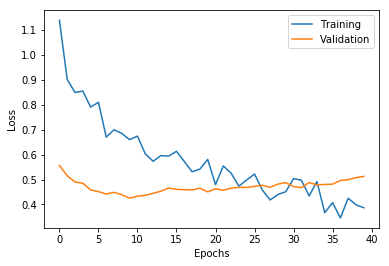

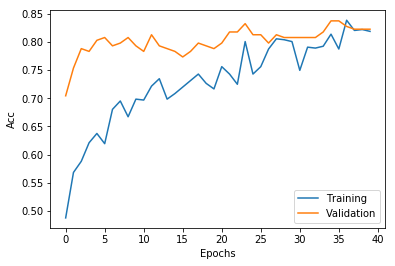

In [45]:
hidden_units = 32
dropout_prop = 0.6
optim = RMSprop(lr=0.0001)
epochs = 40
batch = 20
plot = True
model = make_model(hidden_units, dropout_prop, optim, epochs, batch, plot)

# model = Sequential()

In [46]:
from keras.regularizers import l1, l2, l1_l2

Train on 607 samples, validate on 203 samples
Epoch 1/60
607/607 [==============================] - 2s 3ms/step - loss: 5.8633 - acc: 0.5222 - val_loss: 5.4169 - val_acc: 0.7488
Epoch 2/60
607/607 [==============================] - 0s 271us/step - loss: 5.6727 - acc: 0.6030 - val_loss: 5.3457 - val_acc: 0.7734
Epoch 3/60
607/607 [==============================] - 0s 272us/step - loss: 5.5564 - acc: 0.6359 - val_loss: 5.2562 - val_acc: 0.7488
Epoch 4/60
607/607 [==============================] - 0s 279us/step - loss: 5.4665 - acc: 0.6458 - val_loss: 5.1764 - val_acc: 0.7734
Epoch 5/60
607/607 [==============================] - 0s 286us/step - loss: 5.3999 - acc: 0.6491 - val_loss: 5.1068 - val_acc: 0.7783
Epoch 6/60
607/607 [==============================] - 0s 270us/step - loss: 5.3113 - acc: 0.6573 - val_loss: 5.0337 - val_acc: 0.7882
Epoch 7/60
607/607 [==============================] - 0s 273us/step - loss: 5.1823 - acc: 0.6903 - val_loss: 4.9631 - val_acc: 0.7980
Epoch 8/60
607/607

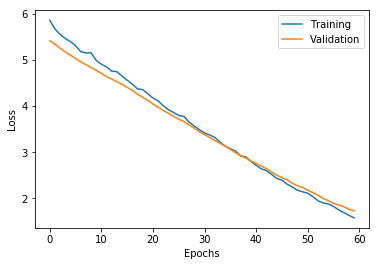

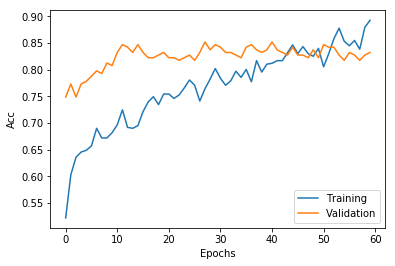

In [57]:
hidden_units = 32
dropout_prop = 0.6
optim = RMSprop(lr=0.0001)
epochs = 60
batch = 20
plot = True

model = Sequential()
model.add(Dense(hidden_units, input_dim=allsubjs_alltracts_scaled.shape[1], activation='relu', kernel_regularizer=l1_l2(.001)))
model.add(Dropout(dropout_prop))
model.add(Dense(hidden_units, activation='relu',kernel_regularizer=l1_l2(.001)))
model.add(Dropout(dropout_prop))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
                  optimizer=optim,
                  metrics=['accuracy'])

history = model.fit(trainX, trainY, epochs = epochs, batch_size = batch, validation_data=(valX, valY))

plot_history(history)

In [78]:
from keras.callbacks import ModelCheckpoint

In [86]:
pwd

u'/home/pestillilab/lindsey'

Train on 607 samples, validate on 203 samples
Epoch 1/60
607/607 [==============================] - 2s 4ms/step - loss: 3.8834 - acc: 0.5832 - val_loss: 3.5280 - val_acc: 0.7143
Epoch 2/60
607/607 [==============================] - 0s 258us/step - loss: 3.7129 - acc: 0.6310 - val_loss: 3.4595 - val_acc: 0.7488
Epoch 3/60
607/607 [==============================] - 0s 256us/step - loss: 3.7029 - acc: 0.6112 - val_loss: 3.4266 - val_acc: 0.7685
Epoch 4/60
607/607 [==============================] - 0s 256us/step - loss: 3.5956 - acc: 0.6672 - val_loss: 3.3804 - val_acc: 0.7734
Epoch 5/60
607/607 [==============================] - 0s 255us/step - loss: 3.5644 - acc: 0.6442 - val_loss: 3.3498 - val_acc: 0.8079
Epoch 6/60
607/607 [==============================] - 0s 271us/step - loss: 3.4978 - acc: 0.6787 - val_loss: 3.3158 - val_acc: 0.7980
Epoch 7/60
607/607 [==============================] - 0s 268us/step - loss: 3.3964 - acc: 0.7183 - val_loss: 3.2875 - val_acc: 0.7931
Epoch 8/60
607/607

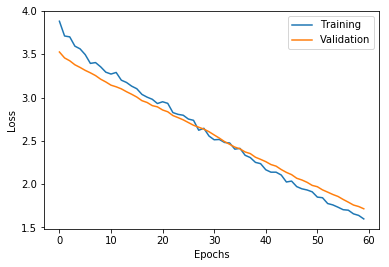

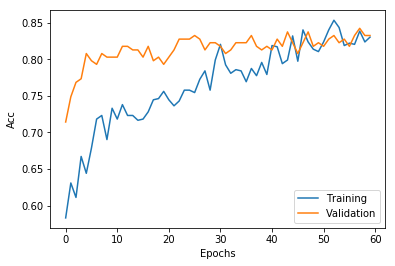

In [124]:
hidden_units = 24
dropout_prop = 0.6
optim = RMSprop(lr=0.0001) #0.0001
epochs = 60
batch = 20
plot = True
best_model = ModelCheckpoint('/home/pestillilab/lindsey/bestmodel.h5', monitor='val_acc', save_best_only=True)

model = Sequential()
model.add(Dense(hidden_units, input_dim=allsubjs_alltracts_scaled.shape[1], activation='relu', kernel_regularizer=l1(.001)))
model.add(Dropout(dropout_prop))
model.add(Dense(hidden_units, activation='relu',kernel_regularizer=l1(.001)))
model.add(Dropout(dropout_prop))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
                  optimizer=optim,
                  metrics=['accuracy'])

history = model.fit(trainX, trainY, epochs = epochs, batch_size = batch, validation_data=(valX, valY), callbacks=[best_model])

plot_history(history)

In [120]:
score = model.evaluate(testX, testY)

203/203 [==============================] - 0s 79us/step


In [121]:
score

[3.127091738978043, 0.8029556661991063]

In [122]:
from keras.models import load_model
best_model = load_model('bestmodel.h5')

In [123]:
score = best_model.evaluate(testX, testY)
print score

203/203 [==============================] - 1s 3ms/step
[3.262148887653069, 0.7881773410759536]
